# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/1014rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/1015rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/1016rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/1014rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/1015rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/1016rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 1
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.311391        0.189927  0.048388  0.295999  0.020291   
       1.0    0.297825        0.164942  0.076788  0.175798  0.139120   
       2.0    0.322535        0.151916  0.082105  0.175166  0.163263   
       3.0    0.361151        0.123172  0.071266  0.175867  0.186155   
       4.0    0.338112        0.094595  0.065698  0.162897  0.215072   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.201482  0.010319  0.040935  0.051328  0.000000  
       1.0   0.186925  0.006839  0.035495  0.049036  0.004106  
       2.0   0.217826  0.004246  0.033648  0.050300  0.008467  
       3.0   0.242295  0.003160  0.030224  0.046850  0.013043  
       4.0   0.276586  0.003341  0.032107  0.038178  0.017014

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.285361        0.203451  0.053860  0.318371  0.020249   
       1.0    0.314155        0.182588  0.075503  0.186737  0.128308   
       2.0    0.326375        0.150841  0.090180  0.159729  0.150125   
       3.0    0.319987        0.136511  0.079333  0.169133  0.194918   
       4.0    0.346740        0.089428  0.063110  0.160522  0.205602   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.202172  0.009839  0.040488  0.049874  0.000000  
       1.0   0.209866  0.007506  0.034363  0.048335  0.003792  
       2.0   0.243785  0.004153  0.032090  0.046981  0.009250  
       3.0   0.251817  0.003108  0.031598  0.040736  0.012425  
       4.0   0.275491  0.003336  0.031269  0.042670  0.018170

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.307520        0.208194  0.051695  0.316037  0.018968   
       1.0    0.329623        0.170822  0.080248  0.173116  0.140086   
       2.0    0.323266        0.132417  0.091045  0.169398  0.169355   
       3.0    0.360027        0.128522  0.076454  0.161154  0.190906   
       4.0    0.327418        0.097355  0.062837  0.151815  0.187442   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.212359  0.010137  0.040349  0.053594  0.000000  
       1.0   0.191830  0.006763  0.035184  0.051661  0.003521  
       2.0   0.226144  0.003886  0.031219  0.048682  0.008938  
       3.0   0.245354  0.003326  0.032457  0.041179  0.013415  
       4.0   0.266170  0.003187  0.031372  0.040803  0.018281

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.301424        0.200524  0.051314  0.310136  0.019836   
         1.0    0.284705        0.170455  0.091315  0.179084  0.137638   
         2.0    0.258418        0.140497  0.080569  0.196493  0.174878   
         3.0    0.243252        0.121485  0.054221  0.198993  0.230940   
         4.0    0.209823        0.084048  0.036914  0.180731  0.257594   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.205338  0.010099  0.040591  0.051599  0.000000  
         1.0   0.196130  0.007163  0.034982  0.050958  0.002534  
         2.0   0.229748  0.004468  0.032050  0.051804  0.006022  
         3.0   0.252752  0.003737  0.030865  0.047582  0.008957  
         4.0   0.290562  0.004585  0.030485  0.047033  0.012563

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.975196e+01  3.983424e+01      37.940737  5.956960e+01   
         1.0   6.249594e+06  4.554122e+06  464205.449076  3.158696e+06   
         2.0   6.460884e+06  5.646401e+06  586488.147139  3.784643e+06   
         3.0   6.289634e+06  5.999581e+06  658046.471567  4.352695e+06   
         4.0   6.489455e+06  5.993516e+06  652709.354771  4.160313e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         1.0   9.584337e+05  5.561536e+06  3.604216e+06  8.619272e+05   
         2.0   1.199218e+06  7.479980e+06  3.957066e+06  1.064706e+06   
         3.0   1.384297e+06  7.957506e+06  4.211656e+06  1.138346e+06   
         4.0   1.311929e+06  8.228331e+06  4.347073e+06  1.058420e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          31.311180  
         1.0      377545.373461  
         2.0      488087.784291  
         3.0      549656.011318  
         4.0      581981.690244

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


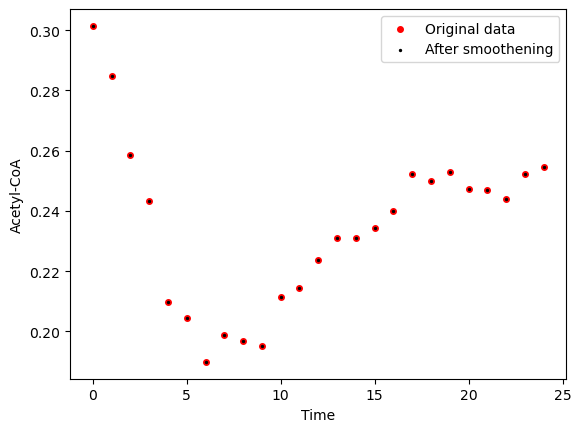

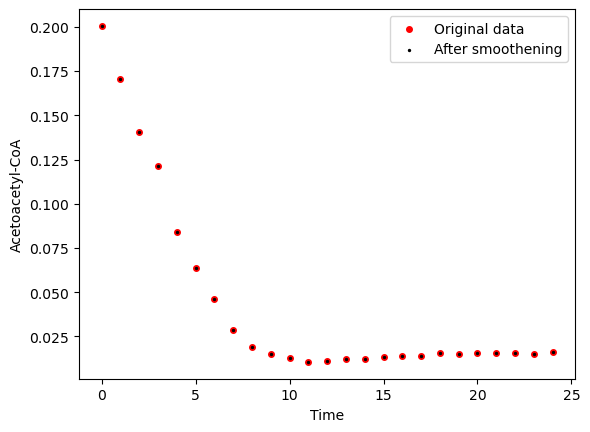

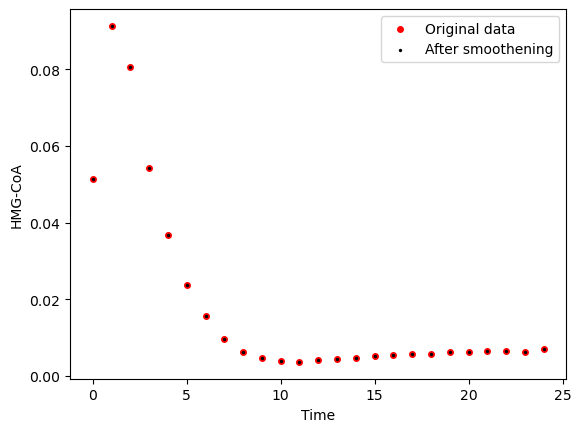

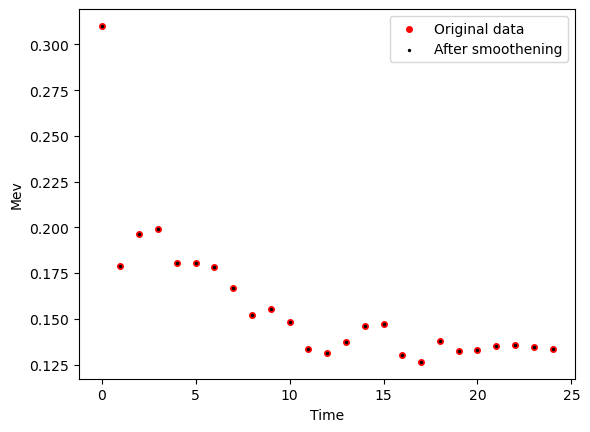

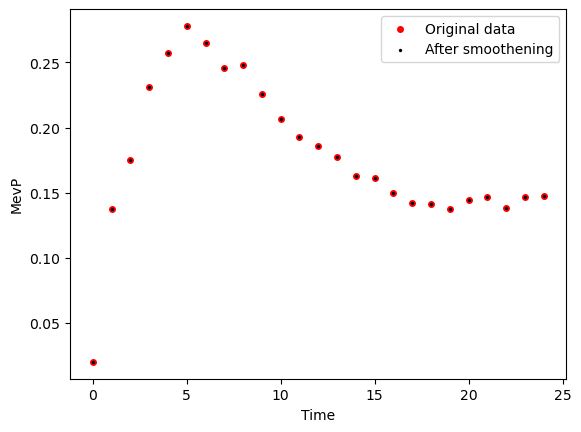

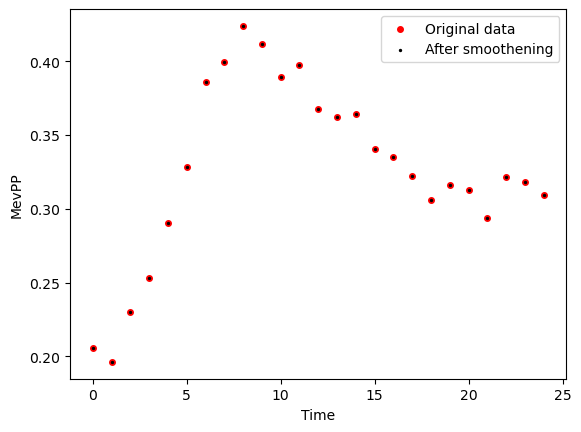

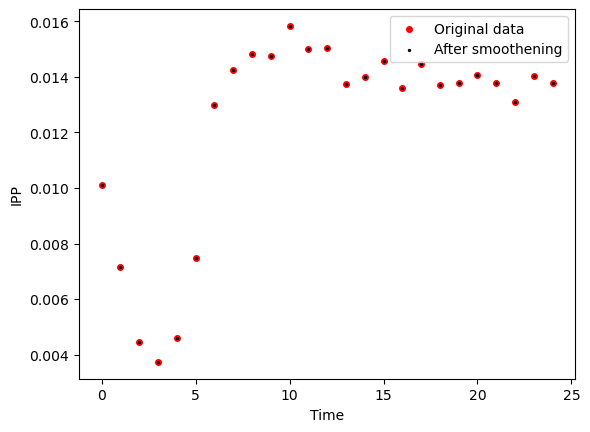

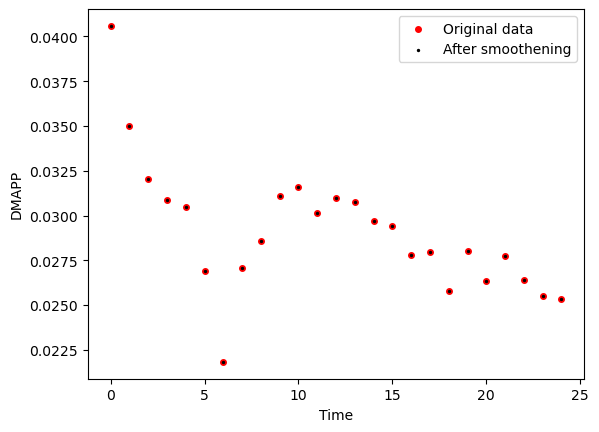

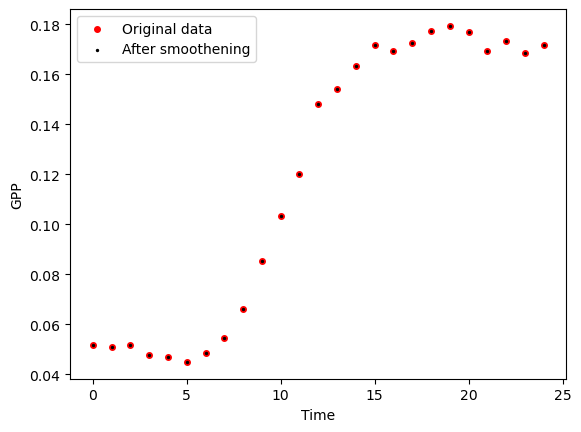

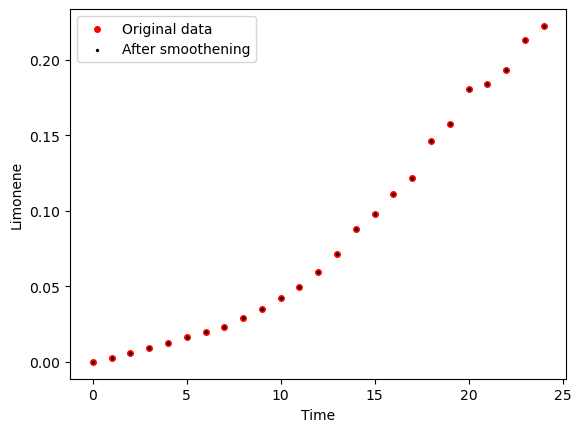

Strain Strain 2


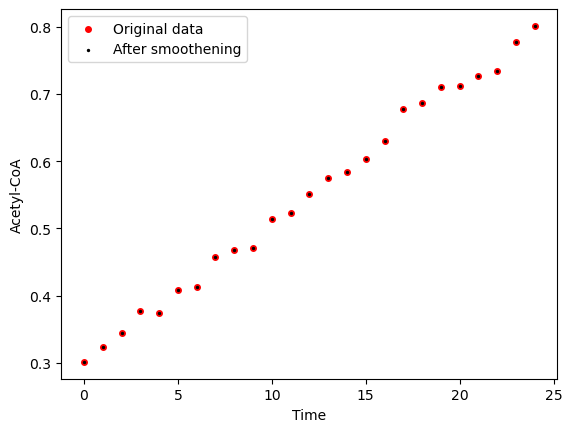

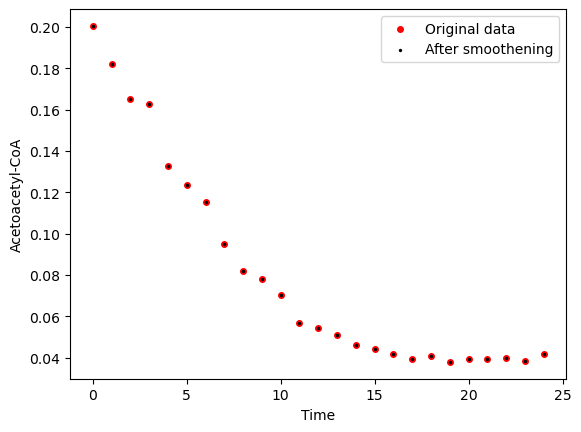

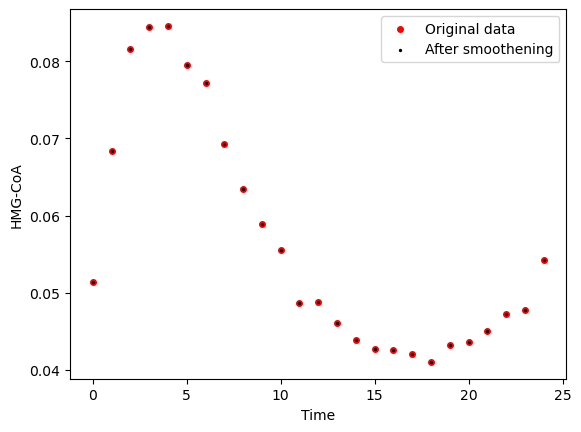

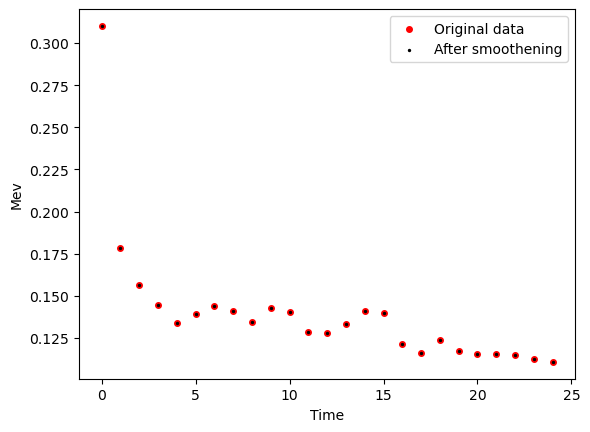

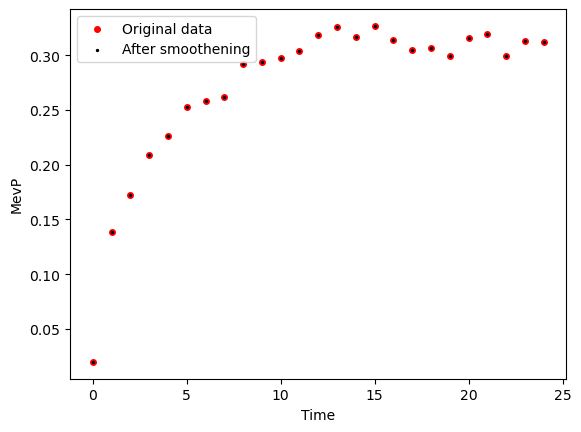

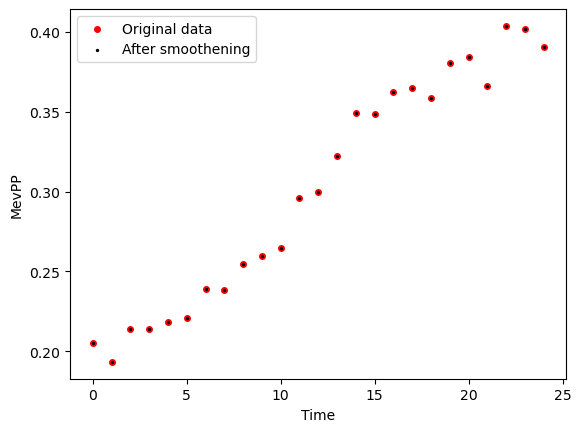

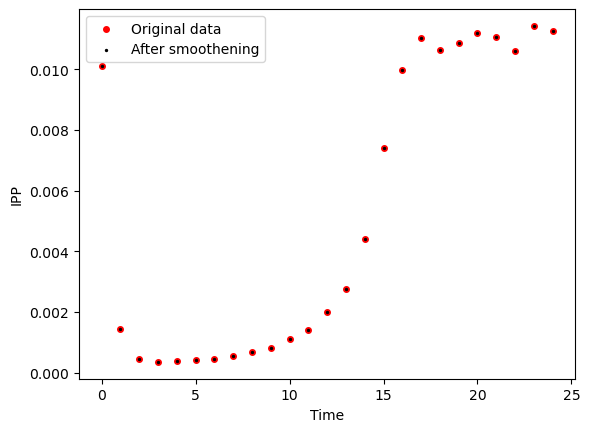

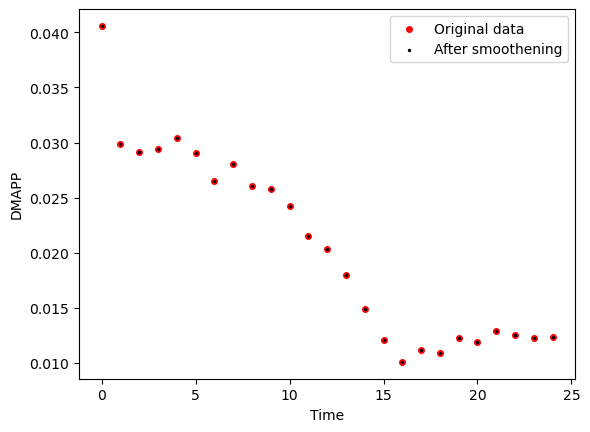

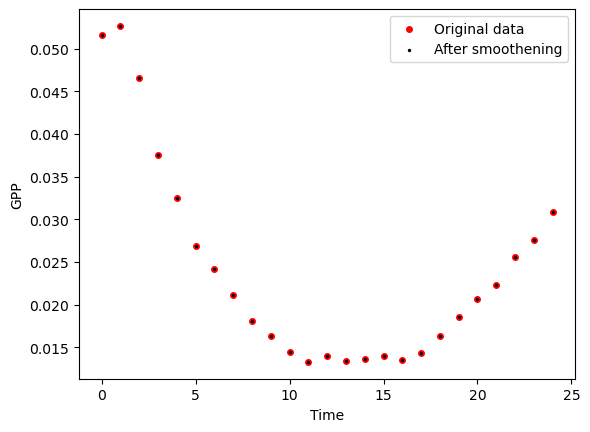

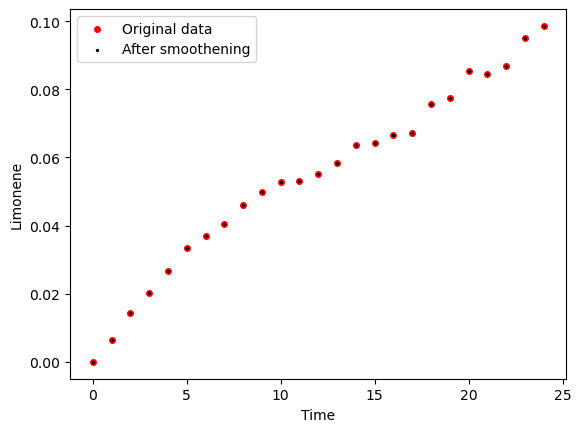

Strain Strain 3


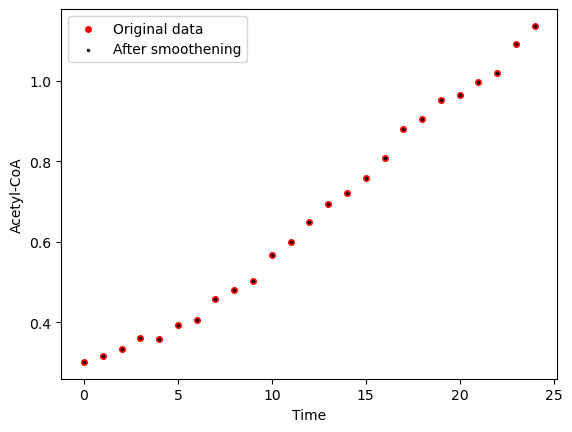

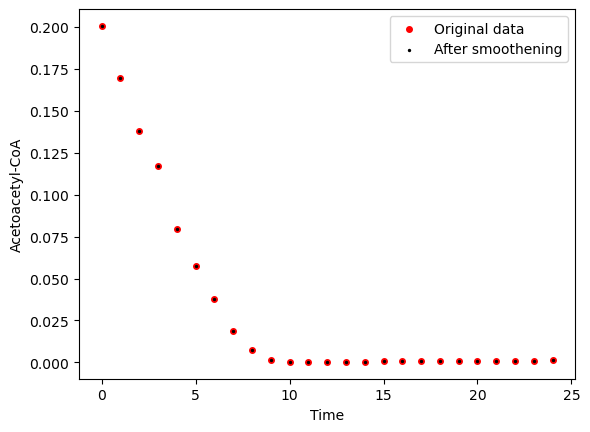

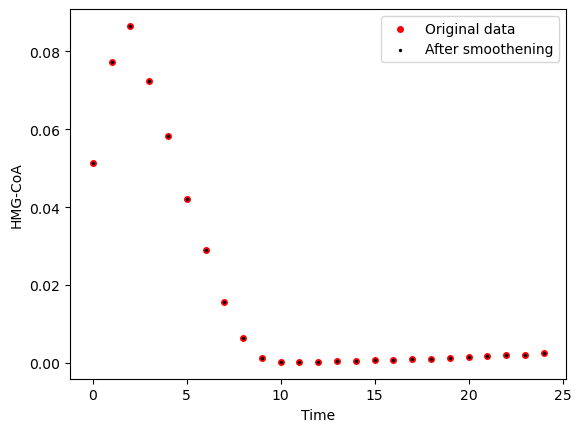

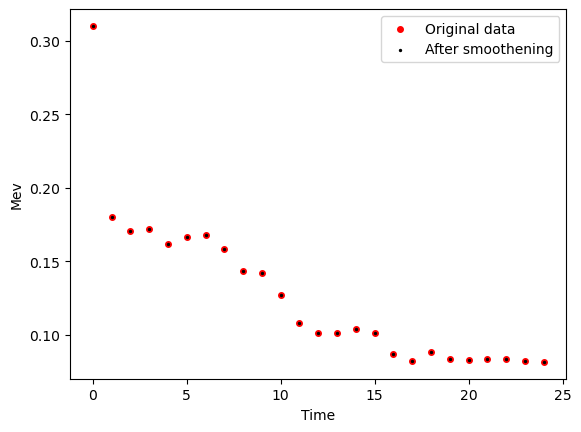

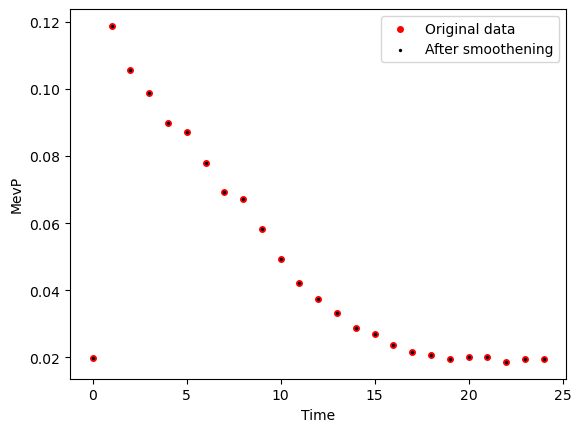

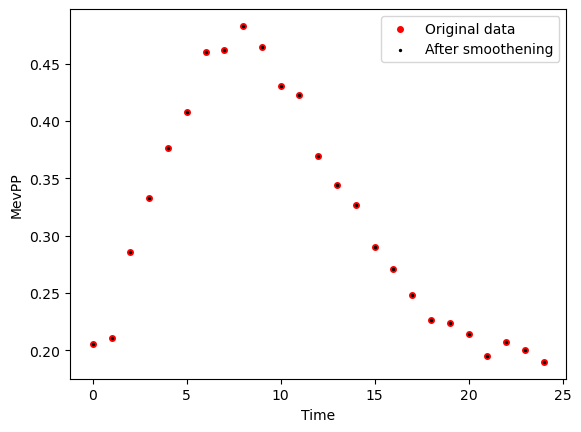

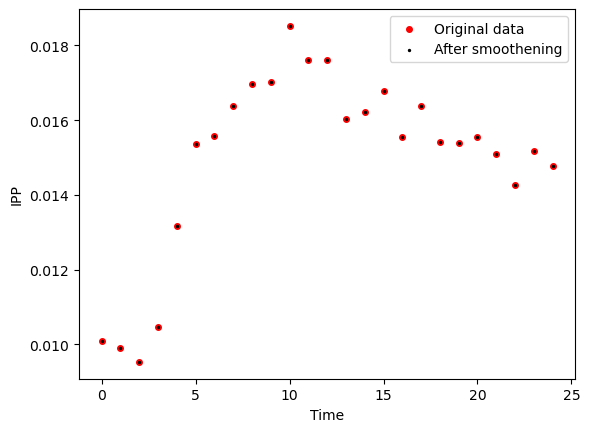

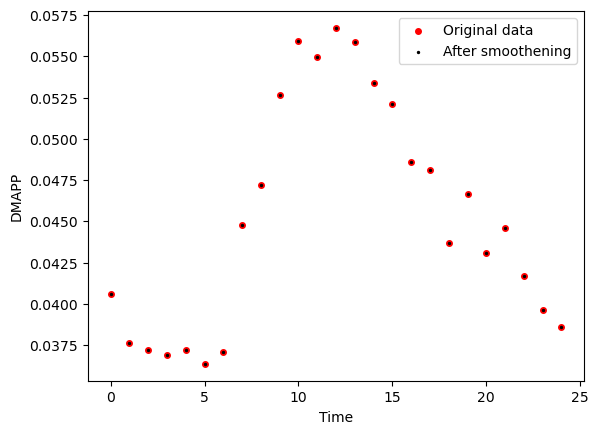

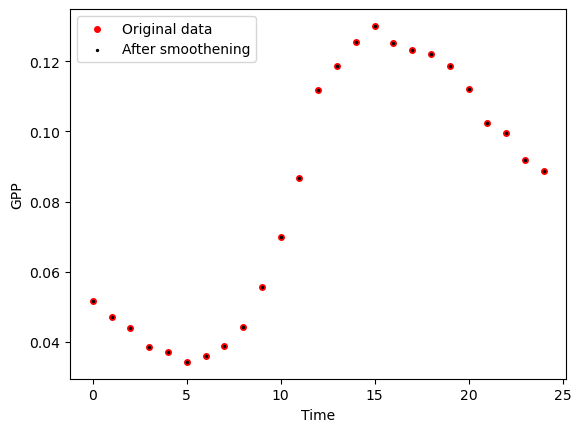

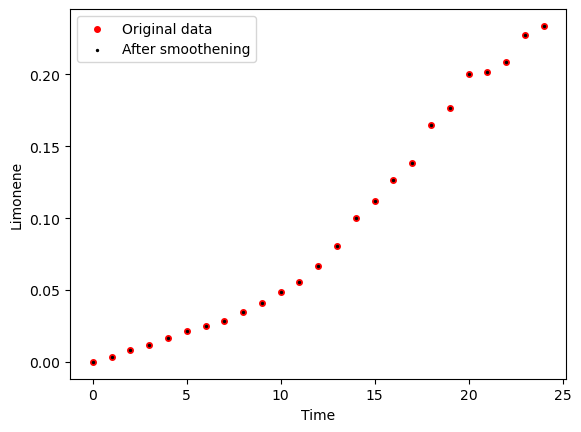

Strain WT


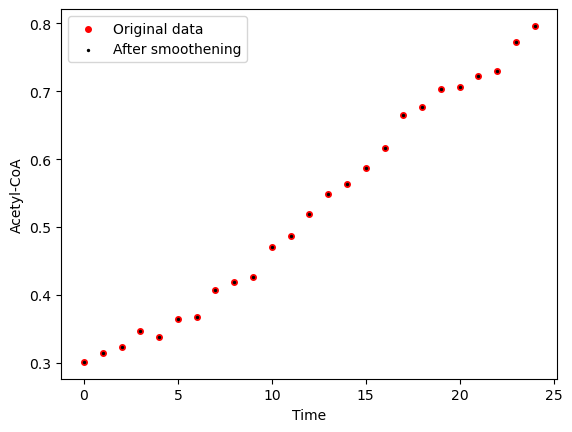

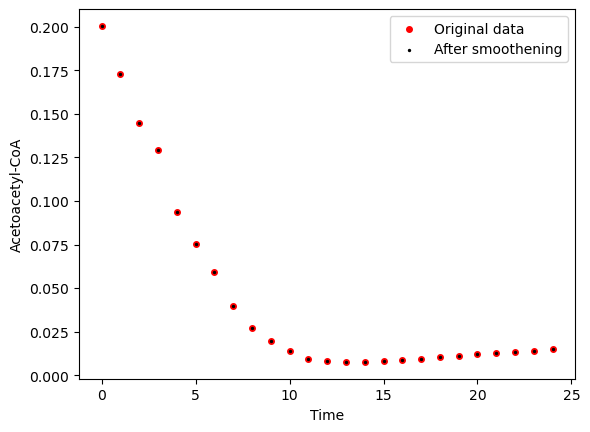

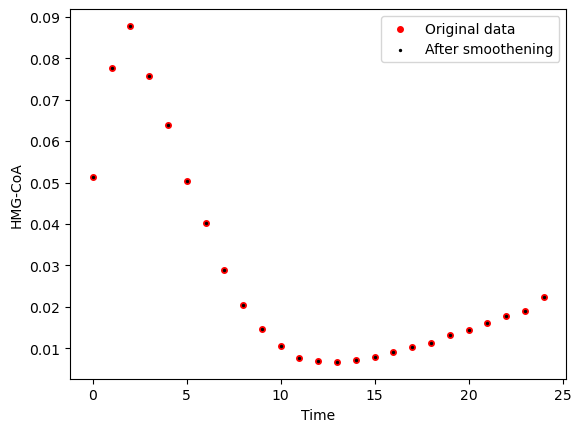

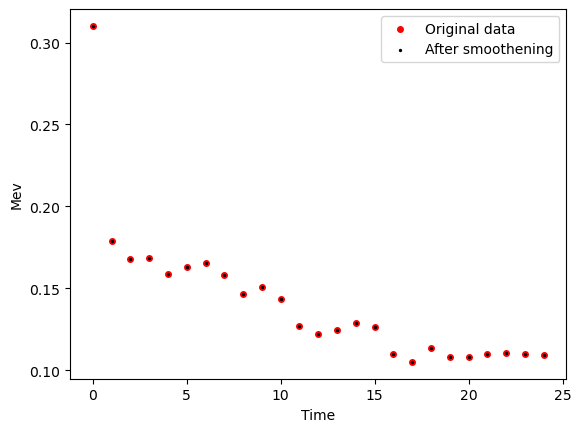

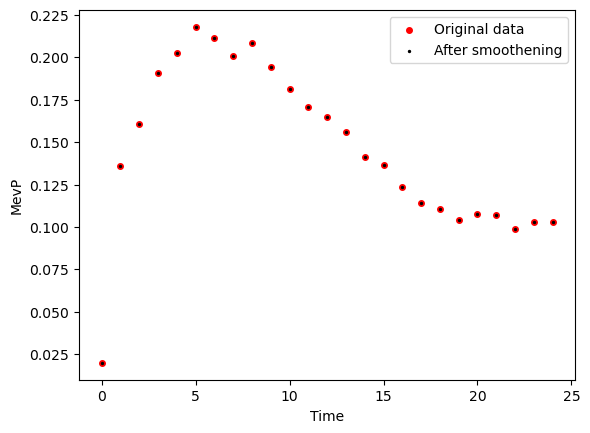

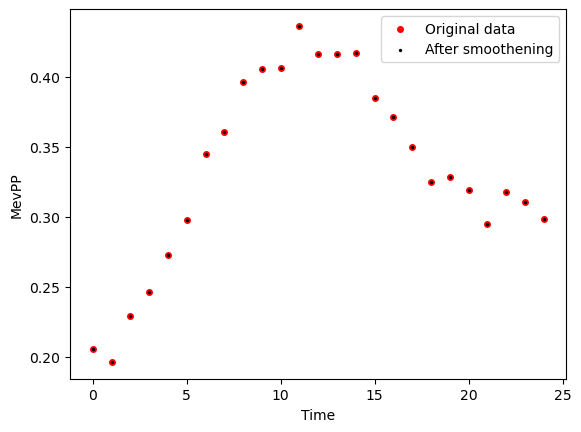

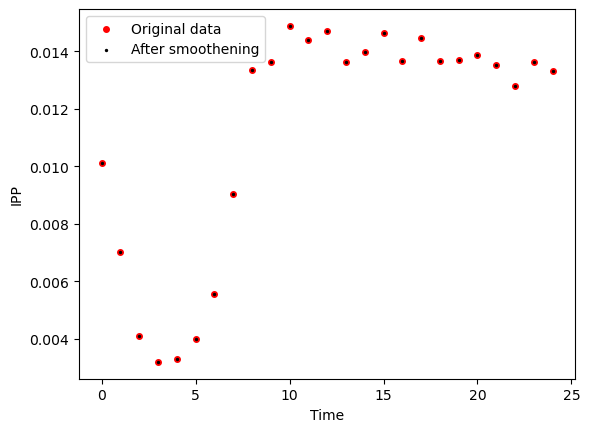

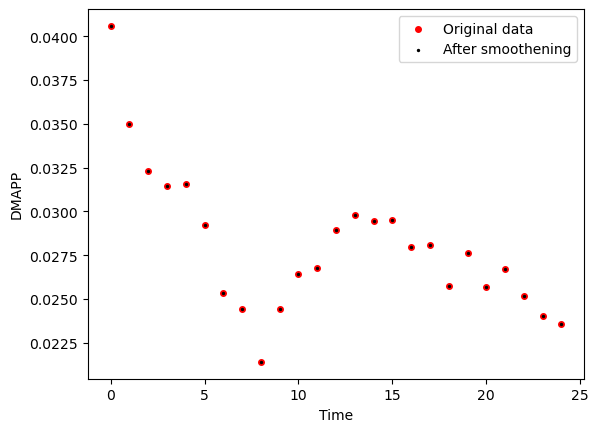

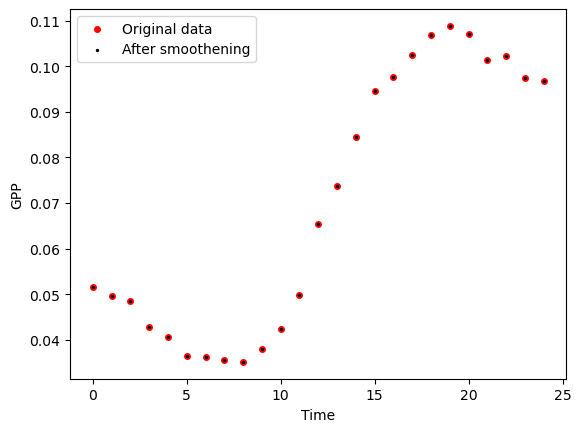

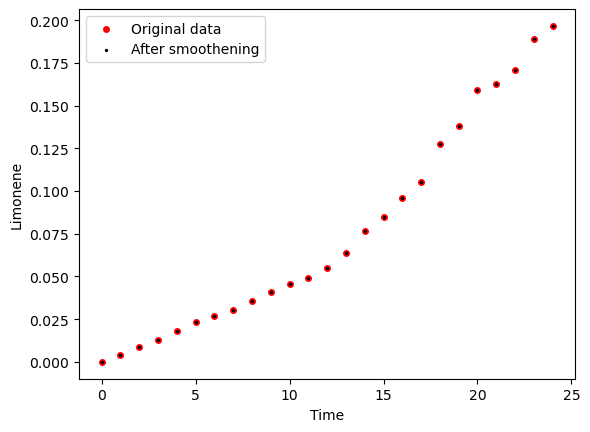

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


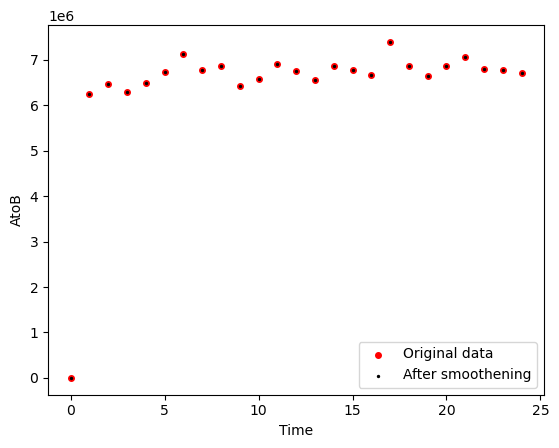

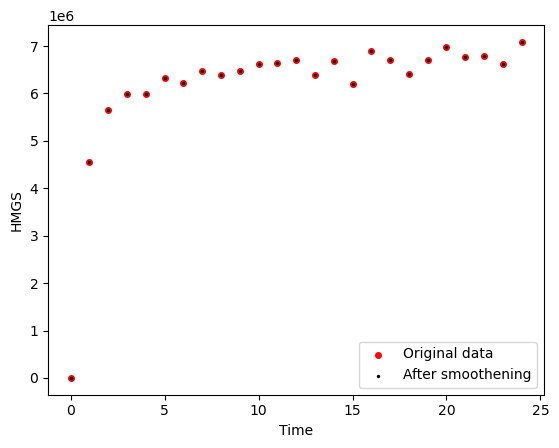

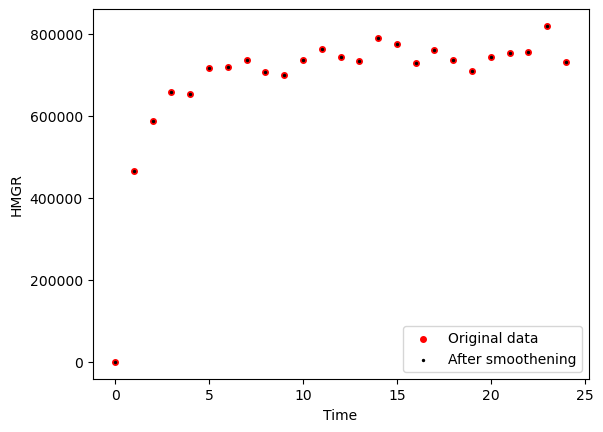

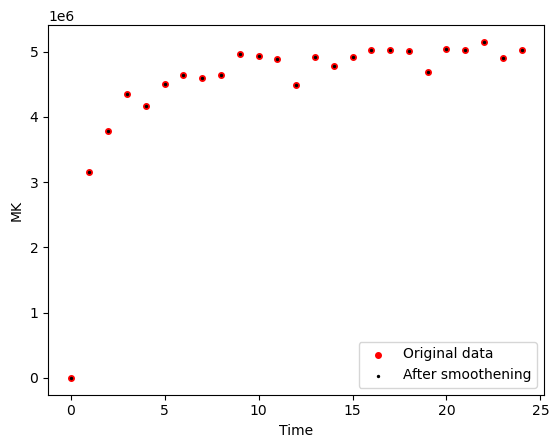

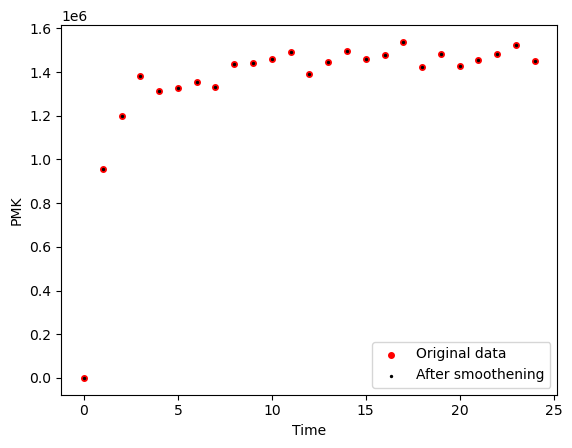

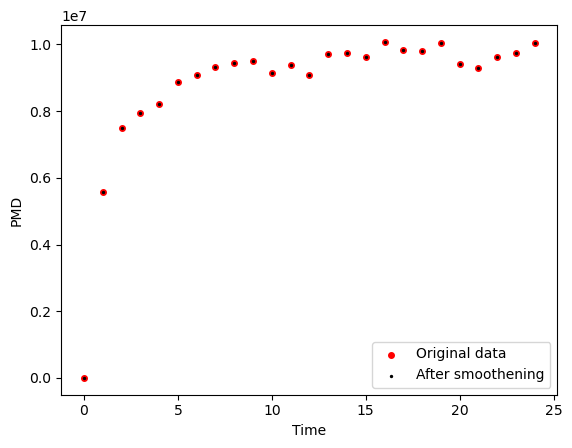

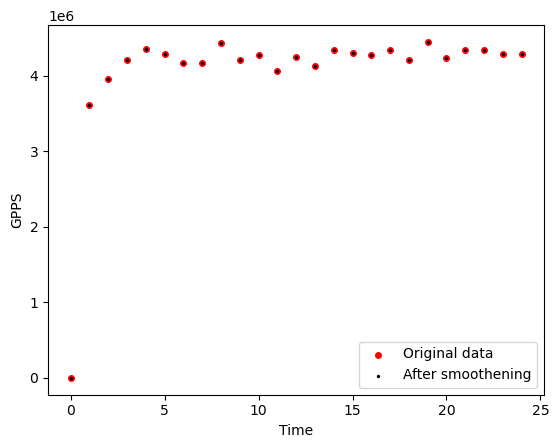

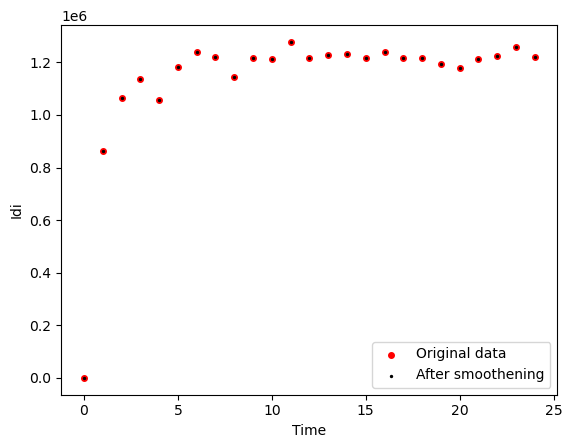

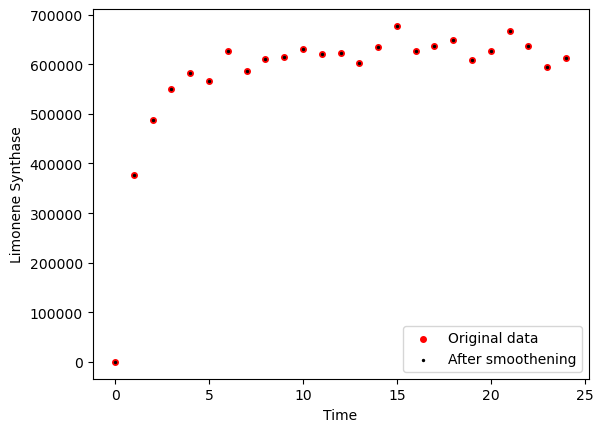

Strain Strain 2


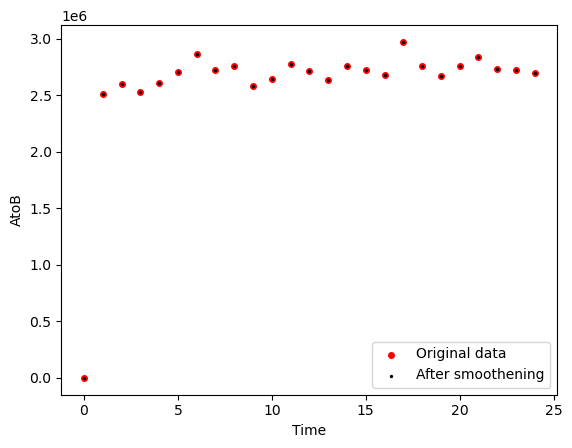

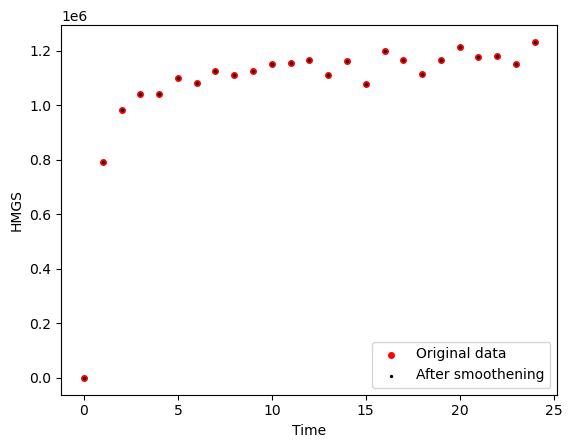

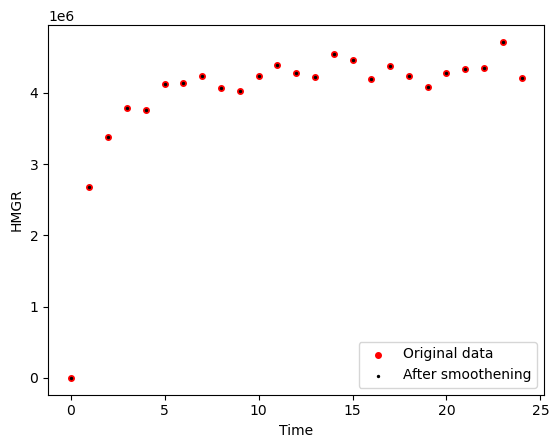

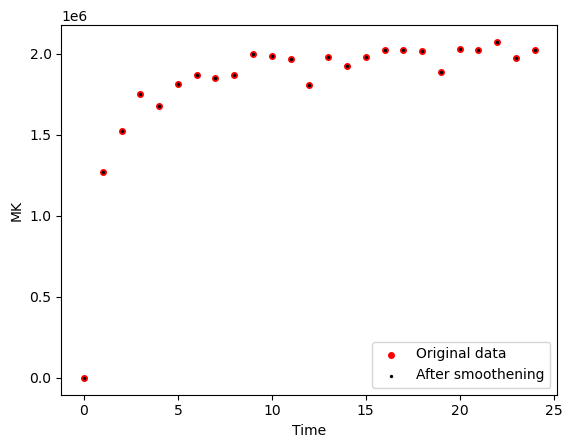

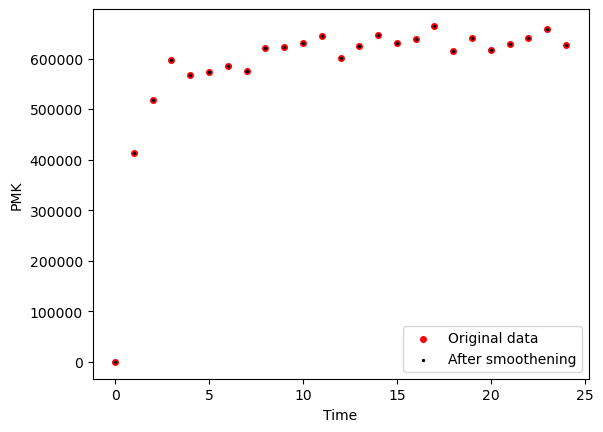

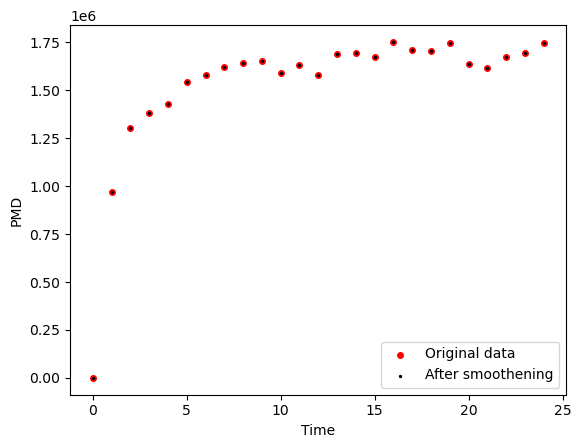

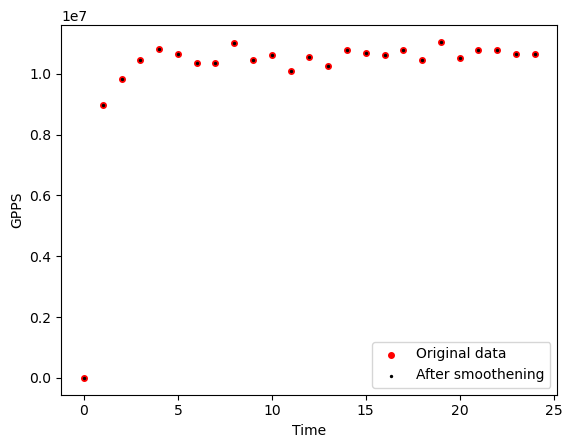

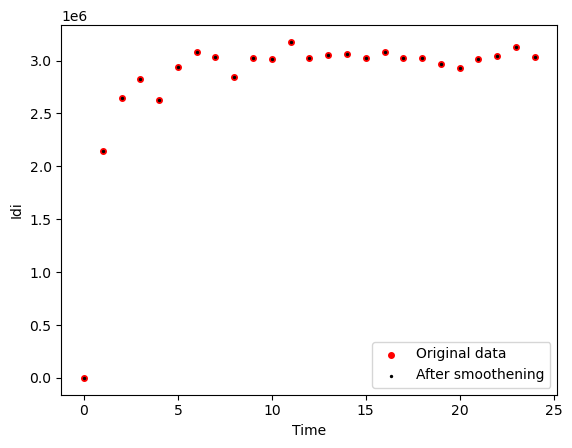

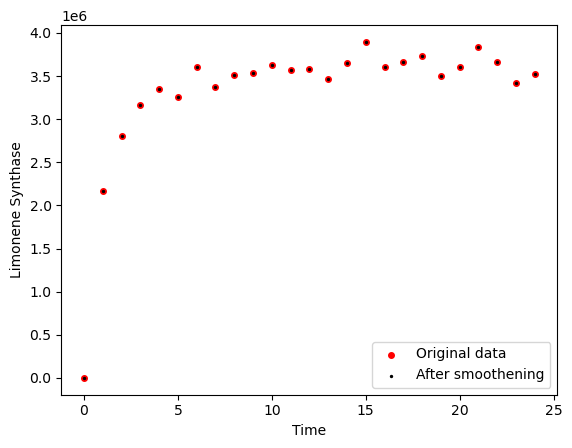

Strain Strain 3


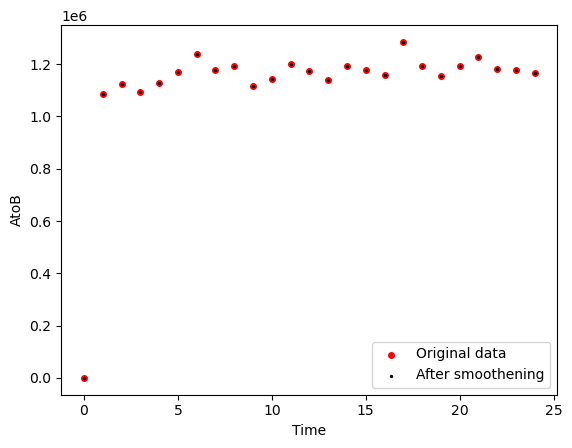

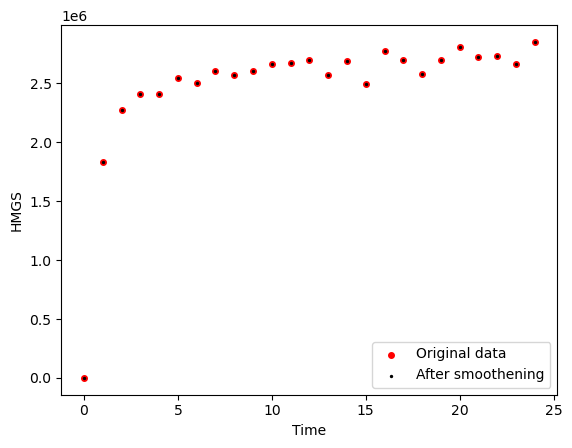

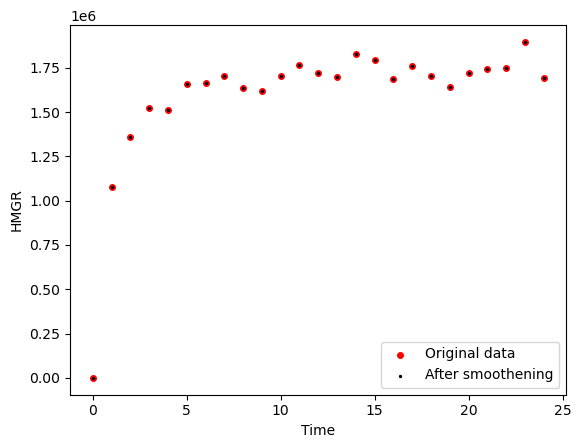

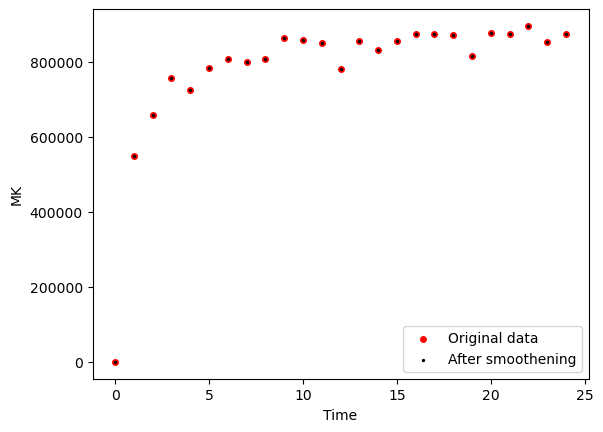

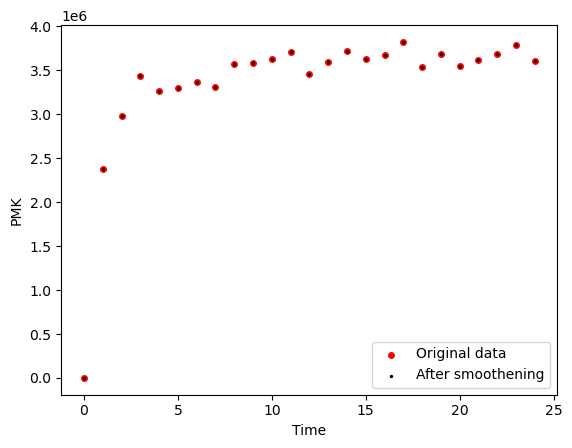

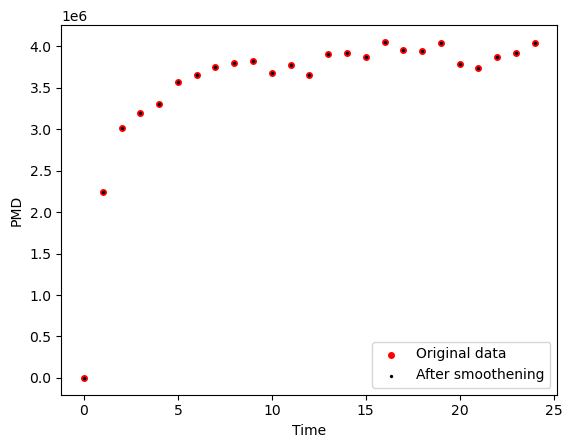

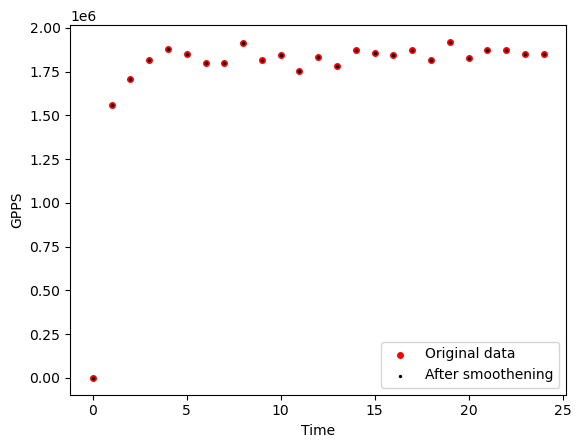

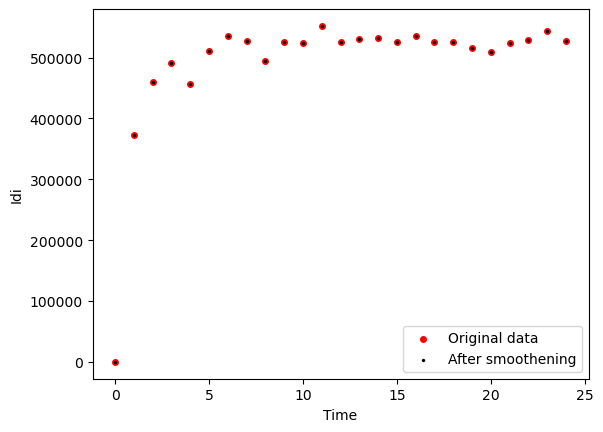

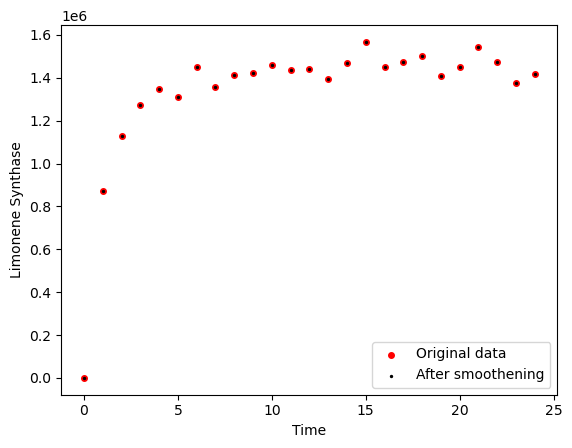

Strain WT


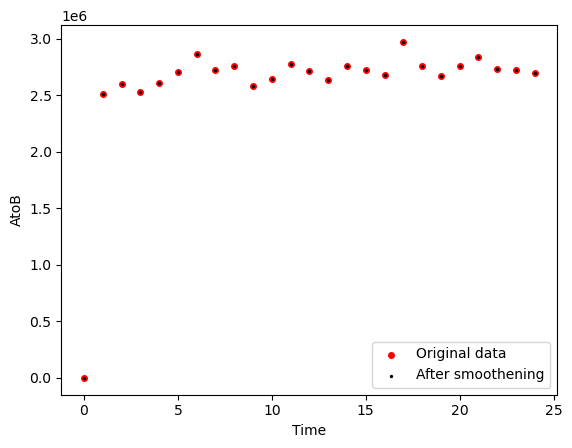

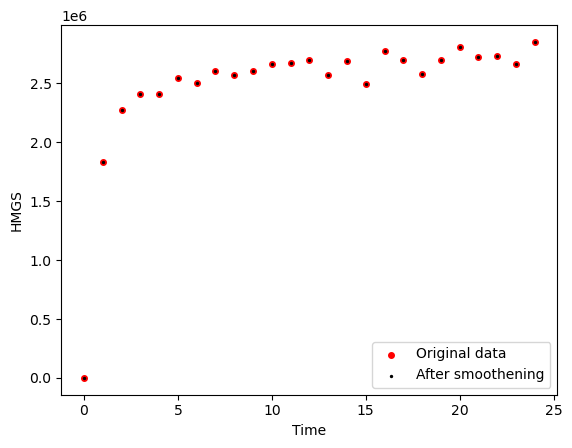

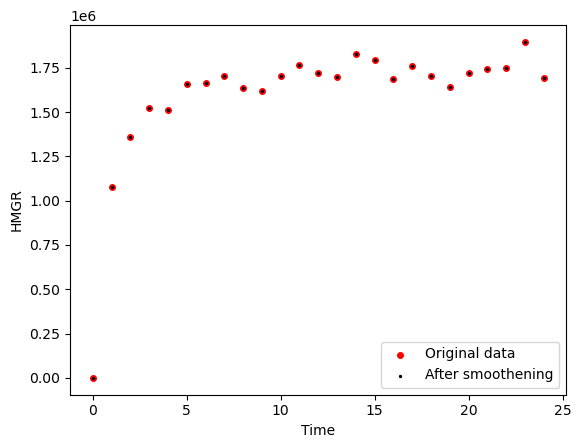

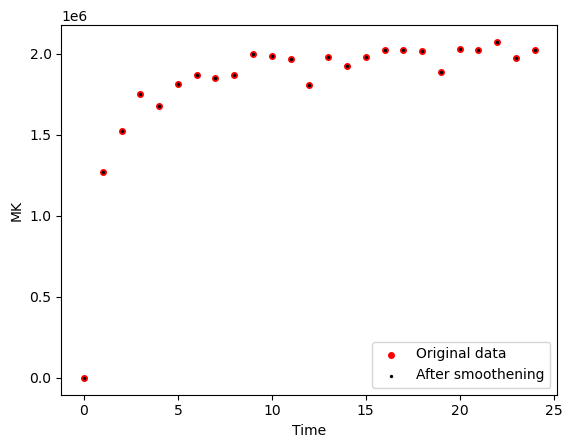

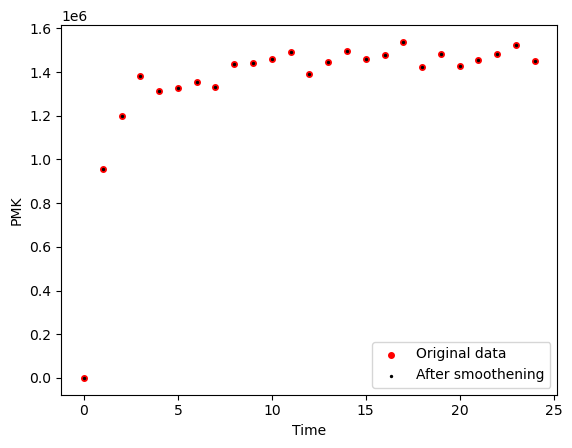

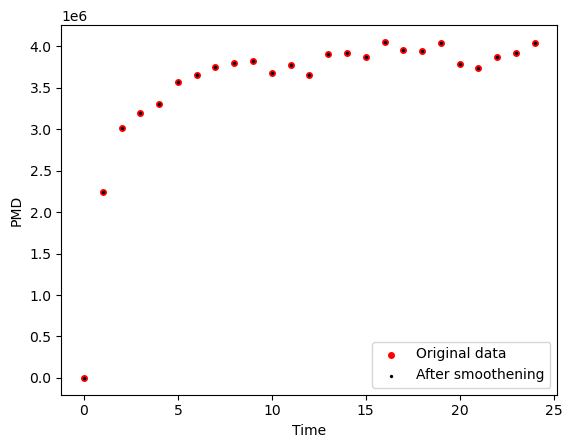

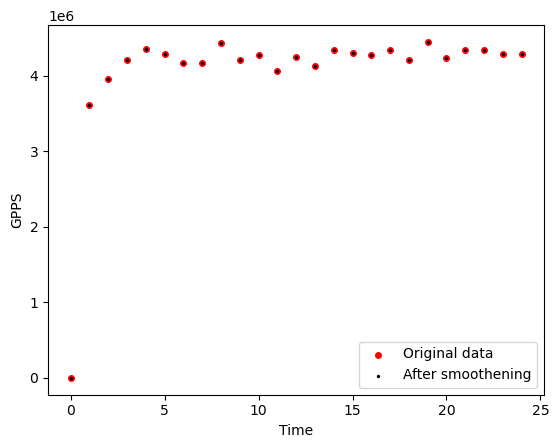

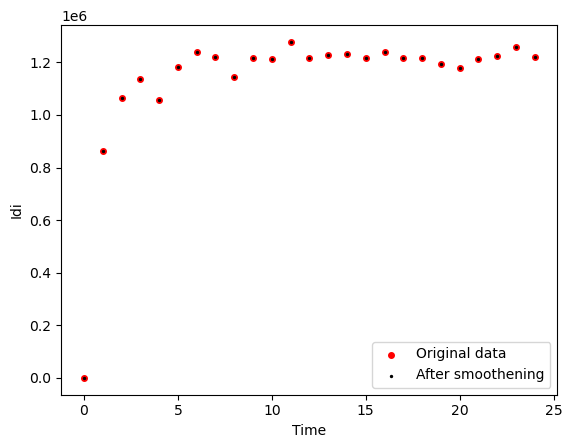

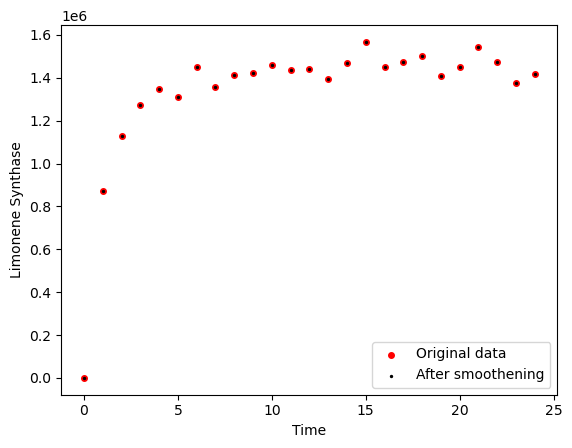

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.301424        0.200524  0.051314  0.310136  0.019836   
         1.0    0.284705        0.170455  0.091315  0.179084  0.137638   
         2.0    0.258418        0.140497  0.080569  0.196493  0.174878   
         3.0    0.243252        0.121485  0.054221  0.198993  0.230940   
         4.0    0.209823        0.084048  0.036914  0.180731  0.257594   
...                  ...             ...       ...       ...       ...   
WT       20.0   0.705745        0.012078  0.014487  0.108064  0.107378   
         21.0   0.722097        0.012688  0.016057  0.109773  0.106777   
         22.0   0.729973        0.013484  0.017838  0.110445  0.098911   
         23.0   0.772631        0.013642  0.018896  0.109780  0.103047   
         24.0   0.796371        0.015308  0.022282  0.109323  0.102723   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.205338  0.010099  0.040591  0.051599  0.000000  ...   
         1.0   0.196130  0.007163  0.034982  0.050958  0.002534  ...   
         2.0   0.229748  0.004468  0.032050  0.051804  0.006022  ...   
         3.0   0.252752  0.003737  0.030865  0.047582  0.008957  ...   
         4.0   0.290562  0.004585  0.030485  0.047033  0.012563  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       20.0  0.318979  0.013873  0.025689  0.106966  0.159173  ...   
         21.0  0.294749  0.013517  0.026741  0.101389  0.162417  ...   
         22.0  0.317567  0.012787  0.025149  0.102169  0.170761  ...   
         23.0  0.310677  0.013639  0.024031  0.097364  0.188873  ...   
         24.0  0.298553  0.013312  0.023553  0.096807  0.196616  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.016095       -0.027109  0.030616 -0.084082  0.103589   
         1.0    -0.019280       -0.027651  0.012013 -0.053986  0.080235   
         2.0    -0.022466       -0.028192 -0.006590 -0.023890  0.056882   
         3.0    -0.020895       -0.027039 -0.017896 -0.001285  0.036360   
         4.0    -0.017584       -0.024649 -0.016046 -0.005445  0.022737   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.012445        0.000766  0.001590 -0.000408 -0.002041   
         21.0    0.016278        0.000715  0.001477  0.000567 -0.001110   
         22.0    0.023179        0.000741  0.001843  0.000252 -0.001304   
         23.0    0.030258        0.000952  0.002258 -0.000557  0.000490   
         24.0    0.037338        0.001163  0.002674 -0.001367  0.002283   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001128 -0.004168 -0.005920  0.000145  0.002700  
         1.0   0.010790 -0.002807 -0.004176 -0.000553  0.002928  
         2.0   0.022707 -0.001445 -0.002433 -0.001251  0.003155  
         3.0   0.032533  0.000074 -0.001777 -0.001679  0.003502  
         4.0   0.038850  0.002077 -0.002444 -0.000888  0.003512  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.004855 -0.000191 -0.000204 -0.001690  0.011129  
         21.0 -0.003711 -0.000118 -0.000777 -0.002771  0.011328  
         22.0 -0.002492 -0.000100 -0.000698 -0.002434  0.010134  
         23.0 -0.003277  0.000134 -0.001068 -0.001798  0.012815  
         24.0 -0.004062  0.000368 -0.001437 -0.001161  0.015496

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

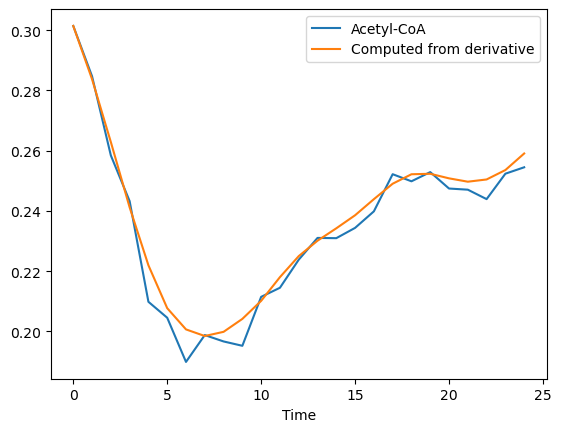

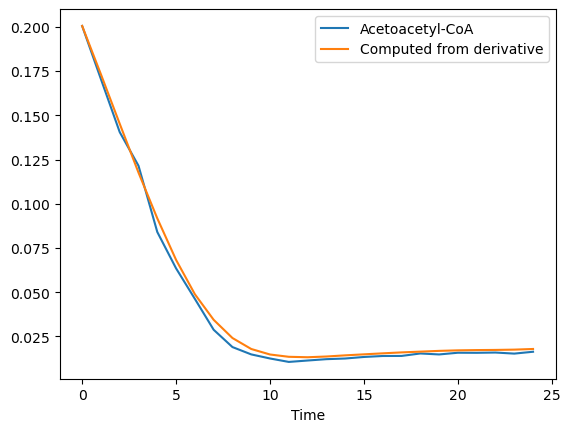

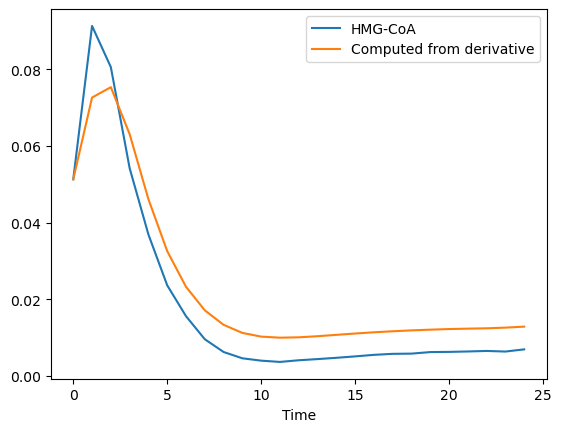

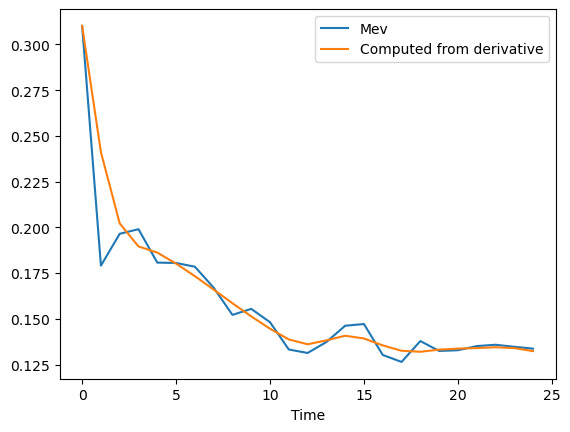

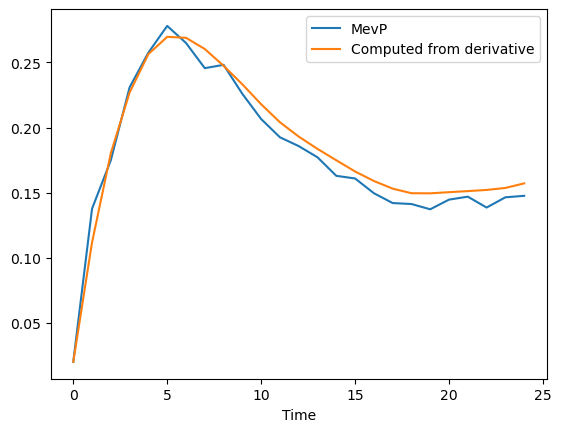

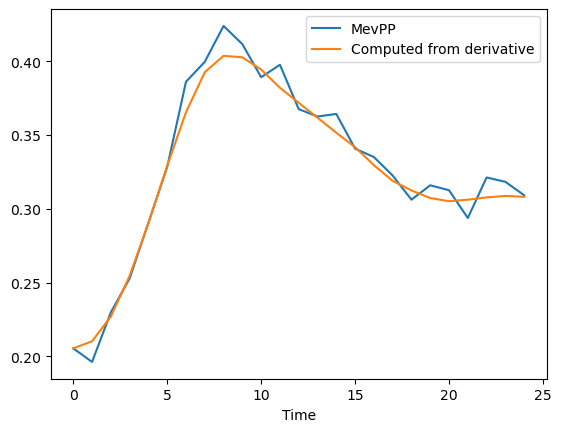

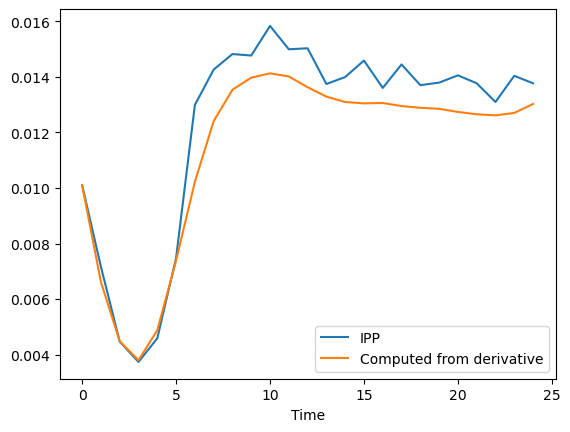

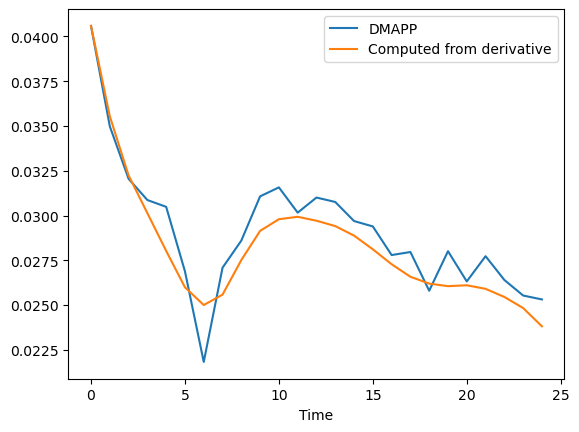

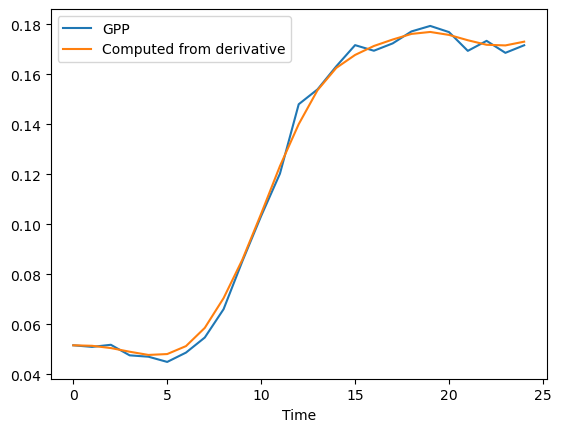

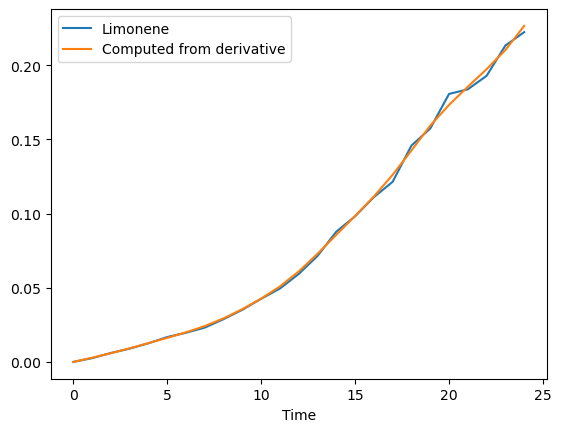

'Time profile from derivative vs. actual profile for Strain 2'

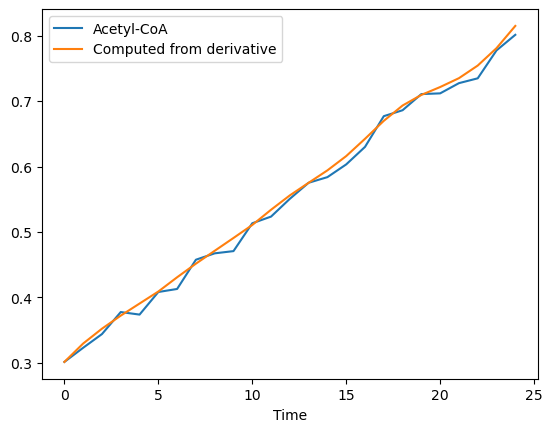

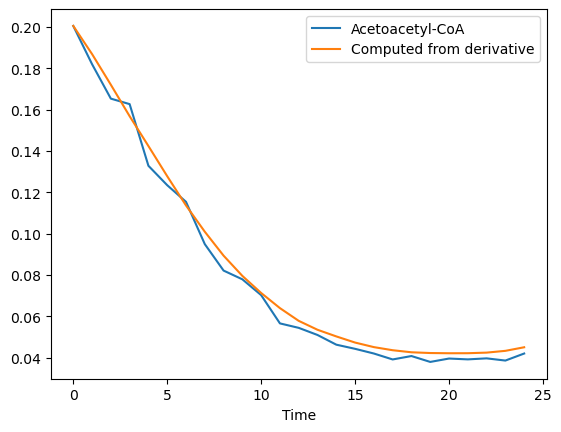

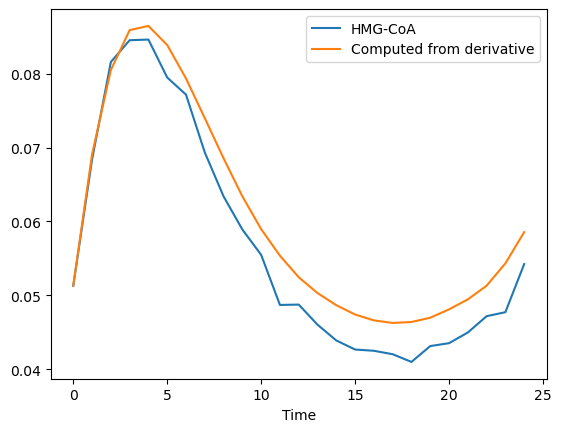

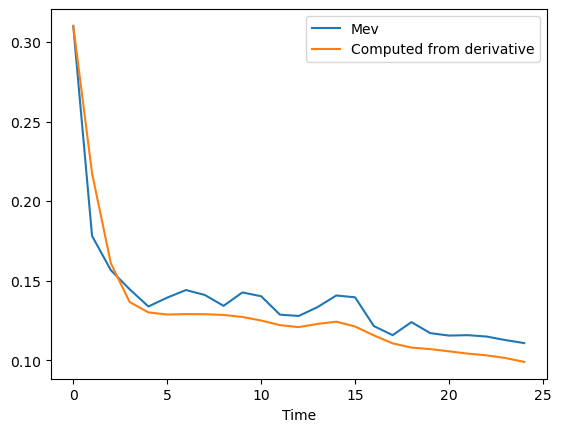

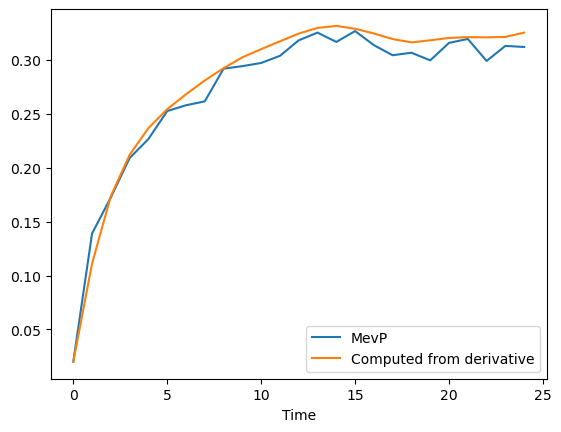

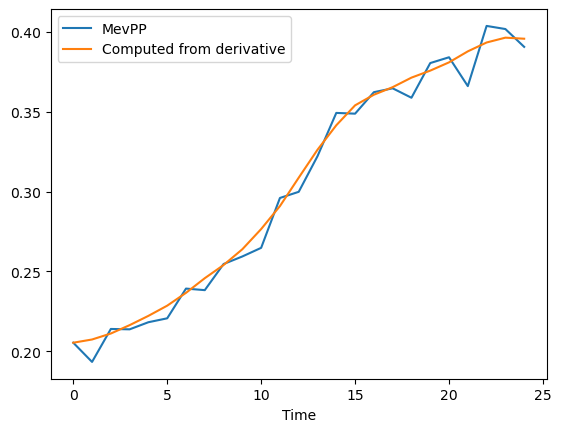

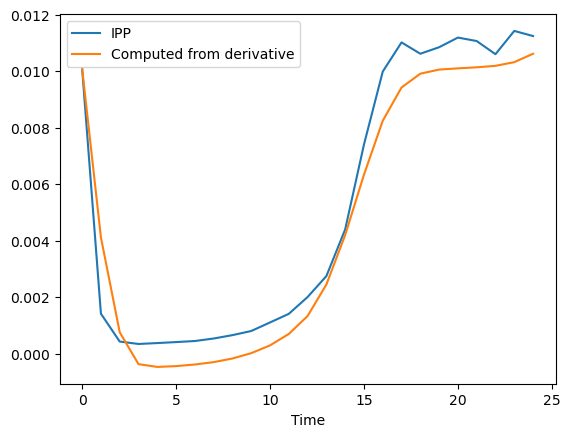

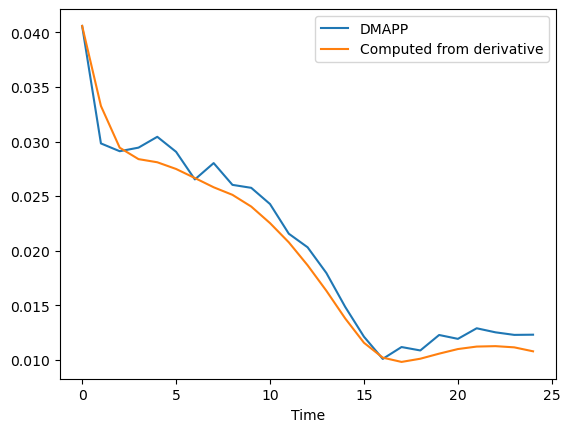

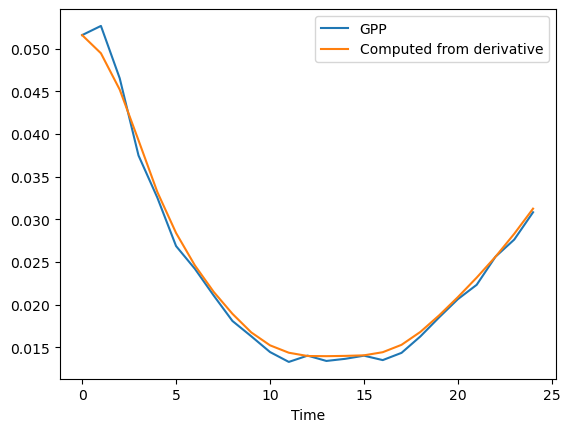

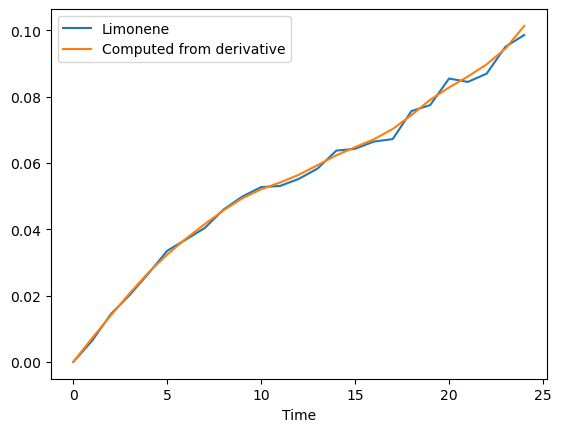

'Time profile from derivative vs. actual profile for Strain 3'

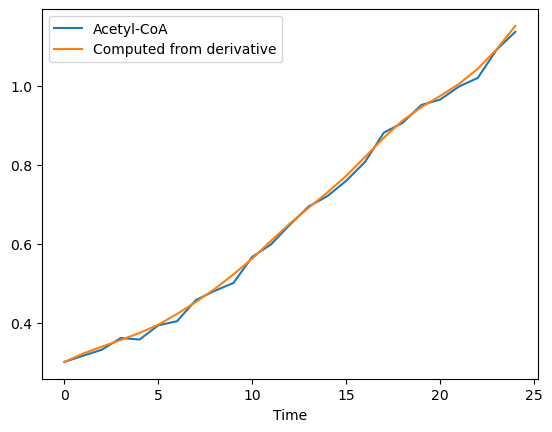

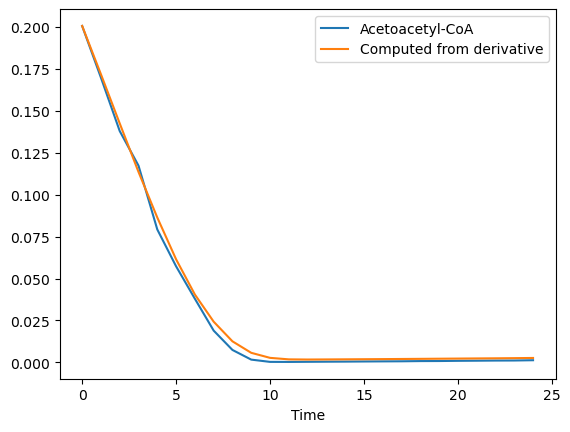

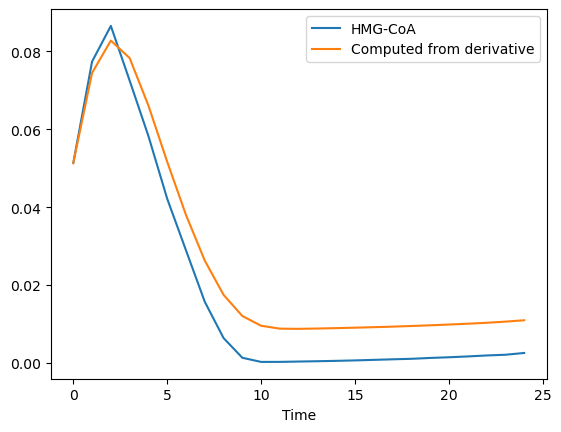

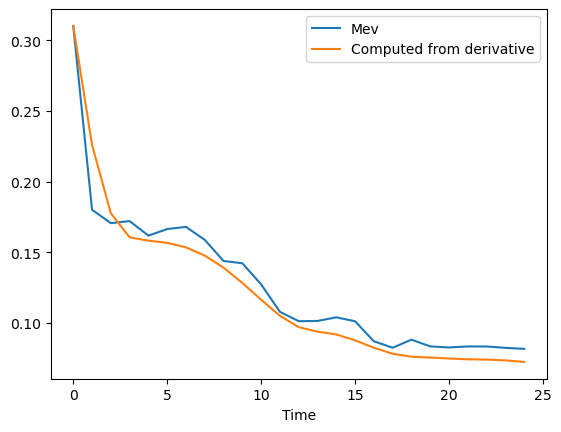

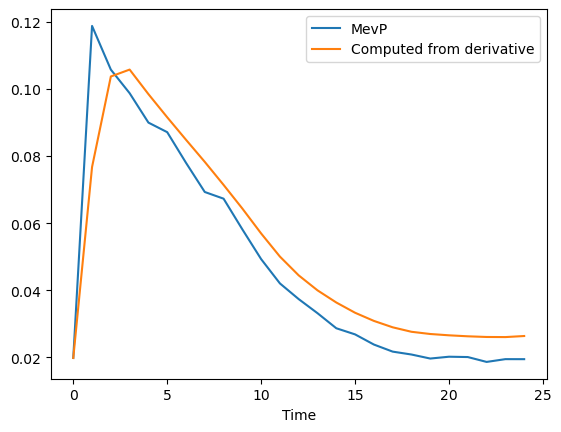

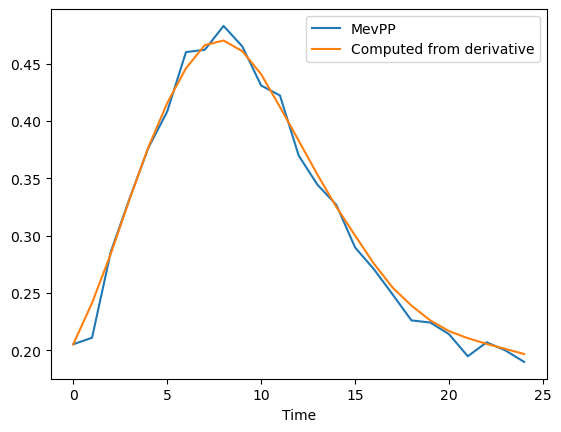

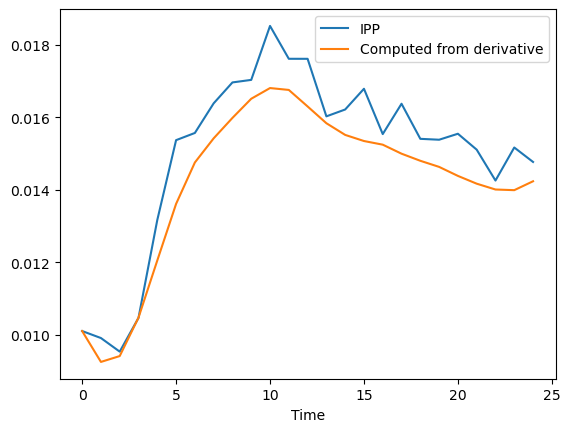

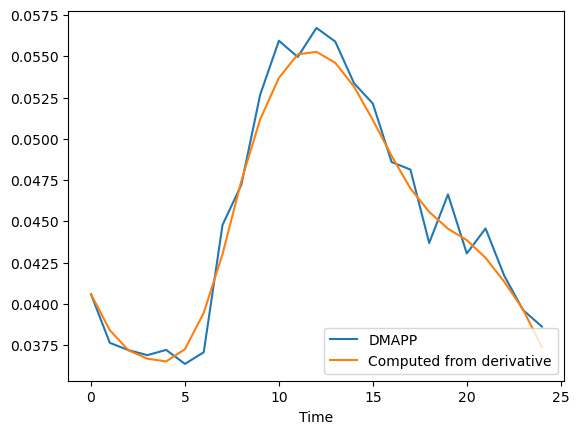

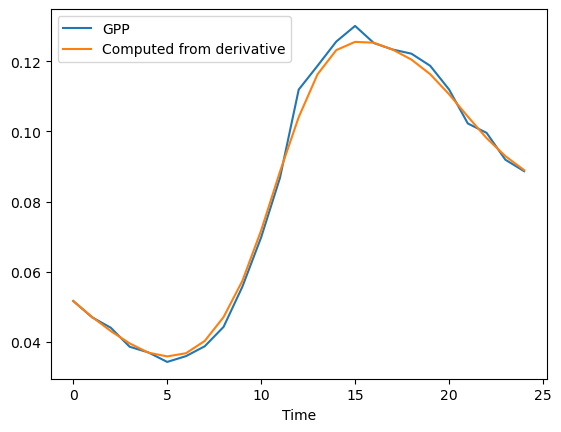

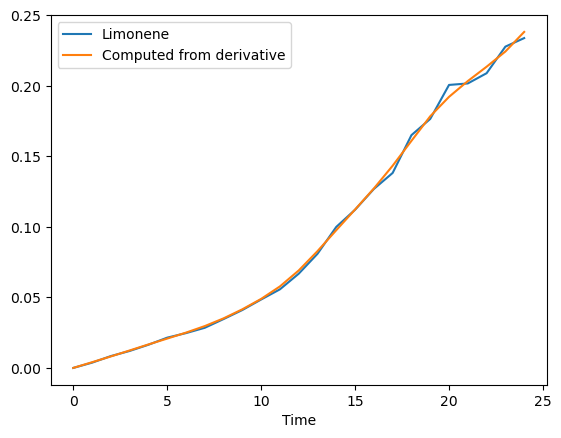

'Time profile from derivative vs. actual profile for WT'

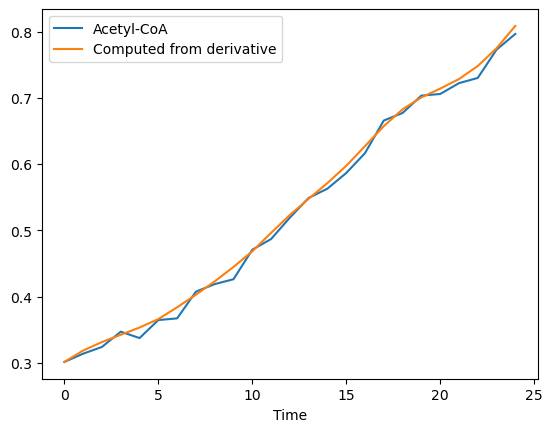

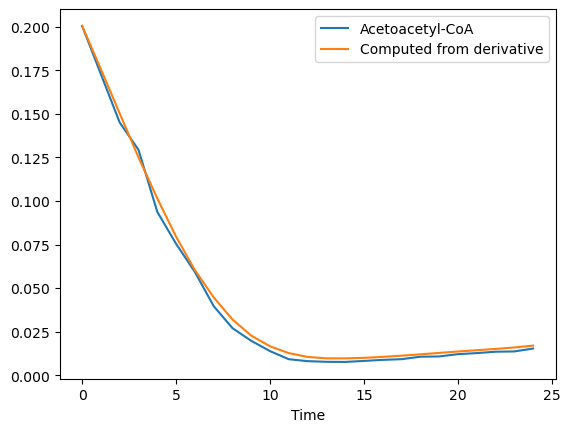

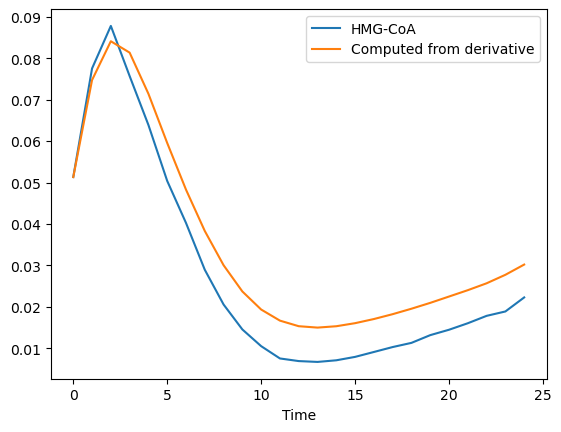

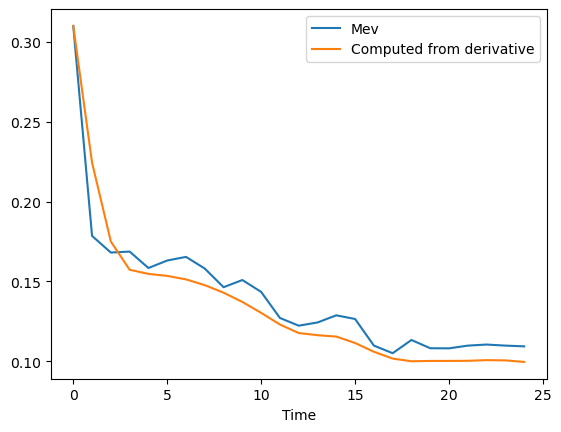

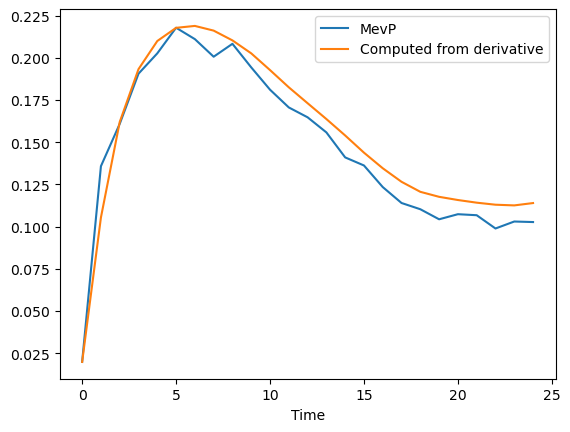

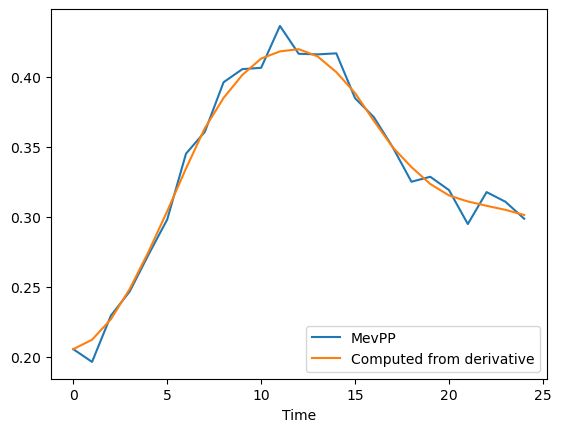

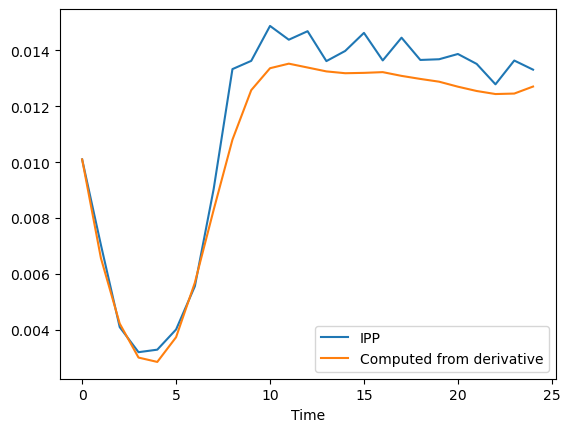

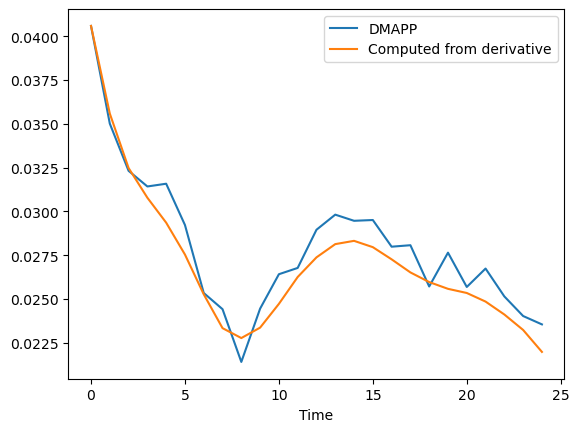

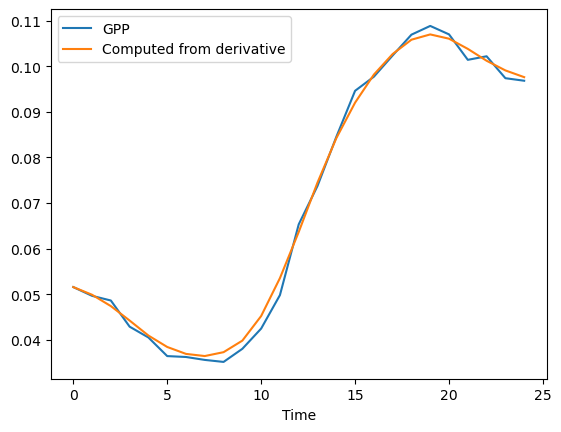

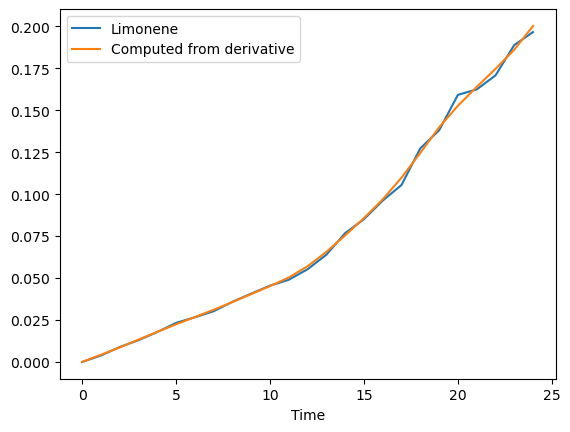

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.975196e+01  3.983424e+01  3.794074e+01  5.956960e+01   
         1.0   6.249594e+06  4.554122e+06  4.642054e+05  3.158696e+06   
         2.0   6.460884e+06  5.646401e+06  5.864881e+05  3.784643e+06   
         3.0   6.289634e+06  5.999581e+06  6.580465e+05  4.352695e+06   
         4.0   6.489455e+06  5.993516e+06  6.527094e+05  4.160313e+06   
...                     ...           ...           ...           ...   
WT       20.0  2.759534e+06  2.806880e+06  1.718219e+06  2.030949e+06   
         21.0  2.839004e+06  2.724442e+06  1.741879e+06  2.019368e+06   
         22.0  2.735385e+06  2.734672e+06  1.745721e+06  2.071503e+06   
         23.0  2.727123e+06  2.662943e+06  1.895038e+06  1.974409e+06   
         24.0  2.696941e+06  2.851061e+06  1.690293e+06  2.023971e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         1.0   9.584337e+05  5.561536e+06  3.604216e+06  8.619272e+05   
         2.0   1.199218e+06  7.479980e+06  3.957066e+06  1.064706e+06   
         3.0   1.384297e+06  7.957506e+06  4.211656e+06  1.138346e+06   
         4.0   1.311929e+06  8.228331e+06  4.347073e+06  1.058420e+06   
...                     ...           ...           ...           ...   
WT       20.0  1.428166e+06  3.791451e+06  4.230885e+06  1.179415e+06   
         21.0  1.455551e+06  3.733360e+06  4.332833e+06  1.212515e+06   
         22.0  1.480696e+06  3.868809e+06  4.342875e+06  1.224791e+06   
         23.0  1.522002e+06  3.918335e+06  4.286466e+06  1.258456e+06   
         24.0  1.452524e+06  4.039740e+06  4.289171e+06  1.220274e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.131118e+01   0.301424        0.200524  0.051314   
         1.0       3.775454e+05   0.284705        0.170455  0.091315   
         2.0       4.880878e+05   0.258418        0.140497  0.080569   
         3.0       5.496560e+05   0.243252        0.121485  0.054221   
         4.0       5.819817e+05   0.209823        0.084048  0.036914   
...                         ...        ...             ...       ...   
WT       20.0      1.448826e+06   0.705745        0.012078  0.014487   
         21.0      1.541641e+06   0.722097        0.012688  0.016057   
         22.0      1.474757e+06   0.729973        0.013484  0.017838   
         23.0      1.376270e+06   0.772631        0.013642  0.018896   
         24.0      1.416401e+06   0.796371        0.015308  0.022282   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.310136  0.019836  0.205338  0.010099  0.040591  0.051599   
         1.0   0.179084  0.137638  0.196130  0.007163  0.034982  0.050958   
         2.0   0.196493  0.174878  0.229748  0.004468  0.032050  0.051804   
         3.0   0.198993  0.230940  0.252752  0.003737  0.030865  0.047582   
         4.0   0.180731  0.257594  0.290562  0.004585  0.030485  0.047033   
...                 ...       ...       ...       ...       ...       ...   
WT       20.0  0.108064  0.107378  0.318979  0.013873  0.025689  0.106966   
         21.0  0.109773  0.106777  0.294749  0.013517  0.026741  0.101389   
         22.0  0.110445  0.098911  0.317567  0.012787  0.025149  0.102169   
         23.0  0.109780  0.103047  0.310

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.016095       -0.027109  0.030616 -0.084082  0.103589   
         1.0    -0.019280       -0.027651  0.012013 -0.053986  0.080235   
         2.0    -0.022466       -0.028192 -0.006590 -0.023890  0.056882   
         3.0    -0.020895       -0.027039 -0.017896 -0.001285  0.036360   
         4.0    -0.017584       -0.024649 -0.016046 -0.005445  0.022737   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.012445        0.000766  0.001590 -0.000408 -0.002041   
         21.0    0.016278        0.000715  0.001477  0.000567 -0.001110   
         22.0    0.023179        0.000741  0.001843  0.000252 -0.001304   
         23.0    0.030258        0.000952  0.002258 -0.000557  0.000490   
         24.0    0.037338        0.001163  0.002674 -0.001367  0.002283   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001128 -0.004168 -0.005920  0.000145  0.002700  
         1.0   0.010790 -0.002807 -0.004176 -0.000553  0.002928  
         2.0   0.022707 -0.001445 -0.002433 -0.001251  0.003155  
         3.0   0.032533  0.000074 -0.001777 -0.001679  0.003502  
         4.0   0.038850  0.002077 -0.002444 -0.000888  0.003512  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.004855 -0.000191 -0.000204 -0.001690  0.011129  
         21.0 -0.003711 -0.000118 -0.000777 -0.002771  0.011328  
         22.0 -0.002492 -0.000100 -0.000698 -0.002434  0.010134  
         23.0 -0.003277  0.000134 -0.001068 -0.001798  0.012815  
         24.0 -0.004062  0.000368 -0.001437 -0.001161  0.015496  

[100 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 9.737177E+191 | 9.994146E+116
     2 |       74 | 1.839105E+115 |  6.057761E+83
     3 |      138 |  6.720671E+90 |  6.478340E+70
     4 |      202 |  1.578192E+80 |  1.896695E+60
     5 |      266 |  3.639034E+73 |  6.515989E+53
     6 |      330 |  2.264467E+65 |  1.533187E+49
     7 |      394 |  8.605950E+62 |  1.473124E+48
     8 |      458 |  1.276726E+59 |  8.611264E+46
     9 |      522 |  4.441717E+54 |  6.645178E+42
    10 |      586 |  6.656583E+54 |  5.344252E+41
    11 |      650 |  2.072477E+49 |  1.498115E+36
    12 |      714 |  4.116541E+48 |  1.498115E+36
    13 |      778 |  2.026828E+42 |  6.125312E+35
    14 |      842 |  2.786810E+38 |  4.803506E+27
    15 |      906 |  1.752866E+36 |  3.443863E+23
    16 |      970 |  2.430823E+33 |  3.443863E+23
    17 |     1034 |  1.651506E+33 |  1.910003E+22
    18 |     1098 |  2.684956E+31 |  2.276962E+21
    19 |     1162 |  7.136

   163 |    10378 |  2.475211E+01 |  2.132099E+01
   164 |    10442 |  2.359292E+01 |  2.132099E+01
   165 |    10506 |  2.486819E+01 |  2.132099E+01
   166 |    10570 |  2.376836E+01 |  2.132099E+01
   167 |    10634 |  2.558921E+01 |  2.132099E+01
   168 |    10698 |  2.515976E+01 |  2.132099E+01
   169 |    10762 |  2.673575E+01 |  2.132099E+01
   170 |    10826 |  2.434149E+01 |  2.132099E+01
   171 |    10890 |  2.597408E+01 |  2.132099E+01
   172 |    10954 |  2.521154E+01 |  2.132099E+01
   173 |    11018 |  2.688461E+01 |  2.132099E+01
   174 |    11082 |  2.455021E+01 |  2.132099E+01
   175 |    11146 |  2.446658E+01 |  2.132099E+01
   176 |    11210 |  2.442771E+01 |  2.132099E+01
   177 |    11274 |  2.444330E+01 |  2.132099E+01
   178 |    11338 |  2.467388E+01 |  2.132099E+01
   179 |    11402 |  2.549640E+01 |  2.132099E+01
   180 |    11466 |  2.424776E+01 |  2.132099E+01
   181 |    11530 |  2.478534E+01 |  2.132099E+01
   182 |    11594 |  2.430408E+01 |  2.132099E+01


   327 |    20874 |  1.705737E+01 |  1.521991E+01
   328 |    20938 |  1.766387E+01 |  1.521991E+01
   329 |    21002 |  1.757962E+01 |  1.521991E+01
   330 |    21066 |  1.746225E+01 |  1.521991E+01
   331 |    21130 |  1.672354E+01 |  1.521991E+01
   332 |    21194 |  1.699553E+01 |  1.521991E+01
   333 |    21258 |  1.744265E+01 |  1.521991E+01
   334 |    21322 |  1.658034E+01 |  1.521991E+01
   335 |    21386 |  1.703167E+01 |  1.521991E+01
   336 |    21450 |  1.668294E+01 |  1.521991E+01
   337 |    21514 |  1.619535E+01 |  1.521991E+01
   338 |    21578 |  1.621913E+01 |  1.521991E+01
   339 |    21642 |  1.623543E+01 |  1.521991E+01
   340 |    21706 |  1.633204E+01 |  1.521991E+01
   341 |    21770 |  1.651504E+01 |  1.521991E+01
   342 |    21834 |  1.669623E+01 |  1.521991E+01
   343 |    21898 |  1.648927E+01 |  1.521991E+01
   344 |    21962 |  1.632157E+01 |  1.521991E+01
   345 |    22026 |  1.627356E+01 |  1.521991E+01
   346 |    22090 |  1.604115E+01 |  1.521991E+01


   491 |    31370 |  1.346730E+01 |  1.336236E+01
   492 |    31434 |  1.343534E+01 |  1.329318E+01
   493 |    31498 |  1.345125E+01 |  1.329318E+01
   494 |    31562 |  1.343052E+01 |  1.329318E+01
   495 |    31626 |  1.343117E+01 |  1.329318E+01
   496 |    31690 |  1.340419E+01 |  1.329318E+01
   497 |    31754 |  1.341024E+01 |  1.325945E+01
   498 |    31818 |  1.341676E+01 |  1.325945E+01
   499 |    31882 |  1.338812E+01 |  1.324133E+01
   500 |    31946 |  1.336504E+01 |  1.324133E+01
   501 |    32010 |  1.343980E+01 |  1.324133E+01
   502 |    32074 |  1.345138E+01 |  1.323612E+01
   503 |    32138 |  1.339860E+01 |  1.323612E+01
   504 |    32202 |  1.345267E+01 |  1.323612E+01
   505 |    32266 |  1.339272E+01 |  1.320574E+01
   506 |    32330 |  1.344131E+01 |  1.320574E+01
   507 |    32394 |  1.343756E+01 |  1.320574E+01
   508 |    32458 |  1.340874E+01 |  1.320574E+01
   509 |    32522 |  1.336996E+01 |  1.309992E+01
   510 |    32586 |  1.344043E+01 |  1.309992E+01


   655 |    41866 |  1.240363E+01 |  1.225135E+01
   656 |    41930 |  1.241296E+01 |  1.225135E+01
   657 |    41994 |  1.239712E+01 |  1.225135E+01
   658 |    42058 |  1.239703E+01 |  1.225135E+01
   659 |    42122 |  1.238487E+01 |  1.225135E+01
   660 |    42186 |  1.242109E+01 |  1.225135E+01
   661 |    42250 |  1.240223E+01 |  1.225135E+01
   662 |    42314 |  1.240814E+01 |  1.225135E+01
   663 |    42378 |  1.242957E+01 |  1.225135E+01
   664 |    42442 |  1.244523E+01 |  1.225135E+01
   665 |    42506 |  1.240011E+01 |  1.225135E+01
   666 |    42570 |  1.239674E+01 |  1.225135E+01
   667 |    42634 |  1.240251E+01 |  1.225135E+01
   668 |    42698 |  1.239774E+01 |  1.225135E+01
   669 |    42762 |  1.241575E+01 |  1.225135E+01
   670 |    42826 |  1.237890E+01 |  1.225135E+01
   671 |    42890 |  1.235958E+01 |  1.225135E+01
   672 |    42954 |  1.236427E+01 |  1.225135E+01
   673 |    43018 |  1.235471E+01 |  1.225135E+01
   674 |    43082 |  1.236859E+01 |  1.225135E+01


   819 |    52362 |  1.157003E+01 |  1.134004E+01
   820 |    52426 |  1.153750E+01 |  1.134004E+01
   821 |    52490 |  1.154945E+01 |  1.134004E+01
   822 |    52554 |  1.150644E+01 |  1.134004E+01
   823 |    52618 |  1.151082E+01 |  1.134004E+01
   824 |    52682 |  1.146792E+01 |  1.134004E+01
   825 |    52746 |  1.141742E+01 |  1.134004E+01
   826 |    52810 |  1.141327E+01 |  1.134004E+01
   827 |    52874 |  1.140459E+01 |  1.131551E+01
   828 |    52938 |  1.140827E+01 |  1.130499E+01
   829 |    53002 |  1.136821E+01 |  1.130383E+01
   830 |    53066 |  1.134563E+01 |  1.122214E+01
   831 |    53130 |  1.132061E+01 |  1.122214E+01
   832 |    53194 |  1.136242E+01 |  1.122214E+01
   833 |    53258 |  1.132961E+01 |  1.122214E+01
   834 |    53322 |  1.133768E+01 |  1.122214E+01
   835 |    53386 |  1.131188E+01 |  1.120798E+01
   836 |    53450 |  1.131727E+01 |  1.120798E+01
   837 |    53514 |  1.134521E+01 |  1.120798E+01
   838 |    53578 |  1.136706E+01 |  1.120798E+01


   983 |    62858 |  1.085734E+01 |  1.085485E+01
   984 |    62922 |  1.085613E+01 |  1.085450E+01
   985 |    62986 |  1.085441E+01 |  1.085176E+01
   986 |    63050 |  1.085315E+01 |  1.085087E+01
   987 |    63114 |  1.085303E+01 |  1.084947E+01
   988 |    63178 |  1.085259E+01 |  1.084947E+01
   989 |    63242 |  1.085156E+01 |  1.084831E+01
   990 |    63306 |  1.084940E+01 |  1.084768E+01
   991 |    63370 |  1.084875E+01 |  1.084729E+01
   992 |    63434 |  1.084915E+01 |  1.084729E+01
   993 |    63498 |  1.084799E+01 |  1.084720E+01
   994 |    63562 |  1.084701E+01 |  1.084610E+01
   995 |    63626 |  1.084611E+01 |  1.084521E+01
   996 |    63690 |  1.084541E+01 |  1.084321E+01
   997 |    63754 |  1.084465E+01 |  1.084315E+01
   998 |    63818 |  1.084400E+01 |  1.084292E+01
   999 |    63882 |  1.084282E+01 |  1.084132E+01
  1000 |    63946 |  1.084285E+01 |  1.083788E+01
  1001 |    64010 |  1.084216E+01 |  1.083788E+01
  1002 |    64074 |  1.084094E+01 |  1.083788E+01


  1147 |    73354 |  1.074921E+01 |  1.074867E+01
  1148 |    73418 |  1.074901E+01 |  1.074819E+01
  1149 |    73482 |  1.074849E+01 |  1.074793E+01
  1150 |    73546 |  1.074820E+01 |  1.074708E+01
  1151 |    73610 |  1.074742E+01 |  1.074633E+01
  1152 |    73674 |  1.074679E+01 |  1.074547E+01
  1153 |    73738 |  1.074608E+01 |  1.074519E+01
  1154 |    73802 |  1.074493E+01 |  1.074385E+01
  1155 |    73866 |  1.074410E+01 |  1.074274E+01
  1156 |    73930 |  1.074340E+01 |  1.074225E+01
  1157 |    73994 |  1.074287E+01 |  1.074225E+01
  1158 |    74058 |  1.074219E+01 |  1.074161E+01
  1159 |    74122 |  1.074156E+01 |  1.074079E+01
  1160 |    74186 |  1.074119E+01 |  1.074041E+01
  1161 |    74250 |  1.074042E+01 |  1.073905E+01
  1162 |    74314 |  1.073951E+01 |  1.073821E+01
  1163 |    74378 |  1.073874E+01 |  1.073819E+01
  1164 |    74442 |  1.073831E+01 |  1.073766E+01
  1165 |    74506 |  1.073738E+01 |  1.073625E+01
  1166 |    74570 |  1.073657E+01 |  1.073553E+01


  1311 |    83850 |  1.036638E+01 |  1.035641E+01
  1312 |    83914 |  1.036315E+01 |  1.035641E+01
  1313 |    83978 |  1.035999E+01 |  1.035198E+01
  1314 |    84042 |  1.035531E+01 |  1.034925E+01
  1315 |    84106 |  1.034960E+01 |  1.034008E+01
  1316 |    84170 |  1.034550E+01 |  1.034008E+01
  1317 |    84234 |  1.034357E+01 |  1.033684E+01
  1318 |    84298 |  1.033892E+01 |  1.033397E+01
  1319 |    84362 |  1.033554E+01 |  1.033164E+01
  1320 |    84426 |  1.033211E+01 |  1.032526E+01
  1321 |    84490 |  1.032962E+01 |  1.032526E+01
  1322 |    84554 |  1.032540E+01 |  1.032093E+01
  1323 |    84618 |  1.032091E+01 |  1.031719E+01
  1324 |    84682 |  1.031810E+01 |  1.031244E+01
  1325 |    84746 |  1.031661E+01 |  1.031244E+01
  1326 |    84810 |  1.031378E+01 |  1.031017E+01
  1327 |    84874 |  1.031274E+01 |  1.030580E+01
  1328 |    84938 |  1.031002E+01 |  1.030580E+01
  1329 |    85002 |  1.030828E+01 |  1.029773E+01
  1330 |    85066 |  1.030284E+01 |  1.029578E+01


  1475 |    94346 |  1.004961E+01 |  1.004506E+01
  1476 |    94410 |  1.004567E+01 |  1.003979E+01
  1477 |    94474 |  1.004092E+01 |  1.003511E+01
  1478 |    94538 |  1.003404E+01 |  1.002796E+01
  1479 |    94602 |  1.003034E+01 |  1.002524E+01
  1480 |    94666 |  1.002635E+01 |  1.002090E+01
  1481 |    94730 |  1.002051E+01 |  1.001245E+01
  1482 |    94794 |  1.001747E+01 |  1.001212E+01
  1483 |    94858 |  1.001443E+01 |  1.000898E+01
  1484 |    94922 |  1.000733E+01 |  9.9977480998
  1485 |    94986 |  1.000037E+01 |  9.9947451106
  1486 |    95050 |  9.9944042093 |  9.9830346982
  1487 |    95114 |  9.9875726775 |  9.9830346982
  1488 |    95178 |  9.9826086410 |  9.9762706704
  1489 |    95242 |  9.9778319979 |  9.9704614224
  1490 |    95306 |  9.9754511325 |  9.9704614224
  1491 |    95370 |  9.9729262231 |  9.9652445658
  1492 |    95434 |  9.9678396668 |  9.9573478454
  1493 |    95498 |  9.9620458010 |  9.9520827793
  1494 |    95562 |  9.9619667793 |  9.9510443271


  1639 |   104842 |  9.7584903663 |  9.7577943354
  1640 |   104906 |  9.7579365028 |  9.7568531875
  1641 |   104970 |  9.7572433799 |  9.7553509863
  1642 |   105034 |  9.7554860277 |  9.7543540863
  1643 |   105098 |  9.7545237428 |  9.7529336607
  1644 |   105162 |  9.7535104162 |  9.7518786255
  1645 |   105226 |  9.7520241842 |  9.7509263532
  1646 |   105290 |  9.7505537441 |  9.7493061650
  1647 |   105354 |  9.7493968449 |  9.7486806513
  1648 |   105418 |  9.7489644931 |  9.7478101255
  1649 |   105482 |  9.7483538042 |  9.7478101255
  1650 |   105546 |  9.7473832087 |  9.7428567086
  1651 |   105610 |  9.7453904948 |  9.7428567086
  1652 |   105674 |  9.7449886736 |  9.7428567086
  1653 |   105738 |  9.7443514099 |  9.7428567086
  1654 |   105802 |  9.7434812059 |  9.7408477548
  1655 |   105866 |  9.7407828076 |  9.7355050361
  1656 |   105930 |  9.7376024549 |  9.7353210712
  1657 |   105994 |  9.7342838543 |  9.7287096828
  1658 |   106058 |  9.7310736888 |  9.7277433817


  1803 |   115338 |  8.6849989824 |  8.6606469675
  1804 |   115402 |  8.6492220687 |  8.5853980439
  1805 |   115466 |  8.6296074495 |  8.5812240894
  1806 |   115530 |  8.5775585832 |  8.5425507121
  1807 |   115594 |  8.5373737969 |  8.5037830510
  1808 |   115658 |  8.5252753626 |  8.4973370941
  1809 |   115722 |  8.5204752444 |  8.4566499329
  1810 |   115786 |  8.4767318595 |  8.4122157250
  1811 |   115850 |  8.4587706364 |  8.4122157250
  1812 |   115914 |  8.4323072924 |  8.4121000574
  1813 |   115978 |  8.4119492549 |  8.3650463323
  1814 |   116042 |  8.3970944369 |  8.3650463323
  1815 |   116106 |  8.4005529014 |  8.3650463323
  1816 |   116170 |  8.3823392054 |  8.3519196414
  1817 |   116234 |  8.3783343437 |  8.3248997830
  1818 |   116298 |  8.3664307619 |  8.3247736305
  1819 |   116362 |  8.3477830642 |  8.3204165876
  1820 |   116426 |  8.3166776446 |  8.2550175574
  1821 |   116490 |  8.2935635125 |  8.2311857375
  1822 |   116554 |  8.2685396317 |  8.2261773343


  1967 |   125834 |  7.9076078929 |  7.9057790926
  1968 |   125898 |  7.9065994504 |  7.9054387061
  1969 |   125962 |  7.9071969214 |  7.9050208642
  1970 |   126026 |  7.9072522081 |  7.9048724965
  1971 |   126090 |  7.9065461332 |  7.9048724965
  1972 |   126154 |  7.9055355312 |  7.9043185726
  1973 |   126218 |  7.9052424692 |  7.9027511067
  1974 |   126282 |  7.9043621806 |  7.9023208467
  1975 |   126346 |  7.9023044020 |  7.8983544205
  1976 |   126410 |  7.9009354663 |  7.8983544205
  1977 |   126474 |  7.9011003257 |  7.8978033788
  1978 |   126538 |  7.9007992546 |  7.8978033788
  1979 |   126602 |  7.8998432423 |  7.8978033788
  1980 |   126666 |  7.8989509693 |  7.8976580820
  1981 |   126730 |  7.8977155458 |  7.8958139523
  1982 |   126794 |  7.8969861038 |  7.8953658597
  1983 |   126858 |  7.8961008316 |  7.8944106875
  1984 |   126922 |  7.8954330128 |  7.8930419658
  1985 |   126986 |  7.8950815268 |  7.8930419658
  1986 |   127050 |  7.8945179738 |  7.8930419658


  2131 |   136330 |  7.6153842383 |  7.6139188626
  2132 |   136394 |  7.6116317248 |  7.6088141621
  2133 |   136458 |  7.6075163161 |  7.5987553035
  2134 |   136522 |  7.6032952840 |  7.5975413763
  2135 |   136586 |  7.5979963036 |  7.5936946833
  2136 |   136650 |  7.5924961766 |  7.5842842265
  2137 |   136714 |  7.5890057700 |  7.5828313237
  2138 |   136778 |  7.5846168674 |  7.5796650645
  2139 |   136842 |  7.5833547251 |  7.5759672548
  2140 |   136906 |  7.5823412050 |  7.5759672548
  2141 |   136970 |  7.5814009305 |  7.5759672548
  2142 |   137034 |  7.5779440490 |  7.5752941632
  2143 |   137098 |  7.5739197688 |  7.5686516427
  2144 |   137162 |  7.5714836980 |  7.5617909232
  2145 |   137226 |  7.5647895825 |  7.5602789215
  2146 |   137290 |  7.5602721630 |  7.5515474452
  2147 |   137354 |  7.5554188964 |  7.5501517447
  2148 |   137418 |  7.5508426043 |  7.5457125372
  2149 |   137482 |  7.5471096672 |  7.5437789620
  2150 |   137546 |  7.5452616960 |  7.5402759737


  2295 |   146826 |  7.2208070233 |  7.2148943727
  2296 |   146890 |  7.2192754347 |  7.2141478956
  2297 |   146954 |  7.2176780488 |  7.2141478956
  2298 |   147018 |  7.2193504861 |  7.2141478956
  2299 |   147082 |  7.2198001408 |  7.2141478956
  2300 |   147146 |  7.2213086130 |  7.2141478956
  2301 |   147210 |  7.2205553520 |  7.2141478956
  2302 |   147274 |  7.2189005144 |  7.2141478956
  2303 |   147338 |  7.2174446787 |  7.2130716482
  2304 |   147402 |  7.2162606000 |  7.2130716482
  2305 |   147466 |  7.2170352327 |  7.2130716482
  2306 |   147530 |  7.2171253667 |  7.2116211825
  2307 |   147594 |  7.2156815786 |  7.2116211825
  2308 |   147658 |  7.2151768884 |  7.2114183161
  2309 |   147722 |  7.2160382715 |  7.2114183161
  2310 |   147786 |  7.2152006149 |  7.2114183161
  2311 |   147850 |  7.2140393504 |  7.2114183161
  2312 |   147914 |  7.2131256444 |  7.2104668766
  2313 |   147978 |  7.2119036093 |  7.2104668766
  2314 |   148042 |  7.2114031159 |  7.2085475073


  2459 |   157322 |  7.1733855888 |  7.1727871662
  2460 |   157386 |  7.1732165992 |  7.1727871662
  2461 |   157450 |  7.1732890419 |  7.1727871662
  2462 |   157514 |  7.1729201171 |  7.1726224699
  2463 |   157578 |  7.1727387004 |  7.1723604112
  2464 |   157642 |  7.1727091824 |  7.1723604112
  2465 |   157706 |  7.1724471223 |  7.1721944657
  2466 |   157770 |  7.1723249801 |  7.1721944657
  2467 |   157834 |  7.1723172285 |  7.1720157589
  2468 |   157898 |  7.1722620229 |  7.1718540113
  2469 |   157962 |  7.1722271787 |  7.1718540113
  2470 |   158026 |  7.1719773719 |  7.1715135217
  2471 |   158090 |  7.1717788214 |  7.1714195017
  2472 |   158154 |  7.1715082925 |  7.1713160418
  2473 |   158218 |  7.1715133243 |  7.1711121368
  2474 |   158282 |  7.1713804282 |  7.1709490259
  2475 |   158346 |  7.1712496885 |  7.1709490259
  2476 |   158410 |  7.1711182137 |  7.1708016437
  2477 |   158474 |  7.1709885845 |  7.1707778357
  2478 |   158538 |  7.1708326769 |  7.1705586149


  2623 |   167818 |  7.1418331428 |  7.1416576076
  2624 |   167882 |  7.1418177300 |  7.1413361038
  2625 |   167946 |  7.1417866016 |  7.1413361038
  2626 |   168010 |  7.1417757965 |  7.1413361038
  2627 |   168074 |  7.1419118438 |  7.1413361038
  2628 |   168138 |  7.1416452246 |  7.1411324658
  2629 |   168202 |  7.1413252916 |  7.1409633615
  2630 |   168266 |  7.1410473132 |  7.1404954019
  2631 |   168330 |  7.1408633193 |  7.1404860611
  2632 |   168394 |  7.1407358191 |  7.1404022933
  2633 |   168458 |  7.1404930496 |  7.1398114915
  2634 |   168522 |  7.1403037820 |  7.1396544895
  2635 |   168586 |  7.1401789914 |  7.1396544895
  2636 |   168650 |  7.1399066920 |  7.1392615633
  2637 |   168714 |  7.1395961478 |  7.1390256029
  2638 |   168778 |  7.1393304081 |  7.1388882023
  2639 |   168842 |  7.1391564902 |  7.1387720071
  2640 |   168906 |  7.1389104283 |  7.1384516194
  2641 |   168970 |  7.1387967375 |  7.1384004108
  2642 |   169034 |  7.1385166810 |  7.1379976928


  2787 |   178314 |  7.0911688610 |  7.0893297575
  2788 |   178378 |  7.0889649492 |  7.0841932897
  2789 |   178442 |  7.0836282362 |  7.0787258273
  2790 |   178506 |  7.0796836828 |  7.0768566369
  2791 |   178570 |  7.0761726473 |  7.0732919336
  2792 |   178634 |  7.0727805717 |  7.0707022314
  2793 |   178698 |  7.0686905269 |  7.0650973244
  2794 |   178762 |  7.0674343232 |  7.0648259049
  2795 |   178826 |  7.0656981943 |  7.0614256370
  2796 |   178890 |  7.0604184184 |  7.0576213389
  2797 |   178954 |  7.0573835170 |  7.0548141684
  2798 |   179018 |  7.0539679275 |  7.0493051263
  2799 |   179082 |  7.0503131470 |  7.0468525830
  2800 |   179146 |  7.0471047406 |  7.0447641352
  2801 |   179210 |  7.0459097856 |  7.0444772199
  2802 |   179274 |  7.0402245151 |  7.0306388297
  2803 |   179338 |  7.0335835763 |  7.0266389309
  2804 |   179402 |  7.0284524929 |  7.0237289001
  2805 |   179466 |  7.0209564482 |  7.0113688932
  2806 |   179530 |  7.0147757045 |  7.0098004036


  2951 |   188810 |  6.6713566246 |  6.6676271107
  2952 |   188874 |  6.6701332453 |  6.6672811811
  2953 |   188938 |  6.6689634695 |  6.6643231090
  2954 |   189002 |  6.6660057490 |  6.6632697069
  2955 |   189066 |  6.6640563033 |  6.6630861400
  2956 |   189130 |  6.6632973833 |  6.6618774623
  2957 |   189194 |  6.6620613653 |  6.6607005135
  2958 |   189258 |  6.6614758456 |  6.6604139170
  2959 |   189322 |  6.6606367096 |  6.6579290935
  2960 |   189386 |  6.6602320294 |  6.6579290935
  2961 |   189450 |  6.6598720312 |  6.6579290935
  2962 |   189514 |  6.6599796821 |  6.6562936499
  2963 |   189578 |  6.6585615571 |  6.6562936499
  2964 |   189642 |  6.6571751977 |  6.6557972493
  2965 |   189706 |  6.6570086148 |  6.6552647024
  2966 |   189770 |  6.6559679511 |  6.6547019845
  2967 |   189834 |  6.6556816324 |  6.6535224636
  2968 |   189898 |  6.6542717972 |  6.6521412749
  2969 |   189962 |  6.6540531319 |  6.6521412749
  2970 |   190026 |  6.6535061224 |  6.6521412749


  3115 |   199306 |  6.5063226122 |  6.5044128576
  3116 |   199370 |  6.5055686373 |  6.5035366344
  3117 |   199434 |  6.5047546538 |  6.5027379618
  3118 |   199498 |  6.5035512043 |  6.5006608038
  3119 |   199562 |  6.5036712962 |  6.5006608038
  3120 |   199626 |  6.5026496776 |  6.5004249622
  3121 |   199690 |  6.5005408824 |  6.4982976707
  3122 |   199754 |  6.5014767388 |  6.4982976707
  3123 |   199818 |  6.4997733992 |  6.4974187810
  3124 |   199882 |  6.4978110888 |  6.4962118359
  3125 |   199946 |  6.4971101466 |  6.4958083826
  3126 |   200010 |  6.4976760209 |  6.4952907036
  3127 |   200074 |  6.4963798704 |  6.4920087638
  3128 |   200138 |  6.4937981310 |  6.4899895814
  3129 |   200202 |  6.4921713233 |  6.4899895814
  3130 |   200266 |  6.4913485136 |  6.4892445209
  3131 |   200330 |  6.4910205538 |  6.4886676500
  3132 |   200394 |  6.4911172687 |  6.4886676500
  3133 |   200458 |  6.4905736880 |  6.4883794887
  3134 |   200522 |  6.4906084515 |  6.4883794887


  3279 |   209802 |  6.4362618453 |  6.4357109601
  3280 |   209866 |  6.4358862156 |  6.4352595365
  3281 |   209930 |  6.4354778982 |  6.4349923639
  3282 |   209994 |  6.4354009165 |  6.4349637005
  3283 |   210058 |  6.4352396859 |  6.4346406434
  3284 |   210122 |  6.4351786051 |  6.4346406434
  3285 |   210186 |  6.4348005767 |  6.4342737588
  3286 |   210250 |  6.4344966130 |  6.4339883290
  3287 |   210314 |  6.4342587115 |  6.4339161577
  3288 |   210378 |  6.4341968942 |  6.4338969129
  3289 |   210442 |  6.4339933259 |  6.4337001352
  3290 |   210506 |  6.4339114858 |  6.4335102855
  3291 |   210570 |  6.4337656233 |  6.4334413681
  3292 |   210634 |  6.4335027478 |  6.4331699592
  3293 |   210698 |  6.4331772897 |  6.4326586756
  3294 |   210762 |  6.4330170551 |  6.4326586756
  3295 |   210826 |  6.4329195064 |  6.4324633198
  3296 |   210890 |  6.4327012883 |  6.4322159356
  3297 |   210954 |  6.4324109303 |  6.4321586514
  3298 |   211018 |  6.4322009956 |  6.4319848031


  3443 |   220298 |  6.4044129003 |  6.4038766943
  3444 |   220362 |  6.4040106323 |  6.4033570731
  3445 |   220426 |  6.4037004513 |  6.4029115776
  3446 |   220490 |  6.4031034161 |  6.4025121035
  3447 |   220554 |  6.4027263972 |  6.4024216830
  3448 |   220618 |  6.4024159261 |  6.4019189124
  3449 |   220682 |  6.4020508666 |  6.4019053763
  3450 |   220746 |  6.4018778193 |  6.4013084595
  3451 |   220810 |  6.4014619509 |  6.4007547666
  3452 |   220874 |  6.4009728852 |  6.4003801791
  3453 |   220938 |  6.4007474797 |  6.4003220591
  3454 |   221002 |  6.4003436125 |  6.3999262742
  3455 |   221066 |  6.4001614546 |  6.3998585527
  3456 |   221130 |  6.3997722875 |  6.3992243578
  3457 |   221194 |  6.3992745778 |  6.3987257416
  3458 |   221258 |  6.3988799118 |  6.3977676669
  3459 |   221322 |  6.3977718533 |  6.3971707917
  3460 |   221386 |  6.3971854669 |  6.3963794258
  3461 |   221450 |  6.3966150306 |  6.3961154780
  3462 |   221514 |  6.3964240501 |  6.3952566425


  3607 |   230794 |  6.3410155021 |  6.3405797558
  3608 |   230858 |  6.3406259851 |  6.3401811402
  3609 |   230922 |  6.3401295404 |  6.3391259618
  3610 |   230986 |  6.3396515908 |  6.3388343712
  3611 |   231050 |  6.3391711753 |  6.3387745284
  3612 |   231114 |  6.3389192826 |  6.3385099271
  3613 |   231178 |  6.3386725389 |  6.3382221383
  3614 |   231242 |  6.3385729038 |  6.3382221383
  3615 |   231306 |  6.3382272763 |  6.3377816371
  3616 |   231370 |  6.3376841725 |  6.3371780923
  3617 |   231434 |  6.3372462730 |  6.3367817506
  3618 |   231498 |  6.3368668291 |  6.3363818094
  3619 |   231562 |  6.3366611409 |  6.3363175032
  3620 |   231626 |  6.3363219196 |  6.3355995897
  3621 |   231690 |  6.3357226148 |  6.3348465195
  3622 |   231754 |  6.3354085832 |  6.3343833988
  3623 |   231818 |  6.3350978114 |  6.3343833988
  3624 |   231882 |  6.3350392883 |  6.3343833988
  3625 |   231946 |  6.3345091199 |  6.3339939908
  3626 |   232010 |  6.3340812137 |  6.3328468373


  3771 |   241290 |  6.2872699894 |  6.2857920997
  3772 |   241354 |  6.2866440692 |  6.2857920997
  3773 |   241418 |  6.2856627291 |  6.2848429491
  3774 |   241482 |  6.2851106642 |  6.2843333008
  3775 |   241546 |  6.2846428298 |  6.2836169897
  3776 |   241610 |  6.2838905655 |  6.2829409077
  3777 |   241674 |  6.2835585419 |  6.2822956671
  3778 |   241738 |  6.2828222189 |  6.2810379261
  3779 |   241802 |  6.2817696831 |  6.2805608462
  3780 |   241866 |  6.2811489498 |  6.2800173996
  3781 |   241930 |  6.2805370980 |  6.2800173996
  3782 |   241994 |  6.2801075975 |  6.2795668293
  3783 |   242058 |  6.2798056192 |  6.2793868680
  3784 |   242122 |  6.2794205823 |  6.2790143669
  3785 |   242186 |  6.2791644916 |  6.2786417539
  3786 |   242250 |  6.2788064070 |  6.2781824358
  3787 |   242314 |  6.2782681266 |  6.2769907941
  3788 |   242378 |  6.2777498247 |  6.2769907941
  3789 |   242442 |  6.2773904838 |  6.2769653321
  3790 |   242506 |  6.2769009143 |  6.2761777662


  3935 |   251786 |  6.2171466069 |  6.2165679668
  3936 |   251850 |  6.2168113920 |  6.2160787150
  3937 |   251914 |  6.2166606014 |  6.2159606808
  3938 |   251978 |  6.2162913831 |  6.2158539328
  3939 |   252042 |  6.2159762751 |  6.2153111798
  3940 |   252106 |  6.2155835766 |  6.2147830732
  3941 |   252170 |  6.2149676333 |  6.2139348432
  3942 |   252234 |  6.2145844152 |  6.2139348432
  3943 |   252298 |  6.2145478146 |  6.2139348432
  3944 |   252362 |  6.2144221185 |  6.2138714181
  3945 |   252426 |  6.2141577098 |  6.2132765479
  3946 |   252490 |  6.2136762020 |  6.2131516508
  3947 |   252554 |  6.2134121064 |  6.2126625361
  3948 |   252618 |  6.2126780201 |  6.2118439692
  3949 |   252682 |  6.2122654726 |  6.2118439692
  3950 |   252746 |  6.2119542330 |  6.2117043877
  3951 |   252810 |  6.2117932665 |  6.2111163069
  3952 |   252874 |  6.2114046901 |  6.2109082209
  3953 |   252938 |  6.2110130963 |  6.2103239004
  3954 |   253002 |  6.2107166095 |  6.2099277489


  4099 |   262282 |  6.1657448638 |  6.1648408022
  4100 |   262346 |  6.1649940742 |  6.1641145431
  4101 |   262410 |  6.1645108322 |  6.1639096562
  4102 |   262474 |  6.1645220338 |  6.1639096562
  4103 |   262538 |  6.1643785952 |  6.1632661872
  4104 |   262602 |  6.1637058604 |  6.1628684525
  4105 |   262666 |  6.1627854964 |  6.1619699560
  4106 |   262730 |  6.1623739684 |  6.1617029779
  4107 |   262794 |  6.1620777128 |  6.1617029779
  4108 |   262858 |  6.1620235507 |  6.1615903288
  4109 |   262922 |  6.1617080145 |  6.1612728949
  4110 |   262986 |  6.1615969125 |  6.1609253663
  4111 |   263050 |  6.1610825604 |  6.1602228345
  4112 |   263114 |  6.1606796960 |  6.1596410711
  4113 |   263178 |  6.1603995235 |  6.1596410711
  4114 |   263242 |  6.1595853492 |  6.1588295195
  4115 |   263306 |  6.1592856307 |  6.1588295195
  4116 |   263370 |  6.1594948615 |  6.1588295195
  4117 |   263434 |  6.1592836240 |  6.1588140836
  4118 |   263498 |  6.1595988194 |  6.1588140836


  4263 |   272778 |  6.1116844447 |  6.1109321984
  4264 |   272842 |  6.1111508069 |  6.1106549576
  4265 |   272906 |  6.1110590372 |  6.1106277721
  4266 |   272970 |  6.1107328309 |  6.1103478191
  4267 |   273034 |  6.1106036310 |  6.1100471431
  4268 |   273098 |  6.1104977823 |  6.1099543842
  4269 |   273162 |  6.1101233387 |  6.1090442444
  4270 |   273226 |  6.1093218164 |  6.1083558910
  4271 |   273290 |  6.1087736596 |  6.1079927960
  4272 |   273354 |  6.1082176488 |  6.1076244322
  4273 |   273418 |  6.1078919401 |  6.1073158295
  4274 |   273482 |  6.1069262627 |  6.1059208970
  4275 |   273546 |  6.1062532521 |  6.1057936834
  4276 |   273610 |  6.1061725102 |  6.1057936834
  4277 |   273674 |  6.1058273372 |  6.1053336451
  4278 |   273738 |  6.1055370625 |  6.1045046423
  4279 |   273802 |  6.1055762414 |  6.1045046423
  4280 |   273866 |  6.1057513975 |  6.1045046423
  4281 |   273930 |  6.1053739417 |  6.1044730405
  4282 |   273994 |  6.1052250408 |  6.1044730405


  4427 |   283274 |  6.0626472463 |  6.0622097214
  4428 |   283338 |  6.0624855410 |  6.0621628247
  4429 |   283402 |  6.0624173936 |  6.0621432314
  4430 |   283466 |  6.0623571270 |  6.0620523492
  4431 |   283530 |  6.0621331709 |  6.0616457901
  4432 |   283594 |  6.0619834328 |  6.0615934112
  4433 |   283658 |  6.0617632138 |  6.0613287361
  4434 |   283722 |  6.0613200550 |  6.0606701169
  4435 |   283786 |  6.0609402167 |  6.0605411613
  4436 |   283850 |  6.0606191270 |  6.0600387757
  4437 |   283914 |  6.0603902294 |  6.0600372216
  4438 |   283978 |  6.0601444679 |  6.0596814347
  4439 |   284042 |  6.0601306173 |  6.0595135848
  4440 |   284106 |  6.0600623410 |  6.0595135848
  4441 |   284170 |  6.0600073174 |  6.0595096207
  4442 |   284234 |  6.0595884416 |  6.0589744825
  4443 |   284298 |  6.0590549646 |  6.0584564699
  4444 |   284362 |  6.0588561237 |  6.0578272714
  4445 |   284426 |  6.0584906261 |  6.0576539045
  4446 |   284490 |  6.0579240742 |  6.0572302527


  4591 |   293770 |  6.0284584723 |  6.0282937426
  4592 |   293834 |  6.0283269484 |  6.0281074532
  4593 |   293898 |  6.0281375483 |  6.0278664243
  4594 |   293962 |  6.0278669725 |  6.0275060579
  4595 |   294026 |  6.0276310018 |  6.0273869917
  4596 |   294090 |  6.0275285510 |  6.0273426554
  4597 |   294154 |  6.0274167054 |  6.0271819667
  4598 |   294218 |  6.0272805779 |  6.0269999104
  4599 |   294282 |  6.0271913353 |  6.0269999104
  4600 |   294346 |  6.0270477378 |  6.0267689598
  4601 |   294410 |  6.0268150200 |  6.0265870285
  4602 |   294474 |  6.0266892521 |  6.0265519674
  4603 |   294538 |  6.0263672062 |  6.0260145622
  4604 |   294602 |  6.0262124982 |  6.0259377455
  4605 |   294666 |  6.0260990643 |  6.0256204398
  4606 |   294730 |  6.0259313697 |  6.0256204398
  4607 |   294794 |  6.0258444844 |  6.0255997257
  4608 |   294858 |  6.0256453572 |  6.0254037940
  4609 |   294922 |  6.0253150524 |  6.0250998188
  4610 |   294986 |  6.0252049452 |  6.0248507685


  4755 |   304266 |  5.9725787227 |  5.9713652686
  4756 |   304330 |  5.9725185973 |  5.9713652686
  4757 |   304394 |  5.9728090381 |  5.9713652686
  4758 |   304458 |  5.9728619190 |  5.9713652686
  4759 |   304522 |  5.9725348925 |  5.9713652686
  4760 |   304586 |  5.9717983538 |  5.9707376068
  4761 |   304650 |  5.9714035791 |  5.9707376068
  4762 |   304714 |  5.9715237384 |  5.9699386937
  4763 |   304778 |  5.9712264593 |  5.9699386937
  4764 |   304842 |  5.9712653709 |  5.9698681620
  4765 |   304906 |  5.9714488771 |  5.9693168553
  4766 |   304970 |  5.9710092259 |  5.9693168553
  4767 |   305034 |  5.9725522610 |  5.9693168553
  4768 |   305098 |  5.9716340983 |  5.9693168553
  4769 |   305162 |  5.9713812418 |  5.9693168553
  4770 |   305226 |  5.9709020969 |  5.9693168553
  4771 |   305290 |  5.9713640649 |  5.9693168553
  4772 |   305354 |  5.9715114778 |  5.9693168553
  4773 |   305418 |  5.9718201861 |  5.9692647038
  4774 |   305482 |  5.9718385019 |  5.9692647038


  4919 |   314762 |  5.9373667869 |  5.9363466823
  4920 |   314826 |  5.9370760544 |  5.9363197800
  4921 |   314890 |  5.9365421660 |  5.9361484733
  4922 |   314954 |  5.9362737682 |  5.9356509913
  4923 |   315018 |  5.9357264416 |  5.9351595311
  4924 |   315082 |  5.9354949218 |  5.9349032588
  4925 |   315146 |  5.9352522308 |  5.9347373752
  4926 |   315210 |  5.9351429463 |  5.9347373752
  4927 |   315274 |  5.9352685407 |  5.9347373752
  4928 |   315338 |  5.9351850442 |  5.9346881299
  4929 |   315402 |  5.9348020752 |  5.9343344400
  4930 |   315466 |  5.9346343266 |  5.9342347900
  4931 |   315530 |  5.9345045002 |  5.9337809205
  4932 |   315594 |  5.9341088851 |  5.9337248000
  4933 |   315658 |  5.9338648907 |  5.9334594255
  4934 |   315722 |  5.9336115239 |  5.9333350629
  4935 |   315786 |  5.9334984830 |  5.9326354818
  4936 |   315850 |  5.9330959128 |  5.9326354818
  4937 |   315914 |  5.9329073991 |  5.9326002440
  4938 |   315978 |  5.9326873469 |  5.9323990673


  5083 |   325258 |  5.9194765887 |  5.9194171957
  5084 |   325322 |  5.9194740361 |  5.9193887466
  5085 |   325386 |  5.9194472870 |  5.9193231671
  5086 |   325450 |  5.9193913856 |  5.9192996420
  5087 |   325514 |  5.9193631775 |  5.9192872870
  5088 |   325578 |  5.9193431381 |  5.9192284812
  5089 |   325642 |  5.9193636956 |  5.9192284812
  5090 |   325706 |  5.9192963588 |  5.9191514195
  5091 |   325770 |  5.9192758746 |  5.9191514195
  5092 |   325834 |  5.9192016441 |  5.9191240180
  5093 |   325898 |  5.9191631924 |  5.9191190104
  5094 |   325962 |  5.9191577458 |  5.9190536950
  5095 |   326026 |  5.9191204811 |  5.9190536698
  5096 |   326090 |  5.9190794494 |  5.9189944026
  5097 |   326154 |  5.9190689032 |  5.9189828798
  5098 |   326218 |  5.9190112595 |  5.9189447627
  5099 |   326282 |  5.9189673638 |  5.9188781289
  5100 |   326346 |  5.9189116800 |  5.9188587037
  5101 |   326410 |  5.9189256734 |  5.9188306946
  5102 |   326474 |  5.9188710326 |  5.9188043211


  5247 |   335754 |  5.9097626946 |  5.9096085290
  5248 |   335818 |  5.9096573007 |  5.9095922043
  5249 |   335882 |  5.9096234565 |  5.9095535582
  5250 |   335946 |  5.9095302358 |  5.9093818627
  5251 |   336010 |  5.9094061175 |  5.9092489402
  5252 |   336074 |  5.9093208805 |  5.9091432873
  5253 |   336138 |  5.9092498483 |  5.9090930682
  5254 |   336202 |  5.9091792901 |  5.9090688935
  5255 |   336266 |  5.9090724883 |  5.9089408456
  5256 |   336330 |  5.9089558546 |  5.9088730138
  5257 |   336394 |  5.9088972634 |  5.9087297657
  5258 |   336458 |  5.9088673895 |  5.9087297657
  5259 |   336522 |  5.9087848686 |  5.9086484692
  5260 |   336586 |  5.9087639840 |  5.9085554802
  5261 |   336650 |  5.9086769166 |  5.9085554802
  5262 |   336714 |  5.9086075603 |  5.9085298909
  5263 |   336778 |  5.9085745822 |  5.9084933161
  5264 |   336842 |  5.9085299790 |  5.9084299410
  5265 |   336906 |  5.9085106362 |  5.9082492806
  5266 |   336970 |  5.9083661841 |  5.9082492806


  5411 |   346250 |  5.8737352616 |  5.8733092212
  5412 |   346314 |  5.8735476235 |  5.8733092212
  5413 |   346378 |  5.8737261922 |  5.8732450240
  5414 |   346442 |  5.8735496488 |  5.8726568540
  5415 |   346506 |  5.8731792402 |  5.8720601914
  5416 |   346570 |  5.8730277182 |  5.8720601914
  5417 |   346634 |  5.8726049310 |  5.8718856164
  5418 |   346698 |  5.8724409237 |  5.8714630632
  5419 |   346762 |  5.8721146600 |  5.8714006487
  5420 |   346826 |  5.8722609022 |  5.8714006487
  5421 |   346890 |  5.8719685578 |  5.8714006487
  5422 |   346954 |  5.8718234117 |  5.8712453498
  5423 |   347018 |  5.8717654267 |  5.8711731403
  5424 |   347082 |  5.8715608507 |  5.8710809708
  5425 |   347146 |  5.8713916077 |  5.8708860122
  5426 |   347210 |  5.8712600047 |  5.8708860122
  5427 |   347274 |  5.8710778405 |  5.8708377785
  5428 |   347338 |  5.8709022649 |  5.8704854673
  5429 |   347402 |  5.8708707849 |  5.8704854673
  5430 |   347466 |  5.8706962383 |  5.8704854673


  5575 |   356746 |  5.8381160952 |  5.8371124146
  5576 |   356810 |  5.8378567120 |  5.8368007890
  5577 |   356874 |  5.8369054011 |  5.8362710280
  5578 |   356938 |  5.8367429254 |  5.8354434500
  5579 |   357002 |  5.8367566832 |  5.8354434500
  5580 |   357066 |  5.8363860512 |  5.8354434500
  5581 |   357130 |  5.8364630857 |  5.8354434500
  5582 |   357194 |  5.8359925994 |  5.8351861873
  5583 |   357258 |  5.8360733587 |  5.8351861873
  5584 |   357322 |  5.8356342577 |  5.8349859479
  5585 |   357386 |  5.8356290612 |  5.8349859479
  5586 |   357450 |  5.8355828024 |  5.8349859479
  5587 |   357514 |  5.8352094666 |  5.8341985343
  5588 |   357578 |  5.8347266960 |  5.8340707641
  5589 |   357642 |  5.8345224896 |  5.8340707641
  5590 |   357706 |  5.8346706556 |  5.8340707641
  5591 |   357770 |  5.8345617343 |  5.8340616611
  5592 |   357834 |  5.8342372619 |  5.8338177818
  5593 |   357898 |  5.8342582861 |  5.8333020307
  5594 |   357962 |  5.8341786233 |  5.8332954331


  5739 |   367242 |  5.7976529304 |  5.7973551360
  5740 |   367306 |  5.7975281881 |  5.7973415164
  5741 |   367370 |  5.7974379593 |  5.7972273710
  5742 |   367434 |  5.7973592586 |  5.7969681099
  5743 |   367498 |  5.7972447703 |  5.7969681099
  5744 |   367562 |  5.7972014645 |  5.7969681099
  5745 |   367626 |  5.7971730532 |  5.7969669646
  5746 |   367690 |  5.7971677047 |  5.7969030790
  5747 |   367754 |  5.7971183552 |  5.7966141737
  5748 |   367818 |  5.7970248842 |  5.7966141737
  5749 |   367882 |  5.7969781288 |  5.7966141737
  5750 |   367946 |  5.7970293015 |  5.7966141737
  5751 |   368010 |  5.7969117622 |  5.7963983555
  5752 |   368074 |  5.7967807990 |  5.7963983555
  5753 |   368138 |  5.7967805457 |  5.7963983555
  5754 |   368202 |  5.7968018445 |  5.7963983555
  5755 |   368266 |  5.7966735330 |  5.7963460661
  5756 |   368330 |  5.7966496890 |  5.7963460661
  5757 |   368394 |  5.7965894373 |  5.7963460661
  5758 |   368458 |  5.7965559232 |  5.7963460661


  5903 |   377738 |  5.7809148630 |  5.7807410441
  5904 |   377802 |  5.7808445120 |  5.7807370976
  5905 |   377866 |  5.7807995639 |  5.7804831401
  5906 |   377930 |  5.7805755034 |  5.7803620677
  5907 |   377994 |  5.7803336017 |  5.7802115003
  5908 |   378058 |  5.7803048984 |  5.7801124161
  5909 |   378122 |  5.7802023444 |  5.7800060420
  5910 |   378186 |  5.7801512676 |  5.7800060420
  5911 |   378250 |  5.7800185755 |  5.7798750944
  5912 |   378314 |  5.7799244624 |  5.7797935733
  5913 |   378378 |  5.7797902576 |  5.7796611616
  5914 |   378442 |  5.7796324095 |  5.7794649896
  5915 |   378506 |  5.7794803966 |  5.7791606916
  5916 |   378570 |  5.7793767791 |  5.7791063345
  5917 |   378634 |  5.7793113552 |  5.7790875906
  5918 |   378698 |  5.7792404167 |  5.7790875906
  5919 |   378762 |  5.7791688117 |  5.7789266325
  5920 |   378826 |  5.7789166683 |  5.7786979080
  5921 |   378890 |  5.7787863339 |  5.7785621116
  5922 |   378954 |  5.7786078863 |  5.7782650047


  6067 |   388234 |  5.7562557944 |  5.7559968958
  6068 |   388298 |  5.7559441298 |  5.7556610445
  6069 |   388362 |  5.7558702150 |  5.7554837657
  6070 |   388426 |  5.7556269114 |  5.7551511640
  6071 |   388490 |  5.7552932306 |  5.7550223607
  6072 |   388554 |  5.7551623553 |  5.7549101021
  6073 |   388618 |  5.7550508542 |  5.7546944655
  6074 |   388682 |  5.7549320721 |  5.7546410872
  6075 |   388746 |  5.7547338400 |  5.7542331575
  6076 |   388810 |  5.7545046630 |  5.7540347076
  6077 |   388874 |  5.7542694956 |  5.7540036671
  6078 |   388938 |  5.7540558165 |  5.7536651535
  6079 |   389002 |  5.7538145849 |  5.7535737218
  6080 |   389066 |  5.7537281971 |  5.7535555596
  6081 |   389130 |  5.7535597078 |  5.7532670907
  6082 |   389194 |  5.7533835752 |  5.7532670907
  6083 |   389258 |  5.7532445153 |  5.7528789574
  6084 |   389322 |  5.7531394863 |  5.7528189494
  6085 |   389386 |  5.7530490420 |  5.7528189494
  6086 |   389450 |  5.7528623713 |  5.7526965699


  6231 |   398730 |  5.7034653359 |  5.7023110684
  6232 |   398794 |  5.7031332277 |  5.7017488663
  6233 |   398858 |  5.7027313608 |  5.7017488663
  6234 |   398922 |  5.7024405012 |  5.7008109545
  6235 |   398986 |  5.7017412230 |  5.7005856842
  6236 |   399050 |  5.7009894421 |  5.6999260235
  6237 |   399114 |  5.7007763872 |  5.6999260235
  6238 |   399178 |  5.7001980688 |  5.6995844537
  6239 |   399242 |  5.7001164398 |  5.6995844537
  6240 |   399306 |  5.6999506239 |  5.6989865822
  6241 |   399370 |  5.6998027407 |  5.6989865822
  6242 |   399434 |  5.6995160363 |  5.6989865822
  6243 |   399498 |  5.6993589849 |  5.6985102058
  6244 |   399562 |  5.6994781997 |  5.6985102058
  6245 |   399626 |  5.6995233686 |  5.6985102058
  6246 |   399690 |  5.6994868980 |  5.6979439059
  6247 |   399754 |  5.6988801336 |  5.6979439059
  6248 |   399818 |  5.6989031965 |  5.6977563859
  6249 |   399882 |  5.6982324292 |  5.6959276124
  6250 |   399946 |  5.6974952124 |  5.6959276124


  6395 |   409226 |  5.6709742383 |  5.6708119473
  6396 |   409290 |  5.6707842401 |  5.6705545519
  6397 |   409354 |  5.6707231848 |  5.6705338490
  6398 |   409418 |  5.6704524079 |  5.6701475418
  6399 |   409482 |  5.6703368438 |  5.6700330079
  6400 |   409546 |  5.6701392966 |  5.6700173175
  6401 |   409610 |  5.6699783493 |  5.6698309858
  6402 |   409674 |  5.6699320190 |  5.6696764301
  6403 |   409738 |  5.6698830817 |  5.6696764301
  6404 |   409802 |  5.6698068473 |  5.6696375329
  6405 |   409866 |  5.6697206964 |  5.6695943278
  6406 |   409930 |  5.6696138246 |  5.6695664432
  6407 |   409994 |  5.6694718488 |  5.6693285918
  6408 |   410058 |  5.6693506908 |  5.6690401863
  6409 |   410122 |  5.6691351425 |  5.6690401863
  6410 |   410186 |  5.6690731067 |  5.6689562162
  6411 |   410250 |  5.6689813480 |  5.6687485564
  6412 |   410314 |  5.6688299471 |  5.6685900733
  6413 |   410378 |  5.6687462094 |  5.6685884225
  6414 |   410442 |  5.6686873245 |  5.6685437693


  6559 |   419722 |  5.6407465403 |  5.6404871928
  6560 |   419786 |  5.6404702608 |  5.6402578433
  6561 |   419850 |  5.6401886265 |  5.6399525533
  6562 |   419914 |  5.6399803107 |  5.6398798567
  6563 |   419978 |  5.6398188255 |  5.6392800671
  6564 |   420042 |  5.6394747784 |  5.6392800671
  6565 |   420106 |  5.6393119768 |  5.6387564538
  6566 |   420170 |  5.6390623834 |  5.6387564538
  6567 |   420234 |  5.6389650305 |  5.6386511433
  6568 |   420298 |  5.6385907750 |  5.6381083588
  6569 |   420362 |  5.6381843937 |  5.6373675292
  6570 |   420426 |  5.6376231036 |  5.6372240261
  6571 |   420490 |  5.6374611571 |  5.6372240261
  6572 |   420554 |  5.6372704087 |  5.6370096358
  6573 |   420618 |  5.6371514973 |  5.6364098664
  6574 |   420682 |  5.6368362874 |  5.6362448079
  6575 |   420746 |  5.6365571303 |  5.6360442075
  6576 |   420810 |  5.6361245568 |  5.6355601232
  6577 |   420874 |  5.6359677870 |  5.6354895879
  6578 |   420938 |  5.6357766128 |  5.6354219549


  6723 |   430218 |  5.6201745506 |  5.6200866008
  6724 |   430282 |  5.6201246289 |  5.6200801891
  6725 |   430346 |  5.6200960574 |  5.6200011975
  6726 |   430410 |  5.6200443944 |  5.6199572416
  6727 |   430474 |  5.6200115660 |  5.6199572416
  6728 |   430538 |  5.6199862650 |  5.6199219448
  6729 |   430602 |  5.6199410211 |  5.6198644441
  6730 |   430666 |  5.6198516764 |  5.6198017536
  6731 |   430730 |  5.6198036436 |  5.6197118302
  6732 |   430794 |  5.6197393705 |  5.6196244577
  6733 |   430858 |  5.6196783818 |  5.6195100155
  6734 |   430922 |  5.6195924934 |  5.6194921317
  6735 |   430986 |  5.6195595797 |  5.6194921317
  6736 |   431050 |  5.6195139614 |  5.6194772985
  6737 |   431114 |  5.6194963462 |  5.6194230226
  6738 |   431178 |  5.6194107490 |  5.6192685594
  6739 |   431242 |  5.6192722824 |  5.6191656903
  6740 |   431306 |  5.6191280753 |  5.6190270766
  6741 |   431370 |  5.6190350817 |  5.6190055241
  6742 |   431434 |  5.6189617359 |  5.6189056895


  6887 |   440714 |  5.6037444075 |  5.6035612023
  6888 |   440778 |  5.6035924722 |  5.6033521185
  6889 |   440842 |  5.6035551358 |  5.6033119255
  6890 |   440906 |  5.6034960779 |  5.6033119255
  6891 |   440970 |  5.6034484941 |  5.6033119255
  6892 |   441034 |  5.6034642856 |  5.6033119255
  6893 |   441098 |  5.6034649973 |  5.6033119255
  6894 |   441162 |  5.6034316001 |  5.6033026297
  6895 |   441226 |  5.6033373721 |  5.6030221463
  6896 |   441290 |  5.6031931556 |  5.6029828797
  6897 |   441354 |  5.6030060656 |  5.6028787949
  6898 |   441418 |  5.6029178654 |  5.6024586914
  6899 |   441482 |  5.6026889749 |  5.6024136852
  6900 |   441546 |  5.6025189967 |  5.6021886015
  6901 |   441610 |  5.6026140088 |  5.6021886015
  6902 |   441674 |  5.6025837883 |  5.6021886015
  6903 |   441738 |  5.6024435840 |  5.6021886015
  6904 |   441802 |  5.6022027286 |  5.6019474029
  6905 |   441866 |  5.6020435462 |  5.6017425182
  6906 |   441930 |  5.6019820764 |  5.6017425182


  7051 |   451210 |  5.5894454532 |  5.5891744430
  7052 |   451274 |  5.5892920151 |  5.5891668903
  7053 |   451338 |  5.5892532697 |  5.5891077173
  7054 |   451402 |  5.5892778721 |  5.5891077173
  7055 |   451466 |  5.5892318558 |  5.5889699302
  7056 |   451530 |  5.5892246050 |  5.5889699302
  7057 |   451594 |  5.5891745429 |  5.5889500012
  7058 |   451658 |  5.5890311421 |  5.5886834620
  7059 |   451722 |  5.5890043377 |  5.5886790532
  7060 |   451786 |  5.5887719513 |  5.5885882027
  7061 |   451850 |  5.5886117057 |  5.5883524728
  7062 |   451914 |  5.5885950678 |  5.5883493589
  7063 |   451978 |  5.5883693631 |  5.5881928294
  7064 |   452042 |  5.5883274068 |  5.5879782473
  7065 |   452106 |  5.5880254644 |  5.5877604510
  7066 |   452170 |  5.5878473858 |  5.5876265574
  7067 |   452234 |  5.5876380597 |  5.5873746826
  7068 |   452298 |  5.5875022102 |  5.5872547932
  7069 |   452362 |  5.5874143561 |  5.5870869162
  7070 |   452426 |  5.5872028244 |  5.5870454377


  7215 |   461706 |  5.5766892870 |  5.5763745713
  7216 |   461770 |  5.5764124481 |  5.5759363629
  7217 |   461834 |  5.5761376471 |  5.5758055676
  7218 |   461898 |  5.5758260005 |  5.5756486008
  7219 |   461962 |  5.5756491769 |  5.5755687058
  7220 |   462026 |  5.5752789860 |  5.5748136340
  7221 |   462090 |  5.5749709488 |  5.5744044613
  7222 |   462154 |  5.5744707871 |  5.5739323452
  7223 |   462218 |  5.5740498324 |  5.5738387908
  7224 |   462282 |  5.5739614851 |  5.5737304741
  7225 |   462346 |  5.5736744909 |  5.5733440923
  7226 |   462410 |  5.5732264370 |  5.5721806631
  7227 |   462474 |  5.5722669764 |  5.5713133302
  7228 |   462538 |  5.5713426882 |  5.5706868240
  7229 |   462602 |  5.5705590139 |  5.5695536678
  7230 |   462666 |  5.5697225005 |  5.5691525225
  7231 |   462730 |  5.5693248891 |  5.5687651086
  7232 |   462794 |  5.5689332739 |  5.5684060867
  7233 |   462858 |  5.5685246329 |  5.5673538146
  7234 |   462922 |  5.5679095552 |  5.5673538146


  7379 |   472202 |  5.5473030740 |  5.5472271675
  7380 |   472266 |  5.5472772187 |  5.5472255761
  7381 |   472330 |  5.5472678452 |  5.5472114092
  7382 |   472394 |  5.5472718599 |  5.5471930923
  7383 |   472458 |  5.5471987096 |  5.5470475124
  7384 |   472522 |  5.5471391279 |  5.5469544731
  7385 |   472586 |  5.5470540505 |  5.5468434308
  7386 |   472650 |  5.5469573599 |  5.5468434308
  7387 |   472714 |  5.5469029474 |  5.5467560939
  7388 |   472778 |  5.5468564893 |  5.5467067670
  7389 |   472842 |  5.5468014064 |  5.5466919101
  7390 |   472906 |  5.5467678213 |  5.5466278483
  7391 |   472970 |  5.5467386447 |  5.5465978899
  7392 |   473034 |  5.5466913526 |  5.5465594794
  7393 |   473098 |  5.5466827663 |  5.5465594794
  7394 |   473162 |  5.5466772735 |  5.5464452034
  7395 |   473226 |  5.5465788002 |  5.5464452034
  7396 |   473290 |  5.5465030666 |  5.5463699108
  7397 |   473354 |  5.5465440150 |  5.5463699108
  7398 |   473418 |  5.5464943844 |  5.5463506019


  7543 |   482698 |  5.5396802053 |  5.5394297334
  7544 |   482762 |  5.5396113532 |  5.5394297334
  7545 |   482826 |  5.5394893784 |  5.5391348482
  7546 |   482890 |  5.5392617024 |  5.5390307599
  7547 |   482954 |  5.5391223720 |  5.5389859707
  7548 |   483018 |  5.5390238271 |  5.5388772560
  7549 |   483082 |  5.5388963042 |  5.5387379468
  7550 |   483146 |  5.5388188805 |  5.5386196720
  7551 |   483210 |  5.5387979801 |  5.5385298390
  7552 |   483274 |  5.5387670843 |  5.5385298390
  7553 |   483338 |  5.5385932773 |  5.5384379202
  7554 |   483402 |  5.5384248092 |  5.5381009191
  7555 |   483466 |  5.5382624018 |  5.5380878264
  7556 |   483530 |  5.5382370471 |  5.5379545283
  7557 |   483594 |  5.5380610735 |  5.5378785043
  7558 |   483658 |  5.5378978715 |  5.5375704096
  7559 |   483722 |  5.5377559164 |  5.5374958229
  7560 |   483786 |  5.5375320651 |  5.5371680021
  7561 |   483850 |  5.5374157528 |  5.5368826708
  7562 |   483914 |  5.5371091801 |  5.5368826708


  7707 |   493194 |  5.5202539543 |  5.5199728071
  7708 |   493258 |  5.5201053912 |  5.5197553630
  7709 |   493322 |  5.5200514100 |  5.5197553630
  7710 |   493386 |  5.5199714840 |  5.5197553630
  7711 |   493450 |  5.5199187151 |  5.5197072720
  7712 |   493514 |  5.5199324264 |  5.5197072720
  7713 |   493578 |  5.5197820718 |  5.5195238503
  7714 |   493642 |  5.5197036394 |  5.5193899324
  7715 |   493706 |  5.5197159649 |  5.5193899324
  7716 |   493770 |  5.5195904694 |  5.5193899324
  7717 |   493834 |  5.5194690873 |  5.5192577535
  7718 |   493898 |  5.5193938291 |  5.5191857390
  7719 |   493962 |  5.5193850706 |  5.5191857390
  7720 |   494026 |  5.5194037311 |  5.5191857390
  7721 |   494090 |  5.5193857374 |  5.5191857390
  7722 |   494154 |  5.5192976705 |  5.5191837822
  7723 |   494218 |  5.5192378123 |  5.5190686330
  7724 |   494282 |  5.5191772763 |  5.5190686330
  7725 |   494346 |  5.5191381590 |  5.5189340830
  7726 |   494410 |  5.5190505451 |  5.5186783160


  7871 |   503690 |  5.5068027368 |  5.5066691097
  7872 |   503754 |  5.5066950641 |  5.5066309637
  7873 |   503818 |  5.5066150533 |  5.5065289000
  7874 |   503882 |  5.5065731829 |  5.5064661779
  7875 |   503946 |  5.5064301347 |  5.5062816635
  7876 |   504010 |  5.5063114633 |  5.5060614583
  7877 |   504074 |  5.5062183740 |  5.5059201687
  7878 |   504138 |  5.5061423655 |  5.5057899189
  7879 |   504202 |  5.5060226604 |  5.5057899189
  7880 |   504266 |  5.5058981769 |  5.5056728701
  7881 |   504330 |  5.5057775293 |  5.5056374856
  7882 |   504394 |  5.5056377315 |  5.5055021795
  7883 |   504458 |  5.5055739035 |  5.5049010923
  7884 |   504522 |  5.5052422768 |  5.5049010923
  7885 |   504586 |  5.5052221957 |  5.5046495750
  7886 |   504650 |  5.5049662910 |  5.5046495750
  7887 |   504714 |  5.5049122236 |  5.5041437558
  7888 |   504778 |  5.5045961659 |  5.5041437558
  7889 |   504842 |  5.5043860752 |  5.5037015368
  7890 |   504906 |  5.5042043067 |  5.5036928759


  8035 |   514186 |  5.4845907573 |  5.4844273668
  8036 |   514250 |  5.4845784357 |  5.4844273668
  8037 |   514314 |  5.4844229223 |  5.4842486970
  8038 |   514378 |  5.4842807777 |  5.4841547998
  8039 |   514442 |  5.4842240917 |  5.4840338615
  8040 |   514506 |  5.4840885298 |  5.4839482818
  8041 |   514570 |  5.4840267856 |  5.4839482818
  8042 |   514634 |  5.4839256044 |  5.4837896436
  8043 |   514698 |  5.4837954652 |  5.4836358193
  8044 |   514762 |  5.4836641139 |  5.4835969942
  8045 |   514826 |  5.4835990138 |  5.4834769049
  8046 |   514890 |  5.4835314064 |  5.4834233598
  8047 |   514954 |  5.4834334860 |  5.4833543321
  8048 |   515018 |  5.4833744250 |  5.4832051887
  8049 |   515082 |  5.4832013471 |  5.4831220443
  8050 |   515146 |  5.4831540080 |  5.4830408515
  8051 |   515210 |  5.4831354718 |  5.4830171452
  8052 |   515274 |  5.4830662201 |  5.4829720716
  8053 |   515338 |  5.4830469442 |  5.4829154720
  8054 |   515402 |  5.4829750945 |  5.4829152247


  8199 |   524682 |  5.4757656747 |  5.4757080871
  8200 |   524746 |  5.4757239535 |  5.4755999944
  8201 |   524810 |  5.4756752664 |  5.4755224640
  8202 |   524874 |  5.4756428757 |  5.4755207313
  8203 |   524938 |  5.4755836577 |  5.4755207313
  8204 |   525002 |  5.4755735558 |  5.4754978226
  8205 |   525066 |  5.4755083863 |  5.4753585994
  8206 |   525130 |  5.4754513287 |  5.4753442126
  8207 |   525194 |  5.4753705467 |  5.4753055912
  8208 |   525258 |  5.4753115296 |  5.4752207172
  8209 |   525322 |  5.4752659286 |  5.4751856843
  8210 |   525386 |  5.4752101082 |  5.4751443306
  8211 |   525450 |  5.4751568030 |  5.4750916778
  8212 |   525514 |  5.4750685752 |  5.4749269861
  8213 |   525578 |  5.4749609297 |  5.4748546930
  8214 |   525642 |  5.4749229673 |  5.4747909332
  8215 |   525706 |  5.4748540532 |  5.4747670950
  8216 |   525770 |  5.4748075615 |  5.4746982355
  8217 |   525834 |  5.4746894940 |  5.4745570731
  8218 |   525898 |  5.4746498746 |  5.4745570731


  8363 |   535178 |  5.4551985117 |  5.4550759301
  8364 |   535242 |  5.4551456848 |  5.4549968820
  8365 |   535306 |  5.4550973861 |  5.4549635762
  8366 |   535370 |  5.4551462542 |  5.4549635762
  8367 |   535434 |  5.4550150655 |  5.4548706388
  8368 |   535498 |  5.4550143099 |  5.4548095100
  8369 |   535562 |  5.4548728853 |  5.4546265729
  8370 |   535626 |  5.4549274452 |  5.4546265729
  8371 |   535690 |  5.4547353096 |  5.4543557795
  8372 |   535754 |  5.4545484168 |  5.4543010961
  8373 |   535818 |  5.4546318852 |  5.4543010961
  8374 |   535882 |  5.4545629912 |  5.4543010961
  8375 |   535946 |  5.4545033898 |  5.4543010961
  8376 |   536010 |  5.4543525519 |  5.4541598705
  8377 |   536074 |  5.4542642434 |  5.4540599047
  8378 |   536138 |  5.4541729541 |  5.4540397525
  8379 |   536202 |  5.4541526333 |  5.4540150773
  8380 |   536266 |  5.4540644945 |  5.4538955849
  8381 |   536330 |  5.4540095970 |  5.4538929988
  8382 |   536394 |  5.4539158004 |  5.4536717850


  8527 |   545674 |  5.4320542754 |  5.4316939564
  8528 |   545738 |  5.4318329994 |  5.4313191157
  8529 |   545802 |  5.4316271640 |  5.4313191157
  8530 |   545866 |  5.4315104032 |  5.4311081804
  8531 |   545930 |  5.4314592880 |  5.4311081804
  8532 |   545994 |  5.4312630803 |  5.4310430275
  8533 |   546058 |  5.4311056930 |  5.4307779103
  8534 |   546122 |  5.4310072605 |  5.4307779103
  8535 |   546186 |  5.4307426731 |  5.4302912199
  8536 |   546250 |  5.4305617364 |  5.4302912199
  8537 |   546314 |  5.4303283569 |  5.4300800580
  8538 |   546378 |  5.4302383205 |  5.4297947611
  8539 |   546442 |  5.4299925033 |  5.4297057825
  8540 |   546506 |  5.4300275525 |  5.4297057825
  8541 |   546570 |  5.4298453500 |  5.4296133132
  8542 |   546634 |  5.4297037954 |  5.4295342315
  8543 |   546698 |  5.4297364580 |  5.4292506285
  8544 |   546762 |  5.4297171323 |  5.4292506285
  8545 |   546826 |  5.4297401079 |  5.4292381290
  8546 |   546890 |  5.4294652160 |  5.4292381290


  8691 |   556170 |  5.4093033102 |  5.4090141132
  8692 |   556234 |  5.4092675165 |  5.4089686397
  8693 |   556298 |  5.4091493495 |  5.4088629591
  8694 |   556362 |  5.4090467519 |  5.4088533707
  8695 |   556426 |  5.4088882370 |  5.4086827284
  8696 |   556490 |  5.4088276937 |  5.4085509249
  8697 |   556554 |  5.4087212066 |  5.4085509249
  8698 |   556618 |  5.4086521033 |  5.4083527997
  8699 |   556682 |  5.4084890443 |  5.4082731092
  8700 |   556746 |  5.4084443308 |  5.4082731092
  8701 |   556810 |  5.4083936072 |  5.4082692526
  8702 |   556874 |  5.4082445730 |  5.4078803702
  8703 |   556938 |  5.4081010030 |  5.4078803702
  8704 |   557002 |  5.4080807001 |  5.4078803702
  8705 |   557066 |  5.4080596140 |  5.4078803702
  8706 |   557130 |  5.4079267582 |  5.4078164530
  8707 |   557194 |  5.4077380952 |  5.4074367125
  8708 |   557258 |  5.4076335232 |  5.4074367125
  8709 |   557322 |  5.4074715902 |  5.4071414412
  8710 |   557386 |  5.4073259428 |  5.4069448768


  8855 |   566666 |  5.3804778652 |  5.3800695899
  8856 |   566730 |  5.3802874451 |  5.3800271560
  8857 |   566794 |  5.3801775585 |  5.3798167381
  8858 |   566858 |  5.3799250673 |  5.3792532826
  8859 |   566922 |  5.3799501904 |  5.3792532826
  8860 |   566986 |  5.3795880245 |  5.3791576304
  8861 |   567050 |  5.3793844563 |  5.3789916214
  8862 |   567114 |  5.3790695237 |  5.3786192681
  8863 |   567178 |  5.3788925118 |  5.3786192681
  8864 |   567242 |  5.3787935142 |  5.3786192681
  8865 |   567306 |  5.3786834238 |  5.3785033624
  8866 |   567370 |  5.3786267855 |  5.3785033624
  8867 |   567434 |  5.3785177918 |  5.3783063046
  8868 |   567498 |  5.3784801722 |  5.3782613479
  8869 |   567562 |  5.3784188886 |  5.3781411235
  8870 |   567626 |  5.3783141816 |  5.3780670735
  8871 |   567690 |  5.3783095854 |  5.3780670735
  8872 |   567754 |  5.3782205629 |  5.3780670735
  8873 |   567818 |  5.3781519988 |  5.3779589402
  8874 |   567882 |  5.3780593656 |  5.3778665866


  9019 |   577162 |  5.3267745271 |  5.3261209584
  9020 |   577226 |  5.3266146237 |  5.3257367922
  9021 |   577290 |  5.3260721056 |  5.3243273320
  9022 |   577354 |  5.3253571493 |  5.3243273320
  9023 |   577418 |  5.3250629158 |  5.3242588068
  9024 |   577482 |  5.3248993473 |  5.3242588068
  9025 |   577546 |  5.3247822250 |  5.3239164780
  9026 |   577610 |  5.3244446248 |  5.3239164780
  9027 |   577674 |  5.3243753113 |  5.3239164780
  9028 |   577738 |  5.3237408082 |  5.3234495560
  9029 |   577802 |  5.3237646273 |  5.3231905470
  9030 |   577866 |  5.3234487975 |  5.3226071529
  9031 |   577930 |  5.3232027710 |  5.3223644095
  9032 |   577994 |  5.3230179080 |  5.3220543640
  9033 |   578058 |  5.3232258524 |  5.3220543640
  9034 |   578122 |  5.3232068981 |  5.3220543640
  9035 |   578186 |  5.3225538035 |  5.3220420012
  9036 |   578250 |  5.3223012622 |  5.3217549010
  9037 |   578314 |  5.3219814377 |  5.3212576688
  9038 |   578378 |  5.3217053332 |  5.3210783550


  9183 |   587658 |  5.2972889893 |  5.2970778237
  9184 |   587722 |  5.2969918324 |  5.2966470254
  9185 |   587786 |  5.2968130859 |  5.2965644608
  9186 |   587850 |  5.2968089634 |  5.2965644608
  9187 |   587914 |  5.2966251611 |  5.2963515911
  9188 |   587978 |  5.2964844519 |  5.2962982831
  9189 |   588042 |  5.2964288882 |  5.2961002599
  9190 |   588106 |  5.2963268880 |  5.2960559303
  9191 |   588170 |  5.2962821435 |  5.2960559303
  9192 |   588234 |  5.2961147680 |  5.2959260736
  9193 |   588298 |  5.2959480280 |  5.2956841417
  9194 |   588362 |  5.2957609288 |  5.2954050930
  9195 |   588426 |  5.2955487924 |  5.2950903314
  9196 |   588490 |  5.2953874244 |  5.2950903314
  9197 |   588554 |  5.2952410208 |  5.2950903314
  9198 |   588618 |  5.2950768902 |  5.2948497916
  9199 |   588682 |  5.2948950537 |  5.2947576257
  9200 |   588746 |  5.2947470933 |  5.2944398613
  9201 |   588810 |  5.2945390329 |  5.2942711935
  9202 |   588874 |  5.2942394442 |  5.2941149072


  9347 |   598154 |  5.2614140660 |  5.2610013345
  9348 |   598218 |  5.2609032416 |  5.2599750694
  9349 |   598282 |  5.2603224134 |  5.2596616441
  9350 |   598346 |  5.2601674330 |  5.2593572217
  9351 |   598410 |  5.2597204098 |  5.2589073001
  9352 |   598474 |  5.2592704624 |  5.2588006222
  9353 |   598538 |  5.2589627636 |  5.2585761478
  9354 |   598602 |  5.2585503217 |  5.2580284481
  9355 |   598666 |  5.2579422153 |  5.2576054701
  9356 |   598730 |  5.2576728101 |  5.2569889285
  9357 |   598794 |  5.2571226643 |  5.2564916286
  9358 |   598858 |  5.2562823685 |  5.2555348326
  9359 |   598922 |  5.2556351691 |  5.2552094607
  9360 |   598986 |  5.2552431564 |  5.2547222058
  9361 |   599050 |  5.2547640392 |  5.2542992480
  9362 |   599114 |  5.2545267111 |  5.2540686954
  9363 |   599178 |  5.2544614519 |  5.2540686954
  9364 |   599242 |  5.2542240326 |  5.2533088354
  9365 |   599306 |  5.2535811170 |  5.2527073421
  9366 |   599370 |  5.2528479909 |  5.2525621738


  9511 |   608650 |  5.2139690268 |  5.2137162118
  9512 |   608714 |  5.2137765066 |  5.2134988686
  9513 |   608778 |  5.2136146306 |  5.2132758996
  9514 |   608842 |  5.2134459213 |  5.2132324808
  9515 |   608906 |  5.2134287249 |  5.2130975376
  9516 |   608970 |  5.2133289336 |  5.2130975376
  9517 |   609034 |  5.2132084235 |  5.2130144111
  9518 |   609098 |  5.2130691319 |  5.2128203485
  9519 |   609162 |  5.2128314976 |  5.2124910499
  9520 |   609226 |  5.2127320510 |  5.2124910499
  9521 |   609290 |  5.2125465687 |  5.2123586023
  9522 |   609354 |  5.2123978093 |  5.2123066984
  9523 |   609418 |  5.2123381569 |  5.2121868449
  9524 |   609482 |  5.2122060849 |  5.2121300853
  9525 |   609546 |  5.2121228581 |  5.2120490784
  9526 |   609610 |  5.2120639898 |  5.2119499792
  9527 |   609674 |  5.2119578592 |  5.2118709326
  9528 |   609738 |  5.2118811420 |  5.2116852328
  9529 |   609802 |  5.2117842357 |  5.2116852328
  9530 |   609866 |  5.2117374325 |  5.2116416120


  9675 |   619146 |  5.1937950904 |  5.1934383560
  9676 |   619210 |  5.1936716942 |  5.1934383560
  9677 |   619274 |  5.1934504789 |  5.1931836753
  9678 |   619338 |  5.1933151170 |  5.1929912546
  9679 |   619402 |  5.1933139082 |  5.1928000108
  9680 |   619466 |  5.1930692637 |  5.1927574114
  9681 |   619530 |  5.1927489343 |  5.1925374897
  9682 |   619594 |  5.1927400262 |  5.1925374897
  9683 |   619658 |  5.1925304468 |  5.1919876075
  9684 |   619722 |  5.1924007263 |  5.1919876075
  9685 |   619786 |  5.1920934320 |  5.1917755320
  9686 |   619850 |  5.1919815667 |  5.1917747962
  9687 |   619914 |  5.1918865403 |  5.1913515662
  9688 |   619978 |  5.1914883668 |  5.1910863235
  9689 |   620042 |  5.1913248385 |  5.1910863235
  9690 |   620106 |  5.1911922767 |  5.1910863235
  9691 |   620170 |  5.1909667285 |  5.1907635692
  9692 |   620234 |  5.1907775965 |  5.1906363829
  9693 |   620298 |  5.1906119164 |  5.1904513590
  9694 |   620362 |  5.1904499814 |  5.1900961160


  9839 |   629642 |  5.1796884038 |  5.1796070253
  9840 |   629706 |  5.1796547804 |  5.1795989771
  9841 |   629770 |  5.1796413730 |  5.1795627704
  9842 |   629834 |  5.1795920443 |  5.1794332032
  9843 |   629898 |  5.1795320456 |  5.1794195740
  9844 |   629962 |  5.1794919974 |  5.1794195740
  9845 |   630026 |  5.1793874311 |  5.1792884746
  9846 |   630090 |  5.1792945602 |  5.1791557685
  9847 |   630154 |  5.1792928475 |  5.1791557685
  9848 |   630218 |  5.1792056388 |  5.1791221091
  9849 |   630282 |  5.1791808713 |  5.1790994652
  9850 |   630346 |  5.1791197012 |  5.1789829631
  9851 |   630410 |  5.1790579898 |  5.1788682551
  9852 |   630474 |  5.1789975797 |  5.1788682551
  9853 |   630538 |  5.1789372665 |  5.1788682551
  9854 |   630602 |  5.1788671786 |  5.1787613500
  9855 |   630666 |  5.1788073114 |  5.1787024703
  9856 |   630730 |  5.1787003520 |  5.1785938110
  9857 |   630794 |  5.1785903880 |  5.1784231488
  9858 |   630858 |  5.1784312667 |  5.1783603613


 10003 |   640138 |  5.1636450104 |  5.1633541761
 10004 |   640202 |  5.1635196555 |  5.1632863029
 10005 |   640266 |  5.1633011972 |  5.1631228508
 10006 |   640330 |  5.1632410622 |  5.1630655877
 10007 |   640394 |  5.1631085891 |  5.1629413022
 10008 |   640458 |  5.1629922778 |  5.1628128974
 10009 |   640522 |  5.1629209233 |  5.1628128974
 10010 |   640586 |  5.1628656736 |  5.1627497382
 10011 |   640650 |  5.1628357394 |  5.1627436837
 10012 |   640714 |  5.1627839103 |  5.1627436837
 10013 |   640778 |  5.1627425118 |  5.1626498354
 10014 |   640842 |  5.1627098425 |  5.1625775042
 10015 |   640906 |  5.1626434193 |  5.1625652620
 10016 |   640970 |  5.1625435612 |  5.1624226840
 10017 |   641034 |  5.1625240104 |  5.1624027639
 10018 |   641098 |  5.1624696188 |  5.1623530318
 10019 |   641162 |  5.1624682614 |  5.1623501700
 10020 |   641226 |  5.1624218435 |  5.1622100218
 10021 |   641290 |  5.1623706666 |  5.1622100218
 10022 |   641354 |  5.1622921853 |  5.1620890251


 10167 |   650634 |  5.1409507173 |  5.1406309085
 10168 |   650698 |  5.1408476667 |  5.1404007761
 10169 |   650762 |  5.1407652676 |  5.1404007761
 10170 |   650826 |  5.1403688349 |  5.1399110482
 10171 |   650890 |  5.1401033398 |  5.1392837702
 10172 |   650954 |  5.1397319114 |  5.1392837702
 10173 |   651018 |  5.1396610189 |  5.1392837702
 10174 |   651082 |  5.1393803439 |  5.1392751627
 10175 |   651146 |  5.1392322412 |  5.1390160771
 10176 |   651210 |  5.1390254783 |  5.1387850841
 10177 |   651274 |  5.1388268095 |  5.1386849021
 10178 |   651338 |  5.1387435589 |  5.1385251977
 10179 |   651402 |  5.1386537988 |  5.1384341496
 10180 |   651466 |  5.1385365806 |  5.1383204997
 10181 |   651530 |  5.1383524086 |  5.1380546446
 10182 |   651594 |  5.1381632957 |  5.1379995525
 10183 |   651658 |  5.1380980916 |  5.1377880041
 10184 |   651722 |  5.1378938339 |  5.1376969524
 10185 |   651786 |  5.1378134099 |  5.1376581322
 10186 |   651850 |  5.1379088251 |  5.1374655345


 10331 |   661130 |  5.1028270034 |  5.1025933853
 10332 |   661194 |  5.1028439270 |  5.1024745680
 10333 |   661258 |  5.1026277866 |  5.1023217929
 10334 |   661322 |  5.1024530480 |  5.1019320954
 10335 |   661386 |  5.1023385724 |  5.1019320954
 10336 |   661450 |  5.1019805568 |  5.1015834833
 10337 |   661514 |  5.1018535577 |  5.1015834833
 10338 |   661578 |  5.1017999281 |  5.1015834833
 10339 |   661642 |  5.1017165669 |  5.1012283529
 10340 |   661706 |  5.1015505027 |  5.1011157689
 10341 |   661770 |  5.1013960097 |  5.1011157689
 10342 |   661834 |  5.1012636031 |  5.1007771249
 10343 |   661898 |  5.1011679773 |  5.1007720436
 10344 |   661962 |  5.1011517458 |  5.1007720436
 10345 |   662026 |  5.1010603223 |  5.1007241238
 10346 |   662090 |  5.1008324797 |  5.1005088885
 10347 |   662154 |  5.1005246680 |  5.1001997796
 10348 |   662218 |  5.1005253846 |  5.1001724090
 10349 |   662282 |  5.1002387390 |  5.0999785551
 10350 |   662346 |  5.1000690199 |  5.0997281759


 10495 |   671626 |  5.0774183427 |  5.0767093323
 10496 |   671690 |  5.0768849298 |  5.0757318730
 10497 |   671754 |  5.0765994102 |  5.0757318730
 10498 |   671818 |  5.0763980291 |  5.0757260765
 10499 |   671882 |  5.0761862472 |  5.0757260765
 10500 |   671946 |  5.0760167174 |  5.0755326478
 10501 |   672010 |  5.0757546646 |  5.0747342886
 10502 |   672074 |  5.0752109398 |  5.0742959950
 10503 |   672138 |  5.0750374417 |  5.0742959950
 10504 |   672202 |  5.0747637245 |  5.0742086641
 10505 |   672266 |  5.0745541579 |  5.0742086641
 10506 |   672330 |  5.0744931603 |  5.0741732762
 10507 |   672394 |  5.0742371943 |  5.0739794445
 10508 |   672458 |  5.0739023124 |  5.0733496848
 10509 |   672522 |  5.0736257685 |  5.0732594965
 10510 |   672586 |  5.0734538848 |  5.0730831939
 10511 |   672650 |  5.0732527201 |  5.0729031066
 10512 |   672714 |  5.0730335707 |  5.0725472433
 10513 |   672778 |  5.0729713206 |  5.0721691902
 10514 |   672842 |  5.0726215421 |  5.0714308071


 10659 |   682122 |  5.0496984405 |  5.0495079561
 10660 |   682186 |  5.0496048630 |  5.0493825281
 10661 |   682250 |  5.0495481491 |  5.0493810038
 10662 |   682314 |  5.0494705785 |  5.0492910428
 10663 |   682378 |  5.0493761000 |  5.0491397328
 10664 |   682442 |  5.0492837407 |  5.0491397328
 10665 |   682506 |  5.0492141416 |  5.0491069293
 10666 |   682570 |  5.0491228809 |  5.0487913787
 10667 |   682634 |  5.0489569986 |  5.0487465685
 10668 |   682698 |  5.0489321295 |  5.0487465685
 10669 |   682762 |  5.0488589043 |  5.0487465685
 10670 |   682826 |  5.0488283977 |  5.0487267132
 10671 |   682890 |  5.0487699698 |  5.0485972353
 10672 |   682954 |  5.0486501125 |  5.0484774157
 10673 |   683018 |  5.0486816193 |  5.0484774157
 10674 |   683082 |  5.0486053534 |  5.0484614705
 10675 |   683146 |  5.0485496464 |  5.0484145680
 10676 |   683210 |  5.0485542934 |  5.0484145680
 10677 |   683274 |  5.0485022736 |  5.0483449694
 10678 |   683338 |  5.0484681719 |  5.0483449694


 10823 |   692618 |  5.0391273107 |  5.0390006127
 10824 |   692682 |  5.0389204880 |  5.0388227847
 10825 |   692746 |  5.0387569499 |  5.0386541420
 10826 |   692810 |  5.0386502266 |  5.0385343708
 10827 |   692874 |  5.0384924913 |  5.0380834985
 10828 |   692938 |  5.0382656626 |  5.0379568295
 10829 |   693002 |  5.0380247314 |  5.0378043540
 10830 |   693066 |  5.0379099937 |  5.0377636169
 10831 |   693130 |  5.0376698817 |  5.0373559525
 10832 |   693194 |  5.0373448545 |  5.0370273163
 10833 |   693258 |  5.0371157672 |  5.0368043198
 10834 |   693322 |  5.0369449262 |  5.0366619760
 10835 |   693386 |  5.0367543139 |  5.0365761968
 10836 |   693450 |  5.0366160528 |  5.0364604651
 10837 |   693514 |  5.0364312501 |  5.0362396703
 10838 |   693578 |  5.0363457413 |  5.0362022435
 10839 |   693642 |  5.0362532392 |  5.0360385444
 10840 |   693706 |  5.0361821434 |  5.0359737171
 10841 |   693770 |  5.0361949836 |  5.0359534977
 10842 |   693834 |  5.0360420062 |  5.0359006983


 10987 |   703114 |  5.0099210801 |  5.0094164090
 10988 |   703178 |  5.0097279913 |  5.0094164090
 10989 |   703242 |  5.0095940474 |  5.0093457513
 10990 |   703306 |  5.0094300209 |  5.0091958093
 10991 |   703370 |  5.0093522430 |  5.0090749182
 10992 |   703434 |  5.0092556445 |  5.0090606053
 10993 |   703498 |  5.0091317088 |  5.0088971048
 10994 |   703562 |  5.0090838598 |  5.0088971048
 10995 |   703626 |  5.0089933254 |  5.0086326500
 10996 |   703690 |  5.0087390615 |  5.0086326500
 10997 |   703754 |  5.0086748321 |  5.0086233873
 10998 |   703818 |  5.0086003707 |  5.0084519624
 10999 |   703882 |  5.0085106680 |  5.0082871596
 11000 |   703946 |  5.0084359645 |  5.0082871596
 11001 |   704010 |  5.0083775627 |  5.0081792852
 11002 |   704074 |  5.0083364008 |  5.0081792852
 11003 |   704138 |  5.0081773578 |  5.0078783082
 11004 |   704202 |  5.0080802142 |  5.0078783082
 11005 |   704266 |  5.0079450046 |  5.0075411526
 11006 |   704330 |  5.0078046650 |  5.0072030918


 11151 |   713610 |  4.9622414120 |  4.9619715373
 11152 |   713674 |  4.9620820672 |  4.9613373097
 11153 |   713738 |  4.9617507122 |  4.9613373097
 11154 |   713802 |  4.9615278403 |  4.9613145290
 11155 |   713866 |  4.9613916543 |  4.9609608044
 11156 |   713930 |  4.9613218670 |  4.9608461777
 11157 |   713994 |  4.9611639332 |  4.9602935916
 11158 |   714058 |  4.9606142099 |  4.9599828229
 11159 |   714122 |  4.9601952897 |  4.9596834645
 11160 |   714186 |  4.9601513282 |  4.9596834645
 11161 |   714250 |  4.9599335851 |  4.9595613282
 11162 |   714314 |  4.9598362093 |  4.9594871570
 11163 |   714378 |  4.9598377401 |  4.9591407332
 11164 |   714442 |  4.9594679979 |  4.9588899905
 11165 |   714506 |  4.9592116238 |  4.9586243660
 11166 |   714570 |  4.9586087155 |  4.9581152534
 11167 |   714634 |  4.9583492022 |  4.9579147595
 11168 |   714698 |  4.9581702432 |  4.9577937934
 11169 |   714762 |  4.9579871265 |  4.9572919959
 11170 |   714826 |  4.9576361397 |  4.9572919959


 11315 |   724106 |  4.9364590094 |  4.9362802906
 11316 |   724170 |  4.9363488838 |  4.9361991955
 11317 |   724234 |  4.9361950202 |  4.9360568996
 11318 |   724298 |  4.9360257881 |  4.9358038357
 11319 |   724362 |  4.9359187027 |  4.9358034891
 11320 |   724426 |  4.9357671489 |  4.9355911421
 11321 |   724490 |  4.9356897092 |  4.9355794238
 11322 |   724554 |  4.9355900131 |  4.9355001402
 11323 |   724618 |  4.9355239584 |  4.9353671241
 11324 |   724682 |  4.9354807567 |  4.9352539834
 11325 |   724746 |  4.9353612665 |  4.9351568852
 11326 |   724810 |  4.9351645079 |  4.9349726956
 11327 |   724874 |  4.9349892251 |  4.9347463049
 11328 |   724938 |  4.9347903867 |  4.9346196517
 11329 |   725002 |  4.9347504316 |  4.9346167240
 11330 |   725066 |  4.9347017943 |  4.9344623915
 11331 |   725130 |  4.9346242273 |  4.9343703886
 11332 |   725194 |  4.9345759160 |  4.9343413528
 11333 |   725258 |  4.9345329967 |  4.9342796043
 11334 |   725322 |  4.9345127092 |  4.9342796043


 11479 |   734602 |  4.9149375041 |  4.9145288523
 11480 |   734666 |  4.9146041369 |  4.9144354270
 11481 |   734730 |  4.9145037255 |  4.9141502525
 11482 |   734794 |  4.9142624600 |  4.9136484361
 11483 |   734858 |  4.9139141904 |  4.9128002747
 11484 |   734922 |  4.9136888243 |  4.9127123045
 11485 |   734986 |  4.9130463017 |  4.9119640788
 11486 |   735050 |  4.9124995894 |  4.9117685277
 11487 |   735114 |  4.9121040861 |  4.9115203649
 11488 |   735178 |  4.9118269631 |  4.9114399642
 11489 |   735242 |  4.9116053849 |  4.9109650527
 11490 |   735306 |  4.9113435903 |  4.9109650527
 11491 |   735370 |  4.9109308259 |  4.9101196560
 11492 |   735434 |  4.9104047529 |  4.9097166876
 11493 |   735498 |  4.9100781509 |  4.9096665209
 11494 |   735562 |  4.9099545034 |  4.9096665209
 11495 |   735626 |  4.9095580186 |  4.9085581387
 11496 |   735690 |  4.9087737049 |  4.9084800986
 11497 |   735754 |  4.9083131430 |  4.9078623421
 11498 |   735818 |  4.9079773013 |  4.9074547536


 11643 |   745098 |  4.8944436612 |  4.8942460579
 11644 |   745162 |  4.8942898760 |  4.8940578097
 11645 |   745226 |  4.8942036907 |  4.8938191988
 11646 |   745290 |  4.8942047241 |  4.8938191988
 11647 |   745354 |  4.8942034241 |  4.8938191988
 11648 |   745418 |  4.8941163310 |  4.8938191988
 11649 |   745482 |  4.8940270846 |  4.8938191988
 11650 |   745546 |  4.8939740436 |  4.8938191988
 11651 |   745610 |  4.8938543855 |  4.8935719061
 11652 |   745674 |  4.8937731167 |  4.8935719061
 11653 |   745738 |  4.8935821234 |  4.8933654403
 11654 |   745802 |  4.8934228477 |  4.8932067132
 11655 |   745866 |  4.8932640137 |  4.8930966736
 11656 |   745930 |  4.8933198602 |  4.8929748125
 11657 |   745994 |  4.8930671112 |  4.8927242306
 11658 |   746058 |  4.8929580337 |  4.8927242306
 11659 |   746122 |  4.8929771658 |  4.8927242306
 11660 |   746186 |  4.8930153712 |  4.8927242306
 11661 |   746250 |  4.8929288377 |  4.8924728558
 11662 |   746314 |  4.8927874618 |  4.8924728558


 11807 |   755594 |  4.8824557671 |  4.8823551991
 11808 |   755658 |  4.8823573814 |  4.8822395098
 11809 |   755722 |  4.8822483081 |  4.8821364175
 11810 |   755786 |  4.8821897373 |  4.8820866290
 11811 |   755850 |  4.8820994679 |  4.8820583330
 11812 |   755914 |  4.8820540831 |  4.8819422681
 11813 |   755978 |  4.8819695134 |  4.8818921951
 11814 |   756042 |  4.8819131374 |  4.8817646012
 11815 |   756106 |  4.8817952210 |  4.8816749578
 11816 |   756170 |  4.8817284877 |  4.8815261778
 11817 |   756234 |  4.8816437158 |  4.8815054406
 11818 |   756298 |  4.8815672804 |  4.8814829552
 11819 |   756362 |  4.8814709346 |  4.8813344706
 11820 |   756426 |  4.8813777085 |  4.8812503618
 11821 |   756490 |  4.8813108752 |  4.8811741551
 11822 |   756554 |  4.8811937742 |  4.8810528545
 11823 |   756618 |  4.8811822261 |  4.8810528545
 11824 |   756682 |  4.8811481564 |  4.8809854438
 11825 |   756746 |  4.8810922760 |  4.8809854438
 11826 |   756810 |  4.8809572543 |  4.8807431062


 11971 |   766090 |  4.8541072045 |  4.8530540532
 11972 |   766154 |  4.8537257141 |  4.8520760285
 11973 |   766218 |  4.8527638323 |  4.8515400477
 11974 |   766282 |  4.8526527532 |  4.8515400477
 11975 |   766346 |  4.8522993082 |  4.8515400477
 11976 |   766410 |  4.8517746871 |  4.8511383346
 11977 |   766474 |  4.8514036860 |  4.8508660104
 11978 |   766538 |  4.8510308220 |  4.8502979266
 11979 |   766602 |  4.8505846822 |  4.8499216367
 11980 |   766666 |  4.8504163526 |  4.8496727072
 11981 |   766730 |  4.8497628691 |  4.8491490359
 11982 |   766794 |  4.8493260172 |  4.8483286135
 11983 |   766858 |  4.8489480650 |  4.8483286135
 11984 |   766922 |  4.8487901791 |  4.8477920475
 11985 |   766986 |  4.8483262120 |  4.8477622641
 11986 |   767050 |  4.8477143831 |  4.8465758437
 11987 |   767114 |  4.8472967125 |  4.8465236766
 11988 |   767178 |  4.8471008128 |  4.8465236766
 11989 |   767242 |  4.8468089215 |  4.8456095455
 11990 |   767306 |  4.8463557459 |  4.8456095455


 12135 |   776586 |  4.8213615901 |  4.8210213225
 12136 |   776650 |  4.8211965911 |  4.8209918212
 12137 |   776714 |  4.8210933625 |  4.8209175580
 12138 |   776778 |  4.8210416671 |  4.8208972054
 12139 |   776842 |  4.8208643173 |  4.8207417086
 12140 |   776906 |  4.8207938453 |  4.8206225212
 12141 |   776970 |  4.8207722357 |  4.8205616768
 12142 |   777034 |  4.8206837095 |  4.8205400360
 12143 |   777098 |  4.8206456978 |  4.8204748695
 12144 |   777162 |  4.8205663219 |  4.8204349409
 12145 |   777226 |  4.8205197742 |  4.8204010137
 12146 |   777290 |  4.8204488876 |  4.8203306147
 12147 |   777354 |  4.8204420847 |  4.8203306147
 12148 |   777418 |  4.8204057769 |  4.8203005973
 12149 |   777482 |  4.8204270428 |  4.8203005973
 12150 |   777546 |  4.8204429803 |  4.8203005973
 12151 |   777610 |  4.8204534281 |  4.8203005973
 12152 |   777674 |  4.8204332011 |  4.8202858589
 12153 |   777738 |  4.8204102178 |  4.8202858589
 12154 |   777802 |  4.8204533376 |  4.8202479686


 12299 |   787082 |  4.8122691897 |  4.8121244524
 12300 |   787146 |  4.8122348139 |  4.8119257583
 12301 |   787210 |  4.8121346080 |  4.8119257583
 12302 |   787274 |  4.8120415364 |  4.8118521189
 12303 |   787338 |  4.8120273327 |  4.8118237180
 12304 |   787402 |  4.8120140875 |  4.8117066246
 12305 |   787466 |  4.8120066529 |  4.8115549971
 12306 |   787530 |  4.8118221980 |  4.8115477154
 12307 |   787594 |  4.8116530451 |  4.8113571184
 12308 |   787658 |  4.8114821830 |  4.8113229669
 12309 |   787722 |  4.8113507291 |  4.8111876230
 12310 |   787786 |  4.8113182276 |  4.8111828259
 12311 |   787850 |  4.8112939363 |  4.8111828259
 12312 |   787914 |  4.8113278262 |  4.8111346713
 12313 |   787978 |  4.8112816252 |  4.8111219952
 12314 |   788042 |  4.8112305052 |  4.8109668718
 12315 |   788106 |  4.8112180774 |  4.8109668718
 12316 |   788170 |  4.8111736463 |  4.8109668718
 12317 |   788234 |  4.8111867005 |  4.8109668718
 12318 |   788298 |  4.8110509790 |  4.8108874357


 12463 |   797578 |  4.8028873457 |  4.8028051785
 12464 |   797642 |  4.8028118884 |  4.8025347748
 12465 |   797706 |  4.8026748308 |  4.8025187050
 12466 |   797770 |  4.8025841771 |  4.8025059990
 12467 |   797834 |  4.8025388849 |  4.8023841622
 12468 |   797898 |  4.8024890331 |  4.8023627797
 12469 |   797962 |  4.8023592003 |  4.8022149147
 12470 |   798026 |  4.8022843504 |  4.8021539291
 12471 |   798090 |  4.8022328801 |  4.8021404278
 12472 |   798154 |  4.8021176038 |  4.8020129976
 12473 |   798218 |  4.8020839422 |  4.8019731948
 12474 |   798282 |  4.8020629829 |  4.8019062220
 12475 |   798346 |  4.8019323476 |  4.8017661697
 12476 |   798410 |  4.8019390257 |  4.8017228434
 12477 |   798474 |  4.8019080955 |  4.8016312955
 12478 |   798538 |  4.8017206056 |  4.8015534304
 12479 |   798602 |  4.8016285653 |  4.8015207002
 12480 |   798666 |  4.8014947866 |  4.8009710268
 12481 |   798730 |  4.8012427260 |  4.8008815000
 12482 |   798794 |  4.8010376459 |  4.8008081151


 12627 |   808074 |  4.7848250082 |  4.7845134158
 12628 |   808138 |  4.7846946735 |  4.7844839368
 12629 |   808202 |  4.7844086134 |  4.7840575843
 12630 |   808266 |  4.7841605693 |  4.7837328162
 12631 |   808330 |  4.7840918696 |  4.7837328162
 12632 |   808394 |  4.7838294280 |  4.7835281675
 12633 |   808458 |  4.7836581053 |  4.7833466282
 12634 |   808522 |  4.7836191775 |  4.7833466282
 12635 |   808586 |  4.7834901736 |  4.7832296942
 12636 |   808650 |  4.7833393555 |  4.7831778805
 12637 |   808714 |  4.7832166861 |  4.7830262051
 12638 |   808778 |  4.7830997441 |  4.7828885311
 12639 |   808842 |  4.7830437038 |  4.7827421137
 12640 |   808906 |  4.7827923045 |  4.7827063025
 12641 |   808970 |  4.7826573039 |  4.7824825882
 12642 |   809034 |  4.7826063406 |  4.7824266436
 12643 |   809098 |  4.7825223359 |  4.7823008030
 12644 |   809162 |  4.7824362368 |  4.7821404260
 12645 |   809226 |  4.7822326585 |  4.7820430109
 12646 |   809290 |  4.7821572660 |  4.7818854744


 12791 |   818570 |  4.7489996307 |  4.7484384138
 12792 |   818634 |  4.7488730275 |  4.7484384138
 12793 |   818698 |  4.7484557731 |  4.7481673091
 12794 |   818762 |  4.7482508969 |  4.7477968904
 12795 |   818826 |  4.7478881987 |  4.7476225126
 12796 |   818890 |  4.7479993586 |  4.7475985170
 12797 |   818954 |  4.7479307580 |  4.7469153714
 12798 |   819018 |  4.7474305649 |  4.7466025350
 12799 |   819082 |  4.7469775619 |  4.7462032299
 12800 |   819146 |  4.7465906395 |  4.7457042468
 12801 |   819210 |  4.7466523872 |  4.7457042468
 12802 |   819274 |  4.7463201875 |  4.7457042468
 12803 |   819338 |  4.7462340353 |  4.7453048993
 12804 |   819402 |  4.7460091560 |  4.7453048993
 12805 |   819466 |  4.7458614838 |  4.7448849714
 12806 |   819530 |  4.7450168694 |  4.7442489118
 12807 |   819594 |  4.7449636341 |  4.7442489118
 12808 |   819658 |  4.7448847533 |  4.7432612972
 12809 |   819722 |  4.7446452528 |  4.7428024164
 12810 |   819786 |  4.7437709479 |  4.7428024164


 12955 |   829066 |  4.7272393910 |  4.7266591935
 12956 |   829130 |  4.7269624829 |  4.7266591935
 12957 |   829194 |  4.7268447525 |  4.7266192374
 12958 |   829258 |  4.7267296469 |  4.7264652212
 12959 |   829322 |  4.7266218388 |  4.7263464650
 12960 |   829386 |  4.7265589283 |  4.7262570476
 12961 |   829450 |  4.7263182778 |  4.7259477122
 12962 |   829514 |  4.7263028287 |  4.7257544412
 12963 |   829578 |  4.7260213556 |  4.7257544412
 12964 |   829642 |  4.7259774112 |  4.7257544412
 12965 |   829706 |  4.7259686763 |  4.7257544412
 12966 |   829770 |  4.7259407386 |  4.7257409471
 12967 |   829834 |  4.7259636429 |  4.7257409471
 12968 |   829898 |  4.7259061543 |  4.7255827765
 12969 |   829962 |  4.7256421808 |  4.7254016551
 12970 |   830026 |  4.7255111771 |  4.7252617242
 12971 |   830090 |  4.7254253889 |  4.7252617242
 12972 |   830154 |  4.7253653901 |  4.7251564590
 12973 |   830218 |  4.7252721039 |  4.7251564590
 12974 |   830282 |  4.7251547178 |  4.7248987016


 13119 |   839562 |  4.7062537678 |  4.7059353912
 13120 |   839626 |  4.7061602864 |  4.7059189339
 13121 |   839690 |  4.7060432561 |  4.7057177735
 13122 |   839754 |  4.7058466089 |  4.7056884312
 13123 |   839818 |  4.7057473424 |  4.7053232591
 13124 |   839882 |  4.7055614402 |  4.7053232591
 13125 |   839946 |  4.7054390801 |  4.7052108301
 13126 |   840010 |  4.7053709208 |  4.7051419225
 13127 |   840074 |  4.7052057401 |  4.7048867550
 13128 |   840138 |  4.7050363697 |  4.7047429785
 13129 |   840202 |  4.7049274573 |  4.7047380579
 13130 |   840266 |  4.7049004681 |  4.7045574380
 13131 |   840330 |  4.7047986732 |  4.7045574380
 13132 |   840394 |  4.7047275820 |  4.7045574380
 13133 |   840458 |  4.7046231331 |  4.7044105551
 13134 |   840522 |  4.7045550325 |  4.7043729047
 13135 |   840586 |  4.7043310942 |  4.7041477290
 13136 |   840650 |  4.7041976544 |  4.7039368762
 13137 |   840714 |  4.7040574859 |  4.7038697299
 13138 |   840778 |  4.7039142044 |  4.7036094474


 13283 |   850058 |  4.6814287638 |  4.6812150886
 13284 |   850122 |  4.6813966845 |  4.6812150886
 13285 |   850186 |  4.6813470332 |  4.6809966940
 13286 |   850250 |  4.6812976351 |  4.6809966940
 13287 |   850314 |  4.6812643595 |  4.6809966940
 13288 |   850378 |  4.6812370500 |  4.6806595303
 13289 |   850442 |  4.6809530604 |  4.6806595303
 13290 |   850506 |  4.6808137452 |  4.6804888671
 13291 |   850570 |  4.6806203331 |  4.6801393515
 13292 |   850634 |  4.6803909014 |  4.6799155987
 13293 |   850698 |  4.6800059201 |  4.6797686692
 13294 |   850762 |  4.6799808056 |  4.6797271901
 13295 |   850826 |  4.6798164120 |  4.6795986542
 13296 |   850890 |  4.6796181367 |  4.6790923864
 13297 |   850954 |  4.6793554834 |  4.6790537820
 13298 |   851018 |  4.6792593028 |  4.6789453177
 13299 |   851082 |  4.6791294690 |  4.6787384091
 13300 |   851146 |  4.6787777229 |  4.6782142005
 13301 |   851210 |  4.6785780594 |  4.6782116538
 13302 |   851274 |  4.6786017232 |  4.6782116538


 13447 |   860554 |  4.6588061758 |  4.6584963177
 13448 |   860618 |  4.6587360409 |  4.6584963177
 13449 |   860682 |  4.6587094450 |  4.6584454932
 13450 |   860746 |  4.6586254584 |  4.6584454932
 13451 |   860810 |  4.6585907009 |  4.6584002724
 13452 |   860874 |  4.6583859000 |  4.6581110364
 13453 |   860938 |  4.6582293442 |  4.6579976216
 13454 |   861002 |  4.6581610809 |  4.6579850453
 13455 |   861066 |  4.6580071115 |  4.6575775405
 13456 |   861130 |  4.6579017113 |  4.6575775405
 13457 |   861194 |  4.6578889282 |  4.6574962939
 13458 |   861258 |  4.6576582583 |  4.6574543660
 13459 |   861322 |  4.6575740987 |  4.6573692811
 13460 |   861386 |  4.6574347135 |  4.6572792836
 13461 |   861450 |  4.6573423893 |  4.6572051895
 13462 |   861514 |  4.6571652496 |  4.6566844254
 13463 |   861578 |  4.6570950466 |  4.6565889028
 13464 |   861642 |  4.6569233975 |  4.6565192593
 13465 |   861706 |  4.6568119580 |  4.6565192593
 13466 |   861770 |  4.6567229429 |  4.6564289810


 13611 |   871050 |  4.6298684571 |  4.6296944522
 13612 |   871114 |  4.6298104249 |  4.6296744767
 13613 |   871178 |  4.6297869085 |  4.6296744767
 13614 |   871242 |  4.6297149532 |  4.6296437481
 13615 |   871306 |  4.6296378824 |  4.6294753565
 13616 |   871370 |  4.6296168668 |  4.6294753565
 13617 |   871434 |  4.6295855567 |  4.6294344068
 13618 |   871498 |  4.6295623130 |  4.6293693254
 13619 |   871562 |  4.6294327315 |  4.6292273705
 13620 |   871626 |  4.6293283079 |  4.6291565905
 13621 |   871690 |  4.6291899722 |  4.6290247084
 13622 |   871754 |  4.6291345355 |  4.6290247084
 13623 |   871818 |  4.6290933956 |  4.6290094018
 13624 |   871882 |  4.6289882640 |  4.6288642422
 13625 |   871946 |  4.6288750549 |  4.6287369230
 13626 |   872010 |  4.6288174541 |  4.6286970386
 13627 |   872074 |  4.6286706956 |  4.6284163162
 13628 |   872138 |  4.6286337484 |  4.6284022908
 13629 |   872202 |  4.6286177859 |  4.6284022908
 13630 |   872266 |  4.6284858852 |  4.6281868622


 13775 |   881546 |  4.6179219248 |  4.6177947721
 13776 |   881610 |  4.6177770648 |  4.6175808505
 13777 |   881674 |  4.6176079893 |  4.6173943411
 13778 |   881738 |  4.6175710220 |  4.6173943411
 13779 |   881802 |  4.6174504521 |  4.6172824129
 13780 |   881866 |  4.6173570284 |  4.6172809832
 13781 |   881930 |  4.6173081416 |  4.6172284936
 13782 |   881994 |  4.6172217346 |  4.6171268809
 13783 |   882058 |  4.6171346414 |  4.6169989106
 13784 |   882122 |  4.6170386135 |  4.6169609184
 13785 |   882186 |  4.6169907557 |  4.6168639126
 13786 |   882250 |  4.6169115624 |  4.6167968632
 13787 |   882314 |  4.6168358737 |  4.6166891912
 13788 |   882378 |  4.6167817098 |  4.6166880021
 13789 |   882442 |  4.6166457227 |  4.6165155730
 13790 |   882506 |  4.6166331208 |  4.6165150508
 13791 |   882570 |  4.6165705900 |  4.6165094121
 13792 |   882634 |  4.6165213326 |  4.6164090450
 13793 |   882698 |  4.6164649753 |  4.6163749135
 13794 |   882762 |  4.6164269084 |  4.6163701916


 13939 |   892042 |  4.6051775801 |  4.6049317133
 13940 |   892106 |  4.6051003775 |  4.6049317133
 13941 |   892170 |  4.6050592756 |  4.6049198779
 13942 |   892234 |  4.6050180598 |  4.6049198779
 13943 |   892298 |  4.6049845507 |  4.6048605230
 13944 |   892362 |  4.6048979472 |  4.6047511842
 13945 |   892426 |  4.6048365325 |  4.6046719737
 13946 |   892490 |  4.6047194430 |  4.6045928173
 13947 |   892554 |  4.6045906990 |  4.6044096958
 13948 |   892618 |  4.6045201228 |  4.6043407410
 13949 |   892682 |  4.6044677638 |  4.6043407410
 13950 |   892746 |  4.6044215682 |  4.6042605779
 13951 |   892810 |  4.6043493676 |  4.6041780163
 13952 |   892874 |  4.6042883545 |  4.6041780163
 13953 |   892938 |  4.6042295662 |  4.6040784017
 13954 |   893002 |  4.6041733447 |  4.6040400173
 13955 |   893066 |  4.6040868055 |  4.6039522043
 13956 |   893130 |  4.6040070635 |  4.6038821307
 13957 |   893194 |  4.6039466871 |  4.6037450675
 13958 |   893258 |  4.6038100728 |  4.6036783904


 14103 |   902538 |  4.5940457342 |  4.5939011915
 14104 |   902602 |  4.5938931207 |  4.5938403702
 14105 |   902666 |  4.5939221526 |  4.5938101579
 14106 |   902730 |  4.5938356820 |  4.5937403231
 14107 |   902794 |  4.5937314745 |  4.5936130768
 14108 |   902858 |  4.5935284479 |  4.5933477164
 14109 |   902922 |  4.5934417369 |  4.5932363935
 14110 |   902986 |  4.5933277755 |  4.5931842082
 14111 |   903050 |  4.5931699006 |  4.5930543708
 14112 |   903114 |  4.5930711365 |  4.5929557168
 14113 |   903178 |  4.5929898053 |  4.5929222619
 14114 |   903242 |  4.5929087129 |  4.5928212669
 14115 |   903306 |  4.5928576066 |  4.5925358366
 14116 |   903370 |  4.5927104781 |  4.5925358366
 14117 |   903434 |  4.5926814709 |  4.5925358366
 14118 |   903498 |  4.5925774159 |  4.5924843380
 14119 |   903562 |  4.5924510996 |  4.5922125762
 14120 |   903626 |  4.5922572247 |  4.5921186138
 14121 |   903690 |  4.5920790362 |  4.5916824210
 14122 |   903754 |  4.5918953836 |  4.5916824210


 14267 |   913034 |  4.5799340351 |  4.5796340860
 14268 |   913098 |  4.5797905228 |  4.5795594640
 14269 |   913162 |  4.5796734151 |  4.5794799968
 14270 |   913226 |  4.5796029165 |  4.5794799968
 14271 |   913290 |  4.5795573247 |  4.5792880037
 14272 |   913354 |  4.5794116277 |  4.5792761923
 14273 |   913418 |  4.5793545677 |  4.5792677260
 14274 |   913482 |  4.5792885651 |  4.5791913314
 14275 |   913546 |  4.5791650071 |  4.5789509389
 14276 |   913610 |  4.5789927865 |  4.5788333005
 14277 |   913674 |  4.5789597388 |  4.5787001566
 14278 |   913738 |  4.5788659120 |  4.5785647690
 14279 |   913802 |  4.5787764917 |  4.5785135184
 14280 |   913866 |  4.5786124829 |  4.5784011565
 14281 |   913930 |  4.5785358955 |  4.5783430491
 14282 |   913994 |  4.5784777125 |  4.5783409523
 14283 |   914058 |  4.5784765893 |  4.5783409523
 14284 |   914122 |  4.5784394805 |  4.5783409523
 14285 |   914186 |  4.5783589941 |  4.5782719341
 14286 |   914250 |  4.5783068799 |  4.5782386117


 14431 |   923530 |  4.5637332389 |  4.5636660348
 14432 |   923594 |  4.5636849385 |  4.5635534776
 14433 |   923658 |  4.5634978736 |  4.5633029115
 14434 |   923722 |  4.5634032799 |  4.5631410075
 14435 |   923786 |  4.5631167689 |  4.5628203985
 14436 |   923850 |  4.5628080384 |  4.5626113758
 14437 |   923914 |  4.5626889653 |  4.5625571306
 14438 |   923978 |  4.5624895176 |  4.5623702389
 14439 |   924042 |  4.5623537640 |  4.5621144939
 14440 |   924106 |  4.5621523943 |  4.5619241375
 14441 |   924170 |  4.5620142763 |  4.5618394565
 14442 |   924234 |  4.5619613120 |  4.5617776524
 14443 |   924298 |  4.5617515995 |  4.5615737463
 14444 |   924362 |  4.5616915294 |  4.5614640033
 14445 |   924426 |  4.5613481704 |  4.5606074316
 14446 |   924490 |  4.5611186629 |  4.5605939011
 14447 |   924554 |  4.5607756621 |  4.5605939011
 14448 |   924618 |  4.5605679200 |  4.5603972770
 14449 |   924682 |  4.5604768884 |  4.5601510110
 14450 |   924746 |  4.5603753327 |  4.5600135631


 14595 |   934026 |  4.5298645791 |  4.5297126378
 14596 |   934090 |  4.5297267027 |  4.5294797530
 14597 |   934154 |  4.5295648243 |  4.5294186127
 14598 |   934218 |  4.5295276399 |  4.5294186127
 14599 |   934282 |  4.5294442252 |  4.5291707636
 14600 |   934346 |  4.5292510546 |  4.5289645661
 14601 |   934410 |  4.5291937658 |  4.5289645661
 14602 |   934474 |  4.5290974024 |  4.5289139407
 14603 |   934538 |  4.5289964093 |  4.5289139407
 14604 |   934602 |  4.5289406629 |  4.5288431583
 14605 |   934666 |  4.5288578325 |  4.5287840148
 14606 |   934730 |  4.5287643952 |  4.5287001939
 14607 |   934794 |  4.5286525287 |  4.5284944434
 14608 |   934858 |  4.5285986291 |  4.5284329632
 14609 |   934922 |  4.5284054673 |  4.5282593452
 14610 |   934986 |  4.5283431785 |  4.5282593452
 14611 |   935050 |  4.5281596748 |  4.5278493551
 14612 |   935114 |  4.5279694818 |  4.5278493551
 14613 |   935178 |  4.5279211368 |  4.5278129262
 14614 |   935242 |  4.5278135758 |  4.5277334344


 14759 |   944522 |  4.5147987780 |  4.5145856332
 14760 |   944586 |  4.5147449697 |  4.5145856332
 14761 |   944650 |  4.5147476782 |  4.5144776774
 14762 |   944714 |  4.5146378067 |  4.5143916254
 14763 |   944778 |  4.5144626783 |  4.5141759599
 14764 |   944842 |  4.5143326309 |  4.5141599703
 14765 |   944906 |  4.5142188094 |  4.5140934664
 14766 |   944970 |  4.5140769589 |  4.5139523615
 14767 |   945034 |  4.5140138932 |  4.5138099649
 14768 |   945098 |  4.5138875022 |  4.5137401150
 14769 |   945162 |  4.5138169712 |  4.5136938377
 14770 |   945226 |  4.5138204186 |  4.5135386267
 14771 |   945290 |  4.5137453913 |  4.5133383144
 14772 |   945354 |  4.5136755061 |  4.5133383144
 14773 |   945418 |  4.5135362909 |  4.5133288005
 14774 |   945482 |  4.5134863623 |  4.5132715984
 14775 |   945546 |  4.5134243935 |  4.5132715984
 14776 |   945610 |  4.5133073606 |  4.5131566129
 14777 |   945674 |  4.5133431482 |  4.5131566129
 14778 |   945738 |  4.5132115531 |  4.5131289312


 14923 |   955018 |  4.5058822271 |  4.5057009629
 14924 |   955082 |  4.5057721789 |  4.5056485035
 14925 |   955146 |  4.5057128387 |  4.5055757448
 14926 |   955210 |  4.5056348092 |  4.5055696881
 14927 |   955274 |  4.5056242692 |  4.5055114952
 14928 |   955338 |  4.5055556263 |  4.5054421600
 14929 |   955402 |  4.5055363941 |  4.5053763120
 14930 |   955466 |  4.5054383040 |  4.5051645431
 14931 |   955530 |  4.5052598712 |  4.5051198651
 14932 |   955594 |  4.5052036024 |  4.5051028446
 14933 |   955658 |  4.5051151754 |  4.5050277456
 14934 |   955722 |  4.5050274156 |  4.5049408905
 14935 |   955786 |  4.5050147345 |  4.5049408905
 14936 |   955850 |  4.5049320124 |  4.5048590875
 14937 |   955914 |  4.5048584024 |  4.5048019366
 14938 |   955978 |  4.5047791410 |  4.5046981050
 14939 |   956042 |  4.5047666114 |  4.5046981050
 14940 |   956106 |  4.5046842267 |  4.5046161193
 14941 |   956170 |  4.5046447024 |  4.5045905403
 14942 |   956234 |  4.5046360016 |  4.5045905403


 15087 |   965514 |  4.4984246193 |  4.4983959581
 15088 |   965578 |  4.4983962411 |  4.4983493672
 15089 |   965642 |  4.4983664194 |  4.4983080157
 15090 |   965706 |  4.4983410215 |  4.4982971091
 15091 |   965770 |  4.4982987862 |  4.4982491666
 15092 |   965834 |  4.4982717223 |  4.4982166326
 15093 |   965898 |  4.4982447946 |  4.4982159788
 15094 |   965962 |  4.4982270122 |  4.4981809530
 15095 |   966026 |  4.4981952446 |  4.4981388577
 15096 |   966090 |  4.4981731945 |  4.4981126704
 15097 |   966154 |  4.4981113502 |  4.4980645626
 15098 |   966218 |  4.4980864298 |  4.4980123057
 15099 |   966282 |  4.4980386740 |  4.4979243386
 15100 |   966346 |  4.4979835490 |  4.4979081953
 15101 |   966410 |  4.4979248425 |  4.4978542804
 15102 |   966474 |  4.4978754018 |  4.4978368394
 15103 |   966538 |  4.4978524232 |  4.4977919846
 15104 |   966602 |  4.4977844880 |  4.4977205086
 15105 |   966666 |  4.4977273536 |  4.4976046639
 15106 |   966730 |  4.4976254592 |  4.4975300920


 15251 |   976010 |  4.4918888886 |  4.4918189286
 15252 |   976074 |  4.4918062136 |  4.4916491104
 15253 |   976138 |  4.4917606372 |  4.4916491104
 15254 |   976202 |  4.4917086593 |  4.4916491104
 15255 |   976266 |  4.4916572408 |  4.4916087690
 15256 |   976330 |  4.4916097488 |  4.4915386568
 15257 |   976394 |  4.4915551534 |  4.4914590153
 15258 |   976458 |  4.4914598254 |  4.4913736585
 15259 |   976522 |  4.4913402085 |  4.4910965135
 15260 |   976586 |  4.4911895271 |  4.4909490258
 15261 |   976650 |  4.4910678011 |  4.4909320510
 15262 |   976714 |  4.4909939590 |  4.4908646168
 15263 |   976778 |  4.4909026580 |  4.4907144608
 15264 |   976842 |  4.4908186554 |  4.4906330906
 15265 |   976906 |  4.4907288462 |  4.4905020621
 15266 |   976970 |  4.4906089232 |  4.4904814212
 15267 |   977034 |  4.4905495308 |  4.4904419046
 15268 |   977098 |  4.4904892808 |  4.4903859849
 15269 |   977162 |  4.4904307043 |  4.4902581918
 15270 |   977226 |  4.4904120190 |  4.4902581918


 15415 |   986506 |  4.4798995272 |  4.4796948783
 15416 |   986570 |  4.4796270001 |  4.4793390222
 15417 |   986634 |  4.4793188107 |  4.4791049510
 15418 |   986698 |  4.4792393432 |  4.4790266830
 15419 |   986762 |  4.4790930941 |  4.4789234433
 15420 |   986826 |  4.4789473434 |  4.4787569388
 15421 |   986890 |  4.4787337926 |  4.4784408762
 15422 |   986954 |  4.4785831604 |  4.4778615367
 15423 |   987018 |  4.4784049863 |  4.4777211693
 15424 |   987082 |  4.4781170361 |  4.4774557482
 15425 |   987146 |  4.4776254683 |  4.4770297358
 15426 |   987210 |  4.4772699833 |  4.4768563465
 15427 |   987274 |  4.4771132200 |  4.4762814125
 15428 |   987338 |  4.4767980737 |  4.4762814125
 15429 |   987402 |  4.4768308413 |  4.4762814125
 15430 |   987466 |  4.4765668602 |  4.4762423703
 15431 |   987530 |  4.4764044051 |  4.4761606249
 15432 |   987594 |  4.4761753117 |  4.4757588800
 15433 |   987658 |  4.4759363128 |  4.4751858506
 15434 |   987722 |  4.4756701018 |  4.4750489637


 15579 |   997002 |  4.4538707558 |  4.4537301099
 15580 |   997066 |  4.4537749618 |  4.4536692389
 15581 |   997130 |  4.4536978126 |  4.4535882488
 15582 |   997194 |  4.4536924856 |  4.4535882488
 15583 |   997258 |  4.4536305186 |  4.4535141670
 15584 |   997322 |  4.4535178227 |  4.4533959135
 15585 |   997386 |  4.4534539614 |  4.4533726346
 15586 |   997450 |  4.4533819558 |  4.4533088669
 15587 |   997514 |  4.4533124705 |  4.4532523633
 15588 |   997578 |  4.4532576310 |  4.4531895308
 15589 |   997642 |  4.4532005231 |  4.4531514829
 15590 |   997706 |  4.4532158252 |  4.4530859675
 15591 |   997770 |  4.4531818066 |  4.4530859675
 15592 |   997834 |  4.4531636768 |  4.4530266185
 15593 |   997898 |  4.4530934693 |  4.4529782942
 15594 |   997962 |  4.4530577223 |  4.4529782942
 15595 |   998026 |  4.4530170583 |  4.4529559929
 15596 |   998090 |  4.4529986394 |  4.4529107243
 15597 |   998154 |  4.4529650527 |  4.4528861601
 15598 |   998218 |  4.4529412473 |  4.4528861601


 15743 |  1007498 |  4.4402938160 |  4.4398088070
 15744 |  1007562 |  4.4400067268 |  4.4398088070
 15745 |  1007626 |  4.4400263868 |  4.4398088070
 15746 |  1007690 |  4.4399067582 |  4.4395893484
 15747 |  1007754 |  4.4397738683 |  4.4395893484
 15748 |  1007818 |  4.4398178434 |  4.4395893484
 15749 |  1007882 |  4.4397488026 |  4.4394715261
 15750 |  1007946 |  4.4394775619 |  4.4391778752
 15751 |  1008010 |  4.4393698615 |  4.4391517181
 15752 |  1008074 |  4.4392397289 |  4.4389930752
 15753 |  1008138 |  4.4390598169 |  4.4389027652
 15754 |  1008202 |  4.4389135123 |  4.4387965527
 15755 |  1008266 |  4.4388693721 |  4.4387117110
 15756 |  1008330 |  4.4387845433 |  4.4385855351
 15757 |  1008394 |  4.4387953240 |  4.4385855351
 15758 |  1008458 |  4.4387229070 |  4.4384039853
 15759 |  1008522 |  4.4386078791 |  4.4382767989
 15760 |  1008586 |  4.4383540889 |  4.4381703606
 15761 |  1008650 |  4.4382413836 |  4.4380766824
 15762 |  1008714 |  4.4381276900 |  4.4380482915


 15907 |  1017994 |  4.4223921691 |  4.4222677753
 15908 |  1018058 |  4.4223849378 |  4.4222677753
 15909 |  1018122 |  4.4223363070 |  4.4222012318
 15910 |  1018186 |  4.4222355233 |  4.4221306233
 15911 |  1018250 |  4.4222484099 |  4.4221306233
 15912 |  1018314 |  4.4222339705 |  4.4221234566
 15913 |  1018378 |  4.4222204563 |  4.4221013492
 15914 |  1018442 |  4.4221562456 |  4.4220368132
 15915 |  1018506 |  4.4220907420 |  4.4219827721
 15916 |  1018570 |  4.4220778054 |  4.4219827721
 15917 |  1018634 |  4.4220511240 |  4.4219715588
 15918 |  1018698 |  4.4220569051 |  4.4219530731
 15919 |  1018762 |  4.4220089382 |  4.4218934532
 15920 |  1018826 |  4.4220117289 |  4.4218168153
 15921 |  1018890 |  4.4219611317 |  4.4218168153
 15922 |  1018954 |  4.4219186301 |  4.4218168153
 15923 |  1019018 |  4.4218979685 |  4.4218168153
 15924 |  1019082 |  4.4218816818 |  4.4218168153
 15925 |  1019146 |  4.4218613252 |  4.4217603072
 15926 |  1019210 |  4.4218558827 |  4.4217603072


 16071 |  1028490 |  4.4174975844 |  4.4174097988
 16072 |  1028554 |  4.4174574701 |  4.4174029556
 16073 |  1028618 |  4.4174762843 |  4.4173330757
 16074 |  1028682 |  4.4174042864 |  4.4173246041
 16075 |  1028746 |  4.4173659609 |  4.4173137858
 16076 |  1028810 |  4.4172830696 |  4.4171471862
 16077 |  1028874 |  4.4172148585 |  4.4171361203
 16078 |  1028938 |  4.4171761807 |  4.4171356910
 16079 |  1029002 |  4.4171441991 |  4.4170931255
 16080 |  1029066 |  4.4171160813 |  4.4170777284
 16081 |  1029130 |  4.4170886708 |  4.4170133694
 16082 |  1029194 |  4.4170529552 |  4.4170005035
 16083 |  1029258 |  4.4170059543 |  4.4168909129
 16084 |  1029322 |  4.4169357860 |  4.4168909129
 16085 |  1029386 |  4.4169091789 |  4.4168615078
 16086 |  1029450 |  4.4168739813 |  4.4167844636
 16087 |  1029514 |  4.4168023143 |  4.4167222559
 16088 |  1029578 |  4.4167710201 |  4.4167222559
 16089 |  1029642 |  4.4167422520 |  4.4166927170
 16090 |  1029706 |  4.4167337708 |  4.4166904874


 16235 |  1038986 |  4.4113960400 |  4.4113715183
 16236 |  1039050 |  4.4113549390 |  4.4113113839
 16237 |  1039114 |  4.4113189957 |  4.4112408846
 16238 |  1039178 |  4.4112878799 |  4.4112134170
 16239 |  1039242 |  4.4112540640 |  4.4111559439
 16240 |  1039306 |  4.4111892378 |  4.4111559439
 16241 |  1039370 |  4.4111646304 |  4.4111354256
 16242 |  1039434 |  4.4111287566 |  4.4110597518
 16243 |  1039498 |  4.4110664868 |  4.4110223252
 16244 |  1039562 |  4.4110479403 |  4.4110223252
 16245 |  1039626 |  4.4110225488 |  4.4109309798
 16246 |  1039690 |  4.4109856531 |  4.4109309798
 16247 |  1039754 |  4.4109350573 |  4.4108857632
 16248 |  1039818 |  4.4109082301 |  4.4108136258
 16249 |  1039882 |  4.4108767057 |  4.4107720285
 16250 |  1039946 |  4.4108135557 |  4.4106632474
 16251 |  1040010 |  4.4107486891 |  4.4105991841
 16252 |  1040074 |  4.4106476106 |  4.4105457273
 16253 |  1040138 |  4.4105706387 |  4.4105163438
 16254 |  1040202 |  4.4105426374 |  4.4104401277


 16399 |  1049482 |  4.4028732794 |  4.4027847646
 16400 |  1049546 |  4.4028046128 |  4.4027127393
 16401 |  1049610 |  4.4026942272 |  4.4025354891
 16402 |  1049674 |  4.4025862832 |  4.4024811234
 16403 |  1049738 |  4.4025061294 |  4.4024550870
 16404 |  1049802 |  4.4024246624 |  4.4023616255
 16405 |  1049866 |  4.4023583920 |  4.4022834457
 16406 |  1049930 |  4.4023103420 |  4.4022729492
 16407 |  1049994 |  4.4022300868 |  4.4020827811
 16408 |  1050058 |  4.4021478795 |  4.4020827811
 16409 |  1050122 |  4.4020823555 |  4.4020245440
 16410 |  1050186 |  4.4020254987 |  4.4019116293
 16411 |  1050250 |  4.4019516909 |  4.4018868304
 16412 |  1050314 |  4.4019222799 |  4.4018673953
 16413 |  1050378 |  4.4018502487 |  4.4017980673
 16414 |  1050442 |  4.4017824329 |  4.4017415000
 16415 |  1050506 |  4.4017552844 |  4.4017190960
 16416 |  1050570 |  4.4017291724 |  4.4016660026
 16417 |  1050634 |  4.4016825935 |  4.4016258948
 16418 |  1050698 |  4.4016166055 |  4.4015488634


 16563 |  1059978 |  4.3888250805 |  4.3886151218
 16564 |  1060042 |  4.3887277359 |  4.3885864043
 16565 |  1060106 |  4.3886561991 |  4.3884815266
 16566 |  1060170 |  4.3885509615 |  4.3883977927
 16567 |  1060234 |  4.3885105908 |  4.3883589208
 16568 |  1060298 |  4.3884820054 |  4.3882906880
 16569 |  1060362 |  4.3883995651 |  4.3882906880
 16570 |  1060426 |  4.3883823247 |  4.3882899123
 16571 |  1060490 |  4.3883536669 |  4.3882676171
 16572 |  1060554 |  4.3883205525 |  4.3881880992
 16573 |  1060618 |  4.3882195438 |  4.3881619706
 16574 |  1060682 |  4.3882174677 |  4.3881510899
 16575 |  1060746 |  4.3882318159 |  4.3881177154
 16576 |  1060810 |  4.3881275241 |  4.3880717133
 16577 |  1060874 |  4.3881275777 |  4.3879562592
 16578 |  1060938 |  4.3880468315 |  4.3879343359
 16579 |  1061002 |  4.3879925046 |  4.3878172896
 16580 |  1061066 |  4.3879248341 |  4.3877189649
 16581 |  1061130 |  4.3877666318 |  4.3876356012
 16582 |  1061194 |  4.3876953588 |  4.3875386016


 16727 |  1070474 |  4.3776954037 |  4.3774935662
 16728 |  1070538 |  4.3776419187 |  4.3774935662
 16729 |  1070602 |  4.3775077419 |  4.3773435783
 16730 |  1070666 |  4.3773944522 |  4.3772740346
 16731 |  1070730 |  4.3773996519 |  4.3772740346
 16732 |  1070794 |  4.3773220106 |  4.3771973127
 16733 |  1070858 |  4.3773141969 |  4.3771621574
 16734 |  1070922 |  4.3772659033 |  4.3771621574
 16735 |  1070986 |  4.3771853835 |  4.3771349467
 16736 |  1071050 |  4.3771856854 |  4.3768951939
 16737 |  1071114 |  4.3770481041 |  4.3768459270
 16738 |  1071178 |  4.3769489079 |  4.3767881888
 16739 |  1071242 |  4.3768672299 |  4.3767827854
 16740 |  1071306 |  4.3767978804 |  4.3767333057
 16741 |  1071370 |  4.3768028874 |  4.3767333057
 16742 |  1071434 |  4.3767393283 |  4.3766518377
 16743 |  1071498 |  4.3767386064 |  4.3766518377
 16744 |  1071562 |  4.3766450722 |  4.3765252606
 16745 |  1071626 |  4.3765643786 |  4.3764976165
 16746 |  1071690 |  4.3765329737 |  4.3764361022


 16891 |  1080970 |  4.3674212544 |  4.3672859411
 16892 |  1081034 |  4.3674094117 |  4.3672859411
 16893 |  1081098 |  4.3674016717 |  4.3672359485
 16894 |  1081162 |  4.3673267397 |  4.3671030120
 16895 |  1081226 |  4.3672473813 |  4.3670909062
 16896 |  1081290 |  4.3671375306 |  4.3670406352
 16897 |  1081354 |  4.3670563540 |  4.3669948326
 16898 |  1081418 |  4.3670242928 |  4.3668564485
 16899 |  1081482 |  4.3669381833 |  4.3667422111
 16900 |  1081546 |  4.3668769620 |  4.3667164420
 16901 |  1081610 |  4.3668068899 |  4.3667151796
 16902 |  1081674 |  4.3668053921 |  4.3667105538
 16903 |  1081738 |  4.3667785988 |  4.3666665364
 16904 |  1081802 |  4.3667459517 |  4.3666665364
 16905 |  1081866 |  4.3666964026 |  4.3665951205
 16906 |  1081930 |  4.3666810714 |  4.3665951205
 16907 |  1081994 |  4.3666455358 |  4.3665827335
 16908 |  1082058 |  4.3666301773 |  4.3665759330
 16909 |  1082122 |  4.3665519173 |  4.3664374645
 16910 |  1082186 |  4.3664928112 |  4.3663919044


 17055 |  1091466 |  4.3530289701 |  4.3527879810
 17056 |  1091530 |  4.3528145772 |  4.3525329453
 17057 |  1091594 |  4.3526589515 |  4.3522956642
 17058 |  1091658 |  4.3524155006 |  4.3522507383
 17059 |  1091722 |  4.3523073577 |  4.3520091985
 17060 |  1091786 |  4.3521537398 |  4.3519742667
 17061 |  1091850 |  4.3519645454 |  4.3518266807
 17062 |  1091914 |  4.3517877874 |  4.3514260948
 17063 |  1091978 |  4.3515208847 |  4.3513455160
 17064 |  1092042 |  4.3513838011 |  4.3512619945
 17065 |  1092106 |  4.3512284873 |  4.3510935200
 17066 |  1092170 |  4.3510686184 |  4.3509480334
 17067 |  1092234 |  4.3509531413 |  4.3507532524
 17068 |  1092298 |  4.3508132752 |  4.3506110156
 17069 |  1092362 |  4.3505742978 |  4.3503950944
 17070 |  1092426 |  4.3504092396 |  4.3502697658
 17071 |  1092490 |  4.3502524203 |  4.3501978196
 17072 |  1092554 |  4.3501154323 |  4.3499094676
 17073 |  1092618 |  4.3498654701 |  4.3496495933
 17074 |  1092682 |  4.3495479156 |  4.3491034150


 17219 |  1101962 |  4.3295401267 |  4.3293722966
 17220 |  1102026 |  4.3295276219 |  4.3293722966
 17221 |  1102090 |  4.3294494116 |  4.3293402871
 17222 |  1102154 |  4.3293778191 |  4.3291508695
 17223 |  1102218 |  4.3293709637 |  4.3291508695
 17224 |  1102282 |  4.3293722519 |  4.3291508695
 17225 |  1102346 |  4.3293125955 |  4.3291508695
 17226 |  1102410 |  4.3292597724 |  4.3291466928
 17227 |  1102474 |  4.3292407131 |  4.3291466928
 17228 |  1102538 |  4.3292700393 |  4.3291295208
 17229 |  1102602 |  4.3292199736 |  4.3291295208
 17230 |  1102666 |  4.3291734985 |  4.3290748398
 17231 |  1102730 |  4.3291163469 |  4.3288081062
 17232 |  1102794 |  4.3290158086 |  4.3287388810
 17233 |  1102858 |  4.3289449148 |  4.3287388810
 17234 |  1102922 |  4.3288946004 |  4.3287388810
 17235 |  1102986 |  4.3287930737 |  4.3286634675
 17236 |  1103050 |  4.3287321290 |  4.3285727341
 17237 |  1103114 |  4.3286836511 |  4.3285727341
 17238 |  1103178 |  4.3286631196 |  4.3285122493


 17383 |  1112458 |  4.3206063397 |  4.3205367616
 17384 |  1112522 |  4.3205711757 |  4.3205056584
 17385 |  1112586 |  4.3205508530 |  4.3204727515
 17386 |  1112650 |  4.3205360837 |  4.3204727515
 17387 |  1112714 |  4.3205295473 |  4.3204274745
 17388 |  1112778 |  4.3204719546 |  4.3203810733
 17389 |  1112842 |  4.3204328675 |  4.3203593252
 17390 |  1112906 |  4.3204209981 |  4.3203593252
 17391 |  1112970 |  4.3203893351 |  4.3202840791
 17392 |  1113034 |  4.3203572927 |  4.3202840791
 17393 |  1113098 |  4.3203691196 |  4.3202302742
 17394 |  1113162 |  4.3203589335 |  4.3202302742
 17395 |  1113226 |  4.3203282567 |  4.3202007823
 17396 |  1113290 |  4.3202943810 |  4.3202007823
 17397 |  1113354 |  4.3202538861 |  4.3201287440
 17398 |  1113418 |  4.3202409822 |  4.3201287440
 17399 |  1113482 |  4.3201977181 |  4.3201287440
 17400 |  1113546 |  4.3201561256 |  4.3200477712
 17401 |  1113610 |  4.3200837720 |  4.3199880532
 17402 |  1113674 |  4.3200118288 |  4.3199406531


 17547 |  1122954 |  4.3106976378 |  4.3104753408
 17548 |  1123018 |  4.3105523601 |  4.3103692238
 17549 |  1123082 |  4.3105313858 |  4.3101027158
 17550 |  1123146 |  4.3103023058 |  4.3097473813
 17551 |  1123210 |  4.3100610077 |  4.3096627472
 17552 |  1123274 |  4.3100250255 |  4.3096627472
 17553 |  1123338 |  4.3100161408 |  4.3095725847
 17554 |  1123402 |  4.3096273878 |  4.3093945112
 17555 |  1123466 |  4.3093972902 |  4.3090628389
 17556 |  1123530 |  4.3092353287 |  4.3089928481
 17557 |  1123594 |  4.3092228897 |  4.3086528739
 17558 |  1123658 |  4.3086598251 |  4.3080034854
 17559 |  1123722 |  4.3082416080 |  4.3079368178
 17560 |  1123786 |  4.3082003937 |  4.3079292552
 17561 |  1123850 |  4.3081985042 |  4.3079292552
 17562 |  1123914 |  4.3081940490 |  4.3077301559
 17563 |  1123978 |  4.3079831188 |  4.3076214251
 17564 |  1124042 |  4.3079091090 |  4.3074786349
 17565 |  1124106 |  4.3076333750 |  4.3073271468
 17566 |  1124170 |  4.3074722818 |  4.3073003394


 17711 |  1133450 |  4.2956890330 |  4.2955528853
 17712 |  1133514 |  4.2955990285 |  4.2954666313
 17713 |  1133578 |  4.2954967177 |  4.2953137342
 17714 |  1133642 |  4.2954277531 |  4.2953137342
 17715 |  1133706 |  4.2953671686 |  4.2952869221
 17716 |  1133770 |  4.2953176811 |  4.2952443918
 17717 |  1133834 |  4.2952511348 |  4.2951041096
 17718 |  1133898 |  4.2952221912 |  4.2951041096
 17719 |  1133962 |  4.2951352575 |  4.2949778065
 17720 |  1134026 |  4.2950405660 |  4.2949014045
 17721 |  1134090 |  4.2949807698 |  4.2948250671
 17722 |  1134154 |  4.2948993367 |  4.2946658515
 17723 |  1134218 |  4.2947843953 |  4.2946395514
 17724 |  1134282 |  4.2946256364 |  4.2943829341
 17725 |  1134346 |  4.2944770778 |  4.2943146678
 17726 |  1134410 |  4.2943704237 |  4.2942427003
 17727 |  1134474 |  4.2943510355 |  4.2941664075
 17728 |  1134538 |  4.2942104572 |  4.2940728894
 17729 |  1134602 |  4.2941774307 |  4.2940141326
 17730 |  1134666 |  4.2940220307 |  4.2939420913


 17875 |  1143946 |  4.2871070840 |  4.2870651805
 17876 |  1144010 |  4.2870536188 |  4.2869785044
 17877 |  1144074 |  4.2870415110 |  4.2869785044
 17878 |  1144138 |  4.2869995858 |  4.2869453051
 17879 |  1144202 |  4.2869878383 |  4.2869294779
 17880 |  1144266 |  4.2869567222 |  4.2868535851
 17881 |  1144330 |  4.2869031403 |  4.2867404910
 17882 |  1144394 |  4.2868720668 |  4.2867404910
 17883 |  1144458 |  4.2868126577 |  4.2867127945
 17884 |  1144522 |  4.2867716360 |  4.2867127945
 17885 |  1144586 |  4.2867608847 |  4.2867098531
 17886 |  1144650 |  4.2867496251 |  4.2866786482
 17887 |  1144714 |  4.2866832618 |  4.2865754624
 17888 |  1144778 |  4.2866401104 |  4.2865754624
 17889 |  1144842 |  4.2866176530 |  4.2865709268
 17890 |  1144906 |  4.2865883700 |  4.2864983752
 17891 |  1144970 |  4.2865593080 |  4.2864487740
 17892 |  1145034 |  4.2865363014 |  4.2864487740
 17893 |  1145098 |  4.2864846768 |  4.2864332639
 17894 |  1145162 |  4.2864900501 |  4.2863834509


 18039 |  1154442 |  4.2801006197 |  4.2800283179
 18040 |  1154506 |  4.2800421095 |  4.2800042375
 18041 |  1154570 |  4.2800383863 |  4.2798760356
 18042 |  1154634 |  4.2799743281 |  4.2798760356
 18043 |  1154698 |  4.2799397375 |  4.2798347101
 18044 |  1154762 |  4.2799359695 |  4.2798347101
 18045 |  1154826 |  4.2799116437 |  4.2798347101
 18046 |  1154890 |  4.2798559677 |  4.2798120612
 18047 |  1154954 |  4.2798281223 |  4.2796950730
 18048 |  1155018 |  4.2797620281 |  4.2796893841
 18049 |  1155082 |  4.2797530016 |  4.2796875772
 18050 |  1155146 |  4.2797496720 |  4.2796875772
 18051 |  1155210 |  4.2797255314 |  4.2796848784
 18052 |  1155274 |  4.2797153129 |  4.2796486802
 18053 |  1155338 |  4.2796571332 |  4.2796105800
 18054 |  1155402 |  4.2796290508 |  4.2796000743
 18055 |  1155466 |  4.2796214238 |  4.2795500041
 18056 |  1155530 |  4.2796324994 |  4.2795335830
 18057 |  1155594 |  4.2796189441 |  4.2794788878
 18058 |  1155658 |  4.2795724382 |  4.2794788878


 18203 |  1164938 |  4.2736938762 |  4.2734520491
 18204 |  1165002 |  4.2735766016 |  4.2734490023
 18205 |  1165066 |  4.2735171725 |  4.2733853760
 18206 |  1165130 |  4.2734739836 |  4.2733853760
 18207 |  1165194 |  4.2734148657 |  4.2733401554
 18208 |  1165258 |  4.2733638509 |  4.2733238839
 18209 |  1165322 |  4.2733245252 |  4.2732646835
 18210 |  1165386 |  4.2732860798 |  4.2732083645
 18211 |  1165450 |  4.2732773657 |  4.2731362739
 18212 |  1165514 |  4.2732581016 |  4.2731182548
 18213 |  1165578 |  4.2732095318 |  4.2730462084
 18214 |  1165642 |  4.2731116038 |  4.2729790437
 18215 |  1165706 |  4.2730669176 |  4.2729182055
 18216 |  1165770 |  4.2730058717 |  4.2729047457
 18217 |  1165834 |  4.2729879161 |  4.2729047457
 18218 |  1165898 |  4.2729665424 |  4.2729047457
 18219 |  1165962 |  4.2729531873 |  4.2728916507
 18220 |  1166026 |  4.2729477360 |  4.2728255521
 18221 |  1166090 |  4.2728908547 |  4.2727852679
 18222 |  1166154 |  4.2728534198 |  4.2727657714


 18367 |  1175434 |  4.2689445225 |  4.2688631136
 18368 |  1175498 |  4.2689551966 |  4.2688631136
 18369 |  1175562 |  4.2689334480 |  4.2688247689
 18370 |  1175626 |  4.2689115572 |  4.2688184622
 18371 |  1175690 |  4.2688623576 |  4.2687331569
 18372 |  1175754 |  4.2688019922 |  4.2687331569
 18373 |  1175818 |  4.2687320527 |  4.2686638929
 18374 |  1175882 |  4.2687116545 |  4.2686519929
 18375 |  1175946 |  4.2686898575 |  4.2685801321
 18376 |  1176010 |  4.2686373310 |  4.2685662514
 18377 |  1176074 |  4.2686009573 |  4.2685662514
 18378 |  1176138 |  4.2686000233 |  4.2685662514
 18379 |  1176202 |  4.2685815189 |  4.2685069121
 18380 |  1176266 |  4.2685354423 |  4.2684609163
 18381 |  1176330 |  4.2684991251 |  4.2684114948
 18382 |  1176394 |  4.2684444080 |  4.2683660084
 18383 |  1176458 |  4.2684255792 |  4.2683660084
 18384 |  1176522 |  4.2684243656 |  4.2683660084
 18385 |  1176586 |  4.2684211393 |  4.2683660084
 18386 |  1176650 |  4.2684103586 |  4.2683457299


 18531 |  1185930 |  4.2647072502 |  4.2646639116
 18532 |  1185994 |  4.2646734154 |  4.2646347358
 18533 |  1186058 |  4.2646679271 |  4.2646089730
 18534 |  1186122 |  4.2646395218 |  4.2645983759
 18535 |  1186186 |  4.2646271574 |  4.2645983759
 18536 |  1186250 |  4.2646138853 |  4.2645535088
 18537 |  1186314 |  4.2645689848 |  4.2645390766
 18538 |  1186378 |  4.2645642388 |  4.2645390766
 18539 |  1186442 |  4.2645643195 |  4.2645390766
 18540 |  1186506 |  4.2645486123 |  4.2645299702
 18541 |  1186570 |  4.2645291669 |  4.2645033838
 18542 |  1186634 |  4.2645215598 |  4.2645015449
 18543 |  1186698 |  4.2645238282 |  4.2644904248
 18544 |  1186762 |  4.2645056747 |  4.2644763641
 18545 |  1186826 |  4.2644964622 |  4.2644717923
 18546 |  1186890 |  4.2644937936 |  4.2644633902
 18547 |  1186954 |  4.2644928992 |  4.2644633902
 18548 |  1187018 |  4.2644846461 |  4.2644633902
 18549 |  1187082 |  4.2644798862 |  4.2644633902
 18550 |  1187146 |  4.2644888756 |  4.2644633902


 18695 |  1196426 |  4.2622855219 |  4.2622274032
 18696 |  1196490 |  4.2622291105 |  4.2621645817
 18697 |  1196554 |  4.2621757017 |  4.2621355821
 18698 |  1196618 |  4.2621651425 |  4.2621355821
 18699 |  1196682 |  4.2621403933 |  4.2621130590
 18700 |  1196746 |  4.2620868948 |  4.2620445533
 18701 |  1196810 |  4.2620357831 |  4.2619839926
 18702 |  1196874 |  4.2619819819 |  4.2618988629
 18703 |  1196938 |  4.2619152006 |  4.2618754837
 18704 |  1197002 |  4.2618712400 |  4.2618365905
 18705 |  1197066 |  4.2618314402 |  4.2617501456
 18706 |  1197130 |  4.2617519730 |  4.2617190314
 18707 |  1197194 |  4.2617229838 |  4.2616781302
 18708 |  1197258 |  4.2616767416 |  4.2616417488
 18709 |  1197322 |  4.2616433106 |  4.2615773361
 18710 |  1197386 |  4.2615421274 |  4.2614467021
 18711 |  1197450 |  4.2614948251 |  4.2614289905
 18712 |  1197514 |  4.2614560790 |  4.2613736370
 18713 |  1197578 |  4.2614012201 |  4.2613155284
 18714 |  1197642 |  4.2613881880 |  4.2613155284


 18859 |  1206922 |  4.2564719919 |  4.2563884365
 18860 |  1206986 |  4.2564136978 |  4.2563771661
 18861 |  1207050 |  4.2564082743 |  4.2563397173
 18862 |  1207114 |  4.2563798918 |  4.2563321009
 18863 |  1207178 |  4.2563968516 |  4.2563321009
 18864 |  1207242 |  4.2564083202 |  4.2563267369
 18865 |  1207306 |  4.2564148837 |  4.2563267369
 18866 |  1207370 |  4.2563854286 |  4.2563184026
 18867 |  1207434 |  4.2563698441 |  4.2563184026
 18868 |  1207498 |  4.2563197278 |  4.2562418687
 18869 |  1207562 |  4.2562640478 |  4.2561899278
 18870 |  1207626 |  4.2562452282 |  4.2561285389
 18871 |  1207690 |  4.2561860039 |  4.2561125750
 18872 |  1207754 |  4.2561683619 |  4.2560937490
 18873 |  1207818 |  4.2561058338 |  4.2560485572
 18874 |  1207882 |  4.2560930871 |  4.2560412144
 18875 |  1207946 |  4.2560723099 |  4.2560379563
 18876 |  1208010 |  4.2560445197 |  4.2559912672
 18877 |  1208074 |  4.2559925179 |  4.2559339875
 18878 |  1208138 |  4.2559519831 |  4.2559108391


 19023 |  1217418 |  4.2509628380 |  4.2508912831
 19024 |  1217482 |  4.2509594805 |  4.2508749962
 19025 |  1217546 |  4.2509036084 |  4.2507815569
 19026 |  1217610 |  4.2508550082 |  4.2507309956
 19027 |  1217674 |  4.2508022903 |  4.2507301590
 19028 |  1217738 |  4.2507940216 |  4.2507301590
 19029 |  1217802 |  4.2507595597 |  4.2506753583
 19030 |  1217866 |  4.2507004812 |  4.2506158828
 19031 |  1217930 |  4.2506685031 |  4.2506158828
 19032 |  1217994 |  4.2507085554 |  4.2506158828
 19033 |  1218058 |  4.2506969216 |  4.2506158828
 19034 |  1218122 |  4.2506715944 |  4.2506020325
 19035 |  1218186 |  4.2506552523 |  4.2505593889
 19036 |  1218250 |  4.2505676665 |  4.2505017740
 19037 |  1218314 |  4.2505655434 |  4.2505017740
 19038 |  1218378 |  4.2505756204 |  4.2505017740
 19039 |  1218442 |  4.2505454100 |  4.2504372484
 19040 |  1218506 |  4.2505183219 |  4.2504372484
 19041 |  1218570 |  4.2504749361 |  4.2503930956
 19042 |  1218634 |  4.2504466375 |  4.2503930956


 19187 |  1227914 |  4.2474293403 |  4.2474168792
 19188 |  1227978 |  4.2474254364 |  4.2473952871
 19189 |  1228042 |  4.2474090169 |  4.2473679519
 19190 |  1228106 |  4.2473986990 |  4.2473679519
 19191 |  1228170 |  4.2473887943 |  4.2473625344
 19192 |  1228234 |  4.2473737470 |  4.2473534189
 19193 |  1228298 |  4.2473660544 |  4.2473534189
 19194 |  1228362 |  4.2473497950 |  4.2473268857
 19195 |  1228426 |  4.2473354632 |  4.2472899540
 19196 |  1228490 |  4.2473236886 |  4.2472899540
 19197 |  1228554 |  4.2472887270 |  4.2472531882
 19198 |  1228618 |  4.2472759300 |  4.2472328256
 19199 |  1228682 |  4.2472599197 |  4.2472328256
 19200 |  1228746 |  4.2472470636 |  4.2472267454
 19201 |  1228810 |  4.2472384051 |  4.2472132085
 19202 |  1228874 |  4.2472238232 |  4.2471656064
 19203 |  1228938 |  4.2472001503 |  4.2471656064
 19204 |  1229002 |  4.2471890631 |  4.2471595966
 19205 |  1229066 |  4.2471792256 |  4.2471400622
 19206 |  1229130 |  4.2471631985 |  4.2471102991


 19351 |  1238410 |  4.2408530593 |  4.2407824327
 19352 |  1238474 |  4.2408294311 |  4.2407824327
 19353 |  1238538 |  4.2408173126 |  4.2407824327
 19354 |  1238602 |  4.2408137849 |  4.2407543550
 19355 |  1238666 |  4.2408055767 |  4.2407372220
 19356 |  1238730 |  4.2407639964 |  4.2406807173
 19357 |  1238794 |  4.2407129890 |  4.2405887635
 19358 |  1238858 |  4.2406868557 |  4.2405824023
 19359 |  1238922 |  4.2406241221 |  4.2405824023
 19360 |  1238986 |  4.2406065658 |  4.2405161508
 19361 |  1239050 |  4.2405605455 |  4.2405110307
 19362 |  1239114 |  4.2405683516 |  4.2405008869
 19363 |  1239178 |  4.2405173146 |  4.2404223000
 19364 |  1239242 |  4.2404976591 |  4.2404192656
 19365 |  1239306 |  4.2404143577 |  4.2403466915
 19366 |  1239370 |  4.2403948301 |  4.2403303594
 19367 |  1239434 |  4.2403741469 |  4.2402296563
 19368 |  1239498 |  4.2403600336 |  4.2402296563
 19369 |  1239562 |  4.2403902873 |  4.2402296563
 19370 |  1239626 |  4.2403204562 |  4.2401261793


 19515 |  1248906 |  4.2333165196 |  4.2331883076
 19516 |  1248970 |  4.2333053221 |  4.2331883076
 19517 |  1249034 |  4.2333053004 |  4.2331874808
 19518 |  1249098 |  4.2331938811 |  4.2330936994
 19519 |  1249162 |  4.2331552265 |  4.2330936994
 19520 |  1249226 |  4.2330457454 |  4.2329343851
 19521 |  1249290 |  4.2330847874 |  4.2328919166
 19522 |  1249354 |  4.2329264300 |  4.2327650268
 19523 |  1249418 |  4.2328931881 |  4.2327650268
 19524 |  1249482 |  4.2327561983 |  4.2324706933
 19525 |  1249546 |  4.2326123980 |  4.2324511545
 19526 |  1249610 |  4.2325009494 |  4.2324292868
 19527 |  1249674 |  4.2323984053 |  4.2322548689
 19528 |  1249738 |  4.2324000861 |  4.2322548689
 19529 |  1249802 |  4.2322617621 |  4.2321195004
 19530 |  1249866 |  4.2322085339 |  4.2320943582
 19531 |  1249930 |  4.2320765341 |  4.2319902622
 19532 |  1249994 |  4.2320399349 |  4.2318973240
 19533 |  1250058 |  4.2319708297 |  4.2318865991
 19534 |  1250122 |  4.2319645815 |  4.2318730421


 19679 |  1259402 |  4.2284591351 |  4.2284226058
 19680 |  1259466 |  4.2284396212 |  4.2284078526
 19681 |  1259530 |  4.2284263963 |  4.2284078526
 19682 |  1259594 |  4.2284140932 |  4.2283798628
 19683 |  1259658 |  4.2284093465 |  4.2283798628
 19684 |  1259722 |  4.2284103235 |  4.2283774725
 19685 |  1259786 |  4.2284046547 |  4.2283726328
 19686 |  1259850 |  4.2283877667 |  4.2283640301
 19687 |  1259914 |  4.2283769226 |  4.2283467812
 19688 |  1259978 |  4.2283620111 |  4.2283379968
 19689 |  1260042 |  4.2283432133 |  4.2283126021
 19690 |  1260106 |  4.2283292228 |  4.2283126021
 19691 |  1260170 |  4.2283046592 |  4.2282817477
 19692 |  1260234 |  4.2282941770 |  4.2282817477
 19693 |  1260298 |  4.2282884211 |  4.2282722221
 19694 |  1260362 |  4.2282794930 |  4.2282443375
 19695 |  1260426 |  4.2282765775 |  4.2282230286
 19696 |  1260490 |  4.2282438001 |  4.2282028083
 19697 |  1260554 |  4.2282114591 |  4.2281953676
 19698 |  1260618 |  4.2282007785 |  4.2281890789


 19843 |  1269898 |  4.2251135055 |  4.2250569849
 19844 |  1269962 |  4.2250872785 |  4.2250569849
 19845 |  1270026 |  4.2250813361 |  4.2250552444
 19846 |  1270090 |  4.2250722464 |  4.2250536285
 19847 |  1270154 |  4.2250504052 |  4.2250223873
 19848 |  1270218 |  4.2250338584 |  4.2250205153
 19849 |  1270282 |  4.2250269580 |  4.2250173799
 19850 |  1270346 |  4.2250196683 |  4.2249852455
 19851 |  1270410 |  4.2250036058 |  4.2249852455
 19852 |  1270474 |  4.2249934140 |  4.2249813093
 19853 |  1270538 |  4.2249932741 |  4.2249813093
 19854 |  1270602 |  4.2249891327 |  4.2249607441
 19855 |  1270666 |  4.2249709121 |  4.2249539404
 19856 |  1270730 |  4.2249570974 |  4.2249403048
 19857 |  1270794 |  4.2249454814 |  4.2249295915
 19858 |  1270858 |  4.2249339465 |  4.2249158172
 19859 |  1270922 |  4.2249287756 |  4.2249158172
 19860 |  1270986 |  4.2249268018 |  4.2249082965
 19861 |  1271050 |  4.2249159442 |  4.2248954279
 19862 |  1271114 |  4.2249072372 |  4.2248876334


 20007 |  1280394 |  4.2213456630 |  4.2213057192
 20008 |  1280458 |  4.2213363560 |  4.2212392895
 20009 |  1280522 |  4.2213227908 |  4.2212392895
 20010 |  1280586 |  4.2212804748 |  4.2211669866
 20011 |  1280650 |  4.2212335631 |  4.2211607603
 20012 |  1280714 |  4.2211848346 |  4.2211039292
 20013 |  1280778 |  4.2211707023 |  4.2210966029
 20014 |  1280842 |  4.2211545386 |  4.2210842801
 20015 |  1280906 |  4.2211302691 |  4.2210135836
 20016 |  1280970 |  4.2210753593 |  4.2209668931
 20017 |  1281034 |  4.2210384992 |  4.2209447044
 20018 |  1281098 |  4.2210127279 |  4.2208773532
 20019 |  1281162 |  4.2209722074 |  4.2208773532
 20020 |  1281226 |  4.2209655508 |  4.2208772814
 20021 |  1281290 |  4.2209428114 |  4.2208186779
 20022 |  1281354 |  4.2209313523 |  4.2208186779
 20023 |  1281418 |  4.2209455261 |  4.2208186779
 20024 |  1281482 |  4.2209103393 |  4.2207817164
 20025 |  1281546 |  4.2208525205 |  4.2207817164
 20026 |  1281610 |  4.2208085844 |  4.2207741551


 20171 |  1290890 |  4.2167159582 |  4.2166664919
 20172 |  1290954 |  4.2166673550 |  4.2166485536
 20173 |  1291018 |  4.2166629590 |  4.2166395037
 20174 |  1291082 |  4.2166480792 |  4.2166030323
 20175 |  1291146 |  4.2166136831 |  4.2165895953
 20176 |  1291210 |  4.2166030017 |  4.2165852169
 20177 |  1291274 |  4.2165820665 |  4.2165378389
 20178 |  1291338 |  4.2165581005 |  4.2165378389
 20179 |  1291402 |  4.2165437271 |  4.2165045310
 20180 |  1291466 |  4.2165291985 |  4.2164833148
 20181 |  1291530 |  4.2165083769 |  4.2164732740
 20182 |  1291594 |  4.2164966234 |  4.2164527314
 20183 |  1291658 |  4.2164727251 |  4.2164494682
 20184 |  1291722 |  4.2164386009 |  4.2164239590
 20185 |  1291786 |  4.2164201274 |  4.2163862994
 20186 |  1291850 |  4.2164075205 |  4.2163862994
 20187 |  1291914 |  4.2163971054 |  4.2163676106
 20188 |  1291978 |  4.2163938679 |  4.2163676106
 20189 |  1292042 |  4.2163811087 |  4.2163641664
 20190 |  1292106 |  4.2163664894 |  4.2163487852


 20335 |  1301386 |  4.2138956877 |  4.2138557935
 20336 |  1301450 |  4.2138759177 |  4.2138486394
 20337 |  1301514 |  4.2138639839 |  4.2138353418
 20338 |  1301578 |  4.2138420361 |  4.2138035932
 20339 |  1301642 |  4.2138244610 |  4.2137898011
 20340 |  1301706 |  4.2138067943 |  4.2137877557
 20341 |  1301770 |  4.2137983590 |  4.2137617556
 20342 |  1301834 |  4.2137648580 |  4.2137500037
 20343 |  1301898 |  4.2137570208 |  4.2137084881
 20344 |  1301962 |  4.2137147615 |  4.2136740828
 20345 |  1302026 |  4.2136879250 |  4.2136339288
 20346 |  1302090 |  4.2136655643 |  4.2136339288
 20347 |  1302154 |  4.2136393198 |  4.2135992726
 20348 |  1302218 |  4.2136278741 |  4.2135992726
 20349 |  1302282 |  4.2136138037 |  4.2135769241
 20350 |  1302346 |  4.2135969859 |  4.2135551890
 20351 |  1302410 |  4.2135811246 |  4.2135414570
 20352 |  1302474 |  4.2135546202 |  4.2135053652
 20353 |  1302538 |  4.2135534948 |  4.2135053652
 20354 |  1302602 |  4.2135394821 |  4.2134974124


 20499 |  1311882 |  4.2104352785 |  4.2103730349
 20500 |  1311946 |  4.2104119382 |  4.2103730349
 20501 |  1312010 |  4.2103772794 |  4.2103313103
 20502 |  1312074 |  4.2103623154 |  4.2103168783
 20503 |  1312138 |  4.2103503360 |  4.2103019358
 20504 |  1312202 |  4.2103082372 |  4.2102638001
 20505 |  1312266 |  4.2102905015 |  4.2102322654
 20506 |  1312330 |  4.2102652714 |  4.2102259003
 20507 |  1312394 |  4.2102309718 |  4.2101307630
 20508 |  1312458 |  4.2101898961 |  4.2101307630
 20509 |  1312522 |  4.2101748653 |  4.2101164465
 20510 |  1312586 |  4.2101361461 |  4.2100771265
 20511 |  1312650 |  4.2101312613 |  4.2100771265
 20512 |  1312714 |  4.2101136363 |  4.2100771265
 20513 |  1312778 |  4.2100957355 |  4.2100731916
 20514 |  1312842 |  4.2100798577 |  4.2100583411
 20515 |  1312906 |  4.2100580250 |  4.2100187294
 20516 |  1312970 |  4.2100227493 |  4.2099891901
 20517 |  1313034 |  4.2100122107 |  4.2099825200
 20518 |  1313098 |  4.2099907208 |  4.2099769880


 20663 |  1322378 |  4.2058698038 |  4.2058086958
 20664 |  1322442 |  4.2058422333 |  4.2057550620
 20665 |  1322506 |  4.2058032759 |  4.2057197545
 20666 |  1322570 |  4.2057665496 |  4.2057197545
 20667 |  1322634 |  4.2057611003 |  4.2057124762
 20668 |  1322698 |  4.2057707064 |  4.2056269430
 20669 |  1322762 |  4.2056906791 |  4.2056269430
 20670 |  1322826 |  4.2056204091 |  4.2055010882
 20671 |  1322890 |  4.2055526556 |  4.2054256154
 20672 |  1322954 |  4.2055320081 |  4.2054256154
 20673 |  1323018 |  4.2055728842 |  4.2054256154
 20674 |  1323082 |  4.2054586565 |  4.2053121621
 20675 |  1323146 |  4.2054214737 |  4.2052582838
 20676 |  1323210 |  4.2053814307 |  4.2052582838
 20677 |  1323274 |  4.2053722150 |  4.2052582838
 20678 |  1323338 |  4.2053573869 |  4.2052461968
 20679 |  1323402 |  4.2052860635 |  4.2051375597
 20680 |  1323466 |  4.2051842190 |  4.2049503922
 20681 |  1323530 |  4.2050330794 |  4.2048455024
 20682 |  1323594 |  4.2048606378 |  4.2046926911


 20827 |  1332874 |  4.1982667600 |  4.1981747072
 20828 |  1332938 |  4.1982142913 |  4.1981576541
 20829 |  1333002 |  4.1981818260 |  4.1981534980
 20830 |  1333066 |  4.1981720308 |  4.1980919535
 20831 |  1333130 |  4.1981462630 |  4.1980919535
 20832 |  1333194 |  4.1981359191 |  4.1980630551
 20833 |  1333258 |  4.1981019261 |  4.1980182656
 20834 |  1333322 |  4.1980636172 |  4.1980182656
 20835 |  1333386 |  4.1980433267 |  4.1980182656
 20836 |  1333450 |  4.1980356216 |  4.1980027867
 20837 |  1333514 |  4.1980118558 |  4.1979442753
 20838 |  1333578 |  4.1979975849 |  4.1979413540
 20839 |  1333642 |  4.1979599023 |  4.1979374889
 20840 |  1333706 |  4.1979601796 |  4.1979336425
 20841 |  1333770 |  4.1979417985 |  4.1979027996
 20842 |  1333834 |  4.1979232588 |  4.1978816962
 20843 |  1333898 |  4.1979097913 |  4.1978635827
 20844 |  1333962 |  4.1978873384 |  4.1978635827
 20845 |  1334026 |  4.1978613071 |  4.1977983583
 20846 |  1334090 |  4.1978443467 |  4.1977970600


 20991 |  1343370 |  4.1927080920 |  4.1926796125
 20992 |  1343434 |  4.1926310349 |  4.1925543467
 20993 |  1343498 |  4.1925974166 |  4.1925543467
 20994 |  1343562 |  4.1925593429 |  4.1925129946
 20995 |  1343626 |  4.1925138183 |  4.1924731104
 20996 |  1343690 |  4.1924899207 |  4.1924299976
 20997 |  1343754 |  4.1924410751 |  4.1923778758
 20998 |  1343818 |  4.1924219987 |  4.1923330288
 20999 |  1343882 |  4.1923995609 |  4.1923330288
 21000 |  1343946 |  4.1923683908 |  4.1922663498
 21001 |  1344010 |  4.1923352735 |  4.1922663498
 21002 |  1344074 |  4.1922644013 |  4.1921931413
 21003 |  1344138 |  4.1922099180 |  4.1920762326
 21004 |  1344202 |  4.1921280145 |  4.1920565970
 21005 |  1344266 |  4.1920664023 |  4.1919282215
 21006 |  1344330 |  4.1920076852 |  4.1919282215
 21007 |  1344394 |  4.1919508600 |  4.1918182161
 21008 |  1344458 |  4.1918294216 |  4.1916475161
 21009 |  1344522 |  4.1917480351 |  4.1916475161
 21010 |  1344586 |  4.1917333556 |  4.1916475161


 21155 |  1353866 |  4.1865465369 |  4.1864865323
 21156 |  1353930 |  4.1865179179 |  4.1864491205
 21157 |  1353994 |  4.1864754993 |  4.1863770097
 21158 |  1354058 |  4.1864342797 |  4.1863720806
 21159 |  1354122 |  4.1864224893 |  4.1863561195
 21160 |  1354186 |  4.1863464009 |  4.1862782336
 21161 |  1354250 |  4.1863138155 |  4.1862632041
 21162 |  1354314 |  4.1862763559 |  4.1862291652
 21163 |  1354378 |  4.1861892932 |  4.1860792549
 21164 |  1354442 |  4.1860680845 |  4.1859412478
 21165 |  1354506 |  4.1860187142 |  4.1859412478
 21166 |  1354570 |  4.1860053470 |  4.1858913920
 21167 |  1354634 |  4.1859657973 |  4.1858184090
 21168 |  1354698 |  4.1858788279 |  4.1857632204
 21169 |  1354762 |  4.1858111373 |  4.1857140125
 21170 |  1354826 |  4.1857896004 |  4.1856389059
 21171 |  1354890 |  4.1857192711 |  4.1855791730
 21172 |  1354954 |  4.1856242780 |  4.1854866457
 21173 |  1355018 |  4.1855427379 |  4.1854424908
 21174 |  1355082 |  4.1854842884 |  4.1853627472


 21319 |  1364362 |  4.1784685785 |  4.1783873732
 21320 |  1364426 |  4.1784187162 |  4.1782904871
 21321 |  1364490 |  4.1783244639 |  4.1781992925
 21322 |  1364554 |  4.1782669182 |  4.1781763052
 21323 |  1364618 |  4.1782336953 |  4.1780837916
 21324 |  1364682 |  4.1781585652 |  4.1780596849
 21325 |  1364746 |  4.1781143107 |  4.1780227344
 21326 |  1364810 |  4.1780919307 |  4.1780114172
 21327 |  1364874 |  4.1781193499 |  4.1780114172
 21328 |  1364938 |  4.1780794404 |  4.1780114172
 21329 |  1365002 |  4.1780711010 |  4.1779701931
 21330 |  1365066 |  4.1780030753 |  4.1778712983
 21331 |  1365130 |  4.1779239070 |  4.1778648113
 21332 |  1365194 |  4.1779210654 |  4.1778393283
 21333 |  1365258 |  4.1779201117 |  4.1777859966
 21334 |  1365322 |  4.1778132328 |  4.1776613530
 21335 |  1365386 |  4.1777667215 |  4.1776096072
 21336 |  1365450 |  4.1777330573 |  4.1776096072
 21337 |  1365514 |  4.1777103663 |  4.1775954992
 21338 |  1365578 |  4.1777101792 |  4.1775558867


 21483 |  1374858 |  4.1741558893 |  4.1739650142
 21484 |  1374922 |  4.1741376360 |  4.1739430337
 21485 |  1374986 |  4.1740793555 |  4.1739392960
 21486 |  1375050 |  4.1740297065 |  4.1738469462
 21487 |  1375114 |  4.1740150157 |  4.1738469462
 21488 |  1375178 |  4.1740731206 |  4.1738469462
 21489 |  1375242 |  4.1741110688 |  4.1738469462
 21490 |  1375306 |  4.1740763693 |  4.1738469462
 21491 |  1375370 |  4.1741424813 |  4.1738469462
 21492 |  1375434 |  4.1741205728 |  4.1738469462
 21493 |  1375498 |  4.1741096829 |  4.1738469462
 21494 |  1375562 |  4.1740472734 |  4.1738469462
 21495 |  1375626 |  4.1740281478 |  4.1738469462
 21496 |  1375690 |  4.1740060215 |  4.1738469462
 21497 |  1375754 |  4.1739699305 |  4.1738469462
 21498 |  1375818 |  4.1739411613 |  4.1738226982
 21499 |  1375882 |  4.1739054229 |  4.1737622738
 21500 |  1375946 |  4.1738512815 |  4.1737622738
 21501 |  1376010 |  4.1738590501 |  4.1737622738
 21502 |  1376074 |  4.1738817539 |  4.1737622738


 21647 |  1385354 |  4.1713632868 |  4.1713192061
 21648 |  1385418 |  4.1713346594 |  4.1713060557
 21649 |  1385482 |  4.1713256563 |  4.1712574137
 21650 |  1385546 |  4.1712857337 |  4.1712507200
 21651 |  1385610 |  4.1712578387 |  4.1712222181
 21652 |  1385674 |  4.1712276684 |  4.1711848010
 21653 |  1385738 |  4.1712130551 |  4.1711848010
 21654 |  1385802 |  4.1711940494 |  4.1711502311
 21655 |  1385866 |  4.1711676406 |  4.1711206638
 21656 |  1385930 |  4.1711218829 |  4.1710483423
 21657 |  1385994 |  4.1710769556 |  4.1710216649
 21658 |  1386058 |  4.1710542388 |  4.1710216649
 21659 |  1386122 |  4.1710203141 |  4.1709807225
 21660 |  1386186 |  4.1709756546 |  4.1709300688
 21661 |  1386250 |  4.1709805568 |  4.1709300688
 21662 |  1386314 |  4.1709503144 |  4.1709133687
 21663 |  1386378 |  4.1709363540 |  4.1709003163
 21664 |  1386442 |  4.1709175665 |  4.1708951202
 21665 |  1386506 |  4.1708975849 |  4.1708549377
 21666 |  1386570 |  4.1708804335 |  4.1708288841


 21811 |  1395850 |  4.1668925485 |  4.1668394481
 21812 |  1395914 |  4.1668693363 |  4.1668348457
 21813 |  1395978 |  4.1668550354 |  4.1668149151
 21814 |  1396042 |  4.1668451204 |  4.1668149151
 21815 |  1396106 |  4.1668114061 |  4.1667396259
 21816 |  1396170 |  4.1667853642 |  4.1667396259
 21817 |  1396234 |  4.1667648954 |  4.1667209528
 21818 |  1396298 |  4.1667307363 |  4.1666702921
 21819 |  1396362 |  4.1667059626 |  4.1666604460
 21820 |  1396426 |  4.1666991236 |  4.1666604460
 21821 |  1396490 |  4.1666836636 |  4.1666241277
 21822 |  1396554 |  4.1666427102 |  4.1665644893
 21823 |  1396618 |  4.1666205170 |  4.1665644893
 21824 |  1396682 |  4.1666074901 |  4.1665640419
 21825 |  1396746 |  4.1665926650 |  4.1665615280
 21826 |  1396810 |  4.1666130602 |  4.1665615280
 21827 |  1396874 |  4.1665997689 |  4.1665615280
 21828 |  1396938 |  4.1665812555 |  4.1665539975
 21829 |  1397002 |  4.1665505176 |  4.1665169143
 21830 |  1397066 |  4.1665161897 |  4.1664684257


 21975 |  1406346 |  4.1626931652 |  4.1625240721
 21976 |  1406410 |  4.1626190497 |  4.1624864334
 21977 |  1406474 |  4.1626377587 |  4.1624864334
 21978 |  1406538 |  4.1625909365 |  4.1624864334
 21979 |  1406602 |  4.1625234332 |  4.1623694236
 21980 |  1406666 |  4.1624818717 |  4.1623694236
 21981 |  1406730 |  4.1624641418 |  4.1623694236
 21982 |  1406794 |  4.1623816993 |  4.1623195181
 21983 |  1406858 |  4.1623185130 |  4.1622790973
 21984 |  1406922 |  4.1622955534 |  4.1622596726
 21985 |  1406986 |  4.1622035410 |  4.1620711528
 21986 |  1407050 |  4.1621224821 |  4.1619880231
 21987 |  1407114 |  4.1620480195 |  4.1619880231
 21988 |  1407178 |  4.1619971305 |  4.1618643176
 21989 |  1407242 |  4.1619242848 |  4.1618643176
 21990 |  1407306 |  4.1619180450 |  4.1618578414
 21991 |  1407370 |  4.1618508172 |  4.1617553216
 21992 |  1407434 |  4.1618155829 |  4.1617466703
 21993 |  1407498 |  4.1617903834 |  4.1617466703
 21994 |  1407562 |  4.1617848753 |  4.1617294798


 22139 |  1416842 |  4.1574609813 |  4.1574023071
 22140 |  1416906 |  4.1574204911 |  4.1573557664
 22141 |  1416970 |  4.1573869284 |  4.1573036999
 22142 |  1417034 |  4.1573443893 |  4.1572989819
 22143 |  1417098 |  4.1573088322 |  4.1572732382
 22144 |  1417162 |  4.1572905102 |  4.1572629179
 22145 |  1417226 |  4.1572622156 |  4.1572102568
 22146 |  1417290 |  4.1572380338 |  4.1571919361
 22147 |  1417354 |  4.1571905646 |  4.1571207907
 22148 |  1417418 |  4.1571440121 |  4.1571005179
 22149 |  1417482 |  4.1571201227 |  4.1570732019
 22150 |  1417546 |  4.1571079537 |  4.1570732019
 22151 |  1417610 |  4.1570832900 |  4.1570659680
 22152 |  1417674 |  4.1570500478 |  4.1570025961
 22153 |  1417738 |  4.1570306917 |  4.1569873251
 22154 |  1417802 |  4.1570014138 |  4.1569740318
 22155 |  1417866 |  4.1569862148 |  4.1569658481
 22156 |  1417930 |  4.1569760072 |  4.1569459235
 22157 |  1417994 |  4.1569585657 |  4.1569132086
 22158 |  1418058 |  4.1569195649 |  4.1568874956


 22303 |  1427338 |  4.1530656146 |  4.1529781470
 22304 |  1427402 |  4.1530147156 |  4.1529243448
 22305 |  1427466 |  4.1529640577 |  4.1528414741
 22306 |  1427530 |  4.1529362054 |  4.1528414741
 22307 |  1427594 |  4.1528828393 |  4.1528092143
 22308 |  1427658 |  4.1528432386 |  4.1526981071
 22309 |  1427722 |  4.1528275753 |  4.1526981071
 22310 |  1427786 |  4.1528614501 |  4.1526981071
 22311 |  1427850 |  4.1528330180 |  4.1526981071
 22312 |  1427914 |  4.1527811998 |  4.1526981071
 22313 |  1427978 |  4.1527955936 |  4.1526811001
 22314 |  1428042 |  4.1527910864 |  4.1526791416
 22315 |  1428106 |  4.1527481499 |  4.1526226110
 22316 |  1428170 |  4.1526687832 |  4.1525281204
 22317 |  1428234 |  4.1526596086 |  4.1525281204
 22318 |  1428298 |  4.1525873284 |  4.1524954530
 22319 |  1428362 |  4.1525636897 |  4.1524898461
 22320 |  1428426 |  4.1524683669 |  4.1523280317
 22321 |  1428490 |  4.1524328343 |  4.1523280317
 22322 |  1428554 |  4.1524241112 |  4.1523014093


 22467 |  1437834 |  4.1478196156 |  4.1477105636
 22468 |  1437898 |  4.1477556680 |  4.1476608586
 22469 |  1437962 |  4.1477727782 |  4.1476608586
 22470 |  1438026 |  4.1477218199 |  4.1476608586
 22471 |  1438090 |  4.1476258744 |  4.1475048251
 22472 |  1438154 |  4.1475850858 |  4.1475027164
 22473 |  1438218 |  4.1475918815 |  4.1475027164
 22474 |  1438282 |  4.1475969618 |  4.1474936374
 22475 |  1438346 |  4.1475548818 |  4.1474373521
 22476 |  1438410 |  4.1475799732 |  4.1474373521
 22477 |  1438474 |  4.1475460522 |  4.1474373521
 22478 |  1438538 |  4.1474893518 |  4.1474038578
 22479 |  1438602 |  4.1475066603 |  4.1473588889
 22480 |  1438666 |  4.1474338900 |  4.1473588889
 22481 |  1438730 |  4.1474090533 |  4.1473486274
 22482 |  1438794 |  4.1473930810 |  4.1472455548
 22483 |  1438858 |  4.1473842565 |  4.1472455548
 22484 |  1438922 |  4.1473782657 |  4.1472455548
 22485 |  1438986 |  4.1473231617 |  4.1472347621
 22486 |  1439050 |  4.1472942650 |  4.1472347621


 22631 |  1448330 |  4.1443178828 |  4.1442840554
 22632 |  1448394 |  4.1443139254 |  4.1442840554
 22633 |  1448458 |  4.1443016570 |  4.1442627365
 22634 |  1448522 |  4.1442939959 |  4.1442516987
 22635 |  1448586 |  4.1442576539 |  4.1442161677
 22636 |  1448650 |  4.1442371670 |  4.1441905440
 22637 |  1448714 |  4.1442234160 |  4.1441752421
 22638 |  1448778 |  4.1442144451 |  4.1441724811
 22639 |  1448842 |  4.1441990031 |  4.1441602370
 22640 |  1448906 |  4.1441701897 |  4.1441050710
 22641 |  1448970 |  4.1441405536 |  4.1441050710
 22642 |  1449034 |  4.1441291010 |  4.1440990826
 22643 |  1449098 |  4.1441410439 |  4.1440990826
 22644 |  1449162 |  4.1441417519 |  4.1440990826
 22645 |  1449226 |  4.1441432685 |  4.1440990826
 22646 |  1449290 |  4.1441252273 |  4.1440990826
 22647 |  1449354 |  4.1441137309 |  4.1440982925
 22648 |  1449418 |  4.1441042189 |  4.1440729802
 22649 |  1449482 |  4.1440902517 |  4.1440729802
 22650 |  1449546 |  4.1440925256 |  4.1440681238


 22795 |  1458826 |  4.1414159005 |  4.1413975631
 22796 |  1458890 |  4.1413956238 |  4.1413656945
 22797 |  1458954 |  4.1413586080 |  4.1413329908
 22798 |  1459018 |  4.1413484781 |  4.1413329908
 22799 |  1459082 |  4.1413208771 |  4.1412949200
 22800 |  1459146 |  4.1413066096 |  4.1412801603
 22801 |  1459210 |  4.1412882803 |  4.1412667835
 22802 |  1459274 |  4.1412803133 |  4.1412664044
 22803 |  1459338 |  4.1412650264 |  4.1412457785
 22804 |  1459402 |  4.1412450144 |  4.1412101168
 22805 |  1459466 |  4.1412248421 |  4.1412083379
 22806 |  1459530 |  4.1412107344 |  4.1411904258
 22807 |  1459594 |  4.1411955300 |  4.1411734630
 22808 |  1459658 |  4.1411781446 |  4.1411619115
 22809 |  1459722 |  4.1411700152 |  4.1411513529
 22810 |  1459786 |  4.1411538861 |  4.1411328397
 22811 |  1459850 |  4.1411245350 |  4.1411069816
 22812 |  1459914 |  4.1411123235 |  4.1411015031
 22813 |  1459978 |  4.1411003509 |  4.1410827492
 22814 |  1460042 |  4.1410990937 |  4.1410827492


 22959 |  1469322 |  4.1384522638 |  4.1383976872
 22960 |  1469386 |  4.1384133152 |  4.1383690707
 22961 |  1469450 |  4.1384042798 |  4.1383104536
 22962 |  1469514 |  4.1383693559 |  4.1382355288
 22963 |  1469578 |  4.1382829567 |  4.1382076561
 22964 |  1469642 |  4.1382257878 |  4.1381794805
 22965 |  1469706 |  4.1382184884 |  4.1381584749
 22966 |  1469770 |  4.1381888702 |  4.1381426739
 22967 |  1469834 |  4.1382128126 |  4.1380693256
 22968 |  1469898 |  4.1381364443 |  4.1380267418
 22969 |  1469962 |  4.1380719867 |  4.1380261654
 22970 |  1470026 |  4.1380195191 |  4.1378238483
 22971 |  1470090 |  4.1379227852 |  4.1377791815
 22972 |  1470154 |  4.1378483831 |  4.1377717154
 22973 |  1470218 |  4.1378334607 |  4.1377673653
 22974 |  1470282 |  4.1377724478 |  4.1376665579
 22975 |  1470346 |  4.1377316129 |  4.1376327647
 22976 |  1470410 |  4.1376651883 |  4.1376094017
 22977 |  1470474 |  4.1375979808 |  4.1375231919
 22978 |  1470538 |  4.1375400448 |  4.1374940373


 23123 |  1479818 |  4.1324207037 |  4.1324019366
 23124 |  1479882 |  4.1324245133 |  4.1323439011
 23125 |  1479946 |  4.1323926085 |  4.1323439011
 23126 |  1480010 |  4.1323629547 |  4.1323162695
 23127 |  1480074 |  4.1323448598 |  4.1323001324
 23128 |  1480138 |  4.1323380861 |  4.1323001324
 23129 |  1480202 |  4.1323037677 |  4.1322725522
 23130 |  1480266 |  4.1322849135 |  4.1322534806
 23131 |  1480330 |  4.1322619965 |  4.1322199102
 23132 |  1480394 |  4.1322441925 |  4.1322152976
 23133 |  1480458 |  4.1322340860 |  4.1322026572
 23134 |  1480522 |  4.1322265312 |  4.1321884361
 23135 |  1480586 |  4.1322031465 |  4.1321477994
 23136 |  1480650 |  4.1321485208 |  4.1321240990
 23137 |  1480714 |  4.1321472621 |  4.1321208160
 23138 |  1480778 |  4.1321302422 |  4.1320993136
 23139 |  1480842 |  4.1321207441 |  4.1320993136
 23140 |  1480906 |  4.1321103781 |  4.1320755259
 23141 |  1480970 |  4.1321041982 |  4.1320755259
 23142 |  1481034 |  4.1320735730 |  4.1320269828


 23287 |  1490314 |  4.1281250660 |  4.1280683516
 23288 |  1490378 |  4.1281035054 |  4.1280500205
 23289 |  1490442 |  4.1280916962 |  4.1280283663
 23290 |  1490506 |  4.1280731008 |  4.1280283663
 23291 |  1490570 |  4.1280772716 |  4.1280283663
 23292 |  1490634 |  4.1280622291 |  4.1280162096
 23293 |  1490698 |  4.1280505436 |  4.1280015255
 23294 |  1490762 |  4.1280227654 |  4.1279804920
 23295 |  1490826 |  4.1280185992 |  4.1279623824
 23296 |  1490890 |  4.1279943148 |  4.1279558046
 23297 |  1490954 |  4.1279887332 |  4.1279558046
 23298 |  1491018 |  4.1279793546 |  4.1279538387
 23299 |  1491082 |  4.1279935093 |  4.1279538387
 23300 |  1491146 |  4.1279854130 |  4.1279443496
 23301 |  1491210 |  4.1279404068 |  4.1278973197
 23302 |  1491274 |  4.1279328064 |  4.1278916223
 23303 |  1491338 |  4.1279220258 |  4.1278753474
 23304 |  1491402 |  4.1278877314 |  4.1278087770
 23305 |  1491466 |  4.1278495598 |  4.1277634167
 23306 |  1491530 |  4.1278132857 |  4.1277577966


 23451 |  1500810 |  4.1248026811 |  4.1247491890
 23452 |  1500874 |  4.1247856670 |  4.1247283832
 23453 |  1500938 |  4.1247595603 |  4.1246755584
 23454 |  1501002 |  4.1247271044 |  4.1246755584
 23455 |  1501066 |  4.1246938177 |  4.1246693944
 23456 |  1501130 |  4.1246737476 |  4.1246483277
 23457 |  1501194 |  4.1246727582 |  4.1246403395
 23458 |  1501258 |  4.1246257258 |  4.1246072056
 23459 |  1501322 |  4.1246129930 |  4.1245645417
 23460 |  1501386 |  4.1245808179 |  4.1245403405
 23461 |  1501450 |  4.1245459447 |  4.1244901872
 23462 |  1501514 |  4.1245060553 |  4.1244487741
 23463 |  1501578 |  4.1244911095 |  4.1244487741
 23464 |  1501642 |  4.1244802658 |  4.1244487741
 23465 |  1501706 |  4.1244808417 |  4.1244487741
 23466 |  1501770 |  4.1244658987 |  4.1244360988
 23467 |  1501834 |  4.1244367563 |  4.1243933852
 23468 |  1501898 |  4.1244297323 |  4.1243933852
 23469 |  1501962 |  4.1244239069 |  4.1243856432
 23470 |  1502026 |  4.1244118193 |  4.1243612101


 23615 |  1511306 |  4.1214371636 |  4.1213783761
 23616 |  1511370 |  4.1214137550 |  4.1213445083
 23617 |  1511434 |  4.1213904785 |  4.1213445083
 23618 |  1511498 |  4.1213801311 |  4.1213437049
 23619 |  1511562 |  4.1213950390 |  4.1213437049
 23620 |  1511626 |  4.1213806702 |  4.1213241794
 23621 |  1511690 |  4.1213501492 |  4.1212987842
 23622 |  1511754 |  4.1213466949 |  4.1212987842
 23623 |  1511818 |  4.1213154643 |  4.1212923088
 23624 |  1511882 |  4.1213628086 |  4.1212923088
 23625 |  1511946 |  4.1213145883 |  4.1212347947
 23626 |  1512010 |  4.1212708526 |  4.1212347947
 23627 |  1512074 |  4.1212987680 |  4.1212347947
 23628 |  1512138 |  4.1212288579 |  4.1211734221
 23629 |  1512202 |  4.1212161691 |  4.1211639325
 23630 |  1512266 |  4.1211992734 |  4.1210742524
 23631 |  1512330 |  4.1211864612 |  4.1210742524
 23632 |  1512394 |  4.1211557407 |  4.1210742524
 23633 |  1512458 |  4.1211538262 |  4.1210429387
 23634 |  1512522 |  4.1211483283 |  4.1210429387


 23779 |  1521802 |  4.1162871471 |  4.1159607203
 23780 |  1521866 |  4.1162548055 |  4.1159607203
 23781 |  1521930 |  4.1162559380 |  4.1158301864
 23782 |  1521994 |  4.1162416464 |  4.1158301864
 23783 |  1522058 |  4.1163117134 |  4.1158301864
 23784 |  1522122 |  4.1162010403 |  4.1157733662
 23785 |  1522186 |  4.1161274245 |  4.1157733662
 23786 |  1522250 |  4.1160542524 |  4.1156734352
 23787 |  1522314 |  4.1160511127 |  4.1156734352
 23788 |  1522378 |  4.1160063394 |  4.1156734352
 23789 |  1522442 |  4.1158700549 |  4.1155878816
 23790 |  1522506 |  4.1158182654 |  4.1154933968
 23791 |  1522570 |  4.1158712247 |  4.1152052592
 23792 |  1522634 |  4.1157271637 |  4.1152052592
 23793 |  1522698 |  4.1155335321 |  4.1152052592
 23794 |  1522762 |  4.1155301519 |  4.1152052592
 23795 |  1522826 |  4.1155214031 |  4.1151888891
 23796 |  1522890 |  4.1154523711 |  4.1151888891
 23797 |  1522954 |  4.1153163243 |  4.1149778711
 23798 |  1523018 |  4.1151517027 |  4.1149778711


 23943 |  1532298 |  4.1127138196 |  4.1126923627
 23944 |  1532362 |  4.1127006323 |  4.1126806757
 23945 |  1532426 |  4.1126867928 |  4.1126806757
 23946 |  1532490 |  4.1126813591 |  4.1126654245
 23947 |  1532554 |  4.1126796439 |  4.1126612097
 23948 |  1532618 |  4.1126740576 |  4.1126530927
 23949 |  1532682 |  4.1126698269 |  4.1126517489
 23950 |  1532746 |  4.1126600912 |  4.1126324367
 23951 |  1532810 |  4.1126466861 |  4.1126116989
 23952 |  1532874 |  4.1126344081 |  4.1126116989
 23953 |  1532938 |  4.1126231106 |  4.1126073558
 23954 |  1533002 |  4.1126139318 |  4.1125874214
 23955 |  1533066 |  4.1125979904 |  4.1125742949
 23956 |  1533130 |  4.1125924426 |  4.1125742949
 23957 |  1533194 |  4.1125913464 |  4.1125658448
 23958 |  1533258 |  4.1125756436 |  4.1125599863
 23959 |  1533322 |  4.1125609036 |  4.1125369853
 23960 |  1533386 |  4.1125525538 |  4.1125369853
 23961 |  1533450 |  4.1125469569 |  4.1125225894
 23962 |  1533514 |  4.1125391678 |  4.1125128801


 24107 |  1542794 |  4.1095426990 |  4.1094668551
 24108 |  1542858 |  4.1095111948 |  4.1093953215
 24109 |  1542922 |  4.1095066729 |  4.1093953215
 24110 |  1542986 |  4.1094702090 |  4.1093953215
 24111 |  1543050 |  4.1094331191 |  4.1093442956
 24112 |  1543114 |  4.1093876331 |  4.1093442956
 24113 |  1543178 |  4.1093545065 |  4.1092931590
 24114 |  1543242 |  4.1093372580 |  4.1092530029
 24115 |  1543306 |  4.1092865363 |  4.1092291033
 24116 |  1543370 |  4.1092720722 |  4.1092291033
 24117 |  1543434 |  4.1092823439 |  4.1092291033
 24118 |  1543498 |  4.1092908284 |  4.1092291033
 24119 |  1543562 |  4.1092730358 |  4.1092268564
 24120 |  1543626 |  4.1092088094 |  4.1091452290
 24121 |  1543690 |  4.1091997533 |  4.1091452290
 24122 |  1543754 |  4.1091786776 |  4.1091092140
 24123 |  1543818 |  4.1091013744 |  4.1089492567
 24124 |  1543882 |  4.1090351005 |  4.1089492567
 24125 |  1543946 |  4.1090001592 |  4.1089271162
 24126 |  1544010 |  4.1089445950 |  4.1088878035


 24271 |  1553290 |  4.1070490996 |  4.1070392670
 24272 |  1553354 |  4.1070433273 |  4.1070324126
 24273 |  1553418 |  4.1070427070 |  4.1070232805
 24274 |  1553482 |  4.1070366164 |  4.1070145310
 24275 |  1553546 |  4.1070254099 |  4.1070111756
 24276 |  1553610 |  4.1070142240 |  4.1070100181
 24277 |  1553674 |  4.1070116736 |  4.1069988222
 24278 |  1553738 |  4.1070090056 |  4.1069876585
 24279 |  1553802 |  4.1070039978 |  4.1069855962
 24280 |  1553866 |  4.1069931694 |  4.1069818575
 24281 |  1553930 |  4.1069893708 |  4.1069800870
 24282 |  1553994 |  4.1069836420 |  4.1069594431
 24283 |  1554058 |  4.1069778308 |  4.1069579074
 24284 |  1554122 |  4.1069601129 |  4.1069397041
 24285 |  1554186 |  4.1069522027 |  4.1069393102
 24286 |  1554250 |  4.1069442908 |  4.1069231873
 24287 |  1554314 |  4.1069323648 |  4.1069103281
 24288 |  1554378 |  4.1069216752 |  4.1069103281
 24289 |  1554442 |  4.1069180101 |  4.1068978961
 24290 |  1554506 |  4.1069076734 |  4.1068970270


 24435 |  1563786 |  4.1049499765 |  4.1049258568
 24436 |  1563850 |  4.1049516671 |  4.1049258568
 24437 |  1563914 |  4.1049366567 |  4.1049014876
 24438 |  1563978 |  4.1049109386 |  4.1048772723
 24439 |  1564042 |  4.1048913715 |  4.1048675978
 24440 |  1564106 |  4.1048920299 |  4.1048675978
 24441 |  1564170 |  4.1048740976 |  4.1048332900
 24442 |  1564234 |  4.1048624455 |  4.1048332900
 24443 |  1564298 |  4.1048378702 |  4.1047915463
 24444 |  1564362 |  4.1048147050 |  4.1047541723
 24445 |  1564426 |  4.1047939974 |  4.1047541723
 24446 |  1564490 |  4.1047643674 |  4.1047067103
 24447 |  1564554 |  4.1047629873 |  4.1047067103
 24448 |  1564618 |  4.1047581132 |  4.1047067103
 24449 |  1564682 |  4.1047234330 |  4.1047015485
 24450 |  1564746 |  4.1047264046 |  4.1046970436
 24451 |  1564810 |  4.1047268041 |  4.1046970436
 24452 |  1564874 |  4.1047134609 |  4.1046862350
 24453 |  1564938 |  4.1046884464 |  4.1046041225
 24454 |  1565002 |  4.1046530266 |  4.1045951583


 24599 |  1574282 |  4.1022327937 |  4.1022018670
 24600 |  1574346 |  4.1022086756 |  4.1021781494
 24601 |  1574410 |  4.1021912084 |  4.1021714008
 24602 |  1574474 |  4.1021776381 |  4.1021573230
 24603 |  1574538 |  4.1021664243 |  4.1021372017
 24604 |  1574602 |  4.1021650480 |  4.1021372017
 24605 |  1574666 |  4.1021460894 |  4.1021261567
 24606 |  1574730 |  4.1021270733 |  4.1021169897
 24607 |  1574794 |  4.1021212264 |  4.1021064129
 24608 |  1574858 |  4.1021084631 |  4.1020857441
 24609 |  1574922 |  4.1021014256 |  4.1020857441
 24610 |  1574986 |  4.1020917747 |  4.1020747744
 24611 |  1575050 |  4.1020728954 |  4.1020429906
 24612 |  1575114 |  4.1020542852 |  4.1020333077
 24613 |  1575178 |  4.1020415580 |  4.1020333077
 24614 |  1575242 |  4.1020282889 |  4.1020097191
 24615 |  1575306 |  4.1020199634 |  4.1019982317
 24616 |  1575370 |  4.1020054276 |  4.1019939091
 24617 |  1575434 |  4.1019942841 |  4.1019777740
 24618 |  1575498 |  4.1019897171 |  4.1019729653


 24763 |  1584778 |  4.0988607424 |  4.0988458446
 24764 |  1584842 |  4.0988453230 |  4.0988149781
 24765 |  1584906 |  4.0988358164 |  4.0988149781
 24766 |  1584970 |  4.0987998023 |  4.0987473381
 24767 |  1585034 |  4.0987421900 |  4.0986740184
 24768 |  1585098 |  4.0986980892 |  4.0986645279
 24769 |  1585162 |  4.0986660140 |  4.0986368600
 24770 |  1585226 |  4.0986332175 |  4.0985654407
 24771 |  1585290 |  4.0985854220 |  4.0984631913
 24772 |  1585354 |  4.0985241615 |  4.0984374232
 24773 |  1585418 |  4.0984867567 |  4.0984374232
 24774 |  1585482 |  4.0984610749 |  4.0984146735
 24775 |  1585546 |  4.0984413481 |  4.0983941362
 24776 |  1585610 |  4.0983616444 |  4.0982797913
 24777 |  1585674 |  4.0983017673 |  4.0982503252
 24778 |  1585738 |  4.0982799518 |  4.0982366792
 24779 |  1585802 |  4.0982427654 |  4.0982183675
 24780 |  1585866 |  4.0982461014 |  4.0981757539
 24781 |  1585930 |  4.0982141934 |  4.0981488581
 24782 |  1585994 |  4.0981684436 |  4.0981350302


 24927 |  1595274 |  4.0949134356 |  4.0948576615
 24928 |  1595338 |  4.0949087407 |  4.0948576615
 24929 |  1595402 |  4.0948795586 |  4.0948414177
 24930 |  1595466 |  4.0948774881 |  4.0948414177
 24931 |  1595530 |  4.0948517441 |  4.0948018163
 24932 |  1595594 |  4.0948151009 |  4.0947766006
 24933 |  1595658 |  4.0948059443 |  4.0947754492
 24934 |  1595722 |  4.0947843289 |  4.0947652468
 24935 |  1595786 |  4.0947620336 |  4.0947353748
 24936 |  1595850 |  4.0947568488 |  4.0947047559
 24937 |  1595914 |  4.0947419867 |  4.0947047559
 24938 |  1595978 |  4.0947277473 |  4.0946850755
 24939 |  1596042 |  4.0946954372 |  4.0946479084
 24940 |  1596106 |  4.0946840747 |  4.0946479084
 24941 |  1596170 |  4.0946565868 |  4.0946395285
 24942 |  1596234 |  4.0946470106 |  4.0945989832
 24943 |  1596298 |  4.0946296788 |  4.0945931086
 24944 |  1596362 |  4.0946140571 |  4.0945899165
 24945 |  1596426 |  4.0946025577 |  4.0945712545
 24946 |  1596490 |  4.0945956728 |  4.0945712545


 25091 |  1605770 |  4.0918470390 |  4.0917744908
 25092 |  1605834 |  4.0918490693 |  4.0917562133
 25093 |  1605898 |  4.0918500137 |  4.0917281672
 25094 |  1605962 |  4.0918661292 |  4.0917281672
 25095 |  1606026 |  4.0918333381 |  4.0917281672
 25096 |  1606090 |  4.0918503956 |  4.0917281672
 25097 |  1606154 |  4.0917827270 |  4.0916712821
 25098 |  1606218 |  4.0917737961 |  4.0916385778
 25099 |  1606282 |  4.0917203284 |  4.0916304048
 25100 |  1606346 |  4.0917213380 |  4.0916035370
 25101 |  1606410 |  4.0916848178 |  4.0916035370
 25102 |  1606474 |  4.0916452381 |  4.0915236739
 25103 |  1606538 |  4.0916136059 |  4.0914732941
 25104 |  1606602 |  4.0915614305 |  4.0914732941
 25105 |  1606666 |  4.0915921397 |  4.0914732941
 25106 |  1606730 |  4.0915859415 |  4.0914732941
 25107 |  1606794 |  4.0915239414 |  4.0914204570
 25108 |  1606858 |  4.0914582062 |  4.0913420215
 25109 |  1606922 |  4.0914406332 |  4.0913420215
 25110 |  1606986 |  4.0914166517 |  4.0913266835


 25255 |  1616266 |  4.0874062603 |  4.0873098351
 25256 |  1616330 |  4.0873003392 |  4.0871915857
 25257 |  1616394 |  4.0872786521 |  4.0871297141
 25258 |  1616458 |  4.0872587115 |  4.0871297141
 25259 |  1616522 |  4.0871524066 |  4.0869658589
 25260 |  1616586 |  4.0870654899 |  4.0869026564
 25261 |  1616650 |  4.0869990571 |  4.0868129193
 25262 |  1616714 |  4.0868892138 |  4.0866410140
 25263 |  1616778 |  4.0867844728 |  4.0866410140
 25264 |  1616842 |  4.0867629870 |  4.0866410140
 25265 |  1616906 |  4.0866888000 |  4.0866383697
 25266 |  1616970 |  4.0866307147 |  4.0865275635
 25267 |  1617034 |  4.0865899995 |  4.0865196838
 25268 |  1617098 |  4.0865592526 |  4.0865118722
 25269 |  1617162 |  4.0865630761 |  4.0865118722
 25270 |  1617226 |  4.0865219950 |  4.0864854289
 25271 |  1617290 |  4.0864952835 |  4.0864235982
 25272 |  1617354 |  4.0864426771 |  4.0864153769
 25273 |  1617418 |  4.0863953957 |  4.0863409202
 25274 |  1617482 |  4.0863484227 |  4.0862873679


 25419 |  1626762 |  4.0815478515 |  4.0813804365
 25420 |  1626826 |  4.0815466038 |  4.0813804365
 25421 |  1626890 |  4.0815173190 |  4.0813804365
 25422 |  1626954 |  4.0813460445 |  4.0811861833
 25423 |  1627018 |  4.0812679739 |  4.0811827832
 25424 |  1627082 |  4.0812268368 |  4.0811141723
 25425 |  1627146 |  4.0812009935 |  4.0811141723
 25426 |  1627210 |  4.0812427213 |  4.0811141723
 25427 |  1627274 |  4.0812153901 |  4.0811141723
 25428 |  1627338 |  4.0812329292 |  4.0811141723
 25429 |  1627402 |  4.0812185438 |  4.0811119005
 25430 |  1627466 |  4.0811509123 |  4.0809691528
 25431 |  1627530 |  4.0810418833 |  4.0809051971
 25432 |  1627594 |  4.0809193834 |  4.0808205892
 25433 |  1627658 |  4.0808787982 |  4.0808205892
 25434 |  1627722 |  4.0808587300 |  4.0807931607
 25435 |  1627786 |  4.0808305578 |  4.0807584394
 25436 |  1627850 |  4.0808023352 |  4.0806998296
 25437 |  1627914 |  4.0807415159 |  4.0806725627
 25438 |  1627978 |  4.0807236172 |  4.0806481140


 25583 |  1637258 |  4.0771249115 |  4.0770959474
 25584 |  1637322 |  4.0771282992 |  4.0770959474
 25585 |  1637386 |  4.0771269863 |  4.0770955091
 25586 |  1637450 |  4.0771114038 |  4.0770639922
 25587 |  1637514 |  4.0770981145 |  4.0770596319
 25588 |  1637578 |  4.0770820472 |  4.0770569735
 25589 |  1637642 |  4.0770718062 |  4.0770549188
 25590 |  1637706 |  4.0770610125 |  4.0770093148
 25591 |  1637770 |  4.0770342233 |  4.0769978312
 25592 |  1637834 |  4.0770251238 |  4.0769978312
 25593 |  1637898 |  4.0770197309 |  4.0769978312
 25594 |  1637962 |  4.0770254721 |  4.0769978312
 25595 |  1638026 |  4.0770103592 |  4.0769855841
 25596 |  1638090 |  4.0769928211 |  4.0769615537
 25597 |  1638154 |  4.0769967373 |  4.0769530115
 25598 |  1638218 |  4.0769797072 |  4.0769530115
 25599 |  1638282 |  4.0769727440 |  4.0769530115
 25600 |  1638346 |  4.0769769114 |  4.0769514422
 25601 |  1638410 |  4.0769653064 |  4.0769487311
 25602 |  1638474 |  4.0769599083 |  4.0769199602


 25747 |  1647754 |  4.0746330365 |  4.0745903406
 25748 |  1647818 |  4.0746189904 |  4.0745476103
 25749 |  1647882 |  4.0745747802 |  4.0744823394
 25750 |  1647946 |  4.0745488230 |  4.0744704700
 25751 |  1648010 |  4.0745241726 |  4.0744704700
 25752 |  1648074 |  4.0745244130 |  4.0744585782
 25753 |  1648138 |  4.0745211651 |  4.0744333194
 25754 |  1648202 |  4.0744841224 |  4.0744300459
 25755 |  1648266 |  4.0744374417 |  4.0743621643
 25756 |  1648330 |  4.0744385029 |  4.0743621643
 25757 |  1648394 |  4.0744090624 |  4.0743621643
 25758 |  1648458 |  4.0743883283 |  4.0743582732
 25759 |  1648522 |  4.0744045479 |  4.0743504519
 25760 |  1648586 |  4.0743616423 |  4.0743364984
 25761 |  1648650 |  4.0743468599 |  4.0743259834
 25762 |  1648714 |  4.0743430683 |  4.0743259834
 25763 |  1648778 |  4.0743320692 |  4.0743088861
 25764 |  1648842 |  4.0743060099 |  4.0742754981
 25765 |  1648906 |  4.0743022793 |  4.0742636415
 25766 |  1648970 |  4.0742897670 |  4.0742636415


 25911 |  1658250 |  4.0722272990 |  4.0721837781
 25912 |  1658314 |  4.0721958818 |  4.0721568892
 25913 |  1658378 |  4.0721706866 |  4.0721204893
 25914 |  1658442 |  4.0721478727 |  4.0721187407
 25915 |  1658506 |  4.0721313686 |  4.0720666096
 25916 |  1658570 |  4.0721011596 |  4.0720666096
 25917 |  1658634 |  4.0720842960 |  4.0720518706
 25918 |  1658698 |  4.0720760740 |  4.0720302985
 25919 |  1658762 |  4.0720558981 |  4.0720082727
 25920 |  1658826 |  4.0720382938 |  4.0719809384
 25921 |  1658890 |  4.0719876749 |  4.0719587814
 25922 |  1658954 |  4.0719614203 |  4.0719349779
 25923 |  1659018 |  4.0719489959 |  4.0719260442
 25924 |  1659082 |  4.0719397374 |  4.0718987920
 25925 |  1659146 |  4.0719125134 |  4.0718609815
 25926 |  1659210 |  4.0718552613 |  4.0717696528
 25927 |  1659274 |  4.0718106461 |  4.0717207559
 25928 |  1659338 |  4.0717719579 |  4.0717133618
 25929 |  1659402 |  4.0717416107 |  4.0717033575
 25930 |  1659466 |  4.0717267076 |  4.0717033575


 26075 |  1668746 |  4.0659346534 |  4.0658166687
 26076 |  1668810 |  4.0658762935 |  4.0658166687
 26077 |  1668874 |  4.0658528913 |  4.0658115680
 26078 |  1668938 |  4.0658106306 |  4.0657610742
 26079 |  1669002 |  4.0657781366 |  4.0657124749
 26080 |  1669066 |  4.0657523519 |  4.0657124749
 26081 |  1669130 |  4.0657102753 |  4.0656590464
 26082 |  1669194 |  4.0656584502 |  4.0656202959
 26083 |  1669258 |  4.0656064987 |  4.0655402058
 26084 |  1669322 |  4.0655742753 |  4.0655062861
 26085 |  1669386 |  4.0655273557 |  4.0654866452
 26086 |  1669450 |  4.0654925330 |  4.0654462775
 26087 |  1669514 |  4.0654796574 |  4.0654403618
 26088 |  1669578 |  4.0654374080 |  4.0653887527
 26089 |  1669642 |  4.0653817838 |  4.0653456937
 26090 |  1669706 |  4.0653276017 |  4.0652599492
 26091 |  1669770 |  4.0652883330 |  4.0652442102
 26092 |  1669834 |  4.0652469659 |  4.0652127463
 26093 |  1669898 |  4.0652378130 |  4.0651893443
 26094 |  1669962 |  4.0652046055 |  4.0651634522


 26239 |  1679242 |  4.0609175589 |  4.0608702679
 26240 |  1679306 |  4.0608970622 |  4.0608619532
 26241 |  1679370 |  4.0608719991 |  4.0608364889
 26242 |  1679434 |  4.0608502075 |  4.0607885336
 26243 |  1679498 |  4.0608350449 |  4.0607885336
 26244 |  1679562 |  4.0608051555 |  4.0607655658
 26245 |  1679626 |  4.0607773559 |  4.0607161681
 26246 |  1679690 |  4.0607476042 |  4.0607161681
 26247 |  1679754 |  4.0607170659 |  4.0606664442
 26248 |  1679818 |  4.0607035665 |  4.0606664442
 26249 |  1679882 |  4.0606939762 |  4.0606567198
 26250 |  1679946 |  4.0606808068 |  4.0606160813
 26251 |  1680010 |  4.0606451585 |  4.0606116405
 26252 |  1680074 |  4.0606366592 |  4.0606116405
 26253 |  1680138 |  4.0606275185 |  4.0605925056
 26254 |  1680202 |  4.0606194456 |  4.0605593742
 26255 |  1680266 |  4.0606018117 |  4.0605316808
 26256 |  1680330 |  4.0605693496 |  4.0605316808
 26257 |  1680394 |  4.0605712136 |  4.0605316808
 26258 |  1680458 |  4.0605605707 |  4.0605102261


 26403 |  1689738 |  4.0582118854 |  4.0581554201
 26404 |  1689802 |  4.0581757036 |  4.0581161982
 26405 |  1689866 |  4.0581467305 |  4.0581056906
 26406 |  1689930 |  4.0581223947 |  4.0580939494
 26407 |  1689994 |  4.0581013365 |  4.0580808954
 26408 |  1690058 |  4.0580854238 |  4.0580565537
 26409 |  1690122 |  4.0580533836 |  4.0580003948
 26410 |  1690186 |  4.0580134728 |  4.0579851640
 26411 |  1690250 |  4.0579946984 |  4.0579705748
 26412 |  1690314 |  4.0579625758 |  4.0579127878
 26413 |  1690378 |  4.0579324263 |  4.0579024556
 26414 |  1690442 |  4.0579234246 |  4.0578834044
 26415 |  1690506 |  4.0578967992 |  4.0578633418
 26416 |  1690570 |  4.0578795764 |  4.0578444117
 26417 |  1690634 |  4.0578232701 |  4.0578093644
 26418 |  1690698 |  4.0578093350 |  4.0577579688
 26419 |  1690762 |  4.0577933383 |  4.0577545160
 26420 |  1690826 |  4.0577763293 |  4.0576981688
 26421 |  1690890 |  4.0577224825 |  4.0576721063
 26422 |  1690954 |  4.0576931763 |  4.0576416655


 26567 |  1700234 |  4.0541570783 |  4.0541381688
 26568 |  1700298 |  4.0541536392 |  4.0541056930
 26569 |  1700362 |  4.0541360192 |  4.0540986823
 26570 |  1700426 |  4.0541181587 |  4.0540898643
 26571 |  1700490 |  4.0540914503 |  4.0540712279
 26572 |  1700554 |  4.0540920602 |  4.0540621904
 26573 |  1700618 |  4.0540800643 |  4.0540302167
 26574 |  1700682 |  4.0540537049 |  4.0540302167
 26575 |  1700746 |  4.0540311446 |  4.0539769610
 26576 |  1700810 |  4.0540083951 |  4.0539766313
 26577 |  1700874 |  4.0540024311 |  4.0539766313
 26578 |  1700938 |  4.0539952047 |  4.0539766313
 26579 |  1701002 |  4.0540046328 |  4.0539734001
 26580 |  1701066 |  4.0539860268 |  4.0539487537
 26581 |  1701130 |  4.0539846842 |  4.0539487537
 26582 |  1701194 |  4.0539699131 |  4.0539373237
 26583 |  1701258 |  4.0539567588 |  4.0539262631
 26584 |  1701322 |  4.0539423792 |  4.0539238808
 26585 |  1701386 |  4.0539172191 |  4.0539021106
 26586 |  1701450 |  4.0539046384 |  4.0538655778


 26731 |  1710730 |  4.0514935709 |  4.0514425475
 26732 |  1710794 |  4.0514662281 |  4.0514275567
 26733 |  1710858 |  4.0514530325 |  4.0514247190
 26734 |  1710922 |  4.0514399187 |  4.0514186881
 26735 |  1710986 |  4.0514416518 |  4.0513892914
 26736 |  1711050 |  4.0514297671 |  4.0513892914
 26737 |  1711114 |  4.0514153019 |  4.0513737049
 26738 |  1711178 |  4.0513913395 |  4.0513484651
 26739 |  1711242 |  4.0513702132 |  4.0513460455
 26740 |  1711306 |  4.0513653334 |  4.0513230880
 26741 |  1711370 |  4.0513633795 |  4.0513230880
 26742 |  1711434 |  4.0513536701 |  4.0513230880
 26743 |  1711498 |  4.0513404499 |  4.0513121033
 26744 |  1711562 |  4.0513268480 |  4.0512992090
 26745 |  1711626 |  4.0513184808 |  4.0512823797
 26746 |  1711690 |  4.0513022605 |  4.0512756173
 26747 |  1711754 |  4.0512854292 |  4.0512630669
 26748 |  1711818 |  4.0512632214 |  4.0512411805
 26749 |  1711882 |  4.0512406393 |  4.0511954488
 26750 |  1711946 |  4.0512128454 |  4.0511766408


 26895 |  1721226 |  4.0490744296 |  4.0490439093
 26896 |  1721290 |  4.0490549855 |  4.0490283942
 26897 |  1721354 |  4.0490351151 |  4.0490104497
 26898 |  1721418 |  4.0490182869 |  4.0489915266
 26899 |  1721482 |  4.0489990879 |  4.0489848862
 26900 |  1721546 |  4.0489890113 |  4.0489698066
 26901 |  1721610 |  4.0489755614 |  4.0489297472
 26902 |  1721674 |  4.0489433936 |  4.0489146533
 26903 |  1721738 |  4.0489419206 |  4.0489090848
 26904 |  1721802 |  4.0489211444 |  4.0488712562
 26905 |  1721866 |  4.0489004239 |  4.0488649192
 26906 |  1721930 |  4.0488733438 |  4.0488436114
 26907 |  1721994 |  4.0488589655 |  4.0488084728
 26908 |  1722058 |  4.0488209200 |  4.0488007484
 26909 |  1722122 |  4.0488030466 |  4.0487540819
 26910 |  1722186 |  4.0487832143 |  4.0487540819
 26911 |  1722250 |  4.0487690349 |  4.0487415415
 26912 |  1722314 |  4.0487480448 |  4.0487077144
 26913 |  1722378 |  4.0487226345 |  4.0486670098
 26914 |  1722442 |  4.0486951966 |  4.0486598341


 27059 |  1731722 |  4.0458995107 |  4.0458417435
 27060 |  1731786 |  4.0458770376 |  4.0458237694
 27061 |  1731850 |  4.0458506139 |  4.0457657962
 27062 |  1731914 |  4.0458463396 |  4.0456955138
 27063 |  1731978 |  4.0457938952 |  4.0456955138
 27064 |  1732042 |  4.0457597003 |  4.0456955138
 27065 |  1732106 |  4.0457403234 |  4.0456784711
 27066 |  1732170 |  4.0457007559 |  4.0456429979
 27067 |  1732234 |  4.0456468070 |  4.0455530889
 27068 |  1732298 |  4.0455878445 |  4.0455302711
 27069 |  1732362 |  4.0455641064 |  4.0455249538
 27070 |  1732426 |  4.0455448593 |  4.0454803393
 27071 |  1732490 |  4.0455232475 |  4.0453951413
 27072 |  1732554 |  4.0454951643 |  4.0453951413
 27073 |  1732618 |  4.0454713579 |  4.0453951413
 27074 |  1732682 |  4.0454793212 |  4.0453951413
 27075 |  1732746 |  4.0454474080 |  4.0453665685
 27076 |  1732810 |  4.0454028352 |  4.0452868329
 27077 |  1732874 |  4.0453686544 |  4.0452868329
 27078 |  1732938 |  4.0453689819 |  4.0452868329


 27223 |  1742218 |  4.0429063237 |  4.0428652080
 27224 |  1742282 |  4.0428873834 |  4.0428652080
 27225 |  1742346 |  4.0428694447 |  4.0428387973
 27226 |  1742410 |  4.0428476551 |  4.0427961203
 27227 |  1742474 |  4.0428385050 |  4.0427961203
 27228 |  1742538 |  4.0428196322 |  4.0427930394
 27229 |  1742602 |  4.0428008326 |  4.0427844336
 27230 |  1742666 |  4.0427871781 |  4.0427611579
 27231 |  1742730 |  4.0427791170 |  4.0427507355
 27232 |  1742794 |  4.0427609927 |  4.0427436565
 27233 |  1742858 |  4.0427487919 |  4.0427361666
 27234 |  1742922 |  4.0427438537 |  4.0427361666
 27235 |  1742986 |  4.0427372324 |  4.0427225956
 27236 |  1743050 |  4.0427285426 |  4.0426982061
 27237 |  1743114 |  4.0427198616 |  4.0426982061
 27238 |  1743178 |  4.0427087066 |  4.0426904284
 27239 |  1743242 |  4.0426932645 |  4.0426705264
 27240 |  1743306 |  4.0426870210 |  4.0426705264
 27241 |  1743370 |  4.0426889938 |  4.0426700129
 27242 |  1743434 |  4.0426861762 |  4.0426698700


 27387 |  1752714 |  4.0402336860 |  4.0402128363
 27388 |  1752778 |  4.0402183308 |  4.0402011695
 27389 |  1752842 |  4.0402056548 |  4.0401923704
 27390 |  1752906 |  4.0401936597 |  4.0401666247
 27391 |  1752970 |  4.0401829987 |  4.0401666247
 27392 |  1753034 |  4.0401817009 |  4.0401666247
 27393 |  1753098 |  4.0401782060 |  4.0401554107
 27394 |  1753162 |  4.0401735867 |  4.0401554107
 27395 |  1753226 |  4.0401678448 |  4.0401513756
 27396 |  1753290 |  4.0401645825 |  4.0401504912
 27397 |  1753354 |  4.0401559945 |  4.0401374529
 27398 |  1753418 |  4.0401403571 |  4.0400984575
 27399 |  1753482 |  4.0401200840 |  4.0400974922
 27400 |  1753546 |  4.0400975907 |  4.0400863864
 27401 |  1753610 |  4.0400842923 |  4.0400729565
 27402 |  1753674 |  4.0400725479 |  4.0400593125
 27403 |  1753738 |  4.0400630011 |  4.0400488960
 27404 |  1753802 |  4.0400508693 |  4.0400422478
 27405 |  1753866 |  4.0400402200 |  4.0400202159
 27406 |  1753930 |  4.0400239065 |  4.0399958303


 27551 |  1763210 |  4.0383940873 |  4.0383488423
 27552 |  1763274 |  4.0383588167 |  4.0383251948
 27553 |  1763338 |  4.0383340322 |  4.0382919544
 27554 |  1763402 |  4.0383063052 |  4.0382456627
 27555 |  1763466 |  4.0382979210 |  4.0382280851
 27556 |  1763530 |  4.0382682410 |  4.0381894845
 27557 |  1763594 |  4.0382205178 |  4.0381863992
 27558 |  1763658 |  4.0382039670 |  4.0381616115
 27559 |  1763722 |  4.0381833556 |  4.0381440616
 27560 |  1763786 |  4.0381612337 |  4.0381152109
 27561 |  1763850 |  4.0381288841 |  4.0380900426
 27562 |  1763914 |  4.0380798800 |  4.0380532697
 27563 |  1763978 |  4.0380494934 |  4.0379983114
 27564 |  1764042 |  4.0380033668 |  4.0378949366
 27565 |  1764106 |  4.0379332286 |  4.0378537437
 27566 |  1764170 |  4.0378938828 |  4.0378042871
 27567 |  1764234 |  4.0378374605 |  4.0377615767
 27568 |  1764298 |  4.0377789730 |  4.0376933221
 27569 |  1764362 |  4.0377608642 |  4.0376889528
 27570 |  1764426 |  4.0377094887 |  4.0376195709


 27715 |  1773706 |  4.0333512124 |  4.0333256009
 27716 |  1773770 |  4.0333301728 |  4.0332748120
 27717 |  1773834 |  4.0332961718 |  4.0332549807
 27718 |  1773898 |  4.0332897411 |  4.0332541920
 27719 |  1773962 |  4.0332690019 |  4.0332388199
 27720 |  1774026 |  4.0332427238 |  4.0332057406
 27721 |  1774090 |  4.0332354120 |  4.0331926638
 27722 |  1774154 |  4.0332255070 |  4.0331853507
 27723 |  1774218 |  4.0332087546 |  4.0331646058
 27724 |  1774282 |  4.0331855942 |  4.0331644897
 27725 |  1774346 |  4.0331648388 |  4.0331363785
 27726 |  1774410 |  4.0331551334 |  4.0331307572
 27727 |  1774474 |  4.0331470323 |  4.0331195277
 27728 |  1774538 |  4.0331380836 |  4.0331195277
 27729 |  1774602 |  4.0331423067 |  4.0331155156
 27730 |  1774666 |  4.0331258550 |  4.0330972988
 27731 |  1774730 |  4.0331097255 |  4.0330732655
 27732 |  1774794 |  4.0330891737 |  4.0330544280
 27733 |  1774858 |  4.0330759956 |  4.0330357250
 27734 |  1774922 |  4.0330788557 |  4.0330357250


 27879 |  1784202 |  4.0309462326 |  4.0308818082
 27880 |  1784266 |  4.0309277987 |  4.0308573177
 27881 |  1784330 |  4.0308827551 |  4.0308143711
 27882 |  1784394 |  4.0308392105 |  4.0307696803
 27883 |  1784458 |  4.0308192522 |  4.0307695576
 27884 |  1784522 |  4.0308123869 |  4.0307543969
 27885 |  1784586 |  4.0307709822 |  4.0307154031
 27886 |  1784650 |  4.0307669665 |  4.0307154031
 27887 |  1784714 |  4.0307386085 |  4.0306363324
 27888 |  1784778 |  4.0307002565 |  4.0306080972
 27889 |  1784842 |  4.0306595758 |  4.0305593035
 27890 |  1784906 |  4.0306050254 |  4.0304601601
 27891 |  1784970 |  4.0305129295 |  4.0304484000
 27892 |  1785034 |  4.0305051583 |  4.0304484000
 27893 |  1785098 |  4.0304427233 |  4.0303913816
 27894 |  1785162 |  4.0304386980 |  4.0303913816
 27895 |  1785226 |  4.0304364237 |  4.0303852430
 27896 |  1785290 |  4.0304228591 |  4.0303828895
 27897 |  1785354 |  4.0304309657 |  4.0303828895
 27898 |  1785418 |  4.0303969765 |  4.0303591326


 28043 |  1794698 |  4.0283402619 |  4.0283138844
 28044 |  1794762 |  4.0283272122 |  4.0283012871
 28045 |  1794826 |  4.0283216172 |  4.0283012871
 28046 |  1794890 |  4.0283142347 |  4.0282759800
 28047 |  1794954 |  4.0283065661 |  4.0282735981
 28048 |  1795018 |  4.0282828278 |  4.0282464884
 28049 |  1795082 |  4.0282544411 |  4.0282398594
 28050 |  1795146 |  4.0282480437 |  4.0282246570
 28051 |  1795210 |  4.0282344953 |  4.0282207961
 28052 |  1795274 |  4.0282365097 |  4.0282117572
 28053 |  1795338 |  4.0282253591 |  4.0282109179
 28054 |  1795402 |  4.0282315031 |  4.0282109179
 28055 |  1795466 |  4.0282202600 |  4.0282029911
 28056 |  1795530 |  4.0282137246 |  4.0281903177
 28057 |  1795594 |  4.0281961115 |  4.0281695218
 28058 |  1795658 |  4.0281810659 |  4.0281631083
 28059 |  1795722 |  4.0281741013 |  4.0281596526
 28060 |  1795786 |  4.0281640065 |  4.0281523418
 28061 |  1795850 |  4.0281644645 |  4.0281096122
 28062 |  1795914 |  4.0281408251 |  4.0281096122


 28207 |  1805194 |  4.0265286205 |  4.0265137104
 28208 |  1805258 |  4.0265281567 |  4.0265109910
 28209 |  1805322 |  4.0265164868 |  4.0265038202
 28210 |  1805386 |  4.0265040359 |  4.0264939201
 28211 |  1805450 |  4.0265010044 |  4.0264818316
 28212 |  1805514 |  4.0264935472 |  4.0264796642
 28213 |  1805578 |  4.0264903054 |  4.0264743416
 28214 |  1805642 |  4.0264798539 |  4.0264584327
 28215 |  1805706 |  4.0264678945 |  4.0264362994
 28216 |  1805770 |  4.0264551502 |  4.0264291536
 28217 |  1805834 |  4.0264378757 |  4.0264086906
 28218 |  1805898 |  4.0264155434 |  4.0263925701
 28219 |  1805962 |  4.0264129051 |  4.0263793944
 28220 |  1806026 |  4.0264061432 |  4.0263793944
 28221 |  1806090 |  4.0263937277 |  4.0263676864
 28222 |  1806154 |  4.0263846224 |  4.0263603391
 28223 |  1806218 |  4.0263731868 |  4.0263603391
 28224 |  1806282 |  4.0263840175 |  4.0263551010
 28225 |  1806346 |  4.0263767925 |  4.0263551010
 28226 |  1806410 |  4.0263717604 |  4.0263178349


 28371 |  1815690 |  4.0246021630 |  4.0245673182
 28372 |  1815754 |  4.0245864953 |  4.0245518043
 28373 |  1815818 |  4.0245890763 |  4.0245355684
 28374 |  1815882 |  4.0245741558 |  4.0245355684
 28375 |  1815946 |  4.0245719590 |  4.0245355684
 28376 |  1816010 |  4.0245439591 |  4.0244968569
 28377 |  1816074 |  4.0245085155 |  4.0244756198
 28378 |  1816138 |  4.0244876557 |  4.0244438140
 28379 |  1816202 |  4.0244863975 |  4.0244438140
 28380 |  1816266 |  4.0244960804 |  4.0244428564
 28381 |  1816330 |  4.0244833924 |  4.0244428564
 28382 |  1816394 |  4.0244729720 |  4.0244428564
 28383 |  1816458 |  4.0244504142 |  4.0244291458
 28384 |  1816522 |  4.0244388919 |  4.0243930639
 28385 |  1816586 |  4.0244245258 |  4.0243930639
 28386 |  1816650 |  4.0244202041 |  4.0243925268
 28387 |  1816714 |  4.0244102727 |  4.0243862326
 28388 |  1816778 |  4.0244055968 |  4.0243736643
 28389 |  1816842 |  4.0244047594 |  4.0243736643
 28390 |  1816906 |  4.0243844741 |  4.0243476556


 28535 |  1826186 |  4.0221953296 |  4.0220806888
 28536 |  1826250 |  4.0221476737 |  4.0220365466
 28537 |  1826314 |  4.0220990246 |  4.0220191076
 28538 |  1826378 |  4.0220451280 |  4.0219908283
 28539 |  1826442 |  4.0220308051 |  4.0219908283
 28540 |  1826506 |  4.0220390845 |  4.0219908283
 28541 |  1826570 |  4.0220090831 |  4.0219301027
 28542 |  1826634 |  4.0219641736 |  4.0219143561
 28543 |  1826698 |  4.0219672725 |  4.0218963545
 28544 |  1826762 |  4.0219150136 |  4.0218591253
 28545 |  1826826 |  4.0219200711 |  4.0218591253
 28546 |  1826890 |  4.0219004323 |  4.0218310578
 28547 |  1826954 |  4.0218956236 |  4.0218310578
 28548 |  1827018 |  4.0218780375 |  4.0218038213
 28549 |  1827082 |  4.0218396685 |  4.0217701754
 28550 |  1827146 |  4.0217977540 |  4.0217467999
 28551 |  1827210 |  4.0217534673 |  4.0217014895
 28552 |  1827274 |  4.0217410999 |  4.0216883156
 28553 |  1827338 |  4.0217563503 |  4.0216883156
 28554 |  1827402 |  4.0217362575 |  4.0216676194


 28699 |  1836682 |  4.0192771007 |  4.0192425498
 28700 |  1836746 |  4.0192604562 |  4.0192364297
 28701 |  1836810 |  4.0192469835 |  4.0192123266
 28702 |  1836874 |  4.0192341432 |  4.0192080391
 28703 |  1836938 |  4.0192186565 |  4.0191958798
 28704 |  1837002 |  4.0192109794 |  4.0191743156
 28705 |  1837066 |  4.0191819394 |  4.0191528788
 28706 |  1837130 |  4.0191603432 |  4.0191442662
 28707 |  1837194 |  4.0191437612 |  4.0191218212
 28708 |  1837258 |  4.0191327907 |  4.0191039447
 28709 |  1837322 |  4.0191026269 |  4.0190710920
 28710 |  1837386 |  4.0190895349 |  4.0190437246
 28711 |  1837450 |  4.0190599215 |  4.0190328679
 28712 |  1837514 |  4.0190441380 |  4.0190054656
 28713 |  1837578 |  4.0190301608 |  4.0190002984
 28714 |  1837642 |  4.0190122499 |  4.0189936250
 28715 |  1837706 |  4.0190039725 |  4.0189887663
 28716 |  1837770 |  4.0189959364 |  4.0189833125
 28717 |  1837834 |  4.0189835796 |  4.0189616438
 28718 |  1837898 |  4.0189668585 |  4.0189518766


 28863 |  1847178 |  4.0174137449 |  4.0173971653
 28864 |  1847242 |  4.0174059950 |  4.0173898043
 28865 |  1847306 |  4.0174023115 |  4.0173882179
 28866 |  1847370 |  4.0173953765 |  4.0173882179
 28867 |  1847434 |  4.0173877517 |  4.0173768427
 28868 |  1847498 |  4.0173856082 |  4.0173700078
 28869 |  1847562 |  4.0173774935 |  4.0173541106
 28870 |  1847626 |  4.0173637147 |  4.0173335354
 28871 |  1847690 |  4.0173485750 |  4.0173267521
 28872 |  1847754 |  4.0173417261 |  4.0173176800
 28873 |  1847818 |  4.0173374622 |  4.0173044397
 28874 |  1847882 |  4.0173232419 |  4.0172997744
 28875 |  1847946 |  4.0173103877 |  4.0172743882
 28876 |  1848010 |  4.0172948891 |  4.0172689020
 28877 |  1848074 |  4.0172826970 |  4.0172689020
 28878 |  1848138 |  4.0172695872 |  4.0172482457
 28879 |  1848202 |  4.0172443466 |  4.0172245856
 28880 |  1848266 |  4.0172313357 |  4.0172205586
 28881 |  1848330 |  4.0172267625 |  4.0172112145
 28882 |  1848394 |  4.0172183225 |  4.0171865043


 29027 |  1857674 |  4.0142949763 |  4.0142375500
 29028 |  1857738 |  4.0142921079 |  4.0142375500
 29029 |  1857802 |  4.0142987274 |  4.0142375500
 29030 |  1857866 |  4.0143035601 |  4.0142375500
 29031 |  1857930 |  4.0143001380 |  4.0142375500
 29032 |  1857994 |  4.0142674381 |  4.0142255369
 29033 |  1858058 |  4.0142421431 |  4.0141730595
 29034 |  1858122 |  4.0142018421 |  4.0141423286
 29035 |  1858186 |  4.0141625061 |  4.0141414136
 29036 |  1858250 |  4.0141568971 |  4.0141337128
 29037 |  1858314 |  4.0141419454 |  4.0141134106
 29038 |  1858378 |  4.0141368582 |  4.0141134106
 29039 |  1858442 |  4.0141396504 |  4.0141067348
 29040 |  1858506 |  4.0141310526 |  4.0140947165
 29041 |  1858570 |  4.0141174941 |  4.0140947165
 29042 |  1858634 |  4.0141029306 |  4.0140689866
 29043 |  1858698 |  4.0140884563 |  4.0140689866
 29044 |  1858762 |  4.0140841748 |  4.0140565783
 29045 |  1858826 |  4.0140651274 |  4.0140031009
 29046 |  1858890 |  4.0140353307 |  4.0140031009


 29191 |  1868170 |  4.0117779249 |  4.0117179091
 29192 |  1868234 |  4.0117470896 |  4.0116854299
 29193 |  1868298 |  4.0117461998 |  4.0116768798
 29194 |  1868362 |  4.0117078431 |  4.0116047167
 29195 |  1868426 |  4.0116545338 |  4.0115413756
 29196 |  1868490 |  4.0116031038 |  4.0115370264
 29197 |  1868554 |  4.0115991475 |  4.0115370264
 29198 |  1868618 |  4.0116059318 |  4.0115370264
 29199 |  1868682 |  4.0116273895 |  4.0115370264
 29200 |  1868746 |  4.0115702421 |  4.0114424161
 29201 |  1868810 |  4.0115401538 |  4.0114424161
 29202 |  1868874 |  4.0115374715 |  4.0114424161
 29203 |  1868938 |  4.0115216347 |  4.0114424161
 29204 |  1869002 |  4.0115080141 |  4.0114424161
 29205 |  1869066 |  4.0115067056 |  4.0114424161
 29206 |  1869130 |  4.0114899549 |  4.0114424161
 29207 |  1869194 |  4.0114737990 |  4.0114037238
 29208 |  1869258 |  4.0114428814 |  4.0113659195
 29209 |  1869322 |  4.0114128650 |  4.0113659195
 29210 |  1869386 |  4.0113735795 |  4.0113244782


 29355 |  1878666 |  4.0095322305 |  4.0094976247
 29356 |  1878730 |  4.0095206295 |  4.0094904923
 29357 |  1878794 |  4.0094987909 |  4.0094743377
 29358 |  1878858 |  4.0094911741 |  4.0094743377
 29359 |  1878922 |  4.0094799383 |  4.0094632880
 29360 |  1878986 |  4.0094717195 |  4.0094610738
 29361 |  1879050 |  4.0094658251 |  4.0094546947
 29362 |  1879114 |  4.0094649133 |  4.0094517120
 29363 |  1879178 |  4.0094534131 |  4.0094461034
 29364 |  1879242 |  4.0094448106 |  4.0094195013
 29365 |  1879306 |  4.0094258104 |  4.0094040671
 29366 |  1879370 |  4.0094009283 |  4.0093791011
 29367 |  1879434 |  4.0093905815 |  4.0093588588
 29368 |  1879498 |  4.0093745000 |  4.0093469784
 29369 |  1879562 |  4.0093490089 |  4.0093323235
 29370 |  1879626 |  4.0093442987 |  4.0093255187
 29371 |  1879690 |  4.0093326453 |  4.0093255187
 29372 |  1879754 |  4.0093289717 |  4.0093183467
 29373 |  1879818 |  4.0093292480 |  4.0093015822
 29374 |  1879882 |  4.0093199821 |  4.0093015822


 29519 |  1889162 |  4.0074432010 |  4.0074290204
 29520 |  1889226 |  4.0074352808 |  4.0074222238
 29521 |  1889290 |  4.0074282599 |  4.0074137925
 29522 |  1889354 |  4.0074233953 |  4.0074097278
 29523 |  1889418 |  4.0073968408 |  4.0073820939
 29524 |  1889482 |  4.0073778371 |  4.0073507964
 29525 |  1889546 |  4.0073632915 |  4.0073464925
 29526 |  1889610 |  4.0073591616 |  4.0073306106
 29527 |  1889674 |  4.0073470877 |  4.0073253762
 29528 |  1889738 |  4.0073302255 |  4.0072890545
 29529 |  1889802 |  4.0072994981 |  4.0072736510
 29530 |  1889866 |  4.0072783087 |  4.0072415708
 29531 |  1889930 |  4.0072417019 |  4.0071994816
 29532 |  1889994 |  4.0072254968 |  4.0071892440
 29533 |  1890058 |  4.0072109633 |  4.0071892440
 29534 |  1890122 |  4.0072112598 |  4.0071892440
 29535 |  1890186 |  4.0071998878 |  4.0071851971
 29536 |  1890250 |  4.0071903692 |  4.0071785542
 29537 |  1890314 |  4.0071752349 |  4.0071598982
 29538 |  1890378 |  4.0071598502 |  4.0071463385


 29683 |  1899658 |  4.0046559753 |  4.0046136131
 29684 |  1899722 |  4.0046390196 |  4.0046120509
 29685 |  1899786 |  4.0046217465 |  4.0045830041
 29686 |  1899850 |  4.0046130892 |  4.0045830041
 29687 |  1899914 |  4.0045958335 |  4.0045664980
 29688 |  1899978 |  4.0045908187 |  4.0045653001
 29689 |  1900042 |  4.0045788372 |  4.0045502320
 29690 |  1900106 |  4.0045632807 |  4.0045259793
 29691 |  1900170 |  4.0045604561 |  4.0045259793
 29692 |  1900234 |  4.0045645789 |  4.0045259793
 29693 |  1900298 |  4.0045580799 |  4.0045259793
 29694 |  1900362 |  4.0045505373 |  4.0045259681
 29695 |  1900426 |  4.0045279873 |  4.0045036003
 29696 |  1900490 |  4.0045279098 |  4.0045016610
 29697 |  1900554 |  4.0045179751 |  4.0045016610
 29698 |  1900618 |  4.0045292499 |  4.0045016610
 29699 |  1900682 |  4.0045215589 |  4.0044925168
 29700 |  1900746 |  4.0045069047 |  4.0044811893
 29701 |  1900810 |  4.0044948555 |  4.0044780086
 29702 |  1900874 |  4.0044971405 |  4.0044780086


 29847 |  1910154 |  4.0035778835 |  4.0035647678
 29848 |  1910218 |  4.0035761778 |  4.0035568812
 29849 |  1910282 |  4.0035667041 |  4.0035568812
 29850 |  1910346 |  4.0035573796 |  4.0035378593
 29851 |  1910410 |  4.0035510216 |  4.0035272342
 29852 |  1910474 |  4.0035371209 |  4.0035223522
 29853 |  1910538 |  4.0035326589 |  4.0035113352
 29854 |  1910602 |  4.0035172783 |  4.0035030336
 29855 |  1910666 |  4.0035068121 |  4.0034952033
 29856 |  1910730 |  4.0034994702 |  4.0034888089
 29857 |  1910794 |  4.0034946188 |  4.0034759952
 29858 |  1910858 |  4.0034815728 |  4.0034647022
 29859 |  1910922 |  4.0034741137 |  4.0034574025
 29860 |  1910986 |  4.0034735415 |  4.0034509102
 29861 |  1911050 |  4.0034623127 |  4.0034443202
 29862 |  1911114 |  4.0034612079 |  4.0034443202
 29863 |  1911178 |  4.0034581864 |  4.0034415651
 29864 |  1911242 |  4.0034459908 |  4.0034180293
 29865 |  1911306 |  4.0034354513 |  4.0034180293
 29866 |  1911370 |  4.0034232316 |  4.0033941628


 30011 |  1920650 |  4.0010192940 |  4.0009861891
 30012 |  1920714 |  4.0010086656 |  4.0009792349
 30013 |  1920778 |  4.0009968944 |  4.0009442641
 30014 |  1920842 |  4.0009971317 |  4.0009442641
 30015 |  1920906 |  4.0009718069 |  4.0009442641
 30016 |  1920970 |  4.0009679625 |  4.0009442641
 30017 |  1921034 |  4.0009739689 |  4.0009229079
 30018 |  1921098 |  4.0009528613 |  4.0008996955
 30019 |  1921162 |  4.0009399211 |  4.0008944643
 30020 |  1921226 |  4.0008948822 |  4.0008621650
 30021 |  1921290 |  4.0008816948 |  4.0008474093
 30022 |  1921354 |  4.0008540016 |  4.0008232061
 30023 |  1921418 |  4.0008514118 |  4.0008232061
 30024 |  1921482 |  4.0008438079 |  4.0008232061
 30025 |  1921546 |  4.0008328998 |  4.0008056159
 30026 |  1921610 |  4.0008231409 |  4.0008028215
 30027 |  1921674 |  4.0008077412 |  4.0007709780
 30028 |  1921738 |  4.0007846056 |  4.0007694320
 30029 |  1921802 |  4.0007824122 |  4.0007694320
 30030 |  1921866 |  4.0007701749 |  4.0007500834


 30175 |  1931146 |  3.9981075974 |  3.9980325010
 30176 |  1931210 |  3.9980583601 |  3.9980271211
 30177 |  1931274 |  3.9980588506 |  3.9980266451
 30178 |  1931338 |  3.9980340679 |  3.9979446337
 30179 |  1931402 |  3.9980038982 |  3.9979446337
 30180 |  1931466 |  3.9979777834 |  3.9979257305
 30181 |  1931530 |  3.9979870780 |  3.9979249486
 30182 |  1931594 |  3.9979744372 |  3.9979064993
 30183 |  1931658 |  3.9979404986 |  3.9978174580
 30184 |  1931722 |  3.9979333177 |  3.9978174580
 30185 |  1931786 |  3.9979319046 |  3.9978174580
 30186 |  1931850 |  3.9979433727 |  3.9978174580
 30187 |  1931914 |  3.9979237687 |  3.9978015556
 30188 |  1931978 |  3.9978771855 |  3.9978015556
 30189 |  1932042 |  3.9978510231 |  3.9977668336
 30190 |  1932106 |  3.9977982417 |  3.9976518965
 30191 |  1932170 |  3.9977806574 |  3.9976518965
 30192 |  1932234 |  3.9977497108 |  3.9976518965
 30193 |  1932298 |  3.9977303485 |  3.9976518965
 30194 |  1932362 |  3.9976706575 |  3.9975673579


 30339 |  1941642 |  3.9944397387 |  3.9944130282
 30340 |  1941706 |  3.9944172087 |  3.9943589304
 30341 |  1941770 |  3.9943899548 |  3.9943422555
 30342 |  1941834 |  3.9943721981 |  3.9943357003
 30343 |  1941898 |  3.9943599205 |  3.9943357003
 30344 |  1941962 |  3.9943450095 |  3.9943222970
 30345 |  1942026 |  3.9943294377 |  3.9942831439
 30346 |  1942090 |  3.9943187913 |  3.9942575196
 30347 |  1942154 |  3.9942965424 |  3.9942575196
 30348 |  1942218 |  3.9942869563 |  3.9942575196
 30349 |  1942282 |  3.9942670622 |  3.9941921707
 30350 |  1942346 |  3.9942248447 |  3.9941865875
 30351 |  1942410 |  3.9941897240 |  3.9941575845
 30352 |  1942474 |  3.9941724412 |  3.9941485666
 30353 |  1942538 |  3.9941574845 |  3.9941298391
 30354 |  1942602 |  3.9941432112 |  3.9941239276
 30355 |  1942666 |  3.9941222173 |  3.9941022507
 30356 |  1942730 |  3.9941019475 |  3.9940756569
 30357 |  1942794 |  3.9940870769 |  3.9940598925
 30358 |  1942858 |  3.9940726877 |  3.9940546837


 30503 |  1952138 |  3.9895798238 |  3.9894785679
 30504 |  1952202 |  3.9895341401 |  3.9894785679
 30505 |  1952266 |  3.9895311839 |  3.9894628173
 30506 |  1952330 |  3.9895044252 |  3.9894475242
 30507 |  1952394 |  3.9895010781 |  3.9894475242
 30508 |  1952458 |  3.9894777040 |  3.9894373815
 30509 |  1952522 |  3.9894706770 |  3.9894373815
 30510 |  1952586 |  3.9894641046 |  3.9894312410
 30511 |  1952650 |  3.9894456677 |  3.9894248588
 30512 |  1952714 |  3.9894391577 |  3.9893920973
 30513 |  1952778 |  3.9894300151 |  3.9893876904
 30514 |  1952842 |  3.9894016487 |  3.9893633271
 30515 |  1952906 |  3.9894084179 |  3.9893633271
 30516 |  1952970 |  3.9893990051 |  3.9893520213
 30517 |  1953034 |  3.9893985439 |  3.9893520213
 30518 |  1953098 |  3.9893760038 |  3.9893520213
 30519 |  1953162 |  3.9893689774 |  3.9893444987
 30520 |  1953226 |  3.9893599207 |  3.9893444588
 30521 |  1953290 |  3.9893596055 |  3.9893246973
 30522 |  1953354 |  3.9893466517 |  3.9893132955


 30667 |  1962634 |  3.9871291092 |  3.9870956816
 30668 |  1962698 |  3.9871039095 |  3.9870648564
 30669 |  1962762 |  3.9870914689 |  3.9870549094
 30670 |  1962826 |  3.9870802606 |  3.9869967304
 30671 |  1962890 |  3.9870416619 |  3.9869967304
 30672 |  1962954 |  3.9870234626 |  3.9869766592
 30673 |  1963018 |  3.9870192746 |  3.9869572477
 30674 |  1963082 |  3.9870000718 |  3.9869250073
 30675 |  1963146 |  3.9869804268 |  3.9869250073
 30676 |  1963210 |  3.9869515894 |  3.9869094315
 30677 |  1963274 |  3.9869256743 |  3.9868916932
 30678 |  1963338 |  3.9869240509 |  3.9868916932
 30679 |  1963402 |  3.9869177801 |  3.9868576615
 30680 |  1963466 |  3.9869244319 |  3.9868576615
 30681 |  1963530 |  3.9869142675 |  3.9868576615
 30682 |  1963594 |  3.9868748829 |  3.9867594566
 30683 |  1963658 |  3.9868611654 |  3.9867594566
 30684 |  1963722 |  3.9868652555 |  3.9867594566
 30685 |  1963786 |  3.9868654419 |  3.9867594566
 30686 |  1963850 |  3.9868533975 |  3.9867594566


 30831 |  1973130 |  3.9848569968 |  3.9848124629
 30832 |  1973194 |  3.9848335733 |  3.9847924605
 30833 |  1973258 |  3.9848385277 |  3.9847924605
 30834 |  1973322 |  3.9848272364 |  3.9847645618
 30835 |  1973386 |  3.9848078227 |  3.9847530442
 30836 |  1973450 |  3.9848090364 |  3.9847530442
 30837 |  1973514 |  3.9848094731 |  3.9847487908
 30838 |  1973578 |  3.9847991158 |  3.9847487908
 30839 |  1973642 |  3.9847822972 |  3.9847231920
 30840 |  1973706 |  3.9847800696 |  3.9847231920
 30841 |  1973770 |  3.9847576987 |  3.9847212060
 30842 |  1973834 |  3.9847344798 |  3.9847080774
 30843 |  1973898 |  3.9847341177 |  3.9847078907
 30844 |  1973962 |  3.9847340334 |  3.9847078907
 30845 |  1974026 |  3.9847137850 |  3.9847002504
 30846 |  1974090 |  3.9847013801 |  3.9846683949
 30847 |  1974154 |  3.9846814673 |  3.9846631171
 30848 |  1974218 |  3.9846894225 |  3.9846631171
 30849 |  1974282 |  3.9846805882 |  3.9846360733
 30850 |  1974346 |  3.9846722227 |  3.9846318701


 30995 |  1983626 |  3.9822604689 |  3.9822128796
 30996 |  1983690 |  3.9822485941 |  3.9822128796
 30997 |  1983754 |  3.9822421042 |  3.9822104170
 30998 |  1983818 |  3.9822106373 |  3.9821786166
 30999 |  1983882 |  3.9822025278 |  3.9821526623
 31000 |  1983946 |  3.9821823271 |  3.9821502287
 31001 |  1984010 |  3.9821547766 |  3.9821127039
 31002 |  1984074 |  3.9821294923 |  3.9820579329
 31003 |  1984138 |  3.9820962782 |  3.9820414389
 31004 |  1984202 |  3.9820693222 |  3.9820276760
 31005 |  1984266 |  3.9820532379 |  3.9820182630
 31006 |  1984330 |  3.9820395962 |  3.9820035222
 31007 |  1984394 |  3.9820097404 |  3.9819781985
 31008 |  1984458 |  3.9819852898 |  3.9819454581
 31009 |  1984522 |  3.9819445276 |  3.9818876793
 31010 |  1984586 |  3.9819066558 |  3.9818597589
 31011 |  1984650 |  3.9818743816 |  3.9817821696
 31012 |  1984714 |  3.9818154583 |  3.9817595685
 31013 |  1984778 |  3.9817879498 |  3.9817474065
 31014 |  1984842 |  3.9817854037 |  3.9816959408


 31159 |  1994122 |  3.9777812582 |  3.9777176582
 31160 |  1994186 |  3.9777325016 |  3.9776524185
 31161 |  1994250 |  3.9776956044 |  3.9776519854
 31162 |  1994314 |  3.9776687336 |  3.9776499552
 31163 |  1994378 |  3.9776611544 |  3.9776062055
 31164 |  1994442 |  3.9776231482 |  3.9775927802
 31165 |  1994506 |  3.9776190332 |  3.9775870525
 31166 |  1994570 |  3.9776348168 |  3.9775760838
 31167 |  1994634 |  3.9776274937 |  3.9775760838
 31168 |  1994698 |  3.9776320030 |  3.9775746510
 31169 |  1994762 |  3.9776024349 |  3.9775746510
 31170 |  1994826 |  3.9775816862 |  3.9774647641
 31171 |  1994890 |  3.9775441050 |  3.9774647641
 31172 |  1994954 |  3.9775333718 |  3.9774647641
 31173 |  1995018 |  3.9775182704 |  3.9774544235
 31174 |  1995082 |  3.9775162874 |  3.9774355837
 31175 |  1995146 |  3.9774958433 |  3.9774355837
 31176 |  1995210 |  3.9774588086 |  3.9774023480
 31177 |  1995274 |  3.9774266147 |  3.9773691883
 31178 |  1995338 |  3.9773688354 |  3.9773184413


 31323 |  2004618 |  3.9735994959 |  3.9735631831
 31324 |  2004682 |  3.9735976610 |  3.9735631831
 31325 |  2004746 |  3.9735789927 |  3.9735491737
 31326 |  2004810 |  3.9735640224 |  3.9735069345
 31327 |  2004874 |  3.9735321778 |  3.9735069345
 31328 |  2004938 |  3.9735050360 |  3.9734848243
 31329 |  2005002 |  3.9734942921 |  3.9734811190
 31330 |  2005066 |  3.9734695188 |  3.9734416376
 31331 |  2005130 |  3.9734469795 |  3.9734165314
 31332 |  2005194 |  3.9734389117 |  3.9734094479
 31333 |  2005258 |  3.9734238502 |  3.9734048870
 31334 |  2005322 |  3.9734126866 |  3.9733890838
 31335 |  2005386 |  3.9734037819 |  3.9733768941
 31336 |  2005450 |  3.9733822507 |  3.9733665184
 31337 |  2005514 |  3.9733725768 |  3.9733398089
 31338 |  2005578 |  3.9733533945 |  3.9733310101
 31339 |  2005642 |  3.9733191837 |  3.9732934828
 31340 |  2005706 |  3.9733126744 |  3.9732757315
 31341 |  2005770 |  3.9733147674 |  3.9732723413
 31342 |  2005834 |  3.9732929746 |  3.9732469095


 31487 |  2015114 |  3.9703100390 |  3.9702828779
 31488 |  2015178 |  3.9702978606 |  3.9702703511
 31489 |  2015242 |  3.9702646202 |  3.9702270146
 31490 |  2015306 |  3.9702436343 |  3.9702255390
 31491 |  2015370 |  3.9702349223 |  3.9702166420
 31492 |  2015434 |  3.9702329373 |  3.9702082999
 31493 |  2015498 |  3.9702243805 |  3.9702027613
 31494 |  2015562 |  3.9702123690 |  3.9701866595
 31495 |  2015626 |  3.9701802344 |  3.9701311934
 31496 |  2015690 |  3.9701510180 |  3.9701213303
 31497 |  2015754 |  3.9701476680 |  3.9701003932
 31498 |  2015818 |  3.9701284761 |  3.9700924028
 31499 |  2015882 |  3.9701193169 |  3.9700894435
 31500 |  2015946 |  3.9701124213 |  3.9700858065
 31501 |  2016010 |  3.9700929776 |  3.9700656856
 31502 |  2016074 |  3.9700823905 |  3.9700594687
 31503 |  2016138 |  3.9700725702 |  3.9700594687
 31504 |  2016202 |  3.9700603999 |  3.9700180714
 31505 |  2016266 |  3.9700448065 |  3.9700180714
 31506 |  2016330 |  3.9700326641 |  3.9700105052


 31651 |  2025610 |  3.9672788576 |  3.9672508977
 31652 |  2025674 |  3.9672890341 |  3.9672201365
 31653 |  2025738 |  3.9672702786 |  3.9672201365
 31654 |  2025802 |  3.9672579024 |  3.9672189346
 31655 |  2025866 |  3.9672574995 |  3.9672189346
 31656 |  2025930 |  3.9672444352 |  3.9672189346
 31657 |  2025994 |  3.9672361795 |  3.9671453298
 31658 |  2026058 |  3.9671883373 |  3.9671393244
 31659 |  2026122 |  3.9671678188 |  3.9671096590
 31660 |  2026186 |  3.9671146742 |  3.9670502497
 31661 |  2026250 |  3.9670851671 |  3.9670348541
 31662 |  2026314 |  3.9670737252 |  3.9670154243
 31663 |  2026378 |  3.9670537834 |  3.9670154243
 31664 |  2026442 |  3.9670428784 |  3.9670062377
 31665 |  2026506 |  3.9670070714 |  3.9669576681
 31666 |  2026570 |  3.9669871171 |  3.9669576681
 31667 |  2026634 |  3.9669864280 |  3.9669576681
 31668 |  2026698 |  3.9669844433 |  3.9669521234
 31669 |  2026762 |  3.9669789261 |  3.9669521234
 31670 |  2026826 |  3.9669685825 |  3.9669119756


 31815 |  2036106 |  3.9645203226 |  3.9644918728
 31816 |  2036170 |  3.9645148322 |  3.9644535914
 31817 |  2036234 |  3.9644997157 |  3.9644423131
 31818 |  2036298 |  3.9644945211 |  3.9644423131
 31819 |  2036362 |  3.9644689762 |  3.9644315949
 31820 |  2036426 |  3.9644522829 |  3.9644151544
 31821 |  2036490 |  3.9644335802 |  3.9643764209
 31822 |  2036554 |  3.9644276629 |  3.9643764209
 31823 |  2036618 |  3.9643917038 |  3.9643750132
 31824 |  2036682 |  3.9643769207 |  3.9643284525
 31825 |  2036746 |  3.9643603833 |  3.9643284525
 31826 |  2036810 |  3.9643593114 |  3.9643227415
 31827 |  2036874 |  3.9643416208 |  3.9643090481
 31828 |  2036938 |  3.9643059718 |  3.9642784964
 31829 |  2037002 |  3.9642925842 |  3.9642434093
 31830 |  2037066 |  3.9642912316 |  3.9642434093
 31831 |  2037130 |  3.9642927981 |  3.9642434093
 31832 |  2037194 |  3.9642785850 |  3.9642434093
 31833 |  2037258 |  3.9642502080 |  3.9642157778
 31834 |  2037322 |  3.9642272992 |  3.9641938221


 31979 |  2046602 |  3.9611631987 |  3.9610945748
 31980 |  2046666 |  3.9611178601 |  3.9610139783
 31981 |  2046730 |  3.9610849830 |  3.9610139783
 31982 |  2046794 |  3.9610590949 |  3.9610139783
 31983 |  2046858 |  3.9610394191 |  3.9610077611
 31984 |  2046922 |  3.9610300712 |  3.9609961203
 31985 |  2046986 |  3.9610226392 |  3.9609191840
 31986 |  2047050 |  3.9609737249 |  3.9609105152
 31987 |  2047114 |  3.9609307121 |  3.9608636175
 31988 |  2047178 |  3.9609102777 |  3.9608628431
 31989 |  2047242 |  3.9609063932 |  3.9608552540
 31990 |  2047306 |  3.9608625013 |  3.9608255777
 31991 |  2047370 |  3.9608567537 |  3.9608255777
 31992 |  2047434 |  3.9608519927 |  3.9608110466
 31993 |  2047498 |  3.9608384286 |  3.9608082571
 31994 |  2047562 |  3.9608142701 |  3.9607661694
 31995 |  2047626 |  3.9608011660 |  3.9607518620
 31996 |  2047690 |  3.9607857272 |  3.9607449315
 31997 |  2047754 |  3.9607720925 |  3.9607388523
 31998 |  2047818 |  3.9607777520 |  3.9607388523


 32143 |  2057098 |  3.9575000446 |  3.9574658949
 32144 |  2057162 |  3.9574783323 |  3.9574463642
 32145 |  2057226 |  3.9574654282 |  3.9574305637
 32146 |  2057290 |  3.9574485897 |  3.9574112149
 32147 |  2057354 |  3.9574193208 |  3.9573949557
 32148 |  2057418 |  3.9574073673 |  3.9573944581
 32149 |  2057482 |  3.9573776603 |  3.9573504355
 32150 |  2057546 |  3.9573623918 |  3.9573368622
 32151 |  2057610 |  3.9573562655 |  3.9573368622
 32152 |  2057674 |  3.9573470447 |  3.9573341133
 32153 |  2057738 |  3.9573337533 |  3.9573069698
 32154 |  2057802 |  3.9573243941 |  3.9572786033
 32155 |  2057866 |  3.9573013766 |  3.9572606059
 32156 |  2057930 |  3.9572850410 |  3.9572606059
 32157 |  2057994 |  3.9572725362 |  3.9572378957
 32158 |  2058058 |  3.9572640638 |  3.9572378957
 32159 |  2058122 |  3.9572490911 |  3.9572358380
 32160 |  2058186 |  3.9572442627 |  3.9572243989
 32161 |  2058250 |  3.9572275326 |  3.9572157663
 32162 |  2058314 |  3.9572267310 |  3.9572036896


 32307 |  2067594 |  3.9555493656 |  3.9555203053
 32308 |  2067658 |  3.9555336212 |  3.9555184624
 32309 |  2067722 |  3.9555162193 |  3.9554930195
 32310 |  2067786 |  3.9554950767 |  3.9554752428
 32311 |  2067850 |  3.9554847937 |  3.9554752428
 32312 |  2067914 |  3.9554744983 |  3.9554564251
 32313 |  2067978 |  3.9554582895 |  3.9554104753
 32314 |  2068042 |  3.9554381251 |  3.9554104753
 32315 |  2068106 |  3.9554018525 |  3.9553526601
 32316 |  2068170 |  3.9553742717 |  3.9553526601
 32317 |  2068234 |  3.9553633042 |  3.9553436564
 32318 |  2068298 |  3.9553432606 |  3.9553249203
 32319 |  2068362 |  3.9553280474 |  3.9553159492
 32320 |  2068426 |  3.9553118071 |  3.9552920748
 32321 |  2068490 |  3.9552945661 |  3.9552834102
 32322 |  2068554 |  3.9552840987 |  3.9552706311
 32323 |  2068618 |  3.9552722641 |  3.9552581834
 32324 |  2068682 |  3.9552604154 |  3.9552372273
 32325 |  2068746 |  3.9552504095 |  3.9552367896
 32326 |  2068810 |  3.9552425540 |  3.9552245032


 32471 |  2078090 |  3.9533953484 |  3.9533267819
 32472 |  2078154 |  3.9533239726 |  3.9532798972
 32473 |  2078218 |  3.9533047477 |  3.9532381804
 32474 |  2078282 |  3.9532771605 |  3.9532074181
 32475 |  2078346 |  3.9532565650 |  3.9532027846
 32476 |  2078410 |  3.9532364202 |  3.9531780255
 32477 |  2078474 |  3.9532111118 |  3.9531780255
 32478 |  2078538 |  3.9531865604 |  3.9531485210
 32479 |  2078602 |  3.9532069993 |  3.9530622459
 32480 |  2078666 |  3.9531447383 |  3.9530622459
 32481 |  2078730 |  3.9530847999 |  3.9529985714
 32482 |  2078794 |  3.9530867346 |  3.9529985714
 32483 |  2078858 |  3.9530683073 |  3.9529985714
 32484 |  2078922 |  3.9530379364 |  3.9528578123
 32485 |  2078986 |  3.9529283899 |  3.9527681523
 32486 |  2079050 |  3.9528263463 |  3.9526504975
 32487 |  2079114 |  3.9527667594 |  3.9526504975
 32488 |  2079178 |  3.9526960006 |  3.9524670409
 32489 |  2079242 |  3.9526010487 |  3.9524670409
 32490 |  2079306 |  3.9525623521 |  3.9524455603


 32635 |  2088586 |  3.9476886203 |  3.9476609108
 32636 |  2088650 |  3.9476607020 |  3.9476357961
 32637 |  2088714 |  3.9476484490 |  3.9476266531
 32638 |  2088778 |  3.9476319176 |  3.9476149821
 32639 |  2088842 |  3.9476253460 |  3.9475980954
 32640 |  2088906 |  3.9476167194 |  3.9475980954
 32641 |  2088970 |  3.9476124570 |  3.9475830965
 32642 |  2089034 |  3.9476084472 |  3.9475830965
 32643 |  2089098 |  3.9475952827 |  3.9475757249
 32644 |  2089162 |  3.9475764814 |  3.9475412734
 32645 |  2089226 |  3.9475698602 |  3.9475370560
 32646 |  2089290 |  3.9475649732 |  3.9475370560
 32647 |  2089354 |  3.9475481406 |  3.9474944530
 32648 |  2089418 |  3.9475256449 |  3.9474944530
 32649 |  2089482 |  3.9475095533 |  3.9474899417
 32650 |  2089546 |  3.9475084176 |  3.9474868690
 32651 |  2089610 |  3.9474972949 |  3.9474709513
 32652 |  2089674 |  3.9474827715 |  3.9474364907
 32653 |  2089738 |  3.9474650694 |  3.9474364907
 32654 |  2089802 |  3.9474545301 |  3.9474364907


 32799 |  2099082 |  3.9463177317 |  3.9463087104
 32800 |  2099146 |  3.9463141295 |  3.9463069291
 32801 |  2099210 |  3.9463083724 |  3.9463053660
 32802 |  2099274 |  3.9462974859 |  3.9462717913
 32803 |  2099338 |  3.9462872230 |  3.9462609642
 32804 |  2099402 |  3.9462717581 |  3.9462475099
 32805 |  2099466 |  3.9462572900 |  3.9462475099
 32806 |  2099530 |  3.9462533706 |  3.9462426939
 32807 |  2099594 |  3.9462404830 |  3.9462291631
 32808 |  2099658 |  3.9462316938 |  3.9462220844
 32809 |  2099722 |  3.9462253748 |  3.9462114406
 32810 |  2099786 |  3.9462132175 |  3.9462003738
 32811 |  2099850 |  3.9462065922 |  3.9461900519
 32812 |  2099914 |  3.9461975488 |  3.9461764525
 32813 |  2099978 |  3.9461927507 |  3.9461764525
 32814 |  2100042 |  3.9461841102 |  3.9461696005
 32815 |  2100106 |  3.9461718104 |  3.9461623841
 32816 |  2100170 |  3.9461656130 |  3.9461588048
 32817 |  2100234 |  3.9461556488 |  3.9461465567
 32818 |  2100298 |  3.9461478928 |  3.9461391113


 32963 |  2109578 |  3.9450270482 |  3.9449899077
 32964 |  2109642 |  3.9450076776 |  3.9449859586
 32965 |  2109706 |  3.9449862187 |  3.9449675798
 32966 |  2109770 |  3.9449817434 |  3.9449667720
 32967 |  2109834 |  3.9449717012 |  3.9449520032
 32968 |  2109898 |  3.9449659272 |  3.9449261863
 32969 |  2109962 |  3.9449518388 |  3.9449261863
 32970 |  2110026 |  3.9449423983 |  3.9449088372
 32971 |  2110090 |  3.9449302148 |  3.9449088372
 32972 |  2110154 |  3.9449279360 |  3.9449043203
 32973 |  2110218 |  3.9449108301 |  3.9448955979
 32974 |  2110282 |  3.9449049403 |  3.9448865755
 32975 |  2110346 |  3.9448873724 |  3.9448673016
 32976 |  2110410 |  3.9448792260 |  3.9448651069
 32977 |  2110474 |  3.9448625419 |  3.9448475688
 32978 |  2110538 |  3.9448570723 |  3.9448306689
 32979 |  2110602 |  3.9448396703 |  3.9448179091
 32980 |  2110666 |  3.9448310769 |  3.9448149040
 32981 |  2110730 |  3.9448282001 |  3.9448149040
 32982 |  2110794 |  3.9448205323 |  3.9448027495


 33127 |  2120074 |  3.9428002905 |  3.9427837513
 33128 |  2120138 |  3.9428031816 |  3.9427772882
 33129 |  2120202 |  3.9427960394 |  3.9427772701
 33130 |  2120266 |  3.9427859970 |  3.9427719852
 33131 |  2120330 |  3.9427751466 |  3.9427666962
 33132 |  2120394 |  3.9427634230 |  3.9427538751
 33133 |  2120458 |  3.9427526344 |  3.9427345605
 33134 |  2120522 |  3.9427380750 |  3.9427246961
 33135 |  2120586 |  3.9427308071 |  3.9427212586
 33136 |  2120650 |  3.9427251711 |  3.9427165684
 33137 |  2120714 |  3.9427115077 |  3.9426997378
 33138 |  2120778 |  3.9426984395 |  3.9426660767
 33139 |  2120842 |  3.9426846487 |  3.9426472016
 33140 |  2120906 |  3.9426699280 |  3.9426456496
 33141 |  2120970 |  3.9426557855 |  3.9426281423
 33142 |  2121034 |  3.9426413287 |  3.9426281423
 33143 |  2121098 |  3.9426239926 |  3.9426007258
 33144 |  2121162 |  3.9426163195 |  3.9426007258
 33145 |  2121226 |  3.9426062640 |  3.9425963742
 33146 |  2121290 |  3.9425980146 |  3.9425942142


 33291 |  2130570 |  3.9407475138 |  3.9406879828
 33292 |  2130634 |  3.9407245103 |  3.9406879828
 33293 |  2130698 |  3.9407083220 |  3.9406588783
 33294 |  2130762 |  3.9406816362 |  3.9406178555
 33295 |  2130826 |  3.9406607027 |  3.9406178555
 33296 |  2130890 |  3.9406374420 |  3.9406158446
 33297 |  2130954 |  3.9406491699 |  3.9405971055
 33298 |  2131018 |  3.9406329215 |  3.9405889277
 33299 |  2131082 |  3.9406081746 |  3.9405889277
 33300 |  2131146 |  3.9405846709 |  3.9405259284
 33301 |  2131210 |  3.9405546881 |  3.9404983596
 33302 |  2131274 |  3.9405275892 |  3.9404983596
 33303 |  2131338 |  3.9405066232 |  3.9404947930
 33304 |  2131402 |  3.9404893316 |  3.9404761554
 33305 |  2131466 |  3.9404851481 |  3.9404573785
 33306 |  2131530 |  3.9404888530 |  3.9404573785
 33307 |  2131594 |  3.9404634220 |  3.9404032499
 33308 |  2131658 |  3.9404315959 |  3.9404032499
 33309 |  2131722 |  3.9404318298 |  3.9403929231
 33310 |  2131786 |  3.9404147053 |  3.9403929231


 33455 |  2141066 |  3.9382632677 |  3.9382041567
 33456 |  2141130 |  3.9382429004 |  3.9382041567
 33457 |  2141194 |  3.9382438473 |  3.9382041567
 33458 |  2141258 |  3.9382442236 |  3.9382041567
 33459 |  2141322 |  3.9382401434 |  3.9381933094
 33460 |  2141386 |  3.9381885138 |  3.9381198072
 33461 |  2141450 |  3.9381491026 |  3.9381051709
 33462 |  2141514 |  3.9381250526 |  3.9380932131
 33463 |  2141578 |  3.9381164984 |  3.9380844943
 33464 |  2141642 |  3.9381058795 |  3.9380812217
 33465 |  2141706 |  3.9380970218 |  3.9380663985
 33466 |  2141770 |  3.9380926850 |  3.9380524416
 33467 |  2141834 |  3.9380757403 |  3.9380358528
 33468 |  2141898 |  3.9380845284 |  3.9380358528
 33469 |  2141962 |  3.9380607817 |  3.9380186005
 33470 |  2142026 |  3.9380348039 |  3.9379950148
 33471 |  2142090 |  3.9380234217 |  3.9379816112
 33472 |  2142154 |  3.9380096674 |  3.9379745597
 33473 |  2142218 |  3.9380076898 |  3.9379745597
 33474 |  2142282 |  3.9379743135 |  3.9379305711


 33619 |  2151562 |  3.9365609634 |  3.9365126468
 33620 |  2151626 |  3.9365399411 |  3.9365115223
 33621 |  2151690 |  3.9365393749 |  3.9365107074
 33622 |  2151754 |  3.9365283883 |  3.9364911260
 33623 |  2151818 |  3.9365070049 |  3.9364834412
 33624 |  2151882 |  3.9364962553 |  3.9364695644
 33625 |  2151946 |  3.9365015124 |  3.9364695644
 33626 |  2152010 |  3.9364796428 |  3.9364695644
 33627 |  2152074 |  3.9364610691 |  3.9364394929
 33628 |  2152138 |  3.9364502274 |  3.9364321239
 33629 |  2152202 |  3.9364491419 |  3.9364298543
 33630 |  2152266 |  3.9364488106 |  3.9364298543
 33631 |  2152330 |  3.9364439630 |  3.9364140654
 33632 |  2152394 |  3.9364437220 |  3.9364140654
 33633 |  2152458 |  3.9364446290 |  3.9364140654
 33634 |  2152522 |  3.9364284067 |  3.9363874284
 33635 |  2152586 |  3.9364091389 |  3.9363780162
 33636 |  2152650 |  3.9363931513 |  3.9363599761
 33637 |  2152714 |  3.9363753141 |  3.9363340705
 33638 |  2152778 |  3.9363609421 |  3.9363238481


 33783 |  2162058 |  3.9351327911 |  3.9351019477
 33784 |  2162122 |  3.9351199879 |  3.9350941050
 33785 |  2162186 |  3.9351022363 |  3.9350920801
 33786 |  2162250 |  3.9350919187 |  3.9350757653
 33787 |  2162314 |  3.9350849375 |  3.9350635912
 33788 |  2162378 |  3.9350783027 |  3.9350482851
 33789 |  2162442 |  3.9350672350 |  3.9350482851
 33790 |  2162506 |  3.9350543207 |  3.9350421506
 33791 |  2162570 |  3.9350484368 |  3.9350314389
 33792 |  2162634 |  3.9350358280 |  3.9350110897
 33793 |  2162698 |  3.9350166809 |  3.9349954009
 33794 |  2162762 |  3.9350048558 |  3.9349917173
 33795 |  2162826 |  3.9350034248 |  3.9349897725
 33796 |  2162890 |  3.9350039553 |  3.9349804998
 33797 |  2162954 |  3.9350019017 |  3.9349793353
 33798 |  2163018 |  3.9349959298 |  3.9349703878
 33799 |  2163082 |  3.9349789155 |  3.9349521976
 33800 |  2163146 |  3.9349662061 |  3.9349521976
 33801 |  2163210 |  3.9349619435 |  3.9349296483
 33802 |  2163274 |  3.9349548203 |  3.9349268833


 33947 |  2172554 |  3.9332828331 |  3.9332613365
 33948 |  2172618 |  3.9332730316 |  3.9332464716
 33949 |  2172682 |  3.9332652844 |  3.9332464716
 33950 |  2172746 |  3.9332591378 |  3.9332424776
 33951 |  2172810 |  3.9332569367 |  3.9332424776
 33952 |  2172874 |  3.9332515618 |  3.9332424776
 33953 |  2172938 |  3.9332356546 |  3.9332191264
 33954 |  2173002 |  3.9332266164 |  3.9332104283
 33955 |  2173066 |  3.9332132623 |  3.9332044216
 33956 |  2173130 |  3.9332152624 |  3.9332044216
 33957 |  2173194 |  3.9332129251 |  3.9332006238
 33958 |  2173258 |  3.9332136347 |  3.9331993595
 33959 |  2173322 |  3.9332104304 |  3.9331975972
 33960 |  2173386 |  3.9331966666 |  3.9331768546
 33961 |  2173450 |  3.9331873999 |  3.9331635161
 33962 |  2173514 |  3.9331712580 |  3.9331215936
 33963 |  2173578 |  3.9331419398 |  3.9330985481
 33964 |  2173642 |  3.9331132909 |  3.9330870604
 33965 |  2173706 |  3.9331022897 |  3.9330852015
 33966 |  2173770 |  3.9330899504 |  3.9330666186


 34111 |  2183050 |  3.9313016678 |  3.9312556938
 34112 |  2183114 |  3.9312754860 |  3.9312473266
 34113 |  2183178 |  3.9312566711 |  3.9312372138
 34114 |  2183242 |  3.9312473562 |  3.9312308160
 34115 |  2183306 |  3.9312312717 |  3.9312175330
 34116 |  2183370 |  3.9312221516 |  3.9311966459
 34117 |  2183434 |  3.9312057019 |  3.9311896227
 34118 |  2183498 |  3.9312006453 |  3.9311670023
 34119 |  2183562 |  3.9311872408 |  3.9311459961
 34120 |  2183626 |  3.9311620632 |  3.9311297389
 34121 |  2183690 |  3.9311421396 |  3.9311200022
 34122 |  2183754 |  3.9311435692 |  3.9311100537
 34123 |  2183818 |  3.9311369684 |  3.9311100537
 34124 |  2183882 |  3.9311144008 |  3.9310684717
 34125 |  2183946 |  3.9310947371 |  3.9310581045
 34126 |  2184010 |  3.9310823281 |  3.9310530533
 34127 |  2184074 |  3.9310846060 |  3.9310530533
 34128 |  2184138 |  3.9310681144 |  3.9310224202
 34129 |  2184202 |  3.9310578091 |  3.9310146287
 34130 |  2184266 |  3.9310493759 |  3.9310146287


 34275 |  2193546 |  3.9295952192 |  3.9295782440
 34276 |  2193610 |  3.9295891901 |  3.9295715724
 34277 |  2193674 |  3.9295774071 |  3.9295658378
 34278 |  2193738 |  3.9295763781 |  3.9295613973
 34279 |  2193802 |  3.9295583076 |  3.9295378860
 34280 |  2193866 |  3.9295399427 |  3.9295298411
 34281 |  2193930 |  3.9295356128 |  3.9295298411
 34282 |  2193994 |  3.9295367277 |  3.9295298411
 34283 |  2194058 |  3.9295279182 |  3.9295156371
 34284 |  2194122 |  3.9295243512 |  3.9295140352
 34285 |  2194186 |  3.9295174047 |  3.9295033814
 34286 |  2194250 |  3.9295095342 |  3.9294985132
 34287 |  2194314 |  3.9294976790 |  3.9294826750
 34288 |  2194378 |  3.9294935980 |  3.9294817608
 34289 |  2194442 |  3.9294885826 |  3.9294817608
 34290 |  2194506 |  3.9294829028 |  3.9294713919
 34291 |  2194570 |  3.9294756873 |  3.9294666723
 34292 |  2194634 |  3.9294694932 |  3.9294616379
 34293 |  2194698 |  3.9294669024 |  3.9294543759
 34294 |  2194762 |  3.9294521569 |  3.9294421067


 34439 |  2204042 |  3.9283199550 |  3.9282992912
 34440 |  2204106 |  3.9283157853 |  3.9282793066
 34441 |  2204170 |  3.9283144978 |  3.9282793066
 34442 |  2204234 |  3.9283050534 |  3.9282738138
 34443 |  2204298 |  3.9283026965 |  3.9282738138
 34444 |  2204362 |  3.9283116294 |  3.9282738138
 34445 |  2204426 |  3.9282971685 |  3.9282738138
 34446 |  2204490 |  3.9282916677 |  3.9282580096
 34447 |  2204554 |  3.9282765666 |  3.9282541658
 34448 |  2204618 |  3.9282733258 |  3.9282452799
 34449 |  2204682 |  3.9282662790 |  3.9282452799
 34450 |  2204746 |  3.9282615176 |  3.9282412180
 34451 |  2204810 |  3.9282525622 |  3.9282338522
 34452 |  2204874 |  3.9282441592 |  3.9282338522
 34453 |  2204938 |  3.9282372355 |  3.9282265367
 34454 |  2205002 |  3.9282286606 |  3.9282057691
 34455 |  2205066 |  3.9282281501 |  3.9282057691
 34456 |  2205130 |  3.9282202050 |  3.9282023103
 34457 |  2205194 |  3.9282139095 |  3.9281967590
 34458 |  2205258 |  3.9282031566 |  3.9281862006


 34603 |  2214538 |  3.9271659106 |  3.9271486631
 34604 |  2214602 |  3.9271594351 |  3.9271480852
 34605 |  2214666 |  3.9271535963 |  3.9271402353
 34606 |  2214730 |  3.9271421427 |  3.9271365971
 34607 |  2214794 |  3.9271415644 |  3.9271341744
 34608 |  2214858 |  3.9271364536 |  3.9271205514
 34609 |  2214922 |  3.9271294932 |  3.9271178664
 34610 |  2214986 |  3.9271265769 |  3.9271178664
 34611 |  2215050 |  3.9271190028 |  3.9271011702
 34612 |  2215114 |  3.9271088850 |  3.9271011702
 34613 |  2215178 |  3.9271060460 |  3.9270967987
 34614 |  2215242 |  3.9271021273 |  3.9270928606
 34615 |  2215306 |  3.9270996370 |  3.9270928606
 34616 |  2215370 |  3.9270978708 |  3.9270889144
 34617 |  2215434 |  3.9270941119 |  3.9270859843
 34618 |  2215498 |  3.9270926330 |  3.9270796840
 34619 |  2215562 |  3.9270882500 |  3.9270796840
 34620 |  2215626 |  3.9270856685 |  3.9270794096
 34621 |  2215690 |  3.9270807163 |  3.9270777592
 34622 |  2215754 |  3.9270792247 |  3.9270747224


 34767 |  2225034 |  3.9262642275 |  3.9262555848
 34768 |  2225098 |  3.9262594252 |  3.9262510780
 34769 |  2225162 |  3.9262538218 |  3.9262438453
 34770 |  2225226 |  3.9262503267 |  3.9262359358
 34771 |  2225290 |  3.9262405645 |  3.9262337897
 34772 |  2225354 |  3.9262405825 |  3.9262217678
 34773 |  2225418 |  3.9262335818 |  3.9262217678
 34774 |  2225482 |  3.9262267849 |  3.9262116519
 34775 |  2225546 |  3.9262186244 |  3.9262073417
 34776 |  2225610 |  3.9262113389 |  3.9262029549
 34777 |  2225674 |  3.9262056676 |  3.9261898724
 34778 |  2225738 |  3.9262005789 |  3.9261898724
 34779 |  2225802 |  3.9261954187 |  3.9261775808
 34780 |  2225866 |  3.9261894289 |  3.9261733494
 34781 |  2225930 |  3.9261791898 |  3.9261610775
 34782 |  2225994 |  3.9261694111 |  3.9261552878
 34783 |  2226058 |  3.9261597637 |  3.9261441227
 34784 |  2226122 |  3.9261572730 |  3.9261441227
 34785 |  2226186 |  3.9261550217 |  3.9261409313
 34786 |  2226250 |  3.9261455068 |  3.9261371767


 34931 |  2235530 |  3.9251879200 |  3.9251756581
 34932 |  2235594 |  3.9251795321 |  3.9251646618
 34933 |  2235658 |  3.9251755599 |  3.9251604681
 34934 |  2235722 |  3.9251690828 |  3.9251525485
 34935 |  2235786 |  3.9251550546 |  3.9251320049
 34936 |  2235850 |  3.9251352111 |  3.9251138122
 34937 |  2235914 |  3.9251216582 |  3.9250908191
 34938 |  2235978 |  3.9250998344 |  3.9250732634
 34939 |  2236042 |  3.9250927470 |  3.9250732634
 34940 |  2236106 |  3.9250827861 |  3.9250550470
 34941 |  2236170 |  3.9250730449 |  3.9250550470
 34942 |  2236234 |  3.9250512563 |  3.9250335976
 34943 |  2236298 |  3.9250386192 |  3.9250082236
 34944 |  2236362 |  3.9250145986 |  3.9250023285
 34945 |  2236426 |  3.9250121898 |  3.9250023285
 34946 |  2236490 |  3.9250002571 |  3.9249875484
 34947 |  2236554 |  3.9249904780 |  3.9249604980
 34948 |  2236618 |  3.9249831571 |  3.9249604980
 34949 |  2236682 |  3.9249698331 |  3.9249542969
 34950 |  2236746 |  3.9249613546 |  3.9249434418


 35095 |  2246026 |  3.9230401573 |  3.9230156322
 35096 |  2246090 |  3.9230235496 |  3.9229944433
 35097 |  2246154 |  3.9230092138 |  3.9229853817
 35098 |  2246218 |  3.9230050007 |  3.9229797976
 35099 |  2246282 |  3.9229894235 |  3.9229714072
 35100 |  2246346 |  3.9229740788 |  3.9229502579
 35101 |  2246410 |  3.9229691595 |  3.9229444232
 35102 |  2246474 |  3.9229676069 |  3.9229343007
 35103 |  2246538 |  3.9229614545 |  3.9229343007
 35104 |  2246602 |  3.9229478404 |  3.9229343007
 35105 |  2246666 |  3.9229431797 |  3.9229201764
 35106 |  2246730 |  3.9229341065 |  3.9229173286
 35107 |  2246794 |  3.9229286852 |  3.9229115092
 35108 |  2246858 |  3.9229304730 |  3.9229115092
 35109 |  2246922 |  3.9229193073 |  3.9228952888
 35110 |  2246986 |  3.9229125292 |  3.9228880210
 35111 |  2247050 |  3.9229076714 |  3.9228796483
 35112 |  2247114 |  3.9228998939 |  3.9228796483
 35113 |  2247178 |  3.9229018541 |  3.9228796483
 35114 |  2247242 |  3.9228948878 |  3.9228514062


 35259 |  2256522 |  3.9213426865 |  3.9213211873
 35260 |  2256586 |  3.9213406200 |  3.9213211873
 35261 |  2256650 |  3.9213637209 |  3.9213211873
 35262 |  2256714 |  3.9213674902 |  3.9213211873
 35263 |  2256778 |  3.9213116790 |  3.9212790892
 35264 |  2256842 |  3.9212661425 |  3.9212193587
 35265 |  2256906 |  3.9212507783 |  3.9212193587
 35266 |  2256970 |  3.9212611592 |  3.9212193587
 35267 |  2257034 |  3.9212410935 |  3.9212130201
 35268 |  2257098 |  3.9212333642 |  3.9212058374
 35269 |  2257162 |  3.9212194414 |  3.9211771273
 35270 |  2257226 |  3.9212058444 |  3.9211762166
 35271 |  2257290 |  3.9211948241 |  3.9211762166
 35272 |  2257354 |  3.9212080809 |  3.9211721680
 35273 |  2257418 |  3.9211895146 |  3.9211486127
 35274 |  2257482 |  3.9211738463 |  3.9211486127
 35275 |  2257546 |  3.9211353725 |  3.9210899730
 35276 |  2257610 |  3.9210993235 |  3.9210631692
 35277 |  2257674 |  3.9210773203 |  3.9210544731
 35278 |  2257738 |  3.9210586866 |  3.9210196028


 35423 |  2267018 |  3.9195835169 |  3.9195654345
 35424 |  2267082 |  3.9195734815 |  3.9195490493
 35425 |  2267146 |  3.9195592022 |  3.9195480858
 35426 |  2267210 |  3.9195433401 |  3.9195309279
 35427 |  2267274 |  3.9195338700 |  3.9195194461
 35428 |  2267338 |  3.9195285492 |  3.9195194461
 35429 |  2267402 |  3.9195212655 |  3.9195118397
 35430 |  2267466 |  3.9195085791 |  3.9194918293
 35431 |  2267530 |  3.9194975459 |  3.9194852405
 35432 |  2267594 |  3.9194851009 |  3.9194601220
 35433 |  2267658 |  3.9194721384 |  3.9194477585
 35434 |  2267722 |  3.9194518773 |  3.9194287682
 35435 |  2267786 |  3.9194399303 |  3.9194238344
 35436 |  2267850 |  3.9194221098 |  3.9194061255
 35437 |  2267914 |  3.9194123433 |  3.9193964278
 35438 |  2267978 |  3.9193946017 |  3.9193720758
 35439 |  2268042 |  3.9193725713 |  3.9193390873
 35440 |  2268106 |  3.9193554470 |  3.9193376794
 35441 |  2268170 |  3.9193306549 |  3.9193080276
 35442 |  2268234 |  3.9193213033 |  3.9192857961


 35587 |  2277514 |  3.9176107069 |  3.9175912415
 35588 |  2277578 |  3.9175977462 |  3.9175771949
 35589 |  2277642 |  3.9175932969 |  3.9175751982
 35590 |  2277706 |  3.9175873169 |  3.9175663458
 35591 |  2277770 |  3.9175802540 |  3.9175549288
 35592 |  2277834 |  3.9175663484 |  3.9175483056
 35593 |  2277898 |  3.9175647871 |  3.9175445363
 35594 |  2277962 |  3.9175511300 |  3.9175345093
 35595 |  2278026 |  3.9175432132 |  3.9175235240
 35596 |  2278090 |  3.9175271297 |  3.9174922688
 35597 |  2278154 |  3.9175106594 |  3.9174685389
 35598 |  2278218 |  3.9174974916 |  3.9174628801
 35599 |  2278282 |  3.9174793197 |  3.9174504583
 35600 |  2278346 |  3.9174696508 |  3.9174504583
 35601 |  2278410 |  3.9174609373 |  3.9174326324
 35602 |  2278474 |  3.9174412134 |  3.9174042890
 35603 |  2278538 |  3.9174255452 |  3.9174042890
 35604 |  2278602 |  3.9174180910 |  3.9173945224
 35605 |  2278666 |  3.9174113672 |  3.9173945224
 35606 |  2278730 |  3.9174051840 |  3.9173581451


 35751 |  2288010 |  3.9164930229 |  3.9164890464
 35752 |  2288074 |  3.9164899209 |  3.9164833347
 35753 |  2288138 |  3.9164900388 |  3.9164833347
 35754 |  2288202 |  3.9164862141 |  3.9164831048
 35755 |  2288266 |  3.9164845535 |  3.9164811669
 35756 |  2288330 |  3.9164831167 |  3.9164799533
 35757 |  2288394 |  3.9164778801 |  3.9164713077
 35758 |  2288458 |  3.9164764092 |  3.9164713077
 35759 |  2288522 |  3.9164743404 |  3.9164700214
 35760 |  2288586 |  3.9164699965 |  3.9164656674
 35761 |  2288650 |  3.9164690568 |  3.9164654383
 35762 |  2288714 |  3.9164660601 |  3.9164621003
 35763 |  2288778 |  3.9164639190 |  3.9164604870
 35764 |  2288842 |  3.9164617782 |  3.9164592708
 35765 |  2288906 |  3.9164586731 |  3.9164559871
 35766 |  2288970 |  3.9164565387 |  3.9164539042
 35767 |  2289034 |  3.9164538147 |  3.9164510861
 35768 |  2289098 |  3.9164515968 |  3.9164444626
 35769 |  2289162 |  3.9164458746 |  3.9164405180
 35770 |  2289226 |  3.9164424827 |  3.9164387787


 35915 |  2298506 |  3.9155186327 |  3.9155061433
 35916 |  2298570 |  3.9155119656 |  3.9154883759
 35917 |  2298634 |  3.9155075447 |  3.9154809771
 35918 |  2298698 |  3.9154962759 |  3.9154728329
 35919 |  2298762 |  3.9154793175 |  3.9154461702
 35920 |  2298826 |  3.9154635235 |  3.9154418017
 35921 |  2298890 |  3.9154580282 |  3.9154418017
 35922 |  2298954 |  3.9154435725 |  3.9154267613
 35923 |  2299018 |  3.9154277374 |  3.9154046943
 35924 |  2299082 |  3.9154128053 |  3.9153893921
 35925 |  2299146 |  3.9154009017 |  3.9153797510
 35926 |  2299210 |  3.9153765119 |  3.9153548139
 35927 |  2299274 |  3.9153614836 |  3.9153448704
 35928 |  2299338 |  3.9153464552 |  3.9153280580
 35929 |  2299402 |  3.9153391252 |  3.9153118129
 35930 |  2299466 |  3.9153240240 |  3.9153073965
 35931 |  2299530 |  3.9153117368 |  3.9152850437
 35932 |  2299594 |  3.9153012954 |  3.9152850437
 35933 |  2299658 |  3.9152971834 |  3.9152720940
 35934 |  2299722 |  3.9152903506 |  3.9152720940


 36079 |  2309002 |  3.9141089598 |  3.9140750947
 36080 |  2309066 |  3.9141037314 |  3.9140750947
 36081 |  2309130 |  3.9140944918 |  3.9140750947
 36082 |  2309194 |  3.9140977890 |  3.9140750947
 36083 |  2309258 |  3.9140857747 |  3.9140750947
 36084 |  2309322 |  3.9140779985 |  3.9140663101
 36085 |  2309386 |  3.9140684406 |  3.9140481760
 36086 |  2309450 |  3.9140533836 |  3.9140365123
 36087 |  2309514 |  3.9140467901 |  3.9140365123
 36088 |  2309578 |  3.9140376609 |  3.9140199918
 36089 |  2309642 |  3.9140274258 |  3.9140071501
 36090 |  2309706 |  3.9140202133 |  3.9139997443
 36091 |  2309770 |  3.9140148145 |  3.9139997443
 36092 |  2309834 |  3.9140030929 |  3.9139826561
 36093 |  2309898 |  3.9139882566 |  3.9139688733
 36094 |  2309962 |  3.9139756885 |  3.9139516456
 36095 |  2310026 |  3.9139599384 |  3.9139516456
 36096 |  2310090 |  3.9139542781 |  3.9139369626
 36097 |  2310154 |  3.9139479500 |  3.9139348630
 36098 |  2310218 |  3.9139430844 |  3.9139345141


 36243 |  2319498 |  3.9125753952 |  3.9125610288
 36244 |  2319562 |  3.9125727436 |  3.9125446229
 36245 |  2319626 |  3.9125604084 |  3.9125445172
 36246 |  2319690 |  3.9125499877 |  3.9125427775
 36247 |  2319754 |  3.9125435520 |  3.9125254120
 36248 |  2319818 |  3.9125350710 |  3.9125178828
 36249 |  2319882 |  3.9125248883 |  3.9125154182
 36250 |  2319946 |  3.9125163105 |  3.9125037197
 36251 |  2320010 |  3.9125065194 |  3.9124977475
 36252 |  2320074 |  3.9124988957 |  3.9124894325
 36253 |  2320138 |  3.9124863079 |  3.9124600252
 36254 |  2320202 |  3.9124779809 |  3.9124600252
 36255 |  2320266 |  3.9124735450 |  3.9124535177
 36256 |  2320330 |  3.9124632572 |  3.9124471265
 36257 |  2320394 |  3.9124514574 |  3.9124315401
 36258 |  2320458 |  3.9124406762 |  3.9124297644
 36259 |  2320522 |  3.9124303326 |  3.9124203384
 36260 |  2320586 |  3.9124145620 |  3.9123999787
 36261 |  2320650 |  3.9124004922 |  3.9123843821
 36262 |  2320714 |  3.9123947355 |  3.9123756495


 36407 |  2329994 |  3.9110018765 |  3.9109943065
 36408 |  2330058 |  3.9110005119 |  3.9109901336
 36409 |  2330122 |  3.9109981744 |  3.9109900106
 36410 |  2330186 |  3.9109909361 |  3.9109682822
 36411 |  2330250 |  3.9109781416 |  3.9109605518
 36412 |  2330314 |  3.9109686235 |  3.9109594427
 36413 |  2330378 |  3.9109684128 |  3.9109594427
 36414 |  2330442 |  3.9109670598 |  3.9109594427
 36415 |  2330506 |  3.9109605692 |  3.9109520633
 36416 |  2330570 |  3.9109578371 |  3.9109502160
 36417 |  2330634 |  3.9109507311 |  3.9109438535
 36418 |  2330698 |  3.9109474046 |  3.9109313603
 36419 |  2330762 |  3.9109419950 |  3.9109313603
 36420 |  2330826 |  3.9109378470 |  3.9109309617
 36421 |  2330890 |  3.9109323338 |  3.9109235238
 36422 |  2330954 |  3.9109234187 |  3.9109110167
 36423 |  2331018 |  3.9109167209 |  3.9109057889
 36424 |  2331082 |  3.9109083721 |  3.9108959718
 36425 |  2331146 |  3.9109021285 |  3.9108959718
 36426 |  2331210 |  3.9109011430 |  3.9108908130


 36571 |  2340490 |  3.9101046394 |  3.9100901986
 36572 |  2340554 |  3.9100920484 |  3.9100828623
 36573 |  2340618 |  3.9100766658 |  3.9100682633
 36574 |  2340682 |  3.9100716891 |  3.9100575409
 36575 |  2340746 |  3.9100584377 |  3.9100486410
 36576 |  2340810 |  3.9100475874 |  3.9100354986
 36577 |  2340874 |  3.9100349265 |  3.9100255249
 36578 |  2340938 |  3.9100191701 |  3.9100117061
 36579 |  2341002 |  3.9100178266 |  3.9100049869
 36580 |  2341066 |  3.9100062761 |  3.9099844212
 36581 |  2341130 |  3.9099947325 |  3.9099791852
 36582 |  2341194 |  3.9099899666 |  3.9099691450
 36583 |  2341258 |  3.9099716742 |  3.9099584981
 36584 |  2341322 |  3.9099635029 |  3.9099552382
 36585 |  2341386 |  3.9099566968 |  3.9099349430
 36586 |  2341450 |  3.9099462074 |  3.9099322492
 36587 |  2341514 |  3.9099342603 |  3.9099187011
 36588 |  2341578 |  3.9099271871 |  3.9099160186
 36589 |  2341642 |  3.9099214187 |  3.9099150075
 36590 |  2341706 |  3.9099172968 |  3.9098934935


 36735 |  2350986 |  3.9079654666 |  3.9079109822
 36736 |  2351050 |  3.9079549690 |  3.9079032096
 36737 |  2351114 |  3.9079401652 |  3.9079032096
 36738 |  2351178 |  3.9079154820 |  3.9078786861
 36739 |  2351242 |  3.9078933395 |  3.9078656978
 36740 |  2351306 |  3.9079115369 |  3.9078656978
 36741 |  2351370 |  3.9079055829 |  3.9078656978
 36742 |  2351434 |  3.9078866534 |  3.9078656978
 36743 |  2351498 |  3.9078861316 |  3.9078584615
 36744 |  2351562 |  3.9078749078 |  3.9078472805
 36745 |  2351626 |  3.9078690668 |  3.9078472805
 36746 |  2351690 |  3.9078636959 |  3.9078400583
 36747 |  2351754 |  3.9078561854 |  3.9078400583
 36748 |  2351818 |  3.9078460919 |  3.9078277647
 36749 |  2351882 |  3.9078335307 |  3.9077887663
 36750 |  2351946 |  3.9078271271 |  3.9077887663
 36751 |  2352010 |  3.9078168039 |  3.9077715660
 36752 |  2352074 |  3.9077987048 |  3.9077481664
 36753 |  2352138 |  3.9077805011 |  3.9077272704
 36754 |  2352202 |  3.9077488896 |  3.9077084425


 36899 |  2361482 |  3.9052424006 |  3.9051770232
 36900 |  2361546 |  3.9052495176 |  3.9051770232
 36901 |  2361610 |  3.9052090100 |  3.9051770232
 36902 |  2361674 |  3.9052184205 |  3.9051770232
 36903 |  2361738 |  3.9051979346 |  3.9051090070
 36904 |  2361802 |  3.9051792476 |  3.9051090070
 36905 |  2361866 |  3.9051837571 |  3.9051090070
 36906 |  2361930 |  3.9051743125 |  3.9050833778
 36907 |  2361994 |  3.9051338219 |  3.9050615404
 36908 |  2362058 |  3.9051326465 |  3.9050615404
 36909 |  2362122 |  3.9051082271 |  3.9050615404
 36910 |  2362186 |  3.9050932334 |  3.9050407786
 36911 |  2362250 |  3.9051040023 |  3.9050407786
 36912 |  2362314 |  3.9050799630 |  3.9050022800
 36913 |  2362378 |  3.9050617731 |  3.9049943842
 36914 |  2362442 |  3.9050610273 |  3.9049943842
 36915 |  2362506 |  3.9050461883 |  3.9049921937
 36916 |  2362570 |  3.9050178739 |  3.9049618333
 36917 |  2362634 |  3.9049883899 |  3.9049240675
 36918 |  2362698 |  3.9049755467 |  3.9049240675


 37063 |  2371978 |  3.9034721804 |  3.9034609985
 37064 |  2372042 |  3.9034693073 |  3.9034609985
 37065 |  2372106 |  3.9034595679 |  3.9034480467
 37066 |  2372170 |  3.9034522871 |  3.9034465778
 37067 |  2372234 |  3.9034494497 |  3.9034450345
 37068 |  2372298 |  3.9034456727 |  3.9034277729
 37069 |  2372362 |  3.9034412387 |  3.9034277729
 37070 |  2372426 |  3.9034366194 |  3.9034263265
 37071 |  2372490 |  3.9034290338 |  3.9034217812
 37072 |  2372554 |  3.9034247681 |  3.9034122765
 37073 |  2372618 |  3.9034153251 |  3.9034008019
 37074 |  2372682 |  3.9034063955 |  3.9033890681
 37075 |  2372746 |  3.9033989519 |  3.9033860416
 37076 |  2372810 |  3.9033935802 |  3.9033760241
 37077 |  2372874 |  3.9033862440 |  3.9033752709
 37078 |  2372938 |  3.9033796716 |  3.9033708167
 37079 |  2373002 |  3.9033737749 |  3.9033684262
 37080 |  2373066 |  3.9033712627 |  3.9033597869
 37081 |  2373130 |  3.9033686750 |  3.9033597869
 37082 |  2373194 |  3.9033701485 |  3.9033597869


 37227 |  2382474 |  3.9025949212 |  3.9025846645
 37228 |  2382538 |  3.9025902060 |  3.9025819593
 37229 |  2382602 |  3.9025875808 |  3.9025819593
 37230 |  2382666 |  3.9025813472 |  3.9025689408
 37231 |  2382730 |  3.9025801571 |  3.9025689408
 37232 |  2382794 |  3.9025780441 |  3.9025679597
 37233 |  2382858 |  3.9025734007 |  3.9025585382
 37234 |  2382922 |  3.9025706393 |  3.9025585382
 37235 |  2382986 |  3.9025631049 |  3.9025585382
 37236 |  2383050 |  3.9025600079 |  3.9025518902
 37237 |  2383114 |  3.9025606215 |  3.9025497610
 37238 |  2383178 |  3.9025514040 |  3.9025393387
 37239 |  2383242 |  3.9025388963 |  3.9025205585
 37240 |  2383306 |  3.9025321596 |  3.9025205585
 37241 |  2383370 |  3.9025263738 |  3.9025117906
 37242 |  2383434 |  3.9025168994 |  3.9025060635
 37243 |  2383498 |  3.9025141182 |  3.9024967526
 37244 |  2383562 |  3.9025093910 |  3.9024967526
 37245 |  2383626 |  3.9025021692 |  3.9024919405
 37246 |  2383690 |  3.9024931312 |  3.9024814237


 37391 |  2392970 |  3.9010727743 |  3.9010531460
 37392 |  2393034 |  3.9010581729 |  3.9010272458
 37393 |  2393098 |  3.9010594330 |  3.9010272458
 37394 |  2393162 |  3.9010534719 |  3.9010272458
 37395 |  2393226 |  3.9010487897 |  3.9010264996
 37396 |  2393290 |  3.9010349994 |  3.9010105154
 37397 |  2393354 |  3.9010197612 |  3.9009897082
 37398 |  2393418 |  3.9010084900 |  3.9009897082
 37399 |  2393482 |  3.9010007678 |  3.9009827332
 37400 |  2393546 |  3.9009935401 |  3.9009688134
 37401 |  2393610 |  3.9009912283 |  3.9009688134
 37402 |  2393674 |  3.9009791658 |  3.9009635437
 37403 |  2393738 |  3.9009730023 |  3.9009507988
 37404 |  2393802 |  3.9009618696 |  3.9009507988
 37405 |  2393866 |  3.9009563692 |  3.9009245058
 37406 |  2393930 |  3.9009444694 |  3.9009245058
 37407 |  2393994 |  3.9009326087 |  3.9009173279
 37408 |  2394058 |  3.9009221043 |  3.9009136295
 37409 |  2394122 |  3.9009194524 |  3.9009047423
 37410 |  2394186 |  3.9009084827 |  3.9008786117


 37555 |  2403466 |  3.8996254513 |  3.8996134927
 37556 |  2403530 |  3.8996264307 |  3.8996134927
 37557 |  2403594 |  3.8996257209 |  3.8996134927
 37558 |  2403658 |  3.8996225409 |  3.8996134927
 37559 |  2403722 |  3.8996185203 |  3.8996102470
 37560 |  2403786 |  3.8996172305 |  3.8996047457
 37561 |  2403850 |  3.8996065689 |  3.8995874684
 37562 |  2403914 |  3.8995951667 |  3.8995846747
 37563 |  2403978 |  3.8995961352 |  3.8995846747
 37564 |  2404042 |  3.8995876688 |  3.8995631299
 37565 |  2404106 |  3.8995722267 |  3.8995616971
 37566 |  2404170 |  3.8995618697 |  3.8995481247
 37567 |  2404234 |  3.8995544090 |  3.8995454885
 37568 |  2404298 |  3.8995447212 |  3.8995296429
 37569 |  2404362 |  3.8995379379 |  3.8995229391
 37570 |  2404426 |  3.8995297751 |  3.8995221914
 37571 |  2404490 |  3.8995208993 |  3.8995096056
 37572 |  2404554 |  3.8995153246 |  3.8995061089
 37573 |  2404618 |  3.8995093747 |  3.8994892841
 37574 |  2404682 |  3.8995043150 |  3.8994771769


 37719 |  2413962 |  3.8983234123 |  3.8983022669
 37720 |  2414026 |  3.8983101859 |  3.8982932341
 37721 |  2414090 |  3.8982994352 |  3.8982746174
 37722 |  2414154 |  3.8982884070 |  3.8982746174
 37723 |  2414218 |  3.8982886531 |  3.8982702956
 37724 |  2414282 |  3.8982813035 |  3.8982702956
 37725 |  2414346 |  3.8982766708 |  3.8982696084
 37726 |  2414410 |  3.8982739211 |  3.8982600443
 37727 |  2414474 |  3.8982674651 |  3.8982561809
 37728 |  2414538 |  3.8982602526 |  3.8982486290
 37729 |  2414602 |  3.8982521239 |  3.8982480784
 37730 |  2414666 |  3.8982439966 |  3.8982366927
 37731 |  2414730 |  3.8982355550 |  3.8982163093
 37732 |  2414794 |  3.8982270546 |  3.8982150701
 37733 |  2414858 |  3.8982228138 |  3.8982149128
 37734 |  2414922 |  3.8982144903 |  3.8981985538
 37735 |  2414986 |  3.8982144793 |  3.8981985538
 37736 |  2415050 |  3.8982094727 |  3.8981985538
 37737 |  2415114 |  3.8982004086 |  3.8981844917
 37738 |  2415178 |  3.8981910859 |  3.8981658622


 37883 |  2424458 |  3.8969932437 |  3.8969780642
 37884 |  2424522 |  3.8969823721 |  3.8969597076
 37885 |  2424586 |  3.8969805102 |  3.8969597076
 37886 |  2424650 |  3.8969665843 |  3.8969169268
 37887 |  2424714 |  3.8969405644 |  3.8969101153
 37888 |  2424778 |  3.8969257420 |  3.8968997003
 37889 |  2424842 |  3.8969290897 |  3.8968997003
 37890 |  2424906 |  3.8969260396 |  3.8968997003
 37891 |  2424970 |  3.8969233643 |  3.8968997003
 37892 |  2425034 |  3.8969083267 |  3.8968861089
 37893 |  2425098 |  3.8969171553 |  3.8968861089
 37894 |  2425162 |  3.8969072605 |  3.8968799585
 37895 |  2425226 |  3.8968884030 |  3.8968561890
 37896 |  2425290 |  3.8968751344 |  3.8968274835
 37897 |  2425354 |  3.8968506043 |  3.8968177285
 37898 |  2425418 |  3.8968442104 |  3.8968177285
 37899 |  2425482 |  3.8968404093 |  3.8968070653
 37900 |  2425546 |  3.8968266151 |  3.8967946262
 37901 |  2425610 |  3.8968218964 |  3.8967946262
 37902 |  2425674 |  3.8968200637 |  3.8967946262


 38047 |  2434954 |  3.8956958402 |  3.8956932861
 38048 |  2435018 |  3.8956978059 |  3.8956931219
 38049 |  2435082 |  3.8956919767 |  3.8956780331
 38050 |  2435146 |  3.8956887845 |  3.8956769446
 38051 |  2435210 |  3.8956798147 |  3.8956727465
 38052 |  2435274 |  3.8956760974 |  3.8956544616
 38053 |  2435338 |  3.8956677552 |  3.8956542663
 38054 |  2435402 |  3.8956631693 |  3.8956461021
 38055 |  2435466 |  3.8956557383 |  3.8956454903
 38056 |  2435530 |  3.8956491385 |  3.8956373686
 38057 |  2435594 |  3.8956444486 |  3.8956270952
 38058 |  2435658 |  3.8956365477 |  3.8956266572
 38059 |  2435722 |  3.8956323950 |  3.8956224321
 38060 |  2435786 |  3.8956233787 |  3.8956112610
 38061 |  2435850 |  3.8956203566 |  3.8956041251
 38062 |  2435914 |  3.8956094427 |  3.8955993257
 38063 |  2435978 |  3.8956056413 |  3.8955993257
 38064 |  2436042 |  3.8956001473 |  3.8955915600
 38065 |  2436106 |  3.8955921685 |  3.8955837195
 38066 |  2436170 |  3.8955875698 |  3.8955836293


 38211 |  2445450 |  3.8950079927 |  3.8949883805
 38212 |  2445514 |  3.8950031972 |  3.8949879112
 38213 |  2445578 |  3.8949922688 |  3.8949775313
 38214 |  2445642 |  3.8949868371 |  3.8949617089
 38215 |  2445706 |  3.8949682022 |  3.8949424751
 38216 |  2445770 |  3.8949505790 |  3.8949271178
 38217 |  2445834 |  3.8949417237 |  3.8949271178
 38218 |  2445898 |  3.8949391746 |  3.8949271178
 38219 |  2445962 |  3.8949270305 |  3.8949068823
 38220 |  2446026 |  3.8949121925 |  3.8948933694
 38221 |  2446090 |  3.8949047111 |  3.8948931254
 38222 |  2446154 |  3.8948982085 |  3.8948815951
 38223 |  2446218 |  3.8948865185 |  3.8948709439
 38224 |  2446282 |  3.8948810070 |  3.8948625996
 38225 |  2446346 |  3.8948738493 |  3.8948625996
 38226 |  2446410 |  3.8948627674 |  3.8948564056
 38227 |  2446474 |  3.8948609253 |  3.8948528975
 38228 |  2446538 |  3.8948509315 |  3.8948400965
 38229 |  2446602 |  3.8948407311 |  3.8948320317
 38230 |  2446666 |  3.8948340838 |  3.8948195332


 38375 |  2455946 |  3.8940097765 |  3.8940005316
 38376 |  2456010 |  3.8940034732 |  3.8939964224
 38377 |  2456074 |  3.8940013622 |  3.8939941939
 38378 |  2456138 |  3.8939969817 |  3.8939906902
 38379 |  2456202 |  3.8939947756 |  3.8939896023
 38380 |  2456266 |  3.8939880587 |  3.8939803524
 38381 |  2456330 |  3.8939832823 |  3.8939762681
 38382 |  2456394 |  3.8939805466 |  3.8939754752
 38383 |  2456458 |  3.8939797210 |  3.8939754752
 38384 |  2456522 |  3.8939768211 |  3.8939723531
 38385 |  2456586 |  3.8939722790 |  3.8939676691
 38386 |  2456650 |  3.8939698340 |  3.8939640484
 38387 |  2456714 |  3.8939656762 |  3.8939578771
 38388 |  2456778 |  3.8939609138 |  3.8939535326
 38389 |  2456842 |  3.8939556367 |  3.8939463441
 38390 |  2456906 |  3.8939440227 |  3.8939400701
 38391 |  2456970 |  3.8939378929 |  3.8939322348
 38392 |  2457034 |  3.8939354621 |  3.8939315583
 38393 |  2457098 |  3.8939352177 |  3.8939313711
 38394 |  2457162 |  3.8939281721 |  3.8939197834


 38539 |  2466442 |  3.8924508648 |  3.8924346308
 38540 |  2466506 |  3.8924506496 |  3.8924313333
 38541 |  2466570 |  3.8924398394 |  3.8924006137
 38542 |  2466634 |  3.8924225997 |  3.8923935510
 38543 |  2466698 |  3.8924095276 |  3.8923756489
 38544 |  2466762 |  3.8923926148 |  3.8923743120
 38545 |  2466826 |  3.8923812027 |  3.8923535096
 38546 |  2466890 |  3.8923767189 |  3.8923535096
 38547 |  2466954 |  3.8923686853 |  3.8923516299
 38548 |  2467018 |  3.8923583761 |  3.8923308010
 38549 |  2467082 |  3.8923379145 |  3.8923185058
 38550 |  2467146 |  3.8923258572 |  3.8922994991
 38551 |  2467210 |  3.8923244669 |  3.8922994991
 38552 |  2467274 |  3.8923186341 |  3.8922919014
 38553 |  2467338 |  3.8923057181 |  3.8922752918
 38554 |  2467402 |  3.8922976715 |  3.8922651669
 38555 |  2467466 |  3.8922862090 |  3.8922569062
 38556 |  2467530 |  3.8922834396 |  3.8922569062
 38557 |  2467594 |  3.8922743246 |  3.8922569062
 38558 |  2467658 |  3.8922686722 |  3.8922569062


 38703 |  2476938 |  3.8908926508 |  3.8908871705
 38704 |  2477002 |  3.8908924685 |  3.8908871705
 38705 |  2477066 |  3.8908893814 |  3.8908849895
 38706 |  2477130 |  3.8908863901 |  3.8908821062
 38707 |  2477194 |  3.8908843345 |  3.8908808318
 38708 |  2477258 |  3.8908839491 |  3.8908786403
 38709 |  2477322 |  3.8908835310 |  3.8908786403
 38710 |  2477386 |  3.8908842581 |  3.8908786403
 38711 |  2477450 |  3.8908820933 |  3.8908748222
 38712 |  2477514 |  3.8908775166 |  3.8908687708
 38713 |  2477578 |  3.8908729248 |  3.8908677648
 38714 |  2477642 |  3.8908746201 |  3.8908677648
 38715 |  2477706 |  3.8908704329 |  3.8908665662
 38716 |  2477770 |  3.8908670969 |  3.8908633579
 38717 |  2477834 |  3.8908655775 |  3.8908613381
 38718 |  2477898 |  3.8908645701 |  3.8908604180
 38719 |  2477962 |  3.8908611573 |  3.8908537565
 38720 |  2478026 |  3.8908554796 |  3.8908453349
 38721 |  2478090 |  3.8908514097 |  3.8908443514
 38722 |  2478154 |  3.8908478100 |  3.8908433863


 38867 |  2487434 |  3.8883918872 |  3.8883697625
 38868 |  2487498 |  3.8883761384 |  3.8883497601
 38869 |  2487562 |  3.8883679785 |  3.8883274813
 38870 |  2487626 |  3.8883498937 |  3.8882899692
 38871 |  2487690 |  3.8883078516 |  3.8882494858
 38872 |  2487754 |  3.8882829694 |  3.8882055954
 38873 |  2487818 |  3.8882688172 |  3.8882055954
 38874 |  2487882 |  3.8882135904 |  3.8881833451
 38875 |  2487946 |  3.8881864669 |  3.8881489686
 38876 |  2488010 |  3.8881416302 |  3.8880972453
 38877 |  2488074 |  3.8881188905 |  3.8880919437
 38878 |  2488138 |  3.8880985184 |  3.8880204364
 38879 |  2488202 |  3.8880647567 |  3.8879833047
 38880 |  2488266 |  3.8880238916 |  3.8879402687
 38881 |  2488330 |  3.8879756008 |  3.8879304084
 38882 |  2488394 |  3.8879788471 |  3.8879304084
 38883 |  2488458 |  3.8879614824 |  3.8879254217
 38884 |  2488522 |  3.8879420599 |  3.8879021729
 38885 |  2488586 |  3.8879258492 |  3.8879021729
 38886 |  2488650 |  3.8879076195 |  3.8878635969


 39031 |  2497930 |  3.8861062533 |  3.8860186421
 39032 |  2497994 |  3.8860841155 |  3.8860186421
 39033 |  2498058 |  3.8860703180 |  3.8860186421
 39034 |  2498122 |  3.8860371620 |  3.8860067952
 39035 |  2498186 |  3.8860306355 |  3.8859803687
 39036 |  2498250 |  3.8860152830 |  3.8859784022
 39037 |  2498314 |  3.8860046538 |  3.8859663615
 39038 |  2498378 |  3.8859947988 |  3.8859503163
 39039 |  2498442 |  3.8860053018 |  3.8859503163
 39040 |  2498506 |  3.8859986396 |  3.8859503163
 39041 |  2498570 |  3.8859867248 |  3.8859416732
 39042 |  2498634 |  3.8859939340 |  3.8859416732
 39043 |  2498698 |  3.8859760877 |  3.8859416732
 39044 |  2498762 |  3.8859706125 |  3.8859416732
 39045 |  2498826 |  3.8859484553 |  3.8859258543
 39046 |  2498890 |  3.8859185069 |  3.8858913294
 39047 |  2498954 |  3.8859178576 |  3.8858747338
 39048 |  2499018 |  3.8858931046 |  3.8858487032
 39049 |  2499082 |  3.8858829829 |  3.8858315972
 39050 |  2499146 |  3.8858784234 |  3.8858315972


 39195 |  2508426 |  3.8849746253 |  3.8849534205
 39196 |  2508490 |  3.8849691556 |  3.8849505714
 39197 |  2508554 |  3.8849645627 |  3.8849377639
 39198 |  2508618 |  3.8849466241 |  3.8849377639
 39199 |  2508682 |  3.8849484076 |  3.8849283341
 39200 |  2508746 |  3.8849356009 |  3.8849166244
 39201 |  2508810 |  3.8849354300 |  3.8849153503
 39202 |  2508874 |  3.8849304050 |  3.8849108300
 39203 |  2508938 |  3.8849226208 |  3.8848957008
 39204 |  2509002 |  3.8849118695 |  3.8848957008
 39205 |  2509066 |  3.8849109881 |  3.8848957008
 39206 |  2509130 |  3.8849095088 |  3.8848947906
 39207 |  2509194 |  3.8849017459 |  3.8848775025
 39208 |  2509258 |  3.8849008400 |  3.8848775025
 39209 |  2509322 |  3.8848923917 |  3.8848664661
 39210 |  2509386 |  3.8848803971 |  3.8848629500
 39211 |  2509450 |  3.8848674743 |  3.8848553567
 39212 |  2509514 |  3.8848665080 |  3.8848553567
 39213 |  2509578 |  3.8848598050 |  3.8848437506
 39214 |  2509642 |  3.8848458484 |  3.8848267655


 39359 |  2518922 |  3.8836206196 |  3.8835923102
 39360 |  2518986 |  3.8836098290 |  3.8835915440
 39361 |  2519050 |  3.8836044673 |  3.8835915440
 39362 |  2519114 |  3.8836046267 |  3.8835871856
 39363 |  2519178 |  3.8835940941 |  3.8835641850
 39364 |  2519242 |  3.8835901668 |  3.8835641850
 39365 |  2519306 |  3.8835789016 |  3.8835538029
 39366 |  2519370 |  3.8835681590 |  3.8835421122
 39367 |  2519434 |  3.8835603787 |  3.8835394101
 39368 |  2519498 |  3.8835490211 |  3.8835285954
 39369 |  2519562 |  3.8835436916 |  3.8835113089
 39370 |  2519626 |  3.8835257579 |  3.8835091529
 39371 |  2519690 |  3.8835364875 |  3.8835091529
 39372 |  2519754 |  3.8835294282 |  3.8835091529
 39373 |  2519818 |  3.8835272530 |  3.8835007640
 39374 |  2519882 |  3.8835050199 |  3.8834444972
 39375 |  2519946 |  3.8834854408 |  3.8834444972
 39376 |  2520010 |  3.8834828136 |  3.8834444972
 39377 |  2520074 |  3.8834835877 |  3.8834444972
 39378 |  2520138 |  3.8834792269 |  3.8834161491


 39523 |  2529418 |  3.8816949402 |  3.8816335093
 39524 |  2529482 |  3.8816560498 |  3.8815850435
 39525 |  2529546 |  3.8816362899 |  3.8815850435
 39526 |  2529610 |  3.8816218776 |  3.8815850435
 39527 |  2529674 |  3.8816190250 |  3.8815850435
 39528 |  2529738 |  3.8815999514 |  3.8815355099
 39529 |  2529802 |  3.8815804544 |  3.8815355099
 39530 |  2529866 |  3.8815766224 |  3.8815313144
 39531 |  2529930 |  3.8815767891 |  3.8815313144
 39532 |  2529994 |  3.8815852485 |  3.8815313144
 39533 |  2530058 |  3.8815854956 |  3.8815313144
 39534 |  2530122 |  3.8815928720 |  3.8815313144
 39535 |  2530186 |  3.8815774428 |  3.8815163832
 39536 |  2530250 |  3.8815575039 |  3.8815163832
 39537 |  2530314 |  3.8815357135 |  3.8815101527
 39538 |  2530378 |  3.8815510475 |  3.8815101527
 39539 |  2530442 |  3.8815283702 |  3.8815083255
 39540 |  2530506 |  3.8815513893 |  3.8815083255
 39541 |  2530570 |  3.8814994897 |  3.8814650883
 39542 |  2530634 |  3.8814759462 |  3.8814317855


 39687 |  2539914 |  3.8808730007 |  3.8808660480
 39688 |  2539978 |  3.8808679974 |  3.8808613041
 39689 |  2540042 |  3.8808653620 |  3.8808613041
 39690 |  2540106 |  3.8808620206 |  3.8808566999
 39691 |  2540170 |  3.8808569564 |  3.8808500841
 39692 |  2540234 |  3.8808496936 |  3.8808427279
 39693 |  2540298 |  3.8808439201 |  3.8808346144
 39694 |  2540362 |  3.8808367582 |  3.8808346144
 39695 |  2540426 |  3.8808311774 |  3.8808218390
 39696 |  2540490 |  3.8808260874 |  3.8808186670
 39697 |  2540554 |  3.8808194280 |  3.8808116234
 39698 |  2540618 |  3.8808139074 |  3.8808106110
 39699 |  2540682 |  3.8808090358 |  3.8808043289
 39700 |  2540746 |  3.8808044919 |  3.8807997584
 39701 |  2540810 |  3.8808005577 |  3.8807960942
 39702 |  2540874 |  3.8807969282 |  3.8807917418
 39703 |  2540938 |  3.8807931731 |  3.8807892378
 39704 |  2541002 |  3.8807907234 |  3.8807876663
 39705 |  2541066 |  3.8807862397 |  3.8807813309
 39706 |  2541130 |  3.8807789537 |  3.8807704365


 39851 |  2550410 |  3.8797478268 |  3.8797425720
 39852 |  2550474 |  3.8797450100 |  3.8797381039
 39853 |  2550538 |  3.8797405090 |  3.8797363083
 39854 |  2550602 |  3.8797380260 |  3.8797287978
 39855 |  2550666 |  3.8797332215 |  3.8797276978
 39856 |  2550730 |  3.8797300609 |  3.8797241434
 39857 |  2550794 |  3.8797274405 |  3.8797196859
 39858 |  2550858 |  3.8797208417 |  3.8797157812
 39859 |  2550922 |  3.8797156360 |  3.8797125815
 39860 |  2550986 |  3.8797095289 |  3.8797026899
 39861 |  2551050 |  3.8797034172 |  3.8796937493
 39862 |  2551114 |  3.8796992152 |  3.8796926378
 39863 |  2551178 |  3.8796951014 |  3.8796923356
 39864 |  2551242 |  3.8796916280 |  3.8796852080
 39865 |  2551306 |  3.8796892161 |  3.8796852080
 39866 |  2551370 |  3.8796857376 |  3.8796826258
 39867 |  2551434 |  3.8796799000 |  3.8796765890
 39868 |  2551498 |  3.8796764732 |  3.8796702987
 39869 |  2551562 |  3.8796696489 |  3.8796643747
 39870 |  2551626 |  3.8796631571 |  3.8796550887


 40015 |  2560906 |  3.8785254119 |  3.8785003436
 40016 |  2560970 |  3.8785216899 |  3.8784975381
 40017 |  2561034 |  3.8785126715 |  3.8784955758
 40018 |  2561098 |  3.8785058864 |  3.8784826715
 40019 |  2561162 |  3.8784881726 |  3.8784734086
 40020 |  2561226 |  3.8784861078 |  3.8784733796
 40021 |  2561290 |  3.8784865478 |  3.8784431310
 40022 |  2561354 |  3.8784844824 |  3.8784431310
 40023 |  2561418 |  3.8784637422 |  3.8784431310
 40024 |  2561482 |  3.8784683660 |  3.8784431310
 40025 |  2561546 |  3.8784629845 |  3.8784376679
 40026 |  2561610 |  3.8784539974 |  3.8784139657
 40027 |  2561674 |  3.8784308823 |  3.8784113357
 40028 |  2561738 |  3.8784221304 |  3.8784044020
 40029 |  2561802 |  3.8784096087 |  3.8783892106
 40030 |  2561866 |  3.8783987639 |  3.8783671083
 40031 |  2561930 |  3.8783827236 |  3.8783601773
 40032 |  2561994 |  3.8783760237 |  3.8783601773
 40033 |  2562058 |  3.8783666847 |  3.8783411163
 40034 |  2562122 |  3.8783491295 |  3.8783228998


 40179 |  2571402 |  3.8766599442 |  3.8766498827
 40180 |  2571466 |  3.8766492323 |  3.8766386132
 40181 |  2571530 |  3.8766411838 |  3.8766325092
 40182 |  2571594 |  3.8766341150 |  3.8766216220
 40183 |  2571658 |  3.8766265287 |  3.8766165656
 40184 |  2571722 |  3.8766233919 |  3.8766165656
 40185 |  2571786 |  3.8766093118 |  3.8765779293
 40186 |  2571850 |  3.8765912838 |  3.8765779293
 40187 |  2571914 |  3.8765892775 |  3.8765779293
 40188 |  2571978 |  3.8765758524 |  3.8765586675
 40189 |  2572042 |  3.8765582457 |  3.8765501852
 40190 |  2572106 |  3.8765525396 |  3.8765379661
 40191 |  2572170 |  3.8765436038 |  3.8765218423
 40192 |  2572234 |  3.8765216449 |  3.8765060615
 40193 |  2572298 |  3.8765056261 |  3.8764882752
 40194 |  2572362 |  3.8765017520 |  3.8764882752
 40195 |  2572426 |  3.8764982940 |  3.8764882752
 40196 |  2572490 |  3.8764898355 |  3.8764835388
 40197 |  2572554 |  3.8764837852 |  3.8764695758
 40198 |  2572618 |  3.8764750724 |  3.8764652826


 40343 |  2581898 |  3.8750517383 |  3.8750326158
 40344 |  2581962 |  3.8750403535 |  3.8750179823
 40345 |  2582026 |  3.8750267941 |  3.8750088018
 40346 |  2582090 |  3.8750189724 |  3.8750088018
 40347 |  2582154 |  3.8750172192 |  3.8750011082
 40348 |  2582218 |  3.8750134352 |  3.8750011082
 40349 |  2582282 |  3.8750137337 |  3.8750011082
 40350 |  2582346 |  3.8750183612 |  3.8750011082
 40351 |  2582410 |  3.8750130514 |  3.8750011082
 40352 |  2582474 |  3.8750082953 |  3.8749910699
 40353 |  2582538 |  3.8750013922 |  3.8749782062
 40354 |  2582602 |  3.8749925738 |  3.8749663731
 40355 |  2582666 |  3.8749730419 |  3.8749480847
 40356 |  2582730 |  3.8749630052 |  3.8749388905
 40357 |  2582794 |  3.8749458014 |  3.8749286716
 40358 |  2582858 |  3.8749358918 |  3.8749239274
 40359 |  2582922 |  3.8749296901 |  3.8749136911
 40360 |  2582986 |  3.8749172700 |  3.8748970734
 40361 |  2583050 |  3.8748906363 |  3.8748669586
 40362 |  2583114 |  3.8748797624 |  3.8748591272


 40507 |  2592394 |  3.8739750040 |  3.8739654822
 40508 |  2592458 |  3.8739707454 |  3.8739654822
 40509 |  2592522 |  3.8739689710 |  3.8739652890
 40510 |  2592586 |  3.8739635238 |  3.8739599952
 40511 |  2592650 |  3.8739590477 |  3.8739550922
 40512 |  2592714 |  3.8739526835 |  3.8739479800
 40513 |  2592778 |  3.8739490863 |  3.8739444500
 40514 |  2592842 |  3.8739445929 |  3.8739417057
 40515 |  2592906 |  3.8739412601 |  3.8739375359
 40516 |  2592970 |  3.8739384705 |  3.8739345957
 40517 |  2593034 |  3.8739340806 |  3.8739311172
 40518 |  2593098 |  3.8739299173 |  3.8739202644
 40519 |  2593162 |  3.8739245074 |  3.8739167860
 40520 |  2593226 |  3.8739168584 |  3.8739112123
 40521 |  2593290 |  3.8739118311 |  3.8738999834
 40522 |  2593354 |  3.8739061338 |  3.8738984948
 40523 |  2593418 |  3.8738979480 |  3.8738840795
 40524 |  2593482 |  3.8738873381 |  3.8738703539
 40525 |  2593546 |  3.8738807668 |  3.8738703539
 40526 |  2593610 |  3.8738741849 |  3.8738687130


 40671 |  2602890 |  3.8729118238 |  3.8728960312
 40672 |  2602954 |  3.8729238125 |  3.8728928209
 40673 |  2603018 |  3.8729263047 |  3.8728928209
 40674 |  2603082 |  3.8729170808 |  3.8728928209
 40675 |  2603146 |  3.8729071348 |  3.8728920707
 40676 |  2603210 |  3.8728989556 |  3.8728809526
 40677 |  2603274 |  3.8728895162 |  3.8728707238
 40678 |  2603338 |  3.8728776358 |  3.8728543037
 40679 |  2603402 |  3.8728771246 |  3.8728543037
 40680 |  2603466 |  3.8728678447 |  3.8728528723
 40681 |  2603530 |  3.8728586154 |  3.8728476405
 40682 |  2603594 |  3.8728508694 |  3.8728347556
 40683 |  2603658 |  3.8728387635 |  3.8728298923
 40684 |  2603722 |  3.8728327123 |  3.8728225882
 40685 |  2603786 |  3.8728234012 |  3.8728126461
 40686 |  2603850 |  3.8728133483 |  3.8728022403
 40687 |  2603914 |  3.8728034618 |  3.8727975492
 40688 |  2603978 |  3.8728022694 |  3.8727948521
 40689 |  2604042 |  3.8727995749 |  3.8727874972
 40690 |  2604106 |  3.8727948833 |  3.8727788159


 40835 |  2613386 |  3.8716914675 |  3.8716722381
 40836 |  2613450 |  3.8716781065 |  3.8716657510
 40837 |  2613514 |  3.8716623065 |  3.8716445287
 40838 |  2613578 |  3.8716479940 |  3.8716116218
 40839 |  2613642 |  3.8716325657 |  3.8716116218
 40840 |  2613706 |  3.8716040870 |  3.8715799405
 40841 |  2613770 |  3.8715972503 |  3.8715712121
 40842 |  2613834 |  3.8715914457 |  3.8715712121
 40843 |  2613898 |  3.8715783662 |  3.8715657411
 40844 |  2613962 |  3.8715627170 |  3.8715451711
 40845 |  2614026 |  3.8715492312 |  3.8715224128
 40846 |  2614090 |  3.8715457025 |  3.8715224128
 40847 |  2614154 |  3.8715337866 |  3.8715167316
 40848 |  2614218 |  3.8715211314 |  3.8714972153
 40849 |  2614282 |  3.8715230317 |  3.8714972153
 40850 |  2614346 |  3.8715209010 |  3.8714856492
 40851 |  2614410 |  3.8715031855 |  3.8714819842
 40852 |  2614474 |  3.8714957086 |  3.8714782970
 40853 |  2614538 |  3.8714837608 |  3.8714664506
 40854 |  2614602 |  3.8714790090 |  3.8714626276


 40999 |  2623882 |  3.8702453435 |  3.8702374812
 41000 |  2623946 |  3.8702421501 |  3.8702310117
 41001 |  2624010 |  3.8702360758 |  3.8702289986
 41002 |  2624074 |  3.8702313573 |  3.8702262726
 41003 |  2624138 |  3.8702245007 |  3.8702180351
 41004 |  2624202 |  3.8702220636 |  3.8702146740
 41005 |  2624266 |  3.8702133230 |  3.8702034623
 41006 |  2624330 |  3.8702055680 |  3.8701961814
 41007 |  2624394 |  3.8701993837 |  3.8701940160
 41008 |  2624458 |  3.8701939079 |  3.8701907905
 41009 |  2624522 |  3.8701904008 |  3.8701877299
 41010 |  2624586 |  3.8701870292 |  3.8701836129
 41011 |  2624650 |  3.8701834226 |  3.8701777447
 41012 |  2624714 |  3.8701784430 |  3.8701723953
 41013 |  2624778 |  3.8701719747 |  3.8701650465
 41014 |  2624842 |  3.8701697747 |  3.8701602353
 41015 |  2624906 |  3.8701661311 |  3.8701560466
 41016 |  2624970 |  3.8701591903 |  3.8701485953
 41017 |  2625034 |  3.8701528026 |  3.8701430871
 41018 |  2625098 |  3.8701473887 |  3.8701349759


 41163 |  2634378 |  3.8694090950 |  3.8693940335
 41164 |  2634442 |  3.8694044646 |  3.8693914785
 41165 |  2634506 |  3.8693955339 |  3.8693898099
 41166 |  2634570 |  3.8693922816 |  3.8693729831
 41167 |  2634634 |  3.8693835144 |  3.8693670062
 41168 |  2634698 |  3.8693767223 |  3.8693599667
 41169 |  2634762 |  3.8693699290 |  3.8693530395
 41170 |  2634826 |  3.8693643379 |  3.8693530395
 41171 |  2634890 |  3.8693637346 |  3.8693513225
 41172 |  2634954 |  3.8693544049 |  3.8693449383
 41173 |  2635018 |  3.8693504157 |  3.8693424071
 41174 |  2635082 |  3.8693449009 |  3.8693310054
 41175 |  2635146 |  3.8693396087 |  3.8693310054
 41176 |  2635210 |  3.8693347496 |  3.8693234924
 41177 |  2635274 |  3.8693317514 |  3.8693130351
 41178 |  2635338 |  3.8693304362 |  3.8693034850
 41179 |  2635402 |  3.8693194880 |  3.8693034850
 41180 |  2635466 |  3.8692989735 |  3.8692800675
 41181 |  2635530 |  3.8692918593 |  3.8692800675
 41182 |  2635594 |  3.8692814806 |  3.8692644036


 41327 |  2644874 |  3.8682760277 |  3.8682524287
 41328 |  2644938 |  3.8682795568 |  3.8682524287
 41329 |  2645002 |  3.8682695881 |  3.8682440526
 41330 |  2645066 |  3.8682631797 |  3.8682440526
 41331 |  2645130 |  3.8682594855 |  3.8682440526
 41332 |  2645194 |  3.8682520174 |  3.8682323151
 41333 |  2645258 |  3.8682447376 |  3.8682261899
 41334 |  2645322 |  3.8682303299 |  3.8682063925
 41335 |  2645386 |  3.8682151582 |  3.8682052573
 41336 |  2645450 |  3.8682070275 |  3.8681928355
 41337 |  2645514 |  3.8681889041 |  3.8681663030
 41338 |  2645578 |  3.8681837713 |  3.8681663030
 41339 |  2645642 |  3.8681811876 |  3.8681663030
 41340 |  2645706 |  3.8681674968 |  3.8681518335
 41341 |  2645770 |  3.8681641987 |  3.8681518335
 41342 |  2645834 |  3.8681492714 |  3.8681288812
 41343 |  2645898 |  3.8681425862 |  3.8681288812
 41344 |  2645962 |  3.8681438242 |  3.8681288812
 41345 |  2646026 |  3.8681344258 |  3.8681194640
 41346 |  2646090 |  3.8681286878 |  3.8681174399


 41491 |  2655370 |  3.8671476147 |  3.8671366593
 41492 |  2655434 |  3.8671483595 |  3.8671354237
 41493 |  2655498 |  3.8671453206 |  3.8671354237
 41494 |  2655562 |  3.8671426338 |  3.8671337418
 41495 |  2655626 |  3.8671440061 |  3.8671337418
 41496 |  2655690 |  3.8671405459 |  3.8671330555
 41497 |  2655754 |  3.8671386696 |  3.8671250813
 41498 |  2655818 |  3.8671298103 |  3.8671222895
 41499 |  2655882 |  3.8671261130 |  3.8671207449
 41500 |  2655946 |  3.8671227730 |  3.8671059671
 41501 |  2656010 |  3.8671131028 |  3.8670999016
 41502 |  2656074 |  3.8671072565 |  3.8670926517
 41503 |  2656138 |  3.8671053525 |  3.8670926517
 41504 |  2656202 |  3.8671036605 |  3.8670926517
 41505 |  2656266 |  3.8670950070 |  3.8670827134
 41506 |  2656330 |  3.8670956478 |  3.8670777978
 41507 |  2656394 |  3.8670930851 |  3.8670777978
 41508 |  2656458 |  3.8670961318 |  3.8670777978
 41509 |  2656522 |  3.8670937833 |  3.8670777978
 41510 |  2656586 |  3.8670896596 |  3.8670719952


 41655 |  2665866 |  3.8662942444 |  3.8662877595
 41656 |  2665930 |  3.8662931982 |  3.8662873817
 41657 |  2665994 |  3.8662904441 |  3.8662761753
 41658 |  2666058 |  3.8662813301 |  3.8662734258
 41659 |  2666122 |  3.8662756343 |  3.8662645926
 41660 |  2666186 |  3.8662704531 |  3.8662585065
 41661 |  2666250 |  3.8662629868 |  3.8662566513
 41662 |  2666314 |  3.8662587789 |  3.8662561791
 41663 |  2666378 |  3.8662464077 |  3.8662275705
 41664 |  2666442 |  3.8662355141 |  3.8662256660
 41665 |  2666506 |  3.8662288689 |  3.8662181452
 41666 |  2666570 |  3.8662206373 |  3.8662013958
 41667 |  2666634 |  3.8662087774 |  3.8661943443
 41668 |  2666698 |  3.8661996524 |  3.8661883172
 41669 |  2666762 |  3.8661919070 |  3.8661835449
 41670 |  2666826 |  3.8661829361 |  3.8661674723
 41671 |  2666890 |  3.8661782184 |  3.8661674723
 41672 |  2666954 |  3.8661765755 |  3.8661662562
 41673 |  2667018 |  3.8661718925 |  3.8661608888
 41674 |  2667082 |  3.8661642923 |  3.8661607792


 41819 |  2676362 |  3.8656623925 |  3.8656490405
 41820 |  2676426 |  3.8656577884 |  3.8656490405
 41821 |  2676490 |  3.8656552173 |  3.8656476731
 41822 |  2676554 |  3.8656528090 |  3.8656476731
 41823 |  2676618 |  3.8656505774 |  3.8656381047
 41824 |  2676682 |  3.8656457546 |  3.8656381047
 41825 |  2676746 |  3.8656482835 |  3.8656381047
 41826 |  2676810 |  3.8656410081 |  3.8656349799
 41827 |  2676874 |  3.8656373191 |  3.8656339900
 41828 |  2676938 |  3.8656369448 |  3.8656297631
 41829 |  2677002 |  3.8656345337 |  3.8656284356
 41830 |  2677066 |  3.8656311745 |  3.8656231409
 41831 |  2677130 |  3.8656268865 |  3.8656204267
 41832 |  2677194 |  3.8656256601 |  3.8656200005
 41833 |  2677258 |  3.8656182546 |  3.8656023429
 41834 |  2677322 |  3.8656126367 |  3.8656023429
 41835 |  2677386 |  3.8656075732 |  3.8656023429
 41836 |  2677450 |  3.8656077542 |  3.8656016602
 41837 |  2677514 |  3.8656040518 |  3.8655974299
 41838 |  2677578 |  3.8655995681 |  3.8655935899


 41983 |  2686858 |  3.8650451375 |  3.8650235023
 41984 |  2686922 |  3.8650331415 |  3.8650190713
 41985 |  2686986 |  3.8650302309 |  3.8650142517
 41986 |  2687050 |  3.8650217462 |  3.8650054467
 41987 |  2687114 |  3.8650225825 |  3.8650054467
 41988 |  2687178 |  3.8650232097 |  3.8650054467
 41989 |  2687242 |  3.8650172011 |  3.8650029414
 41990 |  2687306 |  3.8650144469 |  3.8650029414
 41991 |  2687370 |  3.8650102314 |  3.8649975642
 41992 |  2687434 |  3.8650028476 |  3.8649904586
 41993 |  2687498 |  3.8649990329 |  3.8649838867
 41994 |  2687562 |  3.8649892211 |  3.8649737252
 41995 |  2687626 |  3.8649872004 |  3.8649721804
 41996 |  2687690 |  3.8649822569 |  3.8649688746
 41997 |  2687754 |  3.8649717401 |  3.8649635208
 41998 |  2687818 |  3.8649655830 |  3.8649570979
 41999 |  2687882 |  3.8649598965 |  3.8649545742
 42000 |  2687946 |  3.8649591584 |  3.8649538962
 42001 |  2688010 |  3.8649525383 |  3.8649490543
 42002 |  2688074 |  3.8649522089 |  3.8649452396


 42147 |  2697354 |  3.8642085282 |  3.8642008639
 42148 |  2697418 |  3.8642077824 |  3.8642008639
 42149 |  2697482 |  3.8642016241 |  3.8641889578
 42150 |  2697546 |  3.8641957134 |  3.8641822536
 42151 |  2697610 |  3.8641931682 |  3.8641822536
 42152 |  2697674 |  3.8641901179 |  3.8641777404
 42153 |  2697738 |  3.8641834088 |  3.8641746249
 42154 |  2697802 |  3.8641829714 |  3.8641746249
 42155 |  2697866 |  3.8641810326 |  3.8641746249
 42156 |  2697930 |  3.8641811317 |  3.8641746249
 42157 |  2697994 |  3.8641761060 |  3.8641697705
 42158 |  2698058 |  3.8641753144 |  3.8641680744
 42159 |  2698122 |  3.8641759229 |  3.8641680744
 42160 |  2698186 |  3.8641736682 |  3.8641635147
 42161 |  2698250 |  3.8641737101 |  3.8641629803
 42162 |  2698314 |  3.8641731034 |  3.8641628505
 42163 |  2698378 |  3.8641693800 |  3.8641550823
 42164 |  2698442 |  3.8641604433 |  3.8641537830
 42165 |  2698506 |  3.8641528711 |  3.8641439354
 42166 |  2698570 |  3.8641471590 |  3.8641385776


 42311 |  2707850 |  3.8633764263 |  3.8633651638
 42312 |  2707914 |  3.8633681246 |  3.8633626904
 42313 |  2707978 |  3.8633611497 |  3.8633521971
 42314 |  2708042 |  3.8633575232 |  3.8633507567
 42315 |  2708106 |  3.8633543483 |  3.8633507567
 42316 |  2708170 |  3.8633522439 |  3.8633437773
 42317 |  2708234 |  3.8633466548 |  3.8633363733
 42318 |  2708298 |  3.8633377467 |  3.8633297994
 42319 |  2708362 |  3.8633313116 |  3.8633216001
 42320 |  2708426 |  3.8633224469 |  3.8633130093
 42321 |  2708490 |  3.8633120386 |  3.8633015972
 42322 |  2708554 |  3.8633082025 |  3.8632999918
 42323 |  2708618 |  3.8633057655 |  3.8632982048
 42324 |  2708682 |  3.8632976488 |  3.8632943457
 42325 |  2708746 |  3.8632922521 |  3.8632876864
 42326 |  2708810 |  3.8632842065 |  3.8632776371
 42327 |  2708874 |  3.8632782312 |  3.8632716752
 42328 |  2708938 |  3.8632776200 |  3.8632716752
 42329 |  2709002 |  3.8632753396 |  3.8632687739
 42330 |  2709066 |  3.8632677154 |  3.8632573786


 42475 |  2718346 |  3.8604714720 |  3.8604208817
 42476 |  2718410 |  3.8604644801 |  3.8604176252
 42477 |  2718474 |  3.8604575924 |  3.8604176252
 42478 |  2718538 |  3.8604469376 |  3.8604045397
 42479 |  2718602 |  3.8604342229 |  3.8603994526
 42480 |  2718666 |  3.8604146581 |  3.8603865396
 42481 |  2718730 |  3.8603978615 |  3.8603771506
 42482 |  2718794 |  3.8603926538 |  3.8603771506
 42483 |  2718858 |  3.8603841868 |  3.8603721191
 42484 |  2718922 |  3.8603667805 |  3.8603332852
 42485 |  2718986 |  3.8603665571 |  3.8603332852
 42486 |  2719050 |  3.8603435236 |  3.8602930599
 42487 |  2719114 |  3.8603232736 |  3.8602930599
 42488 |  2719178 |  3.8603147721 |  3.8602902346
 42489 |  2719242 |  3.8602919784 |  3.8602765107
 42490 |  2719306 |  3.8602788072 |  3.8602643123
 42491 |  2719370 |  3.8602701831 |  3.8602578051
 42492 |  2719434 |  3.8602676031 |  3.8602557342
 42493 |  2719498 |  3.8602642943 |  3.8602420347
 42494 |  2719562 |  3.8602591160 |  3.8602420347


 42639 |  2728842 |  3.8591191411 |  3.8591096533
 42640 |  2728906 |  3.8591205149 |  3.8591096533
 42641 |  2728970 |  3.8591129379 |  3.8591045654
 42642 |  2729034 |  3.8591085695 |  3.8590912016
 42643 |  2729098 |  3.8591070836 |  3.8590912016
 42644 |  2729162 |  3.8591085464 |  3.8590912016
 42645 |  2729226 |  3.8591064661 |  3.8590912016
 42646 |  2729290 |  3.8590964911 |  3.8590874413
 42647 |  2729354 |  3.8590942464 |  3.8590858465
 42648 |  2729418 |  3.8590955068 |  3.8590756905
 42649 |  2729482 |  3.8590874053 |  3.8590756905
 42650 |  2729546 |  3.8590844984 |  3.8590756905
 42651 |  2729610 |  3.8590764572 |  3.8590541722
 42652 |  2729674 |  3.8590666700 |  3.8590541722
 42653 |  2729738 |  3.8590635638 |  3.8590541722
 42654 |  2729802 |  3.8590610727 |  3.8590541722
 42655 |  2729866 |  3.8590592429 |  3.8590531248
 42656 |  2729930 |  3.8590569306 |  3.8590514354
 42657 |  2729994 |  3.8590530493 |  3.8590448508
 42658 |  2730058 |  3.8590479848 |  3.8590428719


 42803 |  2739338 |  3.8578661705 |  3.8578485149
 42804 |  2739402 |  3.8578582923 |  3.8578380024
 42805 |  2739466 |  3.8578517785 |  3.8578323983
 42806 |  2739530 |  3.8578471734 |  3.8578153708
 42807 |  2739594 |  3.8578329556 |  3.8578153634
 42808 |  2739658 |  3.8578176655 |  3.8577948016
 42809 |  2739722 |  3.8577982889 |  3.8577693403
 42810 |  2739786 |  3.8577753922 |  3.8577633185
 42811 |  2739850 |  3.8577788344 |  3.8577548328
 42812 |  2739914 |  3.8577670261 |  3.8577276868
 42813 |  2739978 |  3.8577513846 |  3.8577276868
 42814 |  2740042 |  3.8577414696 |  3.8577125608
 42815 |  2740106 |  3.8577272889 |  3.8577112442
 42816 |  2740170 |  3.8577256867 |  3.8577112442
 42817 |  2740234 |  3.8577132531 |  3.8576970873
 42818 |  2740298 |  3.8577095393 |  3.8576922601
 42819 |  2740362 |  3.8577038874 |  3.8576887792
 42820 |  2740426 |  3.8576993823 |  3.8576887792
 42821 |  2740490 |  3.8576880810 |  3.8576752263
 42822 |  2740554 |  3.8576895413 |  3.8576752263


 42967 |  2749834 |  3.8564963125 |  3.8564925381
 42968 |  2749898 |  3.8564915748 |  3.8564864547
 42969 |  2749962 |  3.8564898537 |  3.8564804445
 42970 |  2750026 |  3.8564849997 |  3.8564764396
 42971 |  2750090 |  3.8564841718 |  3.8564764396
 42972 |  2750154 |  3.8564871003 |  3.8564764396
 42973 |  2750218 |  3.8564825884 |  3.8564764396
 42974 |  2750282 |  3.8564770175 |  3.8564666289
 42975 |  2750346 |  3.8564729400 |  3.8564666289
 42976 |  2750410 |  3.8564725322 |  3.8564666289
 42977 |  2750474 |  3.8564692348 |  3.8564637200
 42978 |  2750538 |  3.8564634335 |  3.8564593008
 42979 |  2750602 |  3.8564633402 |  3.8564528163
 42980 |  2750666 |  3.8564588563 |  3.8564528163
 42981 |  2750730 |  3.8564553819 |  3.8564528163
 42982 |  2750794 |  3.8564506041 |  3.8564373533
 42983 |  2750858 |  3.8564430072 |  3.8564300936
 42984 |  2750922 |  3.8564363111 |  3.8564189149
 42985 |  2750986 |  3.8564305707 |  3.8564132453
 42986 |  2751050 |  3.8564236763 |  3.8564132453


 43131 |  2760330 |  3.8559785515 |  3.8559702708
 43132 |  2760394 |  3.8559772403 |  3.8559679850
 43133 |  2760458 |  3.8559736603 |  3.8559636851
 43134 |  2760522 |  3.8559708855 |  3.8559613702
 43135 |  2760586 |  3.8559656526 |  3.8559599349
 43136 |  2760650 |  3.8559630902 |  3.8559504056
 43137 |  2760714 |  3.8559584091 |  3.8559504056
 43138 |  2760778 |  3.8559522798 |  3.8559448992
 43139 |  2760842 |  3.8559477755 |  3.8559416073
 43140 |  2760906 |  3.8559423021 |  3.8559368671
 43141 |  2760970 |  3.8559379301 |  3.8559320259
 43142 |  2761034 |  3.8559314393 |  3.8559238424
 43143 |  2761098 |  3.8559263020 |  3.8559201514
 43144 |  2761162 |  3.8559195015 |  3.8559081304
 43145 |  2761226 |  3.8559150792 |  3.8559050617
 43146 |  2761290 |  3.8559109189 |  3.8559024350
 43147 |  2761354 |  3.8559040905 |  3.8558977251
 43148 |  2761418 |  3.8558989248 |  3.8558902528
 43149 |  2761482 |  3.8558938624 |  3.8558841453
 43150 |  2761546 |  3.8558890332 |  3.8558841453


 43295 |  2770826 |  3.8550918519 |  3.8550769123
 43296 |  2770890 |  3.8550867764 |  3.8550753803
 43297 |  2770954 |  3.8550793379 |  3.8550739449
 43298 |  2771018 |  3.8550772850 |  3.8550720067
 43299 |  2771082 |  3.8550696691 |  3.8550644343
 43300 |  2771146 |  3.8550655785 |  3.8550586221
 43301 |  2771210 |  3.8550611643 |  3.8550545351
 43302 |  2771274 |  3.8550552684 |  3.8550492257
 43303 |  2771338 |  3.8550544486 |  3.8550492257
 43304 |  2771402 |  3.8550517217 |  3.8550388297
 43305 |  2771466 |  3.8550455523 |  3.8550364909
 43306 |  2771530 |  3.8550400726 |  3.8550320668
 43307 |  2771594 |  3.8550357630 |  3.8550263670
 43308 |  2771658 |  3.8550343799 |  3.8550263670
 43309 |  2771722 |  3.8550332416 |  3.8550263670
 43310 |  2771786 |  3.8550308719 |  3.8550263670
 43311 |  2771850 |  3.8550261024 |  3.8550181204
 43312 |  2771914 |  3.8550185845 |  3.8550081823
 43313 |  2771978 |  3.8550098732 |  3.8549984186
 43314 |  2772042 |  3.8550012150 |  3.8549924065


 43459 |  2781322 |  3.8540729082 |  3.8540594433
 43460 |  2781386 |  3.8540785324 |  3.8540510507
 43461 |  2781450 |  3.8540748910 |  3.8540510507
 43462 |  2781514 |  3.8540662859 |  3.8540475070
 43463 |  2781578 |  3.8540508065 |  3.8540034227
 43464 |  2781642 |  3.8540396122 |  3.8540034227
 43465 |  2781706 |  3.8540325720 |  3.8540011921
 43466 |  2781770 |  3.8540138816 |  3.8539677490
 43467 |  2781834 |  3.8539907403 |  3.8539561718
 43468 |  2781898 |  3.8539725703 |  3.8539514810
 43469 |  2781962 |  3.8539637219 |  3.8539356890
 43470 |  2782026 |  3.8539402415 |  3.8539290972
 43471 |  2782090 |  3.8539232154 |  3.8539100249
 43472 |  2782154 |  3.8539022430 |  3.8538914702
 43473 |  2782218 |  3.8539008468 |  3.8538914702
 43474 |  2782282 |  3.8538942262 |  3.8538820383
 43475 |  2782346 |  3.8538869570 |  3.8538779003
 43476 |  2782410 |  3.8538709434 |  3.8538481506
 43477 |  2782474 |  3.8538595648 |  3.8538361742
 43478 |  2782538 |  3.8538541609 |  3.8538361742


 43623 |  2791818 |  3.8527130735 |  3.8526925384
 43624 |  2791882 |  3.8526961869 |  3.8526701413
 43625 |  2791946 |  3.8526811410 |  3.8526282677
 43626 |  2792010 |  3.8526323952 |  3.8525660222
 43627 |  2792074 |  3.8525808456 |  3.8525493761
 43628 |  2792138 |  3.8525414083 |  3.8525086153
 43629 |  2792202 |  3.8525217467 |  3.8524925642
 43630 |  2792266 |  3.8525064923 |  3.8524619575
 43631 |  2792330 |  3.8524720412 |  3.8524324418
 43632 |  2792394 |  3.8524439113 |  3.8524075574
 43633 |  2792458 |  3.8524011199 |  3.8523554746
 43634 |  2792522 |  3.8523688976 |  3.8522923558
 43635 |  2792586 |  3.8523339585 |  3.8522923558
 43636 |  2792650 |  3.8523199821 |  3.8522766235
 43637 |  2792714 |  3.8523067689 |  3.8522766235
 43638 |  2792778 |  3.8522840147 |  3.8522598702
 43639 |  2792842 |  3.8522787554 |  3.8522539370
 43640 |  2792906 |  3.8522697663 |  3.8522366950
 43641 |  2792970 |  3.8522552685 |  3.8522045799
 43642 |  2793034 |  3.8522409636 |  3.8521983745


 43787 |  2802314 |  3.8491894070 |  3.8491510159
 43788 |  2802378 |  3.8491613501 |  3.8491269825
 43789 |  2802442 |  3.8491419477 |  3.8491226840
 43790 |  2802506 |  3.8491176962 |  3.8490788667
 43791 |  2802570 |  3.8490900827 |  3.8490642845
 43792 |  2802634 |  3.8490777543 |  3.8490439904
 43793 |  2802698 |  3.8490486072 |  3.8489897622
 43794 |  2802762 |  3.8490206608 |  3.8489897622
 43795 |  2802826 |  3.8490113450 |  3.8489654546
 43796 |  2802890 |  3.8489837206 |  3.8489577095
 43797 |  2802954 |  3.8489606210 |  3.8489281537
 43798 |  2803018 |  3.8489528173 |  3.8489281537
 43799 |  2803082 |  3.8489466881 |  3.8489170235
 43800 |  2803146 |  3.8489250896 |  3.8489072849
 43801 |  2803210 |  3.8489140870 |  3.8488789294
 43802 |  2803274 |  3.8489149479 |  3.8488789294
 43803 |  2803338 |  3.8489096880 |  3.8488616579
 43804 |  2803402 |  3.8488958736 |  3.8488492172
 43805 |  2803466 |  3.8488867966 |  3.8488492172
 43806 |  2803530 |  3.8488693737 |  3.8488492172


 43951 |  2812810 |  3.8476692020 |  3.8476523218
 43952 |  2812874 |  3.8476515176 |  3.8476287502
 43953 |  2812938 |  3.8476377244 |  3.8476252853
 43954 |  2813002 |  3.8476270272 |  3.8476157604
 43955 |  2813066 |  3.8476191105 |  3.8476056540
 43956 |  2813130 |  3.8476155832 |  3.8475982759
 43957 |  2813194 |  3.8476038615 |  3.8475804394
 43958 |  2813258 |  3.8475987494 |  3.8475804394
 43959 |  2813322 |  3.8475933535 |  3.8475804394
 43960 |  2813386 |  3.8475866971 |  3.8475779311
 43961 |  2813450 |  3.8475769231 |  3.8475637566
 43962 |  2813514 |  3.8475790200 |  3.8475637566
 43963 |  2813578 |  3.8475807696 |  3.8475637566
 43964 |  2813642 |  3.8475755824 |  3.8475637566
 43965 |  2813706 |  3.8475733126 |  3.8475637566
 43966 |  2813770 |  3.8475682934 |  3.8475637566
 43967 |  2813834 |  3.8475634697 |  3.8475567239
 43968 |  2813898 |  3.8475608742 |  3.8475475345
 43969 |  2813962 |  3.8475621784 |  3.8475475345
 43970 |  2814026 |  3.8475570394 |  3.8475462625


 44115 |  2823306 |  3.8469682631 |  3.8469545251
 44116 |  2823370 |  3.8469644012 |  3.8469467258
 44117 |  2823434 |  3.8469635496 |  3.8469467258
 44118 |  2823498 |  3.8469539686 |  3.8469442553
 44119 |  2823562 |  3.8469513837 |  3.8469271515
 44120 |  2823626 |  3.8469489667 |  3.8469271515
 44121 |  2823690 |  3.8469408083 |  3.8469258934
 44122 |  2823754 |  3.8469249024 |  3.8469050607
 44123 |  2823818 |  3.8469208461 |  3.8469050607
 44124 |  2823882 |  3.8469157384 |  3.8469050607
 44125 |  2823946 |  3.8469161523 |  3.8469049201
 44126 |  2824010 |  3.8469143687 |  3.8468984505
 44127 |  2824074 |  3.8469105377 |  3.8468984505
 44128 |  2824138 |  3.8469156351 |  3.8468984505
 44129 |  2824202 |  3.8469069888 |  3.8468974399
 44130 |  2824266 |  3.8469056226 |  3.8468966337
 44131 |  2824330 |  3.8469059873 |  3.8468893127
 44132 |  2824394 |  3.8469022891 |  3.8468867432
 44133 |  2824458 |  3.8468979373 |  3.8468867432
 44134 |  2824522 |  3.8468950493 |  3.8468858812


 44279 |  2833802 |  3.8461883155 |  3.8461723672
 44280 |  2833866 |  3.8461762478 |  3.8461570996
 44281 |  2833930 |  3.8461738461 |  3.8461388342
 44282 |  2833994 |  3.8461497219 |  3.8461193244
 44283 |  2834058 |  3.8461328432 |  3.8461111435
 44284 |  2834122 |  3.8461208852 |  3.8461060766
 44285 |  2834186 |  3.8461119588 |  3.8461027691
 44286 |  2834250 |  3.8461037886 |  3.8460904979
 44287 |  2834314 |  3.8460993800 |  3.8460836649
 44288 |  2834378 |  3.8460963518 |  3.8460784782
 44289 |  2834442 |  3.8460883604 |  3.8460784782
 44290 |  2834506 |  3.8460810227 |  3.8460703781
 44291 |  2834570 |  3.8460726217 |  3.8460289969
 44292 |  2834634 |  3.8460495405 |  3.8460092599
 44293 |  2834698 |  3.8460363995 |  3.8460092599
 44294 |  2834762 |  3.8460351014 |  3.8460092599
 44295 |  2834826 |  3.8460196006 |  3.8460018476
 44296 |  2834890 |  3.8460131447 |  3.8459834272
 44297 |  2834954 |  3.8460027961 |  3.8459798421
 44298 |  2835018 |  3.8459903282 |  3.8459758977


 44443 |  2844298 |  3.8447028958 |  3.8446786551
 44444 |  2844362 |  3.8446922584 |  3.8446786551
 44445 |  2844426 |  3.8446848475 |  3.8446538193
 44446 |  2844490 |  3.8446730288 |  3.8446510890
 44447 |  2844554 |  3.8446692135 |  3.8446397682
 44448 |  2844618 |  3.8446532146 |  3.8446164088
 44449 |  2844682 |  3.8446567185 |  3.8446164088
 44450 |  2844746 |  3.8446456174 |  3.8446164088
 44451 |  2844810 |  3.8446449171 |  3.8446164088
 44452 |  2844874 |  3.8446360073 |  3.8446159932
 44453 |  2844938 |  3.8446325849 |  3.8446133987
 44454 |  2845002 |  3.8446310893 |  3.8446074312
 44455 |  2845066 |  3.8446355413 |  3.8446073813
 44456 |  2845130 |  3.8446393330 |  3.8446073813
 44457 |  2845194 |  3.8446256304 |  3.8445650930
 44458 |  2845258 |  3.8446317102 |  3.8445650930
 44459 |  2845322 |  3.8446232126 |  3.8445650930
 44460 |  2845386 |  3.8446028592 |  3.8445650930
 44461 |  2845450 |  3.8446075939 |  3.8445445590
 44462 |  2845514 |  3.8445933940 |  3.8445445590


 44607 |  2854794 |  3.8415423221 |  3.8415316768
 44608 |  2854858 |  3.8415356338 |  3.8415176124
 44609 |  2854922 |  3.8415285508 |  3.8415142068
 44610 |  2854986 |  3.8415233707 |  3.8415095368
 44611 |  2855050 |  3.8415155464 |  3.8415015374
 44612 |  2855114 |  3.8415064420 |  3.8415015374
 44613 |  2855178 |  3.8415080825 |  3.8414997230
 44614 |  2855242 |  3.8415051353 |  3.8414996152
 44615 |  2855306 |  3.8414971867 |  3.8414809596
 44616 |  2855370 |  3.8414902205 |  3.8414766779
 44617 |  2855434 |  3.8414896058 |  3.8414728547
 44618 |  2855498 |  3.8414801113 |  3.8414680262
 44619 |  2855562 |  3.8414745135 |  3.8414627458
 44620 |  2855626 |  3.8414718004 |  3.8414627458
 44621 |  2855690 |  3.8414696115 |  3.8414574109
 44622 |  2855754 |  3.8414627973 |  3.8414535056
 44623 |  2855818 |  3.8414564456 |  3.8414448481
 44624 |  2855882 |  3.8414489861 |  3.8414400134
 44625 |  2855946 |  3.8414459034 |  3.8414361013
 44626 |  2856010 |  3.8414411464 |  3.8414283129


 44771 |  2865290 |  3.8408921817 |  3.8408794993
 44772 |  2865354 |  3.8408875514 |  3.8408794993
 44773 |  2865418 |  3.8408867848 |  3.8408748003
 44774 |  2865482 |  3.8408810654 |  3.8408710831
 44775 |  2865546 |  3.8408788801 |  3.8408710831
 44776 |  2865610 |  3.8408773349 |  3.8408679621
 44777 |  2865674 |  3.8408729857 |  3.8408629047
 44778 |  2865738 |  3.8408715421 |  3.8408629047
 44779 |  2865802 |  3.8408695224 |  3.8408629047
 44780 |  2865866 |  3.8408668452 |  3.8408609637
 44781 |  2865930 |  3.8408618720 |  3.8408538676
 44782 |  2865994 |  3.8408571845 |  3.8408518988
 44783 |  2866058 |  3.8408536215 |  3.8408492812
 44784 |  2866122 |  3.8408507528 |  3.8408486716
 44785 |  2866186 |  3.8408489902 |  3.8408468266
 44786 |  2866250 |  3.8408472572 |  3.8408438638
 44787 |  2866314 |  3.8408459229 |  3.8408381103
 44788 |  2866378 |  3.8408438361 |  3.8408342900
 44789 |  2866442 |  3.8408405437 |  3.8408321782
 44790 |  2866506 |  3.8408367103 |  3.8408321070


 44935 |  2875786 |  3.8404637083 |  3.8404577734
 44936 |  2875850 |  3.8404612419 |  3.8404558601
 44937 |  2875914 |  3.8404590574 |  3.8404518222
 44938 |  2875978 |  3.8404554817 |  3.8404510101
 44939 |  2876042 |  3.8404531448 |  3.8404468686
 44940 |  2876106 |  3.8404501494 |  3.8404416216
 44941 |  2876170 |  3.8404444256 |  3.8404389302
 44942 |  2876234 |  3.8404390391 |  3.8404368175
 44943 |  2876298 |  3.8404353557 |  3.8404320104
 44944 |  2876362 |  3.8404337038 |  3.8404296809
 44945 |  2876426 |  3.8404304722 |  3.8404288911
 44946 |  2876490 |  3.8404280780 |  3.8404226729
 44947 |  2876554 |  3.8404223215 |  3.8404138358
 44948 |  2876618 |  3.8404176287 |  3.8404100233
 44949 |  2876682 |  3.8404129131 |  3.8404070438
 44950 |  2876746 |  3.8404107615 |  3.8404059960
 44951 |  2876810 |  3.8404083558 |  3.8404037429
 44952 |  2876874 |  3.8404070653 |  3.8404037429
 44953 |  2876938 |  3.8404029906 |  3.8403991131
 44954 |  2877002 |  3.8403987459 |  3.8403963732


 45099 |  2886282 |  3.8399473080 |  3.8399431518
 45100 |  2886346 |  3.8399470648 |  3.8399431518
 45101 |  2886410 |  3.8399460346 |  3.8399408065
 45102 |  2886474 |  3.8399381401 |  3.8399288305
 45103 |  2886538 |  3.8399339124 |  3.8399280386
 45104 |  2886602 |  3.8399304881 |  3.8399202682
 45105 |  2886666 |  3.8399222756 |  3.8399137006
 45106 |  2886730 |  3.8399188983 |  3.8399031879
 45107 |  2886794 |  3.8399162003 |  3.8399031879
 45108 |  2886858 |  3.8399119070 |  3.8399031879
 45109 |  2886922 |  3.8399069598 |  3.8398943946
 45110 |  2886986 |  3.8398975235 |  3.8398920380
 45111 |  2887050 |  3.8398945829 |  3.8398890123
 45112 |  2887114 |  3.8398886907 |  3.8398844768
 45113 |  2887178 |  3.8398809692 |  3.8398751859
 45114 |  2887242 |  3.8398776294 |  3.8398741975
 45115 |  2887306 |  3.8398768501 |  3.8398741605
 45116 |  2887370 |  3.8398735886 |  3.8398706046
 45117 |  2887434 |  3.8398686068 |  3.8398614470
 45118 |  2887498 |  3.8398627853 |  3.8398594437


 45263 |  2896778 |  3.8394431721 |  3.8394384749
 45264 |  2896842 |  3.8394416428 |  3.8394335299
 45265 |  2896906 |  3.8394376957 |  3.8394309180
 45266 |  2896970 |  3.8394348888 |  3.8394309180
 45267 |  2897034 |  3.8394321894 |  3.8394239508
 45268 |  2897098 |  3.8394285178 |  3.8394236174
 45269 |  2897162 |  3.8394247157 |  3.8394205639
 45270 |  2897226 |  3.8394228669 |  3.8394193763
 45271 |  2897290 |  3.8394225107 |  3.8394159936
 45272 |  2897354 |  3.8394213391 |  3.8394159936
 45273 |  2897418 |  3.8394195427 |  3.8394122141
 45274 |  2897482 |  3.8394168254 |  3.8394122141
 45275 |  2897546 |  3.8394157605 |  3.8394113020
 45276 |  2897610 |  3.8394126380 |  3.8394082518
 45277 |  2897674 |  3.8394123976 |  3.8394076134
 45278 |  2897738 |  3.8394101381 |  3.8394048692
 45279 |  2897802 |  3.8394072307 |  3.8394006319
 45280 |  2897866 |  3.8394026553 |  3.8393980566
 45281 |  2897930 |  3.8394013749 |  3.8393921113
 45282 |  2897994 |  3.8393992191 |  3.8393921113


 45427 |  2907274 |  3.8386534727 |  3.8386452350
 45428 |  2907338 |  3.8386444486 |  3.8386300716
 45429 |  2907402 |  3.8386396243 |  3.8386300716
 45430 |  2907466 |  3.8386311273 |  3.8386114009
 45431 |  2907530 |  3.8386278071 |  3.8386114009
 45432 |  2907594 |  3.8386312664 |  3.8386114009
 45433 |  2907658 |  3.8386266881 |  3.8386114009
 45434 |  2907722 |  3.8386185043 |  3.8386010457
 45435 |  2907786 |  3.8386143442 |  3.8385969042
 45436 |  2907850 |  3.8386040839 |  3.8385969042
 45437 |  2907914 |  3.8386028249 |  3.8385923527
 45438 |  2907978 |  3.8386036563 |  3.8385923527
 45439 |  2908042 |  3.8386031425 |  3.8385885637
 45440 |  2908106 |  3.8386020906 |  3.8385881360
 45441 |  2908170 |  3.8385982773 |  3.8385881360
 45442 |  2908234 |  3.8385964004 |  3.8385827308
 45443 |  2908298 |  3.8385866927 |  3.8385755904
 45444 |  2908362 |  3.8385799406 |  3.8385728361
 45445 |  2908426 |  3.8385800786 |  3.8385724394
 45446 |  2908490 |  3.8385770738 |  3.8385701468


 45591 |  2917770 |  3.8382858121 |  3.8382791404
 45592 |  2917834 |  3.8382837038 |  3.8382788332
 45593 |  2917898 |  3.8382817061 |  3.8382781109
 45594 |  2917962 |  3.8382786285 |  3.8382752557
 45595 |  2918026 |  3.8382765468 |  3.8382733053
 45596 |  2918090 |  3.8382746152 |  3.8382712415
 45597 |  2918154 |  3.8382699583 |  3.8382659552
 45598 |  2918218 |  3.8382627198 |  3.8382568062
 45599 |  2918282 |  3.8382596448 |  3.8382559989
 45600 |  2918346 |  3.8382548551 |  3.8382515858
 45601 |  2918410 |  3.8382529966 |  3.8382496626
 45602 |  2918474 |  3.8382473240 |  3.8382316414
 45603 |  2918538 |  3.8382383722 |  3.8382279377
 45604 |  2918602 |  3.8382308712 |  3.8382234392
 45605 |  2918666 |  3.8382255431 |  3.8382190304
 45606 |  2918730 |  3.8382212314 |  3.8382169903
 45607 |  2918794 |  3.8382150628 |  3.8382051590
 45608 |  2918858 |  3.8382104947 |  3.8382023887
 45609 |  2918922 |  3.8382027561 |  3.8381921380
 45610 |  2918986 |  3.8381972261 |  3.8381845056


 45755 |  2928266 |  3.8377922660 |  3.8377821223
 45756 |  2928330 |  3.8377908938 |  3.8377821223
 45757 |  2928394 |  3.8377887531 |  3.8377821223
 45758 |  2928458 |  3.8377869520 |  3.8377761382
 45759 |  2928522 |  3.8377851363 |  3.8377761382
 45760 |  2928586 |  3.8377803864 |  3.8377678944
 45761 |  2928650 |  3.8377743933 |  3.8377672875
 45762 |  2928714 |  3.8377740309 |  3.8377660198
 45763 |  2928778 |  3.8377739627 |  3.8377660198
 45764 |  2928842 |  3.8377646641 |  3.8377578727
 45765 |  2928906 |  3.8377599264 |  3.8377501705
 45766 |  2928970 |  3.8377540356 |  3.8377413188
 45767 |  2929034 |  3.8377479358 |  3.8377405256
 45768 |  2929098 |  3.8377376519 |  3.8377343824
 45769 |  2929162 |  3.8377320073 |  3.8377196640
 45770 |  2929226 |  3.8377284213 |  3.8377196640
 45771 |  2929290 |  3.8377274980 |  3.8377196640
 45772 |  2929354 |  3.8377265893 |  3.8377196640
 45773 |  2929418 |  3.8377225727 |  3.8377155258
 45774 |  2929482 |  3.8377217243 |  3.8377085801


 45919 |  2938762 |  3.8373800372 |  3.8373751836
 45920 |  2938826 |  3.8373768954 |  3.8373728783
 45921 |  2938890 |  3.8373784487 |  3.8373728783
 45922 |  2938954 |  3.8373792149 |  3.8373728783
 45923 |  2939018 |  3.8373790858 |  3.8373728783
 45924 |  2939082 |  3.8373787818 |  3.8373728783
 45925 |  2939146 |  3.8373783299 |  3.8373728783
 45926 |  2939210 |  3.8373784614 |  3.8373728783
 45927 |  2939274 |  3.8373748288 |  3.8373720306
 45928 |  2939338 |  3.8373729583 |  3.8373700987
 45929 |  2939402 |  3.8373698235 |  3.8373652614
 45930 |  2939466 |  3.8373679238 |  3.8373649386
 45931 |  2939530 |  3.8373672223 |  3.8373630106
 45932 |  2939594 |  3.8373670015 |  3.8373630106
 45933 |  2939658 |  3.8373666155 |  3.8373630106
 45934 |  2939722 |  3.8373648477 |  3.8373618370
 45935 |  2939786 |  3.8373647289 |  3.8373618370
 45936 |  2939850 |  3.8373621017 |  3.8373598437
 45937 |  2939914 |  3.8373598658 |  3.8373562923
 45938 |  2939978 |  3.8373582523 |  3.8373510986


 46083 |  2949258 |  3.8368138121 |  3.8368007655
 46084 |  2949322 |  3.8367963518 |  3.8367810518
 46085 |  2949386 |  3.8367885556 |  3.8367768663
 46086 |  2949450 |  3.8367753374 |  3.8367666358
 46087 |  2949514 |  3.8367730309 |  3.8367655081
 46088 |  2949578 |  3.8367670557 |  3.8367510369
 46089 |  2949642 |  3.8367589966 |  3.8367490069
 46090 |  2949706 |  3.8367504761 |  3.8367365135
 46091 |  2949770 |  3.8367476365 |  3.8367365135
 46092 |  2949834 |  3.8367418316 |  3.8367293801
 46093 |  2949898 |  3.8367341594 |  3.8367239504
 46094 |  2949962 |  3.8367269428 |  3.8367182666
 46095 |  2950026 |  3.8367214804 |  3.8367182666
 46096 |  2950090 |  3.8367150413 |  3.8367050587
 46097 |  2950154 |  3.8367081243 |  3.8366940837
 46098 |  2950218 |  3.8367015261 |  3.8366912907
 46099 |  2950282 |  3.8366935193 |  3.8366838218
 46100 |  2950346 |  3.8366852584 |  3.8366799547
 46101 |  2950410 |  3.8366814100 |  3.8366770714
 46102 |  2950474 |  3.8366818943 |  3.8366770714


 46247 |  2959754 |  3.8357899286 |  3.8357814253
 46248 |  2959818 |  3.8357874236 |  3.8357705775
 46249 |  2959882 |  3.8357799481 |  3.8357702272
 46250 |  2959946 |  3.8357842465 |  3.8357670490
 46251 |  2960010 |  3.8357803799 |  3.8357624023
 46252 |  2960074 |  3.8357726164 |  3.8357578785
 46253 |  2960138 |  3.8357683679 |  3.8357458165
 46254 |  2960202 |  3.8357588204 |  3.8357317048
 46255 |  2960266 |  3.8357392070 |  3.8357242130
 46256 |  2960330 |  3.8357287360 |  3.8357086847
 46257 |  2960394 |  3.8357223228 |  3.8356956327
 46258 |  2960458 |  3.8357210649 |  3.8356956327
 46259 |  2960522 |  3.8357100227 |  3.8356865164
 46260 |  2960586 |  3.8357024752 |  3.8356720886
 46261 |  2960650 |  3.8356825800 |  3.8356661412
 46262 |  2960714 |  3.8356734164 |  3.8356661412
 46263 |  2960778 |  3.8356663994 |  3.8356438398
 46264 |  2960842 |  3.8356583032 |  3.8356399310
 46265 |  2960906 |  3.8356431389 |  3.8356245082
 46266 |  2960970 |  3.8356404276 |  3.8356162914


 46411 |  2970250 |  3.8346993148 |  3.8346805995
 46412 |  2970314 |  3.8346957838 |  3.8346719798
 46413 |  2970378 |  3.8346902234 |  3.8346710870
 46414 |  2970442 |  3.8346789056 |  3.8346568256
 46415 |  2970506 |  3.8346673312 |  3.8346492357
 46416 |  2970570 |  3.8346526761 |  3.8346340123
 46417 |  2970634 |  3.8346500404 |  3.8346340123
 46418 |  2970698 |  3.8346487915 |  3.8346307312
 46419 |  2970762 |  3.8346432670 |  3.8346307312
 46420 |  2970826 |  3.8346423381 |  3.8346219038
 46421 |  2970890 |  3.8346333567 |  3.8346219038
 46422 |  2970954 |  3.8346286161 |  3.8346137471
 46423 |  2971018 |  3.8346177402 |  3.8345952644
 46424 |  2971082 |  3.8346030083 |  3.8345883147
 46425 |  2971146 |  3.8345874272 |  3.8345669820
 46426 |  2971210 |  3.8345768869 |  3.8345615274
 46427 |  2971274 |  3.8345704041 |  3.8345563820
 46428 |  2971338 |  3.8345625479 |  3.8345503876
 46429 |  2971402 |  3.8345575350 |  3.8345405669
 46430 |  2971466 |  3.8345360239 |  3.8345245202


 46575 |  2980746 |  3.8339119876 |  3.8339100937
 46576 |  2980810 |  3.8339107841 |  3.8339071780
 46577 |  2980874 |  3.8339080026 |  3.8339043432
 46578 |  2980938 |  3.8339049838 |  3.8339003144
 46579 |  2981002 |  3.8339040245 |  3.8339003144
 46580 |  2981066 |  3.8339023846 |  3.8338976669
 46581 |  2981130 |  3.8338994560 |  3.8338961359
 46582 |  2981194 |  3.8338962459 |  3.8338910217
 46583 |  2981258 |  3.8338957756 |  3.8338910217
 46584 |  2981322 |  3.8338940086 |  3.8338895467
 46585 |  2981386 |  3.8338923070 |  3.8338888275
 46586 |  2981450 |  3.8338905264 |  3.8338875821
 46587 |  2981514 |  3.8338898021 |  3.8338847325
 46588 |  2981578 |  3.8338876762 |  3.8338834304
 46589 |  2981642 |  3.8338861926 |  3.8338825049
 46590 |  2981706 |  3.8338834931 |  3.8338765419
 46591 |  2981770 |  3.8338778485 |  3.8338734790
 46592 |  2981834 |  3.8338744215 |  3.8338681899
 46593 |  2981898 |  3.8338715604 |  3.8338681899
 46594 |  2981962 |  3.8338700455 |  3.8338658478


 46739 |  2991242 |  3.8333072958 |  3.8333013016
 46740 |  2991306 |  3.8333040649 |  3.8332965939
 46741 |  2991370 |  3.8332995401 |  3.8332919125
 46742 |  2991434 |  3.8332965196 |  3.8332859689
 46743 |  2991498 |  3.8332915954 |  3.8332859689
 46744 |  2991562 |  3.8332893366 |  3.8332825130
 46745 |  2991626 |  3.8332844024 |  3.8332751681
 46746 |  2991690 |  3.8332826418 |  3.8332748508
 46747 |  2991754 |  3.8332794938 |  3.8332683204
 46748 |  2991818 |  3.8332769812 |  3.8332683204
 46749 |  2991882 |  3.8332723211 |  3.8332682769
 46750 |  2991946 |  3.8332704220 |  3.8332647854
 46751 |  2992010 |  3.8332666311 |  3.8332628242
 46752 |  2992074 |  3.8332627014 |  3.8332595392
 46753 |  2992138 |  3.8332619362 |  3.8332573357
 46754 |  2992202 |  3.8332616734 |  3.8332548276
 46755 |  2992266 |  3.8332582197 |  3.8332529117
 46756 |  2992330 |  3.8332542375 |  3.8332502134
 46757 |  2992394 |  3.8332525118 |  3.8332495694
 46758 |  2992458 |  3.8332531483 |  3.8332495694


 46903 |  3001738 |  3.8327376441 |  3.8327281450
 46904 |  3001802 |  3.8327357528 |  3.8327266276
 46905 |  3001866 |  3.8327326593 |  3.8327220874
 46906 |  3001930 |  3.8327284201 |  3.8327191877
 46907 |  3001994 |  3.8327274384 |  3.8327191877
 46908 |  3002058 |  3.8327236732 |  3.8327191877
 46909 |  3002122 |  3.8327198103 |  3.8327129105
 46910 |  3002186 |  3.8327189832 |  3.8327129105
 46911 |  3002250 |  3.8327163720 |  3.8327119886
 46912 |  3002314 |  3.8327141788 |  3.8327114306
 46913 |  3002378 |  3.8327128993 |  3.8327103240
 46914 |  3002442 |  3.8327085525 |  3.8326989132
 46915 |  3002506 |  3.8327043310 |  3.8326983144
 46916 |  3002570 |  3.8327025147 |  3.8326947785
 46917 |  3002634 |  3.8327016071 |  3.8326947785
 46918 |  3002698 |  3.8327014213 |  3.8326947785
 46919 |  3002762 |  3.8326996629 |  3.8326947785
 46920 |  3002826 |  3.8326990403 |  3.8326899526
 46921 |  3002890 |  3.8326959534 |  3.8326899526
 46922 |  3002954 |  3.8326926455 |  3.8326881622


 47067 |  3012234 |  3.8324222433 |  3.8324189695
 47068 |  3012298 |  3.8324195719 |  3.8324138760
 47069 |  3012362 |  3.8324173582 |  3.8324138760
 47070 |  3012426 |  3.8324150738 |  3.8324113819
 47071 |  3012490 |  3.8324120478 |  3.8324079036
 47072 |  3012554 |  3.8324085641 |  3.8324055833
 47073 |  3012618 |  3.8324078503 |  3.8324006640
 47074 |  3012682 |  3.8324052901 |  3.8324006640
 47075 |  3012746 |  3.8324022309 |  3.8323956332
 47076 |  3012810 |  3.8323984651 |  3.8323951029
 47077 |  3012874 |  3.8323957628 |  3.8323898407
 47078 |  3012938 |  3.8323929261 |  3.8323885966
 47079 |  3013002 |  3.8323880215 |  3.8323831688
 47080 |  3013066 |  3.8323849789 |  3.8323816746
 47081 |  3013130 |  3.8323815737 |  3.8323788875
 47082 |  3013194 |  3.8323794205 |  3.8323767589
 47083 |  3013258 |  3.8323783062 |  3.8323735567
 47084 |  3013322 |  3.8323750762 |  3.8323697565
 47085 |  3013386 |  3.8323701215 |  3.8323676361
 47086 |  3013450 |  3.8323688210 |  3.8323655324


 47231 |  3022730 |  3.8317210010 |  3.8317069017
 47232 |  3022794 |  3.8317133128 |  3.8317049900
 47233 |  3022858 |  3.8317011549 |  3.8316872840
 47234 |  3022922 |  3.8316958586 |  3.8316825938
 47235 |  3022986 |  3.8316921843 |  3.8316805063
 47236 |  3023050 |  3.8316865855 |  3.8316748004
 47237 |  3023114 |  3.8316780826 |  3.8316694755
 47238 |  3023178 |  3.8316721371 |  3.8316584440
 47239 |  3023242 |  3.8316617963 |  3.8316489059
 47240 |  3023306 |  3.8316611020 |  3.8316472110
 47241 |  3023370 |  3.8316500798 |  3.8316417541
 47242 |  3023434 |  3.8316430486 |  3.8316388778
 47243 |  3023498 |  3.8316359358 |  3.8316289109
 47244 |  3023562 |  3.8316328974 |  3.8316269697
 47245 |  3023626 |  3.8316329194 |  3.8316224572
 47246 |  3023690 |  3.8316275687 |  3.8316210030
 47247 |  3023754 |  3.8316205457 |  3.8316156578
 47248 |  3023818 |  3.8316129405 |  3.8316042205
 47249 |  3023882 |  3.8316105155 |  3.8316003252
 47250 |  3023946 |  3.8316019699 |  3.8315911999


 47395 |  3033226 |  3.8309898102 |  3.8309862244
 47396 |  3033290 |  3.8309865942 |  3.8309802386
 47397 |  3033354 |  3.8309802919 |  3.8309752754
 47398 |  3033418 |  3.8309787965 |  3.8309724725
 47399 |  3033482 |  3.8309763268 |  3.8309667780
 47400 |  3033546 |  3.8309743363 |  3.8309667780
 47401 |  3033610 |  3.8309751621 |  3.8309667780
 47402 |  3033674 |  3.8309694966 |  3.8309643175
 47403 |  3033738 |  3.8309660196 |  3.8309560774
 47404 |  3033802 |  3.8309615816 |  3.8309560774
 47405 |  3033866 |  3.8309585651 |  3.8309467215
 47406 |  3033930 |  3.8309452892 |  3.8309303060
 47407 |  3033994 |  3.8309329412 |  3.8309227393
 47408 |  3034058 |  3.8309239300 |  3.8309207986
 47409 |  3034122 |  3.8309243660 |  3.8309165215
 47410 |  3034186 |  3.8309233106 |  3.8309109037
 47411 |  3034250 |  3.8309223308 |  3.8309109037
 47412 |  3034314 |  3.8309160313 |  3.8309069833
 47413 |  3034378 |  3.8309096451 |  3.8309046578
 47414 |  3034442 |  3.8309025666 |  3.8308923493


 47559 |  3043722 |  3.8302015207 |  3.8301968493
 47560 |  3043786 |  3.8301987784 |  3.8301845606
 47561 |  3043850 |  3.8301900711 |  3.8301815289
 47562 |  3043914 |  3.8301852817 |  3.8301811233
 47563 |  3043978 |  3.8301840011 |  3.8301785718
 47564 |  3044042 |  3.8301836864 |  3.8301785718
 47565 |  3044106 |  3.8301820841 |  3.8301785718
 47566 |  3044170 |  3.8301811619 |  3.8301714880
 47567 |  3044234 |  3.8301749907 |  3.8301646029
 47568 |  3044298 |  3.8301719982 |  3.8301646029
 47569 |  3044362 |  3.8301699543 |  3.8301646029
 47570 |  3044426 |  3.8301665134 |  3.8301584244
 47571 |  3044490 |  3.8301613146 |  3.8301549443
 47572 |  3044554 |  3.8301572594 |  3.8301497248
 47573 |  3044618 |  3.8301499531 |  3.8301457273
 47574 |  3044682 |  3.8301507889 |  3.8301377019
 47575 |  3044746 |  3.8301435364 |  3.8301377019
 47576 |  3044810 |  3.8301418807 |  3.8301366872
 47577 |  3044874 |  3.8301402581 |  3.8301288608
 47578 |  3044938 |  3.8301337982 |  3.8301185084


 47723 |  3054218 |  3.8296468729 |  3.8296437294
 47724 |  3054282 |  3.8296453079 |  3.8296433208
 47725 |  3054346 |  3.8296400851 |  3.8296316516
 47726 |  3054410 |  3.8296370391 |  3.8296316516
 47727 |  3054474 |  3.8296353621 |  3.8296285240
 47728 |  3054538 |  3.8296321455 |  3.8296285240
 47729 |  3054602 |  3.8296314322 |  3.8296270390
 47730 |  3054666 |  3.8296323829 |  3.8296270390
 47731 |  3054730 |  3.8296279422 |  3.8296231622
 47732 |  3054794 |  3.8296299477 |  3.8296231622
 47733 |  3054858 |  3.8296287311 |  3.8296204715
 47734 |  3054922 |  3.8296250733 |  3.8296196650
 47735 |  3054986 |  3.8296234351 |  3.8296179784
 47736 |  3055050 |  3.8296211228 |  3.8296133604
 47737 |  3055114 |  3.8296202864 |  3.8296087276
 47738 |  3055178 |  3.8296145468 |  3.8296044527
 47739 |  3055242 |  3.8296121050 |  3.8296044527
 47740 |  3055306 |  3.8296100814 |  3.8296026758
 47741 |  3055370 |  3.8296059544 |  3.8295965052
 47742 |  3055434 |  3.8296011203 |  3.8295948532


 47887 |  3064714 |  3.8290718824 |  3.8290671575
 47888 |  3064778 |  3.8290721982 |  3.8290664600
 47889 |  3064842 |  3.8290697703 |  3.8290568919
 47890 |  3064906 |  3.8290590731 |  3.8290543720
 47891 |  3064970 |  3.8290565663 |  3.8290514075
 47892 |  3065034 |  3.8290518315 |  3.8290446428
 47893 |  3065098 |  3.8290489379 |  3.8290421853
 47894 |  3065162 |  3.8290413450 |  3.8290351585
 47895 |  3065226 |  3.8290339880 |  3.8290204396
 47896 |  3065290 |  3.8290269918 |  3.8290204396
 47897 |  3065354 |  3.8290234138 |  3.8290167201
 47898 |  3065418 |  3.8290186104 |  3.8290155398
 47899 |  3065482 |  3.8290147597 |  3.8290074235
 47900 |  3065546 |  3.8290089247 |  3.8290021479
 47901 |  3065610 |  3.8290037072 |  3.8289965258
 47902 |  3065674 |  3.8289982581 |  3.8289928892
 47903 |  3065738 |  3.8289919247 |  3.8289877796
 47904 |  3065802 |  3.8289914131 |  3.8289877796
 47905 |  3065866 |  3.8289864368 |  3.8289817283
 47906 |  3065930 |  3.8289818829 |  3.8289746096


 48051 |  3075210 |  3.8282301810 |  3.8282245042
 48052 |  3075274 |  3.8282224544 |  3.8282091262
 48053 |  3075338 |  3.8282218415 |  3.8282091262
 48054 |  3075402 |  3.8282207686 |  3.8282043893
 48055 |  3075466 |  3.8282193775 |  3.8282043893
 48056 |  3075530 |  3.8282219243 |  3.8282043893
 48057 |  3075594 |  3.8282146733 |  3.8282011499
 48058 |  3075658 |  3.8282078873 |  3.8281848496
 48059 |  3075722 |  3.8281883024 |  3.8281743622
 48060 |  3075786 |  3.8281791230 |  3.8281654223
 48061 |  3075850 |  3.8281755718 |  3.8281580378
 48062 |  3075914 |  3.8281695302 |  3.8281580378
 48063 |  3075978 |  3.8281642684 |  3.8281580378
 48064 |  3076042 |  3.8281593205 |  3.8281473654
 48065 |  3076106 |  3.8281532469 |  3.8281473654
 48066 |  3076170 |  3.8281471828 |  3.8281401421
 48067 |  3076234 |  3.8281433521 |  3.8281346223
 48068 |  3076298 |  3.8281427590 |  3.8281344093
 48069 |  3076362 |  3.8281349688 |  3.8281124672
 48070 |  3076426 |  3.8281250280 |  3.8281124672


 48215 |  3085706 |  3.8274910205 |  3.8274713354
 48216 |  3085770 |  3.8274904876 |  3.8274576516
 48217 |  3085834 |  3.8274908803 |  3.8274576516
 48218 |  3085898 |  3.8274757457 |  3.8274289638
 48219 |  3085962 |  3.8274561378 |  3.8274036925
 48220 |  3086026 |  3.8274250688 |  3.8273632277
 48221 |  3086090 |  3.8273703585 |  3.8273331297
 48222 |  3086154 |  3.8273560232 |  3.8273331297
 48223 |  3086218 |  3.8273432123 |  3.8273156614
 48224 |  3086282 |  3.8273241875 |  3.8273038874
 48225 |  3086346 |  3.8273077248 |  3.8272793682
 48226 |  3086410 |  3.8272920617 |  3.8272724305
 48227 |  3086474 |  3.8272855486 |  3.8272548060
 48228 |  3086538 |  3.8272746567 |  3.8272548060
 48229 |  3086602 |  3.8272640739 |  3.8272444772
 48230 |  3086666 |  3.8272585042 |  3.8272433309
 48231 |  3086730 |  3.8272452986 |  3.8272191170
 48232 |  3086794 |  3.8272324427 |  3.8271961569
 48233 |  3086858 |  3.8272102177 |  3.8271884585
 48234 |  3086922 |  3.8272034454 |  3.8271884585


 48379 |  3096202 |  3.8258908262 |  3.8258752782
 48380 |  3096266 |  3.8258868397 |  3.8258687976
 48381 |  3096330 |  3.8258836647 |  3.8258687976
 48382 |  3096394 |  3.8258800374 |  3.8258687976
 48383 |  3096458 |  3.8258852849 |  3.8258687976
 48384 |  3096522 |  3.8258844634 |  3.8258687976
 48385 |  3096586 |  3.8258855182 |  3.8258682227
 48386 |  3096650 |  3.8258807206 |  3.8258682227
 48387 |  3096714 |  3.8258766824 |  3.8258586340
 48388 |  3096778 |  3.8258715486 |  3.8258579167
 48389 |  3096842 |  3.8258657737 |  3.8258529852
 48390 |  3096906 |  3.8258620964 |  3.8258407716
 48391 |  3096970 |  3.8258559849 |  3.8258359421
 48392 |  3097034 |  3.8258457945 |  3.8258272473
 48393 |  3097098 |  3.8258370830 |  3.8258187284
 48394 |  3097162 |  3.8258274548 |  3.8258187284
 48395 |  3097226 |  3.8258289954 |  3.8258083145
 48396 |  3097290 |  3.8258195544 |  3.8258079639
 48397 |  3097354 |  3.8258164216 |  3.8258020928
 48398 |  3097418 |  3.8258113155 |  3.8257885972


 48543 |  3106698 |  3.8252298135 |  3.8252187058
 48544 |  3106762 |  3.8252269957 |  3.8252134667
 48545 |  3106826 |  3.8252222756 |  3.8252134667
 48546 |  3106890 |  3.8252207202 |  3.8252134667
 48547 |  3106954 |  3.8252191963 |  3.8252134667
 48548 |  3107018 |  3.8252157013 |  3.8252084886
 48549 |  3107082 |  3.8252117202 |  3.8252035096
 48550 |  3107146 |  3.8252065390 |  3.8251962606
 48551 |  3107210 |  3.8252041275 |  3.8251902492
 48552 |  3107274 |  3.8252011259 |  3.8251902492
 48553 |  3107338 |  3.8251948223 |  3.8251888851
 48554 |  3107402 |  3.8251902297 |  3.8251866676
 48555 |  3107466 |  3.8251904528 |  3.8251813760
 48556 |  3107530 |  3.8251877252 |  3.8251813760
 48557 |  3107594 |  3.8251824636 |  3.8251719513
 48558 |  3107658 |  3.8251809804 |  3.8251701678
 48559 |  3107722 |  3.8251770989 |  3.8251663417
 48560 |  3107786 |  3.8251760476 |  3.8251663417
 48561 |  3107850 |  3.8251738381 |  3.8251607913
 48562 |  3107914 |  3.8251717179 |  3.8251570874


 48707 |  3117194 |  3.8246579496 |  3.8246492578
 48708 |  3117258 |  3.8246611478 |  3.8246492578
 48709 |  3117322 |  3.8246584052 |  3.8246492578
 48710 |  3117386 |  3.8246562393 |  3.8246492473
 48711 |  3117450 |  3.8246499658 |  3.8246404585
 48712 |  3117514 |  3.8246416076 |  3.8246321377
 48713 |  3117578 |  3.8246402470 |  3.8246245171
 48714 |  3117642 |  3.8246386633 |  3.8246245171
 48715 |  3117706 |  3.8246337657 |  3.8246180589
 48716 |  3117770 |  3.8246323410 |  3.8246180589
 48717 |  3117834 |  3.8246331474 |  3.8246180589
 48718 |  3117898 |  3.8246322331 |  3.8246180589
 48719 |  3117962 |  3.8246254666 |  3.8246032301
 48720 |  3118026 |  3.8246188810 |  3.8246032301
 48721 |  3118090 |  3.8246126332 |  3.8245974135
 48722 |  3118154 |  3.8246109103 |  3.8245972954
 48723 |  3118218 |  3.8246103431 |  3.8245972954
 48724 |  3118282 |  3.8246035996 |  3.8245972954
 48725 |  3118346 |  3.8246041209 |  3.8245775273
 48726 |  3118410 |  3.8245963471 |  3.8245775273


 48871 |  3127690 |  3.8239188090 |  3.8239073306
 48872 |  3127754 |  3.8239158440 |  3.8239055747
 48873 |  3127818 |  3.8239096259 |  3.8238969037
 48874 |  3127882 |  3.8239035670 |  3.8238969037
 48875 |  3127946 |  3.8238979753 |  3.8238946370
 48876 |  3128010 |  3.8238936121 |  3.8238890396
 48877 |  3128074 |  3.8238871835 |  3.8238796727
 48878 |  3128138 |  3.8238803299 |  3.8238678910
 48879 |  3128202 |  3.8238709682 |  3.8238621015
 48880 |  3128266 |  3.8238640598 |  3.8238621015
 48881 |  3128330 |  3.8238595358 |  3.8238489809
 48882 |  3128394 |  3.8238544071 |  3.8238472072
 48883 |  3128458 |  3.8238528524 |  3.8238396995
 48884 |  3128522 |  3.8238476285 |  3.8238396995
 48885 |  3128586 |  3.8238434812 |  3.8238379325
 48886 |  3128650 |  3.8238417067 |  3.8238321091
 48887 |  3128714 |  3.8238358739 |  3.8238239962
 48888 |  3128778 |  3.8238328436 |  3.8238239962
 48889 |  3128842 |  3.8238321673 |  3.8238239962
 48890 |  3128906 |  3.8238327008 |  3.8238239962


 49035 |  3138186 |  3.8231715660 |  3.8231628093
 49036 |  3138250 |  3.8231700572 |  3.8231628093
 49037 |  3138314 |  3.8231681049 |  3.8231615273
 49038 |  3138378 |  3.8231622829 |  3.8231483610
 49039 |  3138442 |  3.8231543072 |  3.8231409735
 49040 |  3138506 |  3.8231449629 |  3.8231311999
 49041 |  3138570 |  3.8231380027 |  3.8231220562
 49042 |  3138634 |  3.8231329506 |  3.8231185681
 49043 |  3138698 |  3.8231286092 |  3.8231185681
 49044 |  3138762 |  3.8231269618 |  3.8231166515
 49045 |  3138826 |  3.8231215330 |  3.8231094010
 49046 |  3138890 |  3.8231164821 |  3.8231070129
 49047 |  3138954 |  3.8231188519 |  3.8231070129
 49048 |  3139018 |  3.8231096367 |  3.8230997862
 49049 |  3139082 |  3.8231071764 |  3.8230896416
 49050 |  3139146 |  3.8231023370 |  3.8230896416
 49051 |  3139210 |  3.8230986284 |  3.8230816217
 49052 |  3139274 |  3.8230902009 |  3.8230816217
 49053 |  3139338 |  3.8230919884 |  3.8230789321
 49054 |  3139402 |  3.8230886496 |  3.8230759307


 49199 |  3148682 |  3.8225681115 |  3.8225602831
 49200 |  3148746 |  3.8225684500 |  3.8225602831
 49201 |  3148810 |  3.8225680885 |  3.8225598379
 49202 |  3148874 |  3.8225646276 |  3.8225571099
 49203 |  3148938 |  3.8225598467 |  3.8225486562
 49204 |  3149002 |  3.8225565953 |  3.8225476272
 49205 |  3149066 |  3.8225535224 |  3.8225457947
 49206 |  3149130 |  3.8225483985 |  3.8225424295
 49207 |  3149194 |  3.8225496775 |  3.8225418369
 49208 |  3149258 |  3.8225488571 |  3.8225418369
 49209 |  3149322 |  3.8225479990 |  3.8225418369
 49210 |  3149386 |  3.8225473173 |  3.8225418369
 49211 |  3149450 |  3.8225448742 |  3.8225391667
 49212 |  3149514 |  3.8225443848 |  3.8225374853
 49213 |  3149578 |  3.8225433053 |  3.8225372514
 49214 |  3149642 |  3.8225410353 |  3.8225362063
 49215 |  3149706 |  3.8225397271 |  3.8225362063
 49216 |  3149770 |  3.8225375682 |  3.8225316160
 49217 |  3149834 |  3.8225371658 |  3.8225316160
 49218 |  3149898 |  3.8225371122 |  3.8225308339


 49363 |  3159178 |  3.8221914524 |  3.8221789886
 49364 |  3159242 |  3.8221838467 |  3.8221764557
 49365 |  3159306 |  3.8221786336 |  3.8221747909
 49366 |  3159370 |  3.8221735024 |  3.8221654977
 49367 |  3159434 |  3.8221686238 |  3.8221625416
 49368 |  3159498 |  3.8221642099 |  3.8221549336
 49369 |  3159562 |  3.8221578247 |  3.8221516265
 49370 |  3159626 |  3.8221549289 |  3.8221489004
 49371 |  3159690 |  3.8221507848 |  3.8221469307
 49372 |  3159754 |  3.8221474641 |  3.8221427058
 49373 |  3159818 |  3.8221468691 |  3.8221354868
 49374 |  3159882 |  3.8221403414 |  3.8221339460
 49375 |  3159946 |  3.8221368040 |  3.8221319542
 49376 |  3160010 |  3.8221318371 |  3.8221244784
 49377 |  3160074 |  3.8221272274 |  3.8221173756
 49378 |  3160138 |  3.8221232883 |  3.8221115580
 49379 |  3160202 |  3.8221217381 |  3.8221115580
 49380 |  3160266 |  3.8221221072 |  3.8221115580
 49381 |  3160330 |  3.8221211395 |  3.8221031407
 49382 |  3160394 |  3.8221124405 |  3.8221031407


 49527 |  3169674 |  3.8217540019 |  3.8217517220
 49528 |  3169738 |  3.8217528180 |  3.8217483695
 49529 |  3169802 |  3.8217489967 |  3.8217450530
 49530 |  3169866 |  3.8217458243 |  3.8217416075
 49531 |  3169930 |  3.8217405066 |  3.8217336669
 49532 |  3169994 |  3.8217397938 |  3.8217336669
 49533 |  3170058 |  3.8217378139 |  3.8217315270
 49534 |  3170122 |  3.8217349966 |  3.8217258411
 49535 |  3170186 |  3.8217308593 |  3.8217258411
 49536 |  3170250 |  3.8217286009 |  3.8217258411
 49537 |  3170314 |  3.8217243975 |  3.8217203267
 49538 |  3170378 |  3.8217198677 |  3.8217177549
 49539 |  3170442 |  3.8217195681 |  3.8217160696
 49540 |  3170506 |  3.8217184086 |  3.8217150445
 49541 |  3170570 |  3.8217144355 |  3.8217081283
 49542 |  3170634 |  3.8217114978 |  3.8217077072
 49543 |  3170698 |  3.8217083856 |  3.8217057886
 49544 |  3170762 |  3.8217067325 |  3.8217045754
 49545 |  3170826 |  3.8217053157 |  3.8217010205
 49546 |  3170890 |  3.8217040413 |  3.8217010205


 49691 |  3180170 |  3.8212543806 |  3.8212406919
 49692 |  3180234 |  3.8212481104 |  3.8212274587
 49693 |  3180298 |  3.8212429461 |  3.8212274587
 49694 |  3180362 |  3.8212428195 |  3.8212256622
 49695 |  3180426 |  3.8212322039 |  3.8212100969
 49696 |  3180490 |  3.8212312734 |  3.8212100969
 49697 |  3180554 |  3.8212266092 |  3.8212088608
 49698 |  3180618 |  3.8212223726 |  3.8212088608
 49699 |  3180682 |  3.8212225983 |  3.8212088608
 49700 |  3180746 |  3.8212230735 |  3.8212072080
 49701 |  3180810 |  3.8212182753 |  3.8212043080
 49702 |  3180874 |  3.8212075254 |  3.8212021779
 49703 |  3180938 |  3.8212084034 |  3.8212021779
 49704 |  3181002 |  3.8212002221 |  3.8211927966
 49705 |  3181066 |  3.8211974636 |  3.8211906937
 49706 |  3181130 |  3.8211915061 |  3.8211846687
 49707 |  3181194 |  3.8211870868 |  3.8211784012
 49708 |  3181258 |  3.8211844300 |  3.8211733814
 49709 |  3181322 |  3.8211844022 |  3.8211733814
 49710 |  3181386 |  3.8211840633 |  3.8211733814


 49855 |  3190666 |  3.8206330045 |  3.8206302886
 49856 |  3190730 |  3.8206289163 |  3.8206226372
 49857 |  3190794 |  3.8206255994 |  3.8206225405
 49858 |  3190858 |  3.8206244950 |  3.8206214373
 49859 |  3190922 |  3.8206215176 |  3.8206199527
 49860 |  3190986 |  3.8206196702 |  3.8206159146
 49861 |  3191050 |  3.8206164713 |  3.8206098525
 49862 |  3191114 |  3.8206095326 |  3.8206039501
 49863 |  3191178 |  3.8206061204 |  3.8206017273
 49864 |  3191242 |  3.8206029136 |  3.8205972863
 49865 |  3191306 |  3.8205995461 |  3.8205954829
 49866 |  3191370 |  3.8205968452 |  3.8205939459
 49867 |  3191434 |  3.8205911973 |  3.8205854634
 49868 |  3191498 |  3.8205861174 |  3.8205786081
 49869 |  3191562 |  3.8205833896 |  3.8205786081
 49870 |  3191626 |  3.8205785046 |  3.8205736790
 49871 |  3191690 |  3.8205735203 |  3.8205666009
 49872 |  3191754 |  3.8205714849 |  3.8205666009
 49873 |  3191818 |  3.8205669648 |  3.8205622589
 49874 |  3191882 |  3.8205622973 |  3.8205556021


 50019 |  3201162 |  3.8202150134 |  3.8201989147
 50020 |  3201226 |  3.8202089718 |  3.8201989147
 50021 |  3201290 |  3.8202029339 |  3.8201879944
 50022 |  3201354 |  3.8201987347 |  3.8201879944
 50023 |  3201418 |  3.8201938844 |  3.8201879944
 50024 |  3201482 |  3.8201898903 |  3.8201797577
 50025 |  3201546 |  3.8201819423 |  3.8201728115
 50026 |  3201610 |  3.8201830141 |  3.8201728115
 50027 |  3201674 |  3.8201779828 |  3.8201676831
 50028 |  3201738 |  3.8201741721 |  3.8201660890
 50029 |  3201802 |  3.8201702154 |  3.8201636556
 50030 |  3201866 |  3.8201680416 |  3.8201636556
 50031 |  3201930 |  3.8201665128 |  3.8201610370
 50032 |  3201994 |  3.8201653513 |  3.8201593703
 50033 |  3202058 |  3.8201635481 |  3.8201569996
 50034 |  3202122 |  3.8201591625 |  3.8201505423
 50035 |  3202186 |  3.8201558143 |  3.8201449415
 50036 |  3202250 |  3.8201526194 |  3.8201436459
 50037 |  3202314 |  3.8201492060 |  3.8201399063
 50038 |  3202378 |  3.8201481026 |  3.8201342598


 50183 |  3211658 |  3.8195485808 |  3.8195434972
 50184 |  3211722 |  3.8195462229 |  3.8195417566
 50185 |  3211786 |  3.8195424970 |  3.8195375094
 50186 |  3211850 |  3.8195408501 |  3.8195321788
 50187 |  3211914 |  3.8195393993 |  3.8195306739
 50188 |  3211978 |  3.8195340958 |  3.8195239084
 50189 |  3212042 |  3.8195318276 |  3.8195230902
 50190 |  3212106 |  3.8195282085 |  3.8195221174
 50191 |  3212170 |  3.8195228899 |  3.8195194918
 50192 |  3212234 |  3.8195187892 |  3.8195062311
 50193 |  3212298 |  3.8195115539 |  3.8195006577
 50194 |  3212362 |  3.8195086345 |  3.8195006577
 50195 |  3212426 |  3.8195063681 |  3.8195006577
 50196 |  3212490 |  3.8195043368 |  3.8194985873
 50197 |  3212554 |  3.8195022167 |  3.8194972227
 50198 |  3212618 |  3.8195008005 |  3.8194963002
 50199 |  3212682 |  3.8195005025 |  3.8194963002
 50200 |  3212746 |  3.8194981596 |  3.8194910131
 50201 |  3212810 |  3.8194952135 |  3.8194815749
 50202 |  3212874 |  3.8194881634 |  3.8194815749


 50347 |  3222154 |  3.8189066370 |  3.8188920856
 50348 |  3222218 |  3.8188988222 |  3.8188872509
 50349 |  3222282 |  3.8188935125 |  3.8188809523
 50350 |  3222346 |  3.8188882559 |  3.8188762903
 50351 |  3222410 |  3.8188834490 |  3.8188664085
 50352 |  3222474 |  3.8188773939 |  3.8188416579
 50353 |  3222538 |  3.8188559317 |  3.8188328238
 50354 |  3222602 |  3.8188409074 |  3.8188055128
 50355 |  3222666 |  3.8188211130 |  3.8187848921
 50356 |  3222730 |  3.8188045266 |  3.8187692273
 50357 |  3222794 |  3.8187916420 |  3.8187640166
 50358 |  3222858 |  3.8187884586 |  3.8187640166
 50359 |  3222922 |  3.8187829946 |  3.8187534653
 50360 |  3222986 |  3.8187623437 |  3.8187051549
 50361 |  3223050 |  3.8187299111 |  3.8186744353
 50362 |  3223114 |  3.8187099748 |  3.8186609855
 50363 |  3223178 |  3.8186839480 |  3.8186609855
 50364 |  3223242 |  3.8186672652 |  3.8186363951
 50365 |  3223306 |  3.8186477662 |  3.8186163970
 50366 |  3223370 |  3.8186443400 |  3.8185859246


 50511 |  3232650 |  3.8166680977 |  3.8166312887
 50512 |  3232714 |  3.8166791937 |  3.8166312887
 50513 |  3232778 |  3.8166698333 |  3.8166211527
 50514 |  3232842 |  3.8166476339 |  3.8165796995
 50515 |  3232906 |  3.8166418534 |  3.8165796995
 50516 |  3232970 |  3.8166522635 |  3.8165796995
 50517 |  3233034 |  3.8166648318 |  3.8165796995
 50518 |  3233098 |  3.8166410000 |  3.8165796995
 50519 |  3233162 |  3.8166324685 |  3.8165796995
 50520 |  3233226 |  3.8166199935 |  3.8165677263
 50521 |  3233290 |  3.8166168882 |  3.8165677263
 50522 |  3233354 |  3.8166213216 |  3.8165637043
 50523 |  3233418 |  3.8165974873 |  3.8165621281
 50524 |  3233482 |  3.8166072063 |  3.8165621281
 50525 |  3233546 |  3.8165962810 |  3.8165375453
 50526 |  3233610 |  3.8165718962 |  3.8165375453
 50527 |  3233674 |  3.8165742378 |  3.8165375453
 50528 |  3233738 |  3.8165539340 |  3.8165298095
 50529 |  3233802 |  3.8165387341 |  3.8165083271
 50530 |  3233866 |  3.8165286565 |  3.8165083271


 50675 |  3243146 |  3.8159178471 |  3.8159132129
 50676 |  3243210 |  3.8159112755 |  3.8159043862
 50677 |  3243274 |  3.8159065787 |  3.8159026840
 50678 |  3243338 |  3.8159032492 |  3.8158930123
 50679 |  3243402 |  3.8158988222 |  3.8158892563
 50680 |  3243466 |  3.8158960453 |  3.8158875128
 50681 |  3243530 |  3.8158888110 |  3.8158774444
 50682 |  3243594 |  3.8158826090 |  3.8158751930
 50683 |  3243658 |  3.8158749370 |  3.8158666208
 50684 |  3243722 |  3.8158698066 |  3.8158619009
 50685 |  3243786 |  3.8158679300 |  3.8158619009
 50686 |  3243850 |  3.8158652789 |  3.8158545225
 50687 |  3243914 |  3.8158600256 |  3.8158533651
 50688 |  3243978 |  3.8158525043 |  3.8158327632
 50689 |  3244042 |  3.8158419062 |  3.8158327632
 50690 |  3244106 |  3.8158368659 |  3.8158273082
 50691 |  3244170 |  3.8158348319 |  3.8158273082
 50692 |  3244234 |  3.8158347309 |  3.8158273082
 50693 |  3244298 |  3.8158305116 |  3.8158264448
 50694 |  3244362 |  3.8158278529 |  3.8158165137


 50839 |  3253642 |  3.8149674610 |  3.8149530200
 50840 |  3253706 |  3.8149612144 |  3.8149479142
 50841 |  3253770 |  3.8149521427 |  3.8149290776
 50842 |  3253834 |  3.8149550906 |  3.8149290776
 50843 |  3253898 |  3.8149631875 |  3.8149290776
 50844 |  3253962 |  3.8149526065 |  3.8149290776
 50845 |  3254026 |  3.8149490669 |  3.8149290776
 50846 |  3254090 |  3.8149404378 |  3.8149239715
 50847 |  3254154 |  3.8149387517 |  3.8149211197
 50848 |  3254218 |  3.8149291967 |  3.8149115967
 50849 |  3254282 |  3.8149215550 |  3.8149093341
 50850 |  3254346 |  3.8149167456 |  3.8148982564
 50851 |  3254410 |  3.8149143075 |  3.8148952594
 50852 |  3254474 |  3.8149032142 |  3.8148869774
 50853 |  3254538 |  3.8149025483 |  3.8148869774
 50854 |  3254602 |  3.8148984948 |  3.8148727281
 50855 |  3254666 |  3.8148929553 |  3.8148727281
 50856 |  3254730 |  3.8148931437 |  3.8148584877
 50857 |  3254794 |  3.8148709581 |  3.8148376620
 50858 |  3254858 |  3.8148516729 |  3.8148224074


 51003 |  3264138 |  3.8140289713 |  3.8140218869
 51004 |  3264202 |  3.8140297740 |  3.8140218869
 51005 |  3264266 |  3.8140252348 |  3.8140215300
 51006 |  3264330 |  3.8140233957 |  3.8140162124
 51007 |  3264394 |  3.8140213221 |  3.8140162124
 51008 |  3264458 |  3.8140192399 |  3.8140147333
 51009 |  3264522 |  3.8140172300 |  3.8140092413
 51010 |  3264586 |  3.8140131736 |  3.8140090454
 51011 |  3264650 |  3.8140110509 |  3.8140068649
 51012 |  3264714 |  3.8140091084 |  3.8140064540
 51013 |  3264778 |  3.8140086951 |  3.8140064540
 51014 |  3264842 |  3.8140078430 |  3.8140043485
 51015 |  3264906 |  3.8140056981 |  3.8140013255
 51016 |  3264970 |  3.8140045523 |  3.8140013255
 51017 |  3265034 |  3.8140026533 |  3.8139995840
 51018 |  3265098 |  3.8140015869 |  3.8139973110
 51019 |  3265162 |  3.8140006038 |  3.8139952852
 51020 |  3265226 |  3.8139989678 |  3.8139951620
 51021 |  3265290 |  3.8139947321 |  3.8139903072
 51022 |  3265354 |  3.8139914913 |  3.8139867437


 51167 |  3274634 |  3.8135361032 |  3.8135225676
 51168 |  3274698 |  3.8135351797 |  3.8135225676
 51169 |  3274762 |  3.8135281806 |  3.8135221625
 51170 |  3274826 |  3.8135238647 |  3.8135074872
 51171 |  3274890 |  3.8135150085 |  3.8134952133
 51172 |  3274954 |  3.8135064775 |  3.8134926949
 51173 |  3275018 |  3.8135007621 |  3.8134926949
 51174 |  3275082 |  3.8135007176 |  3.8134926949
 51175 |  3275146 |  3.8134988060 |  3.8134879046
 51176 |  3275210 |  3.8134956130 |  3.8134879046
 51177 |  3275274 |  3.8134913042 |  3.8134771471
 51178 |  3275338 |  3.8134864325 |  3.8134771471
 51179 |  3275402 |  3.8134815118 |  3.8134732699
 51180 |  3275466 |  3.8134732686 |  3.8134659447
 51181 |  3275530 |  3.8134693203 |  3.8134645559
 51182 |  3275594 |  3.8134651849 |  3.8134564110
 51183 |  3275658 |  3.8134636442 |  3.8134564110
 51184 |  3275722 |  3.8134595730 |  3.8134557005
 51185 |  3275786 |  3.8134556276 |  3.8134504723
 51186 |  3275850 |  3.8134514930 |  3.8134433276


 51331 |  3285130 |  3.8129043317 |  3.8128986490
 51332 |  3285194 |  3.8128996818 |  3.8128942561
 51333 |  3285258 |  3.8128953882 |  3.8128913337
 51334 |  3285322 |  3.8128938660 |  3.8128911395
 51335 |  3285386 |  3.8128916315 |  3.8128796511
 51336 |  3285450 |  3.8128846092 |  3.8128781727
 51337 |  3285514 |  3.8128799141 |  3.8128713544
 51338 |  3285578 |  3.8128774440 |  3.8128688916
 51339 |  3285642 |  3.8128742414 |  3.8128673145
 51340 |  3285706 |  3.8128728742 |  3.8128673145
 51341 |  3285770 |  3.8128706747 |  3.8128644743
 51342 |  3285834 |  3.8128657736 |  3.8128595474
 51343 |  3285898 |  3.8128620984 |  3.8128498467
 51344 |  3285962 |  3.8128588091 |  3.8128498467
 51345 |  3286026 |  3.8128531781 |  3.8128437366
 51346 |  3286090 |  3.8128488663 |  3.8128397649
 51347 |  3286154 |  3.8128465893 |  3.8128397649
 51348 |  3286218 |  3.8128440810 |  3.8128390765
 51349 |  3286282 |  3.8128423827 |  3.8128343181
 51350 |  3286346 |  3.8128420852 |  3.8128343181


 51495 |  3295626 |  3.8123694145 |  3.8123623814
 51496 |  3295690 |  3.8123688819 |  3.8123623814
 51497 |  3295754 |  3.8123664742 |  3.8123622530
 51498 |  3295818 |  3.8123647975 |  3.8123622456
 51499 |  3295882 |  3.8123645878 |  3.8123609650
 51500 |  3295946 |  3.8123630107 |  3.8123579895
 51501 |  3296010 |  3.8123640302 |  3.8123579895
 51502 |  3296074 |  3.8123617463 |  3.8123579895
 51503 |  3296138 |  3.8123606945 |  3.8123579895
 51504 |  3296202 |  3.8123606797 |  3.8123573228
 51505 |  3296266 |  3.8123572434 |  3.8123459137
 51506 |  3296330 |  3.8123533021 |  3.8123459137
 51507 |  3296394 |  3.8123535152 |  3.8123459137
 51508 |  3296458 |  3.8123504936 |  3.8123451413
 51509 |  3296522 |  3.8123456755 |  3.8123418314
 51510 |  3296586 |  3.8123451756 |  3.8123355490
 51511 |  3296650 |  3.8123437532 |  3.8123355490
 51512 |  3296714 |  3.8123406555 |  3.8123333420
 51513 |  3296778 |  3.8123426716 |  3.8123333420
 51514 |  3296842 |  3.8123404982 |  3.8123333420


 51659 |  3306122 |  3.8118747722 |  3.8118650590
 51660 |  3306186 |  3.8118684892 |  3.8118578955
 51661 |  3306250 |  3.8118616222 |  3.8118569841
 51662 |  3306314 |  3.8118624285 |  3.8118554333
 51663 |  3306378 |  3.8118577134 |  3.8118502478
 51664 |  3306442 |  3.8118531296 |  3.8118445905
 51665 |  3306506 |  3.8118499684 |  3.8118442544
 51666 |  3306570 |  3.8118489258 |  3.8118441600
 51667 |  3306634 |  3.8118452658 |  3.8118393857
 51668 |  3306698 |  3.8118412614 |  3.8118372491
 51669 |  3306762 |  3.8118412982 |  3.8118326401
 51670 |  3306826 |  3.8118359002 |  3.8118265097
 51671 |  3306890 |  3.8118302653 |  3.8118195335
 51672 |  3306954 |  3.8118288183 |  3.8118195335
 51673 |  3307018 |  3.8118260728 |  3.8118195335
 51674 |  3307082 |  3.8118245918 |  3.8118127500
 51675 |  3307146 |  3.8118217565 |  3.8118127500
 51676 |  3307210 |  3.8118196036 |  3.8118127500
 51677 |  3307274 |  3.8118139553 |  3.8117991170
 51678 |  3307338 |  3.8118054500 |  3.8117891560


 51823 |  3316618 |  3.8112005494 |  3.8111972450
 51824 |  3316682 |  3.8111963560 |  3.8111935589
 51825 |  3316746 |  3.8111922807 |  3.8111884475
 51826 |  3316810 |  3.8111882210 |  3.8111837250
 51827 |  3316874 |  3.8111864071 |  3.8111837250
 51828 |  3316938 |  3.8111847058 |  3.8111820976
 51829 |  3317002 |  3.8111799756 |  3.8111699661
 51830 |  3317066 |  3.8111739922 |  3.8111695741
 51831 |  3317130 |  3.8111722913 |  3.8111694905
 51832 |  3317194 |  3.8111720594 |  3.8111693101
 51833 |  3317258 |  3.8111707281 |  3.8111677402
 51834 |  3317322 |  3.8111688750 |  3.8111634310
 51835 |  3317386 |  3.8111670615 |  3.8111634310
 51836 |  3317450 |  3.8111687739 |  3.8111593565
 51837 |  3317514 |  3.8111629048 |  3.8111563787
 51838 |  3317578 |  3.8111627189 |  3.8111522311
 51839 |  3317642 |  3.8111604057 |  3.8111522311
 51840 |  3317706 |  3.8111555787 |  3.8111489800
 51841 |  3317770 |  3.8111513407 |  3.8111410402
 51842 |  3317834 |  3.8111489390 |  3.8111410402


 51987 |  3327114 |  3.8106795766 |  3.8106692800
 51988 |  3327178 |  3.8106740798 |  3.8106676119
 51989 |  3327242 |  3.8106716354 |  3.8106608900
 51990 |  3327306 |  3.8106679396 |  3.8106604054
 51991 |  3327370 |  3.8106645006 |  3.8106483348
 51992 |  3327434 |  3.8106603771 |  3.8106483348
 51993 |  3327498 |  3.8106511167 |  3.8106409335
 51994 |  3327562 |  3.8106436768 |  3.8106360577
 51995 |  3327626 |  3.8106437635 |  3.8106360577
 51996 |  3327690 |  3.8106411753 |  3.8106267066
 51997 |  3327754 |  3.8106391269 |  3.8106252282
 51998 |  3327818 |  3.8106303417 |  3.8106232179
 51999 |  3327882 |  3.8106248631 |  3.8106168431
 52000 |  3327946 |  3.8106195089 |  3.8106126637
 52001 |  3328010 |  3.8106166508 |  3.8106093901
 52002 |  3328074 |  3.8106094330 |  3.8105912944
 52003 |  3328138 |  3.8106027429 |  3.8105912944
 52004 |  3328202 |  3.8106003666 |  3.8105905715
 52005 |  3328266 |  3.8105941787 |  3.8105846031
 52006 |  3328330 |  3.8105895412 |  3.8105832017


 52151 |  3337610 |  3.8099114510 |  3.8099065686
 52152 |  3337674 |  3.8099115296 |  3.8099056636
 52153 |  3337738 |  3.8099094184 |  3.8099049648
 52154 |  3337802 |  3.8099063655 |  3.8099017679
 52155 |  3337866 |  3.8099036053 |  3.8098949594
 52156 |  3337930 |  3.8098991104 |  3.8098916098
 52157 |  3337994 |  3.8098957831 |  3.8098893892
 52158 |  3338058 |  3.8098927308 |  3.8098884935
 52159 |  3338122 |  3.8098910625 |  3.8098884935
 52160 |  3338186 |  3.8098895780 |  3.8098883488
 52161 |  3338250 |  3.8098895824 |  3.8098862874
 52162 |  3338314 |  3.8098884772 |  3.8098856669
 52163 |  3338378 |  3.8098876862 |  3.8098831552
 52164 |  3338442 |  3.8098847339 |  3.8098807537
 52165 |  3338506 |  3.8098845449 |  3.8098807537
 52166 |  3338570 |  3.8098846355 |  3.8098807537
 52167 |  3338634 |  3.8098827022 |  3.8098790636
 52168 |  3338698 |  3.8098774707 |  3.8098694334
 52169 |  3338762 |  3.8098747684 |  3.8098632194
 52170 |  3338826 |  3.8098707190 |  3.8098632194


 52315 |  3348106 |  3.8092875613 |  3.8092780019
 52316 |  3348170 |  3.8092761107 |  3.8092671701
 52317 |  3348234 |  3.8092667557 |  3.8092465608
 52318 |  3348298 |  3.8092616029 |  3.8092444885
 52319 |  3348362 |  3.8092496929 |  3.8092336187
 52320 |  3348426 |  3.8092399814 |  3.8092273501
 52321 |  3348490 |  3.8092353932 |  3.8092256659
 52322 |  3348554 |  3.8092352748 |  3.8092228354
 52323 |  3348618 |  3.8092272508 |  3.8092176017
 52324 |  3348682 |  3.8092253329 |  3.8092176017
 52325 |  3348746 |  3.8092225662 |  3.8092155666
 52326 |  3348810 |  3.8092192726 |  3.8092099761
 52327 |  3348874 |  3.8092162834 |  3.8092089669
 52328 |  3348938 |  3.8092106709 |  3.8092009886
 52329 |  3349002 |  3.8092044947 |  3.8092000955
 52330 |  3349066 |  3.8092013694 |  3.8091951489
 52331 |  3349130 |  3.8091967282 |  3.8091801537
 52332 |  3349194 |  3.8091927474 |  3.8091801537
 52333 |  3349258 |  3.8091852137 |  3.8091799480
 52334 |  3349322 |  3.8091791311 |  3.8091700549


 52479 |  3358602 |  3.8085143231 |  3.8085063807
 52480 |  3358666 |  3.8085098860 |  3.8085024309
 52481 |  3358730 |  3.8085062651 |  3.8084983830
 52482 |  3358794 |  3.8085009044 |  3.8084955246
 52483 |  3358858 |  3.8084996112 |  3.8084893425
 52484 |  3358922 |  3.8084967905 |  3.8084893425
 52485 |  3358986 |  3.8084946620 |  3.8084863535
 52486 |  3359050 |  3.8084911858 |  3.8084836711
 52487 |  3359114 |  3.8084911048 |  3.8084836711
 52488 |  3359178 |  3.8084893882 |  3.8084836711
 52489 |  3359242 |  3.8084904228 |  3.8084836711
 52490 |  3359306 |  3.8084893673 |  3.8084836711
 52491 |  3359370 |  3.8084881336 |  3.8084799711
 52492 |  3359434 |  3.8084864516 |  3.8084781638
 52493 |  3359498 |  3.8084830737 |  3.8084778079
 52494 |  3359562 |  3.8084814006 |  3.8084743410
 52495 |  3359626 |  3.8084776858 |  3.8084718960
 52496 |  3359690 |  3.8084780671 |  3.8084689540
 52497 |  3359754 |  3.8084738750 |  3.8084679604
 52498 |  3359818 |  3.8084682574 |  3.8084555037


 52643 |  3369098 |  3.8080373683 |  3.8080332564
 52644 |  3369162 |  3.8080365773 |  3.8080300318
 52645 |  3369226 |  3.8080315878 |  3.8080243673
 52646 |  3369290 |  3.8080273109 |  3.8080197116
 52647 |  3369354 |  3.8080249764 |  3.8080197116
 52648 |  3369418 |  3.8080208711 |  3.8080185837
 52649 |  3369482 |  3.8080182327 |  3.8080134716
 52650 |  3369546 |  3.8080141872 |  3.8080099734
 52651 |  3369610 |  3.8080122621 |  3.8080099734
 52652 |  3369674 |  3.8080129641 |  3.8080099734
 52653 |  3369738 |  3.8080132346 |  3.8080099734
 52654 |  3369802 |  3.8080132139 |  3.8080091553
 52655 |  3369866 |  3.8080115076 |  3.8080068332
 52656 |  3369930 |  3.8080108965 |  3.8080064033
 52657 |  3369994 |  3.8080117287 |  3.8080052055
 52658 |  3370058 |  3.8080105597 |  3.8080031552
 52659 |  3370122 |  3.8080077258 |  3.8079986881
 52660 |  3370186 |  3.8080025569 |  3.8079981800
 52661 |  3370250 |  3.8079987553 |  3.8079935272
 52662 |  3370314 |  3.8079945195 |  3.8079900630


 52807 |  3379594 |  3.8076575331 |  3.8076530939
 52808 |  3379658 |  3.8076534039 |  3.8076482691
 52809 |  3379722 |  3.8076515989 |  3.8076475497
 52810 |  3379786 |  3.8076498572 |  3.8076438390
 52811 |  3379850 |  3.8076477742 |  3.8076436864
 52812 |  3379914 |  3.8076460767 |  3.8076436672
 52813 |  3379978 |  3.8076442961 |  3.8076431716
 52814 |  3380042 |  3.8076432975 |  3.8076417728
 52815 |  3380106 |  3.8076429135 |  3.8076408313
 52816 |  3380170 |  3.8076416908 |  3.8076384703
 52817 |  3380234 |  3.8076410529 |  3.8076384703
 52818 |  3380298 |  3.8076404591 |  3.8076384703
 52819 |  3380362 |  3.8076385858 |  3.8076373076
 52820 |  3380426 |  3.8076382212 |  3.8076360320
 52821 |  3380490 |  3.8076371287 |  3.8076348906
 52822 |  3380554 |  3.8076359470 |  3.8076343175
 52823 |  3380618 |  3.8076348518 |  3.8076327111
 52824 |  3380682 |  3.8076337057 |  3.8076327111
 52825 |  3380746 |  3.8076331221 |  3.8076314739
 52826 |  3380810 |  3.8076319660 |  3.8076303627


 52971 |  3390090 |  3.8074195617 |  3.8074168690
 52972 |  3390154 |  3.8074188293 |  3.8074160229
 52973 |  3390218 |  3.8074172269 |  3.8074142223
 52974 |  3390282 |  3.8074155408 |  3.8074142223
 52975 |  3390346 |  3.8074140298 |  3.8074120825
 52976 |  3390410 |  3.8074130613 |  3.8074108147
 52977 |  3390474 |  3.8074123495 |  3.8074101655
 52978 |  3390538 |  3.8074108570 |  3.8074062451
 52979 |  3390602 |  3.8074087147 |  3.8074050276
 52980 |  3390666 |  3.8074065681 |  3.8074032905
 52981 |  3390730 |  3.8074047482 |  3.8074002204
 52982 |  3390794 |  3.8074023442 |  3.8073991557
 52983 |  3390858 |  3.8074013993 |  3.8073975231
 52984 |  3390922 |  3.8074005630 |  3.8073940012
 52985 |  3390986 |  3.8073957060 |  3.8073927364
 52986 |  3391050 |  3.8073932903 |  3.8073871414
 52987 |  3391114 |  3.8073898127 |  3.8073870847
 52988 |  3391178 |  3.8073886253 |  3.8073849887
 52989 |  3391242 |  3.8073865028 |  3.8073816951
 52990 |  3391306 |  3.8073850785 |  3.8073816951


 53135 |  3400586 |  3.8071437239 |  3.8071381298
 53136 |  3400650 |  3.8071425841 |  3.8071381298
 53137 |  3400714 |  3.8071414966 |  3.8071381298
 53138 |  3400778 |  3.8071399376 |  3.8071375149
 53139 |  3400842 |  3.8071386411 |  3.8071362482
 53140 |  3400906 |  3.8071396594 |  3.8071358378
 53141 |  3400970 |  3.8071384369 |  3.8071344219
 53142 |  3401034 |  3.8071351695 |  3.8071301389
 53143 |  3401098 |  3.8071342934 |  3.8071301389
 53144 |  3401162 |  3.8071325456 |  3.8071294045
 53145 |  3401226 |  3.8071296207 |  3.8071256494
 53146 |  3401290 |  3.8071303392 |  3.8071256494
 53147 |  3401354 |  3.8071283055 |  3.8071256486
 53148 |  3401418 |  3.8071304785 |  3.8071256486
 53149 |  3401482 |  3.8071295260 |  3.8071256486
 53150 |  3401546 |  3.8071289815 |  3.8071242629
 53151 |  3401610 |  3.8071264049 |  3.8071240996
 53152 |  3401674 |  3.8071253456 |  3.8071231030
 53153 |  3401738 |  3.8071243192 |  3.8071219915
 53154 |  3401802 |  3.8071233046 |  3.8071218412


 53299 |  3411082 |  3.8068534547 |  3.8068421910
 53300 |  3411146 |  3.8068491592 |  3.8068417761
 53301 |  3411210 |  3.8068487212 |  3.8068415849
 53302 |  3411274 |  3.8068481042 |  3.8068403751
 53303 |  3411338 |  3.8068466513 |  3.8068315859
 53304 |  3411402 |  3.8068420210 |  3.8068315859
 53305 |  3411466 |  3.8068406526 |  3.8068315859
 53306 |  3411530 |  3.8068432850 |  3.8068315859
 53307 |  3411594 |  3.8068442080 |  3.8068315859
 53308 |  3411658 |  3.8068396905 |  3.8068315859
 53309 |  3411722 |  3.8068355248 |  3.8068300325
 53310 |  3411786 |  3.8068312590 |  3.8068247467
 53311 |  3411850 |  3.8068253457 |  3.8068169442
 53312 |  3411914 |  3.8068246290 |  3.8068169442
 53313 |  3411978 |  3.8068215478 |  3.8068169442
 53314 |  3412042 |  3.8068160198 |  3.8068119061
 53315 |  3412106 |  3.8068138396 |  3.8068102108
 53316 |  3412170 |  3.8068097867 |  3.8068006510
 53317 |  3412234 |  3.8068051219 |  3.8067964475
 53318 |  3412298 |  3.8067997637 |  3.8067924458


 53463 |  3421578 |  3.8065326513 |  3.8065290900
 53464 |  3421642 |  3.8065319075 |  3.8065288167
 53465 |  3421706 |  3.8065312389 |  3.8065288167
 53466 |  3421770 |  3.8065311337 |  3.8065280796
 53467 |  3421834 |  3.8065315021 |  3.8065277480
 53468 |  3421898 |  3.8065305545 |  3.8065256955
 53469 |  3421962 |  3.8065292280 |  3.8065254680
 53470 |  3422026 |  3.8065264978 |  3.8065224005
 53471 |  3422090 |  3.8065237172 |  3.8065200688
 53472 |  3422154 |  3.8065230640 |  3.8065199621
 53473 |  3422218 |  3.8065211491 |  3.8065141959
 53474 |  3422282 |  3.8065196254 |  3.8065141959
 53475 |  3422346 |  3.8065175304 |  3.8065133754
 53476 |  3422410 |  3.8065156989 |  3.8065099670
 53477 |  3422474 |  3.8065131649 |  3.8065077132
 53478 |  3422538 |  3.8065120519 |  3.8065077132
 53479 |  3422602 |  3.8065092097 |  3.8065028933
 53480 |  3422666 |  3.8065060313 |  3.8065017562
 53481 |  3422730 |  3.8065051761 |  3.8065017562
 53482 |  3422794 |  3.8065033897 |  3.8064994893


 53627 |  3432074 |  3.8061119517 |  3.8060979014
 53628 |  3432138 |  3.8061071243 |  3.8060946371
 53629 |  3432202 |  3.8061054978 |  3.8060946371
 53630 |  3432266 |  3.8060976748 |  3.8060895282
 53631 |  3432330 |  3.8060964641 |  3.8060837765
 53632 |  3432394 |  3.8060946331 |  3.8060837765
 53633 |  3432458 |  3.8060926597 |  3.8060812642
 53634 |  3432522 |  3.8060932302 |  3.8060812642
 53635 |  3432586 |  3.8060900246 |  3.8060812642
 53636 |  3432650 |  3.8060921086 |  3.8060812642
 53637 |  3432714 |  3.8060852527 |  3.8060759226
 53638 |  3432778 |  3.8060817392 |  3.8060732487
 53639 |  3432842 |  3.8060764633 |  3.8060678525
 53640 |  3432906 |  3.8060721372 |  3.8060623075
 53641 |  3432970 |  3.8060635428 |  3.8060536214
 53642 |  3433034 |  3.8060528222 |  3.8060465534
 53643 |  3433098 |  3.8060509385 |  3.8060342666
 53644 |  3433162 |  3.8060460704 |  3.8060342666
 53645 |  3433226 |  3.8060399929 |  3.8060220357
 53646 |  3433290 |  3.8060338049 |  3.8060220357


 53791 |  3442570 |  3.8057300033 |  3.8057274343
 53792 |  3442634 |  3.8057292427 |  3.8057274343
 53793 |  3442698 |  3.8057280476 |  3.8057238672
 53794 |  3442762 |  3.8057265960 |  3.8057238672
 53795 |  3442826 |  3.8057241472 |  3.8057196867
 53796 |  3442890 |  3.8057231710 |  3.8057196867
 53797 |  3442954 |  3.8057213788 |  3.8057181242
 53798 |  3443018 |  3.8057201824 |  3.8057181242
 53799 |  3443082 |  3.8057194770 |  3.8057172357
 53800 |  3443146 |  3.8057164664 |  3.8057141700
 53801 |  3443210 |  3.8057145314 |  3.8057129579
 53802 |  3443274 |  3.8057131943 |  3.8057115205
 53803 |  3443338 |  3.8057118982 |  3.8057108044
 53804 |  3443402 |  3.8057100474 |  3.8057074269
 53805 |  3443466 |  3.8057090457 |  3.8057074269
 53806 |  3443530 |  3.8057089738 |  3.8057074269
 53807 |  3443594 |  3.8057086303 |  3.8057067917
 53808 |  3443658 |  3.8057082605 |  3.8057063862
 53809 |  3443722 |  3.8057067132 |  3.8057041047
 53810 |  3443786 |  3.8057043725 |  3.8057007931


 53955 |  3453066 |  3.8054806990 |  3.8054789836
 53956 |  3453130 |  3.8054794497 |  3.8054777416
 53957 |  3453194 |  3.8054772452 |  3.8054750677
 53958 |  3453258 |  3.8054761933 |  3.8054749893
 53959 |  3453322 |  3.8054748964 |  3.8054720239
 53960 |  3453386 |  3.8054723479 |  3.8054698245
 53961 |  3453450 |  3.8054704165 |  3.8054682472
 53962 |  3453514 |  3.8054679054 |  3.8054652018
 53963 |  3453578 |  3.8054662891 |  3.8054642606
 53964 |  3453642 |  3.8054651888 |  3.8054637992
 53965 |  3453706 |  3.8054646418 |  3.8054637992
 53966 |  3453770 |  3.8054641148 |  3.8054621749
 53967 |  3453834 |  3.8054635016 |  3.8054614897
 53968 |  3453898 |  3.8054631628 |  3.8054614897
 53969 |  3453962 |  3.8054607465 |  3.8054552530
 53970 |  3454026 |  3.8054591839 |  3.8054552530
 53971 |  3454090 |  3.8054572291 |  3.8054510023
 53972 |  3454154 |  3.8054544268 |  3.8054510023
 53973 |  3454218 |  3.8054526973 |  3.8054504833
 53974 |  3454282 |  3.8054518080 |  3.8054502470


 54119 |  3463562 |  3.8051047851 |  3.8050992468
 54120 |  3463626 |  3.8051022031 |  3.8050957303
 54121 |  3463690 |  3.8050988995 |  3.8050925029
 54122 |  3463754 |  3.8050953907 |  3.8050885089
 54123 |  3463818 |  3.8050902998 |  3.8050833308
 54124 |  3463882 |  3.8050857079 |  3.8050808363
 54125 |  3463946 |  3.8050834770 |  3.8050791542
 54126 |  3464010 |  3.8050818322 |  3.8050758065
 54127 |  3464074 |  3.8050777258 |  3.8050728757
 54128 |  3464138 |  3.8050732096 |  3.8050663820
 54129 |  3464202 |  3.8050727985 |  3.8050663820
 54130 |  3464266 |  3.8050705818 |  3.8050660634
 54131 |  3464330 |  3.8050679271 |  3.8050617535
 54132 |  3464394 |  3.8050679931 |  3.8050617535
 54133 |  3464458 |  3.8050631538 |  3.8050575219
 54134 |  3464522 |  3.8050576183 |  3.8050548145
 54135 |  3464586 |  3.8050562186 |  3.8050513980
 54136 |  3464650 |  3.8050552662 |  3.8050513980
 54137 |  3464714 |  3.8050532813 |  3.8050471515
 54138 |  3464778 |  3.8050512656 |  3.8050471515


 54283 |  3474058 |  3.8047038857 |  3.8046924188
 54284 |  3474122 |  3.8047019175 |  3.8046924188
 54285 |  3474186 |  3.8047028753 |  3.8046924188
 54286 |  3474250 |  3.8046960945 |  3.8046893184
 54287 |  3474314 |  3.8046959027 |  3.8046893184
 54288 |  3474378 |  3.8046909448 |  3.8046885387
 54289 |  3474442 |  3.8046887612 |  3.8046798997
 54290 |  3474506 |  3.8046853511 |  3.8046798997
 54291 |  3474570 |  3.8046812250 |  3.8046711235
 54292 |  3474634 |  3.8046784780 |  3.8046705388
 54293 |  3474698 |  3.8046755459 |  3.8046705388
 54294 |  3474762 |  3.8046730826 |  3.8046670676
 54295 |  3474826 |  3.8046697563 |  3.8046633740
 54296 |  3474890 |  3.8046673285 |  3.8046604378
 54297 |  3474954 |  3.8046656069 |  3.8046590716
 54298 |  3475018 |  3.8046612621 |  3.8046529868
 54299 |  3475082 |  3.8046585582 |  3.8046529868
 54300 |  3475146 |  3.8046571352 |  3.8046529868
 54301 |  3475210 |  3.8046544208 |  3.8046509486
 54302 |  3475274 |  3.8046529428 |  3.8046508184


 54447 |  3484554 |  3.8042213724 |  3.8042103386
 54448 |  3484618 |  3.8042135313 |  3.8042023191
 54449 |  3484682 |  3.8042125095 |  3.8042023191
 54450 |  3484746 |  3.8042064214 |  3.8042005962
 54451 |  3484810 |  3.8042044168 |  3.8041922281
 54452 |  3484874 |  3.8042010592 |  3.8041922281
 54453 |  3484938 |  3.8041979188 |  3.8041900338
 54454 |  3485002 |  3.8041922692 |  3.8041878676
 54455 |  3485066 |  3.8041920742 |  3.8041842748
 54456 |  3485130 |  3.8041881908 |  3.8041825175
 54457 |  3485194 |  3.8041859232 |  3.8041780714
 54458 |  3485258 |  3.8041815518 |  3.8041738822
 54459 |  3485322 |  3.8041797955 |  3.8041738822
 54460 |  3485386 |  3.8041743135 |  3.8041703322
 54461 |  3485450 |  3.8041748303 |  3.8041703322
 54462 |  3485514 |  3.8041733283 |  3.8041665878
 54463 |  3485578 |  3.8041680237 |  3.8041567971
 54464 |  3485642 |  3.8041624201 |  3.8041567971
 54465 |  3485706 |  3.8041517886 |  3.8041342706
 54466 |  3485770 |  3.8041401696 |  3.8041287833


 54611 |  3495050 |  3.8035977358 |  3.8035953754
 54612 |  3495114 |  3.8035970640 |  3.8035917472
 54613 |  3495178 |  3.8035924538 |  3.8035875864
 54614 |  3495242 |  3.8035890922 |  3.8035823677
 54615 |  3495306 |  3.8035885914 |  3.8035823677
 54616 |  3495370 |  3.8035878793 |  3.8035823677
 54617 |  3495434 |  3.8035846947 |  3.8035814194
 54618 |  3495498 |  3.8035782156 |  3.8035700404
 54619 |  3495562 |  3.8035750089 |  3.8035677902
 54620 |  3495626 |  3.8035708064 |  3.8035635404
 54621 |  3495690 |  3.8035677665 |  3.8035524890
 54622 |  3495754 |  3.8035591400 |  3.8035524890
 54623 |  3495818 |  3.8035571321 |  3.8035524890
 54624 |  3495882 |  3.8035546637 |  3.8035487766
 54625 |  3495946 |  3.8035509661 |  3.8035435207
 54626 |  3496010 |  3.8035478431 |  3.8035406650
 54627 |  3496074 |  3.8035458851 |  3.8035401292
 54628 |  3496138 |  3.8035392636 |  3.8035340776
 54629 |  3496202 |  3.8035359966 |  3.8035270186
 54630 |  3496266 |  3.8035350415 |  3.8035270186


 54775 |  3505546 |  3.8032194591 |  3.8032129496
 54776 |  3505610 |  3.8032167073 |  3.8032107796
 54777 |  3505674 |  3.8032142340 |  3.8032065464
 54778 |  3505738 |  3.8032121057 |  3.8032065464
 54779 |  3505802 |  3.8032088169 |  3.8032033179
 54780 |  3505866 |  3.8032060817 |  3.8032015633
 54781 |  3505930 |  3.8032054240 |  3.8032012185
 54782 |  3505994 |  3.8032039747 |  3.8032003540
 54783 |  3506058 |  3.8032029869 |  3.8031973805
 54784 |  3506122 |  3.8032039396 |  3.8031973805
 54785 |  3506186 |  3.8032033381 |  3.8031973805
 54786 |  3506250 |  3.8032013033 |  3.8031965824
 54787 |  3506314 |  3.8032005693 |  3.8031965824
 54788 |  3506378 |  3.8031955811 |  3.8031876296
 54789 |  3506442 |  3.8031927031 |  3.8031876296
 54790 |  3506506 |  3.8031912152 |  3.8031876296
 54791 |  3506570 |  3.8031913749 |  3.8031872344
 54792 |  3506634 |  3.8031884936 |  3.8031839608
 54793 |  3506698 |  3.8031839238 |  3.8031763358
 54794 |  3506762 |  3.8031817008 |  3.8031763358


 54939 |  3516042 |  3.8028105425 |  3.8028058921
 54940 |  3516106 |  3.8028080622 |  3.8028057010
 54941 |  3516170 |  3.8028026628 |  3.8027981461
 54942 |  3516234 |  3.8028002850 |  3.8027976500
 54943 |  3516298 |  3.8027961748 |  3.8027919381
 54944 |  3516362 |  3.8027921319 |  3.8027870207
 54945 |  3516426 |  3.8027882567 |  3.8027833470
 54946 |  3516490 |  3.8027855716 |  3.8027833470
 54947 |  3516554 |  3.8027834439 |  3.8027812526
 54948 |  3516618 |  3.8027818783 |  3.8027789645
 54949 |  3516682 |  3.8027809471 |  3.8027775886
 54950 |  3516746 |  3.8027776414 |  3.8027700163
 54951 |  3516810 |  3.8027743283 |  3.8027700163
 54952 |  3516874 |  3.8027716169 |  3.8027679338
 54953 |  3516938 |  3.8027687316 |  3.8027629635
 54954 |  3517002 |  3.8027668798 |  3.8027629635
 54955 |  3517066 |  3.8027643533 |  3.8027583950
 54956 |  3517130 |  3.8027615337 |  3.8027577324
 54957 |  3517194 |  3.8027573979 |  3.8027532138
 54958 |  3517258 |  3.8027561945 |  3.8027509314


 55103 |  3526538 |  3.8022659384 |  3.8022600308
 55104 |  3526602 |  3.8022604282 |  3.8022541119
 55105 |  3526666 |  3.8022575189 |  3.8022467345
 55106 |  3526730 |  3.8022545650 |  3.8022467345
 55107 |  3526794 |  3.8022476696 |  3.8022396670
 55108 |  3526858 |  3.8022455129 |  3.8022396670
 55109 |  3526922 |  3.8022447733 |  3.8022348378
 55110 |  3526986 |  3.8022398287 |  3.8022346571
 55111 |  3527050 |  3.8022363614 |  3.8022298855
 55112 |  3527114 |  3.8022353914 |  3.8022298855
 55113 |  3527178 |  3.8022341660 |  3.8022279863
 55114 |  3527242 |  3.8022318489 |  3.8022279863
 55115 |  3527306 |  3.8022279927 |  3.8022229898
 55116 |  3527370 |  3.8022269506 |  3.8022212809
 55117 |  3527434 |  3.8022263671 |  3.8022166220
 55118 |  3527498 |  3.8022252255 |  3.8022166220
 55119 |  3527562 |  3.8022245147 |  3.8022166220
 55120 |  3527626 |  3.8022211095 |  3.8022152175
 55121 |  3527690 |  3.8022211011 |  3.8022138446
 55122 |  3527754 |  3.8022179743 |  3.8022088171


 55267 |  3537034 |  3.8018403839 |  3.8018353319
 55268 |  3537098 |  3.8018392534 |  3.8018350840
 55269 |  3537162 |  3.8018339854 |  3.8018304981
 55270 |  3537226 |  3.8018338722 |  3.8018259214
 55271 |  3537290 |  3.8018294162 |  3.8018243633
 55272 |  3537354 |  3.8018262774 |  3.8018175252
 55273 |  3537418 |  3.8018222290 |  3.8018148213
 55274 |  3537482 |  3.8018185733 |  3.8018148213
 55275 |  3537546 |  3.8018161546 |  3.8018117687
 55276 |  3537610 |  3.8018116707 |  3.8018060918
 55277 |  3537674 |  3.8018118785 |  3.8018060918
 55278 |  3537738 |  3.8018065656 |  3.8018019260
 55279 |  3537802 |  3.8018009255 |  3.8017964318
 55280 |  3537866 |  3.8017963181 |  3.8017874001
 55281 |  3537930 |  3.8017920015 |  3.8017810537
 55282 |  3537994 |  3.8017891379 |  3.8017808533
 55283 |  3538058 |  3.8017822802 |  3.8017715398
 55284 |  3538122 |  3.8017784183 |  3.8017688013
 55285 |  3538186 |  3.8017721894 |  3.8017605783
 55286 |  3538250 |  3.8017681227 |  3.8017587748


 55431 |  3547530 |  3.8011653775 |  3.8011544400
 55432 |  3547594 |  3.8011652545 |  3.8011544400
 55433 |  3547658 |  3.8011624793 |  3.8011544400
 55434 |  3547722 |  3.8011592619 |  3.8011532822
 55435 |  3547786 |  3.8011553766 |  3.8011503625
 55436 |  3547850 |  3.8011505890 |  3.8011429986
 55437 |  3547914 |  3.8011468675 |  3.8011406699
 55438 |  3547978 |  3.8011454542 |  3.8011406699
 55439 |  3548042 |  3.8011395106 |  3.8011324018
 55440 |  3548106 |  3.8011365681 |  3.8011324018
 55441 |  3548170 |  3.8011352052 |  3.8011317914
 55442 |  3548234 |  3.8011306033 |  3.8011264336
 55443 |  3548298 |  3.8011283718 |  3.8011210754
 55444 |  3548362 |  3.8011226498 |  3.8011176065
 55445 |  3548426 |  3.8011182438 |  3.8011121981
 55446 |  3548490 |  3.8011141522 |  3.8011121238
 55447 |  3548554 |  3.8011107948 |  3.8011039026
 55448 |  3548618 |  3.8011080764 |  3.8011039026
 55449 |  3548682 |  3.8011059881 |  3.8011039026
 55450 |  3548746 |  3.8011034491 |  3.8010987853


 55595 |  3558026 |  3.8007216310 |  3.8007191670
 55596 |  3558090 |  3.8007197327 |  3.8007170492
 55597 |  3558154 |  3.8007177979 |  3.8007155242
 55598 |  3558218 |  3.8007169202 |  3.8007143516
 55599 |  3558282 |  3.8007148359 |  3.8007120887
 55600 |  3558346 |  3.8007117987 |  3.8007089957
 55601 |  3558410 |  3.8007093591 |  3.8007080936
 55602 |  3558474 |  3.8007074954 |  3.8007057069
 55603 |  3558538 |  3.8007064640 |  3.8007051499
 55604 |  3558602 |  3.8007050496 |  3.8007011457
 55605 |  3558666 |  3.8007016826 |  3.8006987211
 55606 |  3558730 |  3.8006993377 |  3.8006960732
 55607 |  3558794 |  3.8006969980 |  3.8006924338
 55608 |  3558858 |  3.8006958706 |  3.8006920962
 55609 |  3558922 |  3.8006937472 |  3.8006911118
 55610 |  3558986 |  3.8006911890 |  3.8006894802
 55611 |  3559050 |  3.8006896892 |  3.8006886533
 55612 |  3559114 |  3.8006887283 |  3.8006869780
 55613 |  3559178 |  3.8006873080 |  3.8006824767
 55614 |  3559242 |  3.8006843704 |  3.8006808388


 55759 |  3568522 |  3.8002420253 |  3.8002372773
 55760 |  3568586 |  3.8002400843 |  3.8002356648
 55761 |  3568650 |  3.8002353378 |  3.8002270297
 55762 |  3568714 |  3.8002303853 |  3.8002257098
 55763 |  3568778 |  3.8002286325 |  3.8002186891
 55764 |  3568842 |  3.8002218085 |  3.8002135391
 55765 |  3568906 |  3.8002171077 |  3.8002110870
 55766 |  3568970 |  3.8002146870 |  3.8002107135
 55767 |  3569034 |  3.8002124589 |  3.8002089975
 55768 |  3569098 |  3.8002076562 |  3.8002020823
 55769 |  3569162 |  3.8002034564 |  3.8001997217
 55770 |  3569226 |  3.8001978442 |  3.8001880987
 55771 |  3569290 |  3.8001900932 |  3.8001843462
 55772 |  3569354 |  3.8001856982 |  3.8001832768
 55773 |  3569418 |  3.8001851963 |  3.8001801081
 55774 |  3569482 |  3.8001835369 |  3.8001801081
 55775 |  3569546 |  3.8001816962 |  3.8001785822
 55776 |  3569610 |  3.8001797481 |  3.8001775051
 55777 |  3569674 |  3.8001796997 |  3.8001775051
 55778 |  3569738 |  3.8001794464 |  3.8001738636


 55923 |  3579018 |  3.7997815728 |  3.7997771311
 55924 |  3579082 |  3.7997789095 |  3.7997723435
 55925 |  3579146 |  3.7997773583 |  3.7997723435
 55926 |  3579210 |  3.7997756329 |  3.7997705856
 55927 |  3579274 |  3.7997733342 |  3.7997678671
 55928 |  3579338 |  3.7997716204 |  3.7997666394
 55929 |  3579402 |  3.7997712822 |  3.7997666394
 55930 |  3579466 |  3.7997684671 |  3.7997638953
 55931 |  3579530 |  3.7997675203 |  3.7997628909
 55932 |  3579594 |  3.7997651433 |  3.7997600688
 55933 |  3579658 |  3.7997630459 |  3.7997594552
 55934 |  3579722 |  3.7997594790 |  3.7997547782
 55935 |  3579786 |  3.7997563075 |  3.7997533630
 55936 |  3579850 |  3.7997542748 |  3.7997512017
 55937 |  3579914 |  3.7997549093 |  3.7997485013
 55938 |  3579978 |  3.7997542405 |  3.7997485013
 55939 |  3580042 |  3.7997512987 |  3.7997480168
 55940 |  3580106 |  3.7997484689 |  3.7997422598
 55941 |  3580170 |  3.7997454299 |  3.7997384100
 55942 |  3580234 |  3.7997432851 |  3.7997384100


 56087 |  3589514 |  3.7992532434 |  3.7992492529
 56088 |  3589578 |  3.7992518514 |  3.7992430167
 56089 |  3589642 |  3.7992479911 |  3.7992430167
 56090 |  3589706 |  3.7992471814 |  3.7992430167
 56091 |  3589770 |  3.7992453137 |  3.7992387649
 56092 |  3589834 |  3.7992412601 |  3.7992353473
 56093 |  3589898 |  3.7992374245 |  3.7992324510
 56094 |  3589962 |  3.7992347861 |  3.7992308659
 56095 |  3590026 |  3.7992306253 |  3.7992280932
 56096 |  3590090 |  3.7992272545 |  3.7992242357
 56097 |  3590154 |  3.7992263629 |  3.7992237670
 56098 |  3590218 |  3.7992232611 |  3.7992187635
 56099 |  3590282 |  3.7992205756 |  3.7992175312
 56100 |  3590346 |  3.7992187289 |  3.7992164794
 56101 |  3590410 |  3.7992190878 |  3.7992163045
 56102 |  3590474 |  3.7992172832 |  3.7992162085
 56103 |  3590538 |  3.7992155985 |  3.7992142983
 56104 |  3590602 |  3.7992132535 |  3.7992100074
 56105 |  3590666 |  3.7992109319 |  3.7992090112
 56106 |  3590730 |  3.7992094506 |  3.7992070360


 56251 |  3600010 |  3.7987841872 |  3.7987677421
 56252 |  3600074 |  3.7987774768 |  3.7987677421
 56253 |  3600138 |  3.7987732719 |  3.7987508386
 56254 |  3600202 |  3.7987657114 |  3.7987508386
 56255 |  3600266 |  3.7987621726 |  3.7987473371
 56256 |  3600330 |  3.7987579770 |  3.7987447801
 56257 |  3600394 |  3.7987514710 |  3.7987417040
 56258 |  3600458 |  3.7987473733 |  3.7987264337
 56259 |  3600522 |  3.7987309013 |  3.7987154773
 56260 |  3600586 |  3.7987279519 |  3.7987154773
 56261 |  3600650 |  3.7987244852 |  3.7987106793
 56262 |  3600714 |  3.7987162405 |  3.7986927041
 56263 |  3600778 |  3.7987027397 |  3.7986823482
 56264 |  3600842 |  3.7986855069 |  3.7986638154
 56265 |  3600906 |  3.7986735719 |  3.7986589118
 56266 |  3600970 |  3.7986642893 |  3.7986523614
 56267 |  3601034 |  3.7986564710 |  3.7986453227
 56268 |  3601098 |  3.7986478364 |  3.7986270654
 56269 |  3601162 |  3.7986365052 |  3.7986226762
 56270 |  3601226 |  3.7986324809 |  3.7986226762


 56415 |  3610506 |  3.7982170183 |  3.7982119278
 56416 |  3610570 |  3.7982165907 |  3.7982119278
 56417 |  3610634 |  3.7982151156 |  3.7982114600
 56418 |  3610698 |  3.7982117406 |  3.7982094470
 56419 |  3610762 |  3.7982120417 |  3.7982086350
 56420 |  3610826 |  3.7982106266 |  3.7982081594
 56421 |  3610890 |  3.7982098200 |  3.7982051338
 56422 |  3610954 |  3.7982084319 |  3.7982012216
 56423 |  3611018 |  3.7982054303 |  3.7982004369
 56424 |  3611082 |  3.7982041935 |  3.7981989119
 56425 |  3611146 |  3.7982025019 |  3.7981989119
 56426 |  3611210 |  3.7982039941 |  3.7981989119
 56427 |  3611274 |  3.7982035581 |  3.7981989119
 56428 |  3611338 |  3.7982005732 |  3.7981955053
 56429 |  3611402 |  3.7982010024 |  3.7981955053
 56430 |  3611466 |  3.7981983394 |  3.7981955053
 56431 |  3611530 |  3.7981999270 |  3.7981955053
 56432 |  3611594 |  3.7981986179 |  3.7981955053
 56433 |  3611658 |  3.7981980035 |  3.7981928306
 56434 |  3611722 |  3.7981961986 |  3.7981918318


 56579 |  3621002 |  3.7980300405 |  3.7980282062
 56580 |  3621066 |  3.7980297256 |  3.7980282062
 56581 |  3621130 |  3.7980294739 |  3.7980276131
 56582 |  3621194 |  3.7980289294 |  3.7980272538
 56583 |  3621258 |  3.7980276303 |  3.7980262741
 56584 |  3621322 |  3.7980274129 |  3.7980248010
 56585 |  3621386 |  3.7980263374 |  3.7980248010
 56586 |  3621450 |  3.7980255009 |  3.7980231141
 56587 |  3621514 |  3.7980243203 |  3.7980231141
 56588 |  3621578 |  3.7980229708 |  3.7980217214
 56589 |  3621642 |  3.7980224488 |  3.7980202603
 56590 |  3621706 |  3.7980215193 |  3.7980195727
 56591 |  3621770 |  3.7980208088 |  3.7980195727
 56592 |  3621834 |  3.7980197148 |  3.7980180894
 56593 |  3621898 |  3.7980184805 |  3.7980171314
 56594 |  3621962 |  3.7980178791 |  3.7980159791
 56595 |  3622026 |  3.7980167854 |  3.7980153496
 56596 |  3622090 |  3.7980165461 |  3.7980153496
 56597 |  3622154 |  3.7980163305 |  3.7980153496
 56598 |  3622218 |  3.7980150997 |  3.7980127985


 56743 |  3631498 |  3.7978359728 |  3.7978302738
 56744 |  3631562 |  3.7978339128 |  3.7978292060
 56745 |  3631626 |  3.7978316038 |  3.7978291061
 56746 |  3631690 |  3.7978310347 |  3.7978263531
 56747 |  3631754 |  3.7978291081 |  3.7978249665
 56748 |  3631818 |  3.7978286519 |  3.7978247384
 56749 |  3631882 |  3.7978263631 |  3.7978240761
 56750 |  3631946 |  3.7978275528 |  3.7978236722
 56751 |  3632010 |  3.7978259346 |  3.7978220087
 56752 |  3632074 |  3.7978241221 |  3.7978216783
 56753 |  3632138 |  3.7978215497 |  3.7978187863
 56754 |  3632202 |  3.7978194252 |  3.7978172681
 56755 |  3632266 |  3.7978189411 |  3.7978172257
 56756 |  3632330 |  3.7978185030 |  3.7978149023
 56757 |  3632394 |  3.7978162249 |  3.7978130743
 56758 |  3632458 |  3.7978129625 |  3.7978101906
 56759 |  3632522 |  3.7978121729 |  3.7978088577
 56760 |  3632586 |  3.7978112443 |  3.7978088577
 56761 |  3632650 |  3.7978090416 |  3.7978043846
 56762 |  3632714 |  3.7978065965 |  3.7978007072


 56907 |  3641994 |  3.7974415798 |  3.7974385112
 56908 |  3642058 |  3.7974387307 |  3.7974311512
 56909 |  3642122 |  3.7974369652 |  3.7974309347
 56910 |  3642186 |  3.7974323272 |  3.7974268366
 56911 |  3642250 |  3.7974295678 |  3.7974266761
 56912 |  3642314 |  3.7974294070 |  3.7974266761
 56913 |  3642378 |  3.7974267525 |  3.7974227911
 56914 |  3642442 |  3.7974239434 |  3.7974186902
 56915 |  3642506 |  3.7974230596 |  3.7974175214
 56916 |  3642570 |  3.7974201264 |  3.7974141003
 56917 |  3642634 |  3.7974159220 |  3.7974131330
 56918 |  3642698 |  3.7974089657 |  3.7974008651
 56919 |  3642762 |  3.7974065101 |  3.7974008651
 56920 |  3642826 |  3.7974050633 |  3.7974003340
 56921 |  3642890 |  3.7974043677 |  3.7973982691
 56922 |  3642954 |  3.7974019022 |  3.7973963915
 56923 |  3643018 |  3.7973970186 |  3.7973891915
 56924 |  3643082 |  3.7973964193 |  3.7973891915
 56925 |  3643146 |  3.7973968717 |  3.7973880958
 56926 |  3643210 |  3.7973941849 |  3.7973880958


 57071 |  3652490 |  3.7970793274 |  3.7970747939
 57072 |  3652554 |  3.7970769779 |  3.7970734583
 57073 |  3652618 |  3.7970774201 |  3.7970734583
 57074 |  3652682 |  3.7970766587 |  3.7970734583
 57075 |  3652746 |  3.7970759291 |  3.7970696401
 57076 |  3652810 |  3.7970728329 |  3.7970696401
 57077 |  3652874 |  3.7970709021 |  3.7970626147
 57078 |  3652938 |  3.7970656273 |  3.7970610370
 57079 |  3653002 |  3.7970622716 |  3.7970569519
 57080 |  3653066 |  3.7970598785 |  3.7970562358
 57081 |  3653130 |  3.7970586327 |  3.7970511534
 57082 |  3653194 |  3.7970572712 |  3.7970511534
 57083 |  3653258 |  3.7970548211 |  3.7970511534
 57084 |  3653322 |  3.7970526594 |  3.7970479746
 57085 |  3653386 |  3.7970517195 |  3.7970466177
 57086 |  3653450 |  3.7970487982 |  3.7970446114
 57087 |  3653514 |  3.7970481920 |  3.7970409306
 57088 |  3653578 |  3.7970466961 |  3.7970409306
 57089 |  3653642 |  3.7970456527 |  3.7970409306
 57090 |  3653706 |  3.7970428944 |  3.7970378623


 57235 |  3662986 |  3.7968442354 |  3.7968406555
 57236 |  3663050 |  3.7968431138 |  3.7968395031
 57237 |  3663114 |  3.7968417285 |  3.7968381878
 57238 |  3663178 |  3.7968392051 |  3.7968370321
 57239 |  3663242 |  3.7968369920 |  3.7968338785
 57240 |  3663306 |  3.7968357219 |  3.7968323864
 57241 |  3663370 |  3.7968332299 |  3.7968310515
 57242 |  3663434 |  3.7968324750 |  3.7968300785
 57243 |  3663498 |  3.7968316291 |  3.7968284195
 57244 |  3663562 |  3.7968310459 |  3.7968282683
 57245 |  3663626 |  3.7968297195 |  3.7968247587
 57246 |  3663690 |  3.7968272508 |  3.7968247587
 57247 |  3663754 |  3.7968267499 |  3.7968243942
 57248 |  3663818 |  3.7968253392 |  3.7968239872
 57249 |  3663882 |  3.7968236511 |  3.7968216017
 57250 |  3663946 |  3.7968237652 |  3.7968216017
 57251 |  3664010 |  3.7968236845 |  3.7968199389
 57252 |  3664074 |  3.7968232605 |  3.7968199339
 57253 |  3664138 |  3.7968234939 |  3.7968180045
 57254 |  3664202 |  3.7968233269 |  3.7968180045


 57399 |  3673482 |  3.7964757185 |  3.7964697395
 57400 |  3673546 |  3.7964710094 |  3.7964682485
 57401 |  3673610 |  3.7964704095 |  3.7964671980
 57402 |  3673674 |  3.7964711995 |  3.7964608152
 57403 |  3673738 |  3.7964673000 |  3.7964601914
 57404 |  3673802 |  3.7964626363 |  3.7964593134
 57405 |  3673866 |  3.7964589522 |  3.7964545239
 57406 |  3673930 |  3.7964596266 |  3.7964543863
 57407 |  3673994 |  3.7964558814 |  3.7964533186
 57408 |  3674058 |  3.7964546807 |  3.7964495680
 57409 |  3674122 |  3.7964504337 |  3.7964469455
 57410 |  3674186 |  3.7964493587 |  3.7964433136
 57411 |  3674250 |  3.7964448770 |  3.7964371353
 57412 |  3674314 |  3.7964429467 |  3.7964371353
 57413 |  3674378 |  3.7964411058 |  3.7964337521
 57414 |  3674442 |  3.7964392747 |  3.7964337521
 57415 |  3674506 |  3.7964370672 |  3.7964337521
 57416 |  3674570 |  3.7964360459 |  3.7964318444
 57417 |  3674634 |  3.7964331658 |  3.7964268356
 57418 |  3674698 |  3.7964297462 |  3.7964244741


 57563 |  3683978 |  3.7960632538 |  3.7960574586
 57564 |  3684042 |  3.7960612359 |  3.7960566440
 57565 |  3684106 |  3.7960605716 |  3.7960564799
 57566 |  3684170 |  3.7960589623 |  3.7960559967
 57567 |  3684234 |  3.7960551383 |  3.7960496975
 57568 |  3684298 |  3.7960505817 |  3.7960428302
 57569 |  3684362 |  3.7960482240 |  3.7960419269
 57570 |  3684426 |  3.7960445549 |  3.7960396439
 57571 |  3684490 |  3.7960425582 |  3.7960350687
 57572 |  3684554 |  3.7960373795 |  3.7960272864
 57573 |  3684618 |  3.7960315659 |  3.7960249364
 57574 |  3684682 |  3.7960275282 |  3.7960184122
 57575 |  3684746 |  3.7960220207 |  3.7960171923
 57576 |  3684810 |  3.7960213814 |  3.7960151657
 57577 |  3684874 |  3.7960199307 |  3.7960151657
 57578 |  3684938 |  3.7960174034 |  3.7960067233
 57579 |  3685002 |  3.7960134981 |  3.7960067233
 57580 |  3685066 |  3.7960129502 |  3.7960064673
 57581 |  3685130 |  3.7960121510 |  3.7960064673
 57582 |  3685194 |  3.7960094903 |  3.7960022643


 57727 |  3694474 |  3.7956259430 |  3.7956209481
 57728 |  3694538 |  3.7956248378 |  3.7956209481
 57729 |  3694602 |  3.7956235771 |  3.7956163801
 57730 |  3694666 |  3.7956230389 |  3.7956163801
 57731 |  3694730 |  3.7956195555 |  3.7956163801
 57732 |  3694794 |  3.7956182896 |  3.7956163801
 57733 |  3694858 |  3.7956176119 |  3.7956136885
 57734 |  3694922 |  3.7956143317 |  3.7956058373
 57735 |  3694986 |  3.7956116774 |  3.7956058373
 57736 |  3695050 |  3.7956101826 |  3.7956058373
 57737 |  3695114 |  3.7956073022 |  3.7956027115
 57738 |  3695178 |  3.7956059079 |  3.7956014906
 57739 |  3695242 |  3.7955991544 |  3.7955943721
 57740 |  3695306 |  3.7955942714 |  3.7955905543
 57741 |  3695370 |  3.7955938275 |  3.7955904640
 57742 |  3695434 |  3.7955896685 |  3.7955819076
 57743 |  3695498 |  3.7955829350 |  3.7955777334
 57744 |  3695562 |  3.7955805821 |  3.7955761039
 57745 |  3695626 |  3.7955763824 |  3.7955723515
 57746 |  3695690 |  3.7955727433 |  3.7955649579


 57891 |  3704970 |  3.7953266607 |  3.7953217837
 57892 |  3705034 |  3.7953239111 |  3.7953210317
 57893 |  3705098 |  3.7953219066 |  3.7953186068
 57894 |  3705162 |  3.7953213705 |  3.7953186068
 57895 |  3705226 |  3.7953202747 |  3.7953162717
 57896 |  3705290 |  3.7953204778 |  3.7953162717
 57897 |  3705354 |  3.7953209320 |  3.7953162717
 57898 |  3705418 |  3.7953187939 |  3.7953150080
 57899 |  3705482 |  3.7953171378 |  3.7953142603
 57900 |  3705546 |  3.7953163138 |  3.7953136942
 57901 |  3705610 |  3.7953155140 |  3.7953108898
 57902 |  3705674 |  3.7953135703 |  3.7953108898
 57903 |  3705738 |  3.7953115567 |  3.7953093878
 57904 |  3705802 |  3.7953119809 |  3.7953093878
 57905 |  3705866 |  3.7953108358 |  3.7953090894
 57906 |  3705930 |  3.7953100252 |  3.7953081034
 57907 |  3705994 |  3.7953087901 |  3.7953059204
 57908 |  3706058 |  3.7953075119 |  3.7953054894
 57909 |  3706122 |  3.7953052968 |  3.7953026460
 57910 |  3706186 |  3.7953043347 |  3.7953024432


 58055 |  3715466 |  3.7950721508 |  3.7950685643
 58056 |  3715530 |  3.7950702774 |  3.7950676835
 58057 |  3715594 |  3.7950684456 |  3.7950641348
 58058 |  3715658 |  3.7950675735 |  3.7950640071
 58059 |  3715722 |  3.7950663569 |  3.7950627240
 58060 |  3715786 |  3.7950634035 |  3.7950600401
 58061 |  3715850 |  3.7950631911 |  3.7950600401
 58062 |  3715914 |  3.7950626701 |  3.7950588047
 58063 |  3715978 |  3.7950631067 |  3.7950588047
 58064 |  3716042 |  3.7950628146 |  3.7950588047
 58065 |  3716106 |  3.7950634649 |  3.7950555326
 58066 |  3716170 |  3.7950575979 |  3.7950519273
 58067 |  3716234 |  3.7950570321 |  3.7950519273
 58068 |  3716298 |  3.7950552334 |  3.7950519273
 58069 |  3716362 |  3.7950563339 |  3.7950519273
 58070 |  3716426 |  3.7950563050 |  3.7950519273
 58071 |  3716490 |  3.7950551057 |  3.7950494750
 58072 |  3716554 |  3.7950502550 |  3.7950460845
 58073 |  3716618 |  3.7950483786 |  3.7950430882
 58074 |  3716682 |  3.7950464976 |  3.7950421991


 58219 |  3725962 |  3.7949150055 |  3.7949136760
 58220 |  3726026 |  3.7949155962 |  3.7949136760
 58221 |  3726090 |  3.7949144636 |  3.7949128187
 58222 |  3726154 |  3.7949132742 |  3.7949091274
 58223 |  3726218 |  3.7949124959 |  3.7949091274
 58224 |  3726282 |  3.7949121015 |  3.7949089554
 58225 |  3726346 |  3.7949116758 |  3.7949089554
 58226 |  3726410 |  3.7949096207 |  3.7949088013
 58227 |  3726474 |  3.7949085746 |  3.7949068183
 58228 |  3726538 |  3.7949064942 |  3.7949016216
 58229 |  3726602 |  3.7949041163 |  3.7949012854
 58230 |  3726666 |  3.7949020681 |  3.7948990384
 58231 |  3726730 |  3.7948999746 |  3.7948968487
 58232 |  3726794 |  3.7948998924 |  3.7948968487
 58233 |  3726858 |  3.7948994502 |  3.7948961143
 58234 |  3726922 |  3.7948965801 |  3.7948921352
 58235 |  3726986 |  3.7948940334 |  3.7948917906
 58236 |  3727050 |  3.7948923854 |  3.7948914046
 58237 |  3727114 |  3.7948924372 |  3.7948900975
 58238 |  3727178 |  3.7948915886 |  3.7948895490


 58383 |  3736458 |  3.7946621771 |  3.7946535547
 58384 |  3736522 |  3.7946572206 |  3.7946488029
 58385 |  3736586 |  3.7946526371 |  3.7946486192
 58386 |  3736650 |  3.7946487783 |  3.7946423004
 58387 |  3736714 |  3.7946460795 |  3.7946419532
 58388 |  3736778 |  3.7946426730 |  3.7946401370
 58389 |  3736842 |  3.7946404313 |  3.7946369770
 58390 |  3736906 |  3.7946399304 |  3.7946328582
 58391 |  3736970 |  3.7946368240 |  3.7946328582
 58392 |  3737034 |  3.7946356028 |  3.7946309366
 58393 |  3737098 |  3.7946358245 |  3.7946309366
 58394 |  3737162 |  3.7946341450 |  3.7946300942
 58395 |  3737226 |  3.7946316006 |  3.7946266535
 58396 |  3737290 |  3.7946295366 |  3.7946242130
 58397 |  3737354 |  3.7946286530 |  3.7946242130
 58398 |  3737418 |  3.7946272628 |  3.7946242130
 58399 |  3737482 |  3.7946257997 |  3.7946229338
 58400 |  3737546 |  3.7946249437 |  3.7946229338
 58401 |  3737610 |  3.7946230037 |  3.7946209318
 58402 |  3737674 |  3.7946219882 |  3.7946191965


 58547 |  3746954 |  3.7943915819 |  3.7943868053
 58548 |  3747018 |  3.7943892670 |  3.7943864556
 58549 |  3747082 |  3.7943876379 |  3.7943844126
 58550 |  3747146 |  3.7943859674 |  3.7943834271
 58551 |  3747210 |  3.7943853249 |  3.7943821756
 58552 |  3747274 |  3.7943843578 |  3.7943821756
 58553 |  3747338 |  3.7943826135 |  3.7943798185
 58554 |  3747402 |  3.7943818480 |  3.7943788921
 58555 |  3747466 |  3.7943801378 |  3.7943788921
 58556 |  3747530 |  3.7943781105 |  3.7943766559
 58557 |  3747594 |  3.7943770042 |  3.7943741576
 58558 |  3747658 |  3.7943778313 |  3.7943735266
 58559 |  3747722 |  3.7943767371 |  3.7943735266
 58560 |  3747786 |  3.7943763152 |  3.7943729254
 58561 |  3747850 |  3.7943755322 |  3.7943722272
 58562 |  3747914 |  3.7943746798 |  3.7943697063
 58563 |  3747978 |  3.7943741854 |  3.7943697063
 58564 |  3748042 |  3.7943742511 |  3.7943697063
 58565 |  3748106 |  3.7943736346 |  3.7943697063
 58566 |  3748170 |  3.7943722714 |  3.7943671988


 58711 |  3757450 |  3.7941782076 |  3.7941733450
 58712 |  3757514 |  3.7941777987 |  3.7941733450
 58713 |  3757578 |  3.7941739332 |  3.7941703637
 58714 |  3757642 |  3.7941738322 |  3.7941703637
 58715 |  3757706 |  3.7941727517 |  3.7941691771
 58716 |  3757770 |  3.7941712499 |  3.7941647941
 58717 |  3757834 |  3.7941683434 |  3.7941629339
 58718 |  3757898 |  3.7941693985 |  3.7941629339
 58719 |  3757962 |  3.7941672489 |  3.7941619838
 58720 |  3758026 |  3.7941637506 |  3.7941600516
 58721 |  3758090 |  3.7941619101 |  3.7941593460
 58722 |  3758154 |  3.7941618560 |  3.7941593460
 58723 |  3758218 |  3.7941622949 |  3.7941593460
 58724 |  3758282 |  3.7941611027 |  3.7941592805
 58725 |  3758346 |  3.7941605748 |  3.7941589714
 58726 |  3758410 |  3.7941583865 |  3.7941566977
 58727 |  3758474 |  3.7941578275 |  3.7941552153
 58728 |  3758538 |  3.7941573432 |  3.7941552153
 58729 |  3758602 |  3.7941573568 |  3.7941552153
 58730 |  3758666 |  3.7941560929 |  3.7941528670


 58875 |  3767946 |  3.7939669260 |  3.7939577252
 58876 |  3768010 |  3.7939648194 |  3.7939577252
 58877 |  3768074 |  3.7939610154 |  3.7939515430
 58878 |  3768138 |  3.7939554437 |  3.7939490356
 58879 |  3768202 |  3.7939550417 |  3.7939490356
 58880 |  3768266 |  3.7939518656 |  3.7939489012
 58881 |  3768330 |  3.7939500838 |  3.7939415273
 58882 |  3768394 |  3.7939495128 |  3.7939415273
 58883 |  3768458 |  3.7939473476 |  3.7939415273
 58884 |  3768522 |  3.7939432856 |  3.7939347463
 58885 |  3768586 |  3.7939400623 |  3.7939342960
 58886 |  3768650 |  3.7939391377 |  3.7939342960
 58887 |  3768714 |  3.7939377663 |  3.7939339612
 58888 |  3768778 |  3.7939354838 |  3.7939324806
 58889 |  3768842 |  3.7939311211 |  3.7939283099
 58890 |  3768906 |  3.7939290498 |  3.7939246110
 58891 |  3768970 |  3.7939259986 |  3.7939213831
 58892 |  3769034 |  3.7939243038 |  3.7939166349
 58893 |  3769098 |  3.7939204204 |  3.7939149458
 58894 |  3769162 |  3.7939183372 |  3.7939149458


 59039 |  3778442 |  3.7937445618 |  3.7937386836
 59040 |  3778506 |  3.7937403308 |  3.7937345947
 59041 |  3778570 |  3.7937385747 |  3.7937323641
 59042 |  3778634 |  3.7937374916 |  3.7937323641
 59043 |  3778698 |  3.7937338235 |  3.7937266690
 59044 |  3778762 |  3.7937295692 |  3.7937245734
 59045 |  3778826 |  3.7937262893 |  3.7937202552
 59046 |  3778890 |  3.7937256743 |  3.7937179933
 59047 |  3778954 |  3.7937237599 |  3.7937179933
 59048 |  3779018 |  3.7937232037 |  3.7937171878
 59049 |  3779082 |  3.7937197234 |  3.7937152000
 59050 |  3779146 |  3.7937185861 |  3.7937142881
 59051 |  3779210 |  3.7937179713 |  3.7937113007
 59052 |  3779274 |  3.7937143306 |  3.7937113007
 59053 |  3779338 |  3.7937102899 |  3.7937056255
 59054 |  3779402 |  3.7937069666 |  3.7937039572
 59055 |  3779466 |  3.7937039933 |  3.7937014947
 59056 |  3779530 |  3.7937019686 |  3.7936972923
 59057 |  3779594 |  3.7936995244 |  3.7936944753
 59058 |  3779658 |  3.7936953547 |  3.7936925139


 59203 |  3788938 |  3.7932437834 |  3.7932347032
 59204 |  3789002 |  3.7932383720 |  3.7932323706
 59205 |  3789066 |  3.7932361295 |  3.7932291218
 59206 |  3789130 |  3.7932307024 |  3.7932224804
 59207 |  3789194 |  3.7932295046 |  3.7932203172
 59208 |  3789258 |  3.7932280784 |  3.7932203172
 59209 |  3789322 |  3.7932241753 |  3.7932188101
 59210 |  3789386 |  3.7932234479 |  3.7932143835
 59211 |  3789450 |  3.7932218425 |  3.7932143835
 59212 |  3789514 |  3.7932194367 |  3.7932137435
 59213 |  3789578 |  3.7932140710 |  3.7932047481
 59214 |  3789642 |  3.7932073058 |  3.7932027110
 59215 |  3789706 |  3.7932049444 |  3.7931951572
 59216 |  3789770 |  3.7932016469 |  3.7931922454
 59217 |  3789834 |  3.7931992171 |  3.7931918099
 59218 |  3789898 |  3.7931951373 |  3.7931881788
 59219 |  3789962 |  3.7931952976 |  3.7931881788
 59220 |  3790026 |  3.7931921119 |  3.7931822960
 59221 |  3790090 |  3.7931907609 |  3.7931822960
 59222 |  3790154 |  3.7931889241 |  3.7931822960


 59367 |  3799434 |  3.7928974425 |  3.7928956162
 59368 |  3799498 |  3.7928955859 |  3.7928937598
 59369 |  3799562 |  3.7928937734 |  3.7928898808
 59370 |  3799626 |  3.7928920440 |  3.7928898808
 59371 |  3799690 |  3.7928907687 |  3.7928886599
 59372 |  3799754 |  3.7928892034 |  3.7928872214
 59373 |  3799818 |  3.7928866990 |  3.7928822303
 59374 |  3799882 |  3.7928844531 |  3.7928816630
 59375 |  3799946 |  3.7928832793 |  3.7928810991
 59376 |  3800010 |  3.7928824687 |  3.7928777808
 59377 |  3800074 |  3.7928818299 |  3.7928777808
 59378 |  3800138 |  3.7928802422 |  3.7928777808
 59379 |  3800202 |  3.7928791435 |  3.7928755177
 59380 |  3800266 |  3.7928754670 |  3.7928732041
 59381 |  3800330 |  3.7928702096 |  3.7928673826
 59382 |  3800394 |  3.7928678155 |  3.7928638614
 59383 |  3800458 |  3.7928667984 |  3.7928638614
 59384 |  3800522 |  3.7928665454 |  3.7928617594
 59385 |  3800586 |  3.7928643320 |  3.7928605500
 59386 |  3800650 |  3.7928619489 |  3.7928556955


 59531 |  3809930 |  3.7926319801 |  3.7926305746
 59532 |  3809994 |  3.7926314656 |  3.7926303836
 59533 |  3810058 |  3.7926308361 |  3.7926298555
 59534 |  3810122 |  3.7926301596 |  3.7926291656
 59535 |  3810186 |  3.7926293857 |  3.7926283476
 59536 |  3810250 |  3.7926285402 |  3.7926278340
 59537 |  3810314 |  3.7926278129 |  3.7926260020
 59538 |  3810378 |  3.7926266579 |  3.7926252732
 59539 |  3810442 |  3.7926255535 |  3.7926237171
 59540 |  3810506 |  3.7926247604 |  3.7926236317
 59541 |  3810570 |  3.7926238709 |  3.7926225782
 59542 |  3810634 |  3.7926231651 |  3.7926224015
 59543 |  3810698 |  3.7926223849 |  3.7926204368
 59544 |  3810762 |  3.7926207539 |  3.7926184602
 59545 |  3810826 |  3.7926194721 |  3.7926161374
 59546 |  3810890 |  3.7926179920 |  3.7926161374
 59547 |  3810954 |  3.7926172494 |  3.7926160354
 59548 |  3811018 |  3.7926150872 |  3.7926136515
 59549 |  3811082 |  3.7926137125 |  3.7926103943
 59550 |  3811146 |  3.7926116162 |  3.7926101266


 59695 |  3820426 |  3.7923227555 |  3.7923145033
 59696 |  3820490 |  3.7923196227 |  3.7923145033
 59697 |  3820554 |  3.7923163771 |  3.7923136198
 59698 |  3820618 |  3.7923145496 |  3.7923111444
 59699 |  3820682 |  3.7923122746 |  3.7923081325
 59700 |  3820746 |  3.7923100436 |  3.7923039995
 59701 |  3820810 |  3.7923065440 |  3.7923008311
 59702 |  3820874 |  3.7923031185 |  3.7922991760
 59703 |  3820938 |  3.7923016588 |  3.7922991760
 59704 |  3821002 |  3.7922999047 |  3.7922955676
 59705 |  3821066 |  3.7922980356 |  3.7922955214
 59706 |  3821130 |  3.7922959372 |  3.7922941962
 59707 |  3821194 |  3.7922957489 |  3.7922897067
 59708 |  3821258 |  3.7922921032 |  3.7922897067
 59709 |  3821322 |  3.7922904426 |  3.7922872518
 59710 |  3821386 |  3.7922900945 |  3.7922872518
 59711 |  3821450 |  3.7922890111 |  3.7922868122
 59712 |  3821514 |  3.7922878607 |  3.7922864633
 59713 |  3821578 |  3.7922876460 |  3.7922837937
 59714 |  3821642 |  3.7922846043 |  3.7922816298


 59859 |  3830922 |  3.7919388334 |  3.7919342700
 59860 |  3830986 |  3.7919358416 |  3.7919335038
 59861 |  3831050 |  3.7919343265 |  3.7919285390
 59862 |  3831114 |  3.7919326977 |  3.7919267307
 59863 |  3831178 |  3.7919330782 |  3.7919267307
 59864 |  3831242 |  3.7919298980 |  3.7919263392
 59865 |  3831306 |  3.7919286930 |  3.7919184649
 59866 |  3831370 |  3.7919254186 |  3.7919184649
 59867 |  3831434 |  3.7919223924 |  3.7919165269
 59868 |  3831498 |  3.7919194974 |  3.7919158233
 59869 |  3831562 |  3.7919159234 |  3.7919087597
 59870 |  3831626 |  3.7919141680 |  3.7919087597
 59871 |  3831690 |  3.7919142669 |  3.7919081861
 59872 |  3831754 |  3.7919119158 |  3.7919079822
 59873 |  3831818 |  3.7919089866 |  3.7919037801
 59874 |  3831882 |  3.7919028233 |  3.7918980431
 59875 |  3831946 |  3.7918999224 |  3.7918957462
 59876 |  3832010 |  3.7918967920 |  3.7918929190
 59877 |  3832074 |  3.7918955758 |  3.7918910344
 59878 |  3832138 |  3.7918920575 |  3.7918880944


 60023 |  3841418 |  3.7915591485 |  3.7915474267
 60024 |  3841482 |  3.7915570738 |  3.7915474267
 60025 |  3841546 |  3.7915557001 |  3.7915468764
 60026 |  3841610 |  3.7915539475 |  3.7915455361
 60027 |  3841674 |  3.7915497545 |  3.7915382012
 60028 |  3841738 |  3.7915470091 |  3.7915368618
 60029 |  3841802 |  3.7915446959 |  3.7915364017
 60030 |  3841866 |  3.7915450120 |  3.7915364017
 60031 |  3841930 |  3.7915396595 |  3.7915333440
 60032 |  3841994 |  3.7915386455 |  3.7915291429
 60033 |  3842058 |  3.7915387121 |  3.7915291429
 60034 |  3842122 |  3.7915382274 |  3.7915291429
 60035 |  3842186 |  3.7915358921 |  3.7915287262
 60036 |  3842250 |  3.7915326587 |  3.7915230126
 60037 |  3842314 |  3.7915269139 |  3.7915205875
 60038 |  3842378 |  3.7915241700 |  3.7915144149
 60039 |  3842442 |  3.7915198038 |  3.7915103343
 60040 |  3842506 |  3.7915184690 |  3.7915052688
 60041 |  3842570 |  3.7915128703 |  3.7915052688
 60042 |  3842634 |  3.7915137205 |  3.7915052688


 60187 |  3851914 |  3.7913135346 |  3.7913121120
 60188 |  3851978 |  3.7913119291 |  3.7913093743
 60189 |  3852042 |  3.7913109714 |  3.7913093743
 60190 |  3852106 |  3.7913100585 |  3.7913083163
 60191 |  3852170 |  3.7913095895 |  3.7913083163
 60192 |  3852234 |  3.7913087111 |  3.7913075596
 60193 |  3852298 |  3.7913085005 |  3.7913073415
 60194 |  3852362 |  3.7913088720 |  3.7913073415
 60195 |  3852426 |  3.7913077632 |  3.7913062530
 60196 |  3852490 |  3.7913070933 |  3.7913045111
 60197 |  3852554 |  3.7913064921 |  3.7913042570
 60198 |  3852618 |  3.7913047809 |  3.7913033589
 60199 |  3852682 |  3.7913039836 |  3.7913010622
 60200 |  3852746 |  3.7913037398 |  3.7913006778
 60201 |  3852810 |  3.7913020087 |  3.7913006511
 60202 |  3852874 |  3.7913016389 |  3.7912998449
 60203 |  3852938 |  3.7913012022 |  3.7912994843
 60204 |  3853002 |  3.7913007790 |  3.7912978409
 60205 |  3853066 |  3.7912993946 |  3.7912978133
 60206 |  3853130 |  3.7912984380 |  3.7912967303


 60351 |  3862410 |  3.7911511949 |  3.7911496007
 60352 |  3862474 |  3.7911503758 |  3.7911493457
 60353 |  3862538 |  3.7911502060 |  3.7911475632
 60354 |  3862602 |  3.7911496357 |  3.7911475632
 60355 |  3862666 |  3.7911488817 |  3.7911474838
 60356 |  3862730 |  3.7911489831 |  3.7911472855
 60357 |  3862794 |  3.7911483567 |  3.7911472855
 60358 |  3862858 |  3.7911480779 |  3.7911458780
 60359 |  3862922 |  3.7911474599 |  3.7911458152
 60360 |  3862986 |  3.7911464737 |  3.7911445522
 60361 |  3863050 |  3.7911453635 |  3.7911438496
 60362 |  3863114 |  3.7911455282 |  3.7911438496
 60363 |  3863178 |  3.7911449492 |  3.7911436112
 60364 |  3863242 |  3.7911439727 |  3.7911420846
 60365 |  3863306 |  3.7911434012 |  3.7911420846
 60366 |  3863370 |  3.7911431165 |  3.7911419305
 60367 |  3863434 |  3.7911424067 |  3.7911416888
 60368 |  3863498 |  3.7911422374 |  3.7911416778
 60369 |  3863562 |  3.7911418233 |  3.7911413026
 60370 |  3863626 |  3.7911409668 |  3.7911403140


 60515 |  3872906 |  3.7910374742 |  3.7910350862
 60516 |  3872970 |  3.7910359778 |  3.7910343707
 60517 |  3873034 |  3.7910356047 |  3.7910343707
 60518 |  3873098 |  3.7910353117 |  3.7910343707
 60519 |  3873162 |  3.7910347397 |  3.7910323891
 60520 |  3873226 |  3.7910337435 |  3.7910323891
 60521 |  3873290 |  3.7910329502 |  3.7910317843
 60522 |  3873354 |  3.7910323605 |  3.7910308168
 60523 |  3873418 |  3.7910311054 |  3.7910296531
 60524 |  3873482 |  3.7910302741 |  3.7910278741
 60525 |  3873546 |  3.7910281509 |  3.7910261398
 60526 |  3873610 |  3.7910268452 |  3.7910241658
 60527 |  3873674 |  3.7910247561 |  3.7910223749
 60528 |  3873738 |  3.7910231471 |  3.7910211847
 60529 |  3873802 |  3.7910222640 |  3.7910210098
 60530 |  3873866 |  3.7910212093 |  3.7910181914
 60531 |  3873930 |  3.7910196794 |  3.7910176097
 60532 |  3873994 |  3.7910185623 |  3.7910175321
 60533 |  3874058 |  3.7910181227 |  3.7910157917
 60534 |  3874122 |  3.7910157450 |  3.7910143626


 60679 |  3883402 |  3.7908666718 |  3.7908645931
 60680 |  3883466 |  3.7908652782 |  3.7908638399
 60681 |  3883530 |  3.7908646891 |  3.7908616103
 60682 |  3883594 |  3.7908638844 |  3.7908616103
 60683 |  3883658 |  3.7908634269 |  3.7908616103
 60684 |  3883722 |  3.7908635921 |  3.7908616103
 60685 |  3883786 |  3.7908621317 |  3.7908610334
 60686 |  3883850 |  3.7908620993 |  3.7908610334
 60687 |  3883914 |  3.7908609377 |  3.7908587601
 60688 |  3883978 |  3.7908601485 |  3.7908582894
 60689 |  3884042 |  3.7908587378 |  3.7908571856
 60690 |  3884106 |  3.7908588357 |  3.7908569083
 60691 |  3884170 |  3.7908573891 |  3.7908547961
 60692 |  3884234 |  3.7908564210 |  3.7908540171
 60693 |  3884298 |  3.7908563272 |  3.7908540171
 60694 |  3884362 |  3.7908561239 |  3.7908526721
 60695 |  3884426 |  3.7908555210 |  3.7908526721
 60696 |  3884490 |  3.7908550471 |  3.7908526721
 60697 |  3884554 |  3.7908556129 |  3.7908526721
 60698 |  3884618 |  3.7908550950 |  3.7908526721


 60843 |  3893898 |  3.7906594898 |  3.7906544148
 60844 |  3893962 |  3.7906587246 |  3.7906544148
 60845 |  3894026 |  3.7906567691 |  3.7906490658
 60846 |  3894090 |  3.7906545742 |  3.7906454498
 60847 |  3894154 |  3.7906493627 |  3.7906444164
 60848 |  3894218 |  3.7906451705 |  3.7906364717
 60849 |  3894282 |  3.7906429466 |  3.7906364717
 60850 |  3894346 |  3.7906430873 |  3.7906364717
 60851 |  3894410 |  3.7906415059 |  3.7906354219
 60852 |  3894474 |  3.7906378510 |  3.7906312329
 60853 |  3894538 |  3.7906339837 |  3.7906312329
 60854 |  3894602 |  3.7906327472 |  3.7906296423
 60855 |  3894666 |  3.7906332340 |  3.7906296423
 60856 |  3894730 |  3.7906327587 |  3.7906260181
 60857 |  3894794 |  3.7906314536 |  3.7906260181
 60858 |  3894858 |  3.7906312019 |  3.7906236685
 60859 |  3894922 |  3.7906291408 |  3.7906194835
 60860 |  3894986 |  3.7906246053 |  3.7906194835
 60861 |  3895050 |  3.7906238408 |  3.7906194835
 60862 |  3895114 |  3.7906246110 |  3.7906191540


 61007 |  3904394 |  3.7904457697 |  3.7904427766
 61008 |  3904458 |  3.7904443973 |  3.7904427766
 61009 |  3904522 |  3.7904435720 |  3.7904389163
 61010 |  3904586 |  3.7904420497 |  3.7904389163
 61011 |  3904650 |  3.7904403343 |  3.7904387099
 61012 |  3904714 |  3.7904394875 |  3.7904385770
 61013 |  3904778 |  3.7904382422 |  3.7904353743
 61014 |  3904842 |  3.7904364741 |  3.7904348988
 61015 |  3904906 |  3.7904349758 |  3.7904335540
 61016 |  3904970 |  3.7904333636 |  3.7904316823
 61017 |  3905034 |  3.7904326090 |  3.7904285709
 61018 |  3905098 |  3.7904317884 |  3.7904285709
 61019 |  3905162 |  3.7904311007 |  3.7904269542
 61020 |  3905226 |  3.7904298167 |  3.7904269542
 61021 |  3905290 |  3.7904290027 |  3.7904269542
 61022 |  3905354 |  3.7904286396 |  3.7904253638
 61023 |  3905418 |  3.7904280679 |  3.7904248543
 61024 |  3905482 |  3.7904275719 |  3.7904239660
 61025 |  3905546 |  3.7904244375 |  3.7904206763
 61026 |  3905610 |  3.7904232972 |  3.7904205927


 61171 |  3914890 |  3.7902249072 |  3.7902210377
 61172 |  3914954 |  3.7902238878 |  3.7902210377
 61173 |  3915018 |  3.7902228324 |  3.7902210377
 61174 |  3915082 |  3.7902225122 |  3.7902204416
 61175 |  3915146 |  3.7902198669 |  3.7902138069
 61176 |  3915210 |  3.7902166768 |  3.7902129190
 61177 |  3915274 |  3.7902148279 |  3.7902129190
 61178 |  3915338 |  3.7902120761 |  3.7902063687
 61179 |  3915402 |  3.7902088163 |  3.7902057558
 61180 |  3915466 |  3.7902066121 |  3.7902049241
 61181 |  3915530 |  3.7902050893 |  3.7902029546
 61182 |  3915594 |  3.7902032836 |  3.7902006721
 61183 |  3915658 |  3.7902017309 |  3.7902006721
 61184 |  3915722 |  3.7902008942 |  3.7901984559
 61185 |  3915786 |  3.7901996784 |  3.7901980783
 61186 |  3915850 |  3.7901989633 |  3.7901965240
 61187 |  3915914 |  3.7901962186 |  3.7901909139
 61188 |  3915978 |  3.7901932485 |  3.7901882998
 61189 |  3916042 |  3.7901911188 |  3.7901876653
 61190 |  3916106 |  3.7901899613 |  3.7901876653


 61335 |  3925386 |  3.7898469593 |  3.7898412442
 61336 |  3925450 |  3.7898456600 |  3.7898377557
 61337 |  3925514 |  3.7898416916 |  3.7898347791
 61338 |  3925578 |  3.7898420876 |  3.7898347791
 61339 |  3925642 |  3.7898407548 |  3.7898328207
 61340 |  3925706 |  3.7898357994 |  3.7898309276
 61341 |  3925770 |  3.7898362324 |  3.7898309276
 61342 |  3925834 |  3.7898297878 |  3.7898252131
 61343 |  3925898 |  3.7898277841 |  3.7898245320
 61344 |  3925962 |  3.7898267398 |  3.7898205604
 61345 |  3926026 |  3.7898216765 |  3.7898090828
 61346 |  3926090 |  3.7898153761 |  3.7898074041
 61347 |  3926154 |  3.7898108864 |  3.7898062995
 61348 |  3926218 |  3.7898099022 |  3.7898062995
 61349 |  3926282 |  3.7898062588 |  3.7897989365
 61350 |  3926346 |  3.7898040017 |  3.7897981371
 61351 |  3926410 |  3.7898023949 |  3.7897981371
 61352 |  3926474 |  3.7897993661 |  3.7897957738
 61353 |  3926538 |  3.7897984799 |  3.7897914505
 61354 |  3926602 |  3.7897960217 |  3.7897913003


 61499 |  3935882 |  3.7894534286 |  3.7894445758
 61500 |  3935946 |  3.7894534185 |  3.7894421623
 61501 |  3936010 |  3.7894465786 |  3.7894380510
 61502 |  3936074 |  3.7894407005 |  3.7894323804
 61503 |  3936138 |  3.7894387304 |  3.7894323804
 61504 |  3936202 |  3.7894370372 |  3.7894276462
 61505 |  3936266 |  3.7894345586 |  3.7894256302
 61506 |  3936330 |  3.7894307563 |  3.7894256302
 61507 |  3936394 |  3.7894304628 |  3.7894233783
 61508 |  3936458 |  3.7894234353 |  3.7894157571
 61509 |  3936522 |  3.7894204557 |  3.7894101107
 61510 |  3936586 |  3.7894190936 |  3.7894101107
 61511 |  3936650 |  3.7894183165 |  3.7894101107
 61512 |  3936714 |  3.7894147442 |  3.7894096788
 61513 |  3936778 |  3.7894110290 |  3.7894060289
 61514 |  3936842 |  3.7894092347 |  3.7894050258
 61515 |  3936906 |  3.7894075403 |  3.7894050258
 61516 |  3936970 |  3.7894057428 |  3.7894010876
 61517 |  3937034 |  3.7894036237 |  3.7894009543
 61518 |  3937098 |  3.7894029531 |  3.7893981734


 61663 |  3946378 |  3.7891204358 |  3.7891161135
 61664 |  3946442 |  3.7891166064 |  3.7891123904
 61665 |  3946506 |  3.7891156377 |  3.7891123904
 61666 |  3946570 |  3.7891140699 |  3.7891087468
 61667 |  3946634 |  3.7891114028 |  3.7891066234
 61668 |  3946698 |  3.7891097302 |  3.7891066234
 61669 |  3946762 |  3.7891078497 |  3.7891056906
 61670 |  3946826 |  3.7891070061 |  3.7891022663
 61671 |  3946890 |  3.7891041719 |  3.7891022663
 61672 |  3946954 |  3.7891046630 |  3.7891018433
 61673 |  3947018 |  3.7891022578 |  3.7890975734
 61674 |  3947082 |  3.7890981145 |  3.7890927871
 61675 |  3947146 |  3.7890959006 |  3.7890927871
 61676 |  3947210 |  3.7890942231 |  3.7890901244
 61677 |  3947274 |  3.7890907722 |  3.7890878516
 61678 |  3947338 |  3.7890883680 |  3.7890831198
 61679 |  3947402 |  3.7890856313 |  3.7890817722
 61680 |  3947466 |  3.7890833325 |  3.7890803874
 61681 |  3947530 |  3.7890818015 |  3.7890789008
 61682 |  3947594 |  3.7890798349 |  3.7890774063


 61827 |  3956874 |  3.7888268702 |  3.7888252527
 61828 |  3956938 |  3.7888254799 |  3.7888229645
 61829 |  3957002 |  3.7888236115 |  3.7888212105
 61830 |  3957066 |  3.7888219231 |  3.7888209660
 61831 |  3957130 |  3.7888198974 |  3.7888172437
 61832 |  3957194 |  3.7888181997 |  3.7888163066
 61833 |  3957258 |  3.7888168380 |  3.7888152472
 61834 |  3957322 |  3.7888166325 |  3.7888145055
 61835 |  3957386 |  3.7888153532 |  3.7888122450
 61836 |  3957450 |  3.7888137764 |  3.7888122450
 61837 |  3957514 |  3.7888118569 |  3.7888098298
 61838 |  3957578 |  3.7888100282 |  3.7888087023
 61839 |  3957642 |  3.7888089335 |  3.7888066910
 61840 |  3957706 |  3.7888082193 |  3.7888065366
 61841 |  3957770 |  3.7888065305 |  3.7888045857
 61842 |  3957834 |  3.7888058859 |  3.7888030393
 61843 |  3957898 |  3.7888039792 |  3.7888000090
 61844 |  3957962 |  3.7888014613 |  3.7887991826
 61845 |  3958026 |  3.7887991756 |  3.7887958810
 61846 |  3958090 |  3.7887976052 |  3.7887958810


 61991 |  3967370 |  3.7885906550 |  3.7885873483
 61992 |  3967434 |  3.7885892525 |  3.7885873483
 61993 |  3967498 |  3.7885890344 |  3.7885851136
 61994 |  3967562 |  3.7885866824 |  3.7885845943
 61995 |  3967626 |  3.7885852256 |  3.7885838021
 61996 |  3967690 |  3.7885849117 |  3.7885833832
 61997 |  3967754 |  3.7885843755 |  3.7885819550
 61998 |  3967818 |  3.7885832426 |  3.7885805137
 61999 |  3967882 |  3.7885818497 |  3.7885793120
 62000 |  3967946 |  3.7885807028 |  3.7885786194
 62001 |  3968010 |  3.7885791417 |  3.7885772177
 62002 |  3968074 |  3.7885767078 |  3.7885741345
 62003 |  3968138 |  3.7885745990 |  3.7885735717
 62004 |  3968202 |  3.7885725068 |  3.7885710920
 62005 |  3968266 |  3.7885708499 |  3.7885685301
 62006 |  3968330 |  3.7885695061 |  3.7885685301
 62007 |  3968394 |  3.7885682709 |  3.7885670337
 62008 |  3968458 |  3.7885676635 |  3.7885655005
 62009 |  3968522 |  3.7885669042 |  3.7885645971
 62010 |  3968586 |  3.7885654510 |  3.7885633872


 62155 |  3977866 |  3.7881727169 |  3.7881647051
 62156 |  3977930 |  3.7881695293 |  3.7881608793
 62157 |  3977994 |  3.7881648906 |  3.7881571665
 62158 |  3978058 |  3.7881647228 |  3.7881530052
 62159 |  3978122 |  3.7881589889 |  3.7881504993
 62160 |  3978186 |  3.7881573448 |  3.7881504993
 62161 |  3978250 |  3.7881596832 |  3.7881466208
 62162 |  3978314 |  3.7881551619 |  3.7881424147
 62163 |  3978378 |  3.7881503207 |  3.7881332420
 62164 |  3978442 |  3.7881436433 |  3.7881309878
 62165 |  3978506 |  3.7881416384 |  3.7881309878
 62166 |  3978570 |  3.7881358341 |  3.7881295398
 62167 |  3978634 |  3.7881293609 |  3.7881182698
 62168 |  3978698 |  3.7881237966 |  3.7881154917
 62169 |  3978762 |  3.7881211635 |  3.7881154917
 62170 |  3978826 |  3.7881191776 |  3.7881154917
 62171 |  3978890 |  3.7881183684 |  3.7881154917
 62172 |  3978954 |  3.7881124944 |  3.7881082659
 62173 |  3979018 |  3.7881077800 |  3.7880973104
 62174 |  3979082 |  3.7881028938 |  3.7880970578


 62319 |  3988362 |  3.7878077301 |  3.7878059393
 62320 |  3988426 |  3.7878067649 |  3.7878047623
 62321 |  3988490 |  3.7878037554 |  3.7878001987
 62322 |  3988554 |  3.7878022356 |  3.7877971207
 62323 |  3988618 |  3.7877987940 |  3.7877969378
 62324 |  3988682 |  3.7877966632 |  3.7877946800
 62325 |  3988746 |  3.7877949590 |  3.7877905038
 62326 |  3988810 |  3.7877929789 |  3.7877905038
 62327 |  3988874 |  3.7877911642 |  3.7877883675
 62328 |  3988938 |  3.7877916716 |  3.7877883675
 62329 |  3989002 |  3.7877895375 |  3.7877877023
 62330 |  3989066 |  3.7877864904 |  3.7877834738
 62331 |  3989130 |  3.7877841169 |  3.7877809797
 62332 |  3989194 |  3.7877818012 |  3.7877786183
 62333 |  3989258 |  3.7877805059 |  3.7877786183
 62334 |  3989322 |  3.7877797531 |  3.7877769998
 62335 |  3989386 |  3.7877795618 |  3.7877769998
 62336 |  3989450 |  3.7877776790 |  3.7877758949
 62337 |  3989514 |  3.7877771145 |  3.7877738507
 62338 |  3989578 |  3.7877754367 |  3.7877708627


 62483 |  3998858 |  3.7875291392 |  3.7875262799
 62484 |  3998922 |  3.7875262734 |  3.7875231212
 62485 |  3998986 |  3.7875241836 |  3.7875214320
 62486 |  3999050 |  3.7875225855 |  3.7875209003
 62487 |  3999114 |  3.7875221330 |  3.7875205168
 62488 |  3999178 |  3.7875200053 |  3.7875172903
 62489 |  3999242 |  3.7875170406 |  3.7875134122
 62490 |  3999306 |  3.7875143267 |  3.7875111450
 62491 |  3999370 |  3.7875120350 |  3.7875103933
 62492 |  3999434 |  3.7875094381 |  3.7875067619
 62493 |  3999498 |  3.7875075470 |  3.7875060124
 62494 |  3999562 |  3.7875061641 |  3.7875041686
 62495 |  3999626 |  3.7875035631 |  3.7874971558
 62496 |  3999690 |  3.7875002825 |  3.7874971558
 62497 |  3999754 |  3.7874975959 |  3.7874964870
 62498 |  3999818 |  3.7874959085 |  3.7874938050
 62499 |  3999882 |  3.7874942090 |  3.7874933797
 62500 |  3999946 |  3.7874930960 |  3.7874907060
 62501 |  4000010 |  3.7874920482 |  3.7874899276
 62502 |  4000074 |  3.7874902008 |  3.7874861550


 62647 |  4009354 |  3.7873172308 |  3.7873105803
 62648 |  4009418 |  3.7873149429 |  3.7873057287
 62649 |  4009482 |  3.7873104515 |  3.7873046059
 62650 |  4009546 |  3.7873108107 |  3.7873035383
 62651 |  4009610 |  3.7873084280 |  3.7873035383
 62652 |  4009674 |  3.7873079806 |  3.7873026712
 62653 |  4009738 |  3.7873089156 |  3.7873001121
 62654 |  4009802 |  3.7873056131 |  3.7872986257
 62655 |  4009866 |  3.7873040809 |  3.7872977218
 62656 |  4009930 |  3.7873029895 |  3.7872977218
 62657 |  4009994 |  3.7873045640 |  3.7872977218
 62658 |  4010058 |  3.7873038070 |  3.7872950937
 62659 |  4010122 |  3.7873015476 |  3.7872950937
 62660 |  4010186 |  3.7873021870 |  3.7872950937
 62661 |  4010250 |  3.7873015248 |  3.7872950937
 62662 |  4010314 |  3.7873007103 |  3.7872950937
 62663 |  4010378 |  3.7872996461 |  3.7872940318
 62664 |  4010442 |  3.7872977154 |  3.7872904064
 62665 |  4010506 |  3.7872956458 |  3.7872899060
 62666 |  4010570 |  3.7872939280 |  3.7872899060


 62811 |  4019850 |  3.7870941565 |  3.7870901554
 62812 |  4019914 |  3.7870928344 |  3.7870888659
 62813 |  4019978 |  3.7870912292 |  3.7870888659
 62814 |  4020042 |  3.7870897392 |  3.7870877496
 62815 |  4020106 |  3.7870886239 |  3.7870869133
 62816 |  4020170 |  3.7870882081 |  3.7870869133
 62817 |  4020234 |  3.7870867364 |  3.7870848137
 62818 |  4020298 |  3.7870845532 |  3.7870831963
 62819 |  4020362 |  3.7870833138 |  3.7870818625
 62820 |  4020426 |  3.7870820513 |  3.7870791272
 62821 |  4020490 |  3.7870802307 |  3.7870789852
 62822 |  4020554 |  3.7870796057 |  3.7870778184
 62823 |  4020618 |  3.7870783645 |  3.7870772701
 62824 |  4020682 |  3.7870766106 |  3.7870741992
 62825 |  4020746 |  3.7870752871 |  3.7870733251
 62826 |  4020810 |  3.7870742342 |  3.7870720096
 62827 |  4020874 |  3.7870731549 |  3.7870700097
 62828 |  4020938 |  3.7870713405 |  3.7870692593
 62829 |  4021002 |  3.7870699713 |  3.7870691681
 62830 |  4021066 |  3.7870694796 |  3.7870685133


 62975 |  4030346 |  3.7868615336 |  3.7868577207
 62976 |  4030410 |  3.7868613190 |  3.7868577207
 62977 |  4030474 |  3.7868601334 |  3.7868573253
 62978 |  4030538 |  3.7868596854 |  3.7868573253
 62979 |  4030602 |  3.7868573264 |  3.7868553422
 62980 |  4030666 |  3.7868581176 |  3.7868535938
 62981 |  4030730 |  3.7868559500 |  3.7868534556
 62982 |  4030794 |  3.7868553100 |  3.7868512230
 62983 |  4030858 |  3.7868562850 |  3.7868512230
 62984 |  4030922 |  3.7868537455 |  3.7868499663
 62985 |  4030986 |  3.7868531952 |  3.7868499663
 62986 |  4031050 |  3.7868538640 |  3.7868499663
 62987 |  4031114 |  3.7868518638 |  3.7868468312
 62988 |  4031178 |  3.7868493416 |  3.7868463558
 62989 |  4031242 |  3.7868480083 |  3.7868454540
 62990 |  4031306 |  3.7868472905 |  3.7868441437
 62991 |  4031370 |  3.7868456913 |  3.7868421559
 62992 |  4031434 |  3.7868456392 |  3.7868421559
 62993 |  4031498 |  3.7868434101 |  3.7868390350
 62994 |  4031562 |  3.7868440281 |  3.7868390350


 63139 |  4040842 |  3.7865726570 |  3.7865710123
 63140 |  4040906 |  3.7865722081 |  3.7865702084
 63141 |  4040970 |  3.7865711072 |  3.7865691609
 63142 |  4041034 |  3.7865702333 |  3.7865690803
 63143 |  4041098 |  3.7865694083 |  3.7865678885
 63144 |  4041162 |  3.7865687381 |  3.7865663032
 63145 |  4041226 |  3.7865673665 |  3.7865649465
 63146 |  4041290 |  3.7865662196 |  3.7865628753
 63147 |  4041354 |  3.7865648539 |  3.7865615738
 63148 |  4041418 |  3.7865639485 |  3.7865615738
 63149 |  4041482 |  3.7865629862 |  3.7865615729
 63150 |  4041546 |  3.7865619271 |  3.7865604220
 63151 |  4041610 |  3.7865624735 |  3.7865604220
 63152 |  4041674 |  3.7865622756 |  3.7865602309
 63153 |  4041738 |  3.7865614118 |  3.7865584013
 63154 |  4041802 |  3.7865605278 |  3.7865571500
 63155 |  4041866 |  3.7865588500 |  3.7865571500
 63156 |  4041930 |  3.7865580527 |  3.7865551600
 63157 |  4041994 |  3.7865572700 |  3.7865542121
 63158 |  4042058 |  3.7865554671 |  3.7865533321


 63303 |  4051338 |  3.7863150720 |  3.7863129436
 63304 |  4051402 |  3.7863144885 |  3.7863115209
 63305 |  4051466 |  3.7863129240 |  3.7863099292
 63306 |  4051530 |  3.7863102067 |  3.7863075484
 63307 |  4051594 |  3.7863079481 |  3.7863053445
 63308 |  4051658 |  3.7863049608 |  3.7863019784
 63309 |  4051722 |  3.7863026161 |  3.7862997447
 63310 |  4051786 |  3.7862998103 |  3.7862956841
 63311 |  4051850 |  3.7862946366 |  3.7862910462
 63312 |  4051914 |  3.7862929851 |  3.7862872842
 63313 |  4051978 |  3.7862888351 |  3.7862846566
 63314 |  4052042 |  3.7862871697 |  3.7862808608
 63315 |  4052106 |  3.7862838071 |  3.7862808608
 63316 |  4052170 |  3.7862810957 |  3.7862770096
 63317 |  4052234 |  3.7862782589 |  3.7862692600
 63318 |  4052298 |  3.7862735870 |  3.7862689254
 63319 |  4052362 |  3.7862730084 |  3.7862686128
 63320 |  4052426 |  3.7862710235 |  3.7862686128
 63321 |  4052490 |  3.7862696154 |  3.7862671463
 63322 |  4052554 |  3.7862659604 |  3.7862595918


 63467 |  4061834 |  3.7859965195 |  3.7859947218
 63468 |  4061898 |  3.7859956129 |  3.7859941121
 63469 |  4061962 |  3.7859953024 |  3.7859941121
 63470 |  4062026 |  3.7859940018 |  3.7859933618
 63471 |  4062090 |  3.7859935642 |  3.7859921127
 63472 |  4062154 |  3.7859927840 |  3.7859914615
 63473 |  4062218 |  3.7859916385 |  3.7859906281
 63474 |  4062282 |  3.7859912365 |  3.7859898765
 63475 |  4062346 |  3.7859907589 |  3.7859895136
 63476 |  4062410 |  3.7859907975 |  3.7859891550
 63477 |  4062474 |  3.7859891820 |  3.7859877032
 63478 |  4062538 |  3.7859893288 |  3.7859877032
 63479 |  4062602 |  3.7859878702 |  3.7859866112
 63480 |  4062666 |  3.7859868012 |  3.7859843068
 63481 |  4062730 |  3.7859852848 |  3.7859836254
 63482 |  4062794 |  3.7859841537 |  3.7859829690
 63483 |  4062858 |  3.7859839583 |  3.7859804285
 63484 |  4062922 |  3.7859818091 |  3.7859780656
 63485 |  4062986 |  3.7859803746 |  3.7859780656
 63486 |  4063050 |  3.7859794516 |  3.7859772370


 63631 |  4072330 |  3.7858204168 |  3.7858173030
 63632 |  4072394 |  3.7858184902 |  3.7858157341
 63633 |  4072458 |  3.7858172038 |  3.7858157341
 63634 |  4072522 |  3.7858160430 |  3.7858137807
 63635 |  4072586 |  3.7858143014 |  3.7858126905
 63636 |  4072650 |  3.7858135262 |  3.7858122197
 63637 |  4072714 |  3.7858125320 |  3.7858104459
 63638 |  4072778 |  3.7858116091 |  3.7858104459
 63639 |  4072842 |  3.7858105717 |  3.7858092789
 63640 |  4072906 |  3.7858091519 |  3.7858079492
 63641 |  4072970 |  3.7858076584 |  3.7858050135
 63642 |  4073034 |  3.7858057344 |  3.7858039798
 63643 |  4073098 |  3.7858040957 |  3.7858010135
 63644 |  4073162 |  3.7858028536 |  3.7858004194
 63645 |  4073226 |  3.7858006352 |  3.7857980071
 63646 |  4073290 |  3.7857981982 |  3.7857958852
 63647 |  4073354 |  3.7857959304 |  3.7857948627
 63648 |  4073418 |  3.7857955709 |  3.7857938088
 63649 |  4073482 |  3.7857934055 |  3.7857899843
 63650 |  4073546 |  3.7857916569 |  3.7857883696


 63795 |  4082826 |  3.7856020489 |  3.7855998346
 63796 |  4082890 |  3.7856006431 |  3.7855982962
 63797 |  4082954 |  3.7856002275 |  3.7855982962
 63798 |  4083018 |  3.7855996341 |  3.7855982962
 63799 |  4083082 |  3.7855986531 |  3.7855976099
 63800 |  4083146 |  3.7855984979 |  3.7855970613
 63801 |  4083210 |  3.7855981441 |  3.7855969990
 63802 |  4083274 |  3.7855987131 |  3.7855969990
 63803 |  4083338 |  3.7855978013 |  3.7855964092
 63804 |  4083402 |  3.7855981585 |  3.7855960866
 63805 |  4083466 |  3.7855981311 |  3.7855960866
 63806 |  4083530 |  3.7855971953 |  3.7855958785
 63807 |  4083594 |  3.7855964462 |  3.7855951218
 63808 |  4083658 |  3.7855959691 |  3.7855951218
 63809 |  4083722 |  3.7855952071 |  3.7855937797
 63810 |  4083786 |  3.7855948249 |  3.7855935874
 63811 |  4083850 |  3.7855943761 |  3.7855935095
 63812 |  4083914 |  3.7855936974 |  3.7855926353
 63813 |  4083978 |  3.7855930155 |  3.7855922154
 63814 |  4084042 |  3.7855925636 |  3.7855897343


 63959 |  4093322 |  3.7854224141 |  3.7854216769
 63960 |  4093386 |  3.7854219624 |  3.7854211178
 63961 |  4093450 |  3.7854213623 |  3.7854206342
 63962 |  4093514 |  3.7854215395 |  3.7854206342
 63963 |  4093578 |  3.7854208365 |  3.7854201835
 63964 |  4093642 |  3.7854207757 |  3.7854200116
 63965 |  4093706 |  3.7854203368 |  3.7854198379
 63966 |  4093770 |  3.7854202082 |  3.7854196813
 63967 |  4093834 |  3.7854199828 |  3.7854196813
 63968 |  4093898 |  3.7854197632 |  3.7854193065
 63969 |  4093962 |  3.7854193646 |  3.7854188751
 63970 |  4094026 |  3.7854189525 |  3.7854182301
 63971 |  4094090 |  3.7854182273 |  3.7854169928
 63972 |  4094154 |  3.7854180000 |  3.7854168990
 63973 |  4094218 |  3.7854176898 |  3.7854168990
 63974 |  4094282 |  3.7854171190 |  3.7854164234
 63975 |  4094346 |  3.7854170422 |  3.7854164234
 63976 |  4094410 |  3.7854162389 |  3.7854153830
 63977 |  4094474 |  3.7854154488 |  3.7854139844
 63978 |  4094538 |  3.7854145299 |  3.7854139844


 64123 |  4103818 |  3.7852699288 |  3.7852686420
 64124 |  4103882 |  3.7852681279 |  3.7852658656
 64125 |  4103946 |  3.7852663913 |  3.7852633422
 64126 |  4104010 |  3.7852637519 |  3.7852605606
 64127 |  4104074 |  3.7852608365 |  3.7852582102
 64128 |  4104138 |  3.7852584210 |  3.7852564224
 64129 |  4104202 |  3.7852567081 |  3.7852557079
 64130 |  4104266 |  3.7852568090 |  3.7852544007
 64131 |  4104330 |  3.7852539730 |  3.7852530376
 64132 |  4104394 |  3.7852526385 |  3.7852508653
 64133 |  4104458 |  3.7852512118 |  3.7852499824
 64134 |  4104522 |  3.7852502764 |  3.7852473247
 64135 |  4104586 |  3.7852487906 |  3.7852473247
 64136 |  4104650 |  3.7852481262 |  3.7852468278
 64137 |  4104714 |  3.7852470306 |  3.7852458467
 64138 |  4104778 |  3.7852467528 |  3.7852438696
 64139 |  4104842 |  3.7852449541 |  3.7852430331
 64140 |  4104906 |  3.7852445473 |  3.7852430331
 64141 |  4104970 |  3.7852437848 |  3.7852426261
 64142 |  4105034 |  3.7852433128 |  3.7852418985


 64287 |  4114314 |  3.7850503622 |  3.7850449390
 64288 |  4114378 |  3.7850491670 |  3.7850449390
 64289 |  4114442 |  3.7850494420 |  3.7850449390
 64290 |  4114506 |  3.7850482965 |  3.7850449390
 64291 |  4114570 |  3.7850480250 |  3.7850446298
 64292 |  4114634 |  3.7850467984 |  3.7850442899
 64293 |  4114698 |  3.7850459572 |  3.7850437972
 64294 |  4114762 |  3.7850451168 |  3.7850415259
 64295 |  4114826 |  3.7850447483 |  3.7850415259
 64296 |  4114890 |  3.7850436738 |  3.7850395525
 64297 |  4114954 |  3.7850411393 |  3.7850375626
 64298 |  4115018 |  3.7850377555 |  3.7850334015
 64299 |  4115082 |  3.7850354255 |  3.7850308833
 64300 |  4115146 |  3.7850338369 |  3.7850308833
 64301 |  4115210 |  3.7850325326 |  3.7850308833
 64302 |  4115274 |  3.7850318150 |  3.7850282036
 64303 |  4115338 |  3.7850306710 |  3.7850282036
 64304 |  4115402 |  3.7850293319 |  3.7850272749
 64305 |  4115466 |  3.7850279289 |  3.7850264870
 64306 |  4115530 |  3.7850267507 |  3.7850248196


 64451 |  4124810 |  3.7848062754 |  3.7848025176
 64452 |  4124874 |  3.7848055054 |  3.7848025176
 64453 |  4124938 |  3.7848033590 |  3.7848009909
 64454 |  4125002 |  3.7848027871 |  3.7847997330
 64455 |  4125066 |  3.7848029847 |  3.7847997330
 64456 |  4125130 |  3.7848025258 |  3.7847997330
 64457 |  4125194 |  3.7848016628 |  3.7847997330
 64458 |  4125258 |  3.7848008395 |  3.7847985225
 64459 |  4125322 |  3.7847979829 |  3.7847925624
 64460 |  4125386 |  3.7847946046 |  3.7847899102
 64461 |  4125450 |  3.7847938730 |  3.7847899102
 64462 |  4125514 |  3.7847924473 |  3.7847891020
 64463 |  4125578 |  3.7847913481 |  3.7847874634
 64464 |  4125642 |  3.7847923903 |  3.7847874634
 64465 |  4125706 |  3.7847919239 |  3.7847874634
 64466 |  4125770 |  3.7847899251 |  3.7847874634
 64467 |  4125834 |  3.7847889824 |  3.7847850362
 64468 |  4125898 |  3.7847889358 |  3.7847850362
 64469 |  4125962 |  3.7847866282 |  3.7847835073
 64470 |  4126026 |  3.7847854585 |  3.7847815434


 64615 |  4135306 |  3.7846189409 |  3.7846156314
 64616 |  4135370 |  3.7846178928 |  3.7846155580
 64617 |  4135434 |  3.7846172685 |  3.7846154723
 64618 |  4135498 |  3.7846162852 |  3.7846142909
 64619 |  4135562 |  3.7846150935 |  3.7846116738
 64620 |  4135626 |  3.7846139113 |  3.7846116738
 64621 |  4135690 |  3.7846139895 |  3.7846116738
 64622 |  4135754 |  3.7846124257 |  3.7846097442
 64623 |  4135818 |  3.7846106679 |  3.7846086146
 64624 |  4135882 |  3.7846097397 |  3.7846075284
 64625 |  4135946 |  3.7846096770 |  3.7846075284
 64626 |  4136010 |  3.7846089322 |  3.7846058287
 64627 |  4136074 |  3.7846067959 |  3.7846033646
 64628 |  4136138 |  3.7846052584 |  3.7846033646
 64629 |  4136202 |  3.7846047583 |  3.7846033135
 64630 |  4136266 |  3.7846035731 |  3.7846028026
 64631 |  4136330 |  3.7846035337 |  3.7846024879
 64632 |  4136394 |  3.7846031936 |  3.7846017133
 64633 |  4136458 |  3.7846025154 |  3.7846014303
 64634 |  4136522 |  3.7846016611 |  3.7846008196


 64779 |  4145802 |  3.7843455356 |  3.7843369281
 64780 |  4145866 |  3.7843436151 |  3.7843369281
 64781 |  4145930 |  3.7843415365 |  3.7843365064
 64782 |  4145994 |  3.7843413338 |  3.7843356476
 64783 |  4146058 |  3.7843407084 |  3.7843295043
 64784 |  4146122 |  3.7843368213 |  3.7843248319
 64785 |  4146186 |  3.7843333077 |  3.7843222746
 64786 |  4146250 |  3.7843303236 |  3.7843222746
 64787 |  4146314 |  3.7843254526 |  3.7843177267
 64788 |  4146378 |  3.7843215637 |  3.7843177267
 64789 |  4146442 |  3.7843187986 |  3.7843146595
 64790 |  4146506 |  3.7843145240 |  3.7843102336
 64791 |  4146570 |  3.7843141842 |  3.7843078266
 64792 |  4146634 |  3.7843114919 |  3.7843054881
 64793 |  4146698 |  3.7843090724 |  3.7843053361
 64794 |  4146762 |  3.7843083352 |  3.7843038559
 64795 |  4146826 |  3.7843059916 |  3.7843017528
 64796 |  4146890 |  3.7843052223 |  3.7843017444
 64797 |  4146954 |  3.7843033745 |  3.7842994396
 64798 |  4147018 |  3.7843038437 |  3.7842979696


 64943 |  4156298 |  3.7841859765 |  3.7841837875
 64944 |  4156362 |  3.7841844347 |  3.7841832589
 64945 |  4156426 |  3.7841831251 |  3.7841791024
 64946 |  4156490 |  3.7841814704 |  3.7841782505
 64947 |  4156554 |  3.7841805716 |  3.7841782505
 64948 |  4156618 |  3.7841799612 |  3.7841771365
 64949 |  4156682 |  3.7841794476 |  3.7841759066
 64950 |  4156746 |  3.7841792296 |  3.7841759066
 64951 |  4156810 |  3.7841780066 |  3.7841731221
 64952 |  4156874 |  3.7841756320 |  3.7841731221
 64953 |  4156938 |  3.7841743056 |  3.7841704487
 64954 |  4157002 |  3.7841722287 |  3.7841704487
 64955 |  4157066 |  3.7841709552 |  3.7841695419
 64956 |  4157130 |  3.7841703979 |  3.7841681779
 64957 |  4157194 |  3.7841695470 |  3.7841676649
 64958 |  4157258 |  3.7841684497 |  3.7841672372
 64959 |  4157322 |  3.7841680144 |  3.7841666697
 64960 |  4157386 |  3.7841670364 |  3.7841644155
 64961 |  4157450 |  3.7841665557 |  3.7841631635
 64962 |  4157514 |  3.7841654182 |  3.7841631175


 65107 |  4166794 |  3.7839352938 |  3.7839295996
 65108 |  4166858 |  3.7839323688 |  3.7839278970
 65109 |  4166922 |  3.7839303915 |  3.7839259972
 65110 |  4166986 |  3.7839268303 |  3.7839219155
 65111 |  4167050 |  3.7839227235 |  3.7839207634
 65112 |  4167114 |  3.7839226919 |  3.7839205118
 65113 |  4167178 |  3.7839245096 |  3.7839205118
 65114 |  4167242 |  3.7839206236 |  3.7839165860
 65115 |  4167306 |  3.7839191698 |  3.7839165860
 65116 |  4167370 |  3.7839172882 |  3.7839135506
 65117 |  4167434 |  3.7839155013 |  3.7839128222
 65118 |  4167498 |  3.7839157229 |  3.7839122265
 65119 |  4167562 |  3.7839150430 |  3.7839081927
 65120 |  4167626 |  3.7839108610 |  3.7839066067
 65121 |  4167690 |  3.7839090934 |  3.7839036454
 65122 |  4167754 |  3.7839065977 |  3.7839003156
 65123 |  4167818 |  3.7839017575 |  3.7838970114
 65124 |  4167882 |  3.7838964945 |  3.7838929036
 65125 |  4167946 |  3.7838939350 |  3.7838914625
 65126 |  4168010 |  3.7838903631 |  3.7838843789


 65271 |  4177290 |  3.7835933254 |  3.7835868542
 65272 |  4177354 |  3.7835924387 |  3.7835857094
 65273 |  4177418 |  3.7835887972 |  3.7835857094
 65274 |  4177482 |  3.7835858347 |  3.7835820316
 65275 |  4177546 |  3.7835844651 |  3.7835817962
 65276 |  4177610 |  3.7835841825 |  3.7835796805
 65277 |  4177674 |  3.7835841390 |  3.7835783641
 65278 |  4177738 |  3.7835807562 |  3.7835778978
 65279 |  4177802 |  3.7835812232 |  3.7835753690
 65280 |  4177866 |  3.7835777923 |  3.7835733984
 65281 |  4177930 |  3.7835766063 |  3.7835720541
 65282 |  4177994 |  3.7835746464 |  3.7835704111
 65283 |  4178058 |  3.7835718128 |  3.7835692495
 65284 |  4178122 |  3.7835702401 |  3.7835670067
 65285 |  4178186 |  3.7835695455 |  3.7835662592
 65286 |  4178250 |  3.7835680458 |  3.7835662592
 65287 |  4178314 |  3.7835671585 |  3.7835651198
 65288 |  4178378 |  3.7835663049 |  3.7835635777
 65289 |  4178442 |  3.7835655442 |  3.7835635581
 65290 |  4178506 |  3.7835654868 |  3.7835635581


 65435 |  4187786 |  3.7832269263 |  3.7832185605
 65436 |  4187850 |  3.7832241264 |  3.7832136087
 65437 |  4187914 |  3.7832216445 |  3.7832121719
 65438 |  4187978 |  3.7832182957 |  3.7832121719
 65439 |  4188042 |  3.7832143965 |  3.7832082702
 65440 |  4188106 |  3.7832089194 |  3.7831976130
 65441 |  4188170 |  3.7832019516 |  3.7831898214
 65442 |  4188234 |  3.7831950893 |  3.7831876905
 65443 |  4188298 |  3.7831939434 |  3.7831876905
 65444 |  4188362 |  3.7831946431 |  3.7831876905
 65445 |  4188426 |  3.7831889707 |  3.7831807233
 65446 |  4188490 |  3.7831853025 |  3.7831755149
 65447 |  4188554 |  3.7831773089 |  3.7831706601
 65448 |  4188618 |  3.7831771130 |  3.7831706601
 65449 |  4188682 |  3.7831724739 |  3.7831682469
 65450 |  4188746 |  3.7831712646 |  3.7831649841
 65451 |  4188810 |  3.7831671856 |  3.7831607210
 65452 |  4188874 |  3.7831647870 |  3.7831583923
 65453 |  4188938 |  3.7831637786 |  3.7831583923
 65454 |  4189002 |  3.7831635159 |  3.7831583923


 65599 |  4198282 |  3.7829001840 |  3.7828981487
 65600 |  4198346 |  3.7829006114 |  3.7828981487
 65601 |  4198410 |  3.7828999742 |  3.7828958335
 65602 |  4198474 |  3.7828981939 |  3.7828958335
 65603 |  4198538 |  3.7828969992 |  3.7828954931
 65604 |  4198602 |  3.7828964992 |  3.7828951688
 65605 |  4198666 |  3.7828956200 |  3.7828933676
 65606 |  4198730 |  3.7828951377 |  3.7828933676
 65607 |  4198794 |  3.7828944000 |  3.7828925300
 65608 |  4198858 |  3.7828935627 |  3.7828912826
 65609 |  4198922 |  3.7828932340 |  3.7828890948
 65610 |  4198986 |  3.7828905789 |  3.7828878256
 65611 |  4199050 |  3.7828894382 |  3.7828860973
 65612 |  4199114 |  3.7828884361 |  3.7828860973
 65613 |  4199178 |  3.7828884290 |  3.7828860973
 65614 |  4199242 |  3.7828874237 |  3.7828860341
 65615 |  4199306 |  3.7828865006 |  3.7828846858
 65616 |  4199370 |  3.7828859668 |  3.7828820093
 65617 |  4199434 |  3.7828821442 |  3.7828777499
 65618 |  4199498 |  3.7828791930 |  3.7828770149


 65763 |  4208778 |  3.7827423007 |  3.7827397265
 65764 |  4208842 |  3.7827414541 |  3.7827397265
 65765 |  4208906 |  3.7827408962 |  3.7827395800
 65766 |  4208970 |  3.7827397326 |  3.7827385586
 65767 |  4209034 |  3.7827395795 |  3.7827385586
 65768 |  4209098 |  3.7827392356 |  3.7827375829
 65769 |  4209162 |  3.7827383531 |  3.7827369951
 65770 |  4209226 |  3.7827379370 |  3.7827365060
 65771 |  4209290 |  3.7827370794 |  3.7827360522
 65772 |  4209354 |  3.7827364156 |  3.7827347417
 65773 |  4209418 |  3.7827352890 |  3.7827346649
 65774 |  4209482 |  3.7827346730 |  3.7827333837
 65775 |  4209546 |  3.7827338742 |  3.7827326789
 65776 |  4209610 |  3.7827334279 |  3.7827320224
 65777 |  4209674 |  3.7827326777 |  3.7827304455
 65778 |  4209738 |  3.7827317164 |  3.7827304455
 65779 |  4209802 |  3.7827310470 |  3.7827296613
 65780 |  4209866 |  3.7827303315 |  3.7827291492
 65781 |  4209930 |  3.7827295371 |  3.7827276408
 65782 |  4209994 |  3.7827280740 |  3.7827250010


 65927 |  4219274 |  3.7826148393 |  3.7826124532
 65928 |  4219338 |  3.7826144602 |  3.7826117297
 65929 |  4219402 |  3.7826129611 |  3.7826116890
 65930 |  4219466 |  3.7826121283 |  3.7826109135
 65931 |  4219530 |  3.7826113813 |  3.7826099892
 65932 |  4219594 |  3.7826105809 |  3.7826078293
 65933 |  4219658 |  3.7826093506 |  3.7826078293
 65934 |  4219722 |  3.7826090677 |  3.7826071353
 65935 |  4219786 |  3.7826076368 |  3.7826054688
 65936 |  4219850 |  3.7826063251 |  3.7826047270
 65937 |  4219914 |  3.7826062343 |  3.7826042967
 65938 |  4219978 |  3.7826045873 |  3.7826038143
 65939 |  4220042 |  3.7826041571 |  3.7826029989
 65940 |  4220106 |  3.7826038213 |  3.7826008993
 65941 |  4220170 |  3.7826025927 |  3.7826008993
 65942 |  4220234 |  3.7826014532 |  3.7826001984
 65943 |  4220298 |  3.7826000851 |  3.7825988912
 65944 |  4220362 |  3.7825986879 |  3.7825974025
 65945 |  4220426 |  3.7825980319 |  3.7825964838
 65946 |  4220490 |  3.7825971986 |  3.7825955368


 66091 |  4229770 |  3.7824373029 |  3.7824345259
 66092 |  4229834 |  3.7824346576 |  3.7824329756
 66093 |  4229898 |  3.7824337991 |  3.7824316652
 66094 |  4229962 |  3.7824312287 |  3.7824281039
 66095 |  4230026 |  3.7824294610 |  3.7824281039
 66096 |  4230090 |  3.7824286747 |  3.7824265124
 66097 |  4230154 |  3.7824280229 |  3.7824249449
 66098 |  4230218 |  3.7824240826 |  3.7824182885
 66099 |  4230282 |  3.7824222520 |  3.7824182885
 66100 |  4230346 |  3.7824195838 |  3.7824167908
 66101 |  4230410 |  3.7824186014 |  3.7824164996
 66102 |  4230474 |  3.7824179810 |  3.7824151765
 66103 |  4230538 |  3.7824155086 |  3.7824080869
 66104 |  4230602 |  3.7824107686 |  3.7824080869
 66105 |  4230666 |  3.7824077128 |  3.7824030773
 66106 |  4230730 |  3.7824057552 |  3.7824017404
 66107 |  4230794 |  3.7823989749 |  3.7823946682
 66108 |  4230858 |  3.7823967829 |  3.7823923992
 66109 |  4230922 |  3.7823945123 |  3.7823923992
 66110 |  4230986 |  3.7823947192 |  3.7823923992


 66255 |  4240266 |  3.7820597084 |  3.7820542316
 66256 |  4240330 |  3.7820594863 |  3.7820518713
 66257 |  4240394 |  3.7820568895 |  3.7820517126
 66258 |  4240458 |  3.7820563042 |  3.7820517126
 66259 |  4240522 |  3.7820541909 |  3.7820498767
 66260 |  4240586 |  3.7820538857 |  3.7820498767
 66261 |  4240650 |  3.7820510955 |  3.7820484105
 66262 |  4240714 |  3.7820503960 |  3.7820466735
 66263 |  4240778 |  3.7820496678 |  3.7820450989
 66264 |  4240842 |  3.7820509307 |  3.7820450989
 66265 |  4240906 |  3.7820496190 |  3.7820450989
 66266 |  4240970 |  3.7820494868 |  3.7820450989
 66267 |  4241034 |  3.7820479890 |  3.7820438780
 66268 |  4241098 |  3.7820465605 |  3.7820427718
 66269 |  4241162 |  3.7820435576 |  3.7820393458
 66270 |  4241226 |  3.7820430888 |  3.7820393458
 66271 |  4241290 |  3.7820409966 |  3.7820377263
 66272 |  4241354 |  3.7820394886 |  3.7820355516
 66273 |  4241418 |  3.7820372284 |  3.7820343720
 66274 |  4241482 |  3.7820365565 |  3.7820343720


 66419 |  4250762 |  3.7818739560 |  3.7818706275
 66420 |  4250826 |  3.7818722779 |  3.7818700884
 66421 |  4250890 |  3.7818705634 |  3.7818675529
 66422 |  4250954 |  3.7818690776 |  3.7818660379
 66423 |  4251018 |  3.7818673341 |  3.7818642834
 66424 |  4251082 |  3.7818661479 |  3.7818642834
 66425 |  4251146 |  3.7818647753 |  3.7818628598
 66426 |  4251210 |  3.7818627132 |  3.7818600598
 66427 |  4251274 |  3.7818613579 |  3.7818595557
 66428 |  4251338 |  3.7818601075 |  3.7818581592
 66429 |  4251402 |  3.7818589462 |  3.7818567907
 66430 |  4251466 |  3.7818582288 |  3.7818565467
 66431 |  4251530 |  3.7818572937 |  3.7818557328
 66432 |  4251594 |  3.7818558701 |  3.7818533337
 66433 |  4251658 |  3.7818542559 |  3.7818529146
 66434 |  4251722 |  3.7818543453 |  3.7818522945
 66435 |  4251786 |  3.7818537204 |  3.7818506670
 66436 |  4251850 |  3.7818526449 |  3.7818506670
 66437 |  4251914 |  3.7818527592 |  3.7818498542
 66438 |  4251978 |  3.7818517444 |  3.7818498542


 66583 |  4261258 |  3.7817206837 |  3.7817187732
 66584 |  4261322 |  3.7817206066 |  3.7817187732
 66585 |  4261386 |  3.7817193543 |  3.7817176629
 66586 |  4261450 |  3.7817188721 |  3.7817168979
 66587 |  4261514 |  3.7817183104 |  3.7817161332
 66588 |  4261578 |  3.7817166351 |  3.7817152546
 66589 |  4261642 |  3.7817160309 |  3.7817151017
 66590 |  4261706 |  3.7817152498 |  3.7817142355
 66591 |  4261770 |  3.7817145666 |  3.7817127561
 66592 |  4261834 |  3.7817132616 |  3.7817101941
 66593 |  4261898 |  3.7817112740 |  3.7817101941
 66594 |  4261962 |  3.7817112594 |  3.7817101432
 66595 |  4262026 |  3.7817116108 |  3.7817101432
 66596 |  4262090 |  3.7817111113 |  3.7817101432
 66597 |  4262154 |  3.7817106052 |  3.7817084572
 66598 |  4262218 |  3.7817084418 |  3.7817072111
 66599 |  4262282 |  3.7817074231 |  3.7817044151
 66600 |  4262346 |  3.7817063768 |  3.7817044151
 66601 |  4262410 |  3.7817050537 |  3.7817036809
 66602 |  4262474 |  3.7817033874 |  3.7817021112


 66747 |  4271754 |  3.7815461374 |  3.7815431438
 66748 |  4271818 |  3.7815444868 |  3.7815418918
 66749 |  4271882 |  3.7815427903 |  3.7815405054
 66750 |  4271946 |  3.7815414343 |  3.7815399397
 66751 |  4272010 |  3.7815413156 |  3.7815383552
 66752 |  4272074 |  3.7815385934 |  3.7815363973
 66753 |  4272138 |  3.7815370610 |  3.7815341982
 66754 |  4272202 |  3.7815348373 |  3.7815317706
 66755 |  4272266 |  3.7815329635 |  3.7815291888
 66756 |  4272330 |  3.7815315155 |  3.7815285644
 66757 |  4272394 |  3.7815298054 |  3.7815265731
 66758 |  4272458 |  3.7815289103 |  3.7815265731
 66759 |  4272522 |  3.7815277330 |  3.7815254514
 66760 |  4272586 |  3.7815257814 |  3.7815231903
 66761 |  4272650 |  3.7815254476 |  3.7815231903
 66762 |  4272714 |  3.7815242947 |  3.7815214920
 66763 |  4272778 |  3.7815236460 |  3.7815214920
 66764 |  4272842 |  3.7815235337 |  3.7815208437
 66765 |  4272906 |  3.7815221721 |  3.7815195895
 66766 |  4272970 |  3.7815196996 |  3.7815182940


 66911 |  4282250 |  3.7813746373 |  3.7813733657
 66912 |  4282314 |  3.7813743956 |  3.7813733337
 66913 |  4282378 |  3.7813733797 |  3.7813718030
 66914 |  4282442 |  3.7813728293 |  3.7813714604
 66915 |  4282506 |  3.7813720535 |  3.7813710632
 66916 |  4282570 |  3.7813718010 |  3.7813710624
 66917 |  4282634 |  3.7813711844 |  3.7813706826
 66918 |  4282698 |  3.7813702030 |  3.7813673514
 66919 |  4282762 |  3.7813694651 |  3.7813673514
 66920 |  4282826 |  3.7813691262 |  3.7813673514
 66921 |  4282890 |  3.7813688753 |  3.7813673514
 66922 |  4282954 |  3.7813681349 |  3.7813670349
 66923 |  4283018 |  3.7813674342 |  3.7813666816
 66924 |  4283082 |  3.7813671006 |  3.7813666816
 66925 |  4283146 |  3.7813661471 |  3.7813652684
 66926 |  4283210 |  3.7813652683 |  3.7813643146
 66927 |  4283274 |  3.7813646247 |  3.7813634345
 66928 |  4283338 |  3.7813641701 |  3.7813633800
 66929 |  4283402 |  3.7813633566 |  3.7813625431
 66930 |  4283466 |  3.7813631348 |  3.7813622725


 67075 |  4292746 |  3.7812032782 |  3.7812007925
 67076 |  4292810 |  3.7812026596 |  3.7812007632
 67077 |  4292874 |  3.7812005096 |  3.7811975765
 67078 |  4292938 |  3.7811988829 |  3.7811968495
 67079 |  4293002 |  3.7811967130 |  3.7811923425
 67080 |  4293066 |  3.7811951043 |  3.7811923425
 67081 |  4293130 |  3.7811925890 |  3.7811893646
 67082 |  4293194 |  3.7811917490 |  3.7811886484
 67083 |  4293258 |  3.7811891060 |  3.7811841178
 67084 |  4293322 |  3.7811855924 |  3.7811827221
 67085 |  4293386 |  3.7811830893 |  3.7811811856
 67086 |  4293450 |  3.7811814189 |  3.7811792489
 67087 |  4293514 |  3.7811790287 |  3.7811751622
 67088 |  4293578 |  3.7811778707 |  3.7811748952
 67089 |  4293642 |  3.7811752290 |  3.7811679127
 67090 |  4293706 |  3.7811716008 |  3.7811679127
 67091 |  4293770 |  3.7811687883 |  3.7811659294
 67092 |  4293834 |  3.7811646465 |  3.7811618211
 67093 |  4293898 |  3.7811616463 |  3.7811593551
 67094 |  4293962 |  3.7811579617 |  3.7811562989


 67239 |  4303242 |  3.7807832296 |  3.7807759635
 67240 |  4303306 |  3.7807821150 |  3.7807753468
 67241 |  4303370 |  3.7807782995 |  3.7807753468
 67242 |  4303434 |  3.7807759777 |  3.7807703031
 67243 |  4303498 |  3.7807732024 |  3.7807669759
 67244 |  4303562 |  3.7807707855 |  3.7807647592
 67245 |  4303626 |  3.7807666421 |  3.7807615377
 67246 |  4303690 |  3.7807653000 |  3.7807605187
 67247 |  4303754 |  3.7807635314 |  3.7807571066
 67248 |  4303818 |  3.7807632644 |  3.7807571066
 67249 |  4303882 |  3.7807630585 |  3.7807571066
 67250 |  4303946 |  3.7807598146 |  3.7807562977
 67251 |  4304010 |  3.7807600656 |  3.7807538276
 67252 |  4304074 |  3.7807597900 |  3.7807538276
 67253 |  4304138 |  3.7807540156 |  3.7807459201
 67254 |  4304202 |  3.7807519809 |  3.7807441632
 67255 |  4304266 |  3.7807508360 |  3.7807440635
 67256 |  4304330 |  3.7807489648 |  3.7807433722
 67257 |  4304394 |  3.7807456566 |  3.7807398624
 67258 |  4304458 |  3.7807440323 |  3.7807398624


 67403 |  4313738 |  3.7804855443 |  3.7804839608
 67404 |  4313802 |  3.7804837280 |  3.7804826088
 67405 |  4313866 |  3.7804827004 |  3.7804816515
 67406 |  4313930 |  3.7804820259 |  3.7804803131
 67407 |  4313994 |  3.7804804696 |  3.7804786406
 67408 |  4314058 |  3.7804796361 |  3.7804766939
 67409 |  4314122 |  3.7804783671 |  3.7804752464
 67410 |  4314186 |  3.7804769115 |  3.7804750847
 67411 |  4314250 |  3.7804764534 |  3.7804746422
 67412 |  4314314 |  3.7804757274 |  3.7804733003
 67413 |  4314378 |  3.7804744255 |  3.7804720445
 67414 |  4314442 |  3.7804731090 |  3.7804704197
 67415 |  4314506 |  3.7804728225 |  3.7804704197
 67416 |  4314570 |  3.7804713760 |  3.7804697023
 67417 |  4314634 |  3.7804708492 |  3.7804694004
 67418 |  4314698 |  3.7804704306 |  3.7804694004
 67419 |  4314762 |  3.7804704640 |  3.7804685351
 67420 |  4314826 |  3.7804701797 |  3.7804677279
 67421 |  4314890 |  3.7804695103 |  3.7804671920
 67422 |  4314954 |  3.7804682645 |  3.7804669406


 67567 |  4324234 |  3.7803557502 |  3.7803544550
 67568 |  4324298 |  3.7803554034 |  3.7803541821
 67569 |  4324362 |  3.7803550286 |  3.7803541821
 67570 |  4324426 |  3.7803547250 |  3.7803541821
 67571 |  4324490 |  3.7803546307 |  3.7803539745
 67572 |  4324554 |  3.7803544883 |  3.7803539745
 67573 |  4324618 |  3.7803536055 |  3.7803516368
 67574 |  4324682 |  3.7803517898 |  3.7803501070
 67575 |  4324746 |  3.7803511091 |  3.7803501070
 67576 |  4324810 |  3.7803509980 |  3.7803500126
 67577 |  4324874 |  3.7803507513 |  3.7803500126
 67578 |  4324938 |  3.7803503216 |  3.7803493707
 67579 |  4325002 |  3.7803501447 |  3.7803490239
 67580 |  4325066 |  3.7803502673 |  3.7803490239
 67581 |  4325130 |  3.7803497075 |  3.7803487424
 67582 |  4325194 |  3.7803488693 |  3.7803477751
 67583 |  4325258 |  3.7803486860 |  3.7803477751
 67584 |  4325322 |  3.7803483533 |  3.7803461995
 67585 |  4325386 |  3.7803479398 |  3.7803456651
 67586 |  4325450 |  3.7803465989 |  3.7803455675


 67731 |  4334730 |  3.7802816839 |  3.7802811364
 67732 |  4334794 |  3.7802809380 |  3.7802802145
 67733 |  4334858 |  3.7802803763 |  3.7802791545
 67734 |  4334922 |  3.7802800941 |  3.7802787176
 67735 |  4334986 |  3.7802793195 |  3.7802786633
 67736 |  4335050 |  3.7802791763 |  3.7802778080
 67737 |  4335114 |  3.7802785583 |  3.7802778080
 67738 |  4335178 |  3.7802781162 |  3.7802771216
 67739 |  4335242 |  3.7802770386 |  3.7802757672
 67740 |  4335306 |  3.7802761778 |  3.7802756657
 67741 |  4335370 |  3.7802759404 |  3.7802753729
 67742 |  4335434 |  3.7802755921 |  3.7802746172
 67743 |  4335498 |  3.7802750282 |  3.7802741773
 67744 |  4335562 |  3.7802745146 |  3.7802740783
 67745 |  4335626 |  3.7802740911 |  3.7802733652
 67746 |  4335690 |  3.7802736090 |  3.7802732476
 67747 |  4335754 |  3.7802733297 |  3.7802730872
 67748 |  4335818 |  3.7802730294 |  3.7802725771
 67749 |  4335882 |  3.7802726653 |  3.7802721414
 67750 |  4335946 |  3.7802725643 |  3.7802716908


 67895 |  4345226 |  3.7801907830 |  3.7801867281
 67896 |  4345290 |  3.7801906986 |  3.7801867281
 67897 |  4345354 |  3.7801902019 |  3.7801857493
 67898 |  4345418 |  3.7801890141 |  3.7801843168
 67899 |  4345482 |  3.7801871455 |  3.7801843168
 67900 |  4345546 |  3.7801852996 |  3.7801827937
 67901 |  4345610 |  3.7801836790 |  3.7801801338
 67902 |  4345674 |  3.7801809909 |  3.7801785251
 67903 |  4345738 |  3.7801815508 |  3.7801785251
 67904 |  4345802 |  3.7801801336 |  3.7801767666
 67905 |  4345866 |  3.7801792008 |  3.7801764648
 67906 |  4345930 |  3.7801769073 |  3.7801737053
 67907 |  4345994 |  3.7801770237 |  3.7801737053
 67908 |  4346058 |  3.7801779168 |  3.7801737053
 67909 |  4346122 |  3.7801780727 |  3.7801737053
 67910 |  4346186 |  3.7801778872 |  3.7801737053
 67911 |  4346250 |  3.7801753786 |  3.7801712601
 67912 |  4346314 |  3.7801731838 |  3.7801670140
 67913 |  4346378 |  3.7801707391 |  3.7801670140
 67914 |  4346442 |  3.7801698417 |  3.7801648764


 68059 |  4355722 |  3.7800101643 |  3.7800076150
 68060 |  4355786 |  3.7800101675 |  3.7800076150
 68061 |  4355850 |  3.7800096757 |  3.7800076150
 68062 |  4355914 |  3.7800089780 |  3.7800075966
 68063 |  4355978 |  3.7800099236 |  3.7800056341
 68064 |  4356042 |  3.7800073866 |  3.7800041487
 68065 |  4356106 |  3.7800065071 |  3.7800041487
 68066 |  4356170 |  3.7800071006 |  3.7800041487
 68067 |  4356234 |  3.7800058258 |  3.7800035997
 68068 |  4356298 |  3.7800058476 |  3.7800035997
 68069 |  4356362 |  3.7800051204 |  3.7800034364
 68070 |  4356426 |  3.7800045912 |  3.7800019048
 68071 |  4356490 |  3.7800049153 |  3.7800019048
 68072 |  4356554 |  3.7800050466 |  3.7800019048
 68073 |  4356618 |  3.7800044706 |  3.7800019048
 68074 |  4356682 |  3.7800032549 |  3.7799992251
 68075 |  4356746 |  3.7800034019 |  3.7799992251
 68076 |  4356810 |  3.7800024584 |  3.7799992251
 68077 |  4356874 |  3.7800014605 |  3.7799992051
 68078 |  4356938 |  3.7800010954 |  3.7799986921


 68223 |  4366218 |  3.7798513998 |  3.7798491207
 68224 |  4366282 |  3.7798499946 |  3.7798484347
 68225 |  4366346 |  3.7798493367 |  3.7798473861
 68226 |  4366410 |  3.7798479566 |  3.7798454142
 68227 |  4366474 |  3.7798475275 |  3.7798437817
 68228 |  4366538 |  3.7798466680 |  3.7798437817
 68229 |  4366602 |  3.7798458109 |  3.7798437817
 68230 |  4366666 |  3.7798445970 |  3.7798429030
 68231 |  4366730 |  3.7798426390 |  3.7798407318
 68232 |  4366794 |  3.7798415819 |  3.7798393016
 68233 |  4366858 |  3.7798408417 |  3.7798389909
 68234 |  4366922 |  3.7798401708 |  3.7798389909
 68235 |  4366986 |  3.7798391587 |  3.7798371787
 68236 |  4367050 |  3.7798385494 |  3.7798371787
 68237 |  4367114 |  3.7798384043 |  3.7798371787
 68238 |  4367178 |  3.7798375554 |  3.7798358651
 68239 |  4367242 |  3.7798365749 |  3.7798341642
 68240 |  4367306 |  3.7798353216 |  3.7798324873
 68241 |  4367370 |  3.7798322054 |  3.7798305077
 68242 |  4367434 |  3.7798308370 |  3.7798290271


 68387 |  4376714 |  3.7796894786 |  3.7796877084
 68388 |  4376778 |  3.7796886333 |  3.7796867768
 68389 |  4376842 |  3.7796879457 |  3.7796861687
 68390 |  4376906 |  3.7796869487 |  3.7796853469
 68391 |  4376970 |  3.7796869642 |  3.7796849281
 68392 |  4377034 |  3.7796854210 |  3.7796841921
 68393 |  4377098 |  3.7796848467 |  3.7796828024
 68394 |  4377162 |  3.7796838701 |  3.7796817074
 68395 |  4377226 |  3.7796830673 |  3.7796812820
 68396 |  4377290 |  3.7796819774 |  3.7796802661
 68397 |  4377354 |  3.7796804430 |  3.7796782929
 68398 |  4377418 |  3.7796792862 |  3.7796773891
 68399 |  4377482 |  3.7796780732 |  3.7796763882
 68400 |  4377546 |  3.7796764685 |  3.7796746778
 68401 |  4377610 |  3.7796758957 |  3.7796744105
 68402 |  4377674 |  3.7796751758 |  3.7796736433
 68403 |  4377738 |  3.7796748789 |  3.7796713157
 68404 |  4377802 |  3.7796736389 |  3.7796713157
 68405 |  4377866 |  3.7796725737 |  3.7796709541
 68406 |  4377930 |  3.7796720910 |  3.7796709541


 68551 |  4387210 |  3.7795376994 |  3.7795363418
 68552 |  4387274 |  3.7795362446 |  3.7795340860
 68553 |  4387338 |  3.7795351201 |  3.7795340860
 68554 |  4387402 |  3.7795359498 |  3.7795340860
 68555 |  4387466 |  3.7795355806 |  3.7795340860
 68556 |  4387530 |  3.7795345242 |  3.7795327980
 68557 |  4387594 |  3.7795334415 |  3.7795325594
 68558 |  4387658 |  3.7795322930 |  3.7795300863
 68559 |  4387722 |  3.7795313993 |  3.7795291843
 68560 |  4387786 |  3.7795307554 |  3.7795284728
 68561 |  4387850 |  3.7795291063 |  3.7795264811
 68562 |  4387914 |  3.7795278370 |  3.7795264811
 68563 |  4387978 |  3.7795274088 |  3.7795264811
 68564 |  4388042 |  3.7795261045 |  3.7795238442
 68565 |  4388106 |  3.7795244953 |  3.7795221826
 68566 |  4388170 |  3.7795223695 |  3.7795194572
 68567 |  4388234 |  3.7795217942 |  3.7795194572
 68568 |  4388298 |  3.7795209433 |  3.7795188014
 68569 |  4388362 |  3.7795200700 |  3.7795163321
 68570 |  4388426 |  3.7795174767 |  3.7795143458


 68715 |  4397706 |  3.7793918981 |  3.7793913678
 68716 |  4397770 |  3.7793922562 |  3.7793913678
 68717 |  4397834 |  3.7793917000 |  3.7793911696
 68718 |  4397898 |  3.7793916430 |  3.7793907148
 68719 |  4397962 |  3.7793906353 |  3.7793895087
 68720 |  4398026 |  3.7793894874 |  3.7793887281
 68721 |  4398090 |  3.7793888745 |  3.7793881735
 68722 |  4398154 |  3.7793888149 |  3.7793879350
 68723 |  4398218 |  3.7793883516 |  3.7793876532
 68724 |  4398282 |  3.7793878781 |  3.7793863552
 68725 |  4398346 |  3.7793868288 |  3.7793853214
 68726 |  4398410 |  3.7793861515 |  3.7793853214
 68727 |  4398474 |  3.7793856282 |  3.7793847710
 68728 |  4398538 |  3.7793851493 |  3.7793835371
 68729 |  4398602 |  3.7793841019 |  3.7793829469
 68730 |  4398666 |  3.7793837084 |  3.7793829469
 68731 |  4398730 |  3.7793837259 |  3.7793825181
 68732 |  4398794 |  3.7793836026 |  3.7793825181
 68733 |  4398858 |  3.7793829189 |  3.7793801588
 68734 |  4398922 |  3.7793812880 |  3.7793791094


 68879 |  4408202 |  3.7792408601 |  3.7792394719
 68880 |  4408266 |  3.7792404628 |  3.7792394719
 68881 |  4408330 |  3.7792398254 |  3.7792385905
 68882 |  4408394 |  3.7792388567 |  3.7792373944
 68883 |  4408458 |  3.7792380775 |  3.7792370108
 68884 |  4408522 |  3.7792379441 |  3.7792370108
 68885 |  4408586 |  3.7792377385 |  3.7792358855
 68886 |  4408650 |  3.7792368170 |  3.7792341675
 68887 |  4408714 |  3.7792355996 |  3.7792334849
 68888 |  4408778 |  3.7792339519 |  3.7792331676
 68889 |  4408842 |  3.7792340663 |  3.7792331676
 68890 |  4408906 |  3.7792329881 |  3.7792319208
 68891 |  4408970 |  3.7792323932 |  3.7792311541
 68892 |  4409034 |  3.7792316429 |  3.7792309541
 68893 |  4409098 |  3.7792318994 |  3.7792309541
 68894 |  4409162 |  3.7792309659 |  3.7792286256
 68895 |  4409226 |  3.7792302229 |  3.7792286256
 68896 |  4409290 |  3.7792299471 |  3.7792286256
 68897 |  4409354 |  3.7792295964 |  3.7792286256
 68898 |  4409418 |  3.7792290996 |  3.7792279727


 69043 |  4418698 |  3.7791213221 |  3.7791193272
 69044 |  4418762 |  3.7791202512 |  3.7791186859
 69045 |  4418826 |  3.7791200577 |  3.7791185791
 69046 |  4418890 |  3.7791201187 |  3.7791185637
 69047 |  4418954 |  3.7791185085 |  3.7791163611
 69048 |  4419018 |  3.7791177040 |  3.7791161059
 69049 |  4419082 |  3.7791162613 |  3.7791134596
 69050 |  4419146 |  3.7791157185 |  3.7791134596
 69051 |  4419210 |  3.7791147703 |  3.7791128160
 69052 |  4419274 |  3.7791146051 |  3.7791128160
 69053 |  4419338 |  3.7791140999 |  3.7791118457
 69054 |  4419402 |  3.7791138055 |  3.7791118354
 69055 |  4419466 |  3.7791127186 |  3.7791111922
 69056 |  4419530 |  3.7791120941 |  3.7791108642
 69057 |  4419594 |  3.7791112150 |  3.7791094720
 69058 |  4419658 |  3.7791106961 |  3.7791094206
 69059 |  4419722 |  3.7791103488 |  3.7791094206
 69060 |  4419786 |  3.7791091664 |  3.7791072881
 69061 |  4419850 |  3.7791085913 |  3.7791053195
 69062 |  4419914 |  3.7791081054 |  3.7791051783


 69207 |  4429194 |  3.7789781900 |  3.7789765896
 69208 |  4429258 |  3.7789774833 |  3.7789764622
 69209 |  4429322 |  3.7789763146 |  3.7789744511
 69210 |  4429386 |  3.7789749561 |  3.7789738624
 69211 |  4429450 |  3.7789744357 |  3.7789729861
 69212 |  4429514 |  3.7789738473 |  3.7789726217
 69213 |  4429578 |  3.7789735954 |  3.7789726217
 69214 |  4429642 |  3.7789731249 |  3.7789720663
 69215 |  4429706 |  3.7789717007 |  3.7789703490
 69216 |  4429770 |  3.7789711089 |  3.7789699059
 69217 |  4429834 |  3.7789705812 |  3.7789686131
 69218 |  4429898 |  3.7789696348 |  3.7789678250
 69219 |  4429962 |  3.7789685422 |  3.7789675879
 69220 |  4430026 |  3.7789678102 |  3.7789666518
 69221 |  4430090 |  3.7789667045 |  3.7789660664
 69222 |  4430154 |  3.7789662307 |  3.7789641568
 69223 |  4430218 |  3.7789655489 |  3.7789641568
 69224 |  4430282 |  3.7789650710 |  3.7789639567
 69225 |  4430346 |  3.7789647208 |  3.7789639567
 69226 |  4430410 |  3.7789645074 |  3.7789639412


 69371 |  4439690 |  3.7788517989 |  3.7788510493
 69372 |  4439754 |  3.7788515486 |  3.7788507043
 69373 |  4439818 |  3.7788511522 |  3.7788503380
 69374 |  4439882 |  3.7788506000 |  3.7788502347
 69375 |  4439946 |  3.7788500063 |  3.7788490589
 69376 |  4440010 |  3.7788495304 |  3.7788480059
 69377 |  4440074 |  3.7788488493 |  3.7788480059
 69378 |  4440138 |  3.7788485549 |  3.7788478285
 69379 |  4440202 |  3.7788479355 |  3.7788472888
 69380 |  4440266 |  3.7788470109 |  3.7788463052
 69381 |  4440330 |  3.7788466199 |  3.7788454986
 69382 |  4440394 |  3.7788460111 |  3.7788452677
 69383 |  4440458 |  3.7788457366 |  3.7788452677
 69384 |  4440522 |  3.7788453523 |  3.7788447564
 69385 |  4440586 |  3.7788447377 |  3.7788441399
 69386 |  4440650 |  3.7788445815 |  3.7788441399
 69387 |  4440714 |  3.7788444025 |  3.7788437819
 69388 |  4440778 |  3.7788440212 |  3.7788435406
 69389 |  4440842 |  3.7788431940 |  3.7788425206
 69390 |  4440906 |  3.7788425593 |  3.7788420542


 69535 |  4450186 |  3.7787467275 |  3.7787454836
 69536 |  4450250 |  3.7787454693 |  3.7787438951
 69537 |  4450314 |  3.7787450975 |  3.7787433524
 69538 |  4450378 |  3.7787442369 |  3.7787430569
 69539 |  4450442 |  3.7787440940 |  3.7787429673
 69540 |  4450506 |  3.7787443752 |  3.7787428700
 69541 |  4450570 |  3.7787439001 |  3.7787421580
 69542 |  4450634 |  3.7787433805 |  3.7787421580
 69543 |  4450698 |  3.7787425973 |  3.7787418555
 69544 |  4450762 |  3.7787427027 |  3.7787404549
 69545 |  4450826 |  3.7787426215 |  3.7787404549
 69546 |  4450890 |  3.7787422559 |  3.7787404549
 69547 |  4450954 |  3.7787421877 |  3.7787401500
 69548 |  4451018 |  3.7787408797 |  3.7787384915
 69549 |  4451082 |  3.7787399968 |  3.7787384915
 69550 |  4451146 |  3.7787396983 |  3.7787384915
 69551 |  4451210 |  3.7787395484 |  3.7787384915
 69552 |  4451274 |  3.7787387647 |  3.7787374193
 69553 |  4451338 |  3.7787382281 |  3.7787371446
 69554 |  4451402 |  3.7787377840 |  3.7787371446


 69699 |  4460682 |  3.7786792402 |  3.7786780932
 69700 |  4460746 |  3.7786793223 |  3.7786780932
 69701 |  4460810 |  3.7786785666 |  3.7786769956
 69702 |  4460874 |  3.7786778932 |  3.7786761308
 69703 |  4460938 |  3.7786769683 |  3.7786758015
 69704 |  4461002 |  3.7786768921 |  3.7786754719
 69705 |  4461066 |  3.7786769193 |  3.7786751810
 69706 |  4461130 |  3.7786764577 |  3.7786751810
 69707 |  4461194 |  3.7786756988 |  3.7786740622
 69708 |  4461258 |  3.7786755354 |  3.7786740622
 69709 |  4461322 |  3.7786757866 |  3.7786740622
 69710 |  4461386 |  3.7786754422 |  3.7786740622
 69711 |  4461450 |  3.7786749654 |  3.7786734636
 69712 |  4461514 |  3.7786743534 |  3.7786732162
 69713 |  4461578 |  3.7786737549 |  3.7786715198
 69714 |  4461642 |  3.7786735480 |  3.7786715198
 69715 |  4461706 |  3.7786727109 |  3.7786709587
 69716 |  4461770 |  3.7786724509 |  3.7786709587
 69717 |  4461834 |  3.7786722870 |  3.7786709587
 69718 |  4461898 |  3.7786722897 |  3.7786701462


 69863 |  4471178 |  3.7785566972 |  3.7785552365
 69864 |  4471242 |  3.7785556807 |  3.7785509595
 69865 |  4471306 |  3.7785543597 |  3.7785509595
 69866 |  4471370 |  3.7785515674 |  3.7785499459
 69867 |  4471434 |  3.7785498407 |  3.7785481714
 69868 |  4471498 |  3.7785479034 |  3.7785460860
 69869 |  4471562 |  3.7785461030 |  3.7785444755
 69870 |  4471626 |  3.7785456550 |  3.7785444622
 69871 |  4471690 |  3.7785447238 |  3.7785409470
 69872 |  4471754 |  3.7785432176 |  3.7785409470
 69873 |  4471818 |  3.7785416490 |  3.7785400697
 69874 |  4471882 |  3.7785409946 |  3.7785384150
 69875 |  4471946 |  3.7785401373 |  3.7785381229
 69876 |  4472010 |  3.7785388077 |  3.7785376012
 69877 |  4472074 |  3.7785383036 |  3.7785359865
 69878 |  4472138 |  3.7785374645 |  3.7785359865
 69879 |  4472202 |  3.7785385576 |  3.7785353002
 69880 |  4472266 |  3.7785378994 |  3.7785346284
 69881 |  4472330 |  3.7785362504 |  3.7785307667
 69882 |  4472394 |  3.7785360634 |  3.7785307667


 70027 |  4481674 |  3.7783734994 |  3.7783722487
 70028 |  4481738 |  3.7783734928 |  3.7783714487
 70029 |  4481802 |  3.7783725736 |  3.7783714198
 70030 |  4481866 |  3.7783707815 |  3.7783685076
 70031 |  4481930 |  3.7783693470 |  3.7783664038
 70032 |  4481994 |  3.7783674487 |  3.7783650688
 70033 |  4482058 |  3.7783665727 |  3.7783650688
 70034 |  4482122 |  3.7783656883 |  3.7783643186
 70035 |  4482186 |  3.7783651023 |  3.7783641636
 70036 |  4482250 |  3.7783649962 |  3.7783640167
 70037 |  4482314 |  3.7783649361 |  3.7783640132
 70038 |  4482378 |  3.7783650870 |  3.7783640132
 70039 |  4482442 |  3.7783646737 |  3.7783638282
 70040 |  4482506 |  3.7783644038 |  3.7783638282
 70041 |  4482570 |  3.7783638859 |  3.7783619406
 70042 |  4482634 |  3.7783634763 |  3.7783619406
 70043 |  4482698 |  3.7783627850 |  3.7783613814
 70044 |  4482762 |  3.7783625067 |  3.7783613814
 70045 |  4482826 |  3.7783623874 |  3.7783609737
 70046 |  4482890 |  3.7783616172 |  3.7783608233


 70191 |  4492170 |  3.7782591236 |  3.7782571430
 70192 |  4492234 |  3.7782579446 |  3.7782567003
 70193 |  4492298 |  3.7782566766 |  3.7782546562
 70194 |  4492362 |  3.7782559252 |  3.7782535200
 70195 |  4492426 |  3.7782548477 |  3.7782516366
 70196 |  4492490 |  3.7782531418 |  3.7782512472
 70197 |  4492554 |  3.7782516659 |  3.7782499716
 70198 |  4492618 |  3.7782498897 |  3.7782486429
 70199 |  4492682 |  3.7782486458 |  3.7782472324
 70200 |  4492746 |  3.7782471474 |  3.7782456376
 70201 |  4492810 |  3.7782452331 |  3.7782426082
 70202 |  4492874 |  3.7782442668 |  3.7782426082
 70203 |  4492938 |  3.7782427583 |  3.7782408134
 70204 |  4493002 |  3.7782412789 |  3.7782398480
 70205 |  4493066 |  3.7782403749 |  3.7782366797
 70206 |  4493130 |  3.7782392163 |  3.7782366797
 70207 |  4493194 |  3.7782375571 |  3.7782350185
 70208 |  4493258 |  3.7782355952 |  3.7782316286
 70209 |  4493322 |  3.7782331971 |  3.7782312120
 70210 |  4493386 |  3.7782303475 |  3.7782257197


 70355 |  4502666 |  3.7779994440 |  3.7779954927
 70356 |  4502730 |  3.7779992177 |  3.7779929789
 70357 |  4502794 |  3.7779980100 |  3.7779929789
 70358 |  4502858 |  3.7779965617 |  3.7779875900
 70359 |  4502922 |  3.7779945611 |  3.7779875900
 70360 |  4502986 |  3.7779946294 |  3.7779875900
 70361 |  4503050 |  3.7779948081 |  3.7779875900
 70362 |  4503114 |  3.7779910812 |  3.7779862725
 70363 |  4503178 |  3.7779875826 |  3.7779839165
 70364 |  4503242 |  3.7779870450 |  3.7779821306
 70365 |  4503306 |  3.7779839313 |  3.7779820904
 70366 |  4503370 |  3.7779823563 |  3.7779789860
 70367 |  4503434 |  3.7779804159 |  3.7779756919
 70368 |  4503498 |  3.7779786072 |  3.7779748980
 70369 |  4503562 |  3.7779768157 |  3.7779731218
 70370 |  4503626 |  3.7779748157 |  3.7779703439
 70371 |  4503690 |  3.7779739597 |  3.7779693440
 70372 |  4503754 |  3.7779722910 |  3.7779667106
 70373 |  4503818 |  3.7779715470 |  3.7779667106
 70374 |  4503882 |  3.7779705890 |  3.7779667106


 70519 |  4513162 |  3.7778477208 |  3.7778449569
 70520 |  4513226 |  3.7778466202 |  3.7778449569
 70521 |  4513290 |  3.7778458867 |  3.7778442215
 70522 |  4513354 |  3.7778438031 |  3.7778420617
 70523 |  4513418 |  3.7778427651 |  3.7778414421
 70524 |  4513482 |  3.7778422174 |  3.7778389750
 70525 |  4513546 |  3.7778423743 |  3.7778377381
 70526 |  4513610 |  3.7778427146 |  3.7778377381
 70527 |  4513674 |  3.7778414869 |  3.7778377381
 70528 |  4513738 |  3.7778400559 |  3.7778377381
 70529 |  4513802 |  3.7778395083 |  3.7778366616
 70530 |  4513866 |  3.7778376758 |  3.7778334604
 70531 |  4513930 |  3.7778356455 |  3.7778325733
 70532 |  4513994 |  3.7778329541 |  3.7778306758
 70533 |  4514058 |  3.7778333073 |  3.7778305412
 70534 |  4514122 |  3.7778320872 |  3.7778291678
 70535 |  4514186 |  3.7778334426 |  3.7778275910
 70536 |  4514250 |  3.7778307079 |  3.7778275910
 70537 |  4514314 |  3.7778289112 |  3.7778263138
 70538 |  4514378 |  3.7778284755 |  3.7778258776


 70683 |  4523658 |  3.7776807574 |  3.7776777648
 70684 |  4523722 |  3.7776795945 |  3.7776772176
 70685 |  4523786 |  3.7776785825 |  3.7776755567
 70686 |  4523850 |  3.7776773353 |  3.7776747984
 70687 |  4523914 |  3.7776767313 |  3.7776746563
 70688 |  4523978 |  3.7776748224 |  3.7776697615
 70689 |  4524042 |  3.7776744138 |  3.7776697615
 70690 |  4524106 |  3.7776730330 |  3.7776697615
 70691 |  4524170 |  3.7776711633 |  3.7776671260
 70692 |  4524234 |  3.7776693689 |  3.7776665327
 70693 |  4524298 |  3.7776695041 |  3.7776665327
 70694 |  4524362 |  3.7776675017 |  3.7776648958
 70695 |  4524426 |  3.7776665439 |  3.7776628819
 70696 |  4524490 |  3.7776663963 |  3.7776628819
 70697 |  4524554 |  3.7776634627 |  3.7776601835
 70698 |  4524618 |  3.7776633577 |  3.7776601835
 70699 |  4524682 |  3.7776622235 |  3.7776601835
 70700 |  4524746 |  3.7776616860 |  3.7776578060
 70701 |  4524810 |  3.7776612891 |  3.7776578060
 70702 |  4524874 |  3.7776587666 |  3.7776560266


 70847 |  4534154 |  3.7775490689 |  3.7775479261
 70848 |  4534218 |  3.7775486545 |  3.7775479261
 70849 |  4534282 |  3.7775481319 |  3.7775459243
 70850 |  4534346 |  3.7775474169 |  3.7775459243
 70851 |  4534410 |  3.7775466454 |  3.7775454384
 70852 |  4534474 |  3.7775455708 |  3.7775441288
 70853 |  4534538 |  3.7775452150 |  3.7775441288
 70854 |  4534602 |  3.7775445340 |  3.7775433163
 70855 |  4534666 |  3.7775441114 |  3.7775422140
 70856 |  4534730 |  3.7775431416 |  3.7775416443
 70857 |  4534794 |  3.7775421635 |  3.7775403979
 70858 |  4534858 |  3.7775412494 |  3.7775403979
 70859 |  4534922 |  3.7775408327 |  3.7775398001
 70860 |  4534986 |  3.7775399709 |  3.7775382493
 70861 |  4535050 |  3.7775395789 |  3.7775381139
 70862 |  4535114 |  3.7775388394 |  3.7775374614
 70863 |  4535178 |  3.7775381266 |  3.7775362967
 70864 |  4535242 |  3.7775377200 |  3.7775362967
 70865 |  4535306 |  3.7775368859 |  3.7775353799
 70866 |  4535370 |  3.7775362067 |  3.7775347390


 71011 |  4544650 |  3.7774185820 |  3.7774167966
 71012 |  4544714 |  3.7774190342 |  3.7774167966
 71013 |  4544778 |  3.7774187173 |  3.7774167966
 71014 |  4544842 |  3.7774184398 |  3.7774167966
 71015 |  4544906 |  3.7774175329 |  3.7774159606
 71016 |  4544970 |  3.7774168354 |  3.7774156228
 71017 |  4545034 |  3.7774161237 |  3.7774149600
 71018 |  4545098 |  3.7774154168 |  3.7774147383
 71019 |  4545162 |  3.7774151746 |  3.7774140337
 71020 |  4545226 |  3.7774139337 |  3.7774128535
 71021 |  4545290 |  3.7774136356 |  3.7774123531
 71022 |  4545354 |  3.7774136168 |  3.7774123531
 71023 |  4545418 |  3.7774133745 |  3.7774117221
 71024 |  4545482 |  3.7774124798 |  3.7774113627
 71025 |  4545546 |  3.7774121019 |  3.7774112204
 71026 |  4545610 |  3.7774113619 |  3.7774105209
 71027 |  4545674 |  3.7774107040 |  3.7774102099
 71028 |  4545738 |  3.7774100591 |  3.7774087678
 71029 |  4545802 |  3.7774093661 |  3.7774087678
 71030 |  4545866 |  3.7774088559 |  3.7774081318


 71175 |  4555146 |  3.7773279102 |  3.7773275081
 71176 |  4555210 |  3.7773277538 |  3.7773269361
 71177 |  4555274 |  3.7773274651 |  3.7773264346
 71178 |  4555338 |  3.7773268361 |  3.7773255393
 71179 |  4555402 |  3.7773261319 |  3.7773255393
 71180 |  4555466 |  3.7773260190 |  3.7773254418
 71181 |  4555530 |  3.7773256943 |  3.7773250998
 71182 |  4555594 |  3.7773255461 |  3.7773250521
 71183 |  4555658 |  3.7773255330 |  3.7773250521
 71184 |  4555722 |  3.7773253228 |  3.7773250521
 71185 |  4555786 |  3.7773252077 |  3.7773249663
 71186 |  4555850 |  3.7773251542 |  3.7773248234
 71187 |  4555914 |  3.7773247983 |  3.7773243271
 71188 |  4555978 |  3.7773245353 |  3.7773241361
 71189 |  4556042 |  3.7773242718 |  3.7773235632
 71190 |  4556106 |  3.7773240592 |  3.7773235632
 71191 |  4556170 |  3.7773236834 |  3.7773234785
 71192 |  4556234 |  3.7773233550 |  3.7773227216
 71193 |  4556298 |  3.7773233099 |  3.7773227216
 71194 |  4556362 |  3.7773231281 |  3.7773225994


 71339 |  4565642 |  3.7772673317 |  3.7772658701
 71340 |  4565706 |  3.7772674505 |  3.7772658701
 71341 |  4565770 |  3.7772669185 |  3.7772658701
 71342 |  4565834 |  3.7772658246 |  3.7772647243
 71343 |  4565898 |  3.7772654534 |  3.7772647243
 71344 |  4565962 |  3.7772647629 |  3.7772624756
 71345 |  4566026 |  3.7772629521 |  3.7772599022
 71346 |  4566090 |  3.7772617987 |  3.7772599022
 71347 |  4566154 |  3.7772611658 |  3.7772586489
 71348 |  4566218 |  3.7772603573 |  3.7772586489
 71349 |  4566282 |  3.7772598446 |  3.7772584351
 71350 |  4566346 |  3.7772596765 |  3.7772581749
 71351 |  4566410 |  3.7772592448 |  3.7772575616
 71352 |  4566474 |  3.7772584288 |  3.7772567917
 71353 |  4566538 |  3.7772572072 |  3.7772567352
 71354 |  4566602 |  3.7772560627 |  3.7772544716
 71355 |  4566666 |  3.7772551583 |  3.7772538825
 71356 |  4566730 |  3.7772538827 |  3.7772534920
 71357 |  4566794 |  3.7772536282 |  3.7772519580
 71358 |  4566858 |  3.7772523747 |  3.7772494501


 71503 |  4576138 |  3.7771128012 |  3.7771110214
 71504 |  4576202 |  3.7771112255 |  3.7771065237
 71505 |  4576266 |  3.7771094187 |  3.7771061023
 71506 |  4576330 |  3.7771091093 |  3.7771061023
 71507 |  4576394 |  3.7771075659 |  3.7771052076
 71508 |  4576458 |  3.7771059472 |  3.7771044283
 71509 |  4576522 |  3.7771045809 |  3.7771024206
 71510 |  4576586 |  3.7771024503 |  3.7770995970
 71511 |  4576650 |  3.7771016528 |  3.7770982140
 71512 |  4576714 |  3.7771008711 |  3.7770982140
 71513 |  4576778 |  3.7771009192 |  3.7770982140
 71514 |  4576842 |  3.7770981646 |  3.7770964765
 71515 |  4576906 |  3.7770978538 |  3.7770923167
 71516 |  4576970 |  3.7770954326 |  3.7770920409
 71517 |  4577034 |  3.7770926318 |  3.7770876367
 71518 |  4577098 |  3.7770901500 |  3.7770845584
 71519 |  4577162 |  3.7770868105 |  3.7770820574
 71520 |  4577226 |  3.7770841081 |  3.7770803781
 71521 |  4577290 |  3.7770830733 |  3.7770803290
 71522 |  4577354 |  3.7770823462 |  3.7770800161


 71667 |  4586634 |  3.7769668134 |  3.7769658207
 71668 |  4586698 |  3.7769660748 |  3.7769653862
 71669 |  4586762 |  3.7769660346 |  3.7769645121
 71670 |  4586826 |  3.7769653110 |  3.7769641120
 71671 |  4586890 |  3.7769652561 |  3.7769641120
 71672 |  4586954 |  3.7769645095 |  3.7769636458
 71673 |  4587018 |  3.7769641946 |  3.7769631699
 71674 |  4587082 |  3.7769640895 |  3.7769625953
 71675 |  4587146 |  3.7769632053 |  3.7769617223
 71676 |  4587210 |  3.7769623273 |  3.7769604051
 71677 |  4587274 |  3.7769620181 |  3.7769604051
 71678 |  4587338 |  3.7769610306 |  3.7769599923
 71679 |  4587402 |  3.7769600026 |  3.7769590123
 71680 |  4587466 |  3.7769590810 |  3.7769578050
 71681 |  4587530 |  3.7769586530 |  3.7769578050
 71682 |  4587594 |  3.7769580936 |  3.7769570456
 71683 |  4587658 |  3.7769574396 |  3.7769563930
 71684 |  4587722 |  3.7769564840 |  3.7769558640
 71685 |  4587786 |  3.7769561694 |  3.7769553764
 71686 |  4587850 |  3.7769556361 |  3.7769543205


 71831 |  4597130 |  3.7768616221 |  3.7768603960
 71832 |  4597194 |  3.7768612665 |  3.7768602167
 71833 |  4597258 |  3.7768603026 |  3.7768585621
 71834 |  4597322 |  3.7768590655 |  3.7768574975
 71835 |  4597386 |  3.7768581121 |  3.7768573709
 71836 |  4597450 |  3.7768581968 |  3.7768570448
 71837 |  4597514 |  3.7768569006 |  3.7768543971
 71838 |  4597578 |  3.7768555143 |  3.7768538944
 71839 |  4597642 |  3.7768544197 |  3.7768533544
 71840 |  4597706 |  3.7768540244 |  3.7768531617
 71841 |  4597770 |  3.7768535338 |  3.7768527431
 71842 |  4597834 |  3.7768519633 |  3.7768501186
 71843 |  4597898 |  3.7768504184 |  3.7768483524
 71844 |  4597962 |  3.7768491077 |  3.7768472802
 71845 |  4598026 |  3.7768480376 |  3.7768469233
 71846 |  4598090 |  3.7768472518 |  3.7768453922
 71847 |  4598154 |  3.7768465579 |  3.7768453761
 71848 |  4598218 |  3.7768455244 |  3.7768447573
 71849 |  4598282 |  3.7768453289 |  3.7768441077
 71850 |  4598346 |  3.7768450712 |  3.7768440358


 71995 |  4607626 |  3.7766867927 |  3.7766812869
 71996 |  4607690 |  3.7766849778 |  3.7766793104
 71997 |  4607754 |  3.7766838022 |  3.7766793104
 71998 |  4607818 |  3.7766818291 |  3.7766793104
 71999 |  4607882 |  3.7766819312 |  3.7766775996
 72000 |  4607946 |  3.7766795855 |  3.7766763088
 72001 |  4608010 |  3.7766772586 |  3.7766735536
 72002 |  4608074 |  3.7766764088 |  3.7766735536
 72003 |  4608138 |  3.7766769972 |  3.7766720140
 72004 |  4608202 |  3.7766736247 |  3.7766716056
 72005 |  4608266 |  3.7766711855 |  3.7766682739
 72006 |  4608330 |  3.7766682337 |  3.7766638123
 72007 |  4608394 |  3.7766665815 |  3.7766614728
 72008 |  4608458 |  3.7766656422 |  3.7766614728
 72009 |  4608522 |  3.7766638538 |  3.7766602731
 72010 |  4608586 |  3.7766621240 |  3.7766586240
 72011 |  4608650 |  3.7766614599 |  3.7766578289
 72012 |  4608714 |  3.7766576594 |  3.7766509433
 72013 |  4608778 |  3.7766538327 |  3.7766509433
 72014 |  4608842 |  3.7766511158 |  3.7766470881


 72159 |  4618122 |  3.7765062443 |  3.7765044722
 72160 |  4618186 |  3.7765053096 |  3.7765038852
 72161 |  4618250 |  3.7765045205 |  3.7765034525
 72162 |  4618314 |  3.7765035713 |  3.7765023094
 72163 |  4618378 |  3.7765027175 |  3.7765017153
 72164 |  4618442 |  3.7765024534 |  3.7765014459
 72165 |  4618506 |  3.7765016156 |  3.7765008329
 72166 |  4618570 |  3.7764996761 |  3.7764980791
 72167 |  4618634 |  3.7764984069 |  3.7764970642
 72168 |  4618698 |  3.7764968952 |  3.7764957163
 72169 |  4618762 |  3.7764959663 |  3.7764952574
 72170 |  4618826 |  3.7764953398 |  3.7764938320
 72171 |  4618890 |  3.7764949264 |  3.7764938320
 72172 |  4618954 |  3.7764942439 |  3.7764927605
 72173 |  4619018 |  3.7764933066 |  3.7764926960
 72174 |  4619082 |  3.7764937129 |  3.7764926960
 72175 |  4619146 |  3.7764939334 |  3.7764926960
 72176 |  4619210 |  3.7764933389 |  3.7764922042
 72177 |  4619274 |  3.7764926678 |  3.7764904108
 72178 |  4619338 |  3.7764918286 |  3.7764904108


 72323 |  4628618 |  3.7764132492 |  3.7764120471
 72324 |  4628682 |  3.7764123318 |  3.7764110564
 72325 |  4628746 |  3.7764112366 |  3.7764097246
 72326 |  4628810 |  3.7764101159 |  3.7764089133
 72327 |  4628874 |  3.7764094855 |  3.7764079449
 72328 |  4628938 |  3.7764089741 |  3.7764079449
 72329 |  4629002 |  3.7764084694 |  3.7764073373
 72330 |  4629066 |  3.7764074152 |  3.7764063813
 72331 |  4629130 |  3.7764070455 |  3.7764052099
 72332 |  4629194 |  3.7764064091 |  3.7764051262
 72333 |  4629258 |  3.7764055100 |  3.7764042539
 72334 |  4629322 |  3.7764049554 |  3.7764038464
 72335 |  4629386 |  3.7764043227 |  3.7764030621
 72336 |  4629450 |  3.7764041561 |  3.7764027317
 72337 |  4629514 |  3.7764031618 |  3.7764016687
 72338 |  4629578 |  3.7764026152 |  3.7764012840
 72339 |  4629642 |  3.7764019803 |  3.7764012840
 72340 |  4629706 |  3.7764018611 |  3.7764006247
 72341 |  4629770 |  3.7764015080 |  3.7764006247
 72342 |  4629834 |  3.7764009234 |  3.7764000592


 72487 |  4639114 |  3.7762856067 |  3.7762834665
 72488 |  4639178 |  3.7762844793 |  3.7762830071
 72489 |  4639242 |  3.7762838991 |  3.7762823967
 72490 |  4639306 |  3.7762837907 |  3.7762823967
 72491 |  4639370 |  3.7762831700 |  3.7762808317
 72492 |  4639434 |  3.7762820809 |  3.7762808317
 72493 |  4639498 |  3.7762816698 |  3.7762798634
 72494 |  4639562 |  3.7762811577 |  3.7762798634
 72495 |  4639626 |  3.7762805415 |  3.7762787390
 72496 |  4639690 |  3.7762805407 |  3.7762783650
 72497 |  4639754 |  3.7762791690 |  3.7762777410
 72498 |  4639818 |  3.7762783130 |  3.7762765702
 72499 |  4639882 |  3.7762767801 |  3.7762744730
 72500 |  4639946 |  3.7762755858 |  3.7762738585
 72501 |  4640010 |  3.7762755767 |  3.7762735651
 72502 |  4640074 |  3.7762750904 |  3.7762735651
 72503 |  4640138 |  3.7762751626 |  3.7762735651
 72504 |  4640202 |  3.7762745426 |  3.7762735651
 72505 |  4640266 |  3.7762737342 |  3.7762717264
 72506 |  4640330 |  3.7762735534 |  3.7762717264


 72651 |  4649610 |  3.7762003392 |  3.7762000065
 72652 |  4649674 |  3.7761994146 |  3.7761981277
 72653 |  4649738 |  3.7761985675 |  3.7761977177
 72654 |  4649802 |  3.7761984012 |  3.7761969843
 72655 |  4649866 |  3.7761971788 |  3.7761952620
 72656 |  4649930 |  3.7761961629 |  3.7761939005
 72657 |  4649994 |  3.7761953858 |  3.7761937820
 72658 |  4650058 |  3.7761941847 |  3.7761927830
 72659 |  4650122 |  3.7761938427 |  3.7761926549
 72660 |  4650186 |  3.7761933530 |  3.7761920173
 72661 |  4650250 |  3.7761931016 |  3.7761920173
 72662 |  4650314 |  3.7761927328 |  3.7761919357
 72663 |  4650378 |  3.7761926211 |  3.7761894289
 72664 |  4650442 |  3.7761906362 |  3.7761882768
 72665 |  4650506 |  3.7761902408 |  3.7761882768
 72666 |  4650570 |  3.7761887943 |  3.7761874352
 72667 |  4650634 |  3.7761883247 |  3.7761874352
 72668 |  4650698 |  3.7761881714 |  3.7761871857
 72669 |  4650762 |  3.7761878378 |  3.7761865838
 72670 |  4650826 |  3.7761874576 |  3.7761865242


 72815 |  4660106 |  3.7760685988 |  3.7760661218
 72816 |  4660170 |  3.7760679966 |  3.7760661218
 72817 |  4660234 |  3.7760678091 |  3.7760661218
 72818 |  4660298 |  3.7760670373 |  3.7760648453
 72819 |  4660362 |  3.7760658797 |  3.7760639693
 72820 |  4660426 |  3.7760644087 |  3.7760620413
 72821 |  4660490 |  3.7760633232 |  3.7760619450
 72822 |  4660554 |  3.7760626806 |  3.7760603926
 72823 |  4660618 |  3.7760619495 |  3.7760601906
 72824 |  4660682 |  3.7760616499 |  3.7760601906
 72825 |  4660746 |  3.7760609770 |  3.7760601906
 72826 |  4660810 |  3.7760602786 |  3.7760576907
 72827 |  4660874 |  3.7760597726 |  3.7760576907
 72828 |  4660938 |  3.7760594950 |  3.7760576907
 72829 |  4661002 |  3.7760587927 |  3.7760571770
 72830 |  4661066 |  3.7760580745 |  3.7760563906
 72831 |  4661130 |  3.7760569883 |  3.7760553725
 72832 |  4661194 |  3.7760561693 |  3.7760545825
 72833 |  4661258 |  3.7760555517 |  3.7760526112
 72834 |  4661322 |  3.7760545591 |  3.7760526112


 72979 |  4670602 |  3.7759930901 |  3.7759918571
 72980 |  4670666 |  3.7759924540 |  3.7759908316
 72981 |  4670730 |  3.7759920984 |  3.7759902755
 72982 |  4670794 |  3.7759922301 |  3.7759902755
 72983 |  4670858 |  3.7759916388 |  3.7759902755
 72984 |  4670922 |  3.7759908590 |  3.7759899398
 72985 |  4670986 |  3.7759905477 |  3.7759896851
 72986 |  4671050 |  3.7759903244 |  3.7759886059
 72987 |  4671114 |  3.7759895794 |  3.7759886059
 72988 |  4671178 |  3.7759888896 |  3.7759883719
 72989 |  4671242 |  3.7759888376 |  3.7759883344
 72990 |  4671306 |  3.7759888272 |  3.7759883344
 72991 |  4671370 |  3.7759888319 |  3.7759882500
 72992 |  4671434 |  3.7759883799 |  3.7759876364
 72993 |  4671498 |  3.7759881732 |  3.7759872774
 72994 |  4671562 |  3.7759876245 |  3.7759870859
 72995 |  4671626 |  3.7759875609 |  3.7759866629
 72996 |  4671690 |  3.7759870439 |  3.7759864986
 72997 |  4671754 |  3.7759868974 |  3.7759863361
 72998 |  4671818 |  3.7759869194 |  3.7759860489


 73143 |  4681098 |  3.7759304726 |  3.7759294277
 73144 |  4681162 |  3.7759299536 |  3.7759281957
 73145 |  4681226 |  3.7759290872 |  3.7759281243
 73146 |  4681290 |  3.7759285015 |  3.7759276697
 73147 |  4681354 |  3.7759277685 |  3.7759269300
 73148 |  4681418 |  3.7759269450 |  3.7759261706
 73149 |  4681482 |  3.7759261183 |  3.7759251302
 73150 |  4681546 |  3.7759253768 |  3.7759244742
 73151 |  4681610 |  3.7759244970 |  3.7759238249
 73152 |  4681674 |  3.7759238241 |  3.7759222101
 73153 |  4681738 |  3.7759229495 |  3.7759217069
 73154 |  4681802 |  3.7759220260 |  3.7759212725
 73155 |  4681866 |  3.7759209743 |  3.7759202430
 73156 |  4681930 |  3.7759205366 |  3.7759196957
 73157 |  4681994 |  3.7759204428 |  3.7759196957
 73158 |  4682058 |  3.7759189193 |  3.7759175371
 73159 |  4682122 |  3.7759183185 |  3.7759174294
 73160 |  4682186 |  3.7759165418 |  3.7759151331
 73161 |  4682250 |  3.7759151774 |  3.7759140945
 73162 |  4682314 |  3.7759144177 |  3.7759134379


 73307 |  4691594 |  3.7756407101 |  3.7756363764
 73308 |  4691658 |  3.7756378104 |  3.7756322480
 73309 |  4691722 |  3.7756343924 |  3.7756293084
 73310 |  4691786 |  3.7756316487 |  3.7756268017
 73311 |  4691850 |  3.7756312995 |  3.7756268017
 73312 |  4691914 |  3.7756282479 |  3.7756186235
 73313 |  4691978 |  3.7756254472 |  3.7756186235
 73314 |  4692042 |  3.7756246630 |  3.7756186235
 73315 |  4692106 |  3.7756222158 |  3.7756163443
 73316 |  4692170 |  3.7756169865 |  3.7756119720
 73317 |  4692234 |  3.7756130705 |  3.7756056998
 73318 |  4692298 |  3.7756106838 |  3.7756052075
 73319 |  4692362 |  3.7756079250 |  3.7756035219
 73320 |  4692426 |  3.7756088305 |  3.7756035219
 73321 |  4692490 |  3.7756082844 |  3.7756023473
 73322 |  4692554 |  3.7756056409 |  3.7756013732
 73323 |  4692618 |  3.7756016640 |  3.7755946193
 73324 |  4692682 |  3.7755985371 |  3.7755929061
 73325 |  4692746 |  3.7755970982 |  3.7755929061
 73326 |  4692810 |  3.7755947907 |  3.7755899546


 73471 |  4702090 |  3.7754408229 |  3.7754394172
 73472 |  4702154 |  3.7754400370 |  3.7754379808
 73473 |  4702218 |  3.7754387134 |  3.7754372534
 73474 |  4702282 |  3.7754381422 |  3.7754364313
 73475 |  4702346 |  3.7754372416 |  3.7754361063
 73476 |  4702410 |  3.7754368900 |  3.7754342673
 73477 |  4702474 |  3.7754364435 |  3.7754342673
 73478 |  4702538 |  3.7754342065 |  3.7754306685
 73479 |  4702602 |  3.7754322483 |  3.7754291099
 73480 |  4702666 |  3.7754293742 |  3.7754266712
 73481 |  4702730 |  3.7754284008 |  3.7754266712
 73482 |  4702794 |  3.7754279185 |  3.7754266712
 73483 |  4702858 |  3.7754262902 |  3.7754207611
 73484 |  4702922 |  3.7754244916 |  3.7754207611
 73485 |  4702986 |  3.7754228190 |  3.7754193702
 73486 |  4703050 |  3.7754197248 |  3.7754168649
 73487 |  4703114 |  3.7754161850 |  3.7754116854
 73488 |  4703178 |  3.7754136121 |  3.7754095509
 73489 |  4703242 |  3.7754110647 |  3.7754085454
 73490 |  4703306 |  3.7754097479 |  3.7754076006


 73635 |  4712586 |  3.7753088938 |  3.7753069490
 73636 |  4712650 |  3.7753080853 |  3.7753060869
 73637 |  4712714 |  3.7753071877 |  3.7753058240
 73638 |  4712778 |  3.7753062235 |  3.7753036554
 73639 |  4712842 |  3.7753055113 |  3.7753034544
 73640 |  4712906 |  3.7753043173 |  3.7753019364
 73641 |  4712970 |  3.7753042897 |  3.7753019364
 73642 |  4713034 |  3.7753036428 |  3.7753019364
 73643 |  4713098 |  3.7753029845 |  3.7752994485
 73644 |  4713162 |  3.7753025299 |  3.7752990219
 73645 |  4713226 |  3.7753020224 |  3.7752990219
 73646 |  4713290 |  3.7753008503 |  3.7752990219
 73647 |  4713354 |  3.7753014143 |  3.7752989403
 73648 |  4713418 |  3.7753006155 |  3.7752978125
 73649 |  4713482 |  3.7753006196 |  3.7752978125
 73650 |  4713546 |  3.7752998076 |  3.7752978125
 73651 |  4713610 |  3.7752993746 |  3.7752974552
 73652 |  4713674 |  3.7752983452 |  3.7752964548
 73653 |  4713738 |  3.7752973963 |  3.7752951993
 73654 |  4713802 |  3.7752974136 |  3.7752951993


 73799 |  4723082 |  3.7752038402 |  3.7752022489
 73800 |  4723146 |  3.7752030398 |  3.7752014881
 73801 |  4723210 |  3.7752020315 |  3.7751998519
 73802 |  4723274 |  3.7752013552 |  3.7751997373
 73803 |  4723338 |  3.7752011218 |  3.7751996656
 73804 |  4723402 |  3.7751997638 |  3.7751969910
 73805 |  4723466 |  3.7751993704 |  3.7751969910
 73806 |  4723530 |  3.7751989467 |  3.7751969910
 73807 |  4723594 |  3.7751990709 |  3.7751969910
 73808 |  4723658 |  3.7751983622 |  3.7751952350
 73809 |  4723722 |  3.7751976721 |  3.7751952350
 73810 |  4723786 |  3.7751964888 |  3.7751944087
 73811 |  4723850 |  3.7751951749 |  3.7751932386
 73812 |  4723914 |  3.7751937730 |  3.7751893779
 73813 |  4723978 |  3.7751911257 |  3.7751893779
 73814 |  4724042 |  3.7751896133 |  3.7751873502
 73815 |  4724106 |  3.7751889628 |  3.7751873502
 73816 |  4724170 |  3.7751879039 |  3.7751866881
 73817 |  4724234 |  3.7751872722 |  3.7751861265
 73818 |  4724298 |  3.7751867034 |  3.7751850825


 73963 |  4733578 |  3.7750506907 |  3.7750465178
 73964 |  4733642 |  3.7750502137 |  3.7750465178
 73965 |  4733706 |  3.7750491751 |  3.7750461776
 73966 |  4733770 |  3.7750508868 |  3.7750461776
 73967 |  4733834 |  3.7750498783 |  3.7750461776
 73968 |  4733898 |  3.7750488879 |  3.7750440273
 73969 |  4733962 |  3.7750473064 |  3.7750440273
 73970 |  4734026 |  3.7750467953 |  3.7750423145
 73971 |  4734090 |  3.7750442711 |  3.7750410682
 73972 |  4734154 |  3.7750436147 |  3.7750410682
 73973 |  4734218 |  3.7750436091 |  3.7750410682
 73974 |  4734282 |  3.7750430133 |  3.7750399719
 73975 |  4734346 |  3.7750422448 |  3.7750388247
 73976 |  4734410 |  3.7750416016 |  3.7750388247
 73977 |  4734474 |  3.7750393328 |  3.7750356445
 73978 |  4734538 |  3.7750382946 |  3.7750344184
 73979 |  4734602 |  3.7750375824 |  3.7750344184
 73980 |  4734666 |  3.7750371367 |  3.7750344184
 73981 |  4734730 |  3.7750357245 |  3.7750330599
 73982 |  4734794 |  3.7750341751 |  3.7750301504


 74127 |  4744074 |  3.7748833837 |  3.7748813656
 74128 |  4744138 |  3.7748833354 |  3.7748813656
 74129 |  4744202 |  3.7748818566 |  3.7748790623
 74130 |  4744266 |  3.7748816365 |  3.7748790623
 74131 |  4744330 |  3.7748805645 |  3.7748779261
 74132 |  4744394 |  3.7748795514 |  3.7748779009
 74133 |  4744458 |  3.7748795473 |  3.7748777880
 74134 |  4744522 |  3.7748783685 |  3.7748763771
 74135 |  4744586 |  3.7748771138 |  3.7748755493
 74136 |  4744650 |  3.7748757101 |  3.7748737306
 74137 |  4744714 |  3.7748736141 |  3.7748722105
 74138 |  4744778 |  3.7748733116 |  3.7748707010
 74139 |  4744842 |  3.7748723895 |  3.7748707010
 74140 |  4744906 |  3.7748719831 |  3.7748707010
 74141 |  4744970 |  3.7748719770 |  3.7748707010
 74142 |  4745034 |  3.7748712797 |  3.7748695590
 74143 |  4745098 |  3.7748710903 |  3.7748695590
 74144 |  4745162 |  3.7748703688 |  3.7748684525
 74145 |  4745226 |  3.7748691383 |  3.7748672118
 74146 |  4745290 |  3.7748678275 |  3.7748666288


 74291 |  4754570 |  3.7747516393 |  3.7747509237
 74292 |  4754634 |  3.7747510721 |  3.7747505721
 74293 |  4754698 |  3.7747506201 |  3.7747496727
 74294 |  4754762 |  3.7747498892 |  3.7747491801
 74295 |  4754826 |  3.7747496121 |  3.7747478612
 74296 |  4754890 |  3.7747479302 |  3.7747461531
 74297 |  4754954 |  3.7747470955 |  3.7747461378
 74298 |  4755018 |  3.7747463891 |  3.7747457837
 74299 |  4755082 |  3.7747459816 |  3.7747444569
 74300 |  4755146 |  3.7747447607 |  3.7747437981
 74301 |  4755210 |  3.7747440679 |  3.7747434400
 74302 |  4755274 |  3.7747435050 |  3.7747427300
 74303 |  4755338 |  3.7747429885 |  3.7747418421
 74304 |  4755402 |  3.7747425707 |  3.7747418421
 74305 |  4755466 |  3.7747415639 |  3.7747404580
 74306 |  4755530 |  3.7747408683 |  3.7747397677
 74307 |  4755594 |  3.7747403555 |  3.7747394735
 74308 |  4755658 |  3.7747399449 |  3.7747392823
 74309 |  4755722 |  3.7747393126 |  3.7747388111
 74310 |  4755786 |  3.7747386089 |  3.7747379996


 74455 |  4765066 |  3.7746182908 |  3.7746174544
 74456 |  4765130 |  3.7746177241 |  3.7746170444
 74457 |  4765194 |  3.7746174281 |  3.7746168463
 74458 |  4765258 |  3.7746169304 |  3.7746165683
 74459 |  4765322 |  3.7746167702 |  3.7746155594
 74460 |  4765386 |  3.7746161338 |  3.7746130637
 74461 |  4765450 |  3.7746152985 |  3.7746130637
 74462 |  4765514 |  3.7746135995 |  3.7746112687
 74463 |  4765578 |  3.7746122975 |  3.7746106183
 74464 |  4765642 |  3.7746108823 |  3.7746091393
 74465 |  4765706 |  3.7746096158 |  3.7746091393
 74466 |  4765770 |  3.7746093003 |  3.7746085784
 74467 |  4765834 |  3.7746084474 |  3.7746063762
 74468 |  4765898 |  3.7746079607 |  3.7746061935
 74469 |  4765962 |  3.7746065953 |  3.7746060294
 74470 |  4766026 |  3.7746053290 |  3.7746043328
 74471 |  4766090 |  3.7746041149 |  3.7746024665
 74472 |  4766154 |  3.7746032685 |  3.7746018560
 74473 |  4766218 |  3.7746025785 |  3.7746016296
 74474 |  4766282 |  3.7746022446 |  3.7746012287


 74619 |  4775562 |  3.7744264783 |  3.7744244764
 74620 |  4775626 |  3.7744251431 |  3.7744210892
 74621 |  4775690 |  3.7744224369 |  3.7744167752
 74622 |  4775754 |  3.7744204512 |  3.7744157534
 74623 |  4775818 |  3.7744180752 |  3.7744157534
 74624 |  4775882 |  3.7744158360 |  3.7744144628
 74625 |  4775946 |  3.7744140136 |  3.7744118687
 74626 |  4776010 |  3.7744128438 |  3.7744103587
 74627 |  4776074 |  3.7744119379 |  3.7744098108
 74628 |  4776138 |  3.7744102374 |  3.7744082610
 74629 |  4776202 |  3.7744096995 |  3.7744081073
 74630 |  4776266 |  3.7744101572 |  3.7744078031
 74631 |  4776330 |  3.7744092874 |  3.7744044837
 74632 |  4776394 |  3.7744071145 |  3.7744043878
 74633 |  4776458 |  3.7744055121 |  3.7744029886
 74634 |  4776522 |  3.7744031780 |  3.7744011723
 74635 |  4776586 |  3.7744013785 |  3.7743996634
 74636 |  4776650 |  3.7744009209 |  3.7743981825
 74637 |  4776714 |  3.7743990441 |  3.7743962984
 74638 |  4776778 |  3.7743985330 |  3.7743956242


 74783 |  4786058 |  3.7742557081 |  3.7742525539
 74784 |  4786122 |  3.7742542109 |  3.7742525539
 74785 |  4786186 |  3.7742531175 |  3.7742518338
 74786 |  4786250 |  3.7742527271 |  3.7742518119
 74787 |  4786314 |  3.7742516916 |  3.7742504492
 74788 |  4786378 |  3.7742509817 |  3.7742494032
 74789 |  4786442 |  3.7742500864 |  3.7742486028
 74790 |  4786506 |  3.7742476833 |  3.7742450211
 74791 |  4786570 |  3.7742465117 |  3.7742450211
 74792 |  4786634 |  3.7742460714 |  3.7742449752
 74793 |  4786698 |  3.7742452801 |  3.7742434496
 74794 |  4786762 |  3.7742439209 |  3.7742430725
 74795 |  4786826 |  3.7742424115 |  3.7742393627
 74796 |  4786890 |  3.7742402294 |  3.7742381200
 74797 |  4786954 |  3.7742386743 |  3.7742353575
 74798 |  4787018 |  3.7742365193 |  3.7742344645
 74799 |  4787082 |  3.7742354220 |  3.7742332434
 74800 |  4787146 |  3.7742341056 |  3.7742307151
 74801 |  4787210 |  3.7742325735 |  3.7742307151
 74802 |  4787274 |  3.7742313162 |  3.7742297527


 74947 |  4796554 |  3.7740821756 |  3.7740795019
 74948 |  4796618 |  3.7740820172 |  3.7740795019
 74949 |  4796682 |  3.7740812882 |  3.7740795019
 74950 |  4796746 |  3.7740807770 |  3.7740788713
 74951 |  4796810 |  3.7740788177 |  3.7740764006
 74952 |  4796874 |  3.7740766262 |  3.7740730206
 74953 |  4796938 |  3.7740740903 |  3.7740708213
 74954 |  4797002 |  3.7740718973 |  3.7740689653
 74955 |  4797066 |  3.7740711559 |  3.7740689653
 74956 |  4797130 |  3.7740695463 |  3.7740685297
 74957 |  4797194 |  3.7740688751 |  3.7740672516
 74958 |  4797258 |  3.7740685970 |  3.7740668416
 74959 |  4797322 |  3.7740683494 |  3.7740660456
 74960 |  4797386 |  3.7740660797 |  3.7740621715
 74961 |  4797450 |  3.7740639907 |  3.7740621715
 74962 |  4797514 |  3.7740630669 |  3.7740611315
 74963 |  4797578 |  3.7740621767 |  3.7740591744
 74964 |  4797642 |  3.7740620304 |  3.7740591744
 74965 |  4797706 |  3.7740607393 |  3.7740591725
 74966 |  4797770 |  3.7740592806 |  3.7740572841


 75111 |  4807050 |  3.7739256167 |  3.7739219017
 75112 |  4807114 |  3.7739247583 |  3.7739219017
 75113 |  4807178 |  3.7739224553 |  3.7739193857
 75114 |  4807242 |  3.7739232473 |  3.7739193857
 75115 |  4807306 |  3.7739223671 |  3.7739193857
 75116 |  4807370 |  3.7739230343 |  3.7739193857
 75117 |  4807434 |  3.7739225358 |  3.7739193857
 75118 |  4807498 |  3.7739230960 |  3.7739184763
 75119 |  4807562 |  3.7739208046 |  3.7739184763
 75120 |  4807626 |  3.7739196200 |  3.7739172732
 75121 |  4807690 |  3.7739186647 |  3.7739172732
 75122 |  4807754 |  3.7739177932 |  3.7739168663
 75123 |  4807818 |  3.7739184354 |  3.7739160785
 75124 |  4807882 |  3.7739164497 |  3.7739131938
 75125 |  4807946 |  3.7739155600 |  3.7739124278
 75126 |  4808010 |  3.7739148126 |  3.7739124278
 75127 |  4808074 |  3.7739135782 |  3.7739115896
 75128 |  4808138 |  3.7739123683 |  3.7739101480
 75129 |  4808202 |  3.7739108477 |  3.7739096890
 75130 |  4808266 |  3.7739105061 |  3.7739087221


 75275 |  4817546 |  3.7737457824 |  3.7737443936
 75276 |  4817610 |  3.7737452633 |  3.7737438730
 75277 |  4817674 |  3.7737456137 |  3.7737438730
 75278 |  4817738 |  3.7737445179 |  3.7737423207
 75279 |  4817802 |  3.7737435480 |  3.7737420834
 75280 |  4817866 |  3.7737427409 |  3.7737415586
 75281 |  4817930 |  3.7737424692 |  3.7737407540
 75282 |  4817994 |  3.7737413877 |  3.7737400140
 75283 |  4818058 |  3.7737407390 |  3.7737399498
 75284 |  4818122 |  3.7737402799 |  3.7737392949
 75285 |  4818186 |  3.7737399334 |  3.7737392949
 75286 |  4818250 |  3.7737399035 |  3.7737388312
 75287 |  4818314 |  3.7737390216 |  3.7737376206
 75288 |  4818378 |  3.7737384346 |  3.7737369132
 75289 |  4818442 |  3.7737376591 |  3.7737366832
 75290 |  4818506 |  3.7737369581 |  3.7737355944
 75291 |  4818570 |  3.7737359029 |  3.7737347947
 75292 |  4818634 |  3.7737356411 |  3.7737347947
 75293 |  4818698 |  3.7737353757 |  3.7737333341
 75294 |  4818762 |  3.7737349660 |  3.7737333341


 75439 |  4828042 |  3.7736477655 |  3.7736447358
 75440 |  4828106 |  3.7736463549 |  3.7736447358
 75441 |  4828170 |  3.7736458290 |  3.7736445775
 75442 |  4828234 |  3.7736446394 |  3.7736428840
 75443 |  4828298 |  3.7736440691 |  3.7736424172
 75444 |  4828362 |  3.7736426655 |  3.7736420904
 75445 |  4828426 |  3.7736422514 |  3.7736416399
 75446 |  4828490 |  3.7736415430 |  3.7736409298
 75447 |  4828554 |  3.7736411161 |  3.7736404565
 75448 |  4828618 |  3.7736408506 |  3.7736399029
 75449 |  4828682 |  3.7736402402 |  3.7736388146
 75450 |  4828746 |  3.7736393921 |  3.7736377309
 75451 |  4828810 |  3.7736386852 |  3.7736377309
 75452 |  4828874 |  3.7736378966 |  3.7736365254
 75453 |  4828938 |  3.7736368554 |  3.7736362790
 75454 |  4829002 |  3.7736363133 |  3.7736355950
 75455 |  4829066 |  3.7736359447 |  3.7736355329
 75456 |  4829130 |  3.7736351500 |  3.7736345094
 75457 |  4829194 |  3.7736345557 |  3.7736336644
 75458 |  4829258 |  3.7736338127 |  3.7736328718


 75603 |  4838538 |  3.7735328661 |  3.7735315538
 75604 |  4838602 |  3.7735322488 |  3.7735313872
 75605 |  4838666 |  3.7735311884 |  3.7735293742
 75606 |  4838730 |  3.7735307649 |  3.7735285103
 75607 |  4838794 |  3.7735300834 |  3.7735285103
 75608 |  4838858 |  3.7735297507 |  3.7735285103
 75609 |  4838922 |  3.7735294506 |  3.7735285103
 75610 |  4838986 |  3.7735289909 |  3.7735277548
 75611 |  4839050 |  3.7735285161 |  3.7735277548
 75612 |  4839114 |  3.7735275397 |  3.7735269404
 75613 |  4839178 |  3.7735270773 |  3.7735249549
 75614 |  4839242 |  3.7735267492 |  3.7735249549
 75615 |  4839306 |  3.7735266976 |  3.7735237811
 75616 |  4839370 |  3.7735256820 |  3.7735230467
 75617 |  4839434 |  3.7735238280 |  3.7735205348
 75618 |  4839498 |  3.7735231271 |  3.7735205348
 75619 |  4839562 |  3.7735231777 |  3.7735205348
 75620 |  4839626 |  3.7735223577 |  3.7735201925
 75621 |  4839690 |  3.7735222059 |  3.7735201925
 75622 |  4839754 |  3.7735219380 |  3.7735201491


 75767 |  4849034 |  3.7734469370 |  3.7734457199
 75768 |  4849098 |  3.7734464444 |  3.7734444247
 75769 |  4849162 |  3.7734456287 |  3.7734437125
 75770 |  4849226 |  3.7734452839 |  3.7734437125
 75771 |  4849290 |  3.7734450318 |  3.7734437125
 75772 |  4849354 |  3.7734440773 |  3.7734431311
 75773 |  4849418 |  3.7734437634 |  3.7734424970
 75774 |  4849482 |  3.7734431207 |  3.7734414476
 75775 |  4849546 |  3.7734426149 |  3.7734395800
 75776 |  4849610 |  3.7734422243 |  3.7734395800
 75777 |  4849674 |  3.7734416741 |  3.7734395800
 75778 |  4849738 |  3.7734409816 |  3.7734395800
 75779 |  4849802 |  3.7734400422 |  3.7734392017
 75780 |  4849866 |  3.7734397538 |  3.7734383629
 75781 |  4849930 |  3.7734397546 |  3.7734381671
 75782 |  4849994 |  3.7734396062 |  3.7734374894
 75783 |  4850058 |  3.7734375173 |  3.7734352159
 75784 |  4850122 |  3.7734364773 |  3.7734351506
 75785 |  4850186 |  3.7734363558 |  3.7734351506
 75786 |  4850250 |  3.7734357897 |  3.7734350360


 75931 |  4859530 |  3.7733570735 |  3.7733565104
 75932 |  4859594 |  3.7733567711 |  3.7733562479
 75933 |  4859658 |  3.7733563526 |  3.7733559689
 75934 |  4859722 |  3.7733561141 |  3.7733556783
 75935 |  4859786 |  3.7733559010 |  3.7733556783
 75936 |  4859850 |  3.7733559345 |  3.7733555278
 75937 |  4859914 |  3.7733555704 |  3.7733546161
 75938 |  4859978 |  3.7733553029 |  3.7733546161
 75939 |  4860042 |  3.7733551633 |  3.7733546161
 75940 |  4860106 |  3.7733546078 |  3.7733537102
 75941 |  4860170 |  3.7733539796 |  3.7733536984
 75942 |  4860234 |  3.7733537717 |  3.7733534239
 75943 |  4860298 |  3.7733534819 |  3.7733530839
 75944 |  4860362 |  3.7733533372 |  3.7733528000
 75945 |  4860426 |  3.7733532284 |  3.7733528000
 75946 |  4860490 |  3.7733532619 |  3.7733521341
 75947 |  4860554 |  3.7733528615 |  3.7733517702
 75948 |  4860618 |  3.7733524032 |  3.7733514585
 75949 |  4860682 |  3.7733517992 |  3.7733506054
 75950 |  4860746 |  3.7733511168 |  3.7733497339


 76095 |  4870026 |  3.7732770385 |  3.7732752823
 76096 |  4870090 |  3.7732767999 |  3.7732752823
 76097 |  4870154 |  3.7732757893 |  3.7732740040
 76098 |  4870218 |  3.7732743868 |  3.7732725410
 76099 |  4870282 |  3.7732740156 |  3.7732725410
 76100 |  4870346 |  3.7732738452 |  3.7732723715
 76101 |  4870410 |  3.7732736426 |  3.7732722728
 76102 |  4870474 |  3.7732743155 |  3.7732722728
 76103 |  4870538 |  3.7732738306 |  3.7732722728
 76104 |  4870602 |  3.7732734959 |  3.7732716672
 76105 |  4870666 |  3.7732731977 |  3.7732716672
 76106 |  4870730 |  3.7732724123 |  3.7732704668
 76107 |  4870794 |  3.7732719687 |  3.7732695089
 76108 |  4870858 |  3.7732708327 |  3.7732691482
 76109 |  4870922 |  3.7732703939 |  3.7732685064
 76110 |  4870986 |  3.7732701731 |  3.7732682721
 76111 |  4871050 |  3.7732690185 |  3.7732674938
 76112 |  4871114 |  3.7732685104 |  3.7732663388
 76113 |  4871178 |  3.7732680477 |  3.7732654357
 76114 |  4871242 |  3.7732668518 |  3.7732644806


 76260 |  4880586 |  3.7731283796 |  3.7731263241
 76261 |  4880650 |  3.7731273012 |  3.7731238392
 76262 |  4880714 |  3.7731258863 |  3.7731238392
 76263 |  4880778 |  3.7731250291 |  3.7731238392
 76264 |  4880842 |  3.7731249653 |  3.7731229002
 76265 |  4880906 |  3.7731233593 |  3.7731208528
 76266 |  4880970 |  3.7731217941 |  3.7731195290
 76267 |  4881034 |  3.7731203136 |  3.7731171500
 76268 |  4881098 |  3.7731176186 |  3.7731126050
 76269 |  4881162 |  3.7731161016 |  3.7731126050
 76270 |  4881226 |  3.7731138166 |  3.7731109799
 76271 |  4881290 |  3.7731115900 |  3.7731055036
 76272 |  4881354 |  3.7731101828 |  3.7731055036
 76273 |  4881418 |  3.7731077281 |  3.7731011801
 76274 |  4881482 |  3.7731046072 |  3.7731011801
 76275 |  4881546 |  3.7731020626 |  3.7730996813
 76276 |  4881610 |  3.7731027572 |  3.7730996813
 76277 |  4881674 |  3.7731003782 |  3.7730971138
 76278 |  4881738 |  3.7730982522 |  3.7730950644
 76279 |  4881802 |  3.7730974828 |  3.7730950644


 76424 |  4891082 |  3.7729642795 |  3.7729632408
 76425 |  4891146 |  3.7729638681 |  3.7729623189
 76426 |  4891210 |  3.7729632467 |  3.7729621974
 76427 |  4891274 |  3.7729627816 |  3.7729613012
 76428 |  4891338 |  3.7729621301 |  3.7729613012
 76429 |  4891402 |  3.7729615158 |  3.7729592836
 76430 |  4891466 |  3.7729605434 |  3.7729592836
 76431 |  4891530 |  3.7729598757 |  3.7729585111
 76432 |  4891594 |  3.7729593892 |  3.7729579590
 76433 |  4891658 |  3.7729592093 |  3.7729579590
 76434 |  4891722 |  3.7729587752 |  3.7729574453
 76435 |  4891786 |  3.7729580636 |  3.7729574373
 76436 |  4891850 |  3.7729575493 |  3.7729570960
 76437 |  4891914 |  3.7729572280 |  3.7729561744
 76438 |  4891978 |  3.7729565180 |  3.7729555524
 76439 |  4892042 |  3.7729557769 |  3.7729548120
 76440 |  4892106 |  3.7729549855 |  3.7729535831
 76441 |  4892170 |  3.7729542891 |  3.7729534132
 76442 |  4892234 |  3.7729536861 |  3.7729532703
 76443 |  4892298 |  3.7729531410 |  3.7729528666


 76588 |  4901578 |  3.7728424913 |  3.7728411329
 76589 |  4901642 |  3.7728418758 |  3.7728404847
 76590 |  4901706 |  3.7728409796 |  3.7728397002
 76591 |  4901770 |  3.7728400519 |  3.7728395912
 76592 |  4901834 |  3.7728394512 |  3.7728385842
 76593 |  4901898 |  3.7728388645 |  3.7728381327
 76594 |  4901962 |  3.7728380602 |  3.7728373162
 76595 |  4902026 |  3.7728371886 |  3.7728365034
 76596 |  4902090 |  3.7728363982 |  3.7728347537
 76597 |  4902154 |  3.7728351638 |  3.7728346616
 76598 |  4902218 |  3.7728347444 |  3.7728343229
 76599 |  4902282 |  3.7728341878 |  3.7728328607
 76600 |  4902346 |  3.7728334831 |  3.7728328607
 76601 |  4902410 |  3.7728329891 |  3.7728326278
 76602 |  4902474 |  3.7728325902 |  3.7728318020
 76603 |  4902538 |  3.7728317296 |  3.7728312557
 76604 |  4902602 |  3.7728312415 |  3.7728307378
 76605 |  4902666 |  3.7728306081 |  3.7728295712
 76606 |  4902730 |  3.7728302686 |  3.7728292305
 76607 |  4902794 |  3.7728295711 |  3.7728285823


 76752 |  4912074 |  3.7727543934 |  3.7727540147
 76753 |  4912138 |  3.7727541471 |  3.7727530706
 76754 |  4912202 |  3.7727536821 |  3.7727530239
 76755 |  4912266 |  3.7727536197 |  3.7727529239
 76756 |  4912330 |  3.7727534238 |  3.7727523841
 76757 |  4912394 |  3.7727525015 |  3.7727510315
 76758 |  4912458 |  3.7727514800 |  3.7727510315
 76759 |  4912522 |  3.7727509470 |  3.7727503864
 76760 |  4912586 |  3.7727505405 |  3.7727500966
 76761 |  4912650 |  3.7727503386 |  3.7727499174
 76762 |  4912714 |  3.7727502142 |  3.7727497704
 76763 |  4912778 |  3.7727495602 |  3.7727488813
 76764 |  4912842 |  3.7727491859 |  3.7727482670
 76765 |  4912906 |  3.7727483549 |  3.7727476231
 76766 |  4912970 |  3.7727478624 |  3.7727471864
 76767 |  4913034 |  3.7727474954 |  3.7727471508
 76768 |  4913098 |  3.7727471142 |  3.7727466557
 76769 |  4913162 |  3.7727466346 |  3.7727458316
 76770 |  4913226 |  3.7727457369 |  3.7727451962
 76771 |  4913290 |  3.7727451808 |  3.7727446064


 76916 |  4922570 |  3.7725791833 |  3.7725757661
 76917 |  4922634 |  3.7725778657 |  3.7725753995
 76918 |  4922698 |  3.7725769864 |  3.7725745003
 76919 |  4922762 |  3.7725760859 |  3.7725740095
 76920 |  4922826 |  3.7725760159 |  3.7725740095
 76921 |  4922890 |  3.7725746764 |  3.7725719931
 76922 |  4922954 |  3.7725747249 |  3.7725719931
 76923 |  4923018 |  3.7725734158 |  3.7725706861
 76924 |  4923082 |  3.7725728709 |  3.7725706861
 76925 |  4923146 |  3.7725719679 |  3.7725704001
 76926 |  4923210 |  3.7725722224 |  3.7725704001
 76927 |  4923274 |  3.7725710765 |  3.7725684685
 76928 |  4923338 |  3.7725703767 |  3.7725684685
 76929 |  4923402 |  3.7725704528 |  3.7725684685
 76930 |  4923466 |  3.7725697089 |  3.7725683265
 76931 |  4923530 |  3.7725693272 |  3.7725678275
 76932 |  4923594 |  3.7725687030 |  3.7725670316
 76933 |  4923658 |  3.7725685625 |  3.7725669050
 76934 |  4923722 |  3.7725681257 |  3.7725657791
 76935 |  4923786 |  3.7725674452 |  3.7725643155


 77080 |  4933066 |  3.7724980509 |  3.7724969088
 77081 |  4933130 |  3.7724975170 |  3.7724962198
 77082 |  4933194 |  3.7724970763 |  3.7724962198
 77083 |  4933258 |  3.7724966387 |  3.7724956618
 77084 |  4933322 |  3.7724962934 |  3.7724956605
 77085 |  4933386 |  3.7724958810 |  3.7724953998
 77086 |  4933450 |  3.7724957742 |  3.7724952593
 77087 |  4933514 |  3.7724953613 |  3.7724947551
 77088 |  4933578 |  3.7724951925 |  3.7724947392
 77089 |  4933642 |  3.7724949118 |  3.7724942209
 77090 |  4933706 |  3.7724945725 |  3.7724933155
 77091 |  4933770 |  3.7724937814 |  3.7724933042
 77092 |  4933834 |  3.7724935265 |  3.7724926523
 77093 |  4933898 |  3.7724929004 |  3.7724922202
 77094 |  4933962 |  3.7724925476 |  3.7724919620
 77095 |  4934026 |  3.7724923176 |  3.7724919620
 77096 |  4934090 |  3.7724919696 |  3.7724910173
 77097 |  4934154 |  3.7724916688 |  3.7724909197
 77098 |  4934218 |  3.7724914457 |  3.7724907817
 77099 |  4934282 |  3.7724912736 |  3.7724907817


 77244 |  4943562 |  3.7723996749 |  3.7723986119
 77245 |  4943626 |  3.7723991657 |  3.7723973783
 77246 |  4943690 |  3.7723985939 |  3.7723973783
 77247 |  4943754 |  3.7723981373 |  3.7723973783
 77248 |  4943818 |  3.7723978843 |  3.7723972357
 77249 |  4943882 |  3.7723975223 |  3.7723965924
 77250 |  4943946 |  3.7723974793 |  3.7723961901
 77251 |  4944010 |  3.7723968524 |  3.7723961901
 77252 |  4944074 |  3.7723966033 |  3.7723947519
 77253 |  4944138 |  3.7723960657 |  3.7723947519
 77254 |  4944202 |  3.7723954275 |  3.7723939231
 77255 |  4944266 |  3.7723956882 |  3.7723939231
 77256 |  4944330 |  3.7723947081 |  3.7723935008
 77257 |  4944394 |  3.7723942975 |  3.7723932392
 77258 |  4944458 |  3.7723937429 |  3.7723927573
 77259 |  4944522 |  3.7723928201 |  3.7723921006
 77260 |  4944586 |  3.7723921068 |  3.7723912511
 77261 |  4944650 |  3.7723909887 |  3.7723903584
 77262 |  4944714 |  3.7723908508 |  3.7723898004
 77263 |  4944778 |  3.7723902557 |  3.7723892659


 77408 |  4954058 |  3.7722577208 |  3.7722561969
 77409 |  4954122 |  3.7722573802 |  3.7722550565
 77410 |  4954186 |  3.7722561706 |  3.7722547686
 77411 |  4954250 |  3.7722557368 |  3.7722531802
 77412 |  4954314 |  3.7722547162 |  3.7722531802
 77413 |  4954378 |  3.7722540259 |  3.7722527697
 77414 |  4954442 |  3.7722533904 |  3.7722524247
 77415 |  4954506 |  3.7722526335 |  3.7722515554
 77416 |  4954570 |  3.7722524571 |  3.7722504614
 77417 |  4954634 |  3.7722513523 |  3.7722499426
 77418 |  4954698 |  3.7722507105 |  3.7722499426
 77419 |  4954762 |  3.7722496827 |  3.7722486150
 77420 |  4954826 |  3.7722486071 |  3.7722476677
 77421 |  4954890 |  3.7722480617 |  3.7722466999
 77422 |  4954954 |  3.7722469249 |  3.7722457106
 77423 |  4955018 |  3.7722457762 |  3.7722442265
 77424 |  4955082 |  3.7722450708 |  3.7722433731
 77425 |  4955146 |  3.7722439005 |  3.7722433411
 77426 |  4955210 |  3.7722432319 |  3.7722413844
 77427 |  4955274 |  3.7722426962 |  3.7722396258


 77572 |  4964554 |  3.7721561113 |  3.7721551223
 77573 |  4964618 |  3.7721554797 |  3.7721546171
 77574 |  4964682 |  3.7721551944 |  3.7721539185
 77575 |  4964746 |  3.7721543281 |  3.7721530697
 77576 |  4964810 |  3.7721533607 |  3.7721521793
 77577 |  4964874 |  3.7721517869 |  3.7721486888
 77578 |  4964938 |  3.7721497908 |  3.7721471621
 77579 |  4965002 |  3.7721488409 |  3.7721471621
 77580 |  4965066 |  3.7721471949 |  3.7721464963
 77581 |  4965130 |  3.7721463844 |  3.7721422555
 77582 |  4965194 |  3.7721440697 |  3.7721422555
 77583 |  4965258 |  3.7721423671 |  3.7721388078
 77584 |  4965322 |  3.7721394723 |  3.7721364684
 77585 |  4965386 |  3.7721382170 |  3.7721364684
 77586 |  4965450 |  3.7721370643 |  3.7721345932
 77587 |  4965514 |  3.7721369192 |  3.7721345932
 77588 |  4965578 |  3.7721359475 |  3.7721336483
 77589 |  4965642 |  3.7721358288 |  3.7721332111
 77590 |  4965706 |  3.7721350813 |  3.7721331756
 77591 |  4965770 |  3.7721329122 |  3.7721308517


 77737 |  4975114 |  3.7720504227 |  3.7720487897
 77738 |  4975178 |  3.7720500348 |  3.7720486478
 77739 |  4975242 |  3.7720492230 |  3.7720480836
 77740 |  4975306 |  3.7720484885 |  3.7720476893
 77741 |  4975370 |  3.7720477894 |  3.7720472828
 77742 |  4975434 |  3.7720469879 |  3.7720457836
 77743 |  4975498 |  3.7720463694 |  3.7720446925
 77744 |  4975562 |  3.7720451866 |  3.7720428366
 77745 |  4975626 |  3.7720435185 |  3.7720425138
 77746 |  4975690 |  3.7720429750 |  3.7720424941
 77747 |  4975754 |  3.7720426766 |  3.7720416403
 77748 |  4975818 |  3.7720419349 |  3.7720398892
 77749 |  4975882 |  3.7720408469 |  3.7720394368
 77750 |  4975946 |  3.7720398261 |  3.7720375701
 77751 |  4976010 |  3.7720389801 |  3.7720375701
 77752 |  4976074 |  3.7720379170 |  3.7720364715
 77753 |  4976138 |  3.7720368454 |  3.7720349595
 77754 |  4976202 |  3.7720361579 |  3.7720349595
 77755 |  4976266 |  3.7720356489 |  3.7720345008
 77756 |  4976330 |  3.7720344142 |  3.7720326486


 77901 |  4985610 |  3.7719215788 |  3.7719198682
 77902 |  4985674 |  3.7719208781 |  3.7719198682
 77903 |  4985738 |  3.7719207774 |  3.7719198682
 77904 |  4985802 |  3.7719206491 |  3.7719183943
 77905 |  4985866 |  3.7719191851 |  3.7719179864
 77906 |  4985930 |  3.7719188936 |  3.7719177414
 77907 |  4985994 |  3.7719181066 |  3.7719159928
 77908 |  4986058 |  3.7719170106 |  3.7719152279
 77909 |  4986122 |  3.7719159706 |  3.7719140866
 77910 |  4986186 |  3.7719148356 |  3.7719134877
 77911 |  4986250 |  3.7719134873 |  3.7719108004
 77912 |  4986314 |  3.7719120372 |  3.7719105197
 77913 |  4986378 |  3.7719106828 |  3.7719085776
 77914 |  4986442 |  3.7719093239 |  3.7719081612
 77915 |  4986506 |  3.7719087259 |  3.7719075577
 77916 |  4986570 |  3.7719074552 |  3.7719036532
 77917 |  4986634 |  3.7719058317 |  3.7719027119
 77918 |  4986698 |  3.7719030278 |  3.7718998557
 77919 |  4986762 |  3.7719012512 |  3.7718983890
 77920 |  4986826 |  3.7718972432 |  3.7718935290


 78065 |  4996106 |  3.7716412383 |  3.7716397088
 78066 |  4996170 |  3.7716399412 |  3.7716380055
 78067 |  4996234 |  3.7716385994 |  3.7716360053
 78068 |  4996298 |  3.7716376635 |  3.7716346985
 78069 |  4996362 |  3.7716371202 |  3.7716346985
 78070 |  4996426 |  3.7716362572 |  3.7716346985
 78071 |  4996490 |  3.7716359659 |  3.7716340201
 78072 |  4996554 |  3.7716355893 |  3.7716333101
 78073 |  4996618 |  3.7716330471 |  3.7716309322
 78074 |  4996682 |  3.7716328641 |  3.7716309322
 78075 |  4996746 |  3.7716325327 |  3.7716306549
 78076 |  4996810 |  3.7716318620 |  3.7716290928
 78077 |  4996874 |  3.7716314612 |  3.7716290928
 78078 |  4996938 |  3.7716305700 |  3.7716287995
 78079 |  4997002 |  3.7716303362 |  3.7716271495
 78080 |  4997066 |  3.7716297456 |  3.7716235889
 78081 |  4997130 |  3.7716265684 |  3.7716235889
 78082 |  4997194 |  3.7716256688 |  3.7716214569
 78083 |  4997258 |  3.7716257613 |  3.7716199178
 78084 |  4997322 |  3.7716241487 |  3.7716199178


 78229 |  5006602 |  3.7715089234 |  3.7715076367
 78230 |  5006666 |  3.7715087988 |  3.7715076367
 78231 |  5006730 |  3.7715079629 |  3.7715073785
 78232 |  5006794 |  3.7715078821 |  3.7715060935
 78233 |  5006858 |  3.7715072530 |  3.7715060935
 78234 |  5006922 |  3.7715064433 |  3.7715057266
 78235 |  5006986 |  3.7715060885 |  3.7715049962
 78236 |  5007050 |  3.7715047870 |  3.7715039640
 78237 |  5007114 |  3.7715041649 |  3.7715035524
 78238 |  5007178 |  3.7715035767 |  3.7715028091
 78239 |  5007242 |  3.7715030795 |  3.7715018866
 78240 |  5007306 |  3.7715023182 |  3.7715008283
 78241 |  5007370 |  3.7715011037 |  3.7714995521
 78242 |  5007434 |  3.7715003355 |  3.7714991797
 78243 |  5007498 |  3.7714994020 |  3.7714982593
 78244 |  5007562 |  3.7714981610 |  3.7714967942
 78245 |  5007626 |  3.7714977042 |  3.7714967942
 78246 |  5007690 |  3.7714974246 |  3.7714967942
 78247 |  5007754 |  3.7714964546 |  3.7714952703
 78248 |  5007818 |  3.7714962280 |  3.7714952703


 78393 |  5017098 |  3.7713608419 |  3.7713600918
 78394 |  5017162 |  3.7713599262 |  3.7713586594
 78395 |  5017226 |  3.7713598696 |  3.7713586594
 78396 |  5017290 |  3.7713599511 |  3.7713586594
 78397 |  5017354 |  3.7713598179 |  3.7713585888
 78398 |  5017418 |  3.7713593592 |  3.7713582351
 78399 |  5017482 |  3.7713587906 |  3.7713579556
 78400 |  5017546 |  3.7713587339 |  3.7713577856
 78401 |  5017610 |  3.7713585816 |  3.7713577856
 78402 |  5017674 |  3.7713578888 |  3.7713573334
 78403 |  5017738 |  3.7713581933 |  3.7713573334
 78404 |  5017802 |  3.7713576554 |  3.7713564729
 78405 |  5017866 |  3.7713573411 |  3.7713564729
 78406 |  5017930 |  3.7713569767 |  3.7713562362
 78407 |  5017994 |  3.7713564696 |  3.7713554083
 78408 |  5018058 |  3.7713561181 |  3.7713554083
 78409 |  5018122 |  3.7713557271 |  3.7713549187
 78410 |  5018186 |  3.7713551369 |  3.7713547504
 78411 |  5018250 |  3.7713549461 |  3.7713543687
 78412 |  5018314 |  3.7713544288 |  3.7713539419


 78557 |  5027594 |  3.7711915325 |  3.7711889746
 78558 |  5027658 |  3.7711890199 |  3.7711880905
 78559 |  5027722 |  3.7711889958 |  3.7711874694
 78560 |  5027786 |  3.7711893133 |  3.7711874694
 78561 |  5027850 |  3.7711874533 |  3.7711849353
 78562 |  5027914 |  3.7711874537 |  3.7711849353
 78563 |  5027978 |  3.7711877070 |  3.7711849353
 78564 |  5028042 |  3.7711865857 |  3.7711849353
 78565 |  5028106 |  3.7711855423 |  3.7711843641
 78566 |  5028170 |  3.7711842274 |  3.7711828797
 78567 |  5028234 |  3.7711832409 |  3.7711821080
 78568 |  5028298 |  3.7711821179 |  3.7711802547
 78569 |  5028362 |  3.7711809465 |  3.7711796677
 78570 |  5028426 |  3.7711798716 |  3.7711781519
 78571 |  5028490 |  3.7711793608 |  3.7711781519
 78572 |  5028554 |  3.7711788208 |  3.7711774511
 78573 |  5028618 |  3.7711763503 |  3.7711736522
 78574 |  5028682 |  3.7711744668 |  3.7711729714
 78575 |  5028746 |  3.7711730384 |  3.7711711562
 78576 |  5028810 |  3.7711718918 |  3.7711706641


 78721 |  5038090 |  3.7710953832 |  3.7710943422
 78722 |  5038154 |  3.7710947707 |  3.7710925455
 78723 |  5038218 |  3.7710942669 |  3.7710923681
 78724 |  5038282 |  3.7710938570 |  3.7710910780
 78725 |  5038346 |  3.7710929429 |  3.7710910780
 78726 |  5038410 |  3.7710917910 |  3.7710897694
 78727 |  5038474 |  3.7710901569 |  3.7710891256
 78728 |  5038538 |  3.7710889664 |  3.7710882111
 78729 |  5038602 |  3.7710883646 |  3.7710873303
 78730 |  5038666 |  3.7710876271 |  3.7710862047
 78731 |  5038730 |  3.7710867161 |  3.7710849994
 78732 |  5038794 |  3.7710856985 |  3.7710840293
 78733 |  5038858 |  3.7710852267 |  3.7710840293
 78734 |  5038922 |  3.7710847062 |  3.7710833745
 78735 |  5038986 |  3.7710840707 |  3.7710825886
 78736 |  5039050 |  3.7710841825 |  3.7710825886
 78737 |  5039114 |  3.7710838289 |  3.7710822635
 78738 |  5039178 |  3.7710833418 |  3.7710819764
 78739 |  5039242 |  3.7710831141 |  3.7710819035
 78740 |  5039306 |  3.7710825268 |  3.7710810239


 78885 |  5048586 |  3.7709882538 |  3.7709877693
 78886 |  5048650 |  3.7709875364 |  3.7709862794
 78887 |  5048714 |  3.7709872689 |  3.7709862794
 78888 |  5048778 |  3.7709858905 |  3.7709843963
 78889 |  5048842 |  3.7709851288 |  3.7709843963
 78890 |  5048906 |  3.7709845308 |  3.7709841849
 78891 |  5048970 |  3.7709840710 |  3.7709833326
 78892 |  5049034 |  3.7709839660 |  3.7709832315
 78893 |  5049098 |  3.7709841554 |  3.7709832315
 78894 |  5049162 |  3.7709841063 |  3.7709830246
 78895 |  5049226 |  3.7709832844 |  3.7709826055
 78896 |  5049290 |  3.7709830299 |  3.7709822341
 78897 |  5049354 |  3.7709827787 |  3.7709821762
 78898 |  5049418 |  3.7709819860 |  3.7709809676
 78899 |  5049482 |  3.7709819417 |  3.7709804613
 78900 |  5049546 |  3.7709810193 |  3.7709786899
 78901 |  5049610 |  3.7709800948 |  3.7709786899
 78902 |  5049674 |  3.7709797830 |  3.7709786899
 78903 |  5049738 |  3.7709785378 |  3.7709770484
 78904 |  5049802 |  3.7709773425 |  3.7709755040


 79049 |  5059082 |  3.7708904480 |  3.7708888712
 79050 |  5059146 |  3.7708898936 |  3.7708888712
 79051 |  5059210 |  3.7708890317 |  3.7708878089
 79052 |  5059274 |  3.7708880952 |  3.7708873534
 79053 |  5059338 |  3.7708875266 |  3.7708866656
 79054 |  5059402 |  3.7708871639 |  3.7708861689
 79055 |  5059466 |  3.7708864814 |  3.7708858820
 79056 |  5059530 |  3.7708860105 |  3.7708850648
 79057 |  5059594 |  3.7708849759 |  3.7708842919
 79058 |  5059658 |  3.7708843354 |  3.7708833738
 79059 |  5059722 |  3.7708839043 |  3.7708831439
 79060 |  5059786 |  3.7708834817 |  3.7708830237
 79061 |  5059850 |  3.7708829830 |  3.7708821853
 79062 |  5059914 |  3.7708826071 |  3.7708819140
 79063 |  5059978 |  3.7708824236 |  3.7708813522
 79064 |  5060042 |  3.7708821295 |  3.7708813522
 79065 |  5060106 |  3.7708817310 |  3.7708805211
 79066 |  5060170 |  3.7708816729 |  3.7708805211
 79067 |  5060234 |  3.7708815080 |  3.7708805211
 79068 |  5060298 |  3.7708812009 |  3.7708803848


 79213 |  5069578 |  3.7707887849 |  3.7707879237
 79214 |  5069642 |  3.7707878747 |  3.7707871430
 79215 |  5069706 |  3.7707870491 |  3.7707859393
 79216 |  5069770 |  3.7707863098 |  3.7707852252
 79217 |  5069834 |  3.7707858879 |  3.7707852252
 79218 |  5069898 |  3.7707851509 |  3.7707840814
 79219 |  5069962 |  3.7707843311 |  3.7707833009
 79220 |  5070026 |  3.7707836233 |  3.7707825950
 79221 |  5070090 |  3.7707826630 |  3.7707817654
 79222 |  5070154 |  3.7707819892 |  3.7707801824
 79223 |  5070218 |  3.7707806033 |  3.7707796483
 79224 |  5070282 |  3.7707799804 |  3.7707780174
 79225 |  5070346 |  3.7707788272 |  3.7707773738
 79226 |  5070410 |  3.7707783378 |  3.7707773738
 79227 |  5070474 |  3.7707770256 |  3.7707759808
 79228 |  5070538 |  3.7707762801 |  3.7707750295
 79229 |  5070602 |  3.7707756617 |  3.7707740877
 79230 |  5070666 |  3.7707748717 |  3.7707740877
 79231 |  5070730 |  3.7707738963 |  3.7707731713
 79232 |  5070794 |  3.7707733643 |  3.7707725035


 79377 |  5080074 |  3.7706927944 |  3.7706914460
 79378 |  5080138 |  3.7706923863 |  3.7706914456
 79379 |  5080202 |  3.7706914473 |  3.7706898882
 79380 |  5080266 |  3.7706905521 |  3.7706890250
 79381 |  5080330 |  3.7706898856 |  3.7706890250
 79382 |  5080394 |  3.7706894887 |  3.7706887234
 79383 |  5080458 |  3.7706887264 |  3.7706876390
 79384 |  5080522 |  3.7706880042 |  3.7706871645
 79385 |  5080586 |  3.7706879509 |  3.7706869687
 79386 |  5080650 |  3.7706877759 |  3.7706867295
 79387 |  5080714 |  3.7706872030 |  3.7706858775
 79388 |  5080778 |  3.7706869220 |  3.7706858200
 79389 |  5080842 |  3.7706855933 |  3.7706847037
 79390 |  5080906 |  3.7706848421 |  3.7706838199
 79391 |  5080970 |  3.7706839992 |  3.7706825056
 79392 |  5081034 |  3.7706830237 |  3.7706821554
 79393 |  5081098 |  3.7706823851 |  3.7706814547
 79394 |  5081162 |  3.7706818971 |  3.7706813622
 79395 |  5081226 |  3.7706816522 |  3.7706811368
 79396 |  5081290 |  3.7706812885 |  3.7706802187


 79541 |  5090570 |  3.7705959395 |  3.7705946773
 79542 |  5090634 |  3.7705956033 |  3.7705943053
 79543 |  5090698 |  3.7705952976 |  3.7705942623
 79544 |  5090762 |  3.7705949122 |  3.7705936623
 79545 |  5090826 |  3.7705944067 |  3.7705934560
 79546 |  5090890 |  3.7705940679 |  3.7705921023
 79547 |  5090954 |  3.7705929125 |  3.7705914579
 79548 |  5091018 |  3.7705917177 |  3.7705901796
 79549 |  5091082 |  3.7705909425 |  3.7705891148
 79550 |  5091146 |  3.7705902326 |  3.7705891148
 79551 |  5091210 |  3.7705890395 |  3.7705871892
 79552 |  5091274 |  3.7705882609 |  3.7705866608
 79553 |  5091338 |  3.7705874497 |  3.7705862232
 79554 |  5091402 |  3.7705868052 |  3.7705858116
 79555 |  5091466 |  3.7705858038 |  3.7705824390
 79556 |  5091530 |  3.7705837827 |  3.7705824390
 79557 |  5091594 |  3.7705831685 |  3.7705821621
 79558 |  5091658 |  3.7705826950 |  3.7705809850
 79559 |  5091722 |  3.7705819985 |  3.7705807134
 79560 |  5091786 |  3.7705820908 |  3.7705807134


 79705 |  5101066 |  3.7705070563 |  3.7705060129
 79706 |  5101130 |  3.7705061951 |  3.7705048603
 79707 |  5101194 |  3.7705054530 |  3.7705037822
 79708 |  5101258 |  3.7705040223 |  3.7705030718
 79709 |  5101322 |  3.7705029444 |  3.7705012042
 79710 |  5101386 |  3.7705012978 |  3.7704998237
 79711 |  5101450 |  3.7704996554 |  3.7704985181
 79712 |  5101514 |  3.7704977147 |  3.7704957184
 79713 |  5101578 |  3.7704958953 |  3.7704947371
 79714 |  5101642 |  3.7704947455 |  3.7704930408
 79715 |  5101706 |  3.7704941677 |  3.7704930408
 79716 |  5101770 |  3.7704930080 |  3.7704908787
 79717 |  5101834 |  3.7704922492 |  3.7704907628
 79718 |  5101898 |  3.7704911117 |  3.7704889134
 79719 |  5101962 |  3.7704894609 |  3.7704870046
 79720 |  5102026 |  3.7704872277 |  3.7704860688
 79721 |  5102090 |  3.7704864448 |  3.7704849316
 79722 |  5102154 |  3.7704853573 |  3.7704844326
 79723 |  5102218 |  3.7704832623 |  3.7704818846
 79724 |  5102282 |  3.7704825733 |  3.7704805879


 79869 |  5111562 |  3.7702894535 |  3.7702883998
 79870 |  5111626 |  3.7702892291 |  3.7702883998
 79871 |  5111690 |  3.7702887745 |  3.7702878479
 79872 |  5111754 |  3.7702882162 |  3.7702874253
 79873 |  5111818 |  3.7702879187 |  3.7702872139
 79874 |  5111882 |  3.7702876384 |  3.7702870497
 79875 |  5111946 |  3.7702873354 |  3.7702869171
 79876 |  5112010 |  3.7702869816 |  3.7702868273
 79877 |  5112074 |  3.7702864516 |  3.7702859216
 79878 |  5112138 |  3.7702861788 |  3.7702858062
 79879 |  5112202 |  3.7702857234 |  3.7702851531
 79880 |  5112266 |  3.7702852271 |  3.7702847587
 79881 |  5112330 |  3.7702851083 |  3.7702845614
 79882 |  5112394 |  3.7702846012 |  3.7702841858
 79883 |  5112458 |  3.7702843636 |  3.7702840576
 79884 |  5112522 |  3.7702840263 |  3.7702833393
 79885 |  5112586 |  3.7702835724 |  3.7702826402
 79886 |  5112650 |  3.7702831028 |  3.7702819522
 79887 |  5112714 |  3.7702824918 |  3.7702819522
 79888 |  5112778 |  3.7702818977 |  3.7702814066


 80033 |  5122058 |  3.7701517712 |  3.7701474551
 80034 |  5122122 |  3.7701498908 |  3.7701463195
 80035 |  5122186 |  3.7701466167 |  3.7701427111
 80036 |  5122250 |  3.7701450408 |  3.7701418262
 80037 |  5122314 |  3.7701428238 |  3.7701371340
 80038 |  5122378 |  3.7701400544 |  3.7701361037
 80039 |  5122442 |  3.7701382644 |  3.7701361037
 80040 |  5122506 |  3.7701390246 |  3.7701361037
 80041 |  5122570 |  3.7701374791 |  3.7701343040
 80042 |  5122634 |  3.7701369883 |  3.7701343040
 80043 |  5122698 |  3.7701360425 |  3.7701338091
 80044 |  5122762 |  3.7701343561 |  3.7701326284
 80045 |  5122826 |  3.7701329176 |  3.7701300897
 80046 |  5122890 |  3.7701330745 |  3.7701300897
 80047 |  5122954 |  3.7701319248 |  3.7701285969
 80048 |  5123018 |  3.7701307382 |  3.7701272898
 80049 |  5123082 |  3.7701282980 |  3.7701225292
 80050 |  5123146 |  3.7701270658 |  3.7701225292
 80051 |  5123210 |  3.7701241497 |  3.7701217444
 80052 |  5123274 |  3.7701239721 |  3.7701202471


 80197 |  5132554 |  3.7699853545 |  3.7699830676
 80198 |  5132618 |  3.7699837881 |  3.7699811976
 80199 |  5132682 |  3.7699827622 |  3.7699796977
 80200 |  5132746 |  3.7699819861 |  3.7699751299
 80201 |  5132810 |  3.7699794121 |  3.7699751299
 80202 |  5132874 |  3.7699773030 |  3.7699751299
 80203 |  5132938 |  3.7699777591 |  3.7699737845
 80204 |  5133002 |  3.7699767053 |  3.7699733573
 80205 |  5133066 |  3.7699763587 |  3.7699733573
 80206 |  5133130 |  3.7699762657 |  3.7699733573
 80207 |  5133194 |  3.7699754910 |  3.7699731658
 80208 |  5133258 |  3.7699755605 |  3.7699713785
 80209 |  5133322 |  3.7699748494 |  3.7699713785
 80210 |  5133386 |  3.7699743858 |  3.7699712442
 80211 |  5133450 |  3.7699740872 |  3.7699710506
 80212 |  5133514 |  3.7699724709 |  3.7699703157
 80213 |  5133578 |  3.7699719449 |  3.7699697588
 80214 |  5133642 |  3.7699720960 |  3.7699695613
 80215 |  5133706 |  3.7699713863 |  3.7699664434
 80216 |  5133770 |  3.7699709295 |  3.7699664434


 80361 |  5143050 |  3.7698778416 |  3.7698769209
 80362 |  5143114 |  3.7698776488 |  3.7698769209
 80363 |  5143178 |  3.7698771733 |  3.7698766824
 80364 |  5143242 |  3.7698764730 |  3.7698761108
 80365 |  5143306 |  3.7698765442 |  3.7698754049
 80366 |  5143370 |  3.7698759412 |  3.7698739275
 80367 |  5143434 |  3.7698746005 |  3.7698725584
 80368 |  5143498 |  3.7698737902 |  3.7698725584
 80369 |  5143562 |  3.7698735885 |  3.7698722673
 80370 |  5143626 |  3.7698739819 |  3.7698719532
 80371 |  5143690 |  3.7698728075 |  3.7698711583
 80372 |  5143754 |  3.7698718599 |  3.7698702217
 80373 |  5143818 |  3.7698712214 |  3.7698701937
 80374 |  5143882 |  3.7698708779 |  3.7698701937
 80375 |  5143946 |  3.7698708099 |  3.7698694158
 80376 |  5144010 |  3.7698702682 |  3.7698694158
 80377 |  5144074 |  3.7698707544 |  3.7698694158
 80378 |  5144138 |  3.7698697024 |  3.7698680297
 80379 |  5144202 |  3.7698691730 |  3.7698680297
 80380 |  5144266 |  3.7698685599 |  3.7698674831


 80525 |  5153546 |  3.7697422329 |  3.7697407960
 80526 |  5153610 |  3.7697435117 |  3.7697407960
 80527 |  5153674 |  3.7697417626 |  3.7697379709
 80528 |  5153738 |  3.7697400029 |  3.7697361888
 80529 |  5153802 |  3.7697379970 |  3.7697361888
 80530 |  5153866 |  3.7697385699 |  3.7697342170
 80531 |  5153930 |  3.7697378203 |  3.7697342170
 80532 |  5153994 |  3.7697351067 |  3.7697294521
 80533 |  5154058 |  3.7697313083 |  3.7697271356
 80534 |  5154122 |  3.7697282584 |  3.7697243167
 80535 |  5154186 |  3.7697260157 |  3.7697204303
 80536 |  5154250 |  3.7697238930 |  3.7697204303
 80537 |  5154314 |  3.7697215173 |  3.7697183954
 80538 |  5154378 |  3.7697202508 |  3.7697155274
 80539 |  5154442 |  3.7697186983 |  3.7697150725
 80540 |  5154506 |  3.7697170012 |  3.7697139890
 80541 |  5154570 |  3.7697151969 |  3.7697135481
 80542 |  5154634 |  3.7697154178 |  3.7697134426
 80543 |  5154698 |  3.7697147574 |  3.7697133787
 80544 |  5154762 |  3.7697139271 |  3.7697112453


 80689 |  5164042 |  3.7696029491 |  3.7696022143
 80690 |  5164106 |  3.7696027475 |  3.7696013101
 80691 |  5164170 |  3.7696015069 |  3.7696000502
 80692 |  5164234 |  3.7696003253 |  3.7695990234
 80693 |  5164298 |  3.7696000964 |  3.7695990234
 80694 |  5164362 |  3.7695993637 |  3.7695979564
 80695 |  5164426 |  3.7695993907 |  3.7695979564
 80696 |  5164490 |  3.7695986501 |  3.7695979564
 80697 |  5164554 |  3.7695981937 |  3.7695972301
 80698 |  5164618 |  3.7695979650 |  3.7695965526
 80699 |  5164682 |  3.7695973930 |  3.7695955938
 80700 |  5164746 |  3.7695960886 |  3.7695950625
 80701 |  5164810 |  3.7695954229 |  3.7695943787
 80702 |  5164874 |  3.7695947595 |  3.7695940141
 80703 |  5164938 |  3.7695942523 |  3.7695933522
 80704 |  5165002 |  3.7695938651 |  3.7695925465
 80705 |  5165066 |  3.7695931859 |  3.7695923288
 80706 |  5165130 |  3.7695929306 |  3.7695921020
 80707 |  5165194 |  3.7695919602 |  3.7695914806
 80708 |  5165258 |  3.7695918059 |  3.7695907489


 80853 |  5174538 |  3.7695115035 |  3.7695095487
 80854 |  5174602 |  3.7695103332 |  3.7695090426
 80855 |  5174666 |  3.7695087352 |  3.7695076740
 80856 |  5174730 |  3.7695081849 |  3.7695058828
 80857 |  5174794 |  3.7695067818 |  3.7695048191
 80858 |  5174858 |  3.7695056763 |  3.7695042313
 80859 |  5174922 |  3.7695047290 |  3.7695023209
 80860 |  5174986 |  3.7695027474 |  3.7695003970
 80861 |  5175050 |  3.7695015792 |  3.7695000020
 80862 |  5175114 |  3.7695003920 |  3.7694989339
 80863 |  5175178 |  3.7695001198 |  3.7694981510
 80864 |  5175242 |  3.7694994684 |  3.7694973964
 80865 |  5175306 |  3.7694977916 |  3.7694956599
 80866 |  5175370 |  3.7694957582 |  3.7694935715
 80867 |  5175434 |  3.7694944789 |  3.7694928500
 80868 |  5175498 |  3.7694932944 |  3.7694925351
 80869 |  5175562 |  3.7694927468 |  3.7694907205
 80870 |  5175626 |  3.7694910109 |  3.7694889299
 80871 |  5175690 |  3.7694896223 |  3.7694868323
 80872 |  5175754 |  3.7694870227 |  3.7694845912


 81018 |  5185098 |  3.7693551764 |  3.7693541897
 81019 |  5185162 |  3.7693546488 |  3.7693539061
 81020 |  5185226 |  3.7693538727 |  3.7693527739
 81021 |  5185290 |  3.7693528900 |  3.7693523036
 81022 |  5185354 |  3.7693520956 |  3.7693507214
 81023 |  5185418 |  3.7693508367 |  3.7693472204
 81024 |  5185482 |  3.7693486405 |  3.7693463786
 81025 |  5185546 |  3.7693475331 |  3.7693463786
 81026 |  5185610 |  3.7693466938 |  3.7693451895
 81027 |  5185674 |  3.7693460323 |  3.7693446726
 81028 |  5185738 |  3.7693450843 |  3.7693439916
 81029 |  5185802 |  3.7693448859 |  3.7693435759
 81030 |  5185866 |  3.7693442814 |  3.7693426765
 81031 |  5185930 |  3.7693436656 |  3.7693422378
 81032 |  5185994 |  3.7693428584 |  3.7693418509
 81033 |  5186058 |  3.7693421774 |  3.7693398196
 81034 |  5186122 |  3.7693403920 |  3.7693392986
 81035 |  5186186 |  3.7693396454 |  3.7693374859
 81036 |  5186250 |  3.7693385474 |  3.7693367082
 81037 |  5186314 |  3.7693375345 |  3.7693358461


 81182 |  5195594 |  3.7692430796 |  3.7692420308
 81183 |  5195658 |  3.7692424622 |  3.7692412938
 81184 |  5195722 |  3.7692415510 |  3.7692410234
 81185 |  5195786 |  3.7692411594 |  3.7692395971
 81186 |  5195850 |  3.7692407987 |  3.7692395971
 81187 |  5195914 |  3.7692404227 |  3.7692395971
 81188 |  5195978 |  3.7692401806 |  3.7692393098
 81189 |  5196042 |  3.7692400202 |  3.7692392914
 81190 |  5196106 |  3.7692391563 |  3.7692384966
 81191 |  5196170 |  3.7692392355 |  3.7692384966
 81192 |  5196234 |  3.7692391065 |  3.7692384966
 81193 |  5196298 |  3.7692389328 |  3.7692384950
 81194 |  5196362 |  3.7692386510 |  3.7692381108
 81195 |  5196426 |  3.7692385299 |  3.7692378388
 81196 |  5196490 |  3.7692381405 |  3.7692374934
 81197 |  5196554 |  3.7692378751 |  3.7692372641
 81198 |  5196618 |  3.7692375047 |  3.7692367618
 81199 |  5196682 |  3.7692374143 |  3.7692367618
 81200 |  5196746 |  3.7692375116 |  3.7692367606
 81201 |  5196810 |  3.7692369958 |  3.7692365604


 81346 |  5206090 |  3.7691836049 |  3.7691831737
 81347 |  5206154 |  3.7691833964 |  3.7691831239
 81348 |  5206218 |  3.7691832142 |  3.7691830137
 81349 |  5206282 |  3.7691830325 |  3.7691828116
 81350 |  5206346 |  3.7691828246 |  3.7691823436
 81351 |  5206410 |  3.7691823311 |  3.7691820492
 81352 |  5206474 |  3.7691821309 |  3.7691817167
 81353 |  5206538 |  3.7691818891 |  3.7691815216
 81354 |  5206602 |  3.7691817629 |  3.7691815216
 81355 |  5206666 |  3.7691817371 |  3.7691812763
 81356 |  5206730 |  3.7691813415 |  3.7691810936
 81357 |  5206794 |  3.7691811957 |  3.7691809637
 81358 |  5206858 |  3.7691808508 |  3.7691800270
 81359 |  5206922 |  3.7691801114 |  3.7691791029
 81360 |  5206986 |  3.7691795245 |  3.7691790173
 81361 |  5207050 |  3.7691789567 |  3.7691784679
 81362 |  5207114 |  3.7691784391 |  3.7691779237
 81363 |  5207178 |  3.7691779555 |  3.7691770440
 81364 |  5207242 |  3.7691775559 |  3.7691770440
 81365 |  5207306 |  3.7691770069 |  3.7691766043


 81510 |  5216586 |  3.7690961941 |  3.7690947202
 81511 |  5216650 |  3.7690950202 |  3.7690928561
 81512 |  5216714 |  3.7690945382 |  3.7690928561
 81513 |  5216778 |  3.7690943786 |  3.7690928561
 81514 |  5216842 |  3.7690941305 |  3.7690921541
 81515 |  5216906 |  3.7690919931 |  3.7690909339
 81516 |  5216970 |  3.7690913725 |  3.7690894288
 81517 |  5217034 |  3.7690909634 |  3.7690886236
 81518 |  5217098 |  3.7690902331 |  3.7690886236
 81519 |  5217162 |  3.7690892277 |  3.7690861994
 81520 |  5217226 |  3.7690879852 |  3.7690861994
 81521 |  5217290 |  3.7690865233 |  3.7690856466
 81522 |  5217354 |  3.7690860803 |  3.7690846552
 81523 |  5217418 |  3.7690855161 |  3.7690839291
 81524 |  5217482 |  3.7690847806 |  3.7690831126
 81525 |  5217546 |  3.7690833690 |  3.7690811807
 81526 |  5217610 |  3.7690826382 |  3.7690795436
 81527 |  5217674 |  3.7690811503 |  3.7690790437
 81528 |  5217738 |  3.7690802529 |  3.7690780372
 81529 |  5217802 |  3.7690792497 |  3.7690756799


 81674 |  5227082 |  3.7689456333 |  3.7689445691
 81675 |  5227146 |  3.7689451214 |  3.7689445034
 81676 |  5227210 |  3.7689449105 |  3.7689443879
 81677 |  5227274 |  3.7689444901 |  3.7689441164
 81678 |  5227338 |  3.7689440567 |  3.7689433317
 81679 |  5227402 |  3.7689439739 |  3.7689433317
 81680 |  5227466 |  3.7689435708 |  3.7689429898
 81681 |  5227530 |  3.7689427739 |  3.7689420664
 81682 |  5227594 |  3.7689424609 |  3.7689420664
 81683 |  5227658 |  3.7689419787 |  3.7689412048
 81684 |  5227722 |  3.7689415139 |  3.7689410116
 81685 |  5227786 |  3.7689410636 |  3.7689403095
 81686 |  5227850 |  3.7689407571 |  3.7689403095
 81687 |  5227914 |  3.7689403835 |  3.7689398773
 81688 |  5227978 |  3.7689397803 |  3.7689391790
 81689 |  5228042 |  3.7689394684 |  3.7689386628
 81690 |  5228106 |  3.7689390034 |  3.7689384100
 81691 |  5228170 |  3.7689387039 |  3.7689382728
 81692 |  5228234 |  3.7689381910 |  3.7689379428
 81693 |  5228298 |  3.7689380074 |  3.7689373459


 81838 |  5237578 |  3.7688291293 |  3.7688269175
 81839 |  5237642 |  3.7688286583 |  3.7688265696
 81840 |  5237706 |  3.7688275014 |  3.7688253440
 81841 |  5237770 |  3.7688262120 |  3.7688248888
 81842 |  5237834 |  3.7688256643 |  3.7688240416
 81843 |  5237898 |  3.7688252815 |  3.7688226774
 81844 |  5237962 |  3.7688248790 |  3.7688226774
 81845 |  5238026 |  3.7688256525 |  3.7688226774
 81846 |  5238090 |  3.7688244336 |  3.7688218509
 81847 |  5238154 |  3.7688239393 |  3.7688214715
 81848 |  5238218 |  3.7688230877 |  3.7688214357
 81849 |  5238282 |  3.7688219410 |  3.7688194835
 81850 |  5238346 |  3.7688209605 |  3.7688185610
 81851 |  5238410 |  3.7688204793 |  3.7688185610
 81852 |  5238474 |  3.7688199642 |  3.7688183612
 81853 |  5238538 |  3.7688195187 |  3.7688182958
 81854 |  5238602 |  3.7688187915 |  3.7688180751
 81855 |  5238666 |  3.7688184382 |  3.7688165707
 81856 |  5238730 |  3.7688179690 |  3.7688165707
 81857 |  5238794 |  3.7688174829 |  3.7688165707


 82002 |  5248074 |  3.7687637181 |  3.7687633308
 82003 |  5248138 |  3.7687633320 |  3.7687625595
 82004 |  5248202 |  3.7687627843 |  3.7687625403
 82005 |  5248266 |  3.7687625783 |  3.7687620205
 82006 |  5248330 |  3.7687622519 |  3.7687617159
 82007 |  5248394 |  3.7687624270 |  3.7687617159
 82008 |  5248458 |  3.7687622043 |  3.7687616265
 82009 |  5248522 |  3.7687617050 |  3.7687612533
 82010 |  5248586 |  3.7687615895 |  3.7687611947
 82011 |  5248650 |  3.7687612360 |  3.7687602680
 82012 |  5248714 |  3.7687609999 |  3.7687601413
 82013 |  5248778 |  3.7687606099 |  3.7687601413
 82014 |  5248842 |  3.7687604974 |  3.7687598367
 82015 |  5248906 |  3.7687603655 |  3.7687598367
 82016 |  5248970 |  3.7687603453 |  3.7687597090
 82017 |  5249034 |  3.7687602114 |  3.7687593186
 82018 |  5249098 |  3.7687595881 |  3.7687590087
 82019 |  5249162 |  3.7687592229 |  3.7687587751
 82020 |  5249226 |  3.7687589186 |  3.7687581228
 82021 |  5249290 |  3.7687588883 |  3.7687581228


 82166 |  5258570 |  3.7686800532 |  3.7686772844
 82167 |  5258634 |  3.7686803819 |  3.7686772135
 82168 |  5258698 |  3.7686797715 |  3.7686772135
 82169 |  5258762 |  3.7686792374 |  3.7686753012
 82170 |  5258826 |  3.7686786453 |  3.7686739506
 82171 |  5258890 |  3.7686758426 |  3.7686738509
 82172 |  5258954 |  3.7686747871 |  3.7686734396
 82173 |  5259018 |  3.7686748632 |  3.7686729922
 82174 |  5259082 |  3.7686747894 |  3.7686729922
 82175 |  5259146 |  3.7686751019 |  3.7686729922
 82176 |  5259210 |  3.7686749340 |  3.7686726925
 82177 |  5259274 |  3.7686743502 |  3.7686726925
 82178 |  5259338 |  3.7686738957 |  3.7686719042
 82179 |  5259402 |  3.7686726360 |  3.7686710464
 82180 |  5259466 |  3.7686730609 |  3.7686702536
 82181 |  5259530 |  3.7686722997 |  3.7686702536
 82182 |  5259594 |  3.7686707290 |  3.7686691575
 82183 |  5259658 |  3.7686704694 |  3.7686691575
 82184 |  5259722 |  3.7686703670 |  3.7686682970
 82185 |  5259786 |  3.7686701834 |  3.7686682970


 82330 |  5269066 |  3.7685851259 |  3.7685846265
 82331 |  5269130 |  3.7685849455 |  3.7685846265
 82332 |  5269194 |  3.7685845260 |  3.7685839840
 82333 |  5269258 |  3.7685841852 |  3.7685837803
 82334 |  5269322 |  3.7685840266 |  3.7685836028
 82335 |  5269386 |  3.7685839696 |  3.7685835709
 82336 |  5269450 |  3.7685839688 |  3.7685835709
 82337 |  5269514 |  3.7685836189 |  3.7685832673
 82338 |  5269578 |  3.7685835337 |  3.7685831300
 82339 |  5269642 |  3.7685830842 |  3.7685821554
 82340 |  5269706 |  3.7685827007 |  3.7685820364
 82341 |  5269770 |  3.7685822424 |  3.7685819328
 82342 |  5269834 |  3.7685820214 |  3.7685818405
 82343 |  5269898 |  3.7685820102 |  3.7685816522
 82344 |  5269962 |  3.7685817987 |  3.7685813324
 82345 |  5270026 |  3.7685816127 |  3.7685810049
 82346 |  5270090 |  3.7685812875 |  3.7685805014
 82347 |  5270154 |  3.7685810191 |  3.7685805014
 82348 |  5270218 |  3.7685809160 |  3.7685800818
 82349 |  5270282 |  3.7685804641 |  3.7685799004


 82494 |  5279562 |  3.7685107154 |  3.7685104883
 82495 |  5279626 |  3.7685106867 |  3.7685099316
 82496 |  5279690 |  3.7685106727 |  3.7685095865
 82497 |  5279754 |  3.7685104453 |  3.7685095865
 82498 |  5279818 |  3.7685100549 |  3.7685095865
 82499 |  5279882 |  3.7685095622 |  3.7685087512
 82500 |  5279946 |  3.7685090754 |  3.7685085950
 82501 |  5280010 |  3.7685089603 |  3.7685085328
 82502 |  5280074 |  3.7685089488 |  3.7685085328
 82503 |  5280138 |  3.7685086740 |  3.7685082102
 82504 |  5280202 |  3.7685086523 |  3.7685078433
 82505 |  5280266 |  3.7685082490 |  3.7685078433
 82506 |  5280330 |  3.7685083347 |  3.7685075453
 82507 |  5280394 |  3.7685079542 |  3.7685075453
 82508 |  5280458 |  3.7685077499 |  3.7685069948
 82509 |  5280522 |  3.7685073881 |  3.7685065757
 82510 |  5280586 |  3.7685069170 |  3.7685065209
 82511 |  5280650 |  3.7685065919 |  3.7685058373
 82512 |  5280714 |  3.7685064009 |  3.7685056209
 82513 |  5280778 |  3.7685058765 |  3.7685051697


 82658 |  5290058 |  3.7684173787 |  3.7684153266
 82659 |  5290122 |  3.7684167661 |  3.7684153266
 82660 |  5290186 |  3.7684166491 |  3.7684153266
 82661 |  5290250 |  3.7684167858 |  3.7684153266
 82662 |  5290314 |  3.7684162282 |  3.7684146438
 82663 |  5290378 |  3.7684154608 |  3.7684131987
 82664 |  5290442 |  3.7684143601 |  3.7684131987
 82665 |  5290506 |  3.7684135192 |  3.7684107696
 82666 |  5290570 |  3.7684123170 |  3.7684094252
 82667 |  5290634 |  3.7684118862 |  3.7684094252
 82668 |  5290698 |  3.7684117313 |  3.7684094252
 82669 |  5290762 |  3.7684115281 |  3.7684094252
 82670 |  5290826 |  3.7684116053 |  3.7684094252
 82671 |  5290890 |  3.7684111906 |  3.7684089372
 82672 |  5290954 |  3.7684109475 |  3.7684089372
 82673 |  5291018 |  3.7684105143 |  3.7684079702
 82674 |  5291082 |  3.7684089994 |  3.7684071060
 82675 |  5291146 |  3.7684083150 |  3.7684058093
 82676 |  5291210 |  3.7684070987 |  3.7684053821
 82677 |  5291274 |  3.7684060184 |  3.7684043413


 82822 |  5300554 |  3.7683411293 |  3.7683405937
 82823 |  5300618 |  3.7683405706 |  3.7683398131
 82824 |  5300682 |  3.7683403364 |  3.7683391742
 82825 |  5300746 |  3.7683397182 |  3.7683388610
 82826 |  5300810 |  3.7683389155 |  3.7683376847
 82827 |  5300874 |  3.7683386312 |  3.7683376847
 82828 |  5300938 |  3.7683383694 |  3.7683375375
 82829 |  5301002 |  3.7683376320 |  3.7683358964
 82830 |  5301066 |  3.7683368859 |  3.7683358964
 82831 |  5301130 |  3.7683363131 |  3.7683342383
 82832 |  5301194 |  3.7683353563 |  3.7683340299
 82833 |  5301258 |  3.7683343612 |  3.7683330274
 82834 |  5301322 |  3.7683335214 |  3.7683318738
 82835 |  5301386 |  3.7683334286 |  3.7683318738
 82836 |  5301450 |  3.7683324092 |  3.7683311448
 82837 |  5301514 |  3.7683321776 |  3.7683311448
 82838 |  5301578 |  3.7683319037 |  3.7683311448
 82839 |  5301642 |  3.7683313283 |  3.7683300347
 82840 |  5301706 |  3.7683307326 |  3.7683284486
 82841 |  5301770 |  3.7683300876 |  3.7683284486


 82986 |  5311050 |  3.7682231882 |  3.7682216529
 82987 |  5311114 |  3.7682233644 |  3.7682216529
 82988 |  5311178 |  3.7682227307 |  3.7682209328
 82989 |  5311242 |  3.7682223866 |  3.7682205649
 82990 |  5311306 |  3.7682208100 |  3.7682191064
 82991 |  5311370 |  3.7682206845 |  3.7682191064
 82992 |  5311434 |  3.7682200087 |  3.7682191064
 82993 |  5311498 |  3.7682196979 |  3.7682190133
 82994 |  5311562 |  3.7682190695 |  3.7682176530
 82995 |  5311626 |  3.7682188999 |  3.7682173377
 82996 |  5311690 |  3.7682179957 |  3.7682171672
 82997 |  5311754 |  3.7682175095 |  3.7682170995
 82998 |  5311818 |  3.7682172207 |  3.7682166545
 82999 |  5311882 |  3.7682167075 |  3.7682147520
 83000 |  5311946 |  3.7682162349 |  3.7682147520
 83001 |  5312010 |  3.7682160505 |  3.7682147520
 83002 |  5312074 |  3.7682151727 |  3.7682146194
 83003 |  5312138 |  3.7682154235 |  3.7682145723
 83004 |  5312202 |  3.7682150847 |  3.7682138756
 83005 |  5312266 |  3.7682146391 |  3.7682129098


 83150 |  5321546 |  3.7681591461 |  3.7681581837
 83151 |  5321610 |  3.7681590122 |  3.7681581837
 83152 |  5321674 |  3.7681581181 |  3.7681570028
 83153 |  5321738 |  3.7681576331 |  3.7681567261
 83154 |  5321802 |  3.7681571971 |  3.7681566853
 83155 |  5321866 |  3.7681571519 |  3.7681565487
 83156 |  5321930 |  3.7681565127 |  3.7681559117
 83157 |  5321994 |  3.7681560600 |  3.7681553994
 83158 |  5322058 |  3.7681561995 |  3.7681553994
 83159 |  5322122 |  3.7681558272 |  3.7681552841
 83160 |  5322186 |  3.7681553570 |  3.7681548184
 83161 |  5322250 |  3.7681547568 |  3.7681544052
 83162 |  5322314 |  3.7681546029 |  3.7681537398
 83163 |  5322378 |  3.7681541572 |  3.7681529619
 83164 |  5322442 |  3.7681540814 |  3.7681529619
 83165 |  5322506 |  3.7681537431 |  3.7681529619
 83166 |  5322570 |  3.7681534371 |  3.7681529619
 83167 |  5322634 |  3.7681530246 |  3.7681522992
 83168 |  5322698 |  3.7681527067 |  3.7681518646
 83169 |  5322762 |  3.7681521591 |  3.7681515213


 83314 |  5332042 |  3.7680816126 |  3.7680770806
 83315 |  5332106 |  3.7680798483 |  3.7680758383
 83316 |  5332170 |  3.7680789260 |  3.7680749265
 83317 |  5332234 |  3.7680775637 |  3.7680749265
 83318 |  5332298 |  3.7680758507 |  3.7680744986
 83319 |  5332362 |  3.7680754766 |  3.7680732264
 83320 |  5332426 |  3.7680753438 |  3.7680732264
 83321 |  5332490 |  3.7680741537 |  3.7680732264
 83322 |  5332554 |  3.7680742995 |  3.7680707162
 83323 |  5332618 |  3.7680722892 |  3.7680700838
 83324 |  5332682 |  3.7680714477 |  3.7680686272
 83325 |  5332746 |  3.7680699149 |  3.7680683141
 83326 |  5332810 |  3.7680688392 |  3.7680669052
 83327 |  5332874 |  3.7680677025 |  3.7680658133
 83328 |  5332938 |  3.7680668266 |  3.7680652536
 83329 |  5333002 |  3.7680660447 |  3.7680642597
 83330 |  5333066 |  3.7680648088 |  3.7680639391
 83331 |  5333130 |  3.7680638662 |  3.7680632894
 83332 |  5333194 |  3.7680639052 |  3.7680624909
 83333 |  5333258 |  3.7680631800 |  3.7680620639


 83478 |  5342538 |  3.7679583400 |  3.7679570129
 83479 |  5342602 |  3.7679577830 |  3.7679567806
 83480 |  5342666 |  3.7679576574 |  3.7679564043
 83481 |  5342730 |  3.7679569036 |  3.7679556536
 83482 |  5342794 |  3.7679563720 |  3.7679556536
 83483 |  5342858 |  3.7679557861 |  3.7679549192
 83484 |  5342922 |  3.7679550610 |  3.7679543772
 83485 |  5342986 |  3.7679545201 |  3.7679535494
 83486 |  5343050 |  3.7679540109 |  3.7679524431
 83487 |  5343114 |  3.7679535537 |  3.7679524431
 83488 |  5343178 |  3.7679532035 |  3.7679521798
 83489 |  5343242 |  3.7679524364 |  3.7679515939
 83490 |  5343306 |  3.7679521709 |  3.7679510981
 83491 |  5343370 |  3.7679520737 |  3.7679510981
 83492 |  5343434 |  3.7679520779 |  3.7679510981
 83493 |  5343498 |  3.7679516424 |  3.7679508226
 83494 |  5343562 |  3.7679514968 |  3.7679500867
 83495 |  5343626 |  3.7679513680 |  3.7679500867
 83496 |  5343690 |  3.7679508665 |  3.7679500867
 83497 |  5343754 |  3.7679503346 |  3.7679496622


 83642 |  5353034 |  3.7679071908 |  3.7679067865
 83643 |  5353098 |  3.7679068731 |  3.7679064623
 83644 |  5353162 |  3.7679066295 |  3.7679063867
 83645 |  5353226 |  3.7679063935 |  3.7679061122
 83646 |  5353290 |  3.7679062335 |  3.7679057853
 83647 |  5353354 |  3.7679060733 |  3.7679057092
 83648 |  5353418 |  3.7679059390 |  3.7679056191
 83649 |  5353482 |  3.7679058347 |  3.7679056191
 83650 |  5353546 |  3.7679058056 |  3.7679055336
 83651 |  5353610 |  3.7679057698 |  3.7679055336
 83652 |  5353674 |  3.7679057713 |  3.7679055336
 83653 |  5353738 |  3.7679054541 |  3.7679051687
 83654 |  5353802 |  3.7679053494 |  3.7679051191
 83655 |  5353866 |  3.7679051821 |  3.7679049983
 83656 |  5353930 |  3.7679048409 |  3.7679047071
 83657 |  5353994 |  3.7679047325 |  3.7679041226
 83658 |  5354058 |  3.7679045443 |  3.7679041226
 83659 |  5354122 |  3.7679042560 |  3.7679040149
 83660 |  5354186 |  3.7679038161 |  3.7679034479
 83661 |  5354250 |  3.7679034923 |  3.7679029277


 83806 |  5363530 |  3.7678719233 |  3.7678716072
 83807 |  5363594 |  3.7678718129 |  3.7678715682
 83808 |  5363658 |  3.7678716512 |  3.7678713294
 83809 |  5363722 |  3.7678716151 |  3.7678712592
 83810 |  5363786 |  3.7678714922 |  3.7678711128
 83811 |  5363850 |  3.7678711965 |  3.7678709901
 83812 |  5363914 |  3.7678710040 |  3.7678705056
 83813 |  5363978 |  3.7678706781 |  3.7678705056
 83814 |  5364042 |  3.7678704071 |  3.7678700984
 83815 |  5364106 |  3.7678701785 |  3.7678698955
 83816 |  5364170 |  3.7678699252 |  3.7678695073
 83817 |  5364234 |  3.7678696555 |  3.7678694016
 83818 |  5364298 |  3.7678693641 |  3.7678691938
 83819 |  5364362 |  3.7678691209 |  3.7678689477
 83820 |  5364426 |  3.7678689564 |  3.7678685891
 83821 |  5364490 |  3.7678686456 |  3.7678684141
 83822 |  5364554 |  3.7678683491 |  3.7678681002
 83823 |  5364618 |  3.7678681113 |  3.7678679652
 83824 |  5364682 |  3.7678677541 |  3.7678673214
 83825 |  5364746 |  3.7678675910 |  3.7678673214


 83970 |  5374026 |  3.7677737586 |  3.7677732081
 83971 |  5374090 |  3.7677738470 |  3.7677727280
 83972 |  5374154 |  3.7677731665 |  3.7677723337
 83973 |  5374218 |  3.7677726045 |  3.7677711724
 83974 |  5374282 |  3.7677713085 |  3.7677702477
 83975 |  5374346 |  3.7677706021 |  3.7677695979
 83976 |  5374410 |  3.7677696772 |  3.7677682935
 83977 |  5374474 |  3.7677688653 |  3.7677664935
 83978 |  5374538 |  3.7677676858 |  3.7677663474
 83979 |  5374602 |  3.7677669513 |  3.7677662945
 83980 |  5374666 |  3.7677665358 |  3.7677656587
 83981 |  5374730 |  3.7677662174 |  3.7677647370
 83982 |  5374794 |  3.7677652453 |  3.7677641856
 83983 |  5374858 |  3.7677648540 |  3.7677640650
 83984 |  5374922 |  3.7677639235 |  3.7677629617
 83985 |  5374986 |  3.7677631153 |  3.7677619783
 83986 |  5375050 |  3.7677627381 |  3.7677615338
 83987 |  5375114 |  3.7677620929 |  3.7677604348
 83988 |  5375178 |  3.7677612044 |  3.7677603944
 83989 |  5375242 |  3.7677608468 |  3.7677601555


 84134 |  5384522 |  3.7677156731 |  3.7677152797
 84135 |  5384586 |  3.7677155360 |  3.7677152797
 84136 |  5384650 |  3.7677155123 |  3.7677152797
 84137 |  5384714 |  3.7677154404 |  3.7677151350
 84138 |  5384778 |  3.7677152325 |  3.7677147363
 84139 |  5384842 |  3.7677150275 |  3.7677145695
 84140 |  5384906 |  3.7677150264 |  3.7677145695
 84141 |  5384970 |  3.7677149794 |  3.7677145695
 84142 |  5385034 |  3.7677149391 |  3.7677144588
 84143 |  5385098 |  3.7677145589 |  3.7677141944
 84144 |  5385162 |  3.7677143597 |  3.7677140815
 84145 |  5385226 |  3.7677142284 |  3.7677137170
 84146 |  5385290 |  3.7677139427 |  3.7677135561
 84147 |  5385354 |  3.7677138637 |  3.7677135561
 84148 |  5385418 |  3.7677137530 |  3.7677131230
 84149 |  5385482 |  3.7677135284 |  3.7677131028
 84150 |  5385546 |  3.7677134110 |  3.7677129451
 84151 |  5385610 |  3.7677131358 |  3.7677127004
 84152 |  5385674 |  3.7677129082 |  3.7677126436
 84153 |  5385738 |  3.7677129431 |  3.7677125368


 84298 |  5395018 |  3.7676363649 |  3.7676345461
 84299 |  5395082 |  3.7676349203 |  3.7676327124
 84300 |  5395146 |  3.7676342513 |  3.7676327124
 84301 |  5395210 |  3.7676340276 |  3.7676327124
 84302 |  5395274 |  3.7676342960 |  3.7676327124
 84303 |  5395338 |  3.7676344326 |  3.7676327124
 84304 |  5395402 |  3.7676339407 |  3.7676327124
 84305 |  5395466 |  3.7676333179 |  3.7676320732
 84306 |  5395530 |  3.7676329836 |  3.7676320732
 84307 |  5395594 |  3.7676320357 |  3.7676299207
 84308 |  5395658 |  3.7676313026 |  3.7676291180
 84309 |  5395722 |  3.7676300790 |  3.7676277819
 84310 |  5395786 |  3.7676296726 |  3.7676277819
 84311 |  5395850 |  3.7676298104 |  3.7676277819
 84312 |  5395914 |  3.7676292607 |  3.7676277819
 84313 |  5395978 |  3.7676287765 |  3.7676277819
 84314 |  5396042 |  3.7676277239 |  3.7676265579
 84315 |  5396106 |  3.7676275508 |  3.7676264397
 84316 |  5396170 |  3.7676274433 |  3.7676260493
 84317 |  5396234 |  3.7676265439 |  3.7676258286


 84462 |  5405514 |  3.7675524040 |  3.7675499933
 84463 |  5405578 |  3.7675517582 |  3.7675497560
 84464 |  5405642 |  3.7675504243 |  3.7675486075
 84465 |  5405706 |  3.7675491298 |  3.7675483993
 84466 |  5405770 |  3.7675486029 |  3.7675469914
 84467 |  5405834 |  3.7675480773 |  3.7675466231
 84468 |  5405898 |  3.7675471213 |  3.7675460334
 84469 |  5405962 |  3.7675459470 |  3.7675445868
 84470 |  5406026 |  3.7675451976 |  3.7675434680
 84471 |  5406090 |  3.7675444906 |  3.7675427122
 84472 |  5406154 |  3.7675439538 |  3.7675427122
 84473 |  5406218 |  3.7675436851 |  3.7675426652
 84474 |  5406282 |  3.7675433253 |  3.7675417019
 84475 |  5406346 |  3.7675421721 |  3.7675406642
 84476 |  5406410 |  3.7675414507 |  3.7675394872
 84477 |  5406474 |  3.7675417749 |  3.7675394872
 84478 |  5406538 |  3.7675403455 |  3.7675383014
 84479 |  5406602 |  3.7675393563 |  3.7675379831
 84480 |  5406666 |  3.7675390491 |  3.7675365504
 84481 |  5406730 |  3.7675390337 |  3.7675365504


 84626 |  5416010 |  3.7674718592 |  3.7674715398
 84627 |  5416074 |  3.7674716765 |  3.7674712409
 84628 |  5416138 |  3.7674713632 |  3.7674709655
 84629 |  5416202 |  3.7674711085 |  3.7674707473
 84630 |  5416266 |  3.7674708941 |  3.7674703508
 84631 |  5416330 |  3.7674705085 |  3.7674700641
 84632 |  5416394 |  3.7674701393 |  3.7674694207
 84633 |  5416458 |  3.7674698795 |  3.7674694207
 84634 |  5416522 |  3.7674697358 |  3.7674694207
 84635 |  5416586 |  3.7674699581 |  3.7674694207
 84636 |  5416650 |  3.7674697606 |  3.7674690532
 84637 |  5416714 |  3.7674693425 |  3.7674688820
 84638 |  5416778 |  3.7674693690 |  3.7674688820
 84639 |  5416842 |  3.7674693472 |  3.7674688393
 84640 |  5416906 |  3.7674694054 |  3.7674688393
 84641 |  5416970 |  3.7674689713 |  3.7674684763
 84642 |  5417034 |  3.7674689249 |  3.7674677927
 84643 |  5417098 |  3.7674685159 |  3.7674675896
 84644 |  5417162 |  3.7674682919 |  3.7674672340
 84645 |  5417226 |  3.7674679620 |  3.7674670816


 84790 |  5426506 |  3.7674048379 |  3.7674023868
 84791 |  5426570 |  3.7674026175 |  3.7674001038
 84792 |  5426634 |  3.7674012553 |  3.7673997220
 84793 |  5426698 |  3.7674007284 |  3.7673994731
 84794 |  5426762 |  3.7673996853 |  3.7673986764
 84795 |  5426826 |  3.7674002450 |  3.7673980357
 84796 |  5426890 |  3.7673992401 |  3.7673963428
 84797 |  5426954 |  3.7673976618 |  3.7673958007
 84798 |  5427018 |  3.7673961943 |  3.7673953468
 84799 |  5427082 |  3.7673951999 |  3.7673936733
 84800 |  5427146 |  3.7673945708 |  3.7673934986
 84801 |  5427210 |  3.7673945493 |  3.7673934986
 84802 |  5427274 |  3.7673938541 |  3.7673932981
 84803 |  5427338 |  3.7673927759 |  3.7673918338
 84804 |  5427402 |  3.7673922860 |  3.7673915858
 84805 |  5427466 |  3.7673920080 |  3.7673913393
 84806 |  5427530 |  3.7673913500 |  3.7673896722
 84807 |  5427594 |  3.7673898020 |  3.7673891001
 84808 |  5427658 |  3.7673896238 |  3.7673891001
 84809 |  5427722 |  3.7673883141 |  3.7673861994


 84954 |  5437002 |  3.7672874008 |  3.7672866270
 84955 |  5437066 |  3.7672875272 |  3.7672864290
 84956 |  5437130 |  3.7672865734 |  3.7672846187
 84957 |  5437194 |  3.7672857404 |  3.7672846187
 84958 |  5437258 |  3.7672847414 |  3.7672835239
 84959 |  5437322 |  3.7672840017 |  3.7672826690
 84960 |  5437386 |  3.7672836466 |  3.7672826690
 84961 |  5437450 |  3.7672832230 |  3.7672817933
 84962 |  5437514 |  3.7672827006 |  3.7672811951
 84963 |  5437578 |  3.7672822511 |  3.7672804221
 84964 |  5437642 |  3.7672815308 |  3.7672802789
 84965 |  5437706 |  3.7672805795 |  3.7672798732
 84966 |  5437770 |  3.7672798966 |  3.7672786946
 84967 |  5437834 |  3.7672793030 |  3.7672782584
 84968 |  5437898 |  3.7672791748 |  3.7672779006
 84969 |  5437962 |  3.7672791188 |  3.7672779006
 84970 |  5438026 |  3.7672787197 |  3.7672775870
 84971 |  5438090 |  3.7672786740 |  3.7672764718
 84972 |  5438154 |  3.7672781985 |  3.7672761925
 84973 |  5438218 |  3.7672777673 |  3.7672761925


 85118 |  5447498 |  3.7672020049 |  3.7672006205
 85119 |  5447562 |  3.7672016194 |  3.7672006205
 85120 |  5447626 |  3.7672011718 |  3.7672003311
 85121 |  5447690 |  3.7672008200 |  3.7672002641
 85122 |  5447754 |  3.7672009581 |  3.7671997337
 85123 |  5447818 |  3.7672005036 |  3.7671997337
 85124 |  5447882 |  3.7672000007 |  3.7671984317
 85125 |  5447946 |  3.7671994320 |  3.7671982859
 85126 |  5448010 |  3.7671990631 |  3.7671982859
 85127 |  5448074 |  3.7671987690 |  3.7671979052
 85128 |  5448138 |  3.7671979110 |  3.7671965997
 85129 |  5448202 |  3.7671974847 |  3.7671965997
 85130 |  5448266 |  3.7671970424 |  3.7671962666
 85131 |  5448330 |  3.7671964706 |  3.7671961959
 85132 |  5448394 |  3.7671963451 |  3.7671955402
 85133 |  5448458 |  3.7671959404 |  3.7671950423
 85134 |  5448522 |  3.7671960235 |  3.7671941243
 85135 |  5448586 |  3.7671957950 |  3.7671941243
 85136 |  5448650 |  3.7671955215 |  3.7671941243
 85137 |  5448714 |  3.7671953041 |  3.7671937246


 85282 |  5457994 |  3.7671364446 |  3.7671355820
 85283 |  5458058 |  3.7671355171 |  3.7671341229
 85284 |  5458122 |  3.7671346000 |  3.7671339357
 85285 |  5458186 |  3.7671339605 |  3.7671333361
 85286 |  5458250 |  3.7671332217 |  3.7671326795
 85287 |  5458314 |  3.7671322781 |  3.7671313399
 85288 |  5458378 |  3.7671316532 |  3.7671309956
 85289 |  5458442 |  3.7671310147 |  3.7671306012
 85290 |  5458506 |  3.7671305328 |  3.7671297801
 85291 |  5458570 |  3.7671302279 |  3.7671295860
 85292 |  5458634 |  3.7671299653 |  3.7671291217
 85293 |  5458698 |  3.7671295245 |  3.7671282267
 85294 |  5458762 |  3.7671292041 |  3.7671271907
 85295 |  5458826 |  3.7671285611 |  3.7671271546
 85296 |  5458890 |  3.7671283199 |  3.7671271084
 85297 |  5458954 |  3.7671272758 |  3.7671255440
 85298 |  5459018 |  3.7671268294 |  3.7671255440
 85299 |  5459082 |  3.7671266135 |  3.7671255440
 85300 |  5459146 |  3.7671258561 |  3.7671253088
 85301 |  5459210 |  3.7671256710 |  3.7671249735


 85446 |  5468490 |  3.7670746136 |  3.7670741250
 85447 |  5468554 |  3.7670746091 |  3.7670740069
 85448 |  5468618 |  3.7670746857 |  3.7670740069
 85449 |  5468682 |  3.7670748074 |  3.7670740069
 85450 |  5468746 |  3.7670742582 |  3.7670733527
 85451 |  5468810 |  3.7670740717 |  3.7670727171
 85452 |  5468874 |  3.7670737659 |  3.7670726714
 85453 |  5468938 |  3.7670730557 |  3.7670724373
 85454 |  5469002 |  3.7670727382 |  3.7670716641
 85455 |  5469066 |  3.7670732744 |  3.7670716641
 85456 |  5469130 |  3.7670736361 |  3.7670716641
 85457 |  5469194 |  3.7670727960 |  3.7670707588
 85458 |  5469258 |  3.7670724450 |  3.7670707588
 85459 |  5469322 |  3.7670720053 |  3.7670703178
 85460 |  5469386 |  3.7670714815 |  3.7670703178
 85461 |  5469450 |  3.7670708995 |  3.7670700228
 85462 |  5469514 |  3.7670708953 |  3.7670699236
 85463 |  5469578 |  3.7670712884 |  3.7670699236
 85464 |  5469642 |  3.7670707357 |  3.7670693848
 85465 |  5469706 |  3.7670700099 |  3.7670685865


 85610 |  5478986 |  3.7670249026 |  3.7670241956
 85611 |  5479050 |  3.7670249736 |  3.7670241956
 85612 |  5479114 |  3.7670246827 |  3.7670240754
 85613 |  5479178 |  3.7670242573 |  3.7670235326
 85614 |  5479242 |  3.7670238706 |  3.7670230849
 85615 |  5479306 |  3.7670232088 |  3.7670226540
 85616 |  5479370 |  3.7670229616 |  3.7670224056
 85617 |  5479434 |  3.7670227485 |  3.7670220257
 85618 |  5479498 |  3.7670223068 |  3.7670216174
 85619 |  5479562 |  3.7670217838 |  3.7670211815
 85620 |  5479626 |  3.7670212244 |  3.7670205911
 85621 |  5479690 |  3.7670211382 |  3.7670205911
 85622 |  5479754 |  3.7670204158 |  3.7670198754
 85623 |  5479818 |  3.7670197044 |  3.7670193887
 85624 |  5479882 |  3.7670191344 |  3.7670185196
 85625 |  5479946 |  3.7670193139 |  3.7670185196
 85626 |  5480010 |  3.7670192936 |  3.7670185196
 85627 |  5480074 |  3.7670192156 |  3.7670183699
 85628 |  5480138 |  3.7670187851 |  3.7670178403
 85629 |  5480202 |  3.7670182516 |  3.7670173505


 85774 |  5489482 |  3.7669469086 |  3.7669456503
 85775 |  5489546 |  3.7669456794 |  3.7669421161
 85776 |  5489610 |  3.7669446940 |  3.7669421161
 85777 |  5489674 |  3.7669436393 |  3.7669421161
 85778 |  5489738 |  3.7669432312 |  3.7669420735
 85779 |  5489802 |  3.7669429224 |  3.7669409940
 85780 |  5489866 |  3.7669419136 |  3.7669402463
 85781 |  5489930 |  3.7669411918 |  3.7669395450
 85782 |  5489994 |  3.7669406082 |  3.7669391432
 85783 |  5490058 |  3.7669402082 |  3.7669385410
 85784 |  5490122 |  3.7669397591 |  3.7669383221
 85785 |  5490186 |  3.7669394698 |  3.7669383221
 85786 |  5490250 |  3.7669390792 |  3.7669363895
 85787 |  5490314 |  3.7669383912 |  3.7669363895
 85788 |  5490378 |  3.7669374163 |  3.7669358339
 85789 |  5490442 |  3.7669365804 |  3.7669357858
 85790 |  5490506 |  3.7669360761 |  3.7669345501
 85791 |  5490570 |  3.7669355052 |  3.7669339759
 85792 |  5490634 |  3.7669353355 |  3.7669339759
 85793 |  5490698 |  3.7669357264 |  3.7669339759


 85938 |  5499978 |  3.7668779638 |  3.7668771856
 85939 |  5500042 |  3.7668779277 |  3.7668771856
 85940 |  5500106 |  3.7668777740 |  3.7668771856
 85941 |  5500170 |  3.7668776869 |  3.7668771856
 85942 |  5500234 |  3.7668773439 |  3.7668768385
 85943 |  5500298 |  3.7668772294 |  3.7668766485
 85944 |  5500362 |  3.7668769624 |  3.7668764769
 85945 |  5500426 |  3.7668769203 |  3.7668763745
 85946 |  5500490 |  3.7668764746 |  3.7668762605
 85947 |  5500554 |  3.7668763675 |  3.7668759617
 85948 |  5500618 |  3.7668759415 |  3.7668757392
 85949 |  5500682 |  3.7668758319 |  3.7668754833
 85950 |  5500746 |  3.7668756742 |  3.7668751883
 85951 |  5500810 |  3.7668753068 |  3.7668742943
 85952 |  5500874 |  3.7668748088 |  3.7668733028
 85953 |  5500938 |  3.7668743114 |  3.7668732408
 85954 |  5501002 |  3.7668737338 |  3.7668728055
 85955 |  5501066 |  3.7668733038 |  3.7668727478
 85956 |  5501130 |  3.7668729644 |  3.7668723437
 85957 |  5501194 |  3.7668728143 |  3.7668718725


 86102 |  5510474 |  3.7668178723 |  3.7668172139
 86103 |  5510538 |  3.7668171233 |  3.7668158601
 86104 |  5510602 |  3.7668165389 |  3.7668156679
 86105 |  5510666 |  3.7668161956 |  3.7668155006
 86106 |  5510730 |  3.7668159059 |  3.7668146735
 86107 |  5510794 |  3.7668156574 |  3.7668146735
 86108 |  5510858 |  3.7668152080 |  3.7668145018
 86109 |  5510922 |  3.7668148691 |  3.7668145018
 86110 |  5510986 |  3.7668148123 |  3.7668132966
 86111 |  5511050 |  3.7668142625 |  3.7668132966
 86112 |  5511114 |  3.7668135837 |  3.7668114013
 86113 |  5511178 |  3.7668122033 |  3.7668102803
 86114 |  5511242 |  3.7668107583 |  3.7668095974
 86115 |  5511306 |  3.7668096583 |  3.7668076970
 86116 |  5511370 |  3.7668077597 |  3.7668059304
 86117 |  5511434 |  3.7668065506 |  3.7668057220
 86118 |  5511498 |  3.7668061100 |  3.7668050245
 86119 |  5511562 |  3.7668057755 |  3.7668046539
 86120 |  5511626 |  3.7668045961 |  3.7668040854
 86121 |  5511690 |  3.7668041719 |  3.7668022915


 86266 |  5520970 |  3.7667659771 |  3.7667652161
 86267 |  5521034 |  3.7667654399 |  3.7667647190
 86268 |  5521098 |  3.7667648775 |  3.7667643121
 86269 |  5521162 |  3.7667641980 |  3.7667634016
 86270 |  5521226 |  3.7667634903 |  3.7667624129
 86271 |  5521290 |  3.7667626743 |  3.7667616281
 86272 |  5521354 |  3.7667618523 |  3.7667599448
 86273 |  5521418 |  3.7667603837 |  3.7667593498
 86274 |  5521482 |  3.7667596226 |  3.7667587124
 86275 |  5521546 |  3.7667587615 |  3.7667584093
 86276 |  5521610 |  3.7667581533 |  3.7667575743
 86277 |  5521674 |  3.7667571867 |  3.7667564368
 86278 |  5521738 |  3.7667561042 |  3.7667543120
 86279 |  5521802 |  3.7667543573 |  3.7667525089
 86280 |  5521866 |  3.7667531200 |  3.7667520260
 86281 |  5521930 |  3.7667521235 |  3.7667505652
 86282 |  5521994 |  3.7667506463 |  3.7667484853
 86283 |  5522058 |  3.7667491066 |  3.7667482257
 86284 |  5522122 |  3.7667478106 |  3.7667453001
 86285 |  5522186 |  3.7667465087 |  3.7667446238


 86430 |  5531466 |  3.7665960341 |  3.7665949361
 86431 |  5531530 |  3.7665953347 |  3.7665940411
 86432 |  5531594 |  3.7665949429 |  3.7665932972
 86433 |  5531658 |  3.7665949747 |  3.7665932972
 86434 |  5531722 |  3.7665944685 |  3.7665932972
 86435 |  5531786 |  3.7665942787 |  3.7665932972
 86436 |  5531850 |  3.7665941570 |  3.7665924434
 86437 |  5531914 |  3.7665933423 |  3.7665922137
 86438 |  5531978 |  3.7665924475 |  3.7665915150
 86439 |  5532042 |  3.7665919889 |  3.7665906790
 86440 |  5532106 |  3.7665914090 |  3.7665903273
 86441 |  5532170 |  3.7665909641 |  3.7665899211
 86442 |  5532234 |  3.7665904025 |  3.7665893241
 86443 |  5532298 |  3.7665899211 |  3.7665891476
 86444 |  5532362 |  3.7665893624 |  3.7665883507
 86445 |  5532426 |  3.7665887399 |  3.7665875990
 86446 |  5532490 |  3.7665881642 |  3.7665871888
 86447 |  5532554 |  3.7665874705 |  3.7665869687
 86448 |  5532618 |  3.7665870675 |  3.7665860995
 86449 |  5532682 |  3.7665867908 |  3.7665859174


 86594 |  5541962 |  3.7665230209 |  3.7665226008
 86595 |  5542026 |  3.7665231577 |  3.7665226008
 86596 |  5542090 |  3.7665229087 |  3.7665219418
 86597 |  5542154 |  3.7665222871 |  3.7665211424
 86598 |  5542218 |  3.7665220689 |  3.7665210978
 86599 |  5542282 |  3.7665213654 |  3.7665206098
 86600 |  5542346 |  3.7665206909 |  3.7665191380
 86601 |  5542410 |  3.7665205745 |  3.7665191380
 86602 |  5542474 |  3.7665201631 |  3.7665190709
 86603 |  5542538 |  3.7665196926 |  3.7665188588
 86604 |  5542602 |  3.7665193977 |  3.7665184844
 86605 |  5542666 |  3.7665186530 |  3.7665177046
 86606 |  5542730 |  3.7665183984 |  3.7665177046
 86607 |  5542794 |  3.7665185795 |  3.7665175428
 86608 |  5542858 |  3.7665182275 |  3.7665175428
 86609 |  5542922 |  3.7665180514 |  3.7665173291
 86610 |  5542986 |  3.7665180413 |  3.7665168775
 86611 |  5543050 |  3.7665172834 |  3.7665159715
 86612 |  5543114 |  3.7665167727 |  3.7665157779
 86613 |  5543178 |  3.7665159846 |  3.7665151334


 86758 |  5552458 |  3.7664448731 |  3.7664435743
 86759 |  5552522 |  3.7664438616 |  3.7664429225
 86760 |  5552586 |  3.7664431923 |  3.7664423129
 86761 |  5552650 |  3.7664425857 |  3.7664416232
 86762 |  5552714 |  3.7664426184 |  3.7664416232
 86763 |  5552778 |  3.7664421124 |  3.7664415235
 86764 |  5552842 |  3.7664416407 |  3.7664406782
 86765 |  5552906 |  3.7664409529 |  3.7664395160
 86766 |  5552970 |  3.7664402830 |  3.7664391767
 86767 |  5553034 |  3.7664393741 |  3.7664382936
 86768 |  5553098 |  3.7664391444 |  3.7664379483
 86769 |  5553162 |  3.7664386231 |  3.7664375231
 86770 |  5553226 |  3.7664384845 |  3.7664364896
 86771 |  5553290 |  3.7664378191 |  3.7664363794
 86772 |  5553354 |  3.7664370828 |  3.7664355447
 86773 |  5553418 |  3.7664365830 |  3.7664355447
 86774 |  5553482 |  3.7664362887 |  3.7664355291
 86775 |  5553546 |  3.7664362408 |  3.7664355291
 86776 |  5553610 |  3.7664362514 |  3.7664355291
 86777 |  5553674 |  3.7664360613 |  3.7664350009


 86922 |  5562954 |  3.7663884491 |  3.7663882688
 86923 |  5563018 |  3.7663882115 |  3.7663879513
 86924 |  5563082 |  3.7663879553 |  3.7663876857
 86925 |  5563146 |  3.7663878080 |  3.7663872828
 86926 |  5563210 |  3.7663873951 |  3.7663872204
 86927 |  5563274 |  3.7663872693 |  3.7663868935
 86928 |  5563338 |  3.7663870117 |  3.7663866439
 86929 |  5563402 |  3.7663867835 |  3.7663864507
 86930 |  5563466 |  3.7663865796 |  3.7663862254
 86931 |  5563530 |  3.7663863476 |  3.7663861230
 86932 |  5563594 |  3.7663863035 |  3.7663861230
 86933 |  5563658 |  3.7663860954 |  3.7663858097
 86934 |  5563722 |  3.7663859484 |  3.7663857418
 86935 |  5563786 |  3.7663857168 |  3.7663852889
 86936 |  5563850 |  3.7663853314 |  3.7663848694
 86937 |  5563914 |  3.7663850478 |  3.7663847601
 86938 |  5563978 |  3.7663849196 |  3.7663846008
 86939 |  5564042 |  3.7663847929 |  3.7663843040
 86940 |  5564106 |  3.7663845483 |  3.7663842123
 86941 |  5564170 |  3.7663842826 |  3.7663840604


 87086 |  5573450 |  3.7663585070 |  3.7663578748
 87087 |  5573514 |  3.7663581448 |  3.7663578049
 87088 |  5573578 |  3.7663579582 |  3.7663577029
 87089 |  5573642 |  3.7663578235 |  3.7663571432
 87090 |  5573706 |  3.7663572636 |  3.7663568560
 87091 |  5573770 |  3.7663569107 |  3.7663563653
 87092 |  5573834 |  3.7663566507 |  3.7663560879
 87093 |  5573898 |  3.7663561359 |  3.7663554272
 87094 |  5573962 |  3.7663555458 |  3.7663550126
 87095 |  5574026 |  3.7663553415 |  3.7663547795
 87096 |  5574090 |  3.7663552341 |  3.7663547795
 87097 |  5574154 |  3.7663548751 |  3.7663545735
 87098 |  5574218 |  3.7663547853 |  3.7663543299
 87099 |  5574282 |  3.7663545259 |  3.7663539025
 87100 |  5574346 |  3.7663538542 |  3.7663534213
 87101 |  5574410 |  3.7663532806 |  3.7663528112
 87102 |  5574474 |  3.7663529340 |  3.7663524695
 87103 |  5574538 |  3.7663526406 |  3.7663522216
 87104 |  5574602 |  3.7663522420 |  3.7663519103
 87105 |  5574666 |  3.7663519032 |  3.7663513981


 87250 |  5583946 |  3.7661784068 |  3.7661745571
 87251 |  5584010 |  3.7661784052 |  3.7661745571
 87252 |  5584074 |  3.7661763050 |  3.7661735690
 87253 |  5584138 |  3.7661750306 |  3.7661735690
 87254 |  5584202 |  3.7661758123 |  3.7661720442
 87255 |  5584266 |  3.7661742470 |  3.7661720442
 87256 |  5584330 |  3.7661735470 |  3.7661711167
 87257 |  5584394 |  3.7661732700 |  3.7661704657
 87258 |  5584458 |  3.7661721527 |  3.7661644293
 87259 |  5584522 |  3.7661706551 |  3.7661644293
 87260 |  5584586 |  3.7661709004 |  3.7661644293
 87261 |  5584650 |  3.7661684942 |  3.7661635841
 87262 |  5584714 |  3.7661659810 |  3.7661607308
 87263 |  5584778 |  3.7661637242 |  3.7661607308
 87264 |  5584842 |  3.7661606739 |  3.7661555630
 87265 |  5584906 |  3.7661578763 |  3.7661553122
 87266 |  5584970 |  3.7661541210 |  3.7661501334
 87267 |  5585034 |  3.7661555462 |  3.7661501334
 87268 |  5585098 |  3.7661564831 |  3.7661501334
 87269 |  5585162 |  3.7661545187 |  3.7661501334


 87414 |  5594442 |  3.7659919454 |  3.7659905890
 87415 |  5594506 |  3.7659915472 |  3.7659905890
 87416 |  5594570 |  3.7659913029 |  3.7659902571
 87417 |  5594634 |  3.7659911556 |  3.7659902571
 87418 |  5594698 |  3.7659907964 |  3.7659902571
 87419 |  5594762 |  3.7659905915 |  3.7659897537
 87420 |  5594826 |  3.7659904485 |  3.7659897537
 87421 |  5594890 |  3.7659897823 |  3.7659888716
 87422 |  5594954 |  3.7659896229 |  3.7659888716
 87423 |  5595018 |  3.7659889448 |  3.7659875708
 87424 |  5595082 |  3.7659881761 |  3.7659873480
 87425 |  5595146 |  3.7659875290 |  3.7659860276
 87426 |  5595210 |  3.7659867609 |  3.7659850906
 87427 |  5595274 |  3.7659860362 |  3.7659846378
 87428 |  5595338 |  3.7659852070 |  3.7659840723
 87429 |  5595402 |  3.7659844552 |  3.7659830254
 87430 |  5595466 |  3.7659839514 |  3.7659827176
 87431 |  5595530 |  3.7659830680 |  3.7659823680
 87432 |  5595594 |  3.7659823532 |  3.7659815164
 87433 |  5595658 |  3.7659816377 |  3.7659808167


 87578 |  5604938 |  3.7659024290 |  3.7659018435
 87579 |  5605002 |  3.7659021991 |  3.7659013440
 87580 |  5605066 |  3.7659015128 |  3.7659010656
 87581 |  5605130 |  3.7659009298 |  3.7659002123
 87582 |  5605194 |  3.7659004082 |  3.7658998857
 87583 |  5605258 |  3.7659000381 |  3.7658995272
 87584 |  5605322 |  3.7658998571 |  3.7658995272
 87585 |  5605386 |  3.7658995483 |  3.7658988180
 87586 |  5605450 |  3.7658991998 |  3.7658979287
 87587 |  5605514 |  3.7658985845 |  3.7658979287
 87588 |  5605578 |  3.7658982709 |  3.7658973086
 87589 |  5605642 |  3.7658983201 |  3.7658973086
 87590 |  5605706 |  3.7658981877 |  3.7658973086
 87591 |  5605770 |  3.7658979818 |  3.7658973086
 87592 |  5605834 |  3.7658976088 |  3.7658968423
 87593 |  5605898 |  3.7658972553 |  3.7658965642
 87594 |  5605962 |  3.7658970367 |  3.7658965489
 87595 |  5606026 |  3.7658972128 |  3.7658965489
 87596 |  5606090 |  3.7658971589 |  3.7658958789
 87597 |  5606154 |  3.7658968419 |  3.7658954703


 87742 |  5615434 |  3.7658335064 |  3.7658326007
 87743 |  5615498 |  3.7658332507 |  3.7658322995
 87744 |  5615562 |  3.7658331971 |  3.7658322995
 87745 |  5615626 |  3.7658330256 |  3.7658322995
 87746 |  5615690 |  3.7658324990 |  3.7658317161
 87747 |  5615754 |  3.7658319097 |  3.7658312908
 87748 |  5615818 |  3.7658316612 |  3.7658312405
 87749 |  5615882 |  3.7658314774 |  3.7658310096
 87750 |  5615946 |  3.7658311831 |  3.7658308183
 87751 |  5616010 |  3.7658312987 |  3.7658303779
 87752 |  5616074 |  3.7658307010 |  3.7658299617
 87753 |  5616138 |  3.7658303286 |  3.7658292458
 87754 |  5616202 |  3.7658294844 |  3.7658277608
 87755 |  5616266 |  3.7658283844 |  3.7658274757
 87756 |  5616330 |  3.7658278451 |  3.7658263090
 87757 |  5616394 |  3.7658267920 |  3.7658259000
 87758 |  5616458 |  3.7658265305 |  3.7658253672
 87759 |  5616522 |  3.7658257347 |  3.7658249295
 87760 |  5616586 |  3.7658255651 |  3.7658246446
 87761 |  5616650 |  3.7658249778 |  3.7658238566


 87906 |  5625930 |  3.7657615216 |  3.7657600942
 87907 |  5625994 |  3.7657610605 |  3.7657600942
 87908 |  5626058 |  3.7657603252 |  3.7657597160
 87909 |  5626122 |  3.7657599202 |  3.7657588497
 87910 |  5626186 |  3.7657594969 |  3.7657586976
 87911 |  5626250 |  3.7657597575 |  3.7657586338
 87912 |  5626314 |  3.7657591592 |  3.7657583436
 87913 |  5626378 |  3.7657592672 |  3.7657583436
 87914 |  5626442 |  3.7657588474 |  3.7657581379
 87915 |  5626506 |  3.7657585793 |  3.7657580009
 87916 |  5626570 |  3.7657585296 |  3.7657580009
 87917 |  5626634 |  3.7657581954 |  3.7657576486
 87918 |  5626698 |  3.7657580228 |  3.7657568580
 87919 |  5626762 |  3.7657580333 |  3.7657567397
 87920 |  5626826 |  3.7657576162 |  3.7657567397
 87921 |  5626890 |  3.7657575563 |  3.7657567397
 87922 |  5626954 |  3.7657576182 |  3.7657561804
 87923 |  5627018 |  3.7657571779 |  3.7657561804
 87924 |  5627082 |  3.7657568114 |  3.7657559367
 87925 |  5627146 |  3.7657567467 |  3.7657559367


 88070 |  5636426 |  3.7657201273 |  3.7657198396
 88071 |  5636490 |  3.7657200686 |  3.7657195056
 88072 |  5636554 |  3.7657200960 |  3.7657188167
 88073 |  5636618 |  3.7657197460 |  3.7657182104
 88074 |  5636682 |  3.7657185940 |  3.7657178131
 88075 |  5636746 |  3.7657182641 |  3.7657176559
 88076 |  5636810 |  3.7657177558 |  3.7657160104
 88077 |  5636874 |  3.7657174225 |  3.7657160104
 88078 |  5636938 |  3.7657170334 |  3.7657160104
 88079 |  5637002 |  3.7657166613 |  3.7657158667
 88080 |  5637066 |  3.7657164429 |  3.7657158667
 88081 |  5637130 |  3.7657162023 |  3.7657156482
 88082 |  5637194 |  3.7657159926 |  3.7657155152
 88083 |  5637258 |  3.7657155731 |  3.7657147897
 88084 |  5637322 |  3.7657152579 |  3.7657144568
 88085 |  5637386 |  3.7657146973 |  3.7657140154
 88086 |  5637450 |  3.7657144742 |  3.7657140154
 88087 |  5637514 |  3.7657143970 |  3.7657139041
 88088 |  5637578 |  3.7657140771 |  3.7657136430
 88089 |  5637642 |  3.7657137898 |  3.7657127076


 88234 |  5646922 |  3.7656429816 |  3.7656420956
 88235 |  5646986 |  3.7656427366 |  3.7656415161
 88236 |  5647050 |  3.7656422131 |  3.7656413107
 88237 |  5647114 |  3.7656422084 |  3.7656412869
 88238 |  5647178 |  3.7656418266 |  3.7656412869
 88239 |  5647242 |  3.7656416310 |  3.7656400712
 88240 |  5647306 |  3.7656404961 |  3.7656392043
 88241 |  5647370 |  3.7656397218 |  3.7656385934
 88242 |  5647434 |  3.7656385829 |  3.7656377338
 88243 |  5647498 |  3.7656378129 |  3.7656370351
 88244 |  5647562 |  3.7656374898 |  3.7656367259
 88245 |  5647626 |  3.7656367915 |  3.7656360947
 88246 |  5647690 |  3.7656363079 |  3.7656357212
 88247 |  5647754 |  3.7656363534 |  3.7656354256
 88248 |  5647818 |  3.7656361961 |  3.7656350693
 88249 |  5647882 |  3.7656355131 |  3.7656328484
 88250 |  5647946 |  3.7656343491 |  3.7656328484
 88251 |  5648010 |  3.7656340281 |  3.7656328484
 88252 |  5648074 |  3.7656329856 |  3.7656323758
 88253 |  5648138 |  3.7656329268 |  3.7656311712


 88398 |  5657418 |  3.7655195758 |  3.7655186284
 88399 |  5657482 |  3.7655193879 |  3.7655185081
 88400 |  5657546 |  3.7655188247 |  3.7655184683
 88401 |  5657610 |  3.7655185178 |  3.7655180128
 88402 |  5657674 |  3.7655182228 |  3.7655171304
 88403 |  5657738 |  3.7655178314 |  3.7655171304
 88404 |  5657802 |  3.7655172260 |  3.7655159649
 88405 |  5657866 |  3.7655170386 |  3.7655145235
 88406 |  5657930 |  3.7655161815 |  3.7655144175
 88407 |  5657994 |  3.7655147137 |  3.7655134021
 88408 |  5658058 |  3.7655141085 |  3.7655128827
 88409 |  5658122 |  3.7655142295 |  3.7655124869
 88410 |  5658186 |  3.7655138248 |  3.7655124869
 88411 |  5658250 |  3.7655129945 |  3.7655120557
 88412 |  5658314 |  3.7655122312 |  3.7655109406
 88413 |  5658378 |  3.7655113895 |  3.7655101117
 88414 |  5658442 |  3.7655112069 |  3.7655101117
 88415 |  5658506 |  3.7655109257 |  3.7655085191
 88416 |  5658570 |  3.7655100487 |  3.7655085191
 88417 |  5658634 |  3.7655102301 |  3.7655085191


 88562 |  5667914 |  3.7654199746 |  3.7654191143
 88563 |  5667978 |  3.7654193445 |  3.7654186712
 88564 |  5668042 |  3.7654189742 |  3.7654184916
 88565 |  5668106 |  3.7654187310 |  3.7654177825
 88566 |  5668170 |  3.7654181964 |  3.7654177825
 88567 |  5668234 |  3.7654178774 |  3.7654163020
 88568 |  5668298 |  3.7654170798 |  3.7654156999
 88569 |  5668362 |  3.7654163683 |  3.7654154942
 88570 |  5668426 |  3.7654158124 |  3.7654152430
 88571 |  5668490 |  3.7654155386 |  3.7654147184
 88572 |  5668554 |  3.7654153343 |  3.7654147184
 88573 |  5668618 |  3.7654150449 |  3.7654147184
 88574 |  5668682 |  3.7654148740 |  3.7654141930
 88575 |  5668746 |  3.7654145023 |  3.7654139640
 88576 |  5668810 |  3.7654143152 |  3.7654139640
 88577 |  5668874 |  3.7654140914 |  3.7654132244
 88578 |  5668938 |  3.7654131889 |  3.7654126582
 88579 |  5669002 |  3.7654127941 |  3.7654121498
 88580 |  5669066 |  3.7654123743 |  3.7654118225
 88581 |  5669130 |  3.7654120080 |  3.7654115112


 88726 |  5678410 |  3.7653728463 |  3.7653725193
 88727 |  5678474 |  3.7653727732 |  3.7653722642
 88728 |  5678538 |  3.7653726601 |  3.7653722642
 88729 |  5678602 |  3.7653725584 |  3.7653722642
 88730 |  5678666 |  3.7653723504 |  3.7653721450
 88731 |  5678730 |  3.7653721032 |  3.7653715559
 88732 |  5678794 |  3.7653719035 |  3.7653713596
 88733 |  5678858 |  3.7653718003 |  3.7653713596
 88734 |  5678922 |  3.7653717145 |  3.7653713596
 88735 |  5678986 |  3.7653716129 |  3.7653712217
 88736 |  5679050 |  3.7653715067 |  3.7653710268
 88737 |  5679114 |  3.7653713919 |  3.7653708012
 88738 |  5679178 |  3.7653710264 |  3.7653701009
 88739 |  5679242 |  3.7653707746 |  3.7653701009
 88740 |  5679306 |  3.7653703178 |  3.7653697830
 88741 |  5679370 |  3.7653702054 |  3.7653697830
 88742 |  5679434 |  3.7653699336 |  3.7653693693
 88743 |  5679498 |  3.7653694745 |  3.7653691138
 88744 |  5679562 |  3.7653693044 |  3.7653690645
 88745 |  5679626 |  3.7653691352 |  3.7653682188


 88890 |  5688906 |  3.7653388362 |  3.7653387032
 88891 |  5688970 |  3.7653387555 |  3.7653385474
 88892 |  5689034 |  3.7653385115 |  3.7653383865
 88893 |  5689098 |  3.7653383148 |  3.7653379976
 88894 |  5689162 |  3.7653381214 |  3.7653377977
 88895 |  5689226 |  3.7653379119 |  3.7653375278
 88896 |  5689290 |  3.7653377161 |  3.7653371988
 88897 |  5689354 |  3.7653374977 |  3.7653371988
 88898 |  5689418 |  3.7653373604 |  3.7653371902
 88899 |  5689482 |  3.7653371945 |  3.7653368388
 88900 |  5689546 |  3.7653370123 |  3.7653367715
 88901 |  5689610 |  3.7653369651 |  3.7653367149
 88902 |  5689674 |  3.7653368252 |  3.7653365515
 88903 |  5689738 |  3.7653368137 |  3.7653365515
 88904 |  5689802 |  3.7653368144 |  3.7653365515
 88905 |  5689866 |  3.7653367366 |  3.7653362071
 88906 |  5689930 |  3.7653366639 |  3.7653362071
 88907 |  5689994 |  3.7653365404 |  3.7653360595
 88908 |  5690058 |  3.7653364475 |  3.7653359025
 88909 |  5690122 |  3.7653362049 |  3.7653359025


 89054 |  5699402 |  3.7653030754 |  3.7653026241
 89055 |  5699466 |  3.7653029833 |  3.7653026241
 89056 |  5699530 |  3.7653028904 |  3.7653026241
 89057 |  5699594 |  3.7653027549 |  3.7653023395
 89058 |  5699658 |  3.7653026225 |  3.7653023395
 89059 |  5699722 |  3.7653023328 |  3.7653020880
 89060 |  5699786 |  3.7653021666 |  3.7653019033
 89061 |  5699850 |  3.7653020696 |  3.7653017685
 89062 |  5699914 |  3.7653019058 |  3.7653016238
 89063 |  5699978 |  3.7653016337 |  3.7653014185
 89064 |  5700042 |  3.7653014878 |  3.7653010086
 89065 |  5700106 |  3.7653013789 |  3.7653007693
 89066 |  5700170 |  3.7653010513 |  3.7653007693
 89067 |  5700234 |  3.7653009976 |  3.7653007031
 89068 |  5700298 |  3.7653008845 |  3.7653006961
 89069 |  5700362 |  3.7653008450 |  3.7653006961
 89070 |  5700426 |  3.7653007035 |  3.7653004779
 89071 |  5700490 |  3.7653005823 |  3.7653001618
 89072 |  5700554 |  3.7653004360 |  3.7653001443
 89073 |  5700618 |  3.7653002832 |  3.7653000727


 89218 |  5709898 |  3.7652610966 |  3.7652608342
 89219 |  5709962 |  3.7652606856 |  3.7652602551
 89220 |  5710026 |  3.7652605416 |  3.7652602514
 89221 |  5710090 |  3.7652602769 |  3.7652592315
 89222 |  5710154 |  3.7652597590 |  3.7652592315
 89223 |  5710218 |  3.7652594319 |  3.7652590956
 89224 |  5710282 |  3.7652592100 |  3.7652581102
 89225 |  5710346 |  3.7652589178 |  3.7652581102
 89226 |  5710410 |  3.7652587400 |  3.7652580027
 89227 |  5710474 |  3.7652585039 |  3.7652579607
 89228 |  5710538 |  3.7652578064 |  3.7652571002
 89229 |  5710602 |  3.7652572545 |  3.7652568406
 89230 |  5710666 |  3.7652569380 |  3.7652562203
 89231 |  5710730 |  3.7652566300 |  3.7652560593
 89232 |  5710794 |  3.7652563958 |  3.7652559954
 89233 |  5710858 |  3.7652560974 |  3.7652556615
 89234 |  5710922 |  3.7652556196 |  3.7652550804
 89235 |  5710986 |  3.7652554145 |  3.7652550056
 89236 |  5711050 |  3.7652550388 |  3.7652547822
 89237 |  5711114 |  3.7652547942 |  3.7652541730


 89382 |  5720394 |  3.7652270446 |  3.7652266037
 89383 |  5720458 |  3.7652266827 |  3.7652262241
 89384 |  5720522 |  3.7652265861 |  3.7652262181
 89385 |  5720586 |  3.7652265984 |  3.7652262181
 89386 |  5720650 |  3.7652266519 |  3.7652262181
 89387 |  5720714 |  3.7652263535 |  3.7652259124
 89388 |  5720778 |  3.7652261009 |  3.7652257724
 89389 |  5720842 |  3.7652257886 |  3.7652252137
 89390 |  5720906 |  3.7652257480 |  3.7652250356
 89391 |  5720970 |  3.7652253645 |  3.7652248629
 89392 |  5721034 |  3.7652253709 |  3.7652248242
 89393 |  5721098 |  3.7652254093 |  3.7652248153
 89394 |  5721162 |  3.7652247789 |  3.7652237536
 89395 |  5721226 |  3.7652245041 |  3.7652237536
 89396 |  5721290 |  3.7652242823 |  3.7652234096
 89397 |  5721354 |  3.7652239699 |  3.7652234096
 89398 |  5721418 |  3.7652237520 |  3.7652227884
 89399 |  5721482 |  3.7652234406 |  3.7652227884
 89400 |  5721546 |  3.7652231592 |  3.7652227884
 89401 |  5721610 |  3.7652227625 |  3.7652221440


 89546 |  5730890 |  3.7651707266 |  3.7651700049
 89547 |  5730954 |  3.7651704233 |  3.7651694575
 89548 |  5731018 |  3.7651701694 |  3.7651689964
 89549 |  5731082 |  3.7651698586 |  3.7651689964
 89550 |  5731146 |  3.7651695946 |  3.7651688405
 89551 |  5731210 |  3.7651693918 |  3.7651679617
 89552 |  5731274 |  3.7651689821 |  3.7651679617
 89553 |  5731338 |  3.7651687624 |  3.7651672495
 89554 |  5731402 |  3.7651685668 |  3.7651672495
 89555 |  5731466 |  3.7651680731 |  3.7651672495
 89556 |  5731530 |  3.7651678904 |  3.7651667848
 89557 |  5731594 |  3.7651681533 |  3.7651661874
 89558 |  5731658 |  3.7651672834 |  3.7651661874
 89559 |  5731722 |  3.7651667347 |  3.7651657660
 89560 |  5731786 |  3.7651666286 |  3.7651651691
 89561 |  5731850 |  3.7651655847 |  3.7651637585
 89562 |  5731914 |  3.7651649786 |  3.7651634335
 89563 |  5731978 |  3.7651643593 |  3.7651634335
 89564 |  5732042 |  3.7651643951 |  3.7651633718
 89565 |  5732106 |  3.7651639383 |  3.7651622960


 89710 |  5741386 |  3.7651327239 |  3.7651321059
 89711 |  5741450 |  3.7651326620 |  3.7651321059
 89712 |  5741514 |  3.7651326490 |  3.7651321059
 89713 |  5741578 |  3.7651325067 |  3.7651321059
 89714 |  5741642 |  3.7651323498 |  3.7651320443
 89715 |  5741706 |  3.7651322706 |  3.7651317698
 89716 |  5741770 |  3.7651318483 |  3.7651312716
 89717 |  5741834 |  3.7651314575 |  3.7651310915
 89718 |  5741898 |  3.7651310889 |  3.7651308187
 89719 |  5741962 |  3.7651308776 |  3.7651306342
 89720 |  5742026 |  3.7651304935 |  3.7651300823
 89721 |  5742090 |  3.7651300394 |  3.7651297624
 89722 |  5742154 |  3.7651297501 |  3.7651292587
 89723 |  5742218 |  3.7651295499 |  3.7651290300
 89724 |  5742282 |  3.7651291916 |  3.7651285927
 89725 |  5742346 |  3.7651291454 |  3.7651285678
 89726 |  5742410 |  3.7651289053 |  3.7651285678
 89727 |  5742474 |  3.7651289055 |  3.7651279170
 89728 |  5742538 |  3.7651286217 |  3.7651279170
 89729 |  5742602 |  3.7651285626 |  3.7651278070


 89874 |  5751882 |  3.7650765979 |  3.7650761695
 89875 |  5751946 |  3.7650764449 |  3.7650753229
 89876 |  5752010 |  3.7650759087 |  3.7650751553
 89877 |  5752074 |  3.7650758090 |  3.7650751553
 89878 |  5752138 |  3.7650753146 |  3.7650748480
 89879 |  5752202 |  3.7650750271 |  3.7650742378
 89880 |  5752266 |  3.7650749063 |  3.7650742378
 89881 |  5752330 |  3.7650744475 |  3.7650739558
 89882 |  5752394 |  3.7650744965 |  3.7650739558
 89883 |  5752458 |  3.7650738603 |  3.7650733622
 89884 |  5752522 |  3.7650736135 |  3.7650730627
 89885 |  5752586 |  3.7650735751 |  3.7650730627
 89886 |  5752650 |  3.7650731795 |  3.7650720483
 89887 |  5752714 |  3.7650731129 |  3.7650717526
 89888 |  5752778 |  3.7650723819 |  3.7650706518
 89889 |  5752842 |  3.7650712529 |  3.7650701302
 89890 |  5752906 |  3.7650714984 |  3.7650701144
 89891 |  5752970 |  3.7650705650 |  3.7650693069
 89892 |  5753034 |  3.7650697407 |  3.7650687718
 89893 |  5753098 |  3.7650688690 |  3.7650685832


 90038 |  5762378 |  3.7650149494 |  3.7650146086
 90039 |  5762442 |  3.7650147483 |  3.7650143682
 90040 |  5762506 |  3.7650147228 |  3.7650141037
 90041 |  5762570 |  3.7650145250 |  3.7650141037
 90042 |  5762634 |  3.7650142847 |  3.7650135174
 90043 |  5762698 |  3.7650140398 |  3.7650135174
 90044 |  5762762 |  3.7650138488 |  3.7650135174
 90045 |  5762826 |  3.7650137462 |  3.7650134952
 90046 |  5762890 |  3.7650138489 |  3.7650134952
 90047 |  5762954 |  3.7650137143 |  3.7650134952
 90048 |  5763018 |  3.7650137272 |  3.7650132944
 90049 |  5763082 |  3.7650135214 |  3.7650132797
 90050 |  5763146 |  3.7650133938 |  3.7650132360
 90051 |  5763210 |  3.7650132493 |  3.7650122129
 90052 |  5763274 |  3.7650130336 |  3.7650122129
 90053 |  5763338 |  3.7650129323 |  3.7650122129
 90054 |  5763402 |  3.7650130267 |  3.7650122129
 90055 |  5763466 |  3.7650130350 |  3.7650122129
 90056 |  5763530 |  3.7650127383 |  3.7650122129
 90057 |  5763594 |  3.7650127257 |  3.7650122129


 90202 |  5772874 |  3.7649835726 |  3.7649829530
 90203 |  5772938 |  3.7649831668 |  3.7649821430
 90204 |  5773002 |  3.7649827428 |  3.7649820431
 90205 |  5773066 |  3.7649821608 |  3.7649813238
 90206 |  5773130 |  3.7649817597 |  3.7649809960
 90207 |  5773194 |  3.7649812676 |  3.7649807338
 90208 |  5773258 |  3.7649805691 |  3.7649795202
 90209 |  5773322 |  3.7649801281 |  3.7649794251
 90210 |  5773386 |  3.7649796391 |  3.7649793322
 90211 |  5773450 |  3.7649797126 |  3.7649791370
 90212 |  5773514 |  3.7649792989 |  3.7649789217
 90213 |  5773578 |  3.7649789569 |  3.7649782451
 90214 |  5773642 |  3.7649787271 |  3.7649781458
 90215 |  5773706 |  3.7649784513 |  3.7649776433
 90216 |  5773770 |  3.7649781746 |  3.7649776311
 90217 |  5773834 |  3.7649780601 |  3.7649769856
 90218 |  5773898 |  3.7649776636 |  3.7649767574
 90219 |  5773962 |  3.7649772942 |  3.7649764124
 90220 |  5774026 |  3.7649770991 |  3.7649763690
 90221 |  5774090 |  3.7649766696 |  3.7649761817


 90366 |  5783370 |  3.7649091481 |  3.7649075565
 90367 |  5783434 |  3.7649088487 |  3.7649073799
 90368 |  5783498 |  3.7649086633 |  3.7649072991
 90369 |  5783562 |  3.7649080317 |  3.7649070697
 90370 |  5783626 |  3.7649078138 |  3.7649066452
 90371 |  5783690 |  3.7649075973 |  3.7649066452
 90372 |  5783754 |  3.7649068978 |  3.7649062715
 90373 |  5783818 |  3.7649068394 |  3.7649061406
 90374 |  5783882 |  3.7649062159 |  3.7649051334
 90375 |  5783946 |  3.7649054080 |  3.7649046374
 90376 |  5784010 |  3.7649052717 |  3.7649046240
 90377 |  5784074 |  3.7649051935 |  3.7649041070
 90378 |  5784138 |  3.7649051176 |  3.7649041070
 90379 |  5784202 |  3.7649048062 |  3.7649039416
 90380 |  5784266 |  3.7649044478 |  3.7649038846
 90381 |  5784330 |  3.7649042796 |  3.7649037538
 90382 |  5784394 |  3.7649043486 |  3.7649036099
 90383 |  5784458 |  3.7649040557 |  3.7649030686
 90384 |  5784522 |  3.7649040190 |  3.7649030686
 90385 |  5784586 |  3.7649036762 |  3.7649030565


 90530 |  5793866 |  3.7648702895 |  3.7648698931
 90531 |  5793930 |  3.7648700485 |  3.7648698010
 90532 |  5793994 |  3.7648697664 |  3.7648692737
 90533 |  5794058 |  3.7648696178 |  3.7648689656
 90534 |  5794122 |  3.7648695720 |  3.7648689656
 90535 |  5794186 |  3.7648693230 |  3.7648684481
 90536 |  5794250 |  3.7648689404 |  3.7648684481
 90537 |  5794314 |  3.7648686145 |  3.7648678815
 90538 |  5794378 |  3.7648682131 |  3.7648674393
 90539 |  5794442 |  3.7648679790 |  3.7648674083
 90540 |  5794506 |  3.7648675350 |  3.7648669478
 90541 |  5794570 |  3.7648672853 |  3.7648669400
 90542 |  5794634 |  3.7648668655 |  3.7648662901
 90543 |  5794698 |  3.7648665334 |  3.7648662236
 90544 |  5794762 |  3.7648662255 |  3.7648654628
 90545 |  5794826 |  3.7648658059 |  3.7648644477
 90546 |  5794890 |  3.7648655345 |  3.7648644477
 90547 |  5794954 |  3.7648648265 |  3.7648643907
 90548 |  5795018 |  3.7648649399 |  3.7648641895
 90549 |  5795082 |  3.7648645270 |  3.7648633328


 90694 |  5804362 |  3.7648015425 |  3.7647998629
 90695 |  5804426 |  3.7648010218 |  3.7647991313
 90696 |  5804490 |  3.7648007205 |  3.7647991313
 90697 |  5804554 |  3.7648009083 |  3.7647991313
 90698 |  5804618 |  3.7648000216 |  3.7647991313
 90699 |  5804682 |  3.7647999296 |  3.7647984486
 90700 |  5804746 |  3.7647996102 |  3.7647981714
 90701 |  5804810 |  3.7647994396 |  3.7647975236
 90702 |  5804874 |  3.7647992460 |  3.7647975236
 90703 |  5804938 |  3.7647984798 |  3.7647962433
 90704 |  5805002 |  3.7647975025 |  3.7647960196
 90705 |  5805066 |  3.7647971428 |  3.7647952814
 90706 |  5805130 |  3.7647964811 |  3.7647952814
 90707 |  5805194 |  3.7647958856 |  3.7647952814
 90708 |  5805258 |  3.7647955442 |  3.7647943467
 90709 |  5805322 |  3.7647948662 |  3.7647938808
 90710 |  5805386 |  3.7647946113 |  3.7647937686
 90711 |  5805450 |  3.7647937011 |  3.7647928852
 90712 |  5805514 |  3.7647929554 |  3.7647921882
 90713 |  5805578 |  3.7647923039 |  3.7647907808


 90858 |  5814858 |  3.7647376287 |  3.7647365461
 90859 |  5814922 |  3.7647368669 |  3.7647360122
 90860 |  5814986 |  3.7647365776 |  3.7647360122
 90861 |  5815050 |  3.7647363221 |  3.7647358829
 90862 |  5815114 |  3.7647358798 |  3.7647350218
 90863 |  5815178 |  3.7647355211 |  3.7647350218
 90864 |  5815242 |  3.7647353423 |  3.7647347449
 90865 |  5815306 |  3.7647348154 |  3.7647342291
 90866 |  5815370 |  3.7647346382 |  3.7647338979
 90867 |  5815434 |  3.7647344919 |  3.7647338979
 90868 |  5815498 |  3.7647341161 |  3.7647337458
 90869 |  5815562 |  3.7647339413 |  3.7647328219
 90870 |  5815626 |  3.7647332653 |  3.7647328219
 90871 |  5815690 |  3.7647331885 |  3.7647325699
 90872 |  5815754 |  3.7647328662 |  3.7647322829
 90873 |  5815818 |  3.7647322500 |  3.7647317624
 90874 |  5815882 |  3.7647321440 |  3.7647314501
 90875 |  5815946 |  3.7647322262 |  3.7647312939
 90876 |  5816010 |  3.7647322363 |  3.7647312939
 90877 |  5816074 |  3.7647322216 |  3.7647312939


 91022 |  5825354 |  3.7646708558 |  3.7646699684
 91023 |  5825418 |  3.7646705432 |  3.7646699684
 91024 |  5825482 |  3.7646701533 |  3.7646698156
 91025 |  5825546 |  3.7646697795 |  3.7646692710
 91026 |  5825610 |  3.7646695542 |  3.7646690871
 91027 |  5825674 |  3.7646691359 |  3.7646687512
 91028 |  5825738 |  3.7646684851 |  3.7646673080
 91029 |  5825802 |  3.7646683582 |  3.7646673080
 91030 |  5825866 |  3.7646681368 |  3.7646673080
 91031 |  5825930 |  3.7646675417 |  3.7646669799
 91032 |  5825994 |  3.7646674662 |  3.7646666355
 91033 |  5826058 |  3.7646669167 |  3.7646654200
 91034 |  5826122 |  3.7646661903 |  3.7646653608
 91035 |  5826186 |  3.7646653092 |  3.7646638403
 91036 |  5826250 |  3.7646644003 |  3.7646634997
 91037 |  5826314 |  3.7646641749 |  3.7646634997
 91038 |  5826378 |  3.7646633383 |  3.7646626876
 91039 |  5826442 |  3.7646628298 |  3.7646624530
 91040 |  5826506 |  3.7646620211 |  3.7646609790
 91041 |  5826570 |  3.7646608186 |  3.7646597701


 91186 |  5835850 |  3.7645166801 |  3.7645146710
 91187 |  5835914 |  3.7645152686 |  3.7645127796
 91188 |  5835978 |  3.7645139524 |  3.7645114249
 91189 |  5836042 |  3.7645137089 |  3.7645114249
 91190 |  5836106 |  3.7645131644 |  3.7645088044
 91191 |  5836170 |  3.7645123606 |  3.7645088044
 91192 |  5836234 |  3.7645115929 |  3.7645060681
 91193 |  5836298 |  3.7645098605 |  3.7645060681
 91194 |  5836362 |  3.7645079232 |  3.7645034862
 91195 |  5836426 |  3.7645063105 |  3.7645034376
 91196 |  5836490 |  3.7645038799 |  3.7645005198
 91197 |  5836554 |  3.7645016712 |  3.7644981543
 91198 |  5836618 |  3.7645007296 |  3.7644958499
 91199 |  5836682 |  3.7644980635 |  3.7644958499
 91200 |  5836746 |  3.7644964117 |  3.7644935935
 91201 |  5836810 |  3.7644948351 |  3.7644910762
 91202 |  5836874 |  3.7644923866 |  3.7644902722
 91203 |  5836938 |  3.7644915669 |  3.7644895996
 91204 |  5837002 |  3.7644903643 |  3.7644872365
 91205 |  5837066 |  3.7644888469 |  3.7644858811


 91350 |  5846346 |  3.7643972510 |  3.7643966259
 91351 |  5846410 |  3.7643966996 |  3.7643962806
 91352 |  5846474 |  3.7643963261 |  3.7643959630
 91353 |  5846538 |  3.7643959108 |  3.7643950587
 91354 |  5846602 |  3.7643953313 |  3.7643949959
 91355 |  5846666 |  3.7643952896 |  3.7643949959
 91356 |  5846730 |  3.7643948594 |  3.7643938020
 91357 |  5846794 |  3.7643944737 |  3.7643938020
 91358 |  5846858 |  3.7643944586 |  3.7643932969
 91359 |  5846922 |  3.7643935483 |  3.7643930324
 91360 |  5846986 |  3.7643930151 |  3.7643918659
 91361 |  5847050 |  3.7643922791 |  3.7643918659
 91362 |  5847114 |  3.7643919885 |  3.7643913728
 91363 |  5847178 |  3.7643919046 |  3.7643913728
 91364 |  5847242 |  3.7643919656 |  3.7643913728
 91365 |  5847306 |  3.7643916621 |  3.7643911436
 91366 |  5847370 |  3.7643913977 |  3.7643909573
 91367 |  5847434 |  3.7643910503 |  3.7643907032
 91368 |  5847498 |  3.7643907183 |  3.7643900429
 91369 |  5847562 |  3.7643903541 |  3.7643895609


 91514 |  5856842 |  3.7643320245 |  3.7643311443
 91515 |  5856906 |  3.7643313258 |  3.7643296365
 91516 |  5856970 |  3.7643304852 |  3.7643295958
 91517 |  5857034 |  3.7643295608 |  3.7643286068
 91518 |  5857098 |  3.7643291080 |  3.7643281845
 91519 |  5857162 |  3.7643278559 |  3.7643264340
 91520 |  5857226 |  3.7643277984 |  3.7643264340
 91521 |  5857290 |  3.7643272818 |  3.7643264340
 91522 |  5857354 |  3.7643264451 |  3.7643260714
 91523 |  5857418 |  3.7643258932 |  3.7643251434
 91524 |  5857482 |  3.7643249478 |  3.7643239666
 91525 |  5857546 |  3.7643235377 |  3.7643219280
 91526 |  5857610 |  3.7643224976 |  3.7643207374
 91527 |  5857674 |  3.7643219594 |  3.7643207374
 91528 |  5857738 |  3.7643211290 |  3.7643201878
 91529 |  5857802 |  3.7643202408 |  3.7643190220
 91530 |  5857866 |  3.7643195409 |  3.7643186377
 91531 |  5857930 |  3.7643191554 |  3.7643184546
 91532 |  5857994 |  3.7643179781 |  3.7643167326
 91533 |  5858058 |  3.7643175997 |  3.7643167326


 91678 |  5867338 |  3.7642513040 |  3.7642508792
 91679 |  5867402 |  3.7642509070 |  3.7642505604
 91680 |  5867466 |  3.7642507489 |  3.7642505505
 91681 |  5867530 |  3.7642504386 |  3.7642498819
 91682 |  5867594 |  3.7642501433 |  3.7642497511
 91683 |  5867658 |  3.7642500405 |  3.7642497511
 91684 |  5867722 |  3.7642497765 |  3.7642495190
 91685 |  5867786 |  3.7642497147 |  3.7642492445
 91686 |  5867850 |  3.7642493409 |  3.7642484512
 91687 |  5867914 |  3.7642490582 |  3.7642483600
 91688 |  5867978 |  3.7642486327 |  3.7642483600
 91689 |  5868042 |  3.7642484374 |  3.7642482164
 91690 |  5868106 |  3.7642482412 |  3.7642477810
 91691 |  5868170 |  3.7642477332 |  3.7642472411
 91692 |  5868234 |  3.7642472523 |  3.7642464878
 91693 |  5868298 |  3.7642467885 |  3.7642464625
 91694 |  5868362 |  3.7642464626 |  3.7642459684
 91695 |  5868426 |  3.7642463334 |  3.7642454082
 91696 |  5868490 |  3.7642460113 |  3.7642454082
 91697 |  5868554 |  3.7642456112 |  3.7642452911


 91842 |  5877834 |  3.7641935119 |  3.7641909503
 91843 |  5877898 |  3.7641929123 |  3.7641909503
 91844 |  5877962 |  3.7641926275 |  3.7641909503
 91845 |  5878026 |  3.7641919225 |  3.7641909101
 91846 |  5878090 |  3.7641912325 |  3.7641902706
 91847 |  5878154 |  3.7641905998 |  3.7641896767
 91848 |  5878218 |  3.7641901930 |  3.7641890901
 91849 |  5878282 |  3.7641899784 |  3.7641888602
 91850 |  5878346 |  3.7641899209 |  3.7641888602
 91851 |  5878410 |  3.7641898488 |  3.7641888602
 91852 |  5878474 |  3.7641892884 |  3.7641882781
 91853 |  5878538 |  3.7641887914 |  3.7641882016
 91854 |  5878602 |  3.7641884599 |  3.7641880897
 91855 |  5878666 |  3.7641884139 |  3.7641878515
 91856 |  5878730 |  3.7641879888 |  3.7641873796
 91857 |  5878794 |  3.7641872350 |  3.7641862775
 91858 |  5878858 |  3.7641867639 |  3.7641857318
 91859 |  5878922 |  3.7641863023 |  3.7641854956
 91860 |  5878986 |  3.7641859668 |  3.7641847275
 91861 |  5879050 |  3.7641856784 |  3.7641842940


 92006 |  5888330 |  3.7641165698 |  3.7641154590
 92007 |  5888394 |  3.7641158999 |  3.7641142080
 92008 |  5888458 |  3.7641147352 |  3.7641137692
 92009 |  5888522 |  3.7641145803 |  3.7641137109
 92010 |  5888586 |  3.7641146056 |  3.7641122033
 92011 |  5888650 |  3.7641130046 |  3.7641108314
 92012 |  5888714 |  3.7641121906 |  3.7641107610
 92013 |  5888778 |  3.7641119836 |  3.7641107610
 92014 |  5888842 |  3.7641114388 |  3.7641105766
 92015 |  5888906 |  3.7641106789 |  3.7641098547
 92016 |  5888970 |  3.7641101804 |  3.7641081149
 92017 |  5889034 |  3.7641096769 |  3.7641075312
 92018 |  5889098 |  3.7641085186 |  3.7641073546
 92019 |  5889162 |  3.7641076189 |  3.7641069706
 92020 |  5889226 |  3.7641071188 |  3.7641059375
 92021 |  5889290 |  3.7641066789 |  3.7641059375
 92022 |  5889354 |  3.7641062827 |  3.7641049674
 92023 |  5889418 |  3.7641055447 |  3.7641049674
 92024 |  5889482 |  3.7641054379 |  3.7641048831
 92025 |  5889546 |  3.7641050245 |  3.7641035851


 92170 |  5898826 |  3.7640199695 |  3.7640193683
 92171 |  5898890 |  3.7640197911 |  3.7640193683
 92172 |  5898954 |  3.7640196572 |  3.7640190109
 92173 |  5899018 |  3.7640192174 |  3.7640169111
 92174 |  5899082 |  3.7640186549 |  3.7640169111
 92175 |  5899146 |  3.7640182441 |  3.7640165134
 92176 |  5899210 |  3.7640174439 |  3.7640164881
 92177 |  5899274 |  3.7640170702 |  3.7640158305
 92178 |  5899338 |  3.7640170557 |  3.7640158305
 92179 |  5899402 |  3.7640161566 |  3.7640142183
 92180 |  5899466 |  3.7640153206 |  3.7640142183
 92181 |  5899530 |  3.7640143106 |  3.7640133675
 92182 |  5899594 |  3.7640141355 |  3.7640123746
 92183 |  5899658 |  3.7640128174 |  3.7640119816
 92184 |  5899722 |  3.7640125465 |  3.7640115207
 92185 |  5899786 |  3.7640124312 |  3.7640115207
 92186 |  5899850 |  3.7640119309 |  3.7640110710
 92187 |  5899914 |  3.7640113378 |  3.7640108714
 92188 |  5899978 |  3.7640112515 |  3.7640106232
 92189 |  5900042 |  3.7640110662 |  3.7640103486


 92334 |  5909322 |  3.7639523161 |  3.7639517084
 92335 |  5909386 |  3.7639520817 |  3.7639512914
 92336 |  5909450 |  3.7639516667 |  3.7639509927
 92337 |  5909514 |  3.7639514994 |  3.7639508915
 92338 |  5909578 |  3.7639509903 |  3.7639506505
 92339 |  5909642 |  3.7639508685 |  3.7639505876
 92340 |  5909706 |  3.7639508869 |  3.7639504894
 92341 |  5909770 |  3.7639505325 |  3.7639496095
 92342 |  5909834 |  3.7639502190 |  3.7639496095
 92343 |  5909898 |  3.7639497415 |  3.7639489368
 92344 |  5909962 |  3.7639493267 |  3.7639489129
 92345 |  5910026 |  3.7639489312 |  3.7639486305
 92346 |  5910090 |  3.7639484561 |  3.7639477839
 92347 |  5910154 |  3.7639481702 |  3.7639477147
 92348 |  5910218 |  3.7639477649 |  3.7639473800
 92349 |  5910282 |  3.7639474801 |  3.7639471675
 92350 |  5910346 |  3.7639469596 |  3.7639464915
 92351 |  5910410 |  3.7639466903 |  3.7639462460
 92352 |  5910474 |  3.7639464380 |  3.7639462048
 92353 |  5910538 |  3.7639461502 |  3.7639455096


 92498 |  5919818 |  3.7638748678 |  3.7638745153
 92499 |  5919882 |  3.7638746712 |  3.7638738773
 92500 |  5919946 |  3.7638743444 |  3.7638737251
 92501 |  5920010 |  3.7638738041 |  3.7638732211
 92502 |  5920074 |  3.7638731792 |  3.7638725929
 92503 |  5920138 |  3.7638727414 |  3.7638722198
 92504 |  5920202 |  3.7638725805 |  3.7638719821
 92505 |  5920266 |  3.7638722775 |  3.7638719821
 92506 |  5920330 |  3.7638722666 |  3.7638718238
 92507 |  5920394 |  3.7638718449 |  3.7638715608
 92508 |  5920458 |  3.7638716841 |  3.7638712348
 92509 |  5920522 |  3.7638712430 |  3.7638711081
 92510 |  5920586 |  3.7638711376 |  3.7638704476
 92511 |  5920650 |  3.7638708280 |  3.7638703809
 92512 |  5920714 |  3.7638705806 |  3.7638696497
 92513 |  5920778 |  3.7638700253 |  3.7638696497
 92514 |  5920842 |  3.7638698569 |  3.7638692051
 92515 |  5920906 |  3.7638694025 |  3.7638684115
 92516 |  5920970 |  3.7638691078 |  3.7638684115
 92517 |  5921034 |  3.7638689273 |  3.7638684115


 92662 |  5930314 |  3.7637770820 |  3.7637750650
 92663 |  5930378 |  3.7637770596 |  3.7637750650
 92664 |  5930442 |  3.7637768560 |  3.7637747400
 92665 |  5930506 |  3.7637763764 |  3.7637737860
 92666 |  5930570 |  3.7637757616 |  3.7637737673
 92667 |  5930634 |  3.7637746279 |  3.7637726259
 92668 |  5930698 |  3.7637738006 |  3.7637721033
 92669 |  5930762 |  3.7637730247 |  3.7637712517
 92670 |  5930826 |  3.7637721241 |  3.7637708842
 92671 |  5930890 |  3.7637719085 |  3.7637701239
 92672 |  5930954 |  3.7637706995 |  3.7637699962
 92673 |  5931018 |  3.7637707858 |  3.7637697069
 92674 |  5931082 |  3.7637709731 |  3.7637697069
 92675 |  5931146 |  3.7637700153 |  3.7637687709
 92676 |  5931210 |  3.7637698749 |  3.7637678826
 92677 |  5931274 |  3.7637693352 |  3.7637678826
 92678 |  5931338 |  3.7637685694 |  3.7637674974
 92679 |  5931402 |  3.7637684376 |  3.7637674974
 92680 |  5931466 |  3.7637680558 |  3.7637670099
 92681 |  5931530 |  3.7637674445 |  3.7637668866


 92826 |  5940810 |  3.7637126806 |  3.7637122259
 92827 |  5940874 |  3.7637124747 |  3.7637120209
 92828 |  5940938 |  3.7637123783 |  3.7637120209
 92829 |  5941002 |  3.7637121730 |  3.7637116281
 92830 |  5941066 |  3.7637120895 |  3.7637115642
 92831 |  5941130 |  3.7637116490 |  3.7637110223
 92832 |  5941194 |  3.7637113579 |  3.7637104262
 92833 |  5941258 |  3.7637108739 |  3.7637102802
 92834 |  5941322 |  3.7637106038 |  3.7637102661
 92835 |  5941386 |  3.7637105480 |  3.7637101326
 92836 |  5941450 |  3.7637104465 |  3.7637101269
 92837 |  5941514 |  3.7637103060 |  3.7637097906
 92838 |  5941578 |  3.7637102037 |  3.7637096585
 92839 |  5941642 |  3.7637098177 |  3.7637094301
 92840 |  5941706 |  3.7637093888 |  3.7637090304
 92841 |  5941770 |  3.7637091034 |  3.7637087654
 92842 |  5941834 |  3.7637088817 |  3.7637086136
 92843 |  5941898 |  3.7637085179 |  3.7637080688
 92844 |  5941962 |  3.7637081843 |  3.7637073692
 92845 |  5942026 |  3.7637078593 |  3.7637073692


 92990 |  5951306 |  3.7636431037 |  3.7636413276
 92991 |  5951370 |  3.7636427886 |  3.7636400459
 92992 |  5951434 |  3.7636421755 |  3.7636400459
 92993 |  5951498 |  3.7636420045 |  3.7636392166
 92994 |  5951562 |  3.7636403345 |  3.7636382992
 92995 |  5951626 |  3.7636394969 |  3.7636382868
 92996 |  5951690 |  3.7636389927 |  3.7636375821
 92997 |  5951754 |  3.7636385490 |  3.7636375821
 92998 |  5951818 |  3.7636384800 |  3.7636371902
 92999 |  5951882 |  3.7636376871 |  3.7636364498
 93000 |  5951946 |  3.7636368769 |  3.7636361139
 93001 |  5952010 |  3.7636360397 |  3.7636349436
 93002 |  5952074 |  3.7636356802 |  3.7636347033
 93003 |  5952138 |  3.7636350218 |  3.7636341175
 93004 |  5952202 |  3.7636344706 |  3.7636338738
 93005 |  5952266 |  3.7636342142 |  3.7636329194
 93006 |  5952330 |  3.7636335308 |  3.7636321258
 93007 |  5952394 |  3.7636329775 |  3.7636321258
 93008 |  5952458 |  3.7636321025 |  3.7636308083
 93009 |  5952522 |  3.7636316739 |  3.7636308083


 93154 |  5961802 |  3.7635676383 |  3.7635657834
 93155 |  5961866 |  3.7635671287 |  3.7635656528
 93156 |  5961930 |  3.7635661565 |  3.7635647351
 93157 |  5961994 |  3.7635663526 |  3.7635647351
 93158 |  5962058 |  3.7635653765 |  3.7635633724
 93159 |  5962122 |  3.7635648820 |  3.7635633724
 93160 |  5962186 |  3.7635647180 |  3.7635633724
 93161 |  5962250 |  3.7635643082 |  3.7635633724
 93162 |  5962314 |  3.7635648213 |  3.7635626882
 93163 |  5962378 |  3.7635641508 |  3.7635626882
 93164 |  5962442 |  3.7635632145 |  3.7635622475
 93165 |  5962506 |  3.7635627889 |  3.7635613656
 93166 |  5962570 |  3.7635624471 |  3.7635613656
 93167 |  5962634 |  3.7635621986 |  3.7635608003
 93168 |  5962698 |  3.7635619789 |  3.7635606019
 93169 |  5962762 |  3.7635612668 |  3.7635606019
 93170 |  5962826 |  3.7635609003 |  3.7635596884
 93171 |  5962890 |  3.7635606664 |  3.7635596884
 93172 |  5962954 |  3.7635606596 |  3.7635592970
 93173 |  5963018 |  3.7635609289 |  3.7635592970


 93318 |  5972298 |  3.7635041294 |  3.7635034786
 93319 |  5972362 |  3.7635036199 |  3.7635028881
 93320 |  5972426 |  3.7635034793 |  3.7635028881
 93321 |  5972490 |  3.7635032803 |  3.7635022540
 93322 |  5972554 |  3.7635029497 |  3.7635005723
 93323 |  5972618 |  3.7635019550 |  3.7635004523
 93324 |  5972682 |  3.7635012800 |  3.7635004523
 93325 |  5972746 |  3.7635012677 |  3.7635004523
 93326 |  5972810 |  3.7635011287 |  3.7635003408
 93327 |  5972874 |  3.7635008491 |  3.7635000875
 93328 |  5972938 |  3.7635009057 |  3.7635000875
 93329 |  5973002 |  3.7635006638 |  3.7634999789
 93330 |  5973066 |  3.7635002861 |  3.7634999789
 93331 |  5973130 |  3.7635001200 |  3.7634998427
 93332 |  5973194 |  3.7635000383 |  3.7634997987
 93333 |  5973258 |  3.7635000460 |  3.7634991813
 93334 |  5973322 |  3.7634999856 |  3.7634991813
 93335 |  5973386 |  3.7634996398 |  3.7634991813
 93336 |  5973450 |  3.7634996464 |  3.7634991813
 93337 |  5973514 |  3.7634996228 |  3.7634983094


 93483 |  5982858 |  3.7634378941 |  3.7634364520
 93484 |  5982922 |  3.7634376843 |  3.7634364520
 93485 |  5982986 |  3.7634372637 |  3.7634357929
 93486 |  5983050 |  3.7634365708 |  3.7634341641
 93487 |  5983114 |  3.7634360733 |  3.7634337533
 93488 |  5983178 |  3.7634353280 |  3.7634319779
 93489 |  5983242 |  3.7634339048 |  3.7634319779
 93490 |  5983306 |  3.7634330856 |  3.7634312169
 93491 |  5983370 |  3.7634324870 |  3.7634306660
 93492 |  5983434 |  3.7634324056 |  3.7634304645
 93493 |  5983498 |  3.7634321587 |  3.7634304645
 93494 |  5983562 |  3.7634316860 |  3.7634304645
 93495 |  5983626 |  3.7634311136 |  3.7634295919
 93496 |  5983690 |  3.7634302310 |  3.7634293857
 93497 |  5983754 |  3.7634300963 |  3.7634286863
 93498 |  5983818 |  3.7634300357 |  3.7634286863
 93499 |  5983882 |  3.7634302827 |  3.7634286863
 93500 |  5983946 |  3.7634304076 |  3.7634276823
 93501 |  5984010 |  3.7634297228 |  3.7634276155
 93502 |  5984074 |  3.7634287750 |  3.7634260264


 93647 |  5993354 |  3.7633887705 |  3.7633884197
 93648 |  5993418 |  3.7633885386 |  3.7633882050
 93649 |  5993482 |  3.7633885432 |  3.7633880708
 93650 |  5993546 |  3.7633882581 |  3.7633880681
 93651 |  5993610 |  3.7633881481 |  3.7633878344
 93652 |  5993674 |  3.7633881476 |  3.7633876233
 93653 |  5993738 |  3.7633879789 |  3.7633875423
 93654 |  5993802 |  3.7633878398 |  3.7633872670
 93655 |  5993866 |  3.7633874735 |  3.7633868577
 93656 |  5993930 |  3.7633869403 |  3.7633863062
 93657 |  5993994 |  3.7633865454 |  3.7633861623
 93658 |  5994058 |  3.7633863471 |  3.7633859575
 93659 |  5994122 |  3.7633861040 |  3.7633852447
 93660 |  5994186 |  3.7633858928 |  3.7633852447
 93661 |  5994250 |  3.7633852485 |  3.7633844850
 93662 |  5994314 |  3.7633850977 |  3.7633844769
 93663 |  5994378 |  3.7633847764 |  3.7633842533
 93664 |  5994442 |  3.7633846038 |  3.7633840273
 93665 |  5994506 |  3.7633843094 |  3.7633838141
 93666 |  5994570 |  3.7633839393 |  3.7633834212


 93811 |  6003850 |  3.7633332004 |  3.7633321030
 93812 |  6003914 |  3.7633324955 |  3.7633312337
 93813 |  6003978 |  3.7633320157 |  3.7633310264
 93814 |  6004042 |  3.7633318887 |  3.7633310264
 93815 |  6004106 |  3.7633314482 |  3.7633309662
 93816 |  6004170 |  3.7633310341 |  3.7633304120
 93817 |  6004234 |  3.7633306360 |  3.7633285637
 93818 |  6004298 |  3.7633294917 |  3.7633276863
 93819 |  6004362 |  3.7633285784 |  3.7633273984
 93820 |  6004426 |  3.7633278661 |  3.7633269085
 93821 |  6004490 |  3.7633278334 |  3.7633266343
 93822 |  6004554 |  3.7633275158 |  3.7633266000
 93823 |  6004618 |  3.7633269503 |  3.7633253709
 93824 |  6004682 |  3.7633265301 |  3.7633253709
 93825 |  6004746 |  3.7633264027 |  3.7633253709
 93826 |  6004810 |  3.7633264539 |  3.7633253575
 93827 |  6004874 |  3.7633257625 |  3.7633252394
 93828 |  6004938 |  3.7633255840 |  3.7633246774
 93829 |  6005002 |  3.7633251132 |  3.7633241167
 93830 |  6005066 |  3.7633250127 |  3.7633241167


 93975 |  6014346 |  3.7632522747 |  3.7632493947
 93976 |  6014410 |  3.7632504566 |  3.7632480669
 93977 |  6014474 |  3.7632483083 |  3.7632453563
 93978 |  6014538 |  3.7632460093 |  3.7632437480
 93979 |  6014602 |  3.7632438385 |  3.7632411043
 93980 |  6014666 |  3.7632425342 |  3.7632410008
 93981 |  6014730 |  3.7632414396 |  3.7632397910
 93982 |  6014794 |  3.7632410358 |  3.7632387619
 93983 |  6014858 |  3.7632400120 |  3.7632387552
 93984 |  6014922 |  3.7632390836 |  3.7632370043
 93985 |  6014986 |  3.7632374441 |  3.7632360978
 93986 |  6015050 |  3.7632371161 |  3.7632358683
 93987 |  6015114 |  3.7632362988 |  3.7632347338
 93988 |  6015178 |  3.7632363297 |  3.7632347338
 93989 |  6015242 |  3.7632356368 |  3.7632341065
 93990 |  6015306 |  3.7632351261 |  3.7632334446
 93991 |  6015370 |  3.7632351018 |  3.7632334446
 93992 |  6015434 |  3.7632343020 |  3.7632326286
 93993 |  6015498 |  3.7632330479 |  3.7632309741
 93994 |  6015562 |  3.7632322258 |  3.7632299514


 94139 |  6024842 |  3.7631391031 |  3.7631366577
 94140 |  6024906 |  3.7631377729 |  3.7631354872
 94141 |  6024970 |  3.7631376623 |  3.7631347070
 94142 |  6025034 |  3.7631370107 |  3.7631347070
 94143 |  6025098 |  3.7631368319 |  3.7631338504
 94144 |  6025162 |  3.7631358329 |  3.7631317021
 94145 |  6025226 |  3.7631348255 |  3.7631317021
 94146 |  6025290 |  3.7631354722 |  3.7631317021
 94147 |  6025354 |  3.7631342822 |  3.7631317021
 94148 |  6025418 |  3.7631350483 |  3.7631317021
 94149 |  6025482 |  3.7631351625 |  3.7631317021
 94150 |  6025546 |  3.7631348967 |  3.7631313298
 94151 |  6025610 |  3.7631343131 |  3.7631303388
 94152 |  6025674 |  3.7631324702 |  3.7631303388
 94153 |  6025738 |  3.7631328117 |  3.7631282739
 94154 |  6025802 |  3.7631312871 |  3.7631282232
 94155 |  6025866 |  3.7631308717 |  3.7631282232
 94156 |  6025930 |  3.7631309162 |  3.7631282232
 94157 |  6025994 |  3.7631302409 |  3.7631254930
 94158 |  6026058 |  3.7631287724 |  3.7631241682


 94303 |  6035338 |  3.7630554343 |  3.7630545816
 94304 |  6035402 |  3.7630550423 |  3.7630545816
 94305 |  6035466 |  3.7630549547 |  3.7630543745
 94306 |  6035530 |  3.7630546514 |  3.7630538807
 94307 |  6035594 |  3.7630545510 |  3.7630538807
 94308 |  6035658 |  3.7630542368 |  3.7630538217
 94309 |  6035722 |  3.7630540037 |  3.7630537010
 94310 |  6035786 |  3.7630537782 |  3.7630531712
 94311 |  6035850 |  3.7630535149 |  3.7630529774
 94312 |  6035914 |  3.7630532161 |  3.7630527939
 94313 |  6035978 |  3.7630529642 |  3.7630524561
 94314 |  6036042 |  3.7630527536 |  3.7630520850
 94315 |  6036106 |  3.7630525001 |  3.7630519951
 94316 |  6036170 |  3.7630523081 |  3.7630517865
 94317 |  6036234 |  3.7630521788 |  3.7630517865
 94318 |  6036298 |  3.7630521506 |  3.7630517610
 94319 |  6036362 |  3.7630518882 |  3.7630516128
 94320 |  6036426 |  3.7630519310 |  3.7630516128
 94321 |  6036490 |  3.7630517052 |  3.7630514391
 94322 |  6036554 |  3.7630514676 |  3.7630508363


 94467 |  6045834 |  3.7630183818 |  3.7630175427
 94468 |  6045898 |  3.7630179876 |  3.7630169237
 94469 |  6045962 |  3.7630176497 |  3.7630165552
 94470 |  6046026 |  3.7630174570 |  3.7630165552
 94471 |  6046090 |  3.7630175747 |  3.7630165552
 94472 |  6046154 |  3.7630172992 |  3.7630165552
 94473 |  6046218 |  3.7630171824 |  3.7630165138
 94474 |  6046282 |  3.7630172282 |  3.7630164156
 94475 |  6046346 |  3.7630170964 |  3.7630162108
 94476 |  6046410 |  3.7630165677 |  3.7630158200
 94477 |  6046474 |  3.7630163501 |  3.7630154318
 94478 |  6046538 |  3.7630161015 |  3.7630154318
 94479 |  6046602 |  3.7630157546 |  3.7630154318
 94480 |  6046666 |  3.7630158956 |  3.7630150790
 94481 |  6046730 |  3.7630160684 |  3.7630148659
 94482 |  6046794 |  3.7630157057 |  3.7630148366
 94483 |  6046858 |  3.7630153895 |  3.7630148366
 94484 |  6046922 |  3.7630151244 |  3.7630147418
 94485 |  6046986 |  3.7630148344 |  3.7630141865
 94486 |  6047050 |  3.7630144574 |  3.7630141520


 94631 |  6056330 |  3.7629747660 |  3.7629730573
 94632 |  6056394 |  3.7629739062 |  3.7629730573
 94633 |  6056458 |  3.7629734236 |  3.7629727513
 94634 |  6056522 |  3.7629729021 |  3.7629720674
 94635 |  6056586 |  3.7629719072 |  3.7629710390
 94636 |  6056650 |  3.7629715605 |  3.7629708703
 94637 |  6056714 |  3.7629712164 |  3.7629698062
 94638 |  6056778 |  3.7629702674 |  3.7629695507
 94639 |  6056842 |  3.7629698349 |  3.7629687653
 94640 |  6056906 |  3.7629693865 |  3.7629687653
 94641 |  6056970 |  3.7629689348 |  3.7629681921
 94642 |  6057034 |  3.7629688738 |  3.7629681921
 94643 |  6057098 |  3.7629685392 |  3.7629671872
 94644 |  6057162 |  3.7629682936 |  3.7629671872
 94645 |  6057226 |  3.7629674312 |  3.7629667404
 94646 |  6057290 |  3.7629669930 |  3.7629660935
 94647 |  6057354 |  3.7629667040 |  3.7629660935
 94648 |  6057418 |  3.7629663565 |  3.7629652495
 94649 |  6057482 |  3.7629657991 |  3.7629652280
 94650 |  6057546 |  3.7629657811 |  3.7629651041


 94795 |  6066826 |  3.7629182684 |  3.7629173242
 94796 |  6066890 |  3.7629172038 |  3.7629165856
 94797 |  6066954 |  3.7629168518 |  3.7629161602
 94798 |  6067018 |  3.7629160955 |  3.7629150290
 94799 |  6067082 |  3.7629156141 |  3.7629148219
 94800 |  6067146 |  3.7629149403 |  3.7629144283
 94801 |  6067210 |  3.7629144319 |  3.7629130884
 94802 |  6067274 |  3.7629137142 |  3.7629128341
 94803 |  6067338 |  3.7629131815 |  3.7629120112
 94804 |  6067402 |  3.7629123587 |  3.7629112446
 94805 |  6067466 |  3.7629116937 |  3.7629103339
 94806 |  6067530 |  3.7629112349 |  3.7629099095
 94807 |  6067594 |  3.7629105838 |  3.7629099095
 94808 |  6067658 |  3.7629102859 |  3.7629095518
 94809 |  6067722 |  3.7629093510 |  3.7629082824
 94810 |  6067786 |  3.7629086866 |  3.7629075607
 94811 |  6067850 |  3.7629072794 |  3.7629065129
 94812 |  6067914 |  3.7629065071 |  3.7629054817
 94813 |  6067978 |  3.7629062384 |  3.7629052510
 94814 |  6068042 |  3.7629060312 |  3.7629052510


 94959 |  6077322 |  3.7628401738 |  3.7628395345
 94960 |  6077386 |  3.7628393007 |  3.7628387716
 94961 |  6077450 |  3.7628386350 |  3.7628371820
 94962 |  6077514 |  3.7628380117 |  3.7628371820
 94963 |  6077578 |  3.7628371983 |  3.7628346987
 94964 |  6077642 |  3.7628356691 |  3.7628337324
 94965 |  6077706 |  3.7628348081 |  3.7628332987
 94966 |  6077770 |  3.7628334820 |  3.7628329068
 94967 |  6077834 |  3.7628330601 |  3.7628321530
 94968 |  6077898 |  3.7628320149 |  3.7628310887
 94969 |  6077962 |  3.7628308923 |  3.7628294661
 94970 |  6078026 |  3.7628295539 |  3.7628284709
 94971 |  6078090 |  3.7628289034 |  3.7628276218
 94972 |  6078154 |  3.7628279310 |  3.7628266742
 94973 |  6078218 |  3.7628272017 |  3.7628262423
 94974 |  6078282 |  3.7628265587 |  3.7628252392
 94975 |  6078346 |  3.7628256222 |  3.7628248107
 94976 |  6078410 |  3.7628252333 |  3.7628243469
 94977 |  6078474 |  3.7628243993 |  3.7628221997
 94978 |  6078538 |  3.7628240277 |  3.7628221997


 95123 |  6087818 |  3.7627642639 |  3.7627633104
 95124 |  6087882 |  3.7627640969 |  3.7627633104
 95125 |  6087946 |  3.7627637728 |  3.7627626386
 95126 |  6088010 |  3.7627639675 |  3.7627626386
 95127 |  6088074 |  3.7627636363 |  3.7627626386
 95128 |  6088138 |  3.7627629529 |  3.7627620301
 95129 |  6088202 |  3.7627629233 |  3.7627618354
 95130 |  6088266 |  3.7627624539 |  3.7627618354
 95131 |  6088330 |  3.7627621757 |  3.7627615632
 95132 |  6088394 |  3.7627613559 |  3.7627600653
 95133 |  6088458 |  3.7627607258 |  3.7627600653
 95134 |  6088522 |  3.7627603172 |  3.7627595424
 95135 |  6088586 |  3.7627600230 |  3.7627591887
 95136 |  6088650 |  3.7627598767 |  3.7627591887
 95137 |  6088714 |  3.7627594406 |  3.7627587640
 95138 |  6088778 |  3.7627591443 |  3.7627587377
 95139 |  6088842 |  3.7627593704 |  3.7627587377
 95140 |  6088906 |  3.7627592997 |  3.7627581841
 95141 |  6088970 |  3.7627586328 |  3.7627576736
 95142 |  6089034 |  3.7627581360 |  3.7627574018


 95287 |  6098314 |  3.7627316454 |  3.7627309010
 95288 |  6098378 |  3.7627314499 |  3.7627308791
 95289 |  6098442 |  3.7627310870 |  3.7627307958
 95290 |  6098506 |  3.7627307829 |  3.7627303881
 95291 |  6098570 |  3.7627306863 |  3.7627303606
 95292 |  6098634 |  3.7627303183 |  3.7627298551
 95293 |  6098698 |  3.7627301171 |  3.7627297093
 95294 |  6098762 |  3.7627297448 |  3.7627294835
 95295 |  6098826 |  3.7627297170 |  3.7627293565
 95296 |  6098890 |  3.7627296034 |  3.7627291061
 95297 |  6098954 |  3.7627291306 |  3.7627289039
 95298 |  6099018 |  3.7627291626 |  3.7627288430
 95299 |  6099082 |  3.7627293222 |  3.7627287771
 95300 |  6099146 |  3.7627287776 |  3.7627283391
 95301 |  6099210 |  3.7627283946 |  3.7627277778
 95302 |  6099274 |  3.7627282679 |  3.7627274961
 95303 |  6099338 |  3.7627281052 |  3.7627274961
 95304 |  6099402 |  3.7627278885 |  3.7627274961
 95305 |  6099466 |  3.7627277755 |  3.7627273310
 95306 |  6099530 |  3.7627276045 |  3.7627273184


 95451 |  6108810 |  3.7626942104 |  3.7626936750
 95452 |  6108874 |  3.7626939435 |  3.7626936750
 95453 |  6108938 |  3.7626937220 |  3.7626933849
 95454 |  6109002 |  3.7626935550 |  3.7626933086
 95455 |  6109066 |  3.7626934653 |  3.7626930020
 95456 |  6109130 |  3.7626932687 |  3.7626930020
 95457 |  6109194 |  3.7626931898 |  3.7626930020
 95458 |  6109258 |  3.7626931555 |  3.7626926961
 95459 |  6109322 |  3.7626930627 |  3.7626926961
 95460 |  6109386 |  3.7626930604 |  3.7626926961
 95461 |  6109450 |  3.7626926023 |  3.7626921775
 95462 |  6109514 |  3.7626922521 |  3.7626919116
 95463 |  6109578 |  3.7626920799 |  3.7626918169
 95464 |  6109642 |  3.7626919599 |  3.7626917464
 95465 |  6109706 |  3.7626918092 |  3.7626914634
 95466 |  6109770 |  3.7626916634 |  3.7626913032
 95467 |  6109834 |  3.7626915406 |  3.7626911239
 95468 |  6109898 |  3.7626912380 |  3.7626910790
 95469 |  6109962 |  3.7626909852 |  3.7626907303
 95470 |  6110026 |  3.7626909154 |  3.7626907303


 95615 |  6119306 |  3.7626536724 |  3.7626529479
 95616 |  6119370 |  3.7626532066 |  3.7626526716
 95617 |  6119434 |  3.7626527243 |  3.7626521804
 95618 |  6119498 |  3.7626525077 |  3.7626519410
 95619 |  6119562 |  3.7626522385 |  3.7626519410
 95620 |  6119626 |  3.7626522093 |  3.7626518735
 95621 |  6119690 |  3.7626520243 |  3.7626516557
 95622 |  6119754 |  3.7626516366 |  3.7626514497
 95623 |  6119818 |  3.7626514412 |  3.7626509062
 95624 |  6119882 |  3.7626511848 |  3.7626507665
 95625 |  6119946 |  3.7626509495 |  3.7626505170
 95626 |  6120010 |  3.7626505363 |  3.7626497177
 95627 |  6120074 |  3.7626502376 |  3.7626496446
 95628 |  6120138 |  3.7626501301 |  3.7626492405
 95629 |  6120202 |  3.7626496735 |  3.7626491194
 95630 |  6120266 |  3.7626494953 |  3.7626488454
 95631 |  6120330 |  3.7626491945 |  3.7626486737
 95632 |  6120394 |  3.7626486514 |  3.7626483292
 95633 |  6120458 |  3.7626484674 |  3.7626481768
 95634 |  6120522 |  3.7626482245 |  3.7626477869


 95779 |  6129802 |  3.7626025798 |  3.7626016259
 95780 |  6129866 |  3.7626024045 |  3.7626016259
 95781 |  6129930 |  3.7626023102 |  3.7626016259
 95782 |  6129994 |  3.7626019661 |  3.7626016259
 95783 |  6130058 |  3.7626016786 |  3.7626013664
 95784 |  6130122 |  3.7626012628 |  3.7626007101
 95785 |  6130186 |  3.7626010079 |  3.7626005616
 95786 |  6130250 |  3.7626009794 |  3.7626004899
 95787 |  6130314 |  3.7626006610 |  3.7625999288
 95788 |  6130378 |  3.7626000371 |  3.7625990786
 95789 |  6130442 |  3.7625996472 |  3.7625990786
 95790 |  6130506 |  3.7625989265 |  3.7625983178
 95791 |  6130570 |  3.7625987181 |  3.7625982715
 95792 |  6130634 |  3.7625986572 |  3.7625982715
 95793 |  6130698 |  3.7625984310 |  3.7625981454
 95794 |  6130762 |  3.7625980686 |  3.7625973910
 95795 |  6130826 |  3.7625976684 |  3.7625971021
 95796 |  6130890 |  3.7625975809 |  3.7625966018
 95797 |  6130954 |  3.7625972114 |  3.7625963233
 95798 |  6131018 |  3.7625968312 |  3.7625962113


 95943 |  6140298 |  3.7625427177 |  3.7625423802
 95944 |  6140362 |  3.7625424839 |  3.7625421112
 95945 |  6140426 |  3.7625423256 |  3.7625417916
 95946 |  6140490 |  3.7625420293 |  3.7625415626
 95947 |  6140554 |  3.7625418736 |  3.7625411702
 95948 |  6140618 |  3.7625416455 |  3.7625410982
 95949 |  6140682 |  3.7625414095 |  3.7625410870
 95950 |  6140746 |  3.7625413105 |  3.7625408050
 95951 |  6140810 |  3.7625410703 |  3.7625408050
 95952 |  6140874 |  3.7625409567 |  3.7625405507
 95953 |  6140938 |  3.7625408720 |  3.7625398023
 95954 |  6141002 |  3.7625402671 |  3.7625398023
 95955 |  6141066 |  3.7625400538 |  3.7625395716
 95956 |  6141130 |  3.7625399006 |  3.7625393887
 95957 |  6141194 |  3.7625396084 |  3.7625393887
 95958 |  6141258 |  3.7625392932 |  3.7625390207
 95959 |  6141322 |  3.7625393383 |  3.7625382748
 95960 |  6141386 |  3.7625388088 |  3.7625381097
 95961 |  6141450 |  3.7625383528 |  3.7625377510
 95962 |  6141514 |  3.7625379949 |  3.7625368522


 96107 |  6150794 |  3.7625096521 |  3.7625093013
 96108 |  6150858 |  3.7625095301 |  3.7625092248
 96109 |  6150922 |  3.7625092745 |  3.7625090295
 96110 |  6150986 |  3.7625092557 |  3.7625089924
 96111 |  6151050 |  3.7625089728 |  3.7625086196
 96112 |  6151114 |  3.7625087336 |  3.7625086079
 96113 |  6151178 |  3.7625085057 |  3.7625079439
 96114 |  6151242 |  3.7625080760 |  3.7625077591
 96115 |  6151306 |  3.7625076424 |  3.7625068941
 96116 |  6151370 |  3.7625072656 |  3.7625068941
 96117 |  6151434 |  3.7625071265 |  3.7625068916
 96118 |  6151498 |  3.7625069754 |  3.7625066077
 96119 |  6151562 |  3.7625068351 |  3.7625066077
 96120 |  6151626 |  3.7625067212 |  3.7625065049
 96121 |  6151690 |  3.7625064193 |  3.7625058522
 96122 |  6151754 |  3.7625061665 |  3.7625056707
 96123 |  6151818 |  3.7625058148 |  3.7625053529
 96124 |  6151882 |  3.7625056889 |  3.7625053529
 96125 |  6151946 |  3.7625055765 |  3.7625052954
 96126 |  6152010 |  3.7625053597 |  3.7625050022


 96271 |  6161290 |  3.7624426198 |  3.7624413423
 96272 |  6161354 |  3.7624420489 |  3.7624413423
 96273 |  6161418 |  3.7624414639 |  3.7624411320
 96274 |  6161482 |  3.7624411607 |  3.7624401953
 96275 |  6161546 |  3.7624403833 |  3.7624394722
 96276 |  6161610 |  3.7624399107 |  3.7624394722
 96277 |  6161674 |  3.7624391615 |  3.7624382834
 96278 |  6161738 |  3.7624386274 |  3.7624378046
 96279 |  6161802 |  3.7624381226 |  3.7624370805
 96280 |  6161866 |  3.7624376462 |  3.7624370805
 96281 |  6161930 |  3.7624379820 |  3.7624370805
 96282 |  6161994 |  3.7624370055 |  3.7624351039
 96283 |  6162058 |  3.7624360824 |  3.7624351039
 96284 |  6162122 |  3.7624357837 |  3.7624349477
 96285 |  6162186 |  3.7624353650 |  3.7624344143
 96286 |  6162250 |  3.7624344325 |  3.7624341126
 96287 |  6162314 |  3.7624339086 |  3.7624326054
 96288 |  6162378 |  3.7624334962 |  3.7624324717
 96289 |  6162442 |  3.7624327107 |  3.7624321544
 96290 |  6162506 |  3.7624319482 |  3.7624306440


 96435 |  6171786 |  3.7623663199 |  3.7623649347
 96436 |  6171850 |  3.7623656518 |  3.7623646406
 96437 |  6171914 |  3.7623656532 |  3.7623645677
 96438 |  6171978 |  3.7623653946 |  3.7623634281
 96439 |  6172042 |  3.7623648050 |  3.7623633500
 96440 |  6172106 |  3.7623645043 |  3.7623626291
 96441 |  6172170 |  3.7623637020 |  3.7623620530
 96442 |  6172234 |  3.7623631187 |  3.7623620530
 96443 |  6172298 |  3.7623626473 |  3.7623619670
 96444 |  6172362 |  3.7623621792 |  3.7623610568
 96445 |  6172426 |  3.7623617706 |  3.7623607459
 96446 |  6172490 |  3.7623608005 |  3.7623601400
 96447 |  6172554 |  3.7623606145 |  3.7623599871
 96448 |  6172618 |  3.7623604233 |  3.7623597518
 96449 |  6172682 |  3.7623600600 |  3.7623597518
 96450 |  6172746 |  3.7623599998 |  3.7623593279
 96451 |  6172810 |  3.7623599678 |  3.7623593279
 96452 |  6172874 |  3.7623594250 |  3.7623583707
 96453 |  6172938 |  3.7623589783 |  3.7623580864
 96454 |  6173002 |  3.7623583758 |  3.7623574759


 96599 |  6182282 |  3.7623174593 |  3.7623168865
 96600 |  6182346 |  3.7623171743 |  3.7623167676
 96601 |  6182410 |  3.7623168317 |  3.7623163920
 96602 |  6182474 |  3.7623167253 |  3.7623163829
 96603 |  6182538 |  3.7623166350 |  3.7623161248
 96604 |  6182602 |  3.7623167977 |  3.7623161248
 96605 |  6182666 |  3.7623164081 |  3.7623158015
 96606 |  6182730 |  3.7623161787 |  3.7623156913
 96607 |  6182794 |  3.7623158119 |  3.7623152202
 96608 |  6182858 |  3.7623155123 |  3.7623151307
 96609 |  6182922 |  3.7623153434 |  3.7623149021
 96610 |  6182986 |  3.7623150498 |  3.7623144152
 96611 |  6183050 |  3.7623148882 |  3.7623144152
 96612 |  6183114 |  3.7623145852 |  3.7623142698
 96613 |  6183178 |  3.7623143175 |  3.7623138751
 96614 |  6183242 |  3.7623142782 |  3.7623138751
 96615 |  6183306 |  3.7623140046 |  3.7623135326
 96616 |  6183370 |  3.7623139719 |  3.7623135326
 96617 |  6183434 |  3.7623137871 |  3.7623133746
 96618 |  6183498 |  3.7623135517 |  3.7623133637


 96763 |  6192778 |  3.7622910316 |  3.7622909094
 96764 |  6192842 |  3.7622909598 |  3.7622907819
 96765 |  6192906 |  3.7622909004 |  3.7622907819
 96766 |  6192970 |  3.7622908330 |  3.7622906698
 96767 |  6193034 |  3.7622907874 |  3.7622906698
 96768 |  6193098 |  3.7622907010 |  3.7622905953
 96769 |  6193162 |  3.7622904852 |  3.7622902841
 96770 |  6193226 |  3.7622902879 |  3.7622900623
 96771 |  6193290 |  3.7622900867 |  3.7622897964
 96772 |  6193354 |  3.7622899830 |  3.7622897182
 96773 |  6193418 |  3.7622899033 |  3.7622896643
 96774 |  6193482 |  3.7622899294 |  3.7622896643
 96775 |  6193546 |  3.7622899240 |  3.7622895756
 96776 |  6193610 |  3.7622896780 |  3.7622892863
 96777 |  6193674 |  3.7622895709 |  3.7622892863
 96778 |  6193738 |  3.7622894202 |  3.7622892268
 96779 |  6193802 |  3.7622892696 |  3.7622888724
 96780 |  6193866 |  3.7622890424 |  3.7622885654
 96781 |  6193930 |  3.7622887939 |  3.7622884337
 96782 |  6193994 |  3.7622886287 |  3.7622884337


 96927 |  6203274 |  3.7622664114 |  3.7622660678
 96928 |  6203338 |  3.7622662727 |  3.7622656783
 96929 |  6203402 |  3.7622660395 |  3.7622656035
 96930 |  6203466 |  3.7622657306 |  3.7622653773
 96931 |  6203530 |  3.7622654864 |  3.7622648253
 96932 |  6203594 |  3.7622652573 |  3.7622648253
 96933 |  6203658 |  3.7622651476 |  3.7622648253
 96934 |  6203722 |  3.7622650401 |  3.7622647686
 96935 |  6203786 |  3.7622648114 |  3.7622645701
 96936 |  6203850 |  3.7622646684 |  3.7622643017
 96937 |  6203914 |  3.7622645273 |  3.7622643003
 96938 |  6203978 |  3.7622644432 |  3.7622641523
 96939 |  6204042 |  3.7622642085 |  3.7622636918
 96940 |  6204106 |  3.7622638911 |  3.7622636624
 96941 |  6204170 |  3.7622638001 |  3.7622636468
 96942 |  6204234 |  3.7622636871 |  3.7622635214
 96943 |  6204298 |  3.7622636442 |  3.7622633267
 96944 |  6204362 |  3.7622635735 |  3.7622632110
 96945 |  6204426 |  3.7622634167 |  3.7622631437
 96946 |  6204490 |  3.7622631941 |  3.7622626957


 97091 |  6213770 |  3.7622392065 |  3.7622389378
 97092 |  6213834 |  3.7622389806 |  3.7622384067
 97093 |  6213898 |  3.7622387200 |  3.7622383920
 97094 |  6213962 |  3.7622385790 |  3.7622383920
 97095 |  6214026 |  3.7622386403 |  3.7622383920
 97096 |  6214090 |  3.7622385909 |  3.7622383920
 97097 |  6214154 |  3.7622385353 |  3.7622380969
 97098 |  6214218 |  3.7622383124 |  3.7622380969
 97099 |  6214282 |  3.7622382968 |  3.7622380969
 97100 |  6214346 |  3.7622382585 |  3.7622380455
 97101 |  6214410 |  3.7622381447 |  3.7622379953
 97102 |  6214474 |  3.7622380664 |  3.7622377855
 97103 |  6214538 |  3.7622380125 |  3.7622377855
 97104 |  6214602 |  3.7622379160 |  3.7622377350
 97105 |  6214666 |  3.7622379040 |  3.7622377329
 97106 |  6214730 |  3.7622377913 |  3.7622375957
 97107 |  6214794 |  3.7622375206 |  3.7622372569
 97108 |  6214858 |  3.7622375534 |  3.7622372569
 97109 |  6214922 |  3.7622373903 |  3.7622371622
 97110 |  6214986 |  3.7622372766 |  3.7622370334


 97255 |  6224266 |  3.7621943849 |  3.7621938237
 97256 |  6224330 |  3.7621943038 |  3.7621936512
 97257 |  6224394 |  3.7621934410 |  3.7621926423
 97258 |  6224458 |  3.7621930564 |  3.7621924438
 97259 |  6224522 |  3.7621931216 |  3.7621924438
 97260 |  6224586 |  3.7621927806 |  3.7621907974
 97261 |  6224650 |  3.7621913535 |  3.7621902049
 97262 |  6224714 |  3.7621911594 |  3.7621902049
 97263 |  6224778 |  3.7621908355 |  3.7621893911
 97264 |  6224842 |  3.7621903195 |  3.7621893682
 97265 |  6224906 |  3.7621899953 |  3.7621887196
 97266 |  6224970 |  3.7621896952 |  3.7621887196
 97267 |  6225034 |  3.7621894819 |  3.7621881851
 97268 |  6225098 |  3.7621891580 |  3.7621881851
 97269 |  6225162 |  3.7621888655 |  3.7621880073
 97270 |  6225226 |  3.7621884355 |  3.7621877528
 97271 |  6225290 |  3.7621881978 |  3.7621877528
 97272 |  6225354 |  3.7621879401 |  3.7621875374
 97273 |  6225418 |  3.7621877917 |  3.7621872770
 97274 |  6225482 |  3.7621876043 |  3.7621871402


 97419 |  6234762 |  3.7621423862 |  3.7621414848
 97420 |  6234826 |  3.7621417720 |  3.7621409293
 97421 |  6234890 |  3.7621410780 |  3.7621402958
 97422 |  6234954 |  3.7621405277 |  3.7621395203
 97423 |  6235018 |  3.7621401071 |  3.7621392851
 97424 |  6235082 |  3.7621393607 |  3.7621379422
 97425 |  6235146 |  3.7621380625 |  3.7621372587
 97426 |  6235210 |  3.7621377067 |  3.7621370624
 97427 |  6235274 |  3.7621373901 |  3.7621362093
 97428 |  6235338 |  3.7621368947 |  3.7621350688
 97429 |  6235402 |  3.7621365070 |  3.7621350688
 97430 |  6235466 |  3.7621356393 |  3.7621350688
 97431 |  6235530 |  3.7621353532 |  3.7621343621
 97432 |  6235594 |  3.7621352136 |  3.7621339937
 97433 |  6235658 |  3.7621342360 |  3.7621334146
 97434 |  6235722 |  3.7621338565 |  3.7621333753
 97435 |  6235786 |  3.7621333330 |  3.7621329197
 97436 |  6235850 |  3.7621329841 |  3.7621325416
 97437 |  6235914 |  3.7621328996 |  3.7621324382
 97438 |  6235978 |  3.7621327890 |  3.7621323018


 97583 |  6245258 |  3.7620789841 |  3.7620783526
 97584 |  6245322 |  3.7620786764 |  3.7620783198
 97585 |  6245386 |  3.7620787155 |  3.7620782063
 97586 |  6245450 |  3.7620785199 |  3.7620782063
 97587 |  6245514 |  3.7620784702 |  3.7620781454
 97588 |  6245578 |  3.7620784080 |  3.7620777782
 97589 |  6245642 |  3.7620783402 |  3.7620777782
 97590 |  6245706 |  3.7620781812 |  3.7620770936
 97591 |  6245770 |  3.7620779165 |  3.7620770936
 97592 |  6245834 |  3.7620779141 |  3.7620770936
 97593 |  6245898 |  3.7620776845 |  3.7620770936
 97594 |  6245962 |  3.7620774238 |  3.7620766881
 97595 |  6246026 |  3.7620771596 |  3.7620766881
 97596 |  6246090 |  3.7620770220 |  3.7620766881
 97597 |  6246154 |  3.7620768137 |  3.7620765087
 97598 |  6246218 |  3.7620767346 |  3.7620764686
 97599 |  6246282 |  3.7620765392 |  3.7620761349
 97600 |  6246346 |  3.7620763458 |  3.7620761006
 97601 |  6246410 |  3.7620763292 |  3.7620760657
 97602 |  6246474 |  3.7620761547 |  3.7620759019


 97747 |  6255754 |  3.7620603308 |  3.7620601735
 97748 |  6255818 |  3.7620602038 |  3.7620600111
 97749 |  6255882 |  3.7620601173 |  3.7620600111
 97750 |  6255946 |  3.7620600289 |  3.7620598542
 97751 |  6256010 |  3.7620599833 |  3.7620598501
 97752 |  6256074 |  3.7620598458 |  3.7620597055
 97753 |  6256138 |  3.7620597778 |  3.7620597055
 97754 |  6256202 |  3.7620596580 |  3.7620594343
 97755 |  6256266 |  3.7620594857 |  3.7620592440
 97756 |  6256330 |  3.7620594147 |  3.7620591273
 97757 |  6256394 |  3.7620593133 |  3.7620590768
 97758 |  6256458 |  3.7620592669 |  3.7620590768
 97759 |  6256522 |  3.7620591643 |  3.7620589613
 97760 |  6256586 |  3.7620589758 |  3.7620588330
 97761 |  6256650 |  3.7620588898 |  3.7620587926
 97762 |  6256714 |  3.7620588220 |  3.7620586677
 97763 |  6256778 |  3.7620587629 |  3.7620585105
 97764 |  6256842 |  3.7620586791 |  3.7620584768
 97765 |  6256906 |  3.7620585182 |  3.7620582479
 97766 |  6256970 |  3.7620583840 |  3.7620582368


 97911 |  6266250 |  3.7620402069 |  3.7620398268
 97912 |  6266314 |  3.7620400298 |  3.7620396318
 97913 |  6266378 |  3.7620398379 |  3.7620393810
 97914 |  6266442 |  3.7620395644 |  3.7620391611
 97915 |  6266506 |  3.7620392249 |  3.7620390182
 97916 |  6266570 |  3.7620390483 |  3.7620386136
 97917 |  6266634 |  3.7620388904 |  3.7620386136
 97918 |  6266698 |  3.7620387468 |  3.7620381669
 97919 |  6266762 |  3.7620384528 |  3.7620375052
 97920 |  6266826 |  3.7620378973 |  3.7620371740
 97921 |  6266890 |  3.7620376886 |  3.7620371740
 97922 |  6266954 |  3.7620375052 |  3.7620369721
 97923 |  6267018 |  3.7620371580 |  3.7620366283
 97924 |  6267082 |  3.7620369390 |  3.7620366283
 97925 |  6267146 |  3.7620367503 |  3.7620365120
 97926 |  6267210 |  3.7620364471 |  3.7620361665
 97927 |  6267274 |  3.7620362783 |  3.7620356666
 97928 |  6267338 |  3.7620360262 |  3.7620353925
 97929 |  6267402 |  3.7620358500 |  3.7620353925
 97930 |  6267466 |  3.7620356331 |  3.7620353315


 98075 |  6276746 |  3.7619931194 |  3.7619927980
 98076 |  6276810 |  3.7619927773 |  3.7619917779
 98077 |  6276874 |  3.7619926032 |  3.7619917779
 98078 |  6276938 |  3.7619922968 |  3.7619917779
 98079 |  6277002 |  3.7619919651 |  3.7619913981
 98080 |  6277066 |  3.7619916126 |  3.7619910059
 98081 |  6277130 |  3.7619912852 |  3.7619909975
 98082 |  6277194 |  3.7619909879 |  3.7619905742
 98083 |  6277258 |  3.7619907608 |  3.7619903041
 98084 |  6277322 |  3.7619903831 |  3.7619898470
 98085 |  6277386 |  3.7619899559 |  3.7619893515
 98086 |  6277450 |  3.7619895995 |  3.7619893515
 98087 |  6277514 |  3.7619892748 |  3.7619888959
 98088 |  6277578 |  3.7619889604 |  3.7619888024
 98089 |  6277642 |  3.7619887638 |  3.7619884558
 98090 |  6277706 |  3.7619888838 |  3.7619884558
 98091 |  6277770 |  3.7619886608 |  3.7619881443
 98092 |  6277834 |  3.7619881956 |  3.7619877554
 98093 |  6277898 |  3.7619877617 |  3.7619872909
 98094 |  6277962 |  3.7619877462 |  3.7619867887


 98239 |  6287242 |  3.7619388041 |  3.7619385092
 98240 |  6287306 |  3.7619385458 |  3.7619380924
 98241 |  6287370 |  3.7619385033 |  3.7619380924
 98242 |  6287434 |  3.7619379947 |  3.7619370713
 98243 |  6287498 |  3.7619376379 |  3.7619370713
 98244 |  6287562 |  3.7619373021 |  3.7619364000
 98245 |  6287626 |  3.7619370303 |  3.7619364000
 98246 |  6287690 |  3.7619365832 |  3.7619358513
 98247 |  6287754 |  3.7619361710 |  3.7619351989
 98248 |  6287818 |  3.7619356577 |  3.7619350786
 98249 |  6287882 |  3.7619352062 |  3.7619346598
 98250 |  6287946 |  3.7619345289 |  3.7619336197
 98251 |  6288010 |  3.7619338560 |  3.7619333834
 98252 |  6288074 |  3.7619333609 |  3.7619325959
 98253 |  6288138 |  3.7619331624 |  3.7619322435
 98254 |  6288202 |  3.7619329399 |  3.7619322435
 98255 |  6288266 |  3.7619324980 |  3.7619322435
 98256 |  6288330 |  3.7619320430 |  3.7619315301
 98257 |  6288394 |  3.7619320226 |  3.7619315301
 98258 |  6288458 |  3.7619317943 |  3.7619312542


 98403 |  6297738 |  3.7618529947 |  3.7618521772
 98404 |  6297802 |  3.7618527309 |  3.7618514685
 98405 |  6297866 |  3.7618522623 |  3.7618514685
 98406 |  6297930 |  3.7618520662 |  3.7618510814
 98407 |  6297994 |  3.7618516102 |  3.7618509149
 98408 |  6298058 |  3.7618509647 |  3.7618500108
 98409 |  6298122 |  3.7618510183 |  3.7618497616
 98410 |  6298186 |  3.7618504238 |  3.7618495210
 98411 |  6298250 |  3.7618501187 |  3.7618495210
 98412 |  6298314 |  3.7618498951 |  3.7618492537
 98413 |  6298378 |  3.7618497694 |  3.7618491005
 98414 |  6298442 |  3.7618496146 |  3.7618491005
 98415 |  6298506 |  3.7618495207 |  3.7618487578
 98416 |  6298570 |  3.7618493499 |  3.7618487578
 98417 |  6298634 |  3.7618491056 |  3.7618486135
 98418 |  6298698 |  3.7618489019 |  3.7618486135
 98419 |  6298762 |  3.7618489479 |  3.7618485332
 98420 |  6298826 |  3.7618489360 |  3.7618485332
 98421 |  6298890 |  3.7618489834 |  3.7618478481
 98422 |  6298954 |  3.7618487996 |  3.7618478481


 98567 |  6308234 |  3.7618147222 |  3.7618145071
 98568 |  6308298 |  3.7618145845 |  3.7618143473
 98569 |  6308362 |  3.7618144124 |  3.7618141729
 98570 |  6308426 |  3.7618143091 |  3.7618140331
 98571 |  6308490 |  3.7618141879 |  3.7618140140
 98572 |  6308554 |  3.7618141372 |  3.7618138130
 98573 |  6308618 |  3.7618139243 |  3.7618137934
 98574 |  6308682 |  3.7618136350 |  3.7618132662
 98575 |  6308746 |  3.7618135928 |  3.7618132395
 98576 |  6308810 |  3.7618133016 |  3.7618129542
 98577 |  6308874 |  3.7618131860 |  3.7618129542
 98578 |  6308938 |  3.7618129291 |  3.7618126714
 98579 |  6309002 |  3.7618128004 |  3.7618125262
 98580 |  6309066 |  3.7618125702 |  3.7618123647
 98581 |  6309130 |  3.7618123370 |  3.7618118477
 98582 |  6309194 |  3.7618120559 |  3.7618116828
 98583 |  6309258 |  3.7618118527 |  3.7618115124
 98584 |  6309322 |  3.7618117387 |  3.7618113026
 98585 |  6309386 |  3.7618113846 |  3.7618108591
 98586 |  6309450 |  3.7618111778 |  3.7618107130


 98731 |  6318730 |  3.7617905661 |  3.7617898117
 98732 |  6318794 |  3.7617899923 |  3.7617893066
 98733 |  6318858 |  3.7617895260 |  3.7617890865
 98734 |  6318922 |  3.7617891484 |  3.7617889358
 98735 |  6318986 |  3.7617887182 |  3.7617881613
 98736 |  6319050 |  3.7617883686 |  3.7617879404
 98737 |  6319114 |  3.7617879603 |  3.7617872490
 98738 |  6319178 |  3.7617877546 |  3.7617872490
 98739 |  6319242 |  3.7617874965 |  3.7617868128
 98740 |  6319306 |  3.7617872265 |  3.7617865668
 98741 |  6319370 |  3.7617868058 |  3.7617865668
 98742 |  6319434 |  3.7617866306 |  3.7617863254
 98743 |  6319498 |  3.7617863954 |  3.7617857984
 98744 |  6319562 |  3.7617860719 |  3.7617857529
 98745 |  6319626 |  3.7617857787 |  3.7617854768
 98746 |  6319690 |  3.7617855923 |  3.7617854199
 98747 |  6319754 |  3.7617853015 |  3.7617850990
 98748 |  6319818 |  3.7617849209 |  3.7617843077
 98749 |  6319882 |  3.7617843455 |  3.7617838951
 98750 |  6319946 |  3.7617840278 |  3.7617836152


 98895 |  6329226 |  3.7617242356 |  3.7617237974
 98896 |  6329290 |  3.7617237389 |  3.7617232740
 98897 |  6329354 |  3.7617233134 |  3.7617225823
 98898 |  6329418 |  3.7617226987 |  3.7617218183
 98899 |  6329482 |  3.7617221213 |  3.7617212247
 98900 |  6329546 |  3.7617212991 |  3.7617207208
 98901 |  6329610 |  3.7617206200 |  3.7617198531
 98902 |  6329674 |  3.7617199809 |  3.7617192304
 98903 |  6329738 |  3.7617194945 |  3.7617189221
 98904 |  6329802 |  3.7617189925 |  3.7617186917
 98905 |  6329866 |  3.7617187969 |  3.7617184491
 98906 |  6329930 |  3.7617185050 |  3.7617179300
 98907 |  6329994 |  3.7617178515 |  3.7617171734
 98908 |  6330058 |  3.7617173458 |  3.7617162105
 98909 |  6330122 |  3.7617172232 |  3.7617162105
 98910 |  6330186 |  3.7617162428 |  3.7617152648
 98911 |  6330250 |  3.7617156559 |  3.7617148489
 98912 |  6330314 |  3.7617151785 |  3.7617143331
 98913 |  6330378 |  3.7617143565 |  3.7617138619
 98914 |  6330442 |  3.7617139458 |  3.7617121699


 99059 |  6339722 |  3.7616545308 |  3.7616533185
 99060 |  6339786 |  3.7616546219 |  3.7616533185
 99061 |  6339850 |  3.7616539555 |  3.7616521713
 99062 |  6339914 |  3.7616535822 |  3.7616521713
 99063 |  6339978 |  3.7616534983 |  3.7616521713
 99064 |  6340042 |  3.7616530237 |  3.7616518963
 99065 |  6340106 |  3.7616524471 |  3.7616509314
 99066 |  6340170 |  3.7616520815 |  3.7616507402
 99067 |  6340234 |  3.7616512112 |  3.7616506006
 99068 |  6340298 |  3.7616512922 |  3.7616500559
 99069 |  6340362 |  3.7616499533 |  3.7616486994
 99070 |  6340426 |  3.7616489931 |  3.7616486994
 99071 |  6340490 |  3.7616490392 |  3.7616481802
 99072 |  6340554 |  3.7616486665 |  3.7616479695
 99073 |  6340618 |  3.7616482239 |  3.7616466143
 99074 |  6340682 |  3.7616481010 |  3.7616466143
 99075 |  6340746 |  3.7616476399 |  3.7616464544
 99076 |  6340810 |  3.7616471204 |  3.7616463709
 99077 |  6340874 |  3.7616465388 |  3.7616447371
 99078 |  6340938 |  3.7616462818 |  3.7616447371


 99223 |  6350218 |  3.7616086679 |  3.7616084012
 99224 |  6350282 |  3.7616085218 |  3.7616081838
 99225 |  6350346 |  3.7616083114 |  3.7616080323
 99226 |  6350410 |  3.7616082038 |  3.7616080286
 99227 |  6350474 |  3.7616079895 |  3.7616077704
 99228 |  6350538 |  3.7616079105 |  3.7616077200
 99229 |  6350602 |  3.7616078703 |  3.7616076938
 99230 |  6350666 |  3.7616077191 |  3.7616070362
 99231 |  6350730 |  3.7616073619 |  3.7616067595
 99232 |  6350794 |  3.7616069902 |  3.7616065412
 99233 |  6350858 |  3.7616069008 |  3.7616065412
 99234 |  6350922 |  3.7616066736 |  3.7616062740
 99235 |  6350986 |  3.7616064990 |  3.7616061196
 99236 |  6351050 |  3.7616063459 |  3.7616060330
 99237 |  6351114 |  3.7616061723 |  3.7616059284
 99238 |  6351178 |  3.7616060899 |  3.7616056525
 99239 |  6351242 |  3.7616059869 |  3.7616054782
 99240 |  6351306 |  3.7616059289 |  3.7616054782
 99241 |  6351370 |  3.7616057690 |  3.7616054782
 99242 |  6351434 |  3.7616058169 |  3.7616050381


 99387 |  6360714 |  3.7615607414 |  3.7615605102
 99388 |  6360778 |  3.7615606140 |  3.7615604810
 99389 |  6360842 |  3.7615605456 |  3.7615604335
 99390 |  6360906 |  3.7615604411 |  3.7615601668
 99391 |  6360970 |  3.7615602611 |  3.7615596956
 99392 |  6361034 |  3.7615599565 |  3.7615592705
 99393 |  6361098 |  3.7615596200 |  3.7615592705
 99394 |  6361162 |  3.7615594647 |  3.7615591801
 99395 |  6361226 |  3.7615592496 |  3.7615587641
 99396 |  6361290 |  3.7615590417 |  3.7615586649
 99397 |  6361354 |  3.7615588478 |  3.7615584613
 99398 |  6361418 |  3.7615586879 |  3.7615581742
 99399 |  6361482 |  3.7615583617 |  3.7615581427
 99400 |  6361546 |  3.7615582777 |  3.7615579129
 99401 |  6361610 |  3.7615581320 |  3.7615577894
 99402 |  6361674 |  3.7615581025 |  3.7615577894
 99403 |  6361738 |  3.7615579643 |  3.7615577276
 99404 |  6361802 |  3.7615577611 |  3.7615575582
 99405 |  6361866 |  3.7615576599 |  3.7615574981
 99406 |  6361930 |  3.7615576940 |  3.7615574124


 99551 |  6371210 |  3.7615260029 |  3.7615254849
 99552 |  6371274 |  3.7615258257 |  3.7615254849
 99553 |  6371338 |  3.7615256714 |  3.7615251321
 99554 |  6371402 |  3.7615254600 |  3.7615247385
 99555 |  6371466 |  3.7615252948 |  3.7615247236
 99556 |  6371530 |  3.7615250878 |  3.7615247058
 99557 |  6371594 |  3.7615248919 |  3.7615246121
 99558 |  6371658 |  3.7615246775 |  3.7615242789
 99559 |  6371722 |  3.7615245839 |  3.7615242147
 99560 |  6371786 |  3.7615243209 |  3.7615239874
 99561 |  6371850 |  3.7615241241 |  3.7615236334
 99562 |  6371914 |  3.7615240360 |  3.7615231256
 99563 |  6371978 |  3.7615236493 |  3.7615229410
 99564 |  6372042 |  3.7615234719 |  3.7615227988
 99565 |  6372106 |  3.7615233571 |  3.7615227988
 99566 |  6372170 |  3.7615230670 |  3.7615227988
 99567 |  6372234 |  3.7615229013 |  3.7615225822
 99568 |  6372298 |  3.7615226992 |  3.7615220643
 99569 |  6372362 |  3.7615226496 |  3.7615220643
 99570 |  6372426 |  3.7615224508 |  3.7615220643


 99715 |  6381706 |  3.7614926224 |  3.7614923955
 99716 |  6381770 |  3.7614924466 |  3.7614922972
 99717 |  6381834 |  3.7614923555 |  3.7614919636
 99718 |  6381898 |  3.7614922101 |  3.7614919636
 99719 |  6381962 |  3.7614921264 |  3.7614919636
 99720 |  6382026 |  3.7614919891 |  3.7614917748
 99721 |  6382090 |  3.7614918148 |  3.7614914412
 99722 |  6382154 |  3.7614916625 |  3.7614914412
 99723 |  6382218 |  3.7614914515 |  3.7614910675
 99724 |  6382282 |  3.7614911206 |  3.7614908484
 99725 |  6382346 |  3.7614910230 |  3.7614908114
 99726 |  6382410 |  3.7614908996 |  3.7614906337
 99727 |  6382474 |  3.7614908418 |  3.7614905988
 99728 |  6382538 |  3.7614905820 |  3.7614902863
 99729 |  6382602 |  3.7614902682 |  3.7614899971
 99730 |  6382666 |  3.7614901169 |  3.7614899693
 99731 |  6382730 |  3.7614900315 |  3.7614897905
 99732 |  6382794 |  3.7614899131 |  3.7614895748
 99733 |  6382858 |  3.7614897249 |  3.7614894287
 99734 |  6382922 |  3.7614895306 |  3.7614893797


 99879 |  6392202 |  3.7614575637 |  3.7614567205
 99880 |  6392266 |  3.7614569736 |  3.7614563003
 99881 |  6392330 |  3.7614569187 |  3.7614562799
 99882 |  6392394 |  3.7614567515 |  3.7614562799
 99883 |  6392458 |  3.7614565737 |  3.7614556593
 99884 |  6392522 |  3.7614563059 |  3.7614556593
 99885 |  6392586 |  3.7614559520 |  3.7614549073
 99886 |  6392650 |  3.7614551591 |  3.7614545949
 99887 |  6392714 |  3.7614546584 |  3.7614540314
 99888 |  6392778 |  3.7614541753 |  3.7614536413
 99889 |  6392842 |  3.7614539149 |  3.7614535616
 99890 |  6392906 |  3.7614537236 |  3.7614534482
 99891 |  6392970 |  3.7614535620 |  3.7614532814
 99892 |  6393034 |  3.7614534182 |  3.7614530971
 99893 |  6393098 |  3.7614530595 |  3.7614524141
 99894 |  6393162 |  3.7614528714 |  3.7614518174
 99895 |  6393226 |  3.7614524341 |  3.7614516033
 99896 |  6393290 |  3.7614520341 |  3.7614514072
 99897 |  6393354 |  3.7614518756 |  3.7614513940
 99898 |  6393418 |  3.7614514461 |  3.7614509100


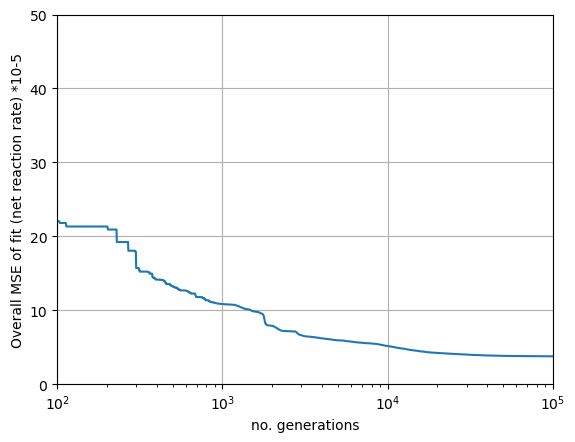

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.63831670595487
1.3737234982524773
0.6251768822183045
-4.200574463639386
0.47546784269901876
5.572707714958621e-07
0.3723547670667029
-4.174417545927017
0.25544834299427926
3.877048138785166
2.766074115651863
2.8682695234745506
7.226975946541335e-07
0.12279811133033096
3.095242793665999
7.774327886519639e-08
0.5325499930827854
-10.922534873934744
1.7155469070863996
1.552155131120028
-8.29243966226291
0.843047636703469
2.79997975995433
0.09017354924947087
2.4691164683581834
1.7206566059303126
0.814140987427583
4.860995253292169
-8.842737766617736
2.2980191623674417
1.315212068523808
2.923992335800124
-4.303998345328165
0.5406742443142412
0.958088265435847
-1.3010299405173722


In [37]:
res.X

array([-1.06383167e+01,  1.37372350e+00,  6.25176882e-01, -4.20057446e+00,
        4.75467843e-01,  5.57270771e-07,  3.72354767e-01, -4.17441755e+00,
        2.55448343e-01,  3.87704814e+00,  2.76607412e+00,  2.86826952e+00,
        7.22697595e-07,  1.22798111e-01,  3.09524279e+00,  7.77432789e-08,
        5.32549993e-01, -1.09225349e+01,  1.71554691e+00,  1.55215513e+00,
       -8.29243966e+00,  8.43047637e-01,  2.79997976e+00,  9.01735492e-02,
        2.46911647e+00,  1.72065661e+00,  8.14140987e-01,  4.86099525e+00,
       -8.84273777e+00,  2.29801916e+00,  1.31521207e+00,  2.92399234e+00,
       -4.30399835e+00,  5.40674244e-01,  9.58088265e-01, -1.30102994e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )


-12.0: -10.63831670595487
1.6: 1.3737234982524773
0.9: 0.6251768822183045
-4.3: -4.200574463639386
0.5: 0.47546784269901876
0.003: 5.572707714958621e-07
0.4: 0.3723547670667029
-7.9: -4.174417545927017
0.7: 0.25544834299427926
7.2: 3.877048138785166
5.7: 2.766074115651863
5.7: 2.8682695234745506
0.8: 7.226975946541335e-07
0.03: 0.12279811133033096
3.1: 3.095242793665999
6.000000000000001e-09: 7.774327886519639e-08
0.1: 0.5325499930827854
-12.0: -10.922534873934744
1.9: 1.7155469070863996
1.6: 1.552155131120028
-11.6: -8.29243966226291
1.2: 0.843047636703469
4.0: 2.79997975995433
0.01: 0.09017354924947087
4.2: 2.4691164683581834
5.4: 1.7206566059303126
2.2: 0.814140987427583
11.8: 4.860995253292169
-12.0: -8.842737766617736
3.3: 2.2980191623674417
1.8: 1.315212068523808
4.2: 2.923992335800124
-4.0: -4.303998345328165
0.5: 0.5406742443142412
1.0: 0.958088265435847
coeff fit: 0.8676429465206246
